# AtaxxZero
## This algorithm tried to reimplement AlphaGo Zero for Ataxx
## however, the computation to train an AI from scratch can be too heavy, given my skills of code optimization and hardware limitation
## therefore, minor adjustments are made to the algorithms to make it plausible for this algorithm to give a rather satisfactory result in an acceptable period.

### modifications:
1. One major difference between AlphaGo Zero and Ataxx Zero is that Ataxx Zero relies __one engineered value function__. From the beginning of the training, the q value of each node is a combination of q from the hybrid network and a greedy function (output is monotone increasing with regard to difference of piece no. of each player).
2. Another major modification is Ataxx Zero apply MCTS to a __very shallow depth, currently being 3__. This change significantly reduce the searching time, thus accelerate training greatly.
3. The combination of 3 layer MCTS and an engineered value function guarantees a good performance of the algorithm in even before training, i.e. hybrid network output random probability and value. The behavior of Ataxx Zero before training should __resemble an impaired MinMax Searching with a depth of 3__. From a practical perspective, it wins 90% of the game with a greedy player(which attempts to maximize no.my_piece - no.opponent's_piece). With reinforcement learning, the algorithm is expected to behave better.
4. When actually applied in game, I plan to reduce the searching depth to 2 to further improve the speed, but expect the algorithm to work better than itself before training.

In [1]:
%load_ext Cython
from Cython.Compiler.Options import directive_scopes, directive_types
directive_types['linetrace'] = True
directive_types['binding'] = True

In [2]:
%load_ext line_profiler
import line_profiler

In [3]:
import os 
import importlib
import sys
import tensorflow as tf
import itertools
from multiprocessing import Queue, Pool, Process
import numpy as np
import numba as nb
from math import sqrt, log, exp
from numpy import unravel_index
from random import choice, random, sample
from operator import itemgetter
np.random.seed(1337)  # for reproducibility
from keras.models import Sequential, Model, load_model
from keras.layers import Input, BatchNormalization, Reshape, Lambda
from keras.layers import Dense, Dropout, Activation, Flatten, LocallyConnected2D
from keras.layers import Conv2D, MaxPooling2D, AlphaDropout, ConvLSTM2D, AvgPool2D, Conv2DTranspose, UpSampling2D
from keras.layers import add, concatenate, multiply, Multiply
from keras.initializers import VarianceScaling, RandomUniform
from keras.optimizers import Adam, SGD, rmsprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils, multi_gpu_model
from keras.utils.vis_utils import plot_model
from keras.engine.topology import Container
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
import keras.backend as K
K.set_image_dim_ordering('th')
from keras.callbacks import Callback, ReduceLROnPlateau, LearningRateScheduler, TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt
import time
#%matplotlib notebook

Using TensorFlow backend.


In [4]:
def set_keras_backend(backend):
    os.environ['KERAS_BACKEND'] = backend
    importlib.reload(K)
    K.set_image_dim_ordering('th')
    assert K.backend() == backend

def set_omp_threads(n):
    n = str(n)
    os.environ['OMP_NUM_THREADS'] = n

In [5]:
set_keras_backend('tensorflow')

Using TensorFlow backend.


In [6]:
def get_rot_policy_dict():
    augment_dict = {}
    rot_m_0 = np.array([[0, -1], [1, 0]]) 
    center = np.array([3, 3])
    for is_flip in [False, True]:
        for rot_time in range(4):
            if not (is_flip == False and rot_time == 0):
                tmp_dict = {}
                # get rot matrix
                rot_m = np.eye(2)
                for i in range(rot_time):
                    rot_m = rot_m_0.dot(rot_m)

                for r in range(7):
                    for c in range(7):
                        for dr in range(-2, 3):
                            for dc in range(-2, 3):
                                start = np.array([r, c])
                                end = np.array([r+dr, c+dc])
                                if (dr != 0 or dc != 0) and \
                                    (start[0] < 7 and start[0] >= 0) and (start[1] < 7 and start[1] >= 0):
                                    new_start = (start - center)
                                    new_end = (end - center)
                                    if is_flip:
                                        new_start[1] = -new_start[1]
                                        new_end[1] = -new_end[1]
                                    new_start = rot_m.dot(new_start) + center
                                    new_end = rot_m.dot(new_end) + center
                                    tmp_dict[(tuple(start), tuple(end))] = (tuple(new_start), tuple(new_end))
                augment_dict[(is_flip, rot_time)] = tmp_dict
    return augment_dict
augment_dict = get_rot_policy_dict()

In [7]:
def augment_policy(data, is_flip, rot_time):
    if is_flip == False and rot_time == 0:
        return data
    
    global policy_dict, policy_list, augment_dict
    out = np.zeros_like(data)
    for i in range(792):
        tmp_data = data[i]
        if tmp_data > 0:
            move = policy_list[i]
            move_after_rot = augment_dict[(is_flip, rot_time)][move]
            i_after_rot = policy_dict[move_after_rot]
            out[i_after_rot] = tmp_data
    return out
            
def augment_data(train_data):
    out = []
    # input is a list for follows
    feature_map = train_data[0]
    action_mask = train_data[1]
    frequency_map = train_data[2]
    value = train_data[3]
    
    # do 7 times augmentation
    for is_flip in [False, True]:
        for rot_time in range(4):
            # do feature map augmentation
            if is_flip:
                tmp_feature_map = np.fliplr(feature_map)
            tmp_feature_map = np.rot90(feature_map, k=rot_time, axes=(1, 2))
            # augment two policy related data
            tmp_action_mask = augment_policy(action_mask, is_flip, rot_time)
            tmp_frequency_map = augment_policy(frequency_map, is_flip, rot_time)
            # append them to out
            out.append([tmp_feature_map, tmp_action_mask, tmp_frequency_map, value])
    return out

## might be a bit of ugly, but it's really efficient to isolate functions that can be accelerated by cython and jit
1. all the dictionary lookup and creation are all integrated in the following cell, which at least reduce the running time for 40%
2. memoryview in cython is a strong weapon in terms of algorithm speedup

In [8]:
%%cython 
# -a -f --compile-args=-DCYTHON_TRACE=1
import numpy as np
cimport numpy as np
import matplotlib.pyplot as plt
from random import choice

def get_policy_dict_list():
    index=0
    policy_dict = {}
    policy_list = []
    for r in range(7):
        for c in range(7):
            for dr in range(-2, 3):
                for dc in range(-2, 3):
                    new_r = r + dr
                    new_c = c + dc
                    if (dr != 0 or dc != 0) and (new_r < 7 and new_r >= 0) and (new_c < 7 and new_c >= 0):
                        policy_dict[((r, c), (new_r, new_c))] = index
                        policy_list.append(((r, c), (new_r, new_c)))
                        index += 1
    return policy_dict, policy_list

policy_dict, policy_list = get_policy_dict_list()

# this is for expand last two lines
def assign_children(children, np.float32_t[:] p_array):
    for move in children:
        children[move] = np.float32(p_array[policy_dict[move]])

cdef class Ataxx:
    cdef public np.int8_t[:, :] data

    def __init__(self, board=None):
        if board is None:                  # if there is no initialization given
            self.data = np.zeros((7, 7), dtype=np.int8)   # then generate a board with starting init, and black(-1) takes first turn
            self.data[0, 0] = -1           
            self.data[6, 6] = -1
            self.data[0, 6] = 1
            self.data[6, 0] = 1
        else:
            self.data = board.copy()
            
    def reset(self, board=None):
        if board is None:
            self.data = np.zeros((7, 7), dtype=np.int8)
            self.data[0, 0] = -1           
            self.data[6, 6] = -1
            self.data[0, 6] = 1
            self.data[6, 0] = 1
        else:
            self.data = board.copy()
        
    def get_feature_map(self, turn, move):
        cdef int j, k
        cdef np.int8_t[:, :, :] out = np.zeros((6, 9, 9), dtype=np.int8)
        # define 1 edge
        
        # edge
        for j in range(9):
            for k in range(9):
                if j == 0 or j == 8 or k == 0 or k == 8:
                    out[0, j, k] = 1
         
        # my pieces
        for j in range(9):
            for k in range(9):
                if j > 0 and j < 8 and k > 0 and k < 8:
                    if self.data[j-1, k-1] == turn:
                        out[1, j, k] = 1
        
        # op pieces
        for j in range(9):
            for k in range(9):
                if j > 0 and j < 8 and k > 0 and k < 8:
                    if self.data[j-1, k-1] == -turn:
                        out[2, j, k] = 1
         
        # last move
        if not move is None:               
            out[3, move[0][0]+1, move[0][1]+1] = 1
            out[4, move[1][0]+1, move[1][1]+1] = 1
            
        # whose first
        if turn == -1:
            for j in range(9):
                for k in range(9):
                    out[5, j, k] = 1
        return np.array(out)
    
    def plot(self, is_next_move=False, turn=None):                        # plot the board
        image = self.data.copy()
        if is_next_move:
            if turn not in [-1, 1]:
                raise ValueError("Turn must be -1 or 1, or Must input a turn for next moves")
            else:
                next_moves = self.get_moves(turn)
                if len(next_moves) == 0:
                    raise ValueError("Game is over already")
                next_pos = list(zip(*next_moves))[1]
                for pos in next_pos:
                    image[pos] = turn / 2
        plt.imshow(image, cmap='gray')
        plt.xticks(range(7), range(7))
        plt.yticks(range(7), range(7))
        plt.show()
                
    def is_valid(self, turn, pos):
        cdef int dr, dc, r = pos[0], c = pos[1], new_r, new_c
        if self.data[r, c] != 0:
            return False
        else:
            for dr in range(-2, 3):
                for dc in range(-2, 3):
                    new_r = r+dr
                    new_c = c+dc
                    if new_r >= 0 and new_c >= 0 and new_r < 7 and new_c < 7 and self.data[new_r, new_c] == turn:
                        return True
            return False 
        
    def get_moves(self, turn, return_node_info=False):
        cdef int r, c, dr, dc, new_r, new_c
        cdef np.int8_t[:] action_mask = np.zeros(792, dtype=np.int8)
        next_moves = []
        corr_dict = {}
        children_dict = {}
        for r in range(7):
            for c in range(7):
                has_duplicate_move = False      # move within the radius of one of another friendly piece is called
                if self.is_valid(turn, (r, c)): # duplicate move
                    for dr in range(-2, 3):
                        for dc in range(-2, 3):
                            new_r = r+dr
                            new_c = c+dc
                            if new_r >= 0 and new_c >= 0 and new_r < 7 and new_c < 7 and self.data[new_r, new_c] == turn:
                                if abs(dr) <= 1 and abs(dc) <=1:
                                    if has_duplicate_move: 
                                        cur_move = ((new_r, new_c), (r, c))
                                        corr_dict[cur_move] = dup_move
                                        # update action mask
                                        if return_node_info: 
                                            action_mask[policy_dict[cur_move]] = 1
                                    elif self.data[new_r, new_c] == turn:
                                        dup_move = ((new_r, new_c), (r, c))
                                        next_moves.append(dup_move) 
                                        has_duplicate_move = True
                                        # preparing children nodes and action mask
                                        if return_node_info: 
                                            children_dict[dup_move] = None
                                            action_mask[policy_dict[dup_move]] = 1
                                elif self.data[new_r, new_c] == turn:
                                    cur_move = ((new_r, new_c), (r, c))
                                    next_moves.append(cur_move) 
                                    # preparing children nodes and action mask
                                    if return_node_info:
                                        children_dict[cur_move] = None
                                        action_mask[policy_dict[cur_move]] = 1
                                else:
                                    continue
        if return_node_info:
            return next_moves, corr_dict, children_dict, np.array(action_mask)
        else:
            return next_moves
    
    def get_greedy_move(self, turn, moves=None):
        cdef int x0, y0, x1, y1, dr, dc, tmp_score, best_score = -50
        # get all possible moves if not provided
        if moves is None:
            moves, corr_dict, _, _ = self.get_moves(turn, return_node_info=True)
            for item in corr_dict:
                moves.append(item)
        
        if len(moves) == 0:
            raise ValueError('No Possible Moves')
        
        best_moves = []
        # calculate greedy move
        for (x0, y0), (x1, y1) in moves:
            tmp_score = 0
            if abs(x0-x1) <= 1 and abs(y0-y1) <= 1:
                tmp_score += 1
            for dr in range(-1, 2):
                for dc in range(-1, 2):
                    try:
                        if x1+dr >= 0 and y1+dc >= 0:
                            tmp_score += self.data[x1+dr, y1+dc] == -turn
                    except:
                        pass
            if tmp_score > best_score:
                best_moves = [((x0, y0), (x1, y1))]
                best_score = tmp_score
            elif tmp_score == best_score:
                best_moves.append(((x0, y0), (x1, y1)))
        return choice(best_moves)
        
    def move_to(self, turn, pos0, pos1):
        cdef int dr, dc, x0 = pos0[0], y0 = pos0[1], x1 = pos1[0], y1 = pos1[1]
        
        if not self.is_valid(turn, pos1):
            raise ValueError("This move: " + str((pos0, pos1)) + " of turn: " + str(turn) + " is invalid") 
        elif self.data[x0, y0] != turn:
            raise ValueError("The starting position is not your piece")
        else:
            self.data[x1, y1] = turn
            if abs(x0 - x1) > 1 or abs(y0 - y1) > 1:   # jump move
                self.data[x0, y0] = 0

            for dr in range(-1, 2):                  # infection mode!!!!
                for dc in range(-1, 2):
                    if x1+dr >= 0 and y1+dc >= 0 and x1+dr < 7 and y1+dc < 7:
                        if self.data[x1+dr, y1+dc] == -turn:  # convert any piece of the opponent to 'turn'
                            self.data[x1+dr, y1+dc] = turn
                            
    @staticmethod                       
    def get_manual_q(int turn, np.int8_t[:, :] board):
        '''consider linear growth of win prob with regard to n_diff
        when diff >= 10, the slope grow a bit
        when diff >= 35, consider win prob close to 1 or -1
        ''' 
        cdef int r, c, turn_no = 0, op_no = 0
        cdef float max1=0.9, max2=0.95, diff, sign
        # get no diff of turns
        for r in range(7):
            for c in range(7):
                if board[r, c] == turn:
                    turn_no += 1
                elif board[r, c] == -turn:
                    op_no += 1
        diff = turn_no - op_no
        if abs(diff) > 30:
            return diff / abs(diff)
        else:
            return diff / 30
        
        # ignore the rest for now
        sign = diff
        diff = abs(diff)
        if diff < 35:
            diff = (diff / 35) ** 2 * max1
        else:
            diff = max2

        if sign < 0:
            return -diff
        else:
            return diff
    
    def evaluate(self, turn, this_turn, max_score=1, min_score=0.001):
        cdef int r, c, turn_no=0, op_no=0
        for r in range(7):
            for c in range(7):
                if self.data[r, c] == turn:
                    turn_no += 1
                elif self.data[r, c] == -turn:
                    op_no += 1
        if len(self.get_moves(this_turn)) == 0:# if one of them can no longer move, count and end
            if turn_no > op_no:
                return max_score
            else:
                return -max_score
        else:
            value = turn_no - op_no
        return value * min_score

## In the following cell, a recursive alpha-beta pruning based on piece no. difference evalutation function is implemented.
* quite amazingly, the programming process was finished within 30 min, with only two cycle of debugging.
1. Very interestingly, seemingly if we apply count diff as evaluation, it plays not as good if we apply count pieces~

In [9]:
%%cython 
# -a -f --compile-args=-DCYTHON_TRACE=1
import numpy as np
cimport numpy as np
import matplotlib.pyplot as plt
from random import choice

'''These methods are for Min max'''
def evaluate(np.int8_t[:, :] board, int turn):
    cdef int r, c, turn_no = 0, op_no = 0
    # get no diff of turns
    for r in range(7):
        for c in range(7):
            if board[r, c] == turn:
                turn_no += 1
            elif board[r, c] == -turn:
                op_no += 1
    return (turn_no - op_no)
        
def is_valid(np.int8_t[:, :] board, turn, pos):
    cdef int dr, dc, r = pos[0], c = pos[1], new_r, new_c
    if board[r, c] != 0:
        return False
    else:
        for dr in range(-2, 3):
            for dc in range(-2, 3):
                new_r = r+dr
                new_c = c+dc
                if new_r >= 0 and new_c >= 0 and new_r < 7 and new_c < 7 and board[new_r, new_c] == turn:
                    return True
        return False 
    

def next_move(np.int8_t[:, :] board, turn):
    cdef int r, c, dr, dc, new_r, new_c
    next_moves = []
    for r in range(7):
        for c in range(7):
            has_duplicate_move = False      # move within the radius of one of another friendly piece is called
            if is_valid(board, turn, (r, c)): # duplicate move
                for dr in range(-2, 3):
                    for dc in range(-2, 3):
                        new_r = r+dr
                        new_c = c+dc
                        if new_r >= 0 and new_c >= 0 and new_r < 7 and new_c < 7 and board[new_r, new_c] == turn:
                            if abs(dr) <= 1 and abs(dc) <=1:
                                if board[new_r, new_c] == turn and not has_duplicate_move:
                                    dup_move = ((new_r, new_c), (r, c))
                                    has_duplicate_move = True
                                    yield dup_move
                            elif board[new_r, new_c] == turn:
                                cur_move = ((new_r, new_c), (r, c))
                                yield cur_move
                            else:
                                continue

def has_next_move(np.int8_t[:, :] board, turn):
    try:
        next(next_move(board, turn))
        return True
    except StopIteration:
        return False
                                
def move_to(np.int8_t[:, :] board, turn, pos0, pos1):
    cdef int dr, dc, x0 = pos0[0], y0 = pos0[1], x1 = pos1[0], y1 = pos1[1]

    if not is_valid(board, turn, pos1):
        raise ValueError("This move: " + str((pos0, pos1)) + " of turn: " + str(turn) + " is invalid") 
    elif board[x0, y0] != turn:
        raise ValueError("The starting position is not your piece")
    else:
        board = board.copy()
        board[x1, y1] = turn
        if abs(x0 - x1) > 1 or abs(y0 - y1) > 1:   # jump move
            board[x0, y0] = 0

        for dr in range(-1, 2):                  # infection mode!!!!
            for dc in range(-1, 2):
                if x1+dr >= 0 and y1+dc >= 0 and x1+dr < 7 and y1+dc < 7:
                    if board[x1+dr, y1+dc] == -turn:  # convert any piece of the opponent to 'turn'
                        board[x1+dr, y1+dc] = turn
        return board
    
def min_max(np.int8_t[:, :] board, int turn, int target_turn, int depth=3, int alpha=-100, int beta=100, is_max=True, is_root=True):
    '''A recursive alpha beta pruning min_max function
    return: board evaluation, chosen move
    NB. for board evaluation, if the searching was pruned, it will return 100 for a minimizer and -100 for a maximizer'''
    cdef int result
    if is_root:
        best_moves = []
    else:
        best_move = ((0, 0), (0, 0))
    
    if depth == 0 or not has_next_move(board, turn): # start to do pruning and selecting once the recursion reaches the end
        result = evaluate(board, target_turn)
        return result, None
    else:
        if is_max:
            alpha = -100
        else:
            beta = 100

        for move in next_move(board, turn):
            result, _ = min_max(move_to(board, turn, move[0], move[1]), \
                                -turn, target_turn, depth-1, alpha, beta, not is_max, False)
            # prun the searching tree or update alpha and beta respectively
            if is_max:
                if result >= beta:
                    return 100, None
                elif result > alpha:
                    alpha = result
                    if is_root:
                        best_moves = [move]
                    else:
                        best_move = move
                elif result == alpha and is_root:
                    best_moves.append(move)
            else:
                if result <= alpha:
                    return -100, None
                elif result < beta:
                    beta = result
                    if is_root:
                        best_moves = [move]
                    else:
                        best_move = move
                elif result == beta and is_root:
                    best_moves.append(move)
        if is_max:
            if is_root:
                return alpha, choice(best_moves)
            else:
                return alpha, best_move
        else:
            if is_root:
                return beta, choice(best_moves)
            else:
                return beta, best_move

In [10]:
N = 100
D = 1
greedy_win = 0
for _ in range(N):
    a = Ataxx()
    turn = -1
    greedy_turn = choice([-1, 1])
    while True:
        #a.plot()
        if turn == greedy_turn:
            best_move = a.get_greedy_move(turn)
            #_, best_move = min_max(a.data, turn, turn, depth=D)
        else:
            _, best_move = min_max(a.data, turn, turn, depth=D)
        a.move_to(turn, best_move[0], best_move[1])
        turn = -turn
        result = a.evaluate(greedy_turn, turn)
        if result == 1:
            greedy_win += 1
            break
        elif result == -1:
            break
print("In the previous ", N, " rounds, greedy win ratio is: ", float(greedy_win) / float(N))

In the previous  100  rounds, greedy win ratio is:  0.67


## Training ideas
1. The __life_span__, i.e. how many episode of games will be self_played until the algorithm update the target model, seems to be vital to the stability of training of the network. (considering performance critiria as the win ratio against simple greedy). As is predicted, __a larger life_span will result in more stabled training, but much slower performance improvement__.
2. in the get_q function, I implemented different ways of returning q for each board. In the beginning of the training, when most of the Q output are random numbers, __setting manual_q a larger contribution to the final q is very helpful in training__. However, __in the latter stages of training, we should give manual_q a large weight in the final q only when we are very confident of the output of manual_q__, in this case, the confidence is considered to be related to the magnitude of manual_q, as well as init_q(the q output of the network).
3. As is observed from the testing result, Q seems to perform worse than P most of the time. One possible explanation is that __Q only learns the most valuable board scenarios, while is bad at evaluating low-quality boards.__, while the during testing for Q, the output of __Q is directly used to evaluate all the next_steps, without the assistance of P__, which is responsible for filtering out useless moves. Under situations where bad board was never met and was given a rather large magnitude Q, the bad move would be selected instead. This can be backed up by the fact that, when BOTH p and q are used to do the testing, the accuracy is significantly raised__(from q 78, p 82 to both 87.2 percent)__. This result is a combination of the contribution of both p and q, but a higher q contribution is believed, as with the growth of rollout times(400 in this experiment), the contribution of q grows significantly.

In [11]:
@nb.jit(nopython=True)
def for_node(c, parent_n_visit, n_visit, p, q):
    return c * p * sqrt(parent_n_visit + 1) / (n_visit + 1) - q / (n_visit + 1) 

@nb.jit(nopython=True)
def get_q(init_q, manual_q, mode):
    '''Manual_q and init_q are both an estimation for the q value
    It seems that considering init_q to be a rectification will not lead to good result'''
    if mode == 0:
        return manual_q
    elif mode == 1:
        return init_q
    elif mode == 2:
        return 0.75 * manual_q + 0.25 * init_q
    elif mode == 3:
        if abs(manual_q) >= 0.5:
            return 0.5 * manual_q + 0.5 * init_q 
        elif abs(manual_q) >= 0.8:
            return manual_q
        elif abs(init_q) > 0.15:
            return 0.2 * manual_q + 0.8 * init_q
        elif abs(init_q) > 0.5:
            return init_q
        else:
            return 0.4 * manual_q + 0.6 * init_q
    elif mode == 4:
        if abs(manual_q) >= 0.8:
            return manual_q
        elif abs(manual_q) >= 0.5:
            return 0.5 * manual_q + 0.5 * init_q 
        else:
            return init_q
    else:
        raise ValueError("Mode is not specified")


@nb.jit(nopython=True)
def recover_q(q, manual_q):
    '''manual q is the initial guess for win ratio
    while init q is the rectification'''
    return q

class TreeNode():
    def __init__(self, parent, p=0.0):
        self._parent = parent
        self._children = {} # a dictionary of action:node
        self._corr_dict = {} # a dictionary for duplicated moves
        self._n_visit = 0
        # from the parent perspective
        self._q = 0.0
        self._manual_q = -5 # manually deviced q
        self._init_q = -5 # learnt q
        self._p = p
        self._action_mask = None
        self._feature_map = None
        self._board = None
        self._is_expanded = False
        self._prev_move = None
        
    def __str__(self):
        out = "_n_visit: {}, _q: {}, _p: {}, _children: \n{}".format(\
                self._n_visit, self._q, self._p, self._children)
        return out
    
    def get_start_q(self, mode=0):
        ''' Different mode means different q
        mode 0: pure manual Q
        mode 1: pure policy Q
        mode 2: hybrid Q
        '''
        assert self._init_q != -5 and self._manual_q != -5
        assert self._q == 0
        self._q = get_q(self._init_q, self._manual_q, mode)
    
    def access_children(self, move):
        try:
            return self._children[move]
        except:
            return self._children[self._corr_dict[move]]
    
    def children_generator(self):
        for move in self._children:
            yield (move, self._children[move])
        for move in self._corr_dict:
            yield (move, self._children[self._corr_dict[move]])
    
    def update_all(self, t_v):
        node = self
        while not node is None: 
            node._q += t_v
            node._n_visit += 1
            node = node._parent
            t_v = -t_v
            
    @staticmethod
    def get_search_value(parent, node, c):
        # return values 
        try:
            value = for_node(c, parent._n_visit, node._n_visit, node._p, node._q)
        except:
            print(parent)
            print(node)
            raise
        #print(value)
        return value
        
    @staticmethod
    def get_frequency_value(node):
        try:
            return node._n_visit
        except:
            return 0
    
    def select(self, c):
        best_node = [0, 0]
        best_node[0], best_node[1] = max(self._children.items(), key=lambda node: self.get_search_value(self, node[1], c))
        return best_node
        
    def get_action_mask(self):
        # only generate the action mask once
        if not self._action_mask is None:
            return self._action_mask
        else:
            raise ValueError("No action mask, request failure")
    
    def get_action_frequency_map(self, temp=1):
        global policy_dict
        out = np.zeros(len(policy_dict))
        # record all the n_visit of each node
        nodes = self.children_generator()
        for node in nodes:
            out[policy_dict[node[0]]] = (float(node[1]._n_visit) / 100) ** (1/temp)
        # normalize the array
        out /= out.sum()
        return out

In [12]:
class PolicyValueNetwork():
    def __init__(self, lr=None, is_load_model=False, is_load_pretrain_model=False, gpu=None, verbose=False):
        if gpu is None:
            self._sess = tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=24))
        else:
            config = tf.ConfigProto(log_device_placement=True)
            config.gpu_options.allow_growth = True
            self._sess = tf.Session(config=config)
        K.set_session(self._sess)
        
        if gpu is None:
            self._device = "cpu"
        else:
            self._device = "gpu:" + str(gpu)
        
        if is_load_model:
            if not is_load_pretrain_model:
                self._model = load_model('MCTS_POLICY_MODEL/AtaxxZero_model.h5')
                self._target_model = load_model('MCTS_POLICY_MODEL/AtaxxZero_target_model.h5')
                print("successfully loaded two models")
            else:
                self._model = load_model('MCTS_POLICY_MODEL/pretrain_AtaxxZero_model.h5')
                self._target_model = load_model('MCTS_POLICY_MODEL/pretrain_AtaxxZero_target_model.h5')
                print("successfully loaded two pretrained models")
            if not lr is None:
                self.update_learning_rate(lr)
        else:
            assert not lr is None
            self._lr = lr
            self._model = self.create_model()
            self._target_model = self.create_model()
            init = tf.global_variables_initializer()
            self._sess.run(init)
            print("new models generated")
            
        # do not synchronize both models
        # self.update_target_model(T=1)
        # print the model structure
        if verbose:
            print(self._model.summary())
        
    def update_learning_rate(self, lr):
        try:
            print("learning rate updated from {} to {}".format(self._lr, lr))
        except:
            print("compile new learning rate {}".format(lr))
        self._lr = lr
        self._model.compile(loss=['categorical_crossentropy', 'mse'], optimizer=Adam(lr=self._lr, decay=1e-6),\
                     loss_weights=[1, 1])
        
    def create_model(self):
        assert K.backend() == 'tensorflow'
        
        def res_block(res_in):
            x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(res_in)
            x = BatchNormalization(axis=1)(x)
            x = Activation('relu')(x)
            x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
            x = BatchNormalization(axis=1)(x)
            x = add(inputs=[x, res_in])
            x = Activation('relu')(x)
            return x

        with tf.device(self._device):
            board_input = Input((6, 9, 9))
            mask_input = Input((792, ))
            x = Conv2D(64, (3, 3), padding='valid', kernel_regularizer=l2(1e-4))(board_input)
            x = BatchNormalization(axis=1)(x)
            x = Activation('relu')(x)
            for i in range(1):
                x = res_block(x)
            y = x

            x = Conv2D(2, (1, 1), kernel_regularizer=l2(1e-4))(y) # as we have 792 policy compared to 360 policy in go
            x = BatchNormalization(axis=1)(x)
            x = Activation('relu')(x)
            x = Flatten()(x)
            x = Dense(792, activation='softplus', kernel_regularizer=l2(1e-4))(x)
            x = multiply(inputs=[x, mask_input])     # this mask will mask any illegal move
            action_output = Activation('softmax')(x)

            x = Conv2D(1, (1, 1), kernel_regularizer=l2(1e-4))(y)
            x = BatchNormalization(axis=1)(x)
            x = Activation('relu')(x)
            x = Flatten()(x)
            x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
            value_output = Dense(1, activation='tanh')(x)

            model = Model(input=[board_input, mask_input],output=[action_output, value_output])

        # compile the model
        model.compile(loss=['categorical_crossentropy', 'mse'], optimizer=Adam(lr=self._lr, decay=1e-6),\
                         loss_weights=[1, 1])
        
        return model

    def update_target_model(self, T=0.5):
        """Inheriting the DDPG concept of updating target weights,
        Each time when target weights are updated, only update the target_weights by a small amount
        This amount can be adjusted by parameter T"""

        model_weights = self._model.get_weights()
        target_weights = self._target_model.get_weights()
        for i in range(len(model_weights)):
            target_weights[i] = T * model_weights[i] + (1-T) * target_weights[i]
        self._target_model.set_weights(target_weights)
        print("\n\ntarget model updated by T:", T, "\n\n")

    def predict(self, feature_map, action_mask, is_target=True):
        if not is_target:
            model = self._model
        else:
            model = self._target_model
        
        return self._sess.run(model.outputs, feed_dict={model.inputs[0]: feature_map.reshape(-1, 6, 9, 9), \
                                    model.inputs[1]: action_mask.reshape(-1, 792), K.learning_phase(): 0})
    
    def save(self, is_pretrain=False):
        if not is_pretrain:
            self._model.save('MCTS_POLICY_MODEL/AtaxxZero_model.h5')
            self._target_model.save('MCTS_POLICY_MODEL/AtaxxZero_target_model.h5')
        else:
            self._model.save('MCTS_POLICY_MODEL/pretrain_AtaxxZero_model.h5')
            self._target_model.save('MCTS_POLICY_MODEL/pretrain_AtaxxZero_target_model.h5')

In [13]:
class Relay():
    def __init__(self, life_span=80):
        self._relay_dict = {}
        self._counter = 0
        self._life_span = int(life_span * 4)
        
    def append(self, train_data):
        train_data = list((zip(*train_data)))
        # stack the small batch
        for i in range(4):
            train_data[i] = np.stack(train_data[i], axis=0)
        # append new data
        self._relay_dict[self._counter] = train_data
        self._counter += 1
        
        # remove too old data
        remove_index = -1
        for index in self._relay_dict:
            if self._counter - index > self._life_span:
                remove_index = index
        if remove_index != -1:
            del self._relay_dict[remove_index]
                
    def get(self, n_data=None):
        # concatenate all data
        all_data = [[], [], [], []]
        for _, data in self._relay_dict.items():
            for i in range(4):
                all_data[i].append(data[i])
        for i in range(4):
            all_data[i] = np.concatenate(all_data[i], axis=0)
        # sample n_data from all data
        length = all_data[0].shape[0]
        
        # sampling n_data from all data
        out = [[], [], [], []]
        if n_data >= length:
            out = all_data
        else:
            indexs = range(length)
            out_indexs = np.random.choice(indexs, size=n_data, replace=False)
            for i in out_indexs:
                for j in range(4):
                    out[j].append(all_data[j][i])
            for i in range(4):
                out[i] = np.stack(out[i], axis=0)
        
        print(length, " data in database")
        print(n_data, " data expected")
        print(out[0].shape[0], " data grabbed")
        return out

In [18]:
class MCTS():
    def __init__(self, c=1, dep_lim=10, lr=1e-4, life_span=10, is_load_model=False, is_load_pretrain_model=False, gpu=True):
        # slow_step means how many step we use to do typical mcts, after that we do fast play
        self._c = c
        self._dep_lim = dep_lim
        self._game = Ataxx()
        self._turn = -1
        # generate model
        self._network = PolicyValueNetwork(lr, is_load_model, is_load_pretrain_model, gpu=gpu)
        self._lr = lr
        # determine which mode to use, default is 0, to switch mode, must do manually
        self._mode = 0
        # generate root and expand initially its children
        self._root = TreeNode(None) # this one will move in self play mode
        self.further_init(self._root, self._game, self._turn, get_p_array=True)
        self._root_store = self._root # this is a backup for reset
        
        
    def reset_root(self, move=None):
        self._root = TreeNode(None) # this one will move in self play mode
        self.further_init(self._root, self._game, self._turn, move, get_p_array=True)
        self._root_store = self._root # this is a backup for reset
        
    def reset(self, left_space=45):
        self._game.reset()
        self._turn = -1
        self._root = TreeNode(None)
        
        if left_space < 45:
            steps = 0
            is_terminal = False
            result = 45
            while not is_terminal and result > left_space:
                if np.random.random() < 0.2: # 80 percent using greedy move
                    best_move = choice(self._game.get_moves(self._turn))
                    
                else:
                    best_move = self._game.get_greedy_move(self._turn)
                    
                self.make_a_move(best_move)
                is_terminal = abs(self._game.evaluate(1, self._turn)) == 1
                result = (np.array(self._game.data) == 0).sum()
                steps += 1
            if is_terminal:
                print("reset failure, do reset again")
                self.reset(left_space)
        self.reset_root()
        try: # tell the _root which move led it here
            self._root._move = best_move
        except:
            pass
        
    def plot_move_visit_freq(self):
        nodes = sorted(self._root._children.items(), key=lambda node: self._root.get_frequency_value(node[1]), reverse=True)
        p_sum = 0
        for node in nodes:
            try:
                print("{}: n_v:{:>6d} q_all:{:+06.6f} q:{:+06.6f} q_m:{:+06.6f} p:{:06.6f}"\
                      .format(node[0], node[1]._n_visit, -node[1]._q / (node[1]._n_visit + 1), \
                              -node[1]._init_q, -node[1]._manual_q, node[1]._p))
                p_sum += node[1]._p
            except:
                pass
        print("########################p_sum is: ", p_sum)
                      
    def get_next_move(self, is_best=False, is_dirichlet=True, rollout_times=100, t_lim=np.nan):
        global policy_list
        # do mcts
        self.rollout(rollout_times, t_lim)
        
        if is_best:
            # return the best move
            index = np.argmax(self._root.get_action_frequency_map())
        elif is_dirichlet:
            # return a choiced move
            prob = (0.75*self._root.get_action_frequency_map(temp=1e-2) \
                         + 0.25*np.random.dirichlet(0.3*np.ones(792))) * self._root._action_mask
            index = np.random.choice(range(792), p=prob / prob.sum())
        else:
            # return move with prob equal to visit frequency
            index = np.random.choice(range(792), p=self._root.get_action_frequency_map())
            
        if index != np.argmax(self._root.get_action_frequency_map()):
            print("\n\nThis is a random move\n\n")
            
        return policy_list[index]
    
    def make_a_move(self, next_move):
        # move the root to next_move's root
        if self._root._children == {}:
            self._root = TreeNode(None)
        elif type(self._root.access_children(next_move)) is np.float32: # the root may not be neccessarily expanded
            self._root = TreeNode(None)
        else:
            self._root = self._root.access_children(next_move)
            self._root._parent = None # necessary for updata_all
        
        # update the game board
        self._game.move_to(self._turn, next_move[0], next_move[1])
        self._turn = -self._turn
      
    def further_init(self, node, game, turn, prev_move=None, get_p_array=False):
        global policy_dict, policy_list
        node._prev_move = prev_move # tell which move led the node here
        # preparing all children
        new_moves, node._corr_dict, node._children, node._action_mask \
                                = game.get_moves(turn, return_node_info=True)
        # if meet end of the game, generate manual q
        if node._children == {}:
            if node._manual_q == -5:
                node._manual_q = game.get_manual_q(turn, game.data)
            # quite tricky here dude, remember to look from the parent perspective
            if node._manual_q > 0:
                node._q = 1
            else:
                node._q = -1 
            return
        
        # generate feature map
        node._feature_map = game.get_feature_map(turn, prev_move)
        node._board = game.data.copy()
        # if required, generate p array and q, only if there are children
        if get_p_array:
            # generate policy prob array
            out = self._network.predict(node._feature_map, node._action_mask)
            p_array = out[0]
            # give p to each child (float32)
            for move in new_moves:
                node._children[move] = p_array[0][policy_dict[move]]
            # init node._q
            node._init_q = out[1][0][0] 
            node._manual_q = game.get_manual_q(turn, game.data)
            node.get_start_q(self._mode)
        
    def expand(self, node, game, turn):
        global policy_dict, policy_list
        
        # if the node was not expanded, take that as a new root and further init it
        if node._children == {} and node._q == 0:
            self.further_init(node, game, turn, get_p_array=True)
        # if end of game, quit expanding
        if node._children == {}:
            assert node._q != 0
            return
        
        # update expanded state
        node._is_expanded = True
        
        # if there are children
        backup_board = game.data.copy() # warning, to backup a memoryview ndarray, use copy()
        index_list = []
        feature_map = []
        action_mask = []
        boards = []
        for move in node._children:
            tmp = node._children[move]
            try:
                assert type(tmp) is np.float32
            except:
                print(type(tmp))
                raise
            new_node = TreeNode(node, p=node._children[move])
            game.move_to(turn,  move[0], move[1])
            self.further_init(new_node, game, -turn, move, get_p_array=False)
            node._children[move] = new_node
            # prepare to calculate p for new_node only if it has children
            if new_node._children != {}:
                index_list.append(new_node)
                feature_map.append(new_node._feature_map)
                action_mask.append(new_node._action_mask)
                boards.append(new_node._board)
            # reset the gamer
            game.reset(board=backup_board)
        # if there are no more node that is expandable, quit
        if len(index_list) == 0:
            return
        
        # do batch prediction
        # print("batch size:", len(index_list))
        feature_map = np.stack(feature_map, axis=0)
        action_mask = np.stack(action_mask, axis=0)
        out = self._network.predict(feature_map, action_mask)
        # get batch manual q 
        boards = [game.get_manual_q(-turn, board) for board in boards]
        # update the result to each child node
        for i, child in enumerate(index_list):
            # assign q
            child._manual_q = boards[i] # neg for display use
            child._init_q = out[1][i][0] # same as above
            child.get_start_q(self._mode)
            # assign p
            assign_children(child._children, out[0][i])
            

    def rollout(self, rollout_times=100, t_lim=np.nan, t_min=2):
        start = time.time()
        for i in range(int(rollout_times*1.1)): 
            tmp_node = self._root
            tmp_game = Ataxx(self._game.data)
            tmp_turn = self._turn
            # start mcts
            step = 0
            while True:
                assert self._dep_lim > 0
                if step < self._dep_lim:
                    # expand the node only when it has never been expanded
                    if tmp_node._is_expanded == False:
                        self.expand(tmp_node, tmp_game, tmp_turn)

                    # check if is leaf node, if so, update the whole tree
                    if tmp_node._children == {}:
                        t_v = tmp_node._q / (tmp_node._n_visit + 1)
                        tmp_node.update_all(t_v)
                        break
                    else:
                        # select a child and continue exploration
                        next_move, next_node = tmp_node.select(self._c)
                            
                        # move to next move and next node
                        tmp_game.move_to(tmp_turn, next_move[0], next_move[1])    
                        tmp_node = next_node
                        tmp_turn = -tmp_turn
                else:
                    t_v = tmp_node._q / (tmp_node._n_visit + 1)
                    tmp_node.update_all(t_v)
                    break
                # update steps                                    
                step += 1
            cur_time = time.time() - start
            if cur_time > t_lim * 0.999:
                print("due to time lim, final rollout times: ", i, "time elapsed: ", cur_time)
                break
            
            if cur_time > t_min and i > rollout_times:
                print("due to rollout lim, final rollout times: ", i, "time elapsed: ", cur_time)
                break
                
        
    def testing_against_min_max(self, rounds=5, left_space=45, mm_dep=1, c=5, dep_lim=0, rollout_times=400, t_lim=6, verbose=True):
        print("####               ####")
        print("#### start testing ####")
        test_start = time.time()
        # record dep_lim and c for restoration
        store_dep_lim = self._dep_lim
        self._dep_lim = dep_lim
        store_c = self._c
        self._c = c
        # recorder of game result
        n_win = 0.0
        win_steps = 0.0
        for r in range(rounds):
            tmp_round_s = time.time()
            # randomly init the game board if no left_space specified
            self.reset(left_space)
            # set up start turns
            my_turn = choice([-1, 1])
            if verbose:
                print("round:", r+1)
                print("this game start with {} space left".format(left_space))
                print("self takes turn: ", my_turn)
            # start the game
            steps = 0
            while abs(self._game.evaluate(1, self._turn)) != 1:
                # plot the game board
                if verbose:
                    self._game.plot()
                    tmp_s = time.time()
                if self._turn == my_turn:
                    best_move = self.get_next_move(is_best=True, rollout_times=rollout_times, t_lim=t_lim)
                    if verbose:
                        print("self turn", my_turn)
                        print(self.plot_move_visit_freq())
                else:
                    _, best_move = min_max(self._game.data, self._turn, self._turn, mm_dep)
                    if verbose:
                        print("greedy turn", self._turn)
                if verbose:
                    print("this move takes time(s): ", time.time()-tmp_s)
                    print("chosen move is ", best_move)

                # synchronize steps and boards
                self.make_a_move(best_move)
                # update steps
                steps += 1
                if steps > 250:
                    print("steps over 250, game skip")
                    break
            if steps <= 250:
                is_self_win = self._game.evaluate(my_turn, self._turn) == 1
                if is_self_win:
                    n_win += 1
                    win_steps += steps
                if verbose:
                    print("this round has steps: {}, time taken: {}, \n\n\nself wins? {}\n\n\n".format(steps, time.time()-tmp_round_s, is_self_win))
            else:
                n_win += 0.5
        # restore dep lim and c
        self._dep_lim = store_dep_lim
        self._c = store_c
        
        # output
        print("testing took time: ", time.time()-test_start)
        if n_win == 0:
            return 0
        else:
            print(win_steps / n_win)
        return n_win / rounds
    
    def tester(self, mm_dep=1, Q=False, P=False, BOTH=False, mode=0, times=200, dep_lim=1, rollout_times=400, verbose=False):
        out = {}
        mode_store = self._mode
        self._mode = mode
        print("mm_dep is: ", mm_dep)
        if Q:
            q_ratio = self.testing_against_min_max(\
                rounds=times, left_space=45, mm_dep=mm_dep, c=0, dep_lim=dep_lim, rollout_times=1, t_lim=6, verbose=verbose)
            print("\n\n\n                        win ratio of Q is {} \n\n\n\n\n".format(q_ratio))
            out['Q'] = q_ratio
        if P:
            p_ratio = self.testing_against_min_max(\
                rounds=times, left_space=45, mm_dep=mm_dep, c=1000000, dep_lim=dep_lim, rollout_times=1, t_lim=6, verbose=verbose)
            print("\n\n\n                        win ratio of P is {} \n\n\n\n\n".format(p_ratio))
            out['P'] = p_ratio
        if BOTH: # multiple customizations for this one
            both_ratio = self.testing_against_min_max(\
                rounds=int(times), left_space=45, mm_dep=mm_dep, c=self._c, dep_lim=dep_lim, rollout_times=rollout_times, t_lim=6, verbose=verbose)
            print("\n\n\n                        win ratio of both is {} \n\n\n\n\n".format(both_ratio))
            out['BOTH'] = both_ratio
        self._mode = mode_store
        return out
             
    def data_collector(self, node, visit_min, train_mode=0):
        out = []
        if node._n_visit >= visit_min:
            if train_mode == 0: # train both p and q
                tmp_data = [node._feature_map, \
                            node._action_mask, \
                            node.get_action_frequency_map(),\
                            recover_q(node._q / (node._n_visit + 1), node._manual_q)] # to recover what policy q should be
            elif train_mode == 1: # train only q
                print("Notice: train_mode is q train")
                tmp_data = [node._feature_map, \
                            np.zeros(792), \
                            np.zeros(792),\
                            recover_q(node._q / (node._n_visit + 1), node._manual_q)] # to recover what policy q should be
            else:
                raise ValueError("train_mode not understood")
            tmp_data = augment_data(tmp_data)
            out.extend(tmp_data)

        # This type of data augumentation reduce increase the entropy of P (low quality, less peaky P distribution)
        # however, it improved Q somehow, which is currently 20%(60%) better than P policy when playing against greedy
        # considering preserving only the data augmentation of Q (by setting action_mask to 0)
        for _, child in node._children.items():
            try: 
                assert child._n_visit >= visit_min * 0.625
                tmp_data = [child._feature_map, \
                            np.zeros(792), \
                            np.zeros(792), \
                            recover_q(child._q / (child._n_visit + 1), child._manual_q)]
                tmp_data = augment_data(tmp_data)
                out.extend(tmp_data)
            except:
                pass
        print("no. of data collected: ", len(out))
        return out
        
                
    def self_play(self, rollout_times=100, t_lim=np.nan, verbose=True, is_best=False, train_mode=0):
        train_data = []
        steps = 0
        print("start new self play")
        start = time.time()
        while self._root._children != {} and steps < 250:
            print(self._turn, "'s turn")
            tmp_s = time.time()
            if steps < 8: # to generate different game data
                best_move = self.get_next_move(is_best=is_best, is_dirichlet=False, \
                                               rollout_times=rollout_times, t_lim=t_lim)
            else:
                best_move = self.get_next_move(is_best=is_best, is_dirichlet=True, \
                                               rollout_times=rollout_times, t_lim=t_lim)
            print("one move takes time(s): ", time.time()-tmp_s)
            # record π data
            visit_min = rollout_times
            train_data.extend(self.data_collector(self._root, visit_min, train_mode=train_mode))
            # plot the game board if verbose
            if verbose:
                self._game.plot()
                self.plot_move_visit_freq()
            # make the move and move on
            self.make_a_move(best_move)
            steps += 1
        print("this self play has {} steps, time elapsed {}".format(steps, time.time()-start))
        print("winner is", np.sign(self._root._q * self._turn))
        
        return train_data
    
    def zero_out_pretraining(self): # zero out q output
        train_data = []
        # collect train data
        while len(train_data) < 500000:
            tmp_game = Ataxx()
            tmp_round_s = time.time()
            # randomly init the game board if no left_space specified
            # start the game
            steps = 0
            turn = -1
            while abs(tmp_game.evaluate(1, turn)) != 1:
                # plot the game board
                if steps < 10:
                    rand_thresh = 0.5
                else:
                    rand_thresh = 0.25
                if np.random.random() > rand_thresh:
                    best_move = tmp_game.get_greedy_move(turn)
                else:
                    best_move = choice(tmp_game.get_moves(turn))
                
                # make the move and grab data
                tmp_game.move_to(turn, best_move[0], best_move[1])
                turn = -turn
                tmp_data = [tmp_game.get_feature_map(turn, best_move), \
                            np.zeros(792), \
                            np.zeros(792),\
                            0]
                tmp_data = augment_data(tmp_data)
                train_data.extend(tmp_data)
                # update steps
                steps += 1
            print(len(train_data))
                
        # process train data
        train_data = list((zip(*train_data)))
        for i in range(4):
            train_data[i] = np.stack(train_data[i], axis=0)
        # do the training
        es = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
        self._network._model.fit(x=[train_data[0], train_data[1]], y=[train_data[2], train_data[3]], verbose=1, \
                                    batch_size=1024, epochs=1024, shuffle=True, validation_split=0.1, callbacks=[es])
        # update the model every life_span
        self._network.update_target_model()
        self._network.save(is_pretrain=True)
    
    def reinforcement_pretraining(self, rounds=1000, verbose=True): # geting Q value close to manual Q
        train_data = []
        # collect train data
        for r in range(rounds):
            tmp_game = Ataxx()
            tmp_round_s = time.time()
            # randomly init the game board if no left_space specified
            if verbose:
                print("round:", r+1)
            # start the game
            steps = 0
            turn = -1
            while abs(tmp_game.evaluate(1, turn)) != 1:
                # plot the game board
                if verbose:
                    tmp_s = time.time()
                if steps < 8:
                    rand_thresh = 0.5
                else:
                    rand_thresh = 0.2
                if np.random.random() > rand_thresh:
                    best_move = tmp_game.get_greedy_move(turn)
                else:
                    best_move = choice(tmp_game.get_moves(turn))
                
                # make the move and grab data
                tmp_game.move_to(turn, best_move[0], best_move[1])
                turn = -turn
                tmp_data = [tmp_game.get_feature_map(turn, best_move), \
                            np.zeros(792), \
                            np.zeros(792),\
                            tmp_game.get_manual_q(turn, tmp_game.data)]
                tmp_data = augment_data(tmp_data)
                train_data.extend(tmp_data)
                # update steps
                steps += 1
            if verbose:
                print("this round has {} steps, takes time {}".format(steps, time.time()-tmp_round_s))
            
            if len(train_data) > 500000:
                # process train data
                train_data = list((zip(*train_data)))
                for i in range(4):
                    train_data[i] = np.stack(train_data[i], axis=0)
                # do the training
                es = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
                self._network._model.fit(x=[train_data[0], train_data[1]], y=[train_data[2], train_data[3]], verbose=1, \
                                            batch_size=1024, epochs=512, shuffle=True, validation_split=0.1, callbacks=[es])
                # update the model every life_span
                self._network.update_target_model()
                self._network.save(is_pretrain=True)
                # clear train_data
                train_data = []
                
        if len(train_data) <= 500000:
            # process train data
            train_data = list((zip(*train_data)))
            for i in range(4):
                train_data[i] = np.stack(train_data[i], axis=0)
            # do the training
            es = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
            self._network._model.fit(x=[train_data[0], train_data[1]], y=[train_data[2], train_data[3]], verbose=1, \
                                        batch_size=1024, epochs=1024, shuffle=True, validation_split=0.1, callbacks=[es])
            # update the model every life_span
            self._network.update_target_model()
            self._network.save(is_pretrain=True)
            
    def reinforcement_learning(self, episode=1000, rollout_times=100, life_span=25, train_interval=5, T=0.5, t_lim=np.nan, left_space_max=None, self_play_verbose=False, train_mode=0):        
        # setting testing parameters
        dep_q = 1
        dep_p = 3
        test_rounds = [250, 200, 100, 30]
        # setting up train relay
        train_relay = Relay(life_span)
        for epi in range(episode):
            print("episode {} now start".format(epi))
            self.reset_root()
            # randomly skip a few steps if left space not specified
            if not left_space_max is None:
                left_space = left_space_max * np.random.normal(loc=1, scale=0.2)
            else:
                left_space = 45
            self.reset(left_space=left_space)
            print("left space is {}".format(left_space))
            # start self_play and get train_data
            if np.random.random() < 0.05:
                train_data = self.self_play(rollout_times=rollout_times, t_lim=t_lim, verbose=True, train_mode=train_mode)
            else:
                train_data = self.self_play(rollout_times=rollout_times, t_lim=t_lim, verbose=self_play_verbose, train_mode=train_mode)
            # store it in relay
            train_relay.append(train_data)
            # do training every 5 epi and update target model and reset tree
            if epi >= life_span and epi%train_interval == 0:
                train_data = train_relay.get(40000)
                print("start training, training data no. {}".format(train_data[0].shape[0]))
                # do training
                es = EarlyStopping(monitor='val_loss', min_delta=0.000001, patience=80, verbose=1, mode='auto')
                self._network._model.fit(x=[train_data[0], train_data[1]], y=[train_data[2], train_data[3]], verbose=1, \
                                            batch_size=1024, epochs=512, shuffle=True, validation_split=0.15, callbacks=[es])
                print("saving files")
                self._network.save()
                # update the model every life_span, but dont update for the first life_span
                if epi%life_span == 0 and epi >= 2*life_span:
                    self._network.update_target_model(T=T)
            # test the performance of the AI
            if epi % (life_span) == 0:
                """Try to test so that a reasonable result is given"""
                print("\n\nstart testing against min max")
                q_result = self.tester(mm_dep=dep_q, Q=True, mode=1, times=test_rounds[dep_q-1])['Q']
                p_result = self.tester(mm_dep=dep_p, P=True, mode=1, times=test_rounds[dep_p-1])['P']
                if q_result < 0.1:
                    if dep_q > 1:
                        dep_q -= 1
                elif q_result > 0.90:
                    if dep_q < 4:
                        dep_q += 1
                elif q_result > 0.675:
                    if dep_q < 4:
                        self.tester(mm_dep=dep_q+1, Q=True, mode=1, times=test_rounds[dep_q])
                if p_result < 0.1:
                    if dep_p > 1:
                        dep_p -= 1
                elif p_result > 0.90:
                    if dep_p < 4:
                        dep_p += 1
                elif p_result > 0.675:
                    if dep_p < 4:
                        self.tester(mm_dep=dep_p+1, P=True, mode=1, times=test_rounds[dep_p])
            # a flawed way of annealing lr
            if epi % (life_span) == life_span - 1 and self._lr >= 5e-6:
                self._lr = self._lr / 1.5
                self._network.update_learning_rate(self._lr)
            print("episode {} finished".format(epi))

In [15]:
player = MCTS(gpu=1, lr=1e-6, c=3, is_load_model=True, is_load_pretrain_model=False, dep_lim=3)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
successfully loaded two models
compile new learning rate 1e-06


episode 0 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.28624582290649414
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.45316267013549805
no. of data collected:  16
-1 's turn
one move takes time(s):  0.7930920124053955
no. of data collected:  16
1 's turn
one move takes time(s):  1.0399768352508545
no. of data collected:  16
-1 's turn
one move takes time(s):  1.8532636165618896
no. of data collected:  16
1 's turn
one move takes time(s):  1.6183149814605713
no. of data collected:  16
-1 's turn
one move takes time(s):  0.5694427490234375
no. of data collected:  16
1 's turn
one move takes time(s):  0.7272753715515137
no. of data collected:  16
-1 's turn
one move takes time(s):  1.164881944656372
no. of data collected:  16
1 's turn
one move takes time(s):  1.1384339332580566
no. of data collected:  16
-1 's turn
one move takes time(s):  0.687131404876709
no. of data collected:  16
1 's turn
one move ta

one move takes time(s):  1.8431615829467773
no. of data collected:  16
-1 's turn
one move takes time(s):  0.8043358325958252
no. of data collected:  16
1 's turn
one move takes time(s):  0.9043455123901367
no. of data collected:  16
-1 's turn
one move takes time(s):  1.356278657913208
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.503087043762207
one move takes time(s):  2.5044174194335938
no. of data collected:  16
-1 's turn
one move takes time(s):  1.6744558811187744
no. of data collected:  24
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.1382064819335938
one move takes time(s):  2.139925956726074
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2110 time elapsed:  2.000034809112549
one move takes time(s):  2.0020737648010254
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.7245209217071533
one move takes time(s):  2.7

one move takes time(s):  0.10476803779602051
no. of data collected:  16
1 's turn
one move takes time(s):  0.12829899787902832
no. of data collected:  8
this self play has 86 steps, time elapsed 112.9073634147644
winner is 1.0
episode 1 finished
episode 2 now start
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.2757704257965088
no. of data collected:  8
1 's turn
one move takes time(s):  0.3518953323364258
no. of data collected:  16
-1 's turn
one move takes time(s):  0.7373933792114258
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.9795701503753662
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  1.076606273651123
no. of data collected:  8
1 's turn
one move takes time(s):  0.40088915824890137
no. of data collected:  16
-1 's turn
one move takes time(s):  0.6266255378723145
no. of data collected:  16
1 's turn
one move takes time(s):  0.8038980960845

one move takes time(s):  0.6542477607727051
no. of data collected:  16
1 's turn
one move takes time(s):  0.9732494354248047
no. of data collected:  16
-1 's turn
one move takes time(s):  1.7622132301330566
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  1.638479232788086
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.600626230239868


This is a random move


one move takes time(s):  2.6017520427703857
no. of data collected:  8
1 's turn
one move takes time(s):  1.1111886501312256
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.500006675720215
one move takes time(s):  2.50156569480896
no. of data collected:  8
1 's turn
one move takes time(s):  1.2991547584533691
no. of data collected:  8
-1 's turn
one move takes time(s):  1.5265297889709473
no. of data collected:  16
1 's turn
one move takes time(s):  1.661508321762085
no. of data collec

one move takes time(s):  0.20583605766296387
no. of data collected:  24
-1 's turn
one move takes time(s):  0.21172308921813965
no. of data collected:  16
1 's turn
one move takes time(s):  0.22838616371154785
no. of data collected:  16
-1 's turn
one move takes time(s):  0.2787022590637207
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.20588064193725586
no. of data collected:  24
-1 's turn
one move takes time(s):  0.30399346351623535
no. of data collected:  24
1 's turn
one move takes time(s):  0.22813701629638672
no. of data collected:  24
-1 's turn


This is a random move


one move takes time(s):  0.1413116455078125
no. of data collected:  24
1 's turn
one move takes time(s):  0.09175848960876465
no. of data collected:  16
-1 's turn
one move takes time(s):  0.04777812957763672
no. of data collected:  16
1 's turn
one move takes time(s):  0.03940272331237793
no. of data collected:  8
this self play has 88 steps, time elapsed 135.44680333

one move takes time(s):  0.2562072277069092
no. of data collected:  16
1 's turn
one move takes time(s):  0.23721718788146973
no. of data collected:  32
-1 's turn


This is a random move


one move takes time(s):  0.32764291763305664
no. of data collected:  16
1 's turn
one move takes time(s):  0.23680758476257324
no. of data collected:  16
-1 's turn
one move takes time(s):  0.2564513683319092
no. of data collected:  16
1 's turn
one move takes time(s):  0.22602343559265137
no. of data collected:  24
-1 's turn
one move takes time(s):  0.24864816665649414
no. of data collected:  16
1 's turn
one move takes time(s):  0.295731782913208
no. of data collected:  16
-1 's turn
one move takes time(s):  0.28960084915161133
no. of data collected:  16
1 's turn
one move takes time(s):  0.2671239376068115
no. of data collected:  24
-1 's turn
one move takes time(s):  0.4560060501098633
no. of data collected:  24
1 's turn
one move takes time(s):  0.20361900329589844
no. of data collected:  24
-

one move takes time(s):  0.45813560485839844
no. of data collected:  24
1 's turn
one move takes time(s):  0.4422640800476074
no. of data collected:  16
-1 's turn
one move takes time(s):  0.40679168701171875
no. of data collected:  16
1 's turn
one move takes time(s):  0.3930971622467041
no. of data collected:  16
-1 's turn
one move takes time(s):  0.5607337951660156
no. of data collected:  16
1 's turn
one move takes time(s):  0.22335505485534668
no. of data collected:  24
-1 's turn
one move takes time(s):  0.25586485862731934
no. of data collected:  16
1 's turn
one move takes time(s):  0.3411376476287842
no. of data collected:  16
-1 's turn
one move takes time(s):  0.1847083568572998
no. of data collected:  24
1 's turn
one move takes time(s):  0.2277665138244629
no. of data collected:  16
-1 's turn
one move takes time(s):  0.2518761157989502
no. of data collected:  24
1 's turn
one move takes time(s):  0.4360518455505371
no. of data collected:  24
-1 's turn
one move takes tim

one move takes time(s):  0.2712516784667969
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.25684285163879395
no. of data collected:  16
-1 's turn
one move takes time(s):  0.2668898105621338
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.16885948181152344
no. of data collected:  24
-1 's turn
one move takes time(s):  0.1750473976135254
no. of data collected:  16
1 's turn
one move takes time(s):  0.1829674243927002
no. of data collected:  24
-1 's turn
one move takes time(s):  0.20023202896118164
no. of data collected:  24
1 's turn
one move takes time(s):  0.16338300704956055
no. of data collected:  16
-1 's turn
one move takes time(s):  0.15651726722717285
no. of data collected:  24
1 's turn
one move takes time(s):  0.11870813369750977
no. of data collected:  16
-1 's turn
one move takes time(s):  0.10955071449279785
no. of data collected:  16
1 's turn
one move takes time(s):  0.10049676895141602


one move takes time(s):  0.06571578979492188
no. of data collected:  16
-1 's turn
one move takes time(s):  0.06747031211853027
no. of data collected:  24
1 's turn


This is a random move


one move takes time(s):  0.053971290588378906
no. of data collected:  8
this self play has 78 steps, time elapsed 88.30965065956116
winner is 1.0
episode 7 finished
episode 8 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.3389561176300049
no. of data collected:  8
1 's turn
one move takes time(s):  0.44683384895324707
no. of data collected:  16
-1 's turn
one move takes time(s):  0.7377758026123047
no. of data collected:  24
1 's turn


This is a random move


one move takes time(s):  1.1033384799957275
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  1.27321195602417
no. of data collected:  8
1 's turn
one move takes time(s):  1.7833502292633057
no. of data collected:  8
-1 's turn


This is a random move


one move take

one move takes time(s):  1.5048608779907227
no. of data collected:  8
-1 's turn
one move takes time(s):  1.702202320098877
no. of data collected:  16
1 's turn
one move takes time(s):  0.7932693958282471
no. of data collected:  16
-1 's turn
one move takes time(s):  1.474900245666504
no. of data collected:  24
1 's turn
one move takes time(s):  1.187809944152832
no. of data collected:  16
-1 's turn
one move takes time(s):  1.3401265144348145
no. of data collected:  24
1 's turn
one move takes time(s):  1.0325345993041992
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.3435633182525635
one move takes time(s):  2.3456192016601562
no. of data collected:  24
1 's turn
one move takes time(s):  1.6086547374725342
no. of data collected:  16
-1 's turn
one move takes time(s):  1.133514404296875
no. of data collected:  16
1 's turn
one move takes time(s):  1.1228299140930176
no. of data collected:  16
-1 's turn
due to rollout lim, final r



This is a random move


one move takes time(s):  0.6314492225646973
no. of data collected:  16
1 's turn
one move takes time(s):  1.1401827335357666
no. of data collected:  16
-1 's turn
one move takes time(s):  0.9571371078491211
no. of data collected:  16
1 's turn
one move takes time(s):  1.5426526069641113
no. of data collected:  16
-1 's turn
one move takes time(s):  1.7871637344360352
no. of data collected:  16
1 's turn
one move takes time(s):  1.028418779373169
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.2189064025878906
one move takes time(s):  2.2206742763519287
no. of data collected:  16
1 's turn
one move takes time(s):  1.4315471649169922
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.3677494525909424
one move takes time(s):  2.3690309524536133
no. of data collected:  16
1 's turn
one move takes time(s):  1.620194911956787
no. of data collected:  16
-1 's turn

one move takes time(s):  1.1857242584228516
no. of data collected:  16
1 's turn
one move takes time(s):  1.1062171459197998
no. of data collected:  24
-1 's turn
one move takes time(s):  1.1806244850158691
no. of data collected:  16
1 's turn
one move takes time(s):  1.2131390571594238
no. of data collected:  16
-1 's turn
one move takes time(s):  0.9167051315307617
no. of data collected:  16
1 's turn
one move takes time(s):  0.8627293109893799
no. of data collected:  16
-1 's turn
one move takes time(s):  0.8829123973846436
no. of data collected:  24
1 's turn
one move takes time(s):  1.2564780712127686
no. of data collected:  24
-1 's turn
one move takes time(s):  1.083117961883545
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2155 time elapsed:  2.0100672245025635
one move takes time(s):  2.0111260414123535
no. of data collected:  16
-1 's turn
one move takes time(s):  0.8981540203094482
no. of data collected:  16
1 's turn
one move takes time(s): 

one move takes time(s):  0.8669729232788086
no. of data collected:  16
-1 's turn
one move takes time(s):  0.5789194107055664
no. of data collected:  16
1 's turn
one move takes time(s):  0.5360569953918457
no. of data collected:  24
-1 's turn
one move takes time(s):  0.4383530616760254
no. of data collected:  16
1 's turn
one move takes time(s):  1.2330565452575684
no. of data collected:  16
-1 's turn
one move takes time(s):  0.6133077144622803
no. of data collected:  16
1 's turn
one move takes time(s):  0.5103821754455566
no. of data collected:  24
-1 's turn
one move takes time(s):  0.7467291355133057
no. of data collected:  16
1 's turn
one move takes time(s):  1.5059328079223633
no. of data collected:  16
-1 's turn
one move takes time(s):  0.9775340557098389
no. of data collected:  24
1 's turn


This is a random move


one move takes time(s):  1.1432514190673828
no. of data collected:  24
-1 's turn
one move takes time(s):  0.9254424571990967
no. of data collected:  16
1 's t

due to rollout lim, final rollout times:  2001 time elapsed:  2.1628966331481934
one move takes time(s):  2.1649281978607178
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.132857322692871
one move takes time(s):  3.1342949867248535
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.3147144317626953
one move takes time(s):  2.3164217472076416
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.2212331295013428
one move takes time(s):  3.223343849182129
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.491727352142334
one move takes time(s):  2.493875503540039
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.2387075424194336
one move takes time(s):  2.239912271499634
no. of data collected:  16
1 's turn
one move takes time(s):  1.9187

due to time lim, final rollout times:  1717 time elapsed:  28.27251362800598
one move takes time(s):  28.29699397087097
no. of data collected:  0
1 's turn
one move takes time(s):  0.6069402694702148
no. of data collected:  16
-1 's turn
one move takes time(s):  0.7489848136901855
no. of data collected:  24
1 's turn
one move takes time(s):  1.1100540161132812
no. of data collected:  16
-1 's turn
one move takes time(s):  1.5650885105133057
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  1.813472032546997
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.479605197906494
one move takes time(s):  2.480539321899414
no. of data collected:  8
1 's turn
one move takes time(s):  1.0757744312286377
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.5014736652374268
one move takes time(s):  2.502730131149292
no. of data collected:  16
1 's turn
one move 

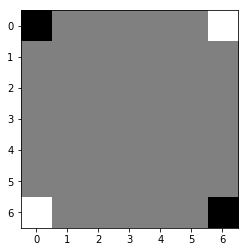

((6, 6), (5, 5)): n_v:  1112 q_all:+0.017571 q:+0.014170 q_m:+0.033333 p:0.486336
((0, 0), (1, 1)): n_v:  1085 q_all:+0.012866 q:+0.021165 q_m:+0.033333 p:0.510458
((0, 0), (0, 1)): n_v:     1 q_all:+0.003687 q:+0.009545 q_m:+0.033333 p:0.000840
((6, 6), (6, 5)): n_v:     1 q_all:+0.016540 q:+0.014658 q_m:+0.033333 p:0.000828
((0, 0), (1, 0)): n_v:     1 q_all:+0.011044 q:+0.016565 q_m:+0.033333 p:0.000570
((6, 6), (6, 4)): n_v:     0 q_all:+0.002110 q:+0.002110 q_m:-0.000000 p:0.000018
((0, 0), (1, 2)): n_v:     0 q_all:-0.010136 q:-0.010136 q_m:-0.000000 p:0.000024
((0, 0), (2, 2)): n_v:     0 q_all:-0.004432 q:-0.004432 q_m:-0.000000 p:0.000086
((0, 0), (0, 2)): n_v:     0 q_all:-0.014193 q:-0.014193 q_m:-0.000000 p:0.000020
((6, 6), (5, 6)): n_v:     0 q_all:+0.016671 q:+0.016671 q_m:+0.033333 p:0.000440
((6, 6), (4, 6)): n_v:     0 q_all:+0.011706 q:+0.011706 q_m:-0.000000 p:0.000056
((6, 6), (5, 4)): n_v:     0 q_all:+0.012487 q:+0.012487 q_m:-0.000000 p:0.000034
((6, 6), (4, 4))

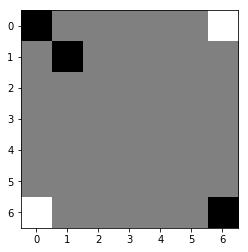

((0, 6), (1, 5)): n_v:  2043 q_all:-0.024018 q:-0.024160 q_m:-0.000000 p:0.612562
((6, 0), (5, 1)): n_v:  1078 q_all:-0.025631 q:-0.016358 q_m:-0.000000 p:0.333131
((0, 6), (1, 6)): n_v:    69 q_all:-0.026684 q:-0.029085 q_m:-0.000000 p:0.021843
((6, 0), (5, 0)): n_v:    37 q_all:-0.023182 q:-0.026634 q_m:-0.000000 p:0.010859
((0, 6), (0, 5)): n_v:    36 q_all:-0.030572 q:-0.028302 q_m:-0.000000 p:0.012210
((6, 0), (6, 1)): n_v:    21 q_all:-0.030011 q:-0.024294 q_m:-0.000000 p:0.007288
((0, 6), (2, 4)): n_v:     1 q_all:-0.041318 q:-0.038078 q_m:-0.033333 p:0.000444
((6, 0), (6, 2)): n_v:     0 q_all:-0.043254 q:-0.043254 q_m:-0.033333 p:0.000091
((6, 0), (5, 2)): n_v:     0 q_all:-0.039887 q:-0.039887 q_m:-0.033333 p:0.000096
((6, 0), (4, 1)): n_v:     0 q_all:-0.025419 q:-0.025419 q_m:-0.033333 p:0.000105
((0, 6), (2, 6)): n_v:     0 q_all:-0.030459 q:-0.030459 q_m:-0.033333 p:0.000118
((0, 6), (0, 4)): n_v:     0 q_all:-0.035225 q:-0.035225 q_m:-0.033333 p:0.000263
((0, 6), (2, 5))

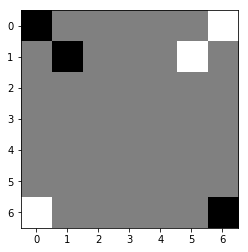

((1, 1), (2, 2)): n_v:  2764 q_all:+0.025729 q:+0.020657 q_m:+0.033333 p:0.620145
((6, 6), (5, 5)): n_v:  1138 q_all:+0.020793 q:+0.007996 q_m:+0.033333 p:0.284186
((1, 1), (1, 2)): n_v:   217 q_all:+0.020173 q:-0.000071 q_m:+0.033333 p:0.054857
((1, 1), (2, 1)): n_v:    95 q_all:+0.016069 q:+0.001096 q_m:+0.033333 p:0.026185
((1, 1), (2, 0)): n_v:     8 q_all:+0.014438 q:+0.011339 q_m:+0.033333 p:0.002294
((1, 1), (0, 2)): n_v:     7 q_all:+0.005261 q:-0.004278 q_m:+0.033333 p:0.002400
((0, 0), (1, 0)): n_v:     6 q_all:+0.007652 q:+0.000659 q_m:+0.033333 p:0.001975
((0, 0), (0, 1)): n_v:     5 q_all:+0.015307 q:+0.005604 q_m:+0.033333 p:0.001386
((6, 6), (5, 6)): n_v:     1 q_all:+0.006915 q:+0.010857 q_m:+0.033333 p:0.000328
((0, 0), (2, 2)): n_v:     1 q_all:-0.000419 q:+0.002063 q_m:-0.000000 p:0.000385
((6, 6), (6, 5)): n_v:     1 q_all:+0.017909 q:+0.009233 q_m:+0.033333 p:0.000368
((1, 1), (3, 0)): n_v:     0 q_all:-0.003439 q:-0.003439 q_m:-0.000000 p:0.000095
((6, 6), (6, 4))

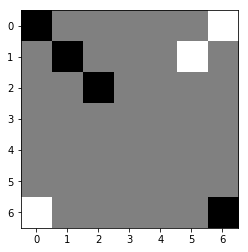

((6, 0), (5, 1)): n_v:  2110 q_all:-0.014726 q:-0.025845 q_m:-0.000000 p:0.458878
((1, 5), (2, 4)): n_v:  1086 q_all:-0.014552 q:-0.034174 q_m:-0.000000 p:0.235514
((1, 5), (1, 4)): n_v:   993 q_all:-0.010757 q:-0.029236 q_m:-0.000000 p:0.197498
((1, 5), (2, 5)): n_v:   150 q_all:-0.013061 q:-0.034536 q_m:-0.000000 p:0.031607
((0, 6), (1, 6)): n_v:    63 q_all:-0.025098 q:-0.029692 q_m:-0.000000 p:0.016953
((1, 5), (0, 4)): n_v:    29 q_all:-0.034123 q:-0.035930 q_m:-0.000000 p:0.008973
((1, 5), (3, 3)): n_v:    26 q_all:-0.018834 q:+0.001243 q_m:+0.033333 p:0.006130
((6, 0), (5, 0)): n_v:    23 q_all:-0.017524 q:-0.034881 q_m:-0.000000 p:0.005297
((0, 6), (0, 5)): n_v:    14 q_all:-0.021334 q:-0.038390 q_m:-0.000000 p:0.003640
((1, 5), (2, 6)): n_v:    12 q_all:-0.029295 q:-0.030285 q_m:-0.000000 p:0.003633
((1, 5), (1, 3)): n_v:    10 q_all:-0.032697 q:-0.000091 q_m:+0.033333 p:0.003152
((1, 5), (2, 3)): n_v:     9 q_all:-0.027560 q:-0.000204 q_m:+0.033333 p:0.002411
((6, 0), (6, 1))

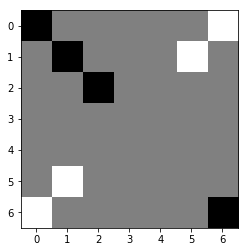

((2, 2), (3, 1)): n_v:  1715 q_all:+0.018421 q:+0.019788 q_m:+0.033333 p:0.716269
((6, 6), (5, 5)): n_v:   534 q_all:+0.029696 q:+0.010995 q_m:+0.033333 p:0.185622
((2, 2), (1, 3)): n_v:   143 q_all:+0.018616 q:+0.009242 q_m:+0.033333 p:0.059720
((2, 2), (3, 3)): n_v:    13 q_all:+0.015108 q:+0.018228 q_m:+0.033333 p:0.005994
((2, 2), (3, 2)): n_v:     7 q_all:-0.005222 q:+0.010969 q_m:+0.033333 p:0.004286
((1, 1), (2, 1)): n_v:     7 q_all:+0.020965 q:-0.003229 q_m:+0.033333 p:0.003098
((2, 2), (4, 2)): n_v:     5 q_all:+0.003720 q:+0.030841 q_m:+0.066667 p:0.002444
((2, 2), (2, 3)): n_v:     5 q_all:+0.017041 q:+0.018480 q_m:+0.033333 p:0.002232
((1, 1), (1, 2)): n_v:     4 q_all:+0.003859 q:-0.008379 q_m:+0.033333 p:0.002480
((2, 2), (4, 1)): n_v:     3 q_all:-0.000524 q:+0.025983 q_m:+0.066667 p:0.001647
((2, 2), (1, 0)): n_v:     2 q_all:-0.014379 q:-0.024677 q_m:-0.000000 p:0.001368
((6, 6), (5, 6)): n_v:     2 q_all:+0.030656 q:+0.014839 q_m:+0.033333 p:0.000920
((2, 2), (2, 4))

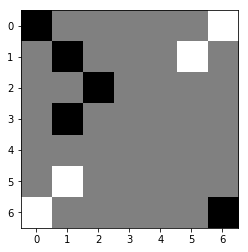

((5, 1), (4, 2)): n_v:  1072 q_all:-0.007395 q:+0.004936 q_m:+0.066667 p:0.278379
((5, 1), (4, 1)): n_v:   618 q_all:-0.004905 q:+0.015694 q_m:+0.066667 p:0.152342
((5, 1), (3, 2)): n_v:   387 q_all:-0.018662 q:+0.037419 q_m:+0.100000 p:0.123555
((5, 1), (5, 2)): n_v:   344 q_all:+0.003770 q:-0.010097 q_m:-0.000000 p:0.068676
((1, 5), (2, 4)): n_v:   252 q_all:-0.039154 q:-0.015309 q_m:-0.000000 p:0.107778
((1, 5), (1, 4)): n_v:   147 q_all:-0.041049 q:-0.010918 q_m:-0.000000 p:0.064888
((5, 1), (4, 0)): n_v:   143 q_all:+0.001706 q:+0.021021 q_m:+0.066667 p:0.030306
((5, 1), (5, 0)): n_v:    76 q_all:+0.000570 q:-0.017814 q_m:-0.000000 p:0.016655
((5, 1), (3, 0)): n_v:    65 q_all:-0.026087 q:+0.008172 q_m:+0.033333 p:0.023620
((1, 5), (2, 5)): n_v:    54 q_all:-0.050684 q:-0.015146 q_m:-0.000000 p:0.026796
((0, 6), (1, 6)): n_v:    34 q_all:-0.057352 q:-0.011475 q_m:-0.000000 p:0.018271
((5, 1), (3, 3)): n_v:    34 q_all:-0.010098 q:+0.002803 q_m:+0.033333 p:0.009371
((1, 5), (3, 3))

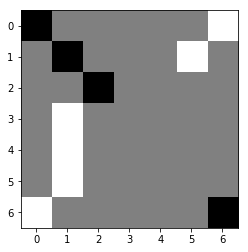

((2, 2), (4, 2)): n_v:  2205 q_all:+0.010387 q:+0.028055 q_m:+0.133333 p:0.772165
((2, 2), (4, 0)): n_v:   349 q_all:+0.008298 q:+0.043673 q_m:+0.133333 p:0.127052
((2, 2), (3, 2)): n_v:    75 q_all:+0.001350 q:+0.018041 q_m:+0.100000 p:0.030740
((1, 1), (3, 2)): n_v:    34 q_all:-0.014146 q:-0.001297 q_m:+0.066667 p:0.017256
((2, 2), (3, 0)): n_v:    21 q_all:-0.034587 q:-0.001116 q_m:+0.066667 p:0.013850
((2, 2), (4, 4)): n_v:    15 q_all:-0.075516 q:-0.059979 q_m:-0.066667 p:0.013950
((1, 1), (3, 0)): n_v:     5 q_all:-0.023597 q:-0.011985 q_m:+0.066667 p:0.002933
((2, 2), (2, 4)): n_v:     3 q_all:-0.046712 q:-0.020325 q_m:-0.000000 p:0.002289
((2, 2), (4, 3)): n_v:     3 q_all:-0.091876 q:-0.046753 q_m:-0.066667 p:0.003329
((2, 2), (3, 4)): n_v:     3 q_all:-0.068800 q:-0.056210 q_m:-0.066667 p:0.002511
((6, 6), (5, 5)): n_v:     3 q_all:-0.017881 q:-0.037192 q_m:-0.033333 p:0.001777
((2, 2), (2, 0)): n_v:     3 q_all:-0.007851 q:-0.026983 q_m:-0.000000 p:0.001445
((1, 1), (2, 0))

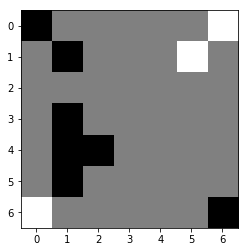

((6, 0), (5, 2)): n_v:  3980 q_all:-0.009881 q:-0.005591 q_m:+0.066667 p:0.873493
((6, 0), (4, 0)): n_v:   238 q_all:-0.027816 q:-0.010787 q_m:+0.066667 p:0.073547
((1, 5), (1, 4)): n_v:    44 q_all:-0.047594 q:-0.056515 q_m:-0.100000 p:0.017906
((1, 5), (3, 4)): n_v:    16 q_all:-0.070471 q:-0.067747 q_m:-0.133333 p:0.008839
((6, 0), (5, 0)): n_v:    13 q_all:-0.044174 q:-0.034110 q_m:+0.033333 p:0.005157
((0, 6), (1, 4)): n_v:    12 q_all:-0.066716 q:-0.069341 q_m:-0.133333 p:0.006354
((1, 5), (2, 6)): n_v:     6 q_all:-0.062249 q:-0.066446 q_m:-0.100000 p:0.003300
((1, 5), (2, 4)): n_v:     5 q_all:-0.048724 q:-0.058387 q_m:-0.100000 p:0.002445
((0, 6), (2, 6)): n_v:     3 q_all:-0.069419 q:-0.070284 q_m:-0.133333 p:0.001660
((6, 0), (6, 2)): n_v:     2 q_all:-0.083543 q:-0.039919 q_m:-0.066667 p:0.001366
((1, 5), (3, 3)): n_v:     1 q_all:-0.065055 q:-0.057471 q_m:-0.066667 p:0.000957
((0, 6), (1, 6)): n_v:     1 q_all:-0.071996 q:-0.058612 q_m:-0.100000 p:0.000592
((1, 5), (2, 3))

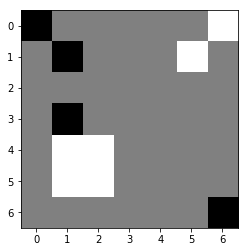

((3, 1), (3, 2)): n_v:  5372 q_all:+0.015146 q:+0.008769 q_m:+0.100000 p:0.850424
((3, 1), (5, 0)): n_v:   146 q_all:-0.005069 q:+0.003831 q_m:+0.066667 p:0.035773
((3, 1), (4, 0)): n_v:   137 q_all:+0.001887 q:+0.001922 q_m:+0.100000 p:0.029460
((1, 1), (3, 2)): n_v:    60 q_all:-0.002507 q:-0.002340 q_m:+0.066667 p:0.014051
((3, 1), (4, 3)): n_v:    52 q_all:-0.011151 q:+0.000133 q_m:+0.066667 p:0.014248
((3, 1), (5, 3)): n_v:    26 q_all:-0.008630 q:+0.007246 q_m:+0.066667 p:0.006705
((6, 6), (5, 5)): n_v:    24 q_all:-0.017612 q:-0.028216 q_m:-0.033333 p:0.007375
((3, 1), (1, 0)): n_v:    22 q_all:-0.059851 q:-0.071258 q_m:-0.066667 p:0.010945
((3, 1), (3, 0)): n_v:    11 q_all:-0.032768 q:-0.037584 q_m:+0.033333 p:0.004212
((3, 1), (2, 3)): n_v:     7 q_all:-0.045703 q:-0.042578 q_m:-0.066667 p:0.003233
((3, 1), (3, 3)): n_v:     7 q_all:-0.023346 q:-0.024380 q_m:-0.000000 p:0.002540
((3, 1), (1, 3)): n_v:     4 q_all:-0.053821 q:-0.051832 q_m:-0.066667 p:0.002116
((1, 1), (2, 0))

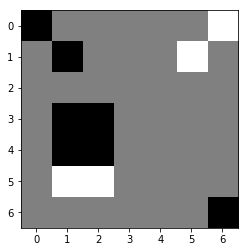

((5, 2), (4, 3)): n_v:  3163 q_all:-0.015878 q:-0.010338 q_m:+0.066667 p:0.506918
((5, 2), (3, 3)): n_v:  1163 q_all:-0.017010 q:-0.016686 q_m:+0.033333 p:0.191586
((5, 1), (4, 0)): n_v:   740 q_all:-0.005967 q:-0.009699 q_m:+0.066667 p:0.090160
((5, 2), (4, 0)): n_v:   121 q_all:-0.022584 q:-0.022090 q_m:+0.033333 p:0.022627
((1, 5), (2, 3)): n_v:    99 q_all:-0.028980 q:-0.023347 q_m:-0.033333 p:0.020977
((5, 1), (4, 3)): n_v:    80 q_all:-0.031325 q:-0.027078 q_m:+0.033333 p:0.017824
((5, 2), (5, 3)): n_v:    74 q_all:-0.031120 q:-0.010878 q_m:-0.000000 p:0.016124
((1, 5), (2, 4)): n_v:    53 q_all:-0.026959 q:-0.033287 q_m:-0.066667 p:0.010933
((1, 5), (3, 3)): n_v:    48 q_all:-0.029858 q:-0.013769 q_m:+0.033333 p:0.010461
((5, 2), (3, 0)): n_v:    48 q_all:-0.077356 q:-0.056886 q_m:+0.033333 p:0.019263
((5, 1), (5, 0)): n_v:    47 q_all:-0.042219 q:-0.031416 q_m:-0.000000 p:0.012460
((5, 2), (4, 4)): n_v:    46 q_all:-0.049324 q:-0.070678 q_m:-0.100000 p:0.013441
((5, 1), (3, 0))

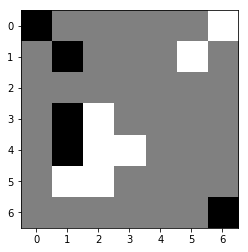

((3, 1), (3, 3)): n_v:  2411 q_all:+0.021856 q:+0.013452 q_m:+0.133333 p:0.522607
((1, 1), (3, 3)): n_v:  1395 q_all:+0.018656 q:+0.030853 q_m:+0.133333 p:0.322803
((3, 1), (5, 3)): n_v:   277 q_all:+0.020516 q:+0.003629 q_m:+0.133333 p:0.061797
((4, 1), (3, 3)): n_v:   142 q_all:+0.006946 q:+0.017320 q_m:+0.133333 p:0.040429
((4, 1), (5, 3)): n_v:    76 q_all:-0.002847 q:+0.004543 q_m:+0.133333 p:0.025106
((3, 1), (1, 3)): n_v:    33 q_all:-0.026066 q:-0.038455 q_m:-0.066667 p:0.014588
((1, 1), (1, 3)): n_v:    16 q_all:-0.026713 q:-0.041766 q_m:-0.066667 p:0.007390
((6, 6), (5, 5)): n_v:     4 q_all:-0.028653 q:-0.024798 q_m:-0.033333 p:0.001938
((3, 1), (2, 3)): n_v:     1 q_all:+0.010002 q:-0.020158 q_m:-0.000000 p:0.000417
((4, 1), (6, 1)): n_v:     1 q_all:-0.013700 q:-0.019630 q_m:+0.066667 p:0.000520
((4, 1), (6, 3)): n_v:     0 q_all:-0.027224 q:-0.027224 q_m:-0.000000 p:0.000085
((3, 1), (4, 0)): n_v:     0 q_all:-0.007366 q:-0.007366 q_m:+0.033333 p:0.000055
((3, 1), (1, 2))

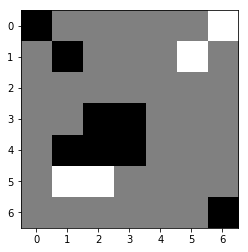

((5, 2), (3, 1)): n_v:  2112 q_all:-0.030830 q:-0.013473 q_m:+0.066667 p:0.573761
((5, 1), (3, 1)): n_v:   589 q_all:-0.011484 q:-0.006119 q_m:+0.066667 p:0.102506
((5, 2), (5, 3)): n_v:   556 q_all:-0.027602 q:-0.031798 q_m:+0.033333 p:0.142019
((5, 2), (4, 4)): n_v:   301 q_all:-0.032638 q:-0.050951 q_m:-0.000000 p:0.084721
((1, 5), (2, 4)): n_v:    79 q_all:-0.024656 q:-0.028135 q_m:-0.033333 p:0.019183
((5, 2), (3, 4)): n_v:    75 q_all:-0.032394 q:-0.049034 q_m:-0.000000 p:0.021078
((1, 5), (3, 5)): n_v:    39 q_all:-0.051171 q:-0.049233 q_m:-0.133333 p:0.014762
((5, 2), (6, 4)): n_v:    20 q_all:-0.049343 q:-0.061169 q_m:-0.133333 p:0.007385
((1, 5), (3, 4)): n_v:    19 q_all:-0.043127 q:-0.042479 q_m:-0.000000 p:0.006392
((5, 2), (5, 4)): n_v:    18 q_all:-0.050316 q:-0.048966 q_m:-0.066667 p:0.006981
((5, 2), (3, 0)): n_v:    11 q_all:-0.042658 q:-0.079127 q_m:-0.066667 p:0.003947
((5, 1), (5, 3)): n_v:     6 q_all:-0.042903 q:-0.069097 q_m:-0.000000 p:0.002301
((5, 1), (4, 0))

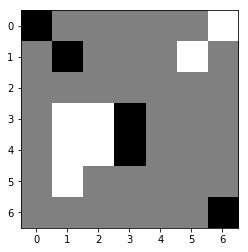

((4, 3), (5, 2)): n_v:  2694 q_all:+0.047131 q:+0.057863 q_m:+0.166667 p:0.440899
((4, 3), (5, 4)): n_v:   772 q_all:-0.029730 q:-0.023747 q_m:-0.033333 p:0.434781
((3, 3), (5, 2)): n_v:   162 q_all:+0.041299 q:+0.048081 q_m:+0.133333 p:0.031539
((3, 3), (5, 4)): n_v:    62 q_all:-0.039064 q:-0.027988 q_m:-0.066667 p:0.038007
((1, 1), (1, 2)): n_v:    38 q_all:-0.020355 q:-0.045475 q_m:-0.033333 p:0.019536
((3, 3), (1, 2)): n_v:    21 q_all:-0.033218 q:-0.048668 q_m:-0.066667 p:0.012599
((3, 3), (1, 4)): n_v:    13 q_all:+0.005664 q:+0.005973 q_m:-0.000000 p:0.005246
((4, 3), (6, 5)): n_v:     4 q_all:-0.047759 q:-0.034433 q_m:-0.066667 p:0.003001
((4, 3), (6, 1)): n_v:     4 q_all:+0.005652 q:-0.011264 q_m:-0.000000 p:0.001659
((1, 1), (2, 1)): n_v:     2 q_all:-0.004317 q:+0.000224 q_m:+0.100000 p:0.001279
((3, 3), (2, 5)): n_v:     2 q_all:+0.006513 q:+0.004656 q_m:-0.000000 p:0.000754
((3, 3), (2, 4)): n_v:     2 q_all:+0.022805 q:-0.000108 q_m:+0.033333 p:0.000790
((4, 3), (5, 5))

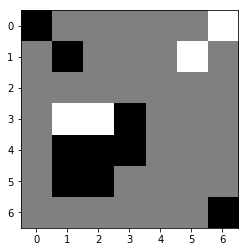

((3, 1), (5, 3)): n_v:  2105 q_all:-0.039363 q:-0.065210 q_m:+0.033333 p:0.416479
((3, 2), (5, 3)): n_v:   589 q_all:-0.049330 q:-0.059540 q_m:+0.033333 p:0.145237
((3, 1), (1, 0)): n_v:   570 q_all:-0.050015 q:-0.058467 q_m:-0.033333 p:0.142519
((3, 1), (5, 0)): n_v:   276 q_all:-0.051530 q:-0.067212 q_m:-0.033333 p:0.071140
((3, 2), (1, 0)): n_v:   266 q_all:-0.045518 q:-0.048951 q_m:-0.033333 p:0.060566
((3, 2), (5, 0)): n_v:   125 q_all:-0.082581 q:-0.037145 q_m:-0.033333 p:0.051375
((3, 1), (1, 3)): n_v:    85 q_all:-0.090927 q:-0.106281 q_m:-0.166667 p:0.038030
((3, 2), (4, 0)): n_v:    84 q_all:-0.040616 q:-0.039389 q_m:-0.033333 p:0.017260
((3, 2), (1, 3)): n_v:    45 q_all:-0.087594 q:-0.097515 q_m:-0.166667 p:0.019801
((3, 1), (4, 0)): n_v:    36 q_all:-0.041539 q:-0.043517 q_m:-0.000000 p:0.007490
((3, 2), (5, 4)): n_v:    22 q_all:-0.064238 q:-0.077793 q_m:-0.100000 p:0.007264
((3, 2), (4, 4)): n_v:    14 q_all:-0.078642 q:-0.076162 q_m:-0.033333 p:0.005461
((3, 2), (2, 0))

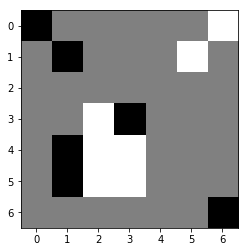

((4, 1), (3, 1)): n_v:  3163 q_all:+0.050243 q:+0.021422 q_m:+0.133333 p:0.745362
((3, 3), (4, 4)): n_v:   170 q_all:+0.032567 q:+0.047868 q_m:+0.133333 p:0.055977
((5, 1), (6, 2)): n_v:    90 q_all:+0.032490 q:+0.032356 q_m:+0.133333 p:0.029802
((3, 3), (2, 4)): n_v:    64 q_all:+0.053742 q:+0.043099 q_m:+0.066667 p:0.014071
((3, 3), (5, 5)): n_v:    58 q_all:-0.004119 q:+0.012914 q_m:-0.033333 p:0.030268
((3, 3), (5, 4)): n_v:    45 q_all:+0.026102 q:+0.054665 q_m:+0.100000 p:0.016533
((1, 1), (2, 2)): n_v:    32 q_all:+0.021140 q:+0.004337 q_m:+0.066667 p:0.012309
((3, 3), (1, 4)): n_v:    20 q_all:+0.035746 q:+0.052168 q_m:+0.033333 p:0.006399
((4, 1), (6, 2)): n_v:    19 q_all:+0.017867 q:+0.014252 q_m:+0.100000 p:0.007846
((6, 6), (5, 5)): n_v:    16 q_all:+0.004700 q:+0.014471 q_m:-0.000000 p:0.007868
((3, 3), (3, 1)): n_v:    16 q_all:+0.033778 q:+0.008014 q_m:+0.100000 p:0.005283
((3, 3), (3, 5)): n_v:    15 q_all:+0.002578 q:+0.029592 q_m:-0.033333 p:0.007105
((1, 1), (1, 2))

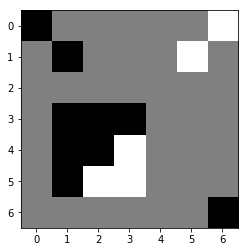

((5, 2), (4, 0)): n_v:  2307 q_all:-0.053301 q:-0.049430 q_m:+0.066667 p:0.464165
((4, 3), (2, 2)): n_v:   730 q_all:-0.045310 q:-0.019062 q_m:+0.133333 p:0.119817
((4, 3), (5, 5)): n_v:   382 q_all:-0.046422 q:-0.032935 q_m:-0.066667 p:0.064675
((4, 3), (2, 4)): n_v:   276 q_all:-0.093323 q:-0.061947 q_m:-0.066667 p:0.106768
((5, 3), (5, 5)): n_v:   170 q_all:-0.054342 q:-0.035604 q_m:-0.066667 p:0.035204
((4, 3), (4, 4)): n_v:   137 q_all:-0.054659 q:-0.092050 q_m:-0.033333 p:0.028576
((1, 5), (2, 4)): n_v:   117 q_all:-0.049809 q:-0.081632 q_m:-0.033333 p:0.021776
((4, 3), (2, 1)): n_v:    97 q_all:-0.036862 q:-0.013932 q_m:+0.066667 p:0.012073
((5, 2), (5, 0)): n_v:    46 q_all:-0.078086 q:-0.091825 q_m:-0.000000 p:0.014795
((1, 5), (2, 6)): n_v:    42 q_all:-0.070015 q:-0.092935 q_m:-0.100000 p:0.011960
((5, 2), (6, 1)): n_v:    28 q_all:-0.055584 q:-0.058321 q_m:-0.033333 p:0.006079
((5, 2), (6, 0)): n_v:    28 q_all:-0.080261 q:-0.081366 q_m:-0.066667 p:0.009416
((5, 3), (6, 1))

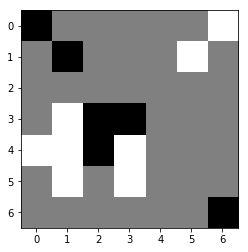

((4, 2), (5, 2)): n_v:  3488 q_all:+0.050902 q:+0.060887 q_m:+0.233333 p:0.837653
((3, 2), (5, 0)): n_v:   120 q_all:+0.052215 q:+0.010126 q_m:+0.133333 p:0.028054
((3, 2), (3, 0)): n_v:    96 q_all:+0.034140 q:-0.000895 q_m:+0.133333 p:0.031524
((1, 1), (1, 2)): n_v:    47 q_all:-0.039522 q:-0.060727 q_m:-0.033333 p:0.033193
((3, 3), (5, 2)): n_v:    37 q_all:+0.046035 q:+0.042500 q_m:+0.200000 p:0.009697
((4, 2), (5, 0)): n_v:    37 q_all:+0.050516 q:+0.021598 q_m:+0.133333 p:0.008870
((3, 2), (1, 0)): n_v:    18 q_all:-0.030237 q:-0.053662 q_m:-0.066667 p:0.012175
((3, 2), (5, 4)): n_v:    14 q_all:+0.004986 q:-0.004840 q_m:+0.066667 p:0.006415
((3, 3), (5, 4)): n_v:    12 q_all:-0.001390 q:+0.007011 q_m:+0.066667 p:0.006126
((3, 2), (5, 2)): n_v:    11 q_all:+0.024982 q:+0.041414 q_m:+0.200000 p:0.004286
((4, 2), (3, 0)): n_v:     8 q_all:+0.039895 q:-0.003348 q_m:+0.133333 p:0.002484
((1, 1), (3, 0)): n_v:     7 q_all:+0.052125 q:+0.004704 q_m:+0.133333 p:0.001742
((3, 3), (1, 2))

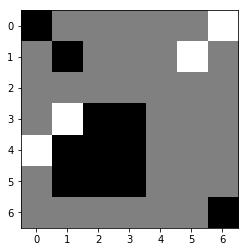

((4, 0), (6, 2)): n_v:  3225 q_all:-0.043151 q:-0.048165 q_m:-0.033333 p:0.585783
((3, 1), (1, 0)): n_v:   766 q_all:-0.044777 q:-0.059919 q_m:-0.100000 p:0.144806
((4, 0), (5, 0)): n_v:   451 q_all:-0.070038 q:-0.068047 q_m:-0.066667 p:0.135667
((3, 1), (5, 0)): n_v:   286 q_all:-0.070790 q:-0.084806 q_m:-0.100000 p:0.086835
((3, 1), (2, 2)): n_v:    51 q_all:-0.054523 q:-0.084511 q_m:-0.000000 p:0.011918
((4, 0), (2, 2)): n_v:    14 q_all:-0.090988 q:-0.098813 q_m:-0.033333 p:0.005881
((1, 5), (2, 4)): n_v:    12 q_all:-0.109160 q:-0.090154 q_m:-0.133333 p:0.005879
((4, 0), (6, 1)): n_v:    10 q_all:-0.072344 q:-0.072619 q_m:-0.100000 p:0.003215
((4, 0), (6, 0)): n_v:     8 q_all:-0.093327 q:-0.095107 q_m:-0.166667 p:0.003383
((3, 1), (2, 3)): n_v:     6 q_all:-0.060640 q:-0.086383 q_m:-0.100000 p:0.001704
((3, 1), (1, 3)): n_v:     5 q_all:-0.120985 q:-0.120356 q_m:-0.233333 p:0.002925
((3, 1), (1, 2)): n_v:     2 q_all:-0.076859 q:-0.088509 q_m:-0.166667 p:0.000950
((0, 6), (1, 6))

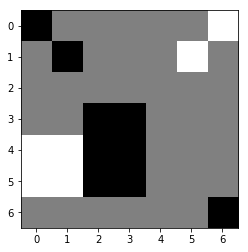

((3, 2), (3, 1)): n_v:  2362 q_all:+0.121698 q:+0.049995 q_m:+0.266667 p:0.339362
((5, 2), (6, 1)): n_v:    20 q_all:+0.040754 q:+0.032170 q_m:+0.266667 p:0.014231
((5, 2), (6, 0)): n_v:     5 q_all:+0.031794 q:+0.034021 q_m:+0.233333 p:0.003678
((5, 3), (3, 1)): n_v:     5 q_all:+0.089145 q:+0.035082 q_m:+0.233333 p:0.001864
((6, 6), (5, 5)): n_v:     4 q_all:+0.009933 q:+0.032943 q_m:+0.133333 p:0.004069
((5, 2), (3, 1)): n_v:     4 q_all:+0.005887 q:+0.028185 q_m:+0.233333 p:0.003960
((5, 3), (6, 5)): n_v:     3 q_all:+0.042653 q:+0.025494 q_m:+0.100000 p:0.001991
((4, 2), (6, 0)): n_v:     3 q_all:+0.026462 q:+0.061646 q_m:+0.233333 p:0.002841
((4, 3), (3, 5)): n_v:     2 q_all:-0.019896 q:+0.027229 q_m:+0.100000 p:0.002138
((3, 3), (3, 1)): n_v:     2 q_all:+0.044767 q:+0.032415 q_m:+0.233333 p:0.001830
((3, 3), (3, 5)): n_v:     2 q_all:+0.052625 q:+0.031609 q_m:+0.100000 p:0.001637
((5, 3), (3, 5)): n_v:     2 q_all:+0.045060 q:+0.023657 q_m:+0.100000 p:0.001854
((4, 3), (3, 1))

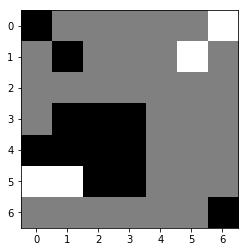

((5, 0), (3, 0)): n_v:  1574 q_all:-0.079249 q:-0.086660 q_m:-0.066667 p:0.173717
((1, 5), (2, 4)): n_v:   848 q_all:-0.110338 q:-0.085597 q_m:-0.166667 p:0.226597
((5, 1), (6, 2)): n_v:   831 q_all:-0.113641 q:-0.080920 q_m:-0.100000 p:0.236025
((5, 1), (3, 0)): n_v:   286 q_all:-0.124362 q:-0.120909 q_m:-0.066667 p:0.096517
((1, 5), (3, 4)): n_v:   165 q_all:-0.128785 q:-0.089527 q_m:-0.133333 p:0.059380
((5, 0), (6, 2)): n_v:   146 q_all:-0.096725 q:-0.077481 q_m:-0.133333 p:0.029047
((0, 6), (2, 4)): n_v:   120 q_all:-0.109303 q:-0.096614 q_m:-0.200000 p:0.031651
((1, 5), (3, 6)): n_v:    81 q_all:-0.188082 q:-0.137035 q_m:-0.266667 p:0.053774
((1, 5), (2, 3)): n_v:    43 q_all:-0.106072 q:-0.087156 q_m:-0.133333 p:0.010645
((5, 1), (6, 3)): n_v:    32 q_all:-0.098863 q:-0.084117 q_m:-0.133333 p:0.006790
((5, 0), (6, 1)): n_v:    32 q_all:-0.105340 q:-0.136161 q_m:-0.166667 p:0.007975
((1, 5), (0, 4)): n_v:    29 q_all:-0.146459 q:-0.127651 q_m:-0.233333 p:0.013308
((1, 5), (1, 4))

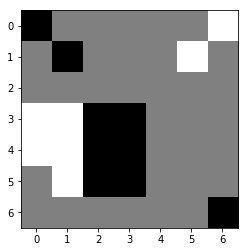

((3, 2), (5, 0)): n_v:  2028 q_all:+0.070682 q:+0.114799 q_m:+0.266667 p:0.358608
((5, 2), (5, 0)): n_v:   792 q_all:+0.059570 q:+0.097773 q_m:+0.266667 p:0.188938
((4, 2), (5, 0)): n_v:   256 q_all:+0.038163 q:+0.107566 q_m:+0.266667 p:0.091801
((3, 2), (1, 0)): n_v:   171 q_all:-0.007819 q:-0.009707 q_m:+0.066667 p:0.104912
((1, 1), (2, 1)): n_v:   104 q_all:+0.052227 q:+0.041606 q_m:+0.233333 p:0.029126
((0, 0), (1, 0)): n_v:    91 q_all:+0.020801 q:+0.001792 q_m:+0.100000 p:0.041134
((6, 6), (5, 6)): n_v:    61 q_all:+0.038922 q:+0.042400 q_m:+0.100000 p:0.021557
((1, 1), (2, 0)): n_v:    21 q_all:+0.062664 q:+0.050976 q_m:+0.233333 p:0.004722
((5, 2), (6, 1)): n_v:     4 q_all:+0.041871 q:+0.034967 q_m:+0.166667 p:0.001376
((3, 3), (2, 1)): n_v:     4 q_all:+0.053574 q:+0.027242 q_m:+0.200000 p:0.001219
((3, 3), (2, 4)): n_v:     3 q_all:+0.048895 q:+0.052823 q_m:+0.166667 p:0.000814
((3, 3), (2, 5)): n_v:     3 q_all:+0.052286 q:+0.055534 q_m:+0.133333 p:0.000888
((5, 3), (6, 4))

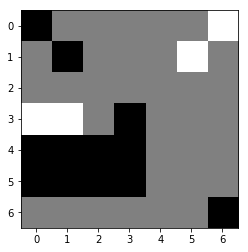

((3, 1), (3, 2)): n_v:  3196 q_all:-0.058325 q:-0.073121 q_m:+0.033333 p:0.799031
((3, 0), (3, 2)): n_v:   437 q_all:-0.056740 q:-0.065529 q_m:-0.000000 p:0.105792
((3, 1), (1, 0)): n_v:   153 q_all:-0.075832 q:-0.081721 q_m:-0.133333 p:0.052068
((1, 5), (3, 4)): n_v:    41 q_all:-0.142821 q:-0.130147 q_m:-0.133333 p:0.028261
((3, 0), (1, 0)): n_v:    20 q_all:-0.082541 q:-0.101682 q_m:-0.133333 p:0.007796
((3, 1), (1, 2)): n_v:     2 q_all:-0.136245 q:-0.109649 q_m:-0.200000 p:0.001611
((3, 1), (2, 3)): n_v:     2 q_all:-0.125434 q:-0.121549 q_m:-0.200000 p:0.001209
((3, 1), (1, 3)): n_v:     1 q_all:-0.120276 q:-0.157748 q_m:-0.266667 p:0.001034
((3, 0), (2, 2)): n_v:     1 q_all:-0.112408 q:-0.108273 q_m:-0.133333 p:0.000768
((3, 0), (1, 2)): n_v:     1 q_all:-0.126526 q:-0.127830 q_m:-0.200000 p:0.000933
((0, 6), (2, 6)): n_v:     0 q_all:-0.179027 q:-0.179027 q_m:-0.266667 p:0.000002
((1, 5), (2, 4)): n_v:     0 q_all:-0.119001 q:-0.119001 q_m:-0.166667 p:0.000170
((1, 5), (0, 4))

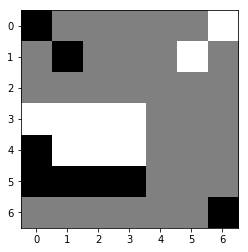

((5, 3), (4, 4)): n_v:  2255 q_all:+0.056438 q:+0.071350 q_m:+0.133333 p:0.398474
((1, 1), (2, 2)): n_v:  1530 q_all:+0.040962 q:+0.029007 q_m:+0.200000 p:0.379925
((1, 1), (2, 1)): n_v:   729 q_all:+0.062220 q:+0.047115 q_m:+0.200000 p:0.109375
((0, 0), (2, 2)): n_v:    63 q_all:+0.029233 q:+0.011730 q_m:+0.166667 p:0.019166
((6, 6), (4, 4)): n_v:    44 q_all:+0.044638 q:+0.053843 q_m:+0.100000 p:0.010392
((4, 0), (2, 2)): n_v:    34 q_all:+0.017835 q:-0.002886 q_m:+0.166667 p:0.012000
((5, 2), (4, 4)): n_v:    29 q_all:+0.032968 q:+0.038262 q_m:+0.100000 p:0.008310
((1, 1), (2, 0)): n_v:    25 q_all:+0.029381 q:+0.038680 q_m:+0.133333 p:0.007811
((5, 3), (3, 4)): n_v:    21 q_all:+0.050514 q:+0.058033 q_m:+0.100000 p:0.004303
((0, 0), (2, 1)): n_v:    17 q_all:+0.044287 q:+0.033463 q_m:+0.166667 p:0.004000
((5, 3), (4, 5)): n_v:    11 q_all:+0.011403 q:+0.028208 q_m:-0.033333 p:0.004212
((5, 3), (3, 5)): n_v:    11 q_all:+0.017610 q:+0.046013 q_m:-0.033333 p:0.004051
((5, 3), (5, 4))

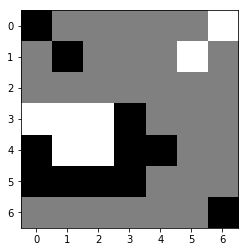

((3, 2), (5, 4)): n_v:  1322 q_all:-0.059764 q:-0.056020 q_m:+0.066667 p:0.351740
((3, 0), (1, 0)): n_v:   424 q_all:-0.020778 q:-0.044178 q_m:-0.000000 p:0.028322
((4, 2), (6, 1)): n_v:   373 q_all:-0.051016 q:-0.036557 q_m:+0.066667 p:0.082606
((1, 5), (3, 4)): n_v:   371 q_all:-0.053505 q:-0.055079 q_m:+0.066667 p:0.086889
((3, 2), (3, 4)): n_v:   315 q_all:-0.075206 q:-0.071147 q_m:+0.066667 p:0.108352
((3, 1), (1, 0)): n_v:   289 q_all:-0.072624 q:-0.079905 q_m:-0.000000 p:0.095827
((3, 2), (1, 0)): n_v:   244 q_all:-0.057467 q:-0.078068 q_m:-0.000000 p:0.062161
((4, 2), (3, 4)): n_v:   128 q_all:-0.080203 q:-0.058604 q_m:+0.066667 p:0.047124
((4, 2), (5, 4)): n_v:    66 q_all:-0.078036 q:-0.035024 q_m:+0.066667 p:0.023723
((3, 2), (1, 4)): n_v:    48 q_all:-0.107639 q:-0.118615 q_m:-0.133333 p:0.025002
((3, 2), (1, 2)): n_v:    32 q_all:-0.087541 q:-0.088931 q_m:-0.066667 p:0.013141
((3, 0), (1, 2)): n_v:    25 q_all:-0.057991 q:-0.078492 q_m:-0.066667 p:0.006401
((3, 2), (2, 4))

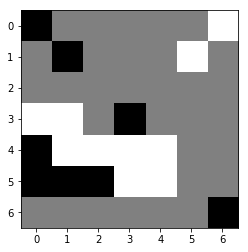

((3, 3), (3, 2)): n_v:  1829 q_all:+0.060428 q:+0.036702 q_m:+0.233333 p:0.494149
((3, 3), (3, 4)): n_v:  1028 q_all:+0.030974 q:+0.039498 q_m:+0.100000 p:0.453028
((1, 1), (3, 2)): n_v:   100 q_all:+0.065958 q:+0.031375 q_m:+0.200000 p:0.023782
((3, 3), (5, 5)): n_v:    15 q_all:+0.040822 q:+0.062355 q_m:+0.066667 p:0.005999
((4, 0), (3, 2)): n_v:    12 q_all:+0.008301 q:-0.009428 q_m:+0.200000 p:0.007373
((5, 0), (3, 2)): n_v:    11 q_all:+0.035983 q:-0.004603 q_m:+0.200000 p:0.004721
((5, 2), (3, 4)): n_v:     4 q_all:+0.019681 q:+0.011756 q_m:+0.066667 p:0.001984
((6, 6), (5, 5)): n_v:     3 q_all:+0.060527 q:+0.063141 q_m:+0.100000 p:0.000725
((5, 1), (3, 2)): n_v:     3 q_all:-0.019404 q:-0.013702 q_m:+0.200000 p:0.002624
((5, 2), (3, 2)): n_v:     3 q_all:-0.001230 q:+0.002083 q_m:+0.200000 p:0.001964
((3, 3), (2, 5)): n_v:     1 q_all:+0.018231 q:+0.056660 q_m:-0.000000 p:0.000380
((5, 2), (6, 3)): n_v:     1 q_all:+0.034924 q:+0.021824 q_m:+0.100000 p:0.000584
((3, 3), (4, 5))

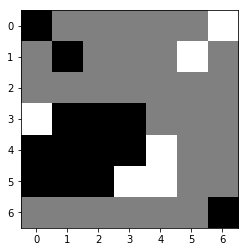

((5, 3), (6, 1)): n_v:  1940 q_all:-0.048199 q:-0.074784 q_m:-0.033333 p:0.300936
((4, 4), (3, 4)): n_v:   407 q_all:-0.083171 q:-0.107640 q_m:-0.066667 p:0.139835
((3, 0), (1, 0)): n_v:   332 q_all:-0.055884 q:-0.079211 q_m:-0.100000 p:0.065231
((5, 3), (6, 5)): n_v:   197 q_all:-0.125909 q:-0.093287 q_m:-0.166667 p:0.112889
((4, 4), (6, 5)): n_v:   117 q_all:-0.090304 q:-0.081153 q_m:-0.166667 p:0.044672
((5, 3), (3, 4)): n_v:    96 q_all:-0.111566 q:-0.113942 q_m:-0.100000 p:0.047535
((4, 4), (2, 2)): n_v:    75 q_all:-0.110708 q:-0.117631 q_m:+0.033333 p:0.037195
((3, 0), (2, 2)): n_v:    64 q_all:-0.060197 q:-0.091761 q_m:+0.033333 p:0.014063
((5, 4), (3, 4)): n_v:    62 q_all:-0.106768 q:-0.141828 q_m:-0.100000 p:0.029617
((5, 4), (6, 5)): n_v:    59 q_all:-0.101394 q:-0.075633 q_m:-0.133333 p:0.026204
((4, 4), (5, 5)): n_v:    38 q_all:-0.072012 q:-0.090983 q_m:-0.133333 p:0.011007
((4, 4), (5, 6)): n_v:    32 q_all:-0.092075 q:-0.092977 q_m:-0.166667 p:0.012835
((4, 4), (2, 4))

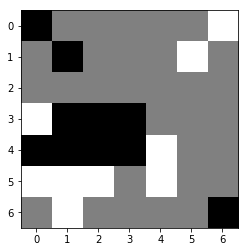

((4, 2), (5, 3)): n_v:  2832 q_all:+0.042412 q:+0.033451 q_m:+0.266667 p:0.378561
((4, 3), (6, 2)): n_v:   413 q_all:+0.031857 q:+0.009593 q_m:+0.233333 p:0.077854
((4, 2), (6, 0)): n_v:   383 q_all:+0.059254 q:+0.025964 q_m:+0.233333 p:0.017606
((4, 3), (6, 4)): n_v:   111 q_all:-0.021707 q:-0.023124 q_m:+0.100000 p:0.052123
((4, 2), (6, 2)): n_v:    87 q_all:+0.064743 q:+0.001728 q_m:+0.233333 p:0.001680
((3, 3), (5, 3)): n_v:    78 q_all:+0.043759 q:+0.032845 q_m:+0.233333 p:0.009964
((4, 0), (6, 2)): n_v:    31 q_all:-0.000019 q:-0.016681 q_m:+0.233333 p:0.010736
((4, 3), (5, 5)): n_v:    19 q_all:+0.014037 q:+0.017468 q_m:+0.166667 p:0.005375
((3, 1), (5, 3)): n_v:     8 q_all:-0.007191 q:-0.015763 q_m:+0.233333 p:0.003468
((3, 3), (5, 5)): n_v:     8 q_all:-0.003833 q:+0.007786 q_m:+0.166667 p:0.003141
((3, 2), (5, 3)): n_v:     7 q_all:+0.026647 q:+0.012543 q_m:+0.233333 p:0.001630
((3, 3), (1, 3)): n_v:     6 q_all:-0.007542 q:-0.039541 q_m:+0.033333 p:0.002682
((6, 6), (5, 5))

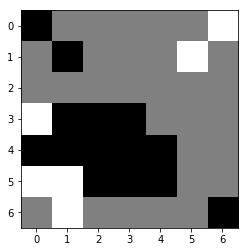

((1, 5), (3, 4)): n_v:  2014 q_all:-0.058813 q:-0.066970 q_m:-0.066667 p:0.505109
((6, 1), (6, 3)): n_v:  1136 q_all:-0.041753 q:-0.050428 q_m:-0.066667 p:0.191872
((3, 0), (2, 2)): n_v:   432 q_all:-0.018440 q:-0.057527 q_m:-0.000000 p:0.024650
((5, 1), (6, 3)): n_v:   337 q_all:-0.051449 q:-0.044379 q_m:-0.066667 p:0.072691
((5, 1), (6, 2)): n_v:   139 q_all:-0.107454 q:-0.097938 q_m:-0.100000 p:0.067389
((1, 5), (2, 4)): n_v:    94 q_all:-0.068664 q:-0.079476 q_m:-0.166667 p:0.028006
((3, 0), (1, 0)): n_v:    42 q_all:-0.061655 q:-0.067142 q_m:-0.133333 p:0.011256
((3, 0), (2, 1)): n_v:    22 q_all:-0.065108 q:-0.079633 q_m:-0.033333 p:0.006436
((3, 0), (1, 2)): n_v:    10 q_all:-0.082673 q:-0.093552 q_m:-0.200000 p:0.003982
((5, 0), (6, 0)): n_v:     9 q_all:-0.094181 q:-0.134989 q_m:-0.233333 p:0.003731
((1, 5), (3, 5)): n_v:     9 q_all:-0.080349 q:-0.089031 q_m:-0.200000 p:0.003456
((1, 5), (2, 5)): n_v:     8 q_all:-0.076865 q:-0.114406 q_m:-0.233333 p:0.002923
((0, 6), (2, 4))

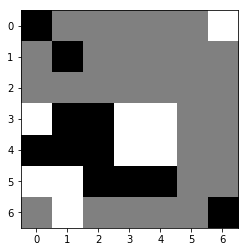

((4, 2), (6, 0)): n_v:  1579 q_all:+0.090417 q:+0.087361 q_m:+0.266667 p:0.154204
((5, 4), (4, 5)): n_v:   373 q_all:+0.027668 q:+0.021177 q_m:+0.233333 p:0.159565
((3, 2), (2, 3)): n_v:   291 q_all:+0.049253 q:+0.033498 q_m:+0.233333 p:0.091684
((4, 0), (6, 0)): n_v:   257 q_all:+0.057234 q:+0.041788 q_m:+0.266667 p:0.070126
((5, 2), (6, 0)): n_v:   227 q_all:+0.070586 q:+0.066793 q_m:+0.266667 p:0.045797
((5, 2), (6, 2)): n_v:   127 q_all:+0.035708 q:+0.032516 q_m:+0.233333 p:0.049054
((5, 4), (3, 5)): n_v:   100 q_all:+0.036461 q:+0.020935 q_m:+0.200000 p:0.038379
((5, 3), (4, 5)): n_v:    85 q_all:+0.027684 q:+0.014795 q_m:+0.200000 p:0.036439
((1, 1), (2, 1)): n_v:    78 q_all:+0.065289 q:+0.026820 q_m:+0.166667 p:0.017925
((5, 4), (6, 2)): n_v:    64 q_all:+0.050939 q:+0.027990 q_m:+0.200000 p:0.019479
((4, 0), (6, 2)): n_v:    60 q_all:+0.069787 q:+0.004432 q_m:+0.200000 p:0.012313
((5, 3), (6, 4)): n_v:    55 q_all:-0.008969 q:-0.022613 q_m:+0.100000 p:0.034111
((1, 1), (2, 3))

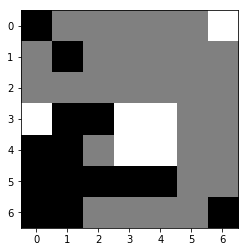

((3, 3), (4, 2)): n_v:  2031 q_all:-0.079642 q:-0.069792 q_m:+0.166667 p:0.314784
((3, 4), (4, 2)): n_v:   479 q_all:-0.085476 q:-0.074890 q_m:+0.133333 p:0.090053
((3, 3), (2, 2)): n_v:   178 q_all:-0.145100 q:-0.137790 q_m:-0.033333 p:0.093000
((4, 4), (4, 2)): n_v:   145 q_all:-0.122220 q:-0.081864 q_m:+0.133333 p:0.057036
((3, 0), (4, 2)): n_v:   129 q_all:-0.070505 q:-0.068964 q_m:+0.133333 p:0.013265
((4, 3), (6, 2)): n_v:   102 q_all:-0.065731 q:-0.073382 q_m:-0.000000 p:0.007982
((3, 0), (2, 2)): n_v:    53 q_all:-0.130913 q:-0.131579 q_m:-0.066667 p:0.023788
((3, 4), (2, 2)): n_v:    47 q_all:-0.164106 q:-0.137832 q_m:-0.066667 p:0.029849
((4, 4), (5, 5)): n_v:    46 q_all:-0.100027 q:-0.051430 q_m:-0.100000 p:0.012542
((3, 3), (2, 4)): n_v:    38 q_all:-0.158626 q:-0.145972 q_m:-0.233333 p:0.023069
((3, 4), (5, 5)): n_v:    23 q_all:-0.098289 q:-0.055777 q_m:-0.133333 p:0.006203
((4, 3), (5, 5)): n_v:    23 q_all:-0.114027 q:-0.061722 q_m:-0.133333 p:0.008272
((3, 3), (5, 5))

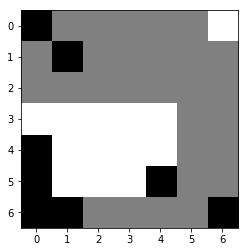

((5, 4), (6, 2)): n_v:  1950 q_all:+0.084978 q:+0.081673 q_m:+0.033333 p:0.481518
((6, 1), (6, 2)): n_v:  1410 q_all:+0.105215 q:+0.093064 q_m:+0.066667 p:0.202511
((1, 1), (2, 1)): n_v:   280 q_all:+0.080490 q:+0.033478 q_m:+0.066667 p:0.075487
((5, 4), (6, 4)): n_v:   149 q_all:+0.032083 q:+0.022347 q_m:-0.066667 p:0.077616
((5, 4), (4, 5)): n_v:    48 q_all:+0.064450 q:+0.072038 q_m:-0.000000 p:0.017253
((4, 0), (6, 2)): n_v:    43 q_all:+0.019394 q:+0.016125 q_m:+0.033333 p:0.024668
((6, 0), (6, 2)): n_v:    42 q_all:+0.046518 q:+0.028974 q_m:+0.033333 p:0.018728
((1, 1), (0, 2)): n_v:    36 q_all:+0.005839 q:+0.014239 q_m:-0.133333 p:0.024081
((6, 6), (6, 4)): n_v:    25 q_all:+0.024706 q:+0.012868 q_m:-0.100000 p:0.014159
((1, 1), (2, 2)): n_v:    24 q_all:+0.038347 q:+0.010250 q_m:+0.066667 p:0.011738
((5, 4), (3, 5)): n_v:    19 q_all:+0.051832 q:+0.087541 q_m:-0.033333 p:0.008253
((0, 0), (2, 1)): n_v:    15 q_all:+0.064012 q:+0.022726 q_m:+0.033333 p:0.005326
((0, 0), (0, 2))

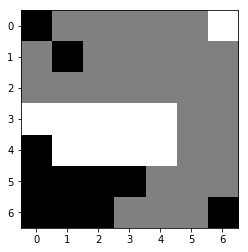

((4, 3), (6, 3)): n_v:  1794 q_all:-0.049219 q:-0.088262 q_m:+0.166667 p:0.275033
((4, 4), (6, 3)): n_v:  1499 q_all:-0.065047 q:-0.066387 q_m:+0.166667 p:0.352135
((4, 2), (6, 3)): n_v:   249 q_all:-0.169660 q:-0.136303 q_m:+0.166667 p:0.193821
((4, 1), (6, 3)): n_v:   142 q_all:-0.147132 q:-0.144281 q_m:+0.166667 p:0.093981
((4, 4), (6, 5)): n_v:    25 q_all:-0.113380 q:-0.085761 q_m:+0.033333 p:0.012514
((4, 3), (5, 4)): n_v:    16 q_all:-0.159452 q:-0.145204 q_m:+0.066667 p:0.012109
((4, 4), (5, 5)): n_v:    14 q_all:-0.122697 q:-0.088280 q_m:+0.066667 p:0.007551
((3, 0), (1, 0)): n_v:     9 q_all:-0.079529 q:-0.074862 q_m:+0.100000 p:0.003030
((3, 4), (5, 5)): n_v:     6 q_all:-0.117778 q:-0.076328 q_m:+0.033333 p:0.003208
((3, 1), (1, 0)): n_v:     6 q_all:-0.120412 q:-0.096595 q_m:+0.100000 p:0.003589
((4, 4), (5, 6)): n_v:     3 q_all:-0.126505 q:-0.095648 q_m:+0.033333 p:0.002161
((3, 2), (1, 0)): n_v:     3 q_all:-0.066738 q:-0.093645 q_m:+0.100000 p:0.000954
((4, 3), (6, 5))

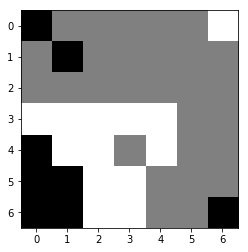

((1, 1), (2, 1)): n_v:  1274 q_all:+0.086652 q:+0.041039 q_m:+0.066667 p:0.141202
((6, 6), (5, 5)): n_v:   629 q_all:+0.100340 q:+0.067241 q_m:-0.066667 p:0.023146
((6, 1), (4, 3)): n_v:   616 q_all:+0.002187 q:+0.092845 q_m:+0.300000 p:0.350289
((1, 1), (2, 3)): n_v:   273 q_all:+0.073525 q:+0.027229 q_m:+0.033333 p:0.049355
((5, 1), (4, 3)): n_v:   244 q_all:-0.101769 q:+0.022276 q_m:+0.300000 p:0.276814
((6, 6), (5, 4)): n_v:   129 q_all:+0.067534 q:+0.087948 q_m:+0.033333 p:0.027706
((0, 0), (2, 1)): n_v:   128 q_all:+0.071176 q:+0.033951 q_m:+0.033333 p:0.024824
((1, 1), (2, 2)): n_v:   109 q_all:+0.074440 q:+0.026945 q_m:+0.066667 p:0.019285
((6, 6), (4, 5)): n_v:    81 q_all:+0.048188 q:+0.071929 q_m:-0.033333 p:0.025359
((6, 6), (6, 4)): n_v:    33 q_all:+0.033265 q:+0.045394 q_m:-0.033333 p:0.013426
((4, 0), (2, 1)): n_v:    30 q_all:+0.003008 q:-0.035789 q_m:+0.033333 p:0.017346
((1, 1), (2, 0)): n_v:    20 q_all:+0.061996 q:+0.031846 q_m:-0.000000 p:0.005102
((0, 0), (2, 2))

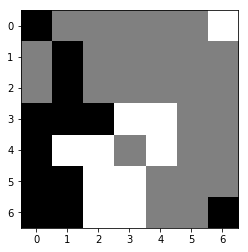

((4, 4), (2, 2)): n_v:  1202 q_all:-0.052290 q:-0.083584 q_m:+0.200000 p:0.107021
((3, 4), (2, 2)): n_v:   666 q_all:-0.078692 q:-0.083911 q_m:+0.200000 p:0.161326
((3, 3), (2, 2)): n_v:   538 q_all:-0.067576 q:-0.092061 q_m:+0.233333 p:0.095894
((4, 2), (2, 0)): n_v:   278 q_all:-0.067577 q:-0.069175 q_m:+0.200000 p:0.049621
((3, 3), (4, 3)): n_v:    64 q_all:-0.156418 q:-0.126556 q_m:+0.033333 p:0.044993
((4, 2), (2, 4)): n_v:    62 q_all:-0.116041 q:-0.132805 q_m:-0.066667 p:0.028843
((4, 2), (2, 2)): n_v:    54 q_all:-0.099800 q:-0.092058 q_m:+0.200000 p:0.019762
((3, 3), (2, 4)): n_v:    51 q_all:-0.200165 q:-0.145908 q_m:-0.033333 p:0.048625
((4, 1), (2, 0)): n_v:    41 q_all:-0.045777 q:-0.108192 q_m:+0.200000 p:0.002030
((3, 3), (2, 3)): n_v:    28 q_all:-0.139389 q:-0.120182 q_m:+0.033333 p:0.016769
((4, 4), (2, 4)): n_v:    23 q_all:-0.189116 q:-0.141967 q_m:-0.066667 p:0.020052
((4, 4), (2, 6)): n_v:    22 q_all:-0.185528 q:-0.139813 q_m:-0.066667 p:0.018657
((3, 3), (5, 5))

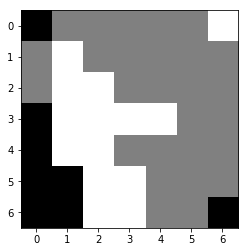

((0, 0), (1, 2)): n_v:  1766 q_all:+0.070662 q:+0.061554 q_m:-0.000000 p:0.459749
((6, 6), (5, 4)): n_v:   546 q_all:+0.071478 q:+0.069079 q_m:-0.066667 p:0.139960
((3, 0), (2, 0)): n_v:   516 q_all:+0.040984 q:+0.037971 q_m:+0.033333 p:0.222349
((3, 0), (1, 2)): n_v:   253 q_all:+0.070440 q:+0.043722 q_m:-0.000000 p:0.066168
((0, 0), (2, 0)): n_v:   172 q_all:+0.049616 q:+0.048308 q_m:-0.000000 p:0.065653
((6, 6), (4, 4)): n_v:    22 q_all:+0.021515 q:+0.081370 q_m:-0.000000 p:0.011816
((6, 1), (4, 3)): n_v:    12 q_all:-0.043018 q:+0.068247 q_m:+0.200000 p:0.011633
((6, 6), (4, 5)): n_v:     7 q_all:+0.060378 q:+0.061233 q_m:-0.133333 p:0.002352
((6, 6), (4, 6)): n_v:     7 q_all:-0.004745 q:+0.029617 q_m:-0.200000 p:0.005129
((6, 6), (6, 4)): n_v:     4 q_all:+0.028845 q:+0.054747 q_m:-0.066667 p:0.002344
((6, 6), (5, 5)): n_v:     2 q_all:-0.012916 q:+0.015454 q_m:-0.166667 p:0.002183
((0, 0), (0, 2)): n_v:     2 q_all:+0.003420 q:+0.000153 q_m:-0.133333 p:0.001603
((0, 0), (1, 0))

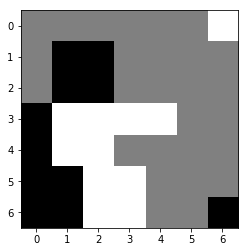

((3, 1), (2, 0)): n_v:  1691 q_all:-0.061405 q:-0.026655 q_m:+0.233333 p:0.272968
((3, 2), (2, 3)): n_v:   544 q_all:-0.047722 q:-0.093867 q_m:+0.166667 p:0.047608
((4, 2), (2, 0)): n_v:   461 q_all:-0.061304 q:-0.034695 q_m:+0.200000 p:0.074186
((3, 3), (1, 3)): n_v:   389 q_all:-0.064418 q:-0.079278 q_m:+0.133333 p:0.069343
((3, 2), (2, 0)): n_v:   110 q_all:-0.073458 q:-0.043012 q_m:+0.200000 p:0.024985
((3, 2), (4, 3)): n_v:    99 q_all:-0.131849 q:-0.133672 q_m:+0.033333 p:0.054216
((3, 4), (1, 3)): n_v:    67 q_all:-0.052302 q:-0.074287 q_m:+0.133333 p:0.007390
((3, 3), (5, 5)): n_v:    54 q_all:-0.087973 q:-0.049586 q_m:+0.066667 p:0.016610
((3, 4), (2, 6)): n_v:    41 q_all:-0.130115 q:-0.115502 q_m:-0.000000 p:0.022326
((4, 2), (2, 3)): n_v:    26 q_all:-0.108503 q:-0.085933 q_m:+0.133333 p:0.010824
((4, 1), (2, 0)): n_v:    22 q_all:-0.104159 q:-0.094099 q_m:+0.200000 p:0.009020
((3, 4), (4, 6)): n_v:    22 q_all:-0.124276 q:-0.132629 q_m:-0.000000 p:0.011423
((3, 2), (1, 3))

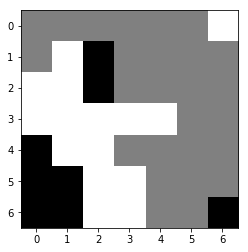

((2, 2), (4, 3)): n_v:  1948 q_all:+0.093995 q:+0.111137 q_m:+0.166667 p:0.254336
((1, 2), (1, 0)): n_v:   797 q_all:+0.060227 q:+0.042357 q_m:-0.033333 p:0.247782
((2, 2), (1, 0)): n_v:   762 q_all:+0.040829 q:+0.048714 q_m:-0.033333 p:0.316178
((1, 2), (2, 3)): n_v:   138 q_all:+0.003420 q:-0.004935 q_m:-0.000000 p:0.085027
((2, 2), (4, 4)): n_v:     6 q_all:+0.006681 q:+0.019910 q_m:-0.033333 p:0.003824
((6, 6), (5, 6)): n_v:     5 q_all:-0.051535 q:-0.079951 q_m:-0.200000 p:0.005009
((6, 6), (5, 4)): n_v:     3 q_all:+0.024828 q:-0.006432 q_m:-0.100000 p:0.001706
((6, 1), (4, 3)): n_v:     3 q_all:-0.068805 q:-0.006647 q_m:+0.166667 p:0.003452
((5, 1), (4, 3)): n_v:     1 q_all:-0.138152 q:-0.074577 q_m:+0.166667 p:0.001654
((6, 6), (5, 5)): n_v:     0 q_all:-0.071697 q:-0.071697 q_m:-0.200000 p:0.000485
((1, 2), (0, 1)): n_v:     0 q_all:-0.065832 q:-0.065832 q_m:-0.133333 p:0.000355
((1, 2), (0, 3)): n_v:     0 q_all:-0.073371 q:-0.073371 q_m:-0.200000 p:0.000033
((6, 6), (6, 4))

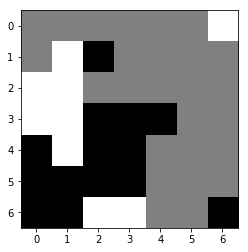

((1, 1), (2, 3)): n_v:  2416 q_all:-0.074599 q:-0.075757 q_m:+0.100000 p:0.002381
((1, 1), (2, 2)): n_v:  1159 q_all:-0.112393 q:-0.064757 q_m:+0.066667 p:0.228103
((6, 3), (4, 4)): n_v:   120 q_all:-0.108634 q:-0.099200 q_m:+0.100000 p:0.021421
((0, 6), (2, 4)): n_v:    85 q_all:-0.157632 q:-0.127823 q_m:-0.033333 p:0.036548
((6, 2), (4, 4)): n_v:    34 q_all:-0.116830 q:-0.136244 q_m:+0.100000 p:0.007602
((3, 0), (2, 2)): n_v:    22 q_all:-0.179771 q:-0.109802 q_m:+0.033333 p:0.011906
((2, 0), (2, 2)): n_v:    14 q_all:-0.148314 q:-0.111876 q_m:+0.033333 p:0.005584
((6, 3), (5, 4)): n_v:     9 q_all:-0.129281 q:-0.120164 q_m:-0.000000 p:0.002578
((2, 1), (2, 3)): n_v:     8 q_all:-0.111476 q:-0.109187 q_m:+0.100000 p:0.001720
((4, 1), (2, 2)): n_v:     4 q_all:-0.161887 q:-0.144755 q_m:+0.033333 p:0.002009
((1, 1), (0, 1)): n_v:     1 q_all:-0.141546 q:-0.106564 q_m:-0.066667 p:0.000294
((6, 3), (6, 4)): n_v:     1 q_all:-0.169690 q:-0.143499 q_m:-0.066667 p:0.000623
((6, 3), (5, 5))

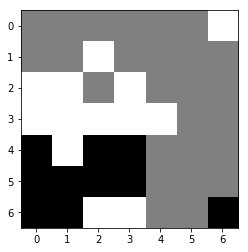

((4, 3), (4, 4)): n_v:  3043 q_all:+0.089684 q:+0.067735 q_m:+0.066667 p:0.333558
((4, 3), (2, 2)): n_v:   877 q_all:+0.085021 q:+0.090409 q_m:+0.300000 p:0.116070
((4, 3), (2, 4)): n_v:   186 q_all:+0.043174 q:+0.066529 q_m:+0.100000 p:0.063028
((6, 6), (4, 4)): n_v:   178 q_all:+0.071761 q:+0.046107 q_m:+0.033333 p:0.035077
((4, 0), (2, 2)): n_v:   170 q_all:+0.038633 q:+0.020797 q_m:+0.300000 p:0.061354
((4, 2), (2, 4)): n_v:    67 q_all:+0.021689 q:+0.001943 q_m:+0.100000 p:0.029900
((4, 2), (2, 2)): n_v:    62 q_all:-0.008928 q:-0.016262 q_m:+0.300000 p:0.037195
((4, 3), (5, 4)): n_v:     6 q_all:+0.057101 q:+0.053280 q_m:-0.000000 p:0.001885
((4, 3), (6, 5)): n_v:     5 q_all:-0.014726 q:+0.001989 q_m:-0.100000 p:0.003379
((4, 2), (4, 4)): n_v:     5 q_all:-0.041419 q:-0.027977 q_m:+0.033333 p:0.003761
((5, 2), (4, 4)): n_v:     3 q_all:-0.021065 q:-0.035308 q_m:+0.033333 p:0.002356
((6, 6), (6, 5)): n_v:     3 q_all:+0.027024 q:+0.032896 q_m:-0.066667 p:0.001450
((5, 3), (6, 4))

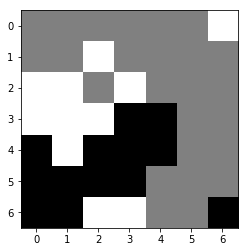

((6, 3), (5, 4)): n_v:  1766 q_all:-0.079162 q:-0.058702 q_m:+0.166667 p:0.160742
((2, 3), (4, 5)): n_v:   441 q_all:-0.097456 q:-0.087435 q_m:+0.066667 p:0.077977
((2, 3), (3, 5)): n_v:   430 q_all:-0.098389 q:-0.098329 q_m:+0.066667 p:0.078104
((1, 2), (2, 2)): n_v:   388 q_all:-0.090123 q:-0.097423 q_m:+0.033333 p:0.055200
((2, 3), (2, 4)): n_v:   357 q_all:-0.082594 q:-0.075930 q_m:+0.100000 p:0.038354
((3, 2), (5, 4)): n_v:   285 q_all:-0.096742 q:-0.062044 q_m:+0.133333 p:0.049520
((2, 3), (1, 5)): n_v:   116 q_all:-0.138041 q:-0.133090 q_m:-0.066667 p:0.042858
((6, 3), (5, 5)): n_v:   114 q_all:-0.091856 q:-0.066382 q_m:+0.066667 p:0.017296
((1, 2), (2, 4)): n_v:    96 q_all:-0.063687 q:-0.075904 q_m:+0.066667 p:0.001687
((2, 3), (2, 5)): n_v:    84 q_all:-0.116931 q:-0.111304 q_m:-0.000000 p:0.022494
((6, 2), (5, 4)): n_v:    83 q_all:-0.110405 q:-0.103563 q_m:+0.133333 p:0.019694
((2, 3), (1, 4)): n_v:    78 q_all:-0.160704 q:-0.130144 q_m:-0.033333 p:0.037057
((3, 2), (1, 4))

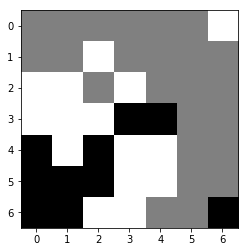

((3, 3), (2, 2)): n_v:  1851 q_all:+0.128162 q:+0.107028 q_m:+0.200000 p:0.225042
((6, 6), (6, 4)): n_v:   750 q_all:+0.091264 q:+0.073899 q_m:+0.033333 p:0.239705
((3, 4), (2, 2)): n_v:   296 q_all:+0.124050 q:+0.090786 q_m:+0.166667 p:0.042153
((3, 3), (2, 4)): n_v:   243 q_all:+0.024177 q:+0.019639 q_m:-0.066667 p:0.164755
((3, 3), (1, 1)): n_v:    88 q_all:+0.097279 q:+0.095945 q_m:+0.033333 p:0.024877
((3, 4), (5, 5)): n_v:    85 q_all:+0.072663 q:+0.074485 q_m:-0.033333 p:0.035684
((3, 3), (5, 5)): n_v:    80 q_all:+0.036874 q:+0.045111 q_m:-0.033333 p:0.048670
((6, 6), (5, 5)): n_v:    79 q_all:+0.070455 q:+0.069110 q_m:-0.000000 p:0.033837
((3, 4), (1, 5)): n_v:    39 q_all:+0.054529 q:+0.011646 q_m:-0.100000 p:0.020596
((3, 3), (1, 5)): n_v:    24 q_all:+0.031543 q:+0.016229 q_m:-0.100000 p:0.015937
((3, 3), (4, 5)): n_v:    11 q_all:+0.023545 q:+0.024296 q_m:-0.033333 p:0.007503
((6, 6), (4, 5)): n_v:    10 q_all:+0.051951 q:+0.040125 q_m:-0.033333 p:0.005618
((3, 4), (4, 5))

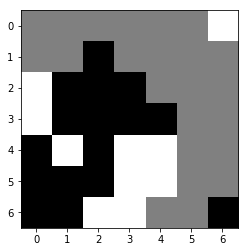

((2, 0), (1, 1)): n_v:  1238 q_all:-0.119299 q:-0.084602 q_m:+0.033333 p:0.631386
((0, 6), (1, 5)): n_v:   123 q_all:-0.184508 q:-0.186275 q_m:-0.166667 p:0.125433
((0, 6), (2, 4)): n_v:   101 q_all:-0.131249 q:-0.100824 q_m:-0.000000 p:0.060887
((4, 4), (5, 5)): n_v:    44 q_all:-0.185539 q:-0.157660 q_m:-0.100000 p:0.045043
((3, 0), (1, 1)): n_v:    34 q_all:-0.202308 q:-0.101320 q_m:-0.000000 p:0.039041
((4, 4), (2, 4)): n_v:    29 q_all:-0.172716 q:-0.152572 q_m:-0.000000 p:0.027634
((2, 0), (0, 2)): n_v:     8 q_all:-0.178389 q:-0.197504 q_m:-0.133333 p:0.008303
((4, 3), (2, 4)): n_v:     7 q_all:-0.167497 q:-0.138119 q_m:-0.000000 p:0.006680
((4, 4), (3, 5)): n_v:     4 q_all:-0.202155 q:-0.174478 q_m:-0.100000 p:0.005648
((2, 0), (1, 0)): n_v:     4 q_all:-0.256007 q:-0.219728 q_m:-0.100000 p:0.006635
((5, 4), (6, 5)): n_v:     3 q_all:-0.191675 q:-0.134247 q_m:-0.100000 p:0.003701
((0, 6), (1, 4)): n_v:     3 q_all:-0.191901 q:-0.150718 q_m:-0.133333 p:0.003403
((4, 3), (5, 5))

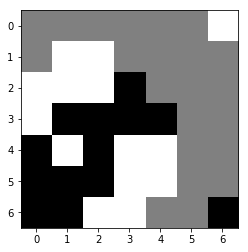

((6, 6), (6, 4)): n_v:  2031 q_all:+0.142003 q:+0.143459 q_m:+0.166667 p:0.479671
((2, 3), (1, 3)): n_v:   561 q_all:+0.112373 q:+0.104058 q_m:+0.133333 p:0.230059
((6, 6), (5, 5)): n_v:   107 q_all:+0.130106 q:+0.154028 q_m:+0.133333 p:0.032893
((3, 4), (4, 5)): n_v:    60 q_all:+0.088636 q:+0.094504 q_m:+0.133333 p:0.033010
((6, 6), (4, 5)): n_v:    44 q_all:+0.093959 q:+0.096165 q_m:+0.100000 p:0.023094
((2, 3), (0, 2)): n_v:    42 q_all:+0.071426 q:+0.060401 q_m:+0.100000 p:0.027871
((6, 6), (5, 6)): n_v:    29 q_all:+0.058283 q:+0.043983 q_m:-0.000000 p:0.021300
((3, 4), (1, 3)): n_v:    22 q_all:+0.135659 q:+0.095581 q_m:+0.100000 p:0.006283
((2, 3), (0, 4)): n_v:    22 q_all:+0.026840 q:+0.037095 q_m:-0.033333 p:0.020343
((3, 4), (5, 5)): n_v:    20 q_all:+0.115057 q:+0.136601 q_m:+0.100000 p:0.007801
((3, 3), (1, 3)): n_v:    20 q_all:+0.017911 q:+0.059983 q_m:+0.100000 p:0.019499
((3, 2), (1, 0)): n_v:    18 q_all:+0.066063 q:+0.031112 q_m:+0.166667 p:0.012779
((3, 4), (3, 5))

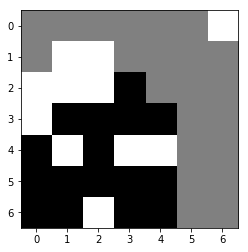

((4, 4), (5, 5)): n_v:  1571 q_all:-0.115842 q:-0.111540 q_m:-0.000000 p:0.376207
((4, 3), (5, 5)): n_v:  1142 q_all:-0.119839 q:-0.127325 q_m:-0.033333 p:0.297730
((0, 6), (2, 4)): n_v:   120 q_all:-0.112415 q:-0.100510 q_m:+0.033333 p:0.026509
((1, 2), (2, 4)): n_v:   117 q_all:-0.106409 q:-0.106454 q_m:+0.033333 p:0.022268
((0, 6), (1, 5)): n_v:    91 q_all:-0.166040 q:-0.155126 q_m:-0.133333 p:0.045924
((1, 2), (1, 3)): n_v:    52 q_all:-0.130780 q:-0.119889 q_m:-0.066667 p:0.016453
((4, 4), (6, 5)): n_v:    45 q_all:-0.150454 q:-0.115444 q_m:-0.033333 p:0.019149
((4, 3), (2, 4)): n_v:    40 q_all:-0.161448 q:-0.127322 q_m:+0.033333 p:0.019404
((4, 4), (5, 6)): n_v:    34 q_all:-0.171180 q:-0.160278 q_m:-0.166667 p:0.018293
((4, 3), (6, 5)): n_v:    33 q_all:-0.127147 q:-0.151689 q_m:-0.033333 p:0.010137
((4, 4), (6, 6)): n_v:    30 q_all:-0.180674 q:-0.180507 q_m:-0.166667 p:0.017803
((2, 2), (2, 4)): n_v:    28 q_all:-0.212652 q:-0.129206 q_m:+0.033333 p:0.021163
((4, 4), (2, 4))

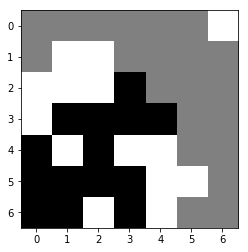

((3, 4), (4, 5)): n_v:  3077 q_all:+0.140032 q:+0.147408 q_m:+0.233333 p:0.597432
((3, 4), (2, 5)): n_v:   301 q_all:+0.028929 q:+0.067299 q_m:+0.033333 p:0.240068
((2, 3), (1, 3)): n_v:   248 q_all:+0.110425 q:+0.131137 q_m:+0.166667 p:0.088115
((6, 3), (4, 5)): n_v:    70 q_all:+0.108433 q:+0.094266 q_m:+0.200000 p:0.025682
((2, 3), (4, 5)): n_v:    19 q_all:+0.110767 q:+0.115285 q_m:+0.200000 p:0.006855
((3, 3), (4, 5)): n_v:    10 q_all:+0.033623 q:+0.099455 q_m:+0.200000 p:0.007600
((3, 4), (5, 6)): n_v:     8 q_all:+0.094824 q:+0.096791 q_m:+0.066667 p:0.003709
((3, 2), (1, 0)): n_v:     6 q_all:+0.097769 q:+0.042373 q_m:+0.200000 p:0.002643
((3, 4), (1, 6)): n_v:     5 q_all:+0.069366 q:+0.080387 q_m:+0.066667 p:0.002989
((2, 3), (0, 5)): n_v:     4 q_all:+0.068581 q:+0.077942 q_m:+0.066667 p:0.002559
((6, 3), (6, 5)): n_v:     4 q_all:+0.050319 q:+0.103455 q_m:+0.200000 p:0.003220
((2, 3), (0, 1)): n_v:     2 q_all:+0.064520 q:+0.056844 q_m:+0.133333 p:0.001331
((2, 3), (2, 5))

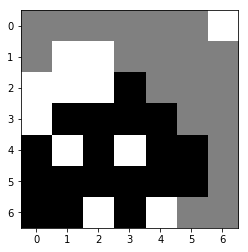

((4, 3), (2, 4)): n_v:  1444 q_all:-0.101882 q:-0.107609 q_m:-0.033333 p:0.100152
((4, 3), (3, 5)): n_v:   883 q_all:-0.118975 q:-0.102475 q_m:-0.033333 p:0.130562
((6, 4), (5, 6)): n_v:   607 q_all:-0.146824 q:-0.122610 q_m:-0.100000 p:0.167433
((6, 4), (4, 6)): n_v:   578 q_all:-0.144042 q:-0.127807 q_m:-0.100000 p:0.152063
((1, 2), (2, 4)): n_v:   413 q_all:-0.140631 q:-0.120038 q_m:-0.033333 p:0.102313
((6, 4), (6, 5)): n_v:   246 q_all:-0.158031 q:-0.119298 q_m:-0.066667 p:0.080753
((0, 6), (2, 4)): n_v:   240 q_all:-0.136722 q:-0.107733 q_m:-0.033333 p:0.054949
((4, 3), (6, 5)): n_v:   131 q_all:-0.128022 q:-0.144252 q_m:-0.100000 p:0.024924
((4, 3), (2, 5)): n_v:    93 q_all:-0.140394 q:-0.145345 q_m:-0.166667 p:0.023117
((1, 2), (1, 3)): n_v:    57 q_all:-0.155440 q:-0.134702 q_m:-0.133333 p:0.018097
((0, 6), (1, 5)): n_v:    25 q_all:-0.205994 q:-0.187366 q_m:-0.200000 p:0.013876
((2, 2), (2, 4)): n_v:    22 q_all:-0.192628 q:-0.137288 q_m:-0.033333 p:0.010849
((1, 1), (1, 0))

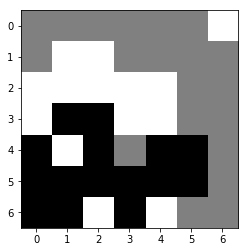

((5, 5), (4, 3)): n_v:  2353 q_all:+0.143191 q:+0.114015 q_m:+0.166667 p:0.021769
((3, 2), (4, 3)): n_v:  1111 q_all:+0.103925 q:+0.107796 q_m:+0.200000 p:0.176497
((4, 5), (4, 3)): n_v:    29 q_all:+0.098474 q:+0.110536 q_m:+0.166667 p:0.006112
((3, 1), (4, 3)): n_v:    27 q_all:+0.033205 q:-0.008268 q_m:+0.166667 p:0.016545
((3, 2), (1, 3)): n_v:    14 q_all:+0.110021 q:+0.104612 q_m:+0.300000 p:0.001398
((5, 1), (4, 3)): n_v:     8 q_all:-0.210891 q:-0.123094 q_m:+0.166667 p:0.016176
((6, 3), (4, 3)): n_v:     6 q_all:+0.084810 q:+0.054507 q_m:+0.166667 p:0.002244
((6, 1), (4, 3)): n_v:     4 q_all:-0.082098 q:-0.028315 q_m:+0.166667 p:0.005165
((4, 4), (2, 5)): n_v:     2 q_all:+0.043193 q:+0.059542 q_m:+0.166667 p:0.001616
((4, 4), (6, 6)): n_v:     0 q_all:+0.004952 q:+0.004952 q_m:+0.033333 p:0.000002
((5, 4), (6, 6)): n_v:     0 q_all:-0.022051 q:-0.022051 q_m:+0.033333 p:0.000000
((4, 5), (6, 6)): n_v:     0 q_all:-0.035570 q:-0.035570 q_m:+0.033333 p:0.000001
((5, 4), (3, 5))

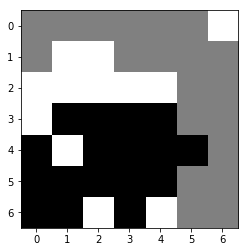

((6, 4), (5, 5)): n_v:  3703 q_all:-0.114544 q:-0.088822 q_m:+0.066667 p:0.491997
((2, 4), (3, 5)): n_v:   504 q_all:-0.191866 q:-0.122220 q_m:+0.066667 p:0.259967
((0, 6), (1, 5)): n_v:   185 q_all:-0.169272 q:-0.179945 q_m:-0.133333 p:0.074436
((2, 3), (3, 5)): n_v:    55 q_all:-0.183959 q:-0.130967 q_m:+0.033333 p:0.026640
((6, 4), (4, 6)): n_v:    11 q_all:-0.165206 q:-0.138144 q_m:-0.100000 p:0.004404
((2, 3), (1, 5)): n_v:     9 q_all:-0.227502 q:-0.195308 q_m:-0.166667 p:0.006300
((2, 4), (4, 6)): n_v:     5 q_all:-0.186174 q:-0.158926 q_m:-0.100000 p:0.002791
((6, 4), (5, 6)): n_v:     4 q_all:-0.141072 q:-0.155069 q_m:-0.100000 p:0.001094
((6, 4), (6, 6)): n_v:     1 q_all:-0.216401 q:-0.186262 q_m:-0.166667 p:0.000625
((2, 4), (3, 6)): n_v:     1 q_all:-0.150405 q:-0.160795 q_m:-0.100000 p:0.000417
((1, 1), (1, 0)): n_v:     1 q_all:-0.196917 q:-0.197820 q_m:-0.133333 p:0.000547
((6, 4), (6, 5)): n_v:     1 q_all:-0.228945 q:-0.188520 q_m:-0.066667 p:0.000711
((1, 2), (1, 0))

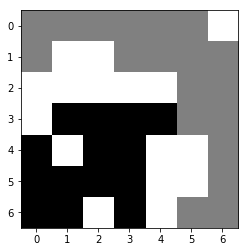

((3, 4), (3, 5)): n_v:  5657 q_all:+0.136095 q:+0.132074 q_m:+0.166667 p:0.927823
((3, 4), (1, 3)): n_v:   105 q_all:+0.130874 q:+0.160780 q_m:+0.200000 p:0.018922
((3, 2), (1, 3)): n_v:    12 q_all:-0.012597 q:+0.007539 q_m:+0.200000 p:0.009210
((3, 4), (5, 6)): n_v:    12 q_all:+0.039265 q:+0.020871 q_m:+0.066667 p:0.007505
((3, 1), (1, 3)): n_v:    10 q_all:+0.044615 q:+0.000322 q_m:+0.200000 p:0.005329
((3, 3), (1, 3)): n_v:     9 q_all:+0.015034 q:+0.053734 q_m:+0.200000 p:0.006876
((3, 4), (4, 6)): n_v:     6 q_all:+0.044900 q:+0.033014 q_m:+0.066667 p:0.003896
((3, 4), (1, 6)): n_v:     6 q_all:+0.028206 q:-0.023141 q_m:-0.000000 p:0.004340
((3, 4), (1, 5)): n_v:     5 q_all:+0.061872 q:+0.035576 q_m:+0.066667 p:0.002878
((3, 2), (1, 0)): n_v:     2 q_all:+0.006605 q:-0.027601 q_m:+0.133333 p:0.002151
((3, 3), (3, 5)): n_v:     2 q_all:-0.013446 q:-0.007406 q_m:+0.133333 p:0.002251
((3, 4), (2, 6)): n_v:     2 q_all:+0.006723 q:-0.035060 q_m:-0.066667 p:0.001913
((3, 3), (1, 5))

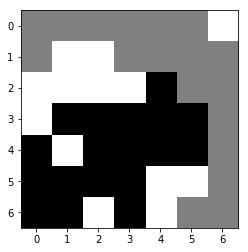

((0, 6), (2, 5)): n_v:  5189 q_all:-0.117298 q:-0.093488 q_m:+0.033333 p:0.654449
((2, 3), (2, 5)): n_v:   567 q_all:-0.156118 q:-0.118606 q_m:+0.033333 p:0.154292
((5, 5), (4, 6)): n_v:   359 q_all:-0.177606 q:-0.136490 q_m:-0.000000 p:0.126584
((1, 2), (1, 3)): n_v:    44 q_all:-0.141578 q:-0.139350 q_m:-0.066667 p:0.009775
((5, 4), (4, 6)): n_v:    27 q_all:-0.148895 q:-0.147892 q_m:-0.033333 p:0.006785
((6, 4), (4, 6)): n_v:    17 q_all:-0.167347 q:-0.147600 q_m:-0.033333 p:0.005318
((0, 6), (2, 6)): n_v:    14 q_all:-0.210101 q:-0.168681 q_m:-0.100000 p:0.006709
((0, 6), (1, 5)): n_v:     9 q_all:-0.185343 q:-0.143629 q_m:-0.066667 p:0.003617
((5, 5), (3, 6)): n_v:     7 q_all:-0.206586 q:-0.166722 q_m:-0.033333 p:0.003445
((5, 4), (3, 6)): n_v:     5 q_all:-0.194978 q:-0.156826 q_m:-0.033333 p:0.002365
((2, 3), (1, 5)): n_v:     5 q_all:-0.181062 q:-0.147052 q_m:-0.100000 p:0.002084
((5, 5), (5, 6)): n_v:     3 q_all:-0.205475 q:-0.173922 q_m:-0.066667 p:0.001351
((1, 1), (1, 0))

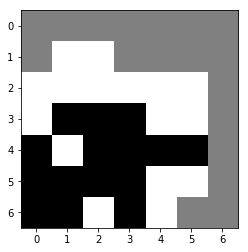

((4, 5), (6, 5)): n_v:  4046 q_all:+0.159059 q:+0.198566 q_m:+0.166667 p:0.313445
((4, 5), (3, 6)): n_v:   899 q_all:+0.112195 q:+0.104393 q_m:+0.133333 p:0.233120
((6, 3), (6, 5)): n_v:   262 q_all:+0.093110 q:+0.143704 q_m:+0.166667 p:0.087619
((4, 5), (5, 6)): n_v:   256 q_all:+0.076749 q:+0.066872 q_m:+0.066667 p:0.101798
((4, 5), (4, 6)): n_v:   153 q_all:+0.109113 q:+0.094450 q_m:+0.133333 p:0.041704
((4, 3), (6, 5)): n_v:   152 q_all:+0.033566 q:+0.095286 q_m:+0.166667 p:0.086146
((4, 4), (6, 5)): n_v:    76 q_all:+0.065524 q:+0.106092 q_m:+0.166667 p:0.033667
((3, 1), (1, 3)): n_v:    42 q_all:+0.037275 q:+0.051314 q_m:+0.233333 p:0.023153
((5, 3), (6, 5)): n_v:    27 q_all:+0.020816 q:+0.093914 q_m:+0.166667 p:0.016217
((3, 2), (1, 3)): n_v:    26 q_all:+0.030631 q:+0.034180 q_m:+0.233333 p:0.015228
((3, 3), (1, 3)): n_v:    22 q_all:+0.029783 q:+0.071488 q_m:+0.233333 p:0.013047
((4, 5), (2, 6)): n_v:    18 q_all:+0.100944 q:+0.105857 q_m:+0.100000 p:0.005684
((3, 2), (1, 0))

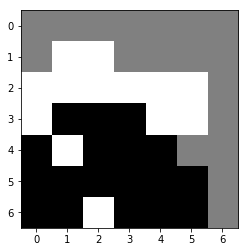

((3, 4), (4, 5)): n_v:  4699 q_all:-0.111952 q:-0.103509 q_m:+0.066667 p:0.378492
((2, 5), (4, 5)): n_v:   310 q_all:-0.164298 q:-0.137933 q_m:+0.033333 p:0.085537
((2, 4), (4, 5)): n_v:   112 q_all:-0.177166 q:-0.131762 q_m:+0.033333 p:0.038772
((2, 3), (4, 5)): n_v:    88 q_all:-0.174713 q:-0.129881 q_m:+0.033333 p:0.029118
((3, 5), (5, 6)): n_v:     1 q_all:-0.192021 q:-0.155621 q_m:-0.033333 p:0.000462
((2, 4), (0, 6)): n_v:     0 q_all:-0.256901 q:-0.256901 q_m:-0.166667 p:0.000016
((1, 2), (0, 3)): n_v:     0 q_all:-0.240992 q:-0.240992 q_m:-0.133333 p:0.000046
((3, 5), (4, 6)): n_v:     0 q_all:-0.220251 q:-0.220251 q_m:-0.066667 p:0.000209
((2, 4), (0, 5)): n_v:     0 q_all:-0.231329 q:-0.231329 q_m:-0.166667 p:0.000006
((2, 3), (0, 5)): n_v:     0 q_all:-0.245838 q:-0.245838 q_m:-0.166667 p:0.000038
((3, 4), (3, 6)): n_v:     0 q_all:-0.265998 q:-0.265998 q_m:-0.166667 p:0.000005
((1, 1), (0, 1)): n_v:     0 q_all:-0.261443 q:-0.261443 q_m:-0.133333 p:0.000027
((2, 5), (4, 6))

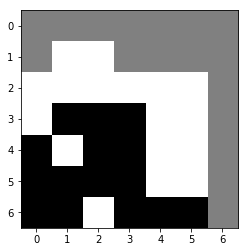

((6, 5), (5, 6)): n_v:  5803 q_all:+0.158127 q:+0.165820 q_m:+0.100000 p:0.923335
((6, 5), (4, 6)): n_v:    89 q_all:+0.107284 q:+0.108550 q_m:+0.133333 p:0.026604
((6, 5), (6, 6)): n_v:    12 q_all:+0.014810 q:+0.064765 q_m:+0.033333 p:0.009087
((3, 3), (1, 5)): n_v:    11 q_all:+0.026967 q:+0.054295 q_m:+0.066667 p:0.007527
((3, 1), (1, 3)): n_v:    11 q_all:+0.041041 q:+0.074169 q_m:+0.200000 p:0.007075
((6, 4), (4, 6)): n_v:    11 q_all:+0.056026 q:+0.079887 q_m:+0.133333 p:0.006175
((3, 3), (1, 3)): n_v:     6 q_all:+0.062315 q:+0.109728 q_m:+0.200000 p:0.003537
((3, 3), (1, 4)): n_v:     6 q_all:+0.059398 q:+0.079891 q_m:+0.133333 p:0.003695
((3, 2), (1, 3)): n_v:     5 q_all:+0.024268 q:+0.058969 q_m:+0.200000 p:0.003974
((3, 2), (1, 4)): n_v:     4 q_all:+0.017294 q:+0.034829 q_m:+0.133333 p:0.003428
((3, 2), (1, 0)): n_v:     2 q_all:+0.025146 q:+0.015669 q_m:+0.133333 p:0.001691
((6, 4), (5, 6)): n_v:     1 q_all:-0.024688 q:+0.035924 q_m:+0.066667 p:0.001315
((3, 1), (1, 0))

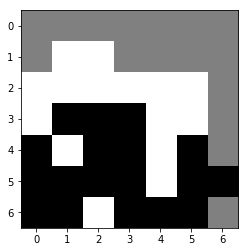

((3, 5), (4, 6)): n_v:  3296 q_all:-0.144761 q:-0.060137 q_m:+0.133333 p:0.463128
((5, 4), (4, 6)): n_v:  2201 q_all:-0.116694 q:-0.130201 q_m:+0.100000 p:0.079211
((4, 4), (6, 6)): n_v:   318 q_all:-0.169445 q:-0.115421 q_m:+0.100000 p:0.073991
((2, 5), (4, 6)): n_v:   178 q_all:-0.181394 q:-0.106832 q_m:+0.100000 p:0.049315
((2, 5), (2, 6)): n_v:   150 q_all:-0.228913 q:-0.197656 q_m:-0.066667 p:0.068531
((5, 4), (6, 6)): n_v:    75 q_all:-0.173133 q:-0.132997 q_m:+0.100000 p:0.018699
((2, 4), (4, 6)): n_v:    71 q_all:-0.169306 q:-0.105918 q_m:+0.100000 p:0.016648
((2, 4), (0, 6)): n_v:    25 q_all:-0.259175 q:-0.218420 q_m:-0.100000 p:0.014708
((1, 1), (0, 1)): n_v:    19 q_all:-0.197669 q:-0.209738 q_m:-0.066667 p:0.006536
((3, 4), (4, 6)): n_v:    17 q_all:-0.218006 q:-0.123030 q_m:+0.100000 p:0.006654
((4, 4), (2, 6)): n_v:    16 q_all:-0.281990 q:-0.212779 q_m:-0.100000 p:0.010589
((2, 4), (1, 5)): n_v:    15 q_all:-0.208207 q:-0.207711 q_m:-0.066667 p:0.005860
((4, 4), (4, 6))

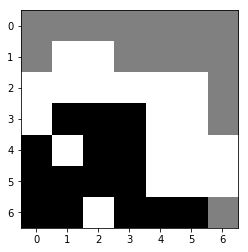

((6, 5), (6, 6)): n_v:  3919 q_all:+0.224631 q:+0.222167 q_m:+0.033333 p:0.994942
((6, 4), (6, 6)): n_v:     1 q_all:-0.101908 q:-0.031364 q_m:-0.000000 p:0.001415
((3, 3), (1, 4)): n_v:     0 q_all:+0.021876 q:+0.021876 q_m:+0.066667 p:0.000201
((3, 1), (1, 0)): n_v:     0 q_all:-0.066153 q:-0.066153 q_m:+0.066667 p:0.000153
((3, 2), (1, 4)): n_v:     0 q_all:-0.056231 q:-0.056231 q_m:+0.066667 p:0.000406
((3, 2), (1, 3)): n_v:     0 q_all:-0.024446 q:-0.024446 q_m:+0.133333 p:0.000465
((3, 3), (1, 5)): n_v:     0 q_all:-0.014542 q:-0.014542 q_m:-0.000000 p:0.000344
((3, 2), (1, 0)): n_v:     0 q_all:-0.115745 q:-0.115745 q_m:+0.066667 p:0.000138
((3, 1), (1, 3)): n_v:     0 q_all:+0.020568 q:+0.020568 q_m:+0.133333 p:0.001169
((3, 3), (1, 3)): n_v:     0 q_all:+0.049398 q:+0.049398 q_m:+0.133333 p:0.000563
########################p_sum is:  0.99979642994
1 's turn
one move takes time(s):  0.44034266471862793
no. of data collected:  24


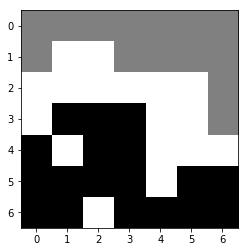

((2, 5), (1, 6)): n_v:  2231 q_all:-0.148369 q:-0.202080 q_m:-0.000000 p:0.009363
((2, 5), (3, 6)): n_v:  1480 q_all:-0.205131 q:-0.221651 q_m:-0.000000 p:0.158038
((1, 2), (1, 3)): n_v:   146 q_all:-0.220314 q:-0.199709 q_m:-0.000000 p:0.027451
((1, 1), (1, 0)): n_v:    81 q_all:-0.222327 q:-0.223479 q_m:-0.000000 p:0.016087
((2, 4), (1, 5)): n_v:    63 q_all:-0.232719 q:-0.202025 q_m:-0.000000 p:0.016087
((1, 2), (0, 3)): n_v:    60 q_all:-0.236159 q:-0.204785 q_m:-0.000000 p:0.016395
((1, 1), (0, 1)): n_v:    58 q_all:-0.239773 q:-0.224326 q_m:-0.000000 p:0.017035
((2, 5), (1, 3)): n_v:    42 q_all:-0.197469 q:-0.257367 q_m:-0.033333 p:0.002776
((1, 2), (1, 4)): n_v:    37 q_all:-0.263903 q:-0.243967 q_m:-0.033333 p:0.015694
((1, 2), (0, 4)): n_v:    34 q_all:-0.254129 q:-0.211710 q_m:-0.033333 p:0.012744
((1, 1), (1, 3)): n_v:    24 q_all:-0.229973 q:-0.279402 q_m:-0.033333 p:0.005820
((1, 1), (0, 2)): n_v:    23 q_all:-0.249434 q:-0.220123 q_m:-0.000000 p:0.008162
((1, 2), (1, 0))

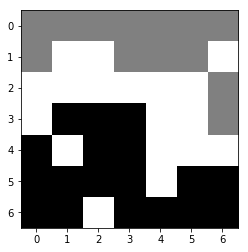

((5, 6), (3, 6)): n_v:  2669 q_all:+0.223559 q:+0.264313 q_m:+0.266667 p:0.384971
((3, 2), (1, 0)): n_v:   497 q_all:+0.185018 q:+0.153224 q_m:+0.200000 p:0.093834
((3, 3), (1, 5)): n_v:   493 q_all:+0.174399 q:+0.220542 q_m:+0.200000 p:0.129978
((3, 1), (1, 3)): n_v:   359 q_all:+0.165389 q:+0.240008 q_m:+0.266667 p:0.117676
((3, 3), (1, 3)): n_v:   126 q_all:+0.119189 q:+0.249753 q_m:+0.266667 p:0.084642
((3, 2), (1, 3)): n_v:   115 q_all:+0.139481 q:+0.202702 q_m:+0.266667 p:0.058832
((3, 3), (1, 4)): n_v:    84 q_all:+0.150481 q:+0.239516 q_m:+0.200000 p:0.036429
((3, 2), (1, 4)): n_v:    38 q_all:+0.116849 q:+0.185376 q_m:+0.200000 p:0.026146
((3, 1), (1, 0)): n_v:    27 q_all:+0.083901 q:+0.180544 q_m:+0.200000 p:0.023211
((5, 5), (3, 6)): n_v:    21 q_all:-0.105965 q:+0.122532 q_m:+0.266667 p:0.039108
########################p_sum is:  0.994825771078
1 's turn
one move takes time(s):  0.4952247142791748
no. of data collected:  16


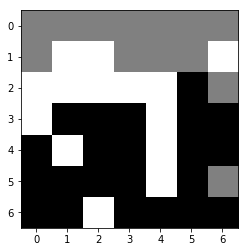

((3, 4), (5, 6)): n_v:  2995 q_all:-0.138348 q:-0.030624 q_m:+0.066667 p:0.120702
((4, 4), (5, 6)): n_v:  1185 q_all:-0.217594 q:-0.089702 q_m:+0.066667 p:0.387900
((5, 4), (5, 6)): n_v:   423 q_all:-0.252561 q:-0.145300 q_m:+0.066667 p:0.234227
((1, 6), (2, 6)): n_v:   194 q_all:-0.297203 q:-0.186192 q_m:-0.033333 p:0.155607
((1, 1), (1, 0)): n_v:    20 q_all:-0.397831 q:-0.388255 q_m:-0.233333 p:0.026654
((4, 4), (2, 6)): n_v:    12 q_all:-0.328899 q:-0.244166 q_m:-0.066667 p:0.012314
((2, 4), (2, 6)): n_v:    11 q_all:-0.232088 q:-0.241909 q_m:-0.066667 p:0.005627
((1, 2), (1, 0)): n_v:     7 q_all:-0.408496 q:-0.408424 q_m:-0.266667 p:0.009517
((3, 0), (1, 0)): n_v:     3 q_all:-0.501769 q:-0.458726 q_m:-0.266667 p:0.006459
((2, 2), (1, 0)): n_v:     3 q_all:-0.476519 q:-0.413827 q_m:-0.266667 p:0.005925
((3, 4), (2, 6)): n_v:     1 q_all:-0.335828 q:-0.235235 q_m:-0.066667 p:0.001289
((2, 4), (0, 6)): n_v:     0 q_all:-0.369954 q:-0.369954 q_m:-0.266667 p:0.000084
((1, 6), (0, 4))

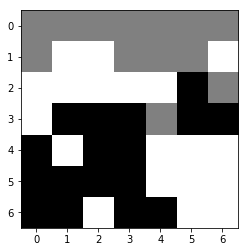

((2, 5), (3, 4)): n_v:  4708 q_all:+0.191830 q:+0.232187 q_m:+0.233333 p:0.143589
((3, 6), (3, 4)): n_v:   262 q_all:+0.130120 q:+0.204474 q_m:+0.200000 p:0.047704
((3, 5), (1, 3)): n_v:    35 q_all:+0.088188 q:+0.135979 q_m:+0.200000 p:0.015429
((3, 2), (3, 4)): n_v:    24 q_all:-0.046852 q:-0.066682 q_m:+0.200000 p:0.027843
((4, 2), (3, 4)): n_v:    10 q_all:-0.240777 q:-0.145977 q_m:+0.200000 p:0.021165
((3, 3), (1, 3)): n_v:    10 q_all:-0.026855 q:+0.002067 q_m:+0.200000 p:0.011328
((2, 5), (1, 3)): n_v:     4 q_all:-0.013971 q:+0.072252 q_m:+0.200000 p:0.004141
((3, 3), (1, 5)): n_v:     4 q_all:-0.162355 q:-0.099423 q_m:+0.066667 p:0.006533
((5, 2), (3, 4)): n_v:     3 q_all:-0.321169 q:-0.194323 q_m:+0.200000 p:0.006737
((3, 1), (1, 3)): n_v:     2 q_all:-0.152547 q:-0.133588 q_m:+0.200000 p:0.003101
((5, 3), (3, 4)): n_v:     1 q_all:-0.246983 q:-0.105282 q_m:+0.200000 p:0.003430
((3, 3), (1, 4)): n_v:     1 q_all:-0.145483 q:-0.144561 q_m:+0.066667 p:0.002219
((3, 2), (1, 3))

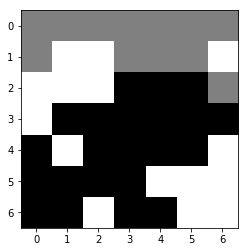

((1, 6), (2, 6)): n_v:  5817 q_all:-0.157402 q:-0.123284 q_m:-0.000000 p:0.808472
((1, 6), (1, 4)): n_v:   205 q_all:-0.185551 q:-0.138744 q_m:-0.033333 p:0.047758
((1, 2), (1, 4)): n_v:   185 q_all:-0.190085 q:-0.119726 q_m:-0.033333 p:0.047112
((1, 2), (1, 3)): n_v:    45 q_all:-0.207446 q:-0.159703 q_m:-0.066667 p:0.015510
((2, 2), (1, 4)): n_v:    28 q_all:-0.213538 q:-0.151407 q_m:-0.033333 p:0.010552
((4, 6), (2, 6)): n_v:    24 q_all:-0.373961 q:-0.292663 q_m:-0.033333 p:0.024628
((1, 6), (1, 5)): n_v:     8 q_all:-0.252267 q:-0.206618 q_m:-0.066667 p:0.004617
((1, 1), (1, 0)): n_v:     6 q_all:-0.303575 q:-0.316406 q_m:-0.200000 p:0.005039
((1, 2), (0, 3)): n_v:     4 q_all:-0.292856 q:-0.257775 q_m:-0.200000 p:0.002810
((1, 1), (1, 3)): n_v:     4 q_all:-0.237620 q:-0.221900 q_m:-0.100000 p:0.002091
((2, 1), (1, 3)): n_v:     1 q_all:-0.337263 q:-0.269243 q_m:-0.100000 p:0.001381
((3, 0), (1, 0)): n_v:     1 q_all:-0.445869 q:-0.352567 q_m:-0.233333 p:0.001792
((2, 1), (0, 0))

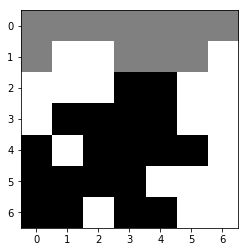

((2, 4), (1, 5)): n_v:  6137 q_all:+0.177785 q:+0.240881 q_m:+0.233333 p:0.876552
((2, 3), (1, 5)): n_v:   128 q_all:+0.098894 q:+0.121605 q_m:+0.200000 p:0.055779
((2, 3), (1, 3)): n_v:    53 q_all:+0.092883 q:+0.133003 q_m:+0.166667 p:0.024612
((3, 3), (1, 5)): n_v:     2 q_all:-0.115502 q:-0.044366 q_m:+0.200000 p:0.003146
((2, 3), (1, 4)): n_v:     2 q_all:+0.073229 q:-0.103173 q_m:+0.100000 p:0.001275
((2, 4), (0, 6)): n_v:     1 q_all:-0.062947 q:-0.050870 q_m:+0.066667 p:0.001441
((3, 4), (1, 5)): n_v:     1 q_all:-0.163413 q:-0.040916 q_m:+0.200000 p:0.001672
((2, 3), (0, 4)): n_v:     0 q_all:-0.107211 q:-0.107211 q_m:-0.000000 p:0.000418
((2, 4), (0, 5)): n_v:     0 q_all:-0.047884 q:-0.047884 q_m:+0.066667 p:0.000250
((2, 3), (0, 5)): n_v:     0 q_all:-0.144459 q:-0.144459 q_m:+0.066667 p:0.000113
((3, 1), (1, 3)): n_v:     0 q_all:-0.091131 q:-0.091131 q_m:+0.133333 p:0.000098
((2, 3), (0, 1)): n_v:     0 q_all:-0.084417 q:-0.084417 q_m:+0.133333 p:0.000136
((3, 3), (1, 4))

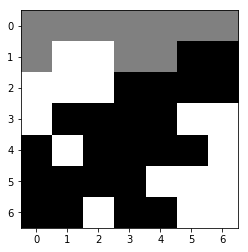

((1, 2), (1, 4)): n_v:  5946 q_all:-0.113370 q:-0.111811 q_m:+0.033333 p:0.813107
((2, 2), (1, 4)): n_v:   466 q_all:-0.164841 q:-0.135940 q_m:+0.033333 p:0.135689
((3, 6), (1, 4)): n_v:    52 q_all:-0.248037 q:-0.186713 q_m:+0.033333 p:0.032534
((3, 5), (1, 4)): n_v:     7 q_all:-0.252539 q:-0.178022 q_m:+0.033333 p:0.004741
((1, 2), (0, 4)): n_v:     4 q_all:-0.335272 q:-0.301151 q_m:-0.166667 p:0.004132
((1, 2), (1, 3)): n_v:     3 q_all:-0.255679 q:-0.194404 q_m:-0.066667 p:0.002325
((1, 1), (1, 3)): n_v:     1 q_all:-0.269603 q:-0.269603 q_m:-0.100000 p:0.001310
((2, 1), (1, 3)): n_v:     1 q_all:-0.409956 q:-0.329412 q_m:-0.100000 p:0.001028
((3, 5), (1, 3)): n_v:     1 q_all:-0.366883 q:-0.205963 q_m:-0.100000 p:0.000470
((2, 2), (0, 4)): n_v:     1 q_all:-0.342701 q:-0.283286 q_m:-0.166667 p:0.001085
((1, 2), (1, 0)): n_v:     0 q_all:-0.362162 q:-0.362162 q_m:-0.233333 p:0.000059
((2, 0), (0, 2)): n_v:     0 q_all:-0.360546 q:-0.360546 q_m:-0.233333 p:0.000019
((2, 2), (0, 2))

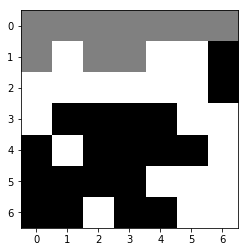

((1, 6), (0, 5)): n_v:  5924 q_all:+0.132852 q:+0.193982 q_m:+0.133333 p:0.769299
((1, 6), (0, 4)): n_v:    79 q_all:+0.089663 q:+0.077509 q_m:+0.100000 p:0.023090
((1, 6), (0, 6)): n_v:    64 q_all:+0.003641 q:+0.074201 q_m:+0.066667 p:0.038328
((2, 6), (0, 5)): n_v:    57 q_all:+0.088362 q:+0.099980 q_m:+0.100000 p:0.016695
((3, 1), (1, 3)): n_v:    51 q_all:+0.029117 q:+0.030942 q_m:+0.233333 p:0.026109
((3, 4), (1, 2)): n_v:    45 q_all:-0.081658 q:-0.060289 q_m:+0.233333 p:0.042377
((3, 2), (1, 3)): n_v:    26 q_all:-0.039267 q:-0.077039 q_m:+0.233333 p:0.020384
((2, 6), (0, 4)): n_v:    18 q_all:+0.020425 q:+0.056371 q_m:+0.100000 p:0.009904
((3, 3), (1, 2)): n_v:    14 q_all:-0.124664 q:-0.076394 q_m:+0.233333 p:0.016206
((3, 4), (1, 3)): n_v:    11 q_all:-0.125107 q:-0.089429 q_m:+0.233333 p:0.012449
((3, 3), (1, 3)): n_v:     6 q_all:-0.166522 q:-0.109296 q_m:+0.233333 p:0.007043
((3, 1), (1, 2)): n_v:     6 q_all:-0.077767 q:-0.095101 q_m:+0.233333 p:0.005489
((3, 2), (1, 0))

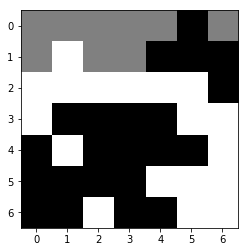

((2, 3), (0, 4)): n_v:  4240 q_all:-0.078482 q:-0.014140 q_m:+0.066667 p:0.257293
((2, 2), (0, 4)): n_v:  1264 q_all:-0.102763 q:-0.076553 q_m:+0.066667 p:0.190095
((2, 3), (0, 2)): n_v:   264 q_all:-0.195429 q:-0.148376 q_m:-0.133333 p:0.130264
((2, 4), (0, 6)): n_v:   215 q_all:-0.162870 q:-0.137218 q_m:+0.066667 p:0.080490
((2, 4), (0, 2)): n_v:   101 q_all:-0.323395 q:-0.273265 q_m:-0.133333 p:0.098324
((2, 2), (0, 0)): n_v:    73 q_all:-0.256708 q:-0.248692 q_m:-0.133333 p:0.053209
((2, 2), (1, 3)): n_v:    53 q_all:-0.164409 q:-0.150002 q_m:-0.033333 p:0.020367
((2, 0), (0, 2)): n_v:    43 q_all:-0.306612 q:-0.245825 q_m:-0.133333 p:0.038619
((2, 4), (1, 2)): n_v:    19 q_all:-0.295023 q:-0.268840 q_m:-0.133333 p:0.016636
((2, 3), (0, 1)): n_v:    13 q_all:-0.188783 q:-0.171922 q_m:-0.133333 p:0.006209
((1, 1), (0, 2)): n_v:    12 q_all:-0.274681 q:-0.202617 q_m:-0.100000 p:0.009399
((2, 1), (0, 2)): n_v:    12 q_all:-0.328053 q:-0.259854 q_m:-0.133333 p:0.010896
((2, 5), (0, 4))

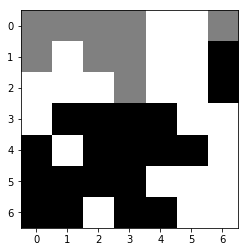

((1, 6), (0, 6)): n_v:  3707 q_all:+0.106111 q:+0.141298 q_m:+0.100000 p:0.865748
((3, 2), (2, 3)): n_v:  1421 q_all:+0.158524 q:+0.078973 q_m:+0.166667 p:0.022643
((3, 4), (1, 2)): n_v:    13 q_all:-0.157901 q:-0.173985 q_m:+0.133333 p:0.018410
((2, 6), (0, 6)): n_v:    12 q_all:-0.028551 q:+0.027046 q_m:+0.066667 p:0.009834
((3, 2), (1, 0)): n_v:    10 q_all:+0.046144 q:-0.134699 q_m:+0.133333 p:0.004559
((3, 3), (1, 2)): n_v:     7 q_all:-0.153435 q:-0.141954 q_m:+0.133333 p:0.010478
((3, 2), (1, 3)): n_v:     5 q_all:-0.111832 q:-0.125154 q_m:+0.200000 p:0.005622
((3, 3), (1, 3)): n_v:     5 q_all:-0.144702 q:-0.139256 q_m:+0.200000 p:0.006499
((3, 4), (1, 3)): n_v:     2 q_all:-0.175271 q:-0.144133 q_m:+0.200000 p:0.003095
((4, 5), (2, 3)): n_v:     1 q_all:-0.086512 q:+0.013553 q_m:+0.133333 p:0.000702
((4, 3), (2, 3)): n_v:     0 q_all:-0.312724 q:-0.312724 q_m:+0.133333 p:0.000068
((4, 2), (2, 3)): n_v:     0 q_all:-0.347016 q:-0.347016 q_m:+0.133333 p:0.000099
((4, 4), (2, 3))

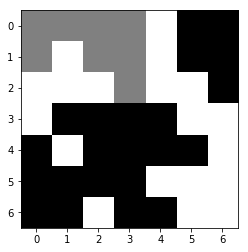

((0, 4), (2, 3)): n_v:  2485 q_all:-0.053634 q:-0.063931 q_m:+0.100000 p:0.084119
((1, 4), (2, 3)): n_v:  1690 q_all:-0.077388 q:-0.070608 q_m:+0.133333 p:0.231445
((1, 1), (2, 3)): n_v:   170 q_all:-0.115761 q:-0.105965 q_m:+0.100000 p:0.051767
((4, 1), (2, 3)): n_v:   144 q_all:-0.154345 q:-0.119461 q_m:+0.100000 p:0.068055
((2, 1), (2, 3)): n_v:    49 q_all:-0.257991 q:-0.213663 q_m:+0.100000 p:0.044618
((3, 5), (2, 3)): n_v:    13 q_all:-0.323046 q:-0.244307 q_m:+0.100000 p:0.014582
((2, 5), (2, 3)): n_v:    13 q_all:-0.328740 q:-0.296515 q_m:+0.100000 p:0.016974
((0, 4), (0, 2)): n_v:    10 q_all:-0.196058 q:-0.161157 q_m:-0.100000 p:0.006345
((2, 4), (1, 2)): n_v:     8 q_all:-0.244356 q:-0.215545 q_m:-0.100000 p:0.007352
((2, 2), (0, 0)): n_v:     5 q_all:-0.225391 q:-0.217057 q_m:-0.100000 p:0.003957
((2, 2), (1, 0)): n_v:     5 q_all:-0.266896 q:-0.265478 q_m:-0.100000 p:0.004937
((1, 4), (0, 2)): n_v:     4 q_all:-0.238922 q:-0.189698 q_m:-0.100000 p:0.003457
((1, 4), (1, 2))

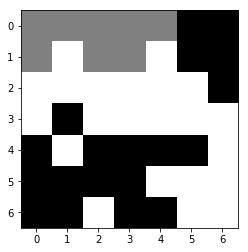

((0, 5), (1, 3)): n_v:  3918 q_all:+0.076789 q:+0.097186 q_m:+0.166667 p:0.745099
((3, 1), (1, 3)): n_v:   262 q_all:+0.074062 q:+0.068772 q_m:+0.166667 p:0.053468
((1, 5), (1, 3)): n_v:    58 q_all:-0.312438 q:-0.172098 q_m:+0.166667 p:0.123024
((0, 5), (0, 4)): n_v:    28 q_all:-0.047479 q:-0.000597 q_m:-0.000000 p:0.020634
((0, 5), (0, 3)): n_v:    12 q_all:-0.079652 q:-0.184220 q_m:-0.033333 p:0.012085
((3, 1), (1, 2)): n_v:     6 q_all:-0.073754 q:-0.091909 q_m:+0.166667 p:0.006307
((0, 6), (0, 4)): n_v:     4 q_all:-0.115737 q:-0.142880 q_m:-0.033333 p:0.004918
((2, 6), (0, 4)): n_v:     2 q_all:-0.133967 q:-0.129241 q_m:-0.033333 p:0.003425
((3, 1), (1, 0)): n_v:     1 q_all:-0.120650 q:-0.070579 q_m:+0.100000 p:0.001983
((1, 6), (0, 4)): n_v:     1 q_all:-0.285376 q:-0.228084 q_m:-0.033333 p:0.002457
((1, 5), (0, 3)): n_v:     0 q_all:-0.301547 q:-0.301547 q_m:-0.033333 p:0.001785
########################p_sum is:  0.975186180323
1 's turn
one move takes time(s):  0.28845977783

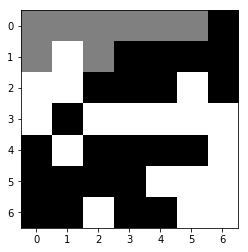

((1, 1), (1, 2)): n_v:  5813 q_all:-0.074782 q:-0.055838 q_m:+0.066667 p:0.430129
((2, 0), (1, 2)): n_v:    16 q_all:-0.187754 q:-0.145275 q_m:+0.033333 p:0.008797
((3, 3), (1, 2)): n_v:    15 q_all:-0.121441 q:-0.064010 q_m:+0.033333 p:0.003850
((3, 0), (1, 2)): n_v:    14 q_all:-0.162007 q:-0.104449 q_m:+0.033333 p:0.006626
((1, 1), (0, 2)): n_v:     8 q_all:-0.328952 q:-0.283902 q_m:-0.066667 p:0.010271
((1, 1), (0, 3)): n_v:     6 q_all:-0.200976 q:-0.229187 q_m:-0.033333 p:0.004145
((3, 4), (1, 2)): n_v:     6 q_all:-0.178728 q:-0.134502 q_m:+0.033333 p:0.003372
((1, 1), (0, 1)): n_v:     3 q_all:-0.379545 q:-0.329745 q_m:-0.133333 p:0.003797
((2, 0), (0, 1)): n_v:     2 q_all:-0.388942 q:-0.360990 q_m:-0.166667 p:0.002800
((3, 2), (1, 2)): n_v:     1 q_all:-0.298001 q:-0.137081 q_m:+0.033333 p:0.000881
((2, 5), (0, 3)): n_v:     0 q_all:-0.355126 q:-0.355126 q_m:-0.033333 p:0.000281
((2, 0), (0, 2)): n_v:     0 q_all:-0.315019 q:-0.315019 q_m:-0.100000 p:0.000305
((2, 1), (0, 3))

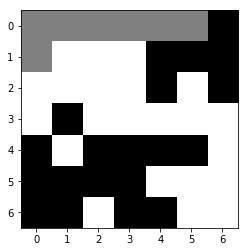

((1, 4), (0, 2)): n_v:  5465 q_all:+0.100406 q:+0.101109 q_m:+0.133333 p:0.646514
((2, 4), (0, 2)): n_v:   612 q_all:+0.072164 q:+0.076870 q_m:+0.133333 p:0.136861
((1, 4), (0, 3)): n_v:   221 q_all:-0.019850 q:+0.031296 q_m:+0.100000 p:0.125647
((3, 1), (1, 0)): n_v:    20 q_all:-0.144477 q:-0.108974 q_m:+0.133333 p:0.020660
((2, 4), (0, 3)): n_v:    20 q_all:-0.028339 q:-0.023422 q_m:+0.066667 p:0.012276
((1, 4), (0, 4)): n_v:    15 q_all:-0.087740 q:-0.098400 q_m:+0.033333 p:0.012875
((1, 5), (0, 3)): n_v:     7 q_all:-0.212617 q:-0.175326 q_m:+0.066667 p:0.009758
((0, 6), (0, 4)): n_v:     5 q_all:-0.094131 q:-0.083137 q_m:-0.000000 p:0.004567
((0, 6), (0, 5)): n_v:     4 q_all:-0.110902 q:-0.078532 q_m:-0.033333 p:0.004020
((2, 6), (0, 4)): n_v:     3 q_all:-0.154120 q:-0.141009 q_m:-0.000000 p:0.004076
((1, 6), (0, 4)): n_v:     1 q_all:-0.152991 q:-0.152991 q_m:-0.000000 p:0.001904
((2, 4), (0, 5)): n_v:     1 q_all:-0.163001 q:-0.106135 q_m:-0.066667 p:0.001126
((2, 6), (0, 5))

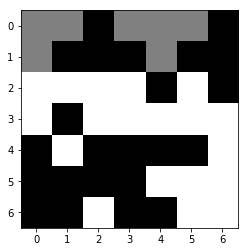

((2, 3), (1, 4)): n_v:  3183 q_all:-0.008490 q:-0.072528 q_m:+0.100000 p:0.025909
((2, 0), (0, 1)): n_v:  2825 q_all:-0.111956 q:-0.080863 q_m:+0.066667 p:0.839193
((2, 3), (0, 5)): n_v:    27 q_all:-0.165801 q:-0.198082 q_m:+0.066667 p:0.014742
((2, 1), (0, 1)): n_v:    20 q_all:-0.247340 q:-0.197353 q_m:+0.066667 p:0.018907
((2, 3), (0, 1)): n_v:    19 q_all:-0.181318 q:-0.129661 q_m:+0.066667 p:0.012141
((2, 2), (0, 1)): n_v:    18 q_all:-0.241388 q:-0.194780 q_m:+0.066667 p:0.015698
((2, 5), (0, 5)): n_v:    17 q_all:-0.263064 q:-0.255652 q_m:+0.066667 p:0.017173
((2, 5), (0, 3)): n_v:     7 q_all:-0.194835 q:-0.214242 q_m:+0.066667 p:0.004932
((2, 1), (0, 3)): n_v:     5 q_all:-0.314812 q:-0.270060 q_m:+0.066667 p:0.006082
((2, 0), (1, 0)): n_v:     4 q_all:-0.226424 q:-0.208604 q_m:-0.033333 p:0.003175
((2, 3), (0, 4)): n_v:     0 q_all:-0.331518 q:-0.331518 q_m:-0.000000 p:0.000035
((3, 6), (1, 4)): n_v:     0 q_all:-0.180086 q:-0.180086 q_m:+0.066667 p:0.000219
((2, 2), (1, 0))

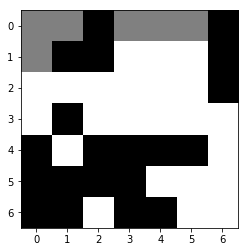

((0, 2), (1, 0)): n_v:  3013 q_all:+0.118238 q:-0.037994 q_m:+0.033333 p:0.393204
((1, 1), (1, 0)): n_v:  1679 q_all:+0.025249 q:+0.094574 q_m:+0.066667 p:0.326051
((0, 2), (0, 4)): n_v:   312 q_all:+0.029025 q:-0.061934 q_m:+0.100000 p:0.053454
((1, 2), (1, 0)): n_v:   110 q_all:+0.006356 q:-0.076441 q_m:+0.033333 p:0.033818
((0, 6), (0, 4)): n_v:    70 q_all:-0.014789 q:+0.008188 q_m:+0.100000 p:0.030115
((0, 6), (0, 5)): n_v:    60 q_all:-0.020725 q:+0.068185 q_m:+0.066667 p:0.028150
((1, 2), (0, 4)): n_v:    26 q_all:-0.111428 q:-0.078265 q_m:+0.100000 p:0.026894
((2, 6), (0, 4)): n_v:    22 q_all:+0.010906 q:-0.045041 q_m:+0.100000 p:0.006038
((0, 2), (0, 3)): n_v:    19 q_all:-0.168695 q:-0.151396 q_m:+0.066667 p:0.025467
((2, 6), (0, 5)): n_v:     5 q_all:-0.097625 q:-0.032781 q_m:+0.033333 p:0.004884
((1, 6), (0, 4)): n_v:     4 q_all:-0.089992 q:-0.061158 q_m:+0.100000 p:0.003728
((3, 1), (1, 0)): n_v:     2 q_all:-0.310412 q:-0.231480 q_m:+0.033333 p:0.005882
((0, 2), (0, 1))

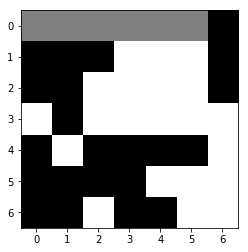

((1, 4), (0, 5)): n_v:  4508 q_all:-0.088622 q:+0.026884 q_m:+0.133333 p:0.659010
((1, 3), (0, 1)): n_v:   451 q_all:-0.097900 q:-0.116849 q_m:+0.166667 p:0.033962
((1, 3), (0, 5)): n_v:    36 q_all:-0.288732 q:-0.187973 q_m:+0.100000 p:0.038388
((2, 3), (0, 5)): n_v:     5 q_all:-0.440827 q:-0.240202 q_m:+0.100000 p:0.009992
((2, 3), (0, 1)): n_v:     5 q_all:-0.372758 q:-0.272679 q_m:+0.166667 p:0.007277
((2, 2), (0, 1)): n_v:     4 q_all:-0.332606 q:-0.241432 q_m:+0.166667 p:0.004706
((2, 4), (0, 5)): n_v:     2 q_all:-0.388644 q:-0.327292 q_m:+0.100000 p:0.003944
((2, 5), (0, 5)): n_v:     1 q_all:-0.562321 q:-0.375721 q_m:+0.100000 p:0.001573
((2, 3), (0, 4)): n_v:     0 q_all:-0.497465 q:-0.497465 q_m:-0.033333 p:0.000007
((2, 5), (0, 3)): n_v:     0 q_all:-0.403777 q:-0.403777 q_m:+0.033333 p:0.000027
((2, 2), (0, 2)): n_v:     0 q_all:-0.308342 q:-0.308342 q_m:+0.100000 p:0.000001
((2, 5), (0, 4)): n_v:     0 q_all:-0.570536 q:-0.570536 q_m:-0.033333 p:0.000002
((2, 4), (0, 4))

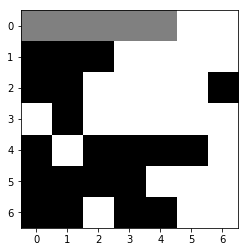

((2, 6), (0, 4)): n_v:  3128 q_all:+0.106863 q:+0.261364 q_m:+0.133333 p:0.034020
((1, 2), (0, 4)): n_v:  2969 q_all:+0.034336 q:+0.087726 q_m:+0.133333 p:0.908066
((1, 2), (0, 3)): n_v:    13 q_all:-0.264375 q:-0.110641 q_m:+0.033333 p:0.020205
((2, 0), (0, 2)): n_v:    10 q_all:-0.513373 q:-0.447924 q_m:-0.066667 p:0.025809
((1, 1), (0, 2)): n_v:     1 q_all:-0.305717 q:-0.206344 q_m:-0.033333 p:0.002457
((1, 0), (0, 2)): n_v:     0 q_all:-0.314598 q:-0.314598 q_m:-0.066667 p:0.000835
((1, 0), (0, 0)): n_v:     0 q_all:-0.336124 q:-0.336124 q_m:-0.100000 p:0.000848
((2, 1), (0, 3)): n_v:     0 q_all:-0.487751 q:-0.487751 q_m:-0.000000 p:0.000208
((2, 0), (0, 0)): n_v:     0 q_all:-0.457190 q:-0.457190 q_m:-0.133333 p:0.000683
((2, 1), (0, 1)): n_v:     0 q_all:-0.502246 q:-0.502246 q_m:-0.133333 p:0.000025
((1, 0), (0, 1)): n_v:     0 q_all:-0.335683 q:-0.335683 q_m:-0.100000 p:0.000264
((2, 1), (0, 0)): n_v:     0 q_all:-0.434727 q:-0.434727 q_m:-0.133333 p:0.000178
((1, 2), (0, 0))

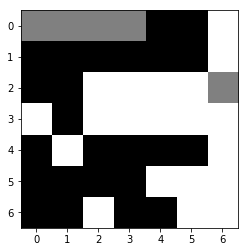

((1, 6), (2, 6)): n_v:  4304 q_all:+0.073069 q:-0.076773 q_m:-0.033333 p:0.242164
((0, 6), (2, 6)): n_v:     8 q_all:-0.410532 q:-0.407148 q_m:-0.066667 p:0.018941
((2, 5), (0, 3)): n_v:     6 q_all:-0.267482 q:-0.267482 q_m:+0.133333 p:0.008974
((3, 4), (2, 6)): n_v:     4 q_all:-0.381900 q:-0.381900 q_m:-0.066667 p:0.009237
((2, 2), (0, 3)): n_v:     3 q_all:-0.125244 q:-0.125244 q_m:+0.133333 p:0.001523
((4, 6), (2, 6)): n_v:     2 q_all:-0.420918 q:-0.420918 q_m:-0.066667 p:0.006322
((2, 3), (0, 3)): n_v:     0 q_all:-0.287703 q:-0.287703 q_m:+0.133333 p:0.000178
((2, 4), (0, 2)): n_v:     0 q_all:-0.397899 q:-0.397899 q_m:+0.066667 p:0.000355
((2, 2), (0, 2)): n_v:     0 q_all:-0.347426 q:-0.347426 q_m:+0.066667 p:0.000052
((2, 3), (0, 1)): n_v:     0 q_all:-0.373642 q:-0.373642 q_m:+0.066667 p:0.000124
((2, 3), (0, 2)): n_v:     0 q_all:-0.381234 q:-0.381234 q_m:+0.066667 p:0.000084
((2, 2), (0, 0)): n_v:     0 q_all:-0.320723 q:-0.320723 q_m:-0.000000 p:0.000299
((2, 2), (0, 1))

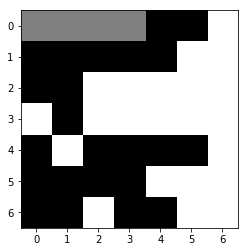

((0, 4), (0, 3)): n_v:  4325 q_all:+0.009055 q:+0.024970 q_m:+0.066667 p:0.061006
((1, 3), (0, 1)): n_v:   184 q_all:-0.186101 q:-0.052909 q_m:+0.033333 p:0.075744
((1, 4), (0, 2)): n_v:   169 q_all:-0.211444 q:-0.057730 q_m:+0.033333 p:0.091291
((0, 4), (0, 2)): n_v:   146 q_all:-0.314571 q:-0.184599 q_m:+0.033333 p:0.156121
((0, 5), (0, 3)): n_v:    67 q_all:-0.360281 q:-0.224722 q_m:+0.033333 p:0.087877
((1, 1), (0, 2)): n_v:    38 q_all:-0.187827 q:-0.137524 q_m:+0.066667 p:0.015398
((1, 0), (0, 0)): n_v:    36 q_all:-0.187567 q:-0.066061 q_m:+0.066667 p:0.015055
((1, 0), (0, 1)): n_v:    32 q_all:-0.230126 q:-0.082025 q_m:+0.066667 p:0.020993
((1, 0), (0, 2)): n_v:    13 q_all:-0.315471 q:-0.288021 q_m:+0.033333 p:0.013055
((2, 0), (0, 0)): n_v:    13 q_all:-0.488653 q:-0.334283 q_m:+0.033333 p:0.025214
((1, 2), (0, 0)): n_v:    12 q_all:-0.308739 q:-0.167847 q_m:+0.033333 p:0.011759
((1, 1), (0, 3)): n_v:    11 q_all:-0.391948 q:-0.219941 q_m:+0.033333 p:0.014274
((2, 1), (0, 0))

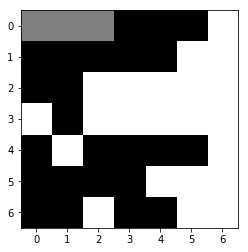

((2, 2), (0, 1)): n_v:  5525 q_all:-0.142496 q:+0.183736 q_m:+0.133333 p:0.190686
((2, 2), (0, 2)): n_v:   449 q_all:-0.290114 q:-0.067735 q_m:+0.200000 p:0.289209
((2, 3), (0, 2)): n_v:   102 q_all:-0.605248 q:-0.404151 q_m:+0.200000 p:0.198561
((2, 3), (0, 1)): n_v:    72 q_all:-0.463555 q:-0.184964 q_m:+0.133333 p:0.098903
((2, 2), (0, 0)): n_v:    64 q_all:-0.416146 q:-0.361920 q_m:+0.066667 p:0.073171
((2, 4), (0, 2)): n_v:    62 q_all:-0.680333 q:-0.514694 q_m:+0.200000 p:0.139626
########################p_sum is:  0.990155152977
-1 's turn


This is a random move


one move takes time(s):  0.3079991340637207
no. of data collected:  24


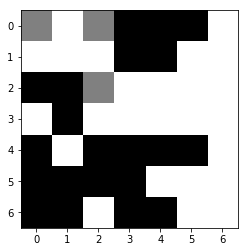

((1, 3), (2, 2)): n_v:  4572 q_all:+0.178322 q:+0.120150 q_m:+0.233333 p:0.150636
((0, 3), (2, 2)): n_v:  1296 q_all:+0.112399 q:+0.104997 q_m:+0.200000 p:0.377782
((0, 4), (2, 2)): n_v:   108 q_all:+0.014161 q:-0.028011 q_m:+0.200000 p:0.071731
((4, 0), (2, 2)): n_v:    41 q_all:+0.124897 q:-0.217181 q_m:+0.200000 p:0.009762
((4, 4), (2, 2)): n_v:    28 q_all:-0.010804 q:-0.058956 q_m:+0.200000 p:0.019811
((2, 0), (2, 2)): n_v:    26 q_all:+0.014618 q:+0.031931 q_m:+0.200000 p:0.017425
((1, 4), (2, 2)): n_v:    16 q_all:-0.390623 q:-0.416597 q_m:+0.200000 p:0.037035
((2, 1), (0, 2)): n_v:    13 q_all:-0.109262 q:-0.352598 q_m:+0.066667 p:0.015374
((2, 0), (0, 0)): n_v:    12 q_all:-0.232918 q:-0.462899 q_m:+0.066667 p:0.020735
((4, 3), (2, 2)): n_v:     4 q_all:-0.442741 q:-0.489789 q_m:+0.200000 p:0.011944
((2, 1), (0, 0)): n_v:     4 q_all:-0.375992 q:-0.331601 q_m:+0.066667 p:0.010290
((2, 0), (0, 2)): n_v:     3 q_all:-0.420421 q:-0.437808 q_m:+0.066667 p:0.008938
((1, 4), (0, 2))

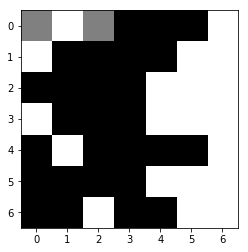

((0, 1), (0, 2)): n_v:  5601 q_all:+0.293409 q:-0.447990 q_m:+0.066667 p:0.590160
((1, 0), (0, 2)): n_v:   492 q_all:-0.481681 q:-0.481681 q_m:+0.033333 p:0.314344
((2, 4), (0, 2)): n_v:    26 q_all:-0.886139 q:-0.886139 q_m:+0.033333 p:0.087760
((0, 1), (0, 0)): n_v:     0 q_all:-0.995852 q:-0.995852 q_m:-0.133333 p:0.003082
########################p_sum is:  0.995345332427
-1 's turn
one move takes time(s):  0.05843496322631836
no. of data collected:  16


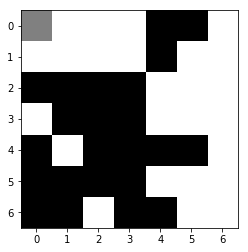

((2, 0), (0, 0)): n_v:  6275 q_all:-0.693064 q:-0.069859 q_m:+0.133333 p:0.886667
((2, 1), (0, 0)): n_v:    77 q_all:-0.914945 q:-0.690229 q_m:+0.133333 p:0.075737
((2, 2), (0, 0)): n_v:    37 q_all:-0.923298 q:-0.767667 q_m:+0.133333 p:0.037428
########################p_sum is:  0.99983214587
1 's turn
one move takes time(s):  0.03160738945007324
no. of data collected:  8


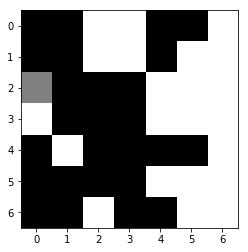

((3, 0), (2, 0)): n_v:  6452 q_all:+1.000000 q:+5.000000 q_m:+0.166667 p:0.562668
((4, 1), (2, 0)): n_v:    57 q_all:-0.957094 q:-0.937786 q_m:+0.133333 p:0.411327
((0, 2), (2, 0)): n_v:     2 q_all:-0.972899 q:-0.959348 q_m:+0.133333 p:0.018458
((1, 2), (2, 0)): n_v:     1 q_all:-0.988764 q:-0.977528 q_m:+0.133333 p:0.007527
########################p_sum is:  0.999980154913
this self play has 80 steps, time elapsed 141.71577787399292
winner is 1.0
episode 15 finished
episode 16 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.2898874282836914
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.41028809547424316
no. of data collected:  16
-1 's turn
one move takes time(s):  0.5890042781829834
no. of data collected:  16
1 's turn
one move takes time(s):  1.012948989868164
no. of data collected:  16
-1 's turn
one move takes time(s):  1.323033332824707
no. of data collected:  16
1 's turn
one move takes time(s):  1.



This is a random move


one move takes time(s):  0.40251684188842773
no. of data collected:  16
1 's turn
one move takes time(s):  0.26623106002807617
no. of data collected:  16
-1 's turn
one move takes time(s):  0.19858813285827637
no. of data collected:  24
1 's turn
one move takes time(s):  0.19968652725219727
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.14963555335998535
no. of data collected:  16
1 's turn
one move takes time(s):  0.19477224349975586
no. of data collected:  24
-1 's turn
one move takes time(s):  0.12043023109436035
no. of data collected:  16
1 's turn
one move takes time(s):  0.11068034172058105
no. of data collected:  16
-1 's turn
one move takes time(s):  0.07857489585876465
no. of data collected:  16
1 's turn
one move takes time(s):  0.06569671630859375
no. of data collected:  16
-1 's turn
one move takes time(s):  0.04786515235900879
no. of data collected:  16
1 's turn
one move takes time(s):  0.04852700233459

no. of data collected:  8
this self play has 81 steps, time elapsed 99.97852516174316
winner is 1.0
episode 17 finished
episode 18 now start
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.30132484436035156
no. of data collected:  8
1 's turn
one move takes time(s):  0.3685314655303955
no. of data collected:  16
-1 's turn
one move takes time(s):  0.7515008449554443
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  1.0091519355773926
no. of data collected:  16
-1 's turn
one move takes time(s):  1.2949795722961426
no. of data collected:  16
1 's turn
one move takes time(s):  0.5004651546478271
no. of data collected:  16
-1 's turn
one move takes time(s):  0.5368402004241943
no. of data collected:  16
1 's turn
one move takes time(s):  0.7541813850402832
no. of data collected:  16
-1 's turn
one move takes time(s):  0.9037716388702393
no. of data collected:  16
1 's turn
one move takes time(s):  0

one move takes time(s):  1.4806034564971924
no. of data collected:  24
-1 's turn
one move takes time(s):  1.8541927337646484
no. of data collected:  16
1 's turn
one move takes time(s):  1.7703473567962646
no. of data collected:  16
-1 's turn
one move takes time(s):  0.8678526878356934
no. of data collected:  16
1 's turn
one move takes time(s):  0.7201230525970459
no. of data collected:  24
-1 's turn
one move takes time(s):  1.312263011932373
no. of data collected:  16
1 's turn
one move takes time(s):  0.9801323413848877
no. of data collected:  16
-1 's turn
one move takes time(s):  0.781353235244751
no. of data collected:  16
1 's turn
one move takes time(s):  1.0029616355895996
no. of data collected:  24
-1 's turn
one move takes time(s):  1.156881332397461
no. of data collected:  16
1 's turn
one move takes time(s):  1.3521699905395508
no. of data collected:  24
-1 's turn
one move takes time(s):  1.0060250759124756
no. of data collected:  8
1 's turn
due to time lim, final rol

due to rollout lim, final rollout times:  2001 time elapsed:  2.4885737895965576
one move takes time(s):  2.4909756183624268
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.849749803543091
one move takes time(s):  3.850969076156616
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.039231538772583
one move takes time(s):  3.0405325889587402
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.928844451904297
one move takes time(s):  2.9304938316345215
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.453047752380371
one move takes time(s):  2.4548802375793457
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.916045904159546
one move takes time(s):  2.917443037033081
no. of data collected:  16
1 's turn
due to rollout lim, final rollout t

due to rollout lim, final rollout times:  2001 time elapsed:  4.630984783172607
one move takes time(s):  4.63214635848999
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  4.681687593460083


This is a random move


one move takes time(s):  4.683915376663208
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.685298442840576
one move takes time(s):  3.687199115753174
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.981712579727173
one move takes time(s):  3.9832911491394043
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.298886299133301


This is a random move


one move takes time(s):  3.300912618637085
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.7455413341522217
one move takes time(s):  3.7469089031219482
no. of data collected: 

Epoch 13/512
24854/24854 [==============================] - 2s 80us/step - loss: 0.8216 - activation_29_loss: 0.7802 - dense_15_loss: 0.0133 - val_loss: 0.9719 - val_activation_29_loss: 0.9250 - val_dense_15_loss: 0.0188
Epoch 14/512
24854/24854 [==============================] - 2s 77us/step - loss: 0.8214 - activation_29_loss: 0.7801 - dense_15_loss: 0.0131 - val_loss: 0.9720 - val_activation_29_loss: 0.9250 - val_dense_15_loss: 0.0189
Epoch 15/512
24854/24854 [==============================] - 2s 75us/step - loss: 0.8209 - activation_29_loss: 0.7797 - dense_15_loss: 0.0131 - val_loss: 0.9721 - val_activation_29_loss: 0.9251 - val_dense_15_loss: 0.0189
Epoch 16/512
24854/24854 [==============================] - 2s 80us/step - loss: 0.8201 - activation_29_loss: 0.7791 - dense_15_loss: 0.0129 - val_loss: 0.9720 - val_activation_29_loss: 0.9250 - val_dense_15_loss: 0.0189
Epoch 17/512
24854/24854 [==============================] - 2s 78us/step - loss: 0.8199 - activation_29_loss: 0.7788

24854/24854 [==============================] - 2s 80us/step - loss: 0.8091 - activation_29_loss: 0.7696 - dense_15_loss: 0.0113 - val_loss: 0.9725 - val_activation_29_loss: 0.9261 - val_dense_15_loss: 0.0182
Epoch 51/512
24854/24854 [==============================] - 2s 82us/step - loss: 0.8086 - activation_29_loss: 0.7692 - dense_15_loss: 0.0113 - val_loss: 0.9725 - val_activation_29_loss: 0.9262 - val_dense_15_loss: 0.0182
Epoch 52/512
24854/24854 [==============================] - 2s 83us/step - loss: 0.8086 - activation_29_loss: 0.7692 - dense_15_loss: 0.0113 - val_loss: 0.9726 - val_activation_29_loss: 0.9262 - val_dense_15_loss: 0.0183
Epoch 53/512
24854/24854 [==============================] - 2s 78us/step - loss: 0.8081 - activation_29_loss: 0.7688 - dense_15_loss: 0.0112 - val_loss: 0.9726 - val_activation_29_loss: 0.9262 - val_dense_15_loss: 0.0184
Epoch 54/512
24854/24854 [==============================] - 2s 78us/step - loss: 0.8078 - activation_29_loss: 0.7686 - dense_15_l

one move takes time(s):  0.5570294857025146
no. of data collected:  16
-1 's turn
one move takes time(s):  1.1494746208190918
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  1.307546854019165
no. of data collected:  24
-1 's turn
one move takes time(s):  1.6426444053649902
no. of data collected:  8
1 's turn
one move takes time(s):  0.7990562915802002
no. of data collected:  16
-1 's turn
one move takes time(s):  1.3499963283538818
no. of data collected:  16
1 's turn
one move takes time(s):  1.3026490211486816
no. of data collected:  16
-1 's turn
one move takes time(s):  1.26991605758667
no. of data collected:  16
1 's turn
one move takes time(s):  1.6914222240447998
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.0239951610565186
one move takes time(s):  2.0255544185638428
no. of data collected:  8
1 's turn
due to time lim, final rollout times:  0 time elapsed:  41.149548053741455
one move 

one move takes time(s):  1.2060058116912842
no. of data collected:  16
1 's turn
one move takes time(s):  0.9251930713653564
no. of data collected:  16
-1 's turn
one move takes time(s):  0.9240415096282959
no. of data collected:  16
1 's turn
one move takes time(s):  0.884976863861084
no. of data collected:  16
-1 's turn
one move takes time(s):  0.707186222076416
no. of data collected:  24
1 's turn
one move takes time(s):  0.6155879497528076
no. of data collected:  16
-1 's turn
one move takes time(s):  0.6229372024536133
no. of data collected:  24
1 's turn
one move takes time(s):  1.1131007671356201
no. of data collected:  24
-1 's turn


This is a random move


one move takes time(s):  0.9083163738250732
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  1.6590790748596191
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5743472576141357
no. of data collected:  16
1 's turn
one move takes time(s):  0.5970733165740967
no. of data

one move takes time(s):  0.30940914154052734
no. of data collected:  16
-1 's turn
one move takes time(s):  0.28260159492492676
no. of data collected:  16
1 's turn
one move takes time(s):  0.3873019218444824
no. of data collected:  24
-1 's turn


This is a random move


one move takes time(s):  0.20425772666931152
no. of data collected:  16
1 's turn
one move takes time(s):  0.2463076114654541
no. of data collected:  16
-1 's turn
one move takes time(s):  0.2056567668914795
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.35341882705688477
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.37914562225341797
no. of data collected:  16
1 's turn
one move takes time(s):  0.38415074348449707
no. of data collected:  16
-1 's turn
one move takes time(s):  0.38577985763549805
no. of data collected:  24
1 's turn
one move takes time(s):  0.34159135818481445
no. of data collected:  16
-1 's turn
one move takes ti

due to rollout lim, final rollout times:  2001 time elapsed:  4.632367134094238
one move takes time(s):  4.633745431900024
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.7251651287078857


This is a random move


one move takes time(s):  3.7266056537628174
no. of data collected:  8
1 's turn
due to time lim, final rollout times:  1731 time elapsed:  24.16315221786499


This is a random move


one move takes time(s):  24.165487051010132
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.3520162105560303
one move takes time(s):  2.3536550998687744
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.5279152393341064
one move takes time(s):  3.529906988143921
no. of data collected:  8
-1 's turn
one move takes time(s):  1.9802353382110596
no. of data collected:  24
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.0

one move takes time(s):  1.542086124420166
no. of data collected:  24
-1 's turn
one move takes time(s):  0.9506595134735107
no. of data collected:  16
1 's turn
one move takes time(s):  1.549811601638794
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  1.6805763244628906
no. of data collected:  16
1 's turn
one move takes time(s):  1.094421148300171
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.9521474838256836
no. of data collected:  16
1 's turn
one move takes time(s):  0.719456672668457
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.8851511478424072
no. of data collected:  16
1 's turn
one move takes time(s):  1.3402903079986572
no. of data collected:  16
-1 's turn
one move takes time(s):  0.9284977912902832
no. of data collected:  16
1 's turn
one move takes time(s):  0.6486849784851074
no. of data collected:  16
-1 's turn
one move takes time(s):  0.95

one move takes time(s):  0.840705394744873
no. of data collected:  16
1 's turn
one move takes time(s):  0.7936761379241943
no. of data collected:  16
-1 's turn
one move takes time(s):  0.5916545391082764
no. of data collected:  16
1 's turn
one move takes time(s):  1.5023479461669922
no. of data collected:  16
-1 's turn
one move takes time(s):  1.1259655952453613
no. of data collected:  24
1 's turn
one move takes time(s):  0.6700563430786133
no. of data collected:  16
-1 's turn
one move takes time(s):  1.0820751190185547
no. of data collected:  16
1 's turn
one move takes time(s):  1.8510220050811768
no. of data collected:  16
-1 's turn
one move takes time(s):  0.7560796737670898
no. of data collected:  24
1 's turn
one move takes time(s):  0.7536396980285645
no. of data collected:  24
-1 's turn


This is a random move


one move takes time(s):  0.9099335670471191
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.5875120162963867
no. of da

Epoch 23/512
30566/30566 [==============================] - 2s 77us/step - loss: 0.8388 - activation_29_loss: 0.8006 - dense_15_loss: 0.0102 - val_loss: 0.9113 - val_activation_29_loss: 0.8638 - val_dense_15_loss: 0.0194
Epoch 24/512
30566/30566 [==============================] - 2s 76us/step - loss: 0.8386 - activation_29_loss: 0.8004 - dense_15_loss: 0.0101 - val_loss: 0.9112 - val_activation_29_loss: 0.8638 - val_dense_15_loss: 0.0193
Epoch 25/512
30566/30566 [==============================] - 2s 76us/step - loss: 0.8384 - activation_29_loss: 0.8001 - dense_15_loss: 0.0101 - val_loss: 0.9111 - val_activation_29_loss: 0.8638 - val_dense_15_loss: 0.0192
Epoch 26/512
30566/30566 [==============================] - 2s 78us/step - loss: 0.8381 - activation_29_loss: 0.7999 - dense_15_loss: 0.0101 - val_loss: 0.9111 - val_activation_29_loss: 0.8639 - val_dense_15_loss: 0.0191
Epoch 27/512
30566/30566 [==============================] - 2s 76us/step - loss: 0.8380 - activation_29_loss: 0.7998

30566/30566 [==============================] - 2s 75us/step - loss: 0.8320 - activation_29_loss: 0.7946 - dense_15_loss: 0.0094 - val_loss: 0.9116 - val_activation_29_loss: 0.8646 - val_dense_15_loss: 0.0189
Epoch 61/512
30566/30566 [==============================] - 2s 78us/step - loss: 0.8317 - activation_29_loss: 0.7943 - dense_15_loss: 0.0093 - val_loss: 0.9117 - val_activation_29_loss: 0.8647 - val_dense_15_loss: 0.0188
Epoch 62/512
30566/30566 [==============================] - 2s 80us/step - loss: 0.8317 - activation_29_loss: 0.7943 - dense_15_loss: 0.0093 - val_loss: 0.9114 - val_activation_29_loss: 0.8646 - val_dense_15_loss: 0.0187
Epoch 63/512
30566/30566 [==============================] - 2s 80us/step - loss: 0.8315 - activation_29_loss: 0.7941 - dense_15_loss: 0.0093 - val_loss: 0.9117 - val_activation_29_loss: 0.8648 - val_dense_15_loss: 0.0188
Epoch 64/512
30566/30566 [==============================] - 2s 78us/step - loss: 0.8315 - activation_29_loss: 0.7941 - dense_15_l

30566/30566 [==============================] - 2s 78us/step - loss: 0.8264 - activation_29_loss: 0.7895 - dense_15_loss: 0.0088 - val_loss: 0.9122 - val_activation_29_loss: 0.8656 - val_dense_15_loss: 0.0185
Epoch 98/512
30566/30566 [==============================] - 2s 81us/step - loss: 0.8262 - activation_29_loss: 0.7892 - dense_15_loss: 0.0088 - val_loss: 0.9120 - val_activation_29_loss: 0.8657 - val_dense_15_loss: 0.0182
Epoch 99/512
30566/30566 [==============================] - 2s 81us/step - loss: 0.8260 - activation_29_loss: 0.7891 - dense_15_loss: 0.0088 - val_loss: 0.9122 - val_activation_29_loss: 0.8658 - val_dense_15_loss: 0.0183
Epoch 100/512
30566/30566 [==============================] - 2s 77us/step - loss: 0.8259 - activation_29_loss: 0.7890 - dense_15_loss: 0.0088 - val_loss: 0.9120 - val_activation_29_loss: 0.8656 - val_dense_15_loss: 0.0183
Epoch 101/512
30566/30566 [==============================] - 3s 85us/step - loss: 0.8257 - activation_29_loss: 0.7889 - dense_15

due to rollout lim, final rollout times:  2001 time elapsed:  2.0212368965148926
one move takes time(s):  2.0240962505340576
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  4.221826076507568
one move takes time(s):  4.223290205001831
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.8185267448425293
one move takes time(s):  2.822263717651367
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  1.888767957687378
no. of data collected:  16
1 's turn
one move takes time(s):  1.996248483657837
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.024090528488159
one move takes time(s):  2.025390625
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.781602382659912


This is a random move


one move takes time(s):  3.783505439758301
no. of data collected:  8

due to rollout lim, final rollout times:  2001 time elapsed:  3.446061372756958
one move takes time(s):  3.4473671913146973
no. of data collected:  24
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.544715166091919
one move takes time(s):  2.546062707901001
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.515207529067993
one move takes time(s):  2.516721248626709
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.4782755374908447
one move takes time(s):  2.479801893234253
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.289647340774536
one move takes time(s):  3.290903091430664
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.8794686794281006


This is a random move


one move takes time(s):  2.881000518798828
no. of data collected:  16
1 's turn
due to r

one move takes time(s):  0.23614978790283203
no. of data collected:  16
1 's turn
one move takes time(s):  0.19294023513793945
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.16671395301818848
no. of data collected:  16
1 's turn
one move takes time(s):  0.1537315845489502
no. of data collected:  24
-1 's turn
one move takes time(s):  0.1973731517791748
no. of data collected:  16
1 's turn
one move takes time(s):  0.2182016372680664
no. of data collected:  24
-1 's turn
one move takes time(s):  0.38187336921691895
no. of data collected:  16
1 's turn
one move takes time(s):  0.18117117881774902
no. of data collected:  16
-1 's turn
one move takes time(s):  0.23448705673217773
no. of data collected:  16
1 's turn
one move takes time(s):  0.17455816268920898
no. of data collected:  16
-1 's turn
one move takes time(s):  0.2087547779083252
no. of data collected:  16
1 's turn
one move takes time(s):  0.1981203556060791
no. of data collected:  16


one move takes time(s):  0.194655179977417
no. of data collected:  16
-1 's turn
one move takes time(s):  0.10366153717041016
no. of data collected:  16
1 's turn
one move takes time(s):  0.07596254348754883
no. of data collected:  16
-1 's turn
one move takes time(s):  0.06912922859191895
no. of data collected:  16
1 's turn
one move takes time(s):  0.04244637489318848
no. of data collected:  16
-1 's turn
one move takes time(s):  0.02989649772644043
no. of data collected:  8
this self play has 75 steps, time elapsed 133.89360404014587
winner is -1.0
episode 29 finished
episode 30 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.2977898120880127
no. of data collected:  8
1 's turn
one move takes time(s):  0.4327120780944824
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.7300121784210205
no. of data collected:  24
1 's turn
one move takes time(s):  0.986351490020752
no. of data collected:  16
-1 's turn
one

34000/34000 [==============================] - 3s 76us/step - loss: 0.8589 - activation_29_loss: 0.8207 - dense_15_loss: 0.0102 - val_loss: 0.8435 - val_activation_29_loss: 0.8055 - val_dense_15_loss: 0.0099
Epoch 3/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8585 - activation_29_loss: 0.8203 - dense_15_loss: 0.0101 - val_loss: 0.8435 - val_activation_29_loss: 0.8056 - val_dense_15_loss: 0.0099
Epoch 4/512
34000/34000 [==============================] - 3s 78us/step - loss: 0.8582 - activation_29_loss: 0.8200 - dense_15_loss: 0.0101 - val_loss: 0.8436 - val_activation_29_loss: 0.8056 - val_dense_15_loss: 0.0099
Epoch 5/512
34000/34000 [==============================] - 3s 74us/step - loss: 0.8581 - activation_29_loss: 0.8199 - dense_15_loss: 0.0101 - val_loss: 0.8435 - val_activation_29_loss: 0.8056 - val_dense_15_loss: 0.0098
Epoch 6/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8575 - activation_29_loss: 0.8194 - dense_15_loss:

34000/34000 [==============================] - 3s 79us/step - loss: 0.8510 - activation_29_loss: 0.8137 - dense_15_loss: 0.0091 - val_loss: 0.8443 - val_activation_29_loss: 0.8067 - val_dense_15_loss: 0.0095
Epoch 40/512
34000/34000 [==============================] - 3s 79us/step - loss: 0.8508 - activation_29_loss: 0.8135 - dense_15_loss: 0.0092 - val_loss: 0.8443 - val_activation_29_loss: 0.8067 - val_dense_15_loss: 0.0095
Epoch 41/512
34000/34000 [==============================] - 3s 79us/step - loss: 0.8508 - activation_29_loss: 0.8135 - dense_15_loss: 0.0092 - val_loss: 0.8443 - val_activation_29_loss: 0.8068 - val_dense_15_loss: 0.0094
Epoch 42/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8505 - activation_29_loss: 0.8133 - dense_15_loss: 0.0091 - val_loss: 0.8443 - val_activation_29_loss: 0.8068 - val_dense_15_loss: 0.0094
Epoch 43/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8506 - activation_29_loss: 0.8133 - dense_15_l

34000/34000 [==============================] - 3s 83us/step - loss: 0.8462 - activation_29_loss: 0.8094 - dense_15_loss: 0.0087 - val_loss: 0.8443 - val_activation_29_loss: 0.8070 - val_dense_15_loss: 0.0092
Epoch 77/512
34000/34000 [==============================] - 3s 81us/step - loss: 0.8458 - activation_29_loss: 0.8091 - dense_15_loss: 0.0087 - val_loss: 0.8443 - val_activation_29_loss: 0.8070 - val_dense_15_loss: 0.0092
Epoch 78/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8456 - activation_29_loss: 0.8088 - dense_15_loss: 0.0087 - val_loss: 0.8443 - val_activation_29_loss: 0.8070 - val_dense_15_loss: 0.0092
Epoch 79/512
34000/34000 [==============================] - 3s 79us/step - loss: 0.8457 - activation_29_loss: 0.8089 - dense_15_loss: 0.0087 - val_loss: 0.8443 - val_activation_29_loss: 0.8071 - val_dense_15_loss: 0.0092
Epoch 80/512
34000/34000 [==============================] - 3s 78us/step - loss: 0.8455 - activation_29_loss: 0.8087 - dense_15_l

no. of data collected:  24
-1 's turn
one move takes time(s):  0.19687199592590332
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.22925114631652832
no. of data collected:  24
-1 's turn


This is a random move


one move takes time(s):  0.14760255813598633
no. of data collected:  16
1 's turn
one move takes time(s):  0.13521432876586914
no. of data collected:  16
-1 's turn
one move takes time(s):  0.16357707977294922
no. of data collected:  16
1 's turn
one move takes time(s):  0.17172741889953613
no. of data collected:  24
-1 's turn
one move takes time(s):  0.16199254989624023
no. of data collected:  24
1 's turn
one move takes time(s):  0.12813162803649902
no. of data collected:  32
-1 's turn
one move takes time(s):  0.09382343292236328
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.09760427474975586
no. of data collected:  16
-1 's turn
one move takes time(s):  0.0843961238861084
no. of data col

one move takes time(s):  0.9287405014038086
no. of data collected:  16
1 's turn
one move takes time(s):  1.4851901531219482
no. of data collected:  24
-1 's turn
one move takes time(s):  0.45840024948120117
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.7185437679290771
no. of data collected:  16
-1 's turn
one move takes time(s):  0.5239462852478027
no. of data collected:  24
1 's turn


This is a random move


one move takes time(s):  0.49701380729675293
no. of data collected:  16
-1 's turn
one move takes time(s):  0.48272275924682617
no. of data collected:  24
1 's turn
one move takes time(s):  1.256946086883545
no. of data collected:  32
-1 's turn
one move takes time(s):  0.9327192306518555
no. of data collected:  24
1 's turn
one move takes time(s):  0.9249064922332764
no. of data collected:  24
-1 's turn
one move takes time(s):  0.45546984672546387
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):

one move takes time(s):  0.33620715141296387
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.26618099212646484
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.26732635498046875
no. of data collected:  24
1 's turn
one move takes time(s):  0.17331147193908691
no. of data collected:  16
-1 's turn
one move takes time(s):  0.13127732276916504
no. of data collected:  16
1 's turn
one move takes time(s):  0.12319803237915039
no. of data collected:  16
-1 's turn
one move takes time(s):  0.23104500770568848
no. of data collected:  24
1 's turn
one move takes time(s):  0.1207571029663086
no. of data collected:  16
-1 's turn
one move takes time(s):  0.10092329978942871
no. of data collected:  16
1 's turn
one move takes time(s):  0.060214996337890625
no. of data collected:  16
-1 's turn
one move takes time(s):  0.06000185012817383
no. of data collected:  16
1 's turn
one move takes time(s):  0.07386279106140

one move takes time(s):  0.7262434959411621
no. of data collected:  16
1 's turn
one move takes time(s):  0.5353329181671143
no. of data collected:  24
-1 's turn
one move takes time(s):  0.5002849102020264
no. of data collected:  16
1 's turn
one move takes time(s):  0.45784974098205566
no. of data collected:  16
-1 's turn
one move takes time(s):  0.4962174892425537
no. of data collected:  24
1 's turn
one move takes time(s):  0.6655662059783936
no. of data collected:  16
-1 's turn
one move takes time(s):  0.44500088691711426
no. of data collected:  16
1 's turn
one move takes time(s):  0.38338470458984375
no. of data collected:  16
-1 's turn
one move takes time(s):  0.4126851558685303
no. of data collected:  16
1 's turn
one move takes time(s):  0.1926286220550537
no. of data collected:  24
-1 's turn


This is a random move


one move takes time(s):  0.20479631423950195
no. of data collected:  16
1 's turn
one move takes time(s):  0.20200109481811523
no. of data collected:  24
-1

34000/34000 [==============================] - 3s 81us/step - loss: 0.8360 - activation_29_loss: 0.7991 - dense_15_loss: 0.0088 - val_loss: 0.8398 - val_activation_29_loss: 0.8031 - val_dense_15_loss: 0.0086
Epoch 2/512
34000/34000 [==============================] - 3s 74us/step - loss: 0.8356 - activation_29_loss: 0.7987 - dense_15_loss: 0.0087 - val_loss: 0.8399 - val_activation_29_loss: 0.8032 - val_dense_15_loss: 0.0085
Epoch 3/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8355 - activation_29_loss: 0.7986 - dense_15_loss: 0.0088 - val_loss: 0.8399 - val_activation_29_loss: 0.8033 - val_dense_15_loss: 0.0085
Epoch 4/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8352 - activation_29_loss: 0.7984 - dense_15_loss: 0.0087 - val_loss: 0.8402 - val_activation_29_loss: 0.8035 - val_dense_15_loss: 0.0086
Epoch 5/512
34000/34000 [==============================] - 3s 74us/step - loss: 0.8347 - activation_29_loss: 0.7980 - dense_15_loss:

34000/34000 [==============================] - 3s 78us/step - loss: 0.8293 - activation_29_loss: 0.7928 - dense_15_loss: 0.0084 - val_loss: 0.8418 - val_activation_29_loss: 0.8053 - val_dense_15_loss: 0.0084
Epoch 39/512
34000/34000 [==============================] - 3s 74us/step - loss: 0.8292 - activation_29_loss: 0.7927 - dense_15_loss: 0.0084 - val_loss: 0.8418 - val_activation_29_loss: 0.8053 - val_dense_15_loss: 0.0084
Epoch 40/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8293 - activation_29_loss: 0.7929 - dense_15_loss: 0.0083 - val_loss: 0.8418 - val_activation_29_loss: 0.8053 - val_dense_15_loss: 0.0084
Epoch 41/512
34000/34000 [==============================] - 3s 79us/step - loss: 0.8291 - activation_29_loss: 0.7926 - dense_15_loss: 0.0084 - val_loss: 0.8419 - val_activation_29_loss: 0.8054 - val_dense_15_loss: 0.0084
Epoch 42/512
34000/34000 [==============================] - 3s 78us/step - loss: 0.8292 - activation_29_loss: 0.7927 - dense_15_l

34000/34000 [==============================] - 3s 78us/step - loss: 0.8251 - activation_29_loss: 0.7888 - dense_15_loss: 0.0082 - val_loss: 0.8427 - val_activation_29_loss: 0.8063 - val_dense_15_loss: 0.0083
Epoch 76/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8247 - activation_29_loss: 0.7886 - dense_15_loss: 0.0081 - val_loss: 0.8427 - val_activation_29_loss: 0.8063 - val_dense_15_loss: 0.0083
Epoch 77/512
34000/34000 [==============================] - 3s 78us/step - loss: 0.8249 - activation_29_loss: 0.7886 - dense_15_loss: 0.0081 - val_loss: 0.8426 - val_activation_29_loss: 0.8063 - val_dense_15_loss: 0.0082
Epoch 78/512
34000/34000 [==============================] - 3s 82us/step - loss: 0.8248 - activation_29_loss: 0.7886 - dense_15_loss: 0.0081 - val_loss: 0.8426 - val_activation_29_loss: 0.8063 - val_dense_15_loss: 0.0082
Epoch 79/512
34000/34000 [==============================] - 3s 79us/step - loss: 0.8248 - activation_29_loss: 0.7886 - dense_15_l

one move takes time(s):  0.810746431350708
no. of data collected:  16
-1 's turn
one move takes time(s):  1.5432474613189697
no. of data collected:  24
1 's turn
one move takes time(s):  0.8700456619262695
no. of data collected:  16
-1 's turn
one move takes time(s):  1.2930352687835693
no. of data collected:  24
1 's turn


This is a random move


one move takes time(s):  0.9195206165313721
no. of data collected:  16
-1 's turn
one move takes time(s):  0.9949555397033691
no. of data collected:  24
1 's turn
one move takes time(s):  0.9647533893585205
no. of data collected:  24
-1 's turn
one move takes time(s):  1.2497775554656982
no. of data collected:  16
1 's turn
one move takes time(s):  0.6637163162231445
no. of data collected:  24
-1 's turn
one move takes time(s):  1.092700719833374
no. of data collected:  24
1 's turn
one move takes time(s):  1.2313873767852783
no. of data collected:  16
-1 's turn
one move takes time(s):  0.9045500755310059
no. of data collected:  8
1 's turn

due to rollout lim, final rollout times:  2001 time elapsed:  4.171670436859131
one move takes time(s):  4.1736931800842285
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  2109 time elapsed:  2.0140926837921143
one move takes time(s):  2.016181468963623
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.9776904582977295
no. of data collected:  16
1 's turn
due to time lim, final rollout times:  1844 time elapsed:  6.009409189224243
one move takes time(s):  6.010934829711914
no. of data collected:  16
-1 's turn
one move takes time(s):  1.6768519878387451
no. of data collected:  16
1 's turn
one move takes time(s):  1.6224794387817383
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.943023920059204
one move takes time(s):  2.944154739379883
no. of data collected:  16
1 's turn
one move takes time(s):  1.7996318340301514
no. of data collected:  16
-1 's turn
due to r

due to rollout lim, final rollout times:  2001 time elapsed:  4.580629348754883
one move takes time(s):  4.582084655761719
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.099470615386963
one move takes time(s):  2.100847005844116
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.6894540786743164
one move takes time(s):  2.6932973861694336
no. of data collected:  8
1 's turn
one move takes time(s):  1.6971356868743896
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.969142198562622
one move takes time(s):  3.9706320762634277
no. of data collected:  16
1 's turn
one move takes time(s):  1.3512585163116455
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.024550437927246
one move takes time(s):  3.0256779193878174
no. of data collected:  8
1 's turn
due to rollout lim, final rollout 

due to rollout lim, final rollout times:  2001 time elapsed:  2.4453327655792236
one move takes time(s):  2.4469029903411865
no. of data collected:  16
1 's turn
one move takes time(s):  1.7132930755615234
no. of data collected:  16
-1 's turn
one move takes time(s):  1.3953533172607422
no. of data collected:  16
1 's turn
one move takes time(s):  0.9813671112060547
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.2500133514404297
one move takes time(s):  2.251072406768799
no. of data collected:  24
1 's turn
one move takes time(s):  1.415384292602539
no. of data collected:  16
-1 's turn
one move takes time(s):  0.8779919147491455
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.053920030593872
one move takes time(s):  2.0552585124969482
no. of data collected:  16
-1 's turn
one move takes time(s):  0.9674522876739502
no. of data collected:  16
1 's turn
one move takes time(s):  1.

due to rollout lim, final rollout times:  2001 time elapsed:  2.3027286529541016
one move takes time(s):  2.3043322563171387
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.5046823024749756


This is a random move


one move takes time(s):  3.5080814361572266
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.6304969787597656
one move takes time(s):  3.631809711456299
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.4696426391601562
one move takes time(s):  2.472940444946289
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.1805756092071533
one move takes time(s):  3.1819000244140625
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.3075602054595947
one move takes time(s):  2.3092455863952637
no. of data collected:  16
-1 's turn
one

one move takes time(s):  0.8453342914581299
no. of data collected:  16
1 's turn
one move takes time(s):  0.9091260433197021
no. of data collected:  16
-1 's turn
one move takes time(s):  1.2815227508544922
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.215801239013672
one move takes time(s):  2.2169411182403564
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.6990771293640137


This is a random move


one move takes time(s):  3.7006566524505615
no. of data collected:  16
1 's turn
one move takes time(s):  1.8472394943237305
no. of data collected:  24
-1 's turn
one move takes time(s):  0.9321110248565674
no. of data collected:  16
1 's turn
one move takes time(s):  1.597764253616333
no. of data collected:  16
-1 's turn
one move takes time(s):  1.0546157360076904
no. of data collected:  16
1 's turn
one move takes time(s):  1.2256319522857666
no. of data collected:  16
-1 's turn

34000/34000 [==============================] - 2s 73us/step - loss: 0.8588 - activation_29_loss: 0.8220 - dense_15_loss: 0.0087 - val_loss: 0.8586 - val_activation_29_loss: 0.8222 - val_dense_15_loss: 0.0083
Epoch 20/512
34000/34000 [==============================] - 2s 73us/step - loss: 0.8586 - activation_29_loss: 0.8219 - dense_15_loss: 0.0086 - val_loss: 0.8586 - val_activation_29_loss: 0.8222 - val_dense_15_loss: 0.0083
Epoch 21/512
34000/34000 [==============================] - 3s 78us/step - loss: 0.8586 - activation_29_loss: 0.8218 - dense_15_loss: 0.0086 - val_loss: 0.8586 - val_activation_29_loss: 0.8222 - val_dense_15_loss: 0.0083
Epoch 22/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8583 - activation_29_loss: 0.8216 - dense_15_loss: 0.0086 - val_loss: 0.8587 - val_activation_29_loss: 0.8223 - val_dense_15_loss: 0.0083
Epoch 23/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8581 - activation_29_loss: 0.8214 - dense_15_l

34000/34000 [==============================] - 3s 79us/step - loss: 0.8539 - activation_29_loss: 0.8174 - dense_15_loss: 0.0083 - val_loss: 0.8593 - val_activation_29_loss: 0.8230 - val_dense_15_loss: 0.0082
Epoch 57/512
34000/34000 [==============================] - 3s 79us/step - loss: 0.8538 - activation_29_loss: 0.8174 - dense_15_loss: 0.0083 - val_loss: 0.8593 - val_activation_29_loss: 0.8230 - val_dense_15_loss: 0.0082
Epoch 58/512
34000/34000 [==============================] - 3s 81us/step - loss: 0.8535 - activation_29_loss: 0.8171 - dense_15_loss: 0.0083 - val_loss: 0.8593 - val_activation_29_loss: 0.8230 - val_dense_15_loss: 0.0082
Epoch 59/512
34000/34000 [==============================] - 3s 80us/step - loss: 0.8535 - activation_29_loss: 0.8171 - dense_15_loss: 0.0082 - val_loss: 0.8593 - val_activation_29_loss: 0.8230 - val_dense_15_loss: 0.0082
Epoch 60/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8532 - activation_29_loss: 0.8169 - dense_15_l

one move takes time(s):  1.4856367111206055
no. of data collected:  24
1 's turn
one move takes time(s):  1.7325162887573242
no. of data collected:  16
-1 's turn
one move takes time(s):  1.1949799060821533
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.2280755043029785
one move takes time(s):  2.229444742202759
no. of data collected:  16
-1 's turn
one move takes time(s):  1.6371774673461914
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.132850408554077
one move takes time(s):  2.13472056388855
no. of data collected:  24
-1 's turn
one move takes time(s):  1.0841991901397705
no. of data collected:  16
1 's turn
one move takes time(s):  0.8690671920776367
no. of data collected:  16
-1 's turn
one move takes time(s):  1.539996862411499
no. of data collected:  16
1 's turn
one move takes time(s):  1.593907117843628
no. of data collected:  16
-1 's turn
one move takes time(s):  1.36



This is a random move


one move takes time(s):  1.7425744533538818
no. of data collected:  16
1 's turn
one move takes time(s):  1.8545775413513184
no. of data collected:  16
-1 's turn
one move takes time(s):  1.6861910820007324
no. of data collected:  24
1 's turn
one move takes time(s):  1.5432014465332031
no. of data collected:  24
-1 's turn
one move takes time(s):  1.0403764247894287
no. of data collected:  24
1 's turn
one move takes time(s):  1.7032947540283203
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.431319236755371
one move takes time(s):  3.4326705932617188
no. of data collected:  24
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.7217445373535156
one move takes time(s):  2.723116397857666
no. of data collected:  16
-1 's turn
one move takes time(s):  1.553232192993164
no. of data collected:  16
1 's turn
one move takes time(s):  1.0297646522521973
no. of data collected:  16
-1 's turn


one move takes time(s):  1.2246620655059814
no. of data collected:  16
1 's turn
one move takes time(s):  1.1657423973083496
no. of data collected:  16
-1 's turn
one move takes time(s):  1.386624813079834
no. of data collected:  16
1 's turn
one move takes time(s):  1.1054561138153076
no. of data collected:  24
-1 's turn
one move takes time(s):  1.4432430267333984
no. of data collected:  16
1 's turn
one move takes time(s):  1.1691818237304688
no. of data collected:  16
-1 's turn
one move takes time(s):  1.5622410774230957
no. of data collected:  24
1 's turn
one move takes time(s):  0.49189090728759766
no. of data collected:  16
-1 's turn
one move takes time(s):  1.0371513366699219
no. of data collected:  24
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.072443723678589


This is a random move


one move takes time(s):  2.0746469497680664
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.9529471397399902
no. of dat

one move takes time(s):  0.3510894775390625
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.7292611598968506
no. of data collected:  16
-1 's turn
one move takes time(s):  0.5929977893829346
no. of data collected:  24
1 's turn
one move takes time(s):  0.6374239921569824
no. of data collected:  16
-1 's turn
one move takes time(s):  0.6507008075714111
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.9326279163360596
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.8414313793182373
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.7978224754333496
no. of data collected:  16
-1 's turn
one move takes time(s):  0.4070618152618408
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.2567317485809326
no. of data collected:  16
-1 's turn
one move takes time(s):  0.3989574909210205
no. of data 

due to rollout lim, final rollout times:  2001 time elapsed:  2.6279072761535645
one move takes time(s):  2.629624605178833
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  4.114305019378662
one move takes time(s):  4.115816593170166
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  4.945171594619751
one move takes time(s):  4.946622133255005
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  4.239709854125977
one move takes time(s):  4.240976333618164
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.3532140254974365
one move takes time(s):  3.355233907699585
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  5.2426838874816895
one move takes time(s):  5.244252443313599
no. of data collected:  8
1 's turn
due to rollout lim, final rollout ti

34000/34000 [==============================] - 3s 75us/step - loss: 0.8513 - activation_29_loss: 0.8134 - dense_15_loss: 0.0097 - val_loss: 0.8544 - val_activation_29_loss: 0.8179 - val_dense_15_loss: 0.0084
Epoch 6/512
34000/34000 [==============================] - 3s 74us/step - loss: 0.8510 - activation_29_loss: 0.8132 - dense_15_loss: 0.0098 - val_loss: 0.8545 - val_activation_29_loss: 0.8180 - val_dense_15_loss: 0.0084
Epoch 7/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8507 - activation_29_loss: 0.8129 - dense_15_loss: 0.0097 - val_loss: 0.8545 - val_activation_29_loss: 0.8179 - val_dense_15_loss: 0.0084
Epoch 8/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8506 - activation_29_loss: 0.8129 - dense_15_loss: 0.0097 - val_loss: 0.8544 - val_activation_29_loss: 0.8180 - val_dense_15_loss: 0.0084
Epoch 9/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8504 - activation_29_loss: 0.8126 - dense_15_loss:

34000/34000 [==============================] - 3s 76us/step - loss: 0.8448 - activation_29_loss: 0.8076 - dense_15_loss: 0.0091 - val_loss: 0.8558 - val_activation_29_loss: 0.8194 - val_dense_15_loss: 0.0083
Epoch 43/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8446 - activation_29_loss: 0.8074 - dense_15_loss: 0.0091 - val_loss: 0.8560 - val_activation_29_loss: 0.8195 - val_dense_15_loss: 0.0083
Epoch 44/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8448 - activation_29_loss: 0.8075 - dense_15_loss: 0.0091 - val_loss: 0.8560 - val_activation_29_loss: 0.8195 - val_dense_15_loss: 0.0083
Epoch 45/512
34000/34000 [==============================] - 3s 80us/step - loss: 0.8447 - activation_29_loss: 0.8075 - dense_15_loss: 0.0091 - val_loss: 0.8559 - val_activation_29_loss: 0.8195 - val_dense_15_loss: 0.0083
Epoch 46/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8446 - activation_29_loss: 0.8074 - dense_15_l

34000/34000 [==============================] - 3s 79us/step - loss: 0.8406 - activation_29_loss: 0.8038 - dense_15_loss: 0.0087 - val_loss: 0.8568 - val_activation_29_loss: 0.8204 - val_dense_15_loss: 0.0084
Epoch 80/512
34000/34000 [==============================] - 3s 79us/step - loss: 0.8406 - activation_29_loss: 0.8038 - dense_15_loss: 0.0087 - val_loss: 0.8568 - val_activation_29_loss: 0.8204 - val_dense_15_loss: 0.0083
Epoch 81/512
34000/34000 [==============================] - 3s 79us/step - loss: 0.8402 - activation_29_loss: 0.8035 - dense_15_loss: 0.0087 - val_loss: 0.8569 - val_activation_29_loss: 0.8205 - val_dense_15_loss: 0.0083
Epoch 82/512
34000/34000 [==============================] - 3s 78us/step - loss: 0.8401 - activation_29_loss: 0.8034 - dense_15_loss: 0.0086 - val_loss: 0.8569 - val_activation_29_loss: 0.8205 - val_dense_15_loss: 0.0083
Epoch 83/512
34000/34000 [==============================] - 2s 73us/step - loss: 0.8403 - activation_29_loss: 0.8035 - dense_15_l

one move takes time(s):  0.30646395683288574
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.2637920379638672
no. of data collected:  16
1 's turn
one move takes time(s):  0.3602442741394043
no. of data collected:  32
-1 's turn
one move takes time(s):  0.22114896774291992
no. of data collected:  16
1 's turn
one move takes time(s):  0.18197345733642578
no. of data collected:  16
-1 's turn
one move takes time(s):  0.2628605365753174
no. of data collected:  32
1 's turn
one move takes time(s):  0.2543067932128906
no. of data collected:  16
-1 's turn
one move takes time(s):  0.15842628479003906
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.13571906089782715
no. of data collected:  16
-1 's turn
one move takes time(s):  0.1538693904876709
no. of data collected:  16
1 's turn
one move takes time(s):  0.21452069282531738
no. of data collected:  16
-1 's turn
one move takes time(s):  0.15506482124328613


one move takes time(s):  0.24448132514953613
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.37011027336120605
no. of data collected:  16
-1 's turn
one move takes time(s):  0.32231903076171875
no. of data collected:  16
1 's turn
one move takes time(s):  0.3778567314147949
no. of data collected:  24
-1 's turn


This is a random move


one move takes time(s):  0.33083081245422363
no. of data collected:  16
1 's turn
one move takes time(s):  0.5201349258422852
no. of data collected:  24
-1 's turn
one move takes time(s):  0.4403355121612549
no. of data collected:  16
1 's turn
one move takes time(s):  0.4105346202850342
no. of data collected:  24
-1 's turn
one move takes time(s):  0.3635845184326172
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.28273987770080566
no. of data collected:  16
-1 's turn
one move takes time(s):  0.23517918586730957
no. of data collected:  24
1 's turn
one move takes time(

one move takes time(s):  0.8074474334716797
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  1.0167133808135986
no. of data collected:  32
-1 's turn
one move takes time(s):  0.769996166229248
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.32265543937683105
no. of data collected:  24
-1 's turn
one move takes time(s):  0.4533660411834717
no. of data collected:  16
1 's turn
one move takes time(s):  0.5701019763946533
no. of data collected:  16
-1 's turn
one move takes time(s):  0.5582222938537598
no. of data collected:  16
1 's turn
one move takes time(s):  0.2419605255126953
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.46583008766174316
no. of data collected:  16
1 's turn
one move takes time(s):  0.447613000869751
no. of data collected:  16
-1 's turn
one move takes time(s):  0.32880091667175293
no. of data collected:  16
1 's turn
one move takes time(s):  



This is a random move


one move takes time(s):  0.23400592803955078
no. of data collected:  16
-1 's turn
one move takes time(s):  0.18785309791564941
no. of data collected:  16
1 's turn
one move takes time(s):  0.15186190605163574
no. of data collected:  24
-1 's turn
one move takes time(s):  0.17683982849121094
no. of data collected:  16
1 's turn
one move takes time(s):  0.26149964332580566
no. of data collected:  24
-1 's turn


This is a random move


one move takes time(s):  0.11139130592346191
no. of data collected:  16
1 's turn
one move takes time(s):  0.10355377197265625
no. of data collected:  16
-1 's turn
one move takes time(s):  0.08600068092346191
no. of data collected:  16
1 's turn
one move takes time(s):  0.05564618110656738
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.032723188400268555
no. of data collected:  8
this self play has 75 steps, time elapsed 83.90046548843384
winner is -1.0
episode 49 finished
episode 50 n

one move takes time(s):  0.2736225128173828
no. of data collected:  24
-1 's turn
one move takes time(s):  0.392683744430542
no. of data collected:  16
1 's turn
one move takes time(s):  0.2990286350250244
no. of data collected:  24
-1 's turn
one move takes time(s):  0.46416473388671875
no. of data collected:  16
1 's turn
one move takes time(s):  0.6550147533416748
no. of data collected:  16
-1 's turn
one move takes time(s):  0.40747499465942383
no. of data collected:  24
1 's turn
one move takes time(s):  0.4015932083129883
no. of data collected:  24
-1 's turn
one move takes time(s):  0.4724252223968506
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.34792280197143555
no. of data collected:  24
-1 's turn


This is a random move


one move takes time(s):  0.19875431060791016
no. of data collected:  16
1 's turn
one move takes time(s):  0.13329696655273438
no. of data collected:  24
-1 's turn
one move takes time(s):  0.177321195602417
no. 

34000/34000 [==============================] - 3s 74us/step - loss: 0.8410 - activation_29_loss: 0.8042 - dense_15_loss: 0.0086 - val_loss: 0.8561 - val_activation_29_loss: 0.8198 - val_dense_15_loss: 0.0083
Epoch 31/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8409 - activation_29_loss: 0.8042 - dense_15_loss: 0.0087 - val_loss: 0.8561 - val_activation_29_loss: 0.8198 - val_dense_15_loss: 0.0082
Epoch 32/512
34000/34000 [==============================] - 3s 79us/step - loss: 0.8408 - activation_29_loss: 0.8041 - dense_15_loss: 0.0086 - val_loss: 0.8562 - val_activation_29_loss: 0.8198 - val_dense_15_loss: 0.0082
Epoch 33/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8407 - activation_29_loss: 0.8040 - dense_15_loss: 0.0086 - val_loss: 0.8563 - val_activation_29_loss: 0.8199 - val_dense_15_loss: 0.0083
Epoch 34/512
34000/34000 [==============================] - 3s 74us/step - loss: 0.8406 - activation_29_loss: 0.8037 - dense_15_l

34000/34000 [==============================] - 3s 76us/step - loss: 0.8368 - activation_29_loss: 0.8002 - dense_15_loss: 0.0084 - val_loss: 0.8572 - val_activation_29_loss: 0.8208 - val_dense_15_loss: 0.0082
Epoch 68/512
34000/34000 [==============================] - 3s 85us/step - loss: 0.8366 - activation_29_loss: 0.8001 - dense_15_loss: 0.0084 - val_loss: 0.8572 - val_activation_29_loss: 0.8209 - val_dense_15_loss: 0.0082
Epoch 69/512
34000/34000 [==============================] - 3s 80us/step - loss: 0.8366 - activation_29_loss: 0.8001 - dense_15_loss: 0.0084 - val_loss: 0.8572 - val_activation_29_loss: 0.8209 - val_dense_15_loss: 0.0082
Epoch 70/512
34000/34000 [==============================] - 3s 79us/step - loss: 0.8364 - activation_29_loss: 0.7999 - dense_15_loss: 0.0083 - val_loss: 0.8573 - val_activation_29_loss: 0.8210 - val_dense_15_loss: 0.0082
Epoch 71/512
34000/34000 [==============================] - 3s 78us/step - loss: 0.8364 - activation_29_loss: 0.7999 - dense_15_l

one move takes time(s):  0.4261157512664795
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.6864199638366699
no. of data collected:  16
-1 's turn
one move takes time(s):  1.618375301361084
no. of data collected:  24
1 's turn
one move takes time(s):  0.9009609222412109
no. of data collected:  16
-1 's turn
one move takes time(s):  1.195054054260254
no. of data collected:  16
1 's turn
one move takes time(s):  0.9190685749053955
no. of data collected:  24
-1 's turn


This is a random move


one move takes time(s):  0.8934268951416016
no. of data collected:  16
1 's turn
one move takes time(s):  0.911107063293457
no. of data collected:  24
-1 's turn
one move takes time(s):  0.6095080375671387
no. of data collected:  16
1 's turn
one move takes time(s):  0.7213938236236572
no. of data collected:  16
-1 's turn
one move takes time(s):  0.5429859161376953
no. of data collected:  24
1 's turn
one move takes time(s):  1.1799259185791016
no. of data

due to rollout lim, final rollout times:  2001 time elapsed:  2.449373722076416


This is a random move


one move takes time(s):  2.450958490371704
no. of data collected:  24
1 's turn
one move takes time(s):  1.265073537826538
no. of data collected:  16
-1 's turn
one move takes time(s):  1.6456739902496338
no. of data collected:  16
1 's turn
one move takes time(s):  1.486297845840454
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  1.3253564834594727
no. of data collected:  16
1 's turn
one move takes time(s):  1.5872406959533691
no. of data collected:  16
-1 's turn
one move takes time(s):  1.29811692237854
no. of data collected:  16
1 's turn
one move takes time(s):  0.9553086757659912
no. of data collected:  24
-1 's turn


This is a random move


one move takes time(s):  0.8251066207885742
no. of data collected:  16
1 's turn
one move takes time(s):  0.9813110828399658
no. of data collected:  16
-1 's turn
due to rollout lim, final rollou



This is a random move


one move takes time(s):  0.4564502239227295
no. of data collected:  16
-1 's turn
one move takes time(s):  0.36915087699890137
no. of data collected:  16
1 's turn
one move takes time(s):  0.7107174396514893
no. of data collected:  16
-1 's turn
one move takes time(s):  0.7083041667938232
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.42029666900634766
no. of data collected:  16
-1 's turn
one move takes time(s):  1.5791804790496826
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.069983720779419
one move takes time(s):  2.0719246864318848
no. of data collected:  16
-1 's turn
one move takes time(s):  0.7872645854949951
no. of data collected:  16
1 's turn
one move takes time(s):  0.9460079669952393
no. of data collected:  16
-1 's turn
one move takes time(s):  0.8130345344543457
no. of data collected:  16
1 's turn
one move takes time(s):  0.8771350383758545
no. of d

due to rollout lim, final rollout times:  2001 time elapsed:  5.602193832397461
one move takes time(s):  5.6034135818481445
no. of data collected:  8
1 's turn
due to time lim, final rollout times:  1785 time elapsed:  5.994012355804443
one move takes time(s):  5.995356559753418
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.0127317905426025
one move takes time(s):  3.013824462890625
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.303635358810425
one move takes time(s):  3.3048887252807617
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  4.033139705657959
one move takes time(s):  4.035643577575684
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  4.986197233200073
one move takes time(s):  4.9873082637786865
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:

one move takes time(s):  1.0719070434570312
no. of data collected:  16
-1 's turn
one move takes time(s):  1.3722589015960693
no. of data collected:  16
1 's turn
one move takes time(s):  1.1227507591247559
no. of data collected:  24
-1 's turn
one move takes time(s):  0.8427083492279053
no. of data collected:  16
1 's turn
one move takes time(s):  1.1233842372894287
no. of data collected:  24
-1 's turn
one move takes time(s):  1.119997501373291
no. of data collected:  16
1 's turn
one move takes time(s):  0.6609687805175781
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.9864017963409424
no. of data collected:  16
1 's turn
one move takes time(s):  1.342416524887085
no. of data collected:  16
-1 's turn
one move takes time(s):  0.7440803050994873
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  1.4155163764953613
no. of data collected:  16
-1 's turn
one move takes time(s):  1.4123187065124512
no. of da

34000/34000 [==============================] - 3s 78us/step - loss: 0.8393 - activation_29_loss: 0.8025 - dense_15_loss: 0.0087 - val_loss: 0.8450 - val_activation_29_loss: 0.8082 - val_dense_15_loss: 0.0086
Epoch 7/512
34000/34000 [==============================] - 3s 74us/step - loss: 0.8391 - activation_29_loss: 0.8023 - dense_15_loss: 0.0087 - val_loss: 0.8449 - val_activation_29_loss: 0.8082 - val_dense_15_loss: 0.0086
Epoch 8/512
34000/34000 [==============================] - 2s 73us/step - loss: 0.8388 - activation_29_loss: 0.8021 - dense_15_loss: 0.0086 - val_loss: 0.8449 - val_activation_29_loss: 0.8082 - val_dense_15_loss: 0.0086
Epoch 9/512
34000/34000 [==============================] - 2s 73us/step - loss: 0.8387 - activation_29_loss: 0.8019 - dense_15_loss: 0.0087 - val_loss: 0.8450 - val_activation_29_loss: 0.8083 - val_dense_15_loss: 0.0086
Epoch 10/512
34000/34000 [==============================] - 2s 73us/step - loss: 0.8383 - activation_29_loss: 0.8016 - dense_15_loss

34000/34000 [==============================] - 3s 76us/step - loss: 0.8333 - activation_29_loss: 0.7970 - dense_15_loss: 0.0082 - val_loss: 0.8457 - val_activation_29_loss: 0.8092 - val_dense_15_loss: 0.0084
Epoch 44/512
34000/34000 [==============================] - 3s 78us/step - loss: 0.8332 - activation_29_loss: 0.7968 - dense_15_loss: 0.0083 - val_loss: 0.8457 - val_activation_29_loss: 0.8092 - val_dense_15_loss: 0.0084
Epoch 45/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8331 - activation_29_loss: 0.7968 - dense_15_loss: 0.0083 - val_loss: 0.8458 - val_activation_29_loss: 0.8093 - val_dense_15_loss: 0.0083
Epoch 46/512
34000/34000 [==============================] - 3s 80us/step - loss: 0.8330 - activation_29_loss: 0.7967 - dense_15_loss: 0.0082 - val_loss: 0.8458 - val_activation_29_loss: 0.8093 - val_dense_15_loss: 0.0084
Epoch 47/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8328 - activation_29_loss: 0.7965 - dense_15_l

34000/34000 [==============================] - 3s 81us/step - loss: 0.8293 - activation_29_loss: 0.7932 - dense_15_loss: 0.0080 - val_loss: 0.8464 - val_activation_29_loss: 0.8100 - val_dense_15_loss: 0.0082
Epoch 81/512
34000/34000 [==============================] - 3s 74us/step - loss: 0.8294 - activation_29_loss: 0.7932 - dense_15_loss: 0.0081 - val_loss: 0.8463 - val_activation_29_loss: 0.8100 - val_dense_15_loss: 0.0082
Epoch 82/512
34000/34000 [==============================] - 3s 80us/step - loss: 0.8295 - activation_29_loss: 0.7933 - dense_15_loss: 0.0081 - val_loss: 0.8464 - val_activation_29_loss: 0.8101 - val_dense_15_loss: 0.0082
Epoch 00082: early stopping
saving files
episode 55 finished
episode 56 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.3176741600036621
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.4276247024536133
no. of data collected:  16
-1 's turn


This is a random move


one mo

one move takes time(s):  0.5325291156768799
no. of data collected:  8
1 's turn
one move takes time(s):  0.7129182815551758
no. of data collected:  16
-1 's turn
one move takes time(s):  0.45293545722961426
no. of data collected:  16
1 's turn
one move takes time(s):  0.36801886558532715
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.17043590545654297
no. of data collected:  16
1 's turn
one move takes time(s):  0.17922401428222656
no. of data collected:  24
-1 's turn
one move takes time(s):  0.1516118049621582
no. of data collected:  16
1 's turn
one move takes time(s):  0.09855484962463379
no. of data collected:  16
-1 's turn
one move takes time(s):  0.11148285865783691
no. of data collected:  24
1 's turn


This is a random move


one move takes time(s):  0.11232233047485352
no. of data collected:  16
-1 's turn
one move takes time(s):  0.08352494239807129
no. of data collected:  16
1 's turn
one move takes time(s):  0.11586117744445801


one move takes time(s):  1.562859058380127
no. of data collected:  16
1 's turn
one move takes time(s):  1.6973187923431396
no. of data collected:  24
-1 's turn
one move takes time(s):  1.7219798564910889
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  4.29206657409668
one move takes time(s):  4.2948524951934814
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  4.617783784866333
one move takes time(s):  4.619242906570435
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.750162363052368
one move takes time(s):  3.751772403717041
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.333690643310547
one move takes time(s):  3.3350167274475098
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.5954043865203857
one move takes time(s):  3.598253

due to rollout lim, final rollout times:  2001 time elapsed:  2.2232894897460938
one move takes time(s):  2.2246391773223877
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.4373152256011963
one move takes time(s):  3.438771963119507
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.162505865097046
one move takes time(s):  2.1656641960144043
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.5546905994415283
one move takes time(s):  2.5569393634796143
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.1644670963287354
one move takes time(s):  2.165971279144287
no. of data collected:  8
-1 's turn
one move takes time(s):  1.1436641216278076
no. of data collected:  16
1 's turn
one move takes time(s):  0.9048447608947754
no. of data collected:  16
-1 's turn
due to rollout lim, final roll

due to rollout lim, final rollout times:  2001 time elapsed:  3.5421931743621826
one move takes time(s):  3.54423189163208
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.2968215942382812
one move takes time(s):  2.2984871864318848
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.01399564743042
one move takes time(s):  3.0152392387390137
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  4.135993957519531
one move takes time(s):  4.137598991394043
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.9735631942749023
one move takes time(s):  2.9749979972839355
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.4108903408050537
one move takes time(s):  2.4122164249420166
no. of data collected:  16
-1 's turn
one move takes time(s):  1.8074629

one move takes time(s):  0.3991701602935791
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.5381813049316406
no. of data collected:  16
-1 's turn
one move takes time(s):  0.4199957847595215
no. of data collected:  16
1 's turn
one move takes time(s):  0.554229736328125
no. of data collected:  16
-1 's turn
one move takes time(s):  0.4897751808166504
no. of data collected:  16
1 's turn
one move takes time(s):  0.6887776851654053
no. of data collected:  16
-1 's turn
one move takes time(s):  0.6056756973266602
no. of data collected:  16
1 's turn
one move takes time(s):  0.41794419288635254
no. of data collected:  24
-1 's turn


This is a random move


one move takes time(s):  0.824547290802002
no. of data collected:  24
1 's turn
one move takes time(s):  0.47235774993896484
no. of data collected:  16
-1 's turn
one move takes time(s):  0.4357328414916992
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0

34000/34000 [==============================] - 2s 73us/step - loss: 0.8361 - activation_29_loss: 0.7999 - dense_15_loss: 0.0080 - val_loss: 0.8502 - val_activation_29_loss: 0.8141 - val_dense_15_loss: 0.0081
Epoch 20/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8360 - activation_29_loss: 0.7999 - dense_15_loss: 0.0080 - val_loss: 0.8502 - val_activation_29_loss: 0.8141 - val_dense_15_loss: 0.0080
Epoch 21/512
34000/34000 [==============================] - 2s 73us/step - loss: 0.8358 - activation_29_loss: 0.7998 - dense_15_loss: 0.0079 - val_loss: 0.8503 - val_activation_29_loss: 0.8141 - val_dense_15_loss: 0.0080
Epoch 22/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8355 - activation_29_loss: 0.7994 - dense_15_loss: 0.0080 - val_loss: 0.8503 - val_activation_29_loss: 0.8142 - val_dense_15_loss: 0.0080
Epoch 23/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8355 - activation_29_loss: 0.7995 - dense_15_l

34000/34000 [==============================] - 3s 77us/step - loss: 0.8314 - activation_29_loss: 0.7955 - dense_15_loss: 0.0078 - val_loss: 0.8513 - val_activation_29_loss: 0.8152 - val_dense_15_loss: 0.0080
Epoch 57/512
34000/34000 [==============================] - 3s 80us/step - loss: 0.8312 - activation_29_loss: 0.7953 - dense_15_loss: 0.0078 - val_loss: 0.8513 - val_activation_29_loss: 0.8152 - val_dense_15_loss: 0.0080
Epoch 58/512
34000/34000 [==============================] - 3s 82us/step - loss: 0.8312 - activation_29_loss: 0.7953 - dense_15_loss: 0.0078 - val_loss: 0.8513 - val_activation_29_loss: 0.8152 - val_dense_15_loss: 0.0080
Epoch 59/512
34000/34000 [==============================] - 3s 80us/step - loss: 0.8309 - activation_29_loss: 0.7950 - dense_15_loss: 0.0078 - val_loss: 0.8514 - val_activation_29_loss: 0.8152 - val_dense_15_loss: 0.0080
Epoch 60/512
34000/34000 [==============================] - 3s 81us/step - loss: 0.8313 - activation_29_loss: 0.7954 - dense_15_l

due to rollout lim, final rollout times:  2001 time elapsed:  2.099173069000244
one move takes time(s):  2.1012775897979736
no. of data collected:  16
-1 's turn
one move takes time(s):  1.308509349822998
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.151616334915161
one move takes time(s):  2.1529154777526855
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.7356040477752686
one move takes time(s):  2.736746311187744
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.1775131225585938
one move takes time(s):  2.1785991191864014
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.179884195327759
one move takes time(s):  2.181002140045166
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.0379557609558105
one move takes time(s):  2.0399



This is a random move


one move takes time(s):  0.9497318267822266
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  1.0160887241363525
no. of data collected:  16
1 's turn
one move takes time(s):  1.949004888534546
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  1.436708927154541
no. of data collected:  24
1 's turn


This is a random move


one move takes time(s):  1.4125323295593262
no. of data collected:  16
-1 's turn
one move takes time(s):  1.732335090637207
no. of data collected:  16
1 's turn
one move takes time(s):  1.8949782848358154
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.6948063373565674
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.5057809352874756
no. of data collected:  16
-1 's turn
one move takes time(s):  1.3726818561553955
no. of data collected:  8
1 's turn
one move takes time(s):  1.752488

one move takes time(s):  1.9317419528961182
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  1.6334497928619385
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.543236017227173


This is a random move


one move takes time(s):  2.5450589656829834
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.189824342727661
one move takes time(s):  2.19050931930542
no. of data collected:  16
-1 's turn
one move takes time(s):  1.8533318042755127
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.1244587898254395
one move takes time(s):  3.1272940635681152
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  4.187726020812988
one move takes time(s):  4.188939094543457
no. of data collected:  8
1 's turn
one move takes time(s):  1.8877978324890137
no. of data collec

one move takes time(s):  0.6688683032989502
no. of data collected:  16
1 's turn
one move takes time(s):  0.9964072704315186
no. of data collected:  16
-1 's turn
one move takes time(s):  1.7238659858703613
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  1.553232192993164
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.323920488357544


This is a random move


one move takes time(s):  2.3249900341033936
no. of data collected:  8
1 's turn
one move takes time(s):  1.2410945892333984
no. of data collected:  16
-1 's turn
one move takes time(s):  1.5647969245910645
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.198467493057251
one move takes time(s):  3.1997623443603516
no. of data collected:  16
-1 's turn
one move takes time(s):  1.9933881759643555
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elaps

34000/34000 [==============================] - 3s 76us/step - loss: 0.8470 - activation_29_loss: 0.8105 - dense_15_loss: 0.0084 - val_loss: 0.8385 - val_activation_29_loss: 0.8018 - val_dense_15_loss: 0.0086
Epoch 5/512
34000/34000 [==============================] - 3s 74us/step - loss: 0.8468 - activation_29_loss: 0.8104 - dense_15_loss: 0.0084 - val_loss: 0.8385 - val_activation_29_loss: 0.8018 - val_dense_15_loss: 0.0086
Epoch 6/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8463 - activation_29_loss: 0.8098 - dense_15_loss: 0.0083 - val_loss: 0.8385 - val_activation_29_loss: 0.8019 - val_dense_15_loss: 0.0085
Epoch 7/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8462 - activation_29_loss: 0.8097 - dense_15_loss: 0.0083 - val_loss: 0.8385 - val_activation_29_loss: 0.8019 - val_dense_15_loss: 0.0085
Epoch 8/512
34000/34000 [==============================] - 3s 74us/step - loss: 0.8458 - activation_29_loss: 0.8094 - dense_15_loss:

34000/34000 [==============================] - 3s 77us/step - loss: 0.8406 - activation_29_loss: 0.8045 - dense_15_loss: 0.0080 - val_loss: 0.8399 - val_activation_29_loss: 0.8032 - val_dense_15_loss: 0.0086
Epoch 42/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8407 - activation_29_loss: 0.8045 - dense_15_loss: 0.0081 - val_loss: 0.8399 - val_activation_29_loss: 0.8032 - val_dense_15_loss: 0.0086
Epoch 43/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8406 - activation_29_loss: 0.8044 - dense_15_loss: 0.0081 - val_loss: 0.8400 - val_activation_29_loss: 0.8033 - val_dense_15_loss: 0.0086
Epoch 44/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8404 - activation_29_loss: 0.8043 - dense_15_loss: 0.0080 - val_loss: 0.8400 - val_activation_29_loss: 0.8033 - val_dense_15_loss: 0.0086
Epoch 45/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8406 - activation_29_loss: 0.8044 - dense_15_l

34000/34000 [==============================] - 3s 78us/step - loss: 0.8369 - activation_29_loss: 0.8009 - dense_15_loss: 0.0079 - val_loss: 0.8412 - val_activation_29_loss: 0.8044 - val_dense_15_loss: 0.0086
Epoch 79/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8368 - activation_29_loss: 0.8008 - dense_15_loss: 0.0079 - val_loss: 0.8412 - val_activation_29_loss: 0.8045 - val_dense_15_loss: 0.0086
Epoch 80/512
34000/34000 [==============================] - 3s 79us/step - loss: 0.8369 - activation_29_loss: 0.8009 - dense_15_loss: 0.0079 - val_loss: 0.8412 - val_activation_29_loss: 0.8045 - val_dense_15_loss: 0.0086
Epoch 81/512
34000/34000 [==============================] - 3s 80us/step - loss: 0.8367 - activation_29_loss: 0.8008 - dense_15_loss: 0.0079 - val_loss: 0.8413 - val_activation_29_loss: 0.8046 - val_dense_15_loss: 0.0086
Epoch 00081: early stopping
saving files
episode 65 finished
episode 66 now start
left space is 45
start new self play
-1 's turn

due to rollout lim, final rollout times:  2001 time elapsed:  4.4873716831207275
one move takes time(s):  4.488774061203003
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  4.5834245681762695
one move takes time(s):  4.586436748504639
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.1445369720458984
one move takes time(s):  3.1459360122680664
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  5.902470350265503
one move takes time(s):  5.903932332992554
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  5.11411714553833
one move takes time(s):  5.115528583526611
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.475306987762451
one move takes time(s):  3.4776346683502197
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout t

one move takes time(s):  0.5222771167755127
no. of data collected:  16
-1 's turn
one move takes time(s):  0.8649342060089111
no. of data collected:  16
1 's turn
one move takes time(s):  1.0740530490875244
no. of data collected:  16
-1 's turn
one move takes time(s):  1.2213070392608643
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  1.647350549697876
no. of data collected:  16
-1 's turn
one move takes time(s):  1.5936458110809326
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.1143407821655273


This is a random move


one move takes time(s):  2.1158556938171387
no. of data collected:  8
-1 's turn
one move takes time(s):  1.610008955001831
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.2287440299987793
one move takes time(s):  2.230009078979492
no. of data collected:  16
-1 's turn
one move takes time(s):  1.9856536388397217
no. of data 



This is a random move


one move takes time(s):  0.04400491714477539
no. of data collected:  8
this self play has 85 steps, time elapsed 113.10455417633057
winner is -1.0
episode 67 finished
episode 68 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.32771873474121094
no. of data collected:  8


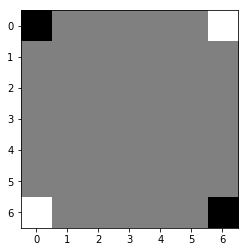

((6, 6), (5, 5)): n_v:  1149 q_all:+0.018477 q:+0.010921 q_m:+0.033333 p:0.488820
((0, 0), (1, 1)): n_v:  1046 q_all:+0.010084 q:+0.023609 q_m:+0.033333 p:0.507523
((6, 6), (6, 5)): n_v:     2 q_all:+0.018205 q:+0.012719 q_m:+0.033333 p:0.001042
((6, 6), (5, 6)): n_v:     1 q_all:+0.004843 q:+0.015417 q_m:+0.033333 p:0.000464
((0, 0), (0, 1)): n_v:     1 q_all:+0.006240 q:+0.010773 q_m:+0.033333 p:0.000982
((0, 0), (1, 0)): n_v:     1 q_all:+0.013182 q:+0.017473 q_m:+0.033333 p:0.000578
((6, 6), (6, 4)): n_v:     0 q_all:+0.000880 q:+0.000880 q_m:-0.000000 p:0.000019
((0, 0), (1, 2)): n_v:     0 q_all:-0.008863 q:-0.008863 q_m:-0.000000 p:0.000025
((0, 0), (2, 2)): n_v:     0 q_all:-0.003199 q:-0.003199 q_m:-0.000000 p:0.000094
((0, 0), (0, 2)): n_v:     0 q_all:-0.014918 q:-0.014918 q_m:-0.000000 p:0.000022
((6, 6), (4, 6)): n_v:     0 q_all:+0.009986 q:+0.009986 q_m:-0.000000 p:0.000072
((6, 6), (5, 4)): n_v:     0 q_all:+0.008297 q:+0.008297 q_m:-0.000000 p:0.000036
((6, 6), (4, 4))

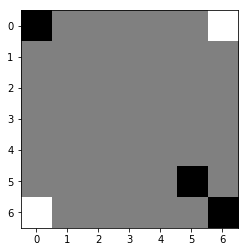

((6, 0), (5, 1)): n_v:  2052 q_all:-0.025856 q:-0.021549 q_m:-0.000000 p:0.618233
((0, 6), (1, 5)): n_v:  1129 q_all:-0.023575 q:-0.020202 q_m:-0.000000 p:0.325251
((6, 0), (5, 0)): n_v:    79 q_all:-0.025432 q:-0.029184 q_m:-0.000000 p:0.023892
((6, 0), (6, 1)): n_v:    42 q_all:-0.030000 q:-0.022152 q_m:-0.000000 p:0.013774
((0, 6), (1, 6)): n_v:    28 q_all:-0.029818 q:-0.027350 q_m:-0.000000 p:0.009372
((0, 6), (0, 5)): n_v:    14 q_all:-0.034383 q:-0.031074 q_m:-0.000000 p:0.004971
((6, 0), (4, 2)): n_v:     2 q_all:-0.046460 q:-0.056299 q_m:-0.033333 p:0.001235
((0, 6), (2, 4)): n_v:     1 q_all:-0.044482 q:-0.039287 q_m:-0.033333 p:0.000507
((6, 0), (6, 2)): n_v:     1 q_all:-0.048865 q:-0.047746 q_m:-0.033333 p:0.000808
((6, 0), (5, 2)): n_v:     1 q_all:-0.056331 q:-0.047926 q_m:-0.033333 p:0.000744
((6, 0), (4, 1)): n_v:     0 q_all:-0.033781 q:-0.033781 q_m:-0.033333 p:0.000259
((0, 6), (2, 6)): n_v:     0 q_all:-0.040334 q:-0.040334 q_m:-0.033333 p:0.000102
((0, 6), (0, 4))

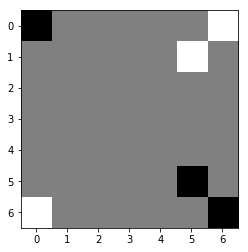

((0, 0), (1, 1)): n_v:  2476 q_all:+0.021522 q:+0.021359 q_m:+0.033333 p:0.734826
((5, 5), (4, 4)): n_v:   769 q_all:+0.020869 q:+0.013893 q_m:+0.033333 p:0.231237
((5, 5), (4, 5)): n_v:    50 q_all:+0.007748 q:-0.011499 q_m:+0.033333 p:0.018763
((5, 5), (5, 4)): n_v:    24 q_all:+0.008033 q:-0.003695 q_m:+0.033333 p:0.009268
((0, 0), (1, 0)): n_v:     3 q_all:+0.015640 q:+0.014612 q_m:+0.033333 p:0.001090
((5, 5), (4, 6)): n_v:     2 q_all:+0.008778 q:+0.002809 q_m:+0.033333 p:0.000872
((0, 0), (0, 1)): n_v:     2 q_all:+0.009425 q:+0.006957 q_m:+0.033333 p:0.000908
((5, 5), (6, 5)): n_v:     1 q_all:+0.003369 q:-0.006907 q_m:+0.033333 p:0.000575
((5, 5), (5, 6)): n_v:     1 q_all:+0.000375 q:-0.010208 q_m:+0.033333 p:0.000492
((5, 5), (6, 4)): n_v:     1 q_all:+0.000618 q:-0.008079 q_m:+0.033333 p:0.000583
((5, 5), (3, 6)): n_v:     0 q_all:+0.005110 q:+0.005110 q_m:-0.000000 p:0.000060
((5, 5), (5, 3)): n_v:     0 q_all:-0.002142 q:-0.002142 q_m:-0.000000 p:0.000006
((0, 0), (0, 2))

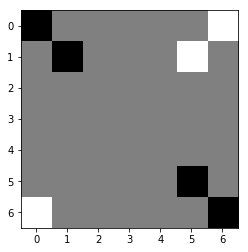

((1, 5), (2, 4)): n_v:  2994 q_all:-0.013300 q:-0.024848 q_m:-0.000000 p:0.632329
((1, 5), (1, 4)): n_v:   783 q_all:-0.020961 q:-0.029621 q_m:-0.000000 p:0.194766
((6, 0), (5, 1)): n_v:   355 q_all:-0.023842 q:-0.028879 q_m:-0.000000 p:0.093201
((1, 5), (2, 5)): n_v:   186 q_all:-0.018854 q:-0.038159 q_m:-0.000000 p:0.044474
((6, 0), (6, 1)): n_v:    15 q_all:-0.027335 q:-0.029359 q_m:-0.000000 p:0.004426
((0, 6), (1, 6)): n_v:    13 q_all:-0.027930 q:-0.028913 q_m:-0.000000 p:0.003822
((0, 6), (0, 5)): n_v:    13 q_all:-0.031437 q:-0.043975 q_m:-0.000000 p:0.004059
((1, 5), (0, 4)): n_v:    13 q_all:-0.023446 q:-0.034607 q_m:-0.000000 p:0.003469
((1, 5), (2, 6)): n_v:    11 q_all:-0.030427 q:-0.040627 q_m:-0.000000 p:0.003518
((6, 0), (5, 0)): n_v:    11 q_all:-0.022894 q:-0.036104 q_m:-0.000000 p:0.003061
((1, 5), (3, 3)): n_v:     0 q_all:-0.040184 q:-0.040184 q_m:-0.033333 p:0.000060
((1, 5), (0, 3)): n_v:     0 q_all:-0.050795 q:-0.050795 q_m:-0.033333 p:0.000205
((0, 6), (0, 4))

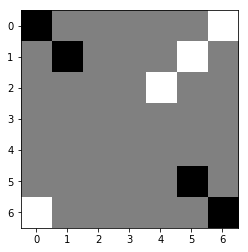

((1, 1), (2, 2)): n_v:  3010 q_all:+0.028359 q:+0.023813 q_m:+0.033333 p:0.574106
((5, 5), (4, 4)): n_v:   553 q_all:+0.023173 q:+0.018102 q_m:+0.033333 p:0.118869
((1, 1), (1, 2)): n_v:   449 q_all:+0.016097 q:-0.005627 q_m:+0.033333 p:0.111214
((5, 5), (3, 3)): n_v:   206 q_all:+0.024512 q:+0.027348 q_m:+0.066667 p:0.043083
((1, 1), (2, 1)): n_v:   164 q_all:+0.029973 q:+0.013239 q_m:+0.033333 p:0.030093
((5, 5), (4, 5)): n_v:   136 q_all:+0.016416 q:-0.008191 q_m:+0.033333 p:0.033635
((1, 1), (3, 3)): n_v:    52 q_all:+0.028713 q:+0.031409 q_m:+0.066667 p:0.009860
((5, 5), (5, 4)): n_v:    42 q_all:+0.019708 q:+0.004179 q_m:+0.033333 p:0.009751
((0, 0), (1, 0)): n_v:    36 q_all:+0.029406 q:+0.011208 q_m:+0.033333 p:0.006793
((0, 0), (0, 1)): n_v:    35 q_all:+0.031663 q:+0.018958 q_m:+0.033333 p:0.006132
((1, 1), (0, 2)): n_v:    33 q_all:+0.002225 q:-0.001548 q_m:+0.033333 p:0.010357
((5, 5), (3, 5)): n_v:    25 q_all:+0.003399 q:+0.031942 q_m:+0.066667 p:0.007601
((1, 1), (2, 0))

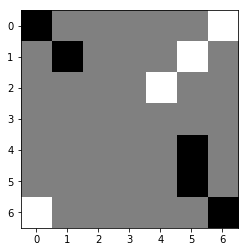

((2, 4), (3, 5)): n_v:  1676 q_all:-0.018869 q:-0.012638 q_m:+0.066667 p:0.696825
((2, 4), (1, 3)): n_v:   163 q_all:-0.009400 q:-0.028100 q_m:-0.000000 p:0.057016
((6, 0), (5, 1)): n_v:   155 q_all:-0.005135 q:-0.030655 q_m:-0.000000 p:0.049948
((2, 4), (4, 6)): n_v:   106 q_all:-0.056768 q:-0.023946 q_m:+0.100000 p:0.071987
((2, 4), (4, 4)): n_v:    73 q_all:-0.034476 q:-0.005862 q_m:+0.100000 p:0.038204
((2, 4), (3, 4)): n_v:    34 q_all:-0.012970 q:-0.016643 q_m:+0.066667 p:0.013035
((2, 4), (3, 3)): n_v:    20 q_all:-0.037434 q:-0.026268 q_m:-0.000000 p:0.011139
((2, 4), (1, 6)): n_v:    17 q_all:-0.036824 q:-0.055456 q_m:-0.033333 p:0.009096
((6, 0), (5, 0)): n_v:    12 q_all:-0.011104 q:-0.038537 q_m:-0.000000 p:0.004629
((2, 4), (2, 6)): n_v:     8 q_all:-0.052120 q:-0.063182 q_m:-0.033333 p:0.005730
((2, 4), (0, 5)): n_v:     5 q_all:-0.058483 q:-0.060428 q_m:-0.033333 p:0.004099
((2, 4), (3, 6)): n_v:     5 q_all:-0.016262 q:-0.017778 q_m:+0.033333 p:0.002350
((1, 5), (1, 4))

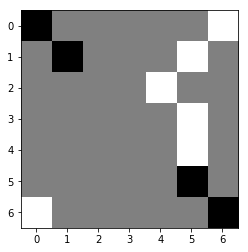

((5, 5), (3, 4)): n_v:  3743 q_all:+0.015177 q:+0.032293 q_m:+0.133333 p:0.960486
((5, 5), (4, 4)): n_v:    25 q_all:+0.005174 q:+0.027510 q_m:+0.100000 p:0.008012
((5, 5), (3, 6)): n_v:    24 q_all:-0.003648 q:+0.016319 q_m:+0.066667 p:0.008563
((5, 5), (4, 6)): n_v:    13 q_all:+0.006745 q:+0.013160 q_m:+0.100000 p:0.004154
((6, 6), (4, 6)): n_v:     7 q_all:-0.003970 q:+0.008568 q_m:+0.066667 p:0.002532
((1, 1), (3, 2)): n_v:     6 q_all:-0.054438 q:-0.045250 q_m:-0.066667 p:0.004068
((1, 1), (2, 2)): n_v:     5 q_all:-0.063261 q:-0.034385 q_m:-0.033333 p:0.003880
((5, 5), (3, 3)): n_v:     5 q_all:-0.003848 q:-0.007095 q_m:-0.000000 p:0.002009
((6, 6), (4, 4)): n_v:     3 q_all:-0.001145 q:+0.023503 q_m:+0.066667 p:0.001264
((5, 5), (5, 4)): n_v:     1 q_all:-0.015004 q:-0.010991 q_m:+0.033333 p:0.000493
((0, 0), (2, 0)): n_v:     1 q_all:-0.104101 q:-0.046617 q_m:-0.066667 p:0.000588
((5, 5), (6, 5)): n_v:     0 q_all:-0.040838 q:-0.040838 q_m:-0.033333 p:0.000079
((1, 1), (2, 0))

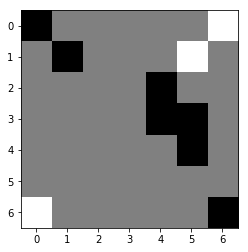

((1, 5), (2, 5)): n_v:  5748 q_all:-0.013457 q:-0.018690 q_m:+0.100000 p:0.948409
((0, 6), (2, 5)): n_v:    92 q_all:-0.027777 q:-0.028178 q_m:+0.066667 p:0.020962
((1, 5), (3, 3)): n_v:    19 q_all:-0.061470 q:-0.053556 q_m:-0.000000 p:0.007108
((1, 5), (2, 3)): n_v:    15 q_all:-0.072528 q:-0.047888 q_m:-0.000000 p:0.006069
((1, 5), (3, 6)): n_v:     8 q_all:-0.037568 q:-0.054818 q_m:-0.000000 p:0.002296
((1, 5), (1, 4)): n_v:     8 q_all:-0.082210 q:-0.053645 q_m:-0.033333 p:0.003791
((1, 5), (2, 6)): n_v:     7 q_all:-0.065590 q:-0.060588 q_m:-0.033333 p:0.002698
((6, 0), (5, 1)): n_v:     4 q_all:-0.104927 q:-0.066401 q_m:-0.100000 p:0.002579
((0, 6), (1, 6)): n_v:     1 q_all:-0.157737 q:-0.084967 q_m:-0.100000 p:0.000609
((6, 0), (4, 2)): n_v:     1 q_all:-0.140833 q:-0.107254 q_m:-0.133333 p:0.001262
((6, 0), (4, 1)): n_v:     1 q_all:-0.100708 q:-0.080498 q_m:-0.133333 p:0.000721
((1, 5), (0, 4)): n_v:     0 q_all:-0.076011 q:-0.076011 q_m:-0.100000 p:0.000389
((6, 0), (6, 2))

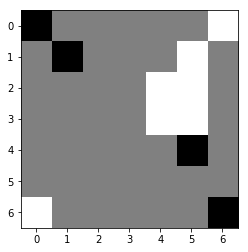

((4, 5), (2, 6)): n_v:  3909 q_all:+0.012224 q:+0.017677 q_m:+0.100000 p:0.578789
((4, 5), (4, 4)): n_v:  1423 q_all:+0.021698 q:+0.003594 q_m:+0.066667 p:0.160372
((1, 1), (2, 2)): n_v:   334 q_all:-0.011338 q:-0.016713 q_m:-0.066667 p:0.078995
((4, 5), (3, 3)): n_v:   216 q_all:+0.000508 q:+0.012315 q_m:+0.033333 p:0.041593
((4, 5), (2, 3)): n_v:   186 q_all:-0.005761 q:+0.005109 q_m:+0.033333 p:0.040193
((4, 5), (3, 6)): n_v:   181 q_all:+0.006536 q:+0.004780 q_m:+0.066667 p:0.030580
((1, 1), (1, 2)): n_v:    76 q_all:-0.028273 q:-0.040907 q_m:-0.066667 p:0.022935
((4, 5), (4, 3)): n_v:    27 q_all:-0.009535 q:-0.014914 q_m:-0.033333 p:0.006270
((4, 5), (4, 6)): n_v:    17 q_all:-0.025754 q:-0.019658 q_m:-0.000000 p:0.004972
((4, 5), (5, 4)): n_v:    16 q_all:-0.049124 q:-0.028008 q_m:-0.066667 p:0.006375
((6, 6), (4, 4)): n_v:     9 q_all:+0.002069 q:-0.010547 q_m:+0.033333 p:0.001678
((1, 1), (2, 3)): n_v:     7 q_all:-0.012983 q:-0.007489 q_m:+0.033333 p:0.001839
((0, 0), (2, 2))

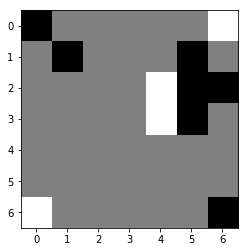

((0, 6), (1, 6)): n_v:  3885 q_all:-0.019313 q:-0.007920 q_m:+0.133333 p:0.798832
((2, 4), (1, 6)): n_v:   319 q_all:-0.025811 q:-0.027416 q_m:+0.100000 p:0.074413
((3, 4), (1, 6)): n_v:   295 q_all:-0.023928 q:-0.013023 q_m:+0.100000 p:0.066471
((3, 4), (5, 6)): n_v:   152 q_all:-0.021610 q:-0.025448 q_m:-0.033333 p:0.032742
((3, 4), (3, 6)): n_v:    76 q_all:-0.020917 q:-0.036507 q_m:+0.100000 p:0.016344
((2, 4), (1, 4)): n_v:    19 q_all:-0.032012 q:-0.044705 q_m:+0.066667 p:0.005097
((2, 4), (3, 6)): n_v:    10 q_all:-0.024579 q:-0.035568 q_m:+0.100000 p:0.002275
((6, 0), (5, 0)): n_v:     4 q_all:-0.031235 q:-0.057654 q_m:-0.066667 p:0.001176
((2, 4), (0, 5)): n_v:     1 q_all:-0.086941 q:-0.084298 q_m:-0.033333 p:0.000683
((3, 4), (5, 5)): n_v:     1 q_all:-0.030710 q:-0.021457 q_m:-0.033333 p:0.000386
((6, 0), (6, 2)): n_v:     0 q_all:-0.081351 q:-0.081351 q_m:-0.100000 p:0.000000
((2, 4), (1, 2)): n_v:     0 q_all:-0.050944 q:-0.050944 q_m:-0.033333 p:0.000065
((2, 4), (0, 4))

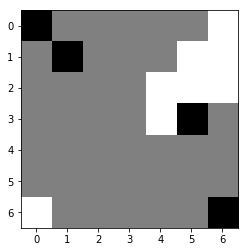

((3, 5), (3, 6)): n_v:  4812 q_all:+0.018516 q:+0.008515 q_m:+0.033333 p:0.906549
((1, 1), (1, 2)): n_v:    91 q_all:-0.029684 q:-0.040673 q_m:-0.100000 p:0.036058
((3, 5), (1, 4)): n_v:    56 q_all:+0.014585 q:+0.005602 q_m:+0.066667 p:0.011314
((3, 5), (5, 6)): n_v:    29 q_all:-0.070973 q:-0.029719 q_m:-0.133333 p:0.017120
((3, 5), (5, 4)): n_v:     9 q_all:-0.081365 q:-0.037960 q_m:-0.133333 p:0.005989
((3, 5), (3, 3)): n_v:     8 q_all:-0.011536 q:-0.003185 q_m:-0.000000 p:0.002802
((3, 5), (2, 3)): n_v:     8 q_all:-0.013499 q:-0.012582 q_m:-0.000000 p:0.002743
((3, 5), (4, 5)): n_v:     7 q_all:-0.014824 q:-0.013097 q_m:-0.033333 p:0.002529
((1, 1), (2, 2)): n_v:     3 q_all:-0.019801 q:-0.010700 q_m:-0.100000 p:0.001355
((1, 1), (2, 1)): n_v:     3 q_all:-0.023638 q:-0.023259 q_m:-0.100000 p:0.001431
((3, 5), (4, 3)): n_v:     3 q_all:-0.013490 q:-0.017322 q_m:-0.066667 p:0.001256
((1, 1), (3, 0)): n_v:     2 q_all:-0.062386 q:-0.030158 q_m:-0.133333 p:0.000999
((3, 5), (1, 3))

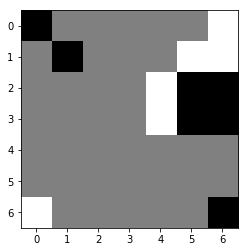

((3, 4), (4, 5)): n_v:  2838 q_all:-0.023588 q:-0.043745 q_m:+0.133333 p:0.503922
((3, 4), (5, 6)): n_v:  1067 q_all:-0.008873 q:-0.020929 q_m:+0.033333 p:0.125962
((3, 4), (5, 5)): n_v:   845 q_all:-0.003950 q:-0.014058 q_m:+0.033333 p:0.083071
((1, 5), (1, 4)): n_v:   321 q_all:-0.025521 q:-0.028667 q_m:+0.066667 p:0.059588
((2, 4), (0, 5)): n_v:   190 q_all:-0.043510 q:-0.071109 q_m:-0.033333 p:0.049195
((3, 4), (4, 6)): n_v:   127 q_all:-0.021947 q:-0.032053 q_m:+0.100000 p:0.021801
((2, 4), (4, 5)): n_v:    74 q_all:-0.037948 q:-0.063503 q_m:+0.100000 p:0.017656
((2, 4), (1, 3)): n_v:    37 q_all:-0.035463 q:-0.043958 q_m:-0.000000 p:0.008527
((3, 4), (1, 4)): n_v:    37 q_all:-0.041739 q:-0.044078 q_m:+0.033333 p:0.009388
((3, 4), (2, 2)): n_v:    36 q_all:+0.010479 q:-0.009525 q_m:+0.033333 p:0.001285
((2, 4), (2, 3)): n_v:    36 q_all:-0.039451 q:-0.038001 q_m:-0.000000 p:0.008644
((6, 0), (5, 1)): n_v:    36 q_all:-0.030638 q:-0.031096 q_m:-0.000000 p:0.007606
((2, 4), (4, 6))

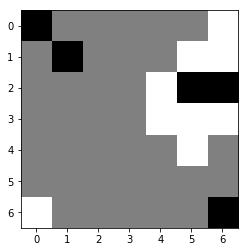

((6, 6), (4, 6)): n_v:  2230 q_all:+0.014355 q:+0.016626 q_m:+0.066667 p:0.492308
((2, 6), (0, 5)): n_v:   386 q_all:+0.016295 q:+0.005508 q_m:+0.066667 p:0.081745
((6, 6), (4, 4)): n_v:   255 q_all:+0.013406 q:-0.008068 q_m:+0.066667 p:0.057575
((2, 6), (4, 4)): n_v:   231 q_all:+0.007439 q:-0.008016 q_m:+0.066667 p:0.058700
((2, 5), (1, 4)): n_v:   203 q_all:+0.008101 q:-0.004046 q_m:+0.033333 p:0.051063
((1, 1), (1, 2)): n_v:   178 q_all:-0.008764 q:-0.036993 q_m:-0.100000 p:0.058949
((2, 5), (0, 5)): n_v:   149 q_all:+0.010033 q:+0.021646 q_m:+0.066667 p:0.036051
((6, 6), (5, 5)): n_v:    90 q_all:-0.007072 q:-0.011981 q_m:-0.033333 p:0.029250
((1, 1), (2, 2)): n_v:    61 q_all:-0.008530 q:-0.006402 q_m:-0.100000 p:0.020114
((0, 0), (2, 0)): n_v:    57 q_all:-0.015784 q:-0.020607 q_m:-0.133333 p:0.021069
((0, 0), (0, 1)): n_v:    37 q_all:-0.007635 q:-0.011024 q_m:-0.100000 p:0.012020
((6, 6), (6, 5)): n_v:    16 q_all:-0.023390 q:-0.018061 q_m:-0.100000 p:0.006777
((2, 5), (4, 6))

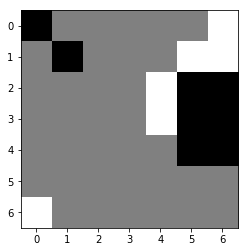

((3, 4), (5, 5)): n_v:  2002 q_all:-0.017343 q:-0.034028 q_m:+0.066667 p:0.575261
((3, 4), (5, 6)): n_v:  1555 q_all:-0.001593 q:-0.012945 q_m:+0.066667 p:0.323998
((3, 4), (1, 4)): n_v:    50 q_all:-0.058226 q:-0.061910 q_m:-0.000000 p:0.024824
((3, 4), (4, 4)): n_v:    42 q_all:-0.023822 q:-0.063255 q_m:+0.100000 p:0.013588
((3, 4), (5, 4)): n_v:    37 q_all:-0.047292 q:-0.043308 q_m:-0.000000 p:0.016156
((2, 4), (4, 4)): n_v:    31 q_all:-0.046864 q:-0.092542 q_m:+0.066667 p:0.013682
((6, 0), (5, 1)): n_v:    18 q_all:-0.035625 q:-0.056169 q_m:-0.033333 p:0.007133
((2, 4), (0, 5)): n_v:    10 q_all:-0.054419 q:-0.079312 q_m:-0.066667 p:0.004729
((6, 0), (5, 0)): n_v:     9 q_all:-0.036413 q:-0.064805 q_m:-0.033333 p:0.003466
((3, 4), (2, 2)): n_v:     5 q_all:-0.021297 q:-0.022659 q_m:-0.000000 p:0.001716
((3, 4), (4, 2)): n_v:     3 q_all:-0.054983 q:-0.077405 q_m:-0.066667 p:0.001613
((2, 4), (4, 2)): n_v:     3 q_all:-0.070887 q:-0.096402 q_m:-0.066667 p:0.001797
((1, 5), (1, 4))

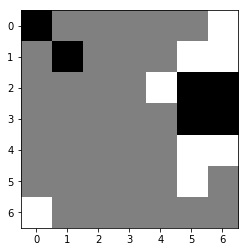

((2, 5), (3, 4)): n_v:  2397 q_all:+0.027955 q:+0.009944 q_m:+0.100000 p:0.295693
((2, 5), (1, 4)): n_v:   930 q_all:+0.015912 q:-0.000254 q_m:+0.100000 p:0.172403
((1, 1), (1, 2)): n_v:   132 q_all:-0.003254 q:-0.058342 q_m:-0.033333 p:0.037750
((2, 6), (0, 5)): n_v:   107 q_all:-0.023990 q:+0.001781 q_m:+0.133333 p:0.041711
((3, 5), (5, 6)): n_v:    76 q_all:-0.017572 q:+0.025131 q_m:+0.133333 p:0.027413
((3, 6), (5, 6)): n_v:    54 q_all:-0.007913 q:+0.032226 q_m:+0.133333 p:0.016572
((0, 0), (0, 1)): n_v:    49 q_all:+0.004578 q:-0.027521 q_m:-0.033333 p:0.012082
((3, 6), (5, 4)): n_v:    35 q_all:-0.026649 q:-0.006074 q_m:+0.066667 p:0.014310
((3, 6), (1, 4)): n_v:    30 q_all:-0.017364 q:-0.021118 q_m:+0.066667 p:0.010926
((3, 5), (5, 4)): n_v:    23 q_all:-0.040485 q:-0.016658 q_m:+0.066667 p:0.011255
((0, 0), (1, 2)): n_v:    22 q_all:-0.026745 q:-0.050392 q_m:-0.066667 p:0.009063
((3, 5), (4, 4)): n_v:    19 q_all:-0.009194 q:-0.001416 q_m:+0.100000 p:0.005880
((2, 6), (1, 4))

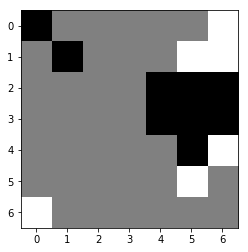

((1, 5), (1, 4)): n_v:  2278 q_all:-0.033246 q:-0.027771 q_m:+0.066667 p:0.501554
((5, 5), (4, 4)): n_v:  1547 q_all:-0.035458 q:-0.027334 q_m:+0.133333 p:0.357556
((0, 6), (1, 4)): n_v:   113 q_all:-0.037299 q:-0.032409 q_m:+0.033333 p:0.027344
((5, 5), (5, 4)): n_v:   110 q_all:-0.071298 q:-0.060735 q_m:-0.000000 p:0.045130
((4, 6), (4, 4)): n_v:   100 q_all:-0.029942 q:-0.043605 q_m:+0.100000 p:0.020266
((1, 6), (1, 4)): n_v:    54 q_all:-0.029828 q:-0.043830 q_m:+0.033333 p:0.011083
((5, 5), (3, 3)): n_v:    27 q_all:-0.003265 q:-0.030283 q_m:+0.033333 p:0.001941
((1, 5), (2, 3)): n_v:    14 q_all:-0.050820 q:-0.043153 q_m:+0.033333 p:0.004421
((6, 0), (4, 2)): n_v:    10 q_all:-0.137279 q:-0.130867 q_m:-0.100000 p:0.007933
((4, 6), (5, 6)): n_v:    10 q_all:-0.080700 q:-0.040498 q_m:-0.000000 p:0.004674
((4, 6), (5, 4)): n_v:     4 q_all:-0.089315 q:-0.053893 q_m:-0.033333 p:0.002381
((6, 0), (5, 1)): n_v:     3 q_all:-0.126826 q:-0.088609 q_m:-0.066667 p:0.002279
((1, 5), (3, 3))

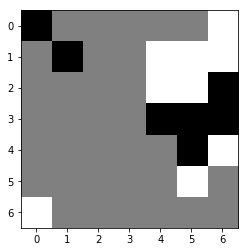

((4, 5), (5, 6)): n_v:  2204 q_all:+0.037979 q:+0.047799 q_m:+0.100000 p:0.425741
((3, 4), (2, 3)): n_v:  1014 q_all:+0.041964 q:+0.005881 q_m:+0.100000 p:0.175680
((2, 6), (0, 5)): n_v:   627 q_all:+0.009206 q:+0.016344 q_m:+0.200000 p:0.211241
((3, 4), (5, 6)): n_v:   105 q_all:+0.034274 q:+0.036054 q_m:+0.066667 p:0.022429
((0, 0), (1, 0)): n_v:    89 q_all:-0.029642 q:-0.056829 q_m:-0.033333 p:0.047648
((3, 4), (4, 3)): n_v:    49 q_all:-0.045440 q:-0.058607 q_m:-0.033333 p:0.029598
((0, 0), (0, 1)): n_v:    21 q_all:-0.021429 q:-0.044597 q_m:-0.033333 p:0.010479
((4, 5), (6, 5)): n_v:    15 q_all:-0.022426 q:-0.020249 q_m:-0.000000 p:0.007815
((3, 5), (5, 6)): n_v:    13 q_all:-0.056577 q:+0.000443 q_m:+0.066667 p:0.009098
((2, 6), (0, 4)): n_v:     9 q_all:-0.020962 q:-0.036850 q_m:+0.066667 p:0.004704
((3, 4), (1, 3)): n_v:     8 q_all:+0.019536 q:+0.005853 q_m:+0.066667 p:0.002514
((3, 6), (5, 6)): n_v:     5 q_all:-0.043073 q:+0.005646 q_m:+0.066667 p:0.002815
((3, 4), (3, 3))

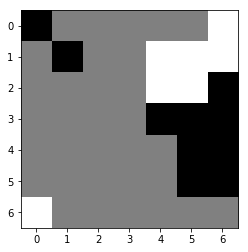

((2, 4), (4, 4)): n_v:  3619 q_all:-0.013811 q:-0.047439 q_m:+0.166667 p:0.738077
((2, 5), (4, 4)): n_v:   199 q_all:-0.081894 q:-0.038475 q_m:+0.166667 p:0.108546
((2, 4), (4, 2)): n_v:    55 q_all:-0.138071 q:-0.150930 q_m:-0.100000 p:0.045872
((0, 6), (0, 5)): n_v:    20 q_all:-0.061948 q:-0.078070 q_m:-0.066667 p:0.008925
((6, 0), (5, 1)): n_v:    15 q_all:-0.087403 q:-0.100535 q_m:-0.066667 p:0.008736
((2, 4), (0, 5)): n_v:    11 q_all:-0.113416 q:-0.092746 q_m:-0.100000 p:0.008348
((1, 4), (2, 3)): n_v:    11 q_all:-0.081253 q:-0.048142 q_m:-0.000000 p:0.006104
((2, 4), (4, 3)): n_v:     9 q_all:-0.105920 q:-0.092780 q_m:-0.033333 p:0.006612
((6, 0), (4, 2)): n_v:     8 q_all:-0.107176 q:-0.147124 q_m:-0.100000 p:0.005824
((2, 4), (2, 2)): n_v:     6 q_all:-0.070874 q:-0.081651 q_m:-0.033333 p:0.003350
((2, 4), (3, 3)): n_v:     5 q_all:-0.083532 q:-0.049607 q_m:-0.000000 p:0.002779
((6, 0), (6, 1)): n_v:     3 q_all:-0.082188 q:-0.104689 q_m:-0.066667 p:0.002146
((1, 4), (2, 2))

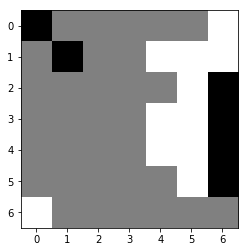

((2, 6), (0, 5)): n_v:  1451 q_all:+0.042712 q:+0.049909 q_m:+0.100000 p:0.101533
((1, 1), (2, 2)): n_v:  1266 q_all:-0.002531 q:+0.022438 q_m:-0.133333 p:0.343321
((4, 6), (2, 4)): n_v:   951 q_all:+0.029788 q:+0.010469 q_m:+0.166667 p:0.121342
((5, 6), (6, 5)): n_v:   320 q_all:-0.014027 q:-0.016600 q_m:-0.066667 p:0.103112
((5, 6), (5, 4)): n_v:   296 q_all:+0.003382 q:+0.021503 q_m:+0.033333 p:0.072546
((2, 6), (2, 4)): n_v:   225 q_all:+0.029861 q:+0.014614 q_m:+0.166667 p:0.029111
((0, 0), (0, 1)): n_v:   100 q_all:-0.005973 q:+0.000404 q_m:-0.133333 p:0.028691
((0, 0), (2, 2)): n_v:    99 q_all:-0.036821 q:+0.004377 q_m:-0.166667 p:0.042263
((4, 6), (5, 4)): n_v:    79 q_all:-0.009770 q:+0.014793 q_m:+0.033333 p:0.023839
((4, 6), (6, 5)): n_v:    76 q_all:-0.039394 q:-0.049223 q_m:-0.100000 p:0.033291
((1, 1), (1, 2)): n_v:    76 q_all:-0.007524 q:-0.014510 q_m:-0.133333 p:0.022369
((3, 6), (2, 4)): n_v:    27 q_all:+0.003100 q:+0.014978 q_m:+0.166667 p:0.006621
((5, 6), (6, 6))

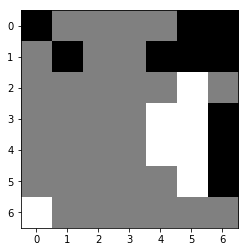

((3, 4), (2, 6)): n_v:  1402 q_all:-0.013269 q:-0.033405 q_m:+0.100000 p:0.154189
((2, 5), (2, 6)): n_v:  1282 q_all:-0.030585 q:-0.014443 q_m:+0.133333 p:0.263756
((2, 5), (0, 4)): n_v:   320 q_all:-0.023656 q:-0.041937 q_m:+0.100000 p:0.053769
((4, 4), (2, 6)): n_v:   230 q_all:-0.045874 q:-0.021848 q_m:+0.100000 p:0.066850
((4, 5), (2, 6)): n_v:    96 q_all:-0.072936 q:-0.032267 q_m:+0.100000 p:0.042495
((4, 4), (6, 6)): n_v:    79 q_all:-0.062018 q:-0.109793 q_m:-0.033333 p:0.030046
((4, 5), (6, 6)): n_v:    61 q_all:-0.105637 q:-0.098588 q_m:-0.033333 p:0.037854
((4, 5), (6, 4)): n_v:    10 q_all:-0.100879 q:-0.111605 q_m:-0.100000 p:0.006224
((4, 4), (6, 5)): n_v:     5 q_all:-0.054230 q:-0.088763 q_m:-0.033333 p:0.001887
((4, 4), (6, 4)): n_v:     4 q_all:-0.092876 q:-0.126657 q_m:-0.100000 p:0.002659
((4, 4), (2, 4)): n_v:     4 q_all:-0.059937 q:-0.054648 q_m:+0.033333 p:0.001811
((5, 5), (6, 6)): n_v:     3 q_all:-0.038392 q:-0.077387 q_m:-0.000000 p:0.000805
((2, 5), (2, 4))

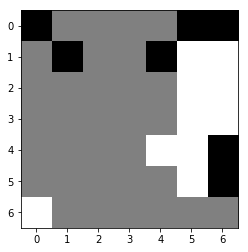

((5, 6), (5, 4)): n_v:   873 q_all:+0.031311 q:+0.043820 q_m:+0.100000 p:0.185471
((1, 4), (2, 4)): n_v:   398 q_all:+0.020611 q:+0.057971 q_m:+0.133333 p:0.108874
((4, 6), (2, 4)): n_v:   308 q_all:+0.030693 q:+0.036906 q_m:+0.100000 p:0.066629
((1, 4), (3, 4)): n_v:   307 q_all:+0.025345 q:+0.019781 q_m:+0.166667 p:0.075936
((5, 6), (3, 4)): n_v:   292 q_all:-0.003271 q:+0.023362 q_m:+0.166667 p:0.120103
((4, 6), (5, 4)): n_v:   204 q_all:+0.013822 q:+0.035613 q_m:+0.100000 p:0.063791
((0, 5), (0, 4)): n_v:   201 q_all:+0.039820 q:+0.038312 q_m:-0.000000 p:0.032975
((4, 6), (3, 4)): n_v:   193 q_all:+0.016320 q:+0.012443 q_m:+0.166667 p:0.057672
((1, 1), (2, 2)): n_v:   129 q_all:+0.012540 q:+0.025553 q_m:-0.066667 p:0.041480
((1, 1), (1, 2)): n_v:    80 q_all:-0.006529 q:-0.001248 q_m:-0.066667 p:0.034246
((1, 4), (3, 2)): n_v:    71 q_all:-0.036463 q:-0.049293 q_m:-0.100000 p:0.043143
((1, 1), (3, 2)): n_v:    63 q_all:-0.019689 q:-0.003903 q_m:-0.100000 p:0.031907
((5, 6), (6, 6))

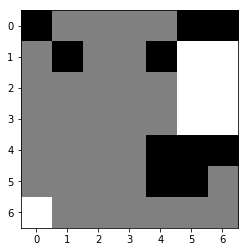

((1, 5), (0, 4)): n_v:  1740 q_all:-0.022432 q:+0.003778 q_m:+0.066667 p:0.235155
((2, 5), (3, 4)): n_v:   922 q_all:-0.045855 q:-0.015780 q_m:+0.066667 p:0.254415
((3, 5), (5, 6)): n_v:   102 q_all:-0.071553 q:-0.017891 q_m:+0.100000 p:0.044020
((2, 6), (0, 4)): n_v:    59 q_all:-0.092453 q:-0.033407 q_m:+0.033333 p:0.033019
((3, 6), (5, 6)): n_v:    48 q_all:-0.065138 q:-0.033311 q_m:+0.100000 p:0.018863
((1, 6), (3, 4)): n_v:    25 q_all:-0.062564 q:-0.058371 q_m:+0.033333 p:0.009351
((1, 5), (2, 4)): n_v:    24 q_all:-0.057334 q:-0.045814 q_m:-0.000000 p:0.008498
((3, 5), (1, 3)): n_v:    16 q_all:-0.084747 q:-0.077712 q_m:-0.033333 p:0.008525
((3, 5), (2, 3)): n_v:    16 q_all:-0.069827 q:-0.059730 q_m:-0.033333 p:0.006949
((1, 6), (0, 4)): n_v:    11 q_all:-0.043466 q:-0.046821 q_m:+0.033333 p:0.003114
((6, 0), (5, 0)): n_v:     9 q_all:-0.072048 q:-0.072750 q_m:-0.066667 p:0.004088
((2, 6), (3, 4)): n_v:     8 q_all:-0.097661 q:-0.056924 q_m:+0.033333 p:0.004448
((2, 5), (0, 4))

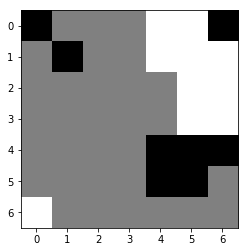

((4, 4), (2, 4)): n_v:  3162 q_all:+0.026344 q:+0.012652 q_m:+0.200000 p:0.675220
((4, 5), (2, 4)): n_v:   358 q_all:-0.017959 q:+0.025641 q_m:+0.200000 p:0.161080
((4, 6), (2, 4)): n_v:   144 q_all:+0.012280 q:+0.005871 q_m:+0.200000 p:0.041442
((4, 4), (2, 2)): n_v:    41 q_all:-0.035382 q:-0.057989 q_m:-0.066667 p:0.022619
((1, 1), (2, 2)): n_v:    38 q_all:-0.014816 q:-0.030771 q_m:-0.033333 p:0.016511
((0, 6), (2, 4)): n_v:    36 q_all:+0.003737 q:+0.000850 q_m:+0.200000 p:0.011919
((4, 4), (3, 4)): n_v:    19 q_all:-0.057637 q:-0.021825 q_m:+0.100000 p:0.012669
((4, 4), (5, 3)): n_v:    10 q_all:-0.032753 q:-0.061557 q_m:-0.033333 p:0.005378
((5, 4), (3, 4)): n_v:     6 q_all:-0.069541 q:-0.041611 q_m:+0.066667 p:0.004885
((0, 0), (2, 2)): n_v:     6 q_all:-0.033968 q:-0.046999 q_m:-0.066667 p:0.003671
((4, 4), (2, 3)): n_v:     5 q_all:-0.037114 q:-0.024172 q_m:-0.000000 p:0.003096
((4, 4), (4, 2)): n_v:     5 q_all:-0.047759 q:-0.078804 q_m:-0.066667 p:0.003481
((5, 4), (4, 2))

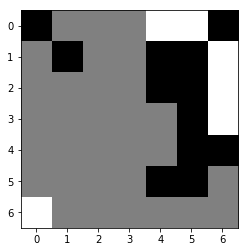

((0, 4), (1, 3)): n_v:  3607 q_all:-0.025333 q:-0.025598 q_m:-0.033333 p:0.587744
((3, 6), (4, 4)): n_v:   442 q_all:-0.034000 q:-0.035557 q_m:+0.066667 p:0.089550
((0, 5), (1, 3)): n_v:   301 q_all:-0.068106 q:-0.097074 q_m:-0.066667 p:0.107867
((1, 6), (3, 4)): n_v:   205 q_all:-0.050642 q:-0.075471 q_m:+0.066667 p:0.056737
((2, 6), (4, 4)): n_v:   158 q_all:-0.043789 q:-0.034882 q_m:+0.066667 p:0.038951
((0, 4), (2, 2)): n_v:   112 q_all:-0.051665 q:-0.065175 q_m:-0.133333 p:0.031585
((2, 6), (3, 4)): n_v:    87 q_all:-0.052101 q:-0.058415 q_m:+0.066667 p:0.024376
((3, 6), (3, 4)): n_v:    84 q_all:-0.045601 q:-0.057773 q_m:+0.066667 p:0.021456
((3, 6), (5, 6)): n_v:    29 q_all:-0.041398 q:-0.014308 q_m:-0.000000 p:0.006782
((6, 0), (4, 2)): n_v:    25 q_all:-0.097648 q:-0.133099 q_m:-0.200000 p:0.012542
((0, 4), (1, 2)): n_v:    16 q_all:-0.062726 q:-0.077370 q_m:-0.133333 p:0.005486
((0, 4), (2, 3)): n_v:    15 q_all:-0.028248 q:-0.056790 q_m:-0.066667 p:0.002651
((6, 0), (5, 1))

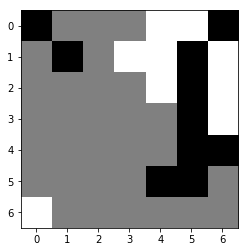

((1, 1), (0, 3)): n_v:  2738 q_all:+0.039638 q:+0.033566 q_m:+0.233333 p:0.271151
((2, 5), (0, 3)): n_v:   615 q_all:+0.026408 q:+0.041886 q_m:+0.233333 p:0.096509
((1, 5), (0, 3)): n_v:   526 q_all:-0.035305 q:-0.001773 q_m:+0.233333 p:0.224625
((1, 1), (2, 3)): n_v:   408 q_all:+0.003785 q:+0.011948 q_m:+0.233333 p:0.104386
((1, 5), (2, 3)): n_v:   177 q_all:-0.038792 q:-0.018205 q_m:+0.233333 p:0.078513
((4, 5), (2, 3)): n_v:   160 q_all:+0.005701 q:+0.032833 q_m:+0.233333 p:0.039724
((3, 5), (2, 3)): n_v:   159 q_all:+0.004904 q:+0.025300 q_m:+0.233333 p:0.040006
((4, 5), (6, 3)): n_v:    80 q_all:-0.051340 q:-0.013999 q_m:+0.033333 p:0.039645
((5, 4), (4, 3)): n_v:    52 q_all:-0.034192 q:-0.040803 q_m:+0.066667 p:0.021945
((2, 5), (2, 3)): n_v:    35 q_all:-0.006924 q:+0.013372 q_m:+0.233333 p:0.010770
((2, 5), (4, 3)): n_v:    29 q_all:-0.041099 q:-0.035134 q_m:+0.033333 p:0.013528
((5, 5), (6, 3)): n_v:    23 q_all:-0.030067 q:-0.034364 q_m:+0.033333 p:0.009540
((3, 5), (4, 3))

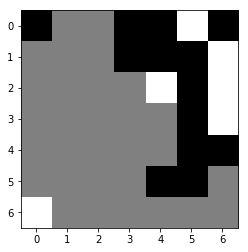

((2, 4), (4, 4)): n_v:  2652 q_all:-0.013433 q:-0.036037 q_m:+0.033333 p:0.388546
((2, 4), (2, 3)): n_v:   390 q_all:-0.035926 q:-0.059391 q_m:-0.066667 p:0.099460
((2, 4), (3, 4)): n_v:   353 q_all:-0.033229 q:-0.058646 q_m:-0.000000 p:0.085343
((2, 4), (4, 2)): n_v:   230 q_all:-0.085860 q:-0.176658 q_m:-0.233333 p:0.114316
((2, 4), (4, 3)): n_v:   161 q_all:-0.060906 q:-0.087465 q_m:-0.166667 p:0.060418
((2, 4), (2, 2)): n_v:   153 q_all:-0.068845 q:-0.078863 q_m:-0.166667 p:0.063595
((2, 4), (1, 2)): n_v:    93 q_all:-0.063145 q:-0.040752 q_m:-0.100000 p:0.036018
((3, 6), (4, 4)): n_v:    89 q_all:-0.061689 q:-0.071884 q_m:+0.033333 p:0.034026
((3, 6), (5, 6)): n_v:    86 q_all:-0.076330 q:-0.059965 q_m:-0.033333 p:0.039053
((2, 4), (0, 2)): n_v:    74 q_all:-0.061575 q:-0.060933 q_m:-0.100000 p:0.027994
((2, 4), (3, 2)): n_v:    25 q_all:-0.100312 q:-0.140022 q_m:-0.233333 p:0.014294
((2, 6), (4, 4)): n_v:    24 q_all:-0.081051 q:-0.070150 q_m:+0.033333 p:0.011524
((3, 6), (3, 4))

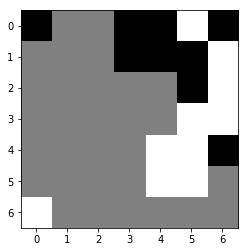

((2, 5), (3, 4)): n_v:  3079 q_all:+0.010661 q:+0.016995 q_m:+0.200000 p:0.657836
((4, 6), (3, 4)): n_v:   291 q_all:-0.001349 q:-0.004492 q_m:+0.166667 p:0.079041
((4, 6), (5, 6)): n_v:   207 q_all:+0.012559 q:+0.039619 q_m:+0.133333 p:0.042307
((2, 5), (4, 3)): n_v:   166 q_all:+0.046573 q:+0.053652 q_m:+0.100000 p:0.006215
((4, 6), (6, 4)): n_v:   133 q_all:-0.017982 q:+0.016596 q_m:+0.100000 p:0.047347
((2, 5), (3, 3)): n_v:    89 q_all:+0.034027 q:+0.041842 q_m:+0.033333 p:0.008667
((1, 4), (3, 4)): n_v:    48 q_all:-0.030409 q:+0.000274 q_m:+0.166667 p:0.020073
((0, 0), (1, 1)): n_v:    25 q_all:-0.043678 q:-0.002680 q_m:-0.000000 p:0.012249
((0, 3), (0, 2)): n_v:    17 q_all:-0.062485 q:-0.017901 q_m:-0.000000 p:0.010067
((4, 6), (2, 4)): n_v:    17 q_all:-0.054014 q:-0.032224 q_m:+0.033333 p:0.009502
((1, 3), (2, 3)): n_v:    16 q_all:-0.078903 q:-0.008339 q_m:-0.000000 p:0.010303
((1, 3), (3, 4)): n_v:    15 q_all:+0.015355 q:+0.014478 q_m:+0.166667 p:0.002939
((4, 6), (6, 5))

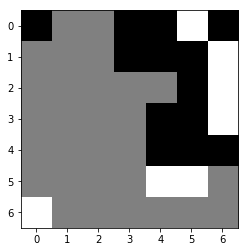

((5, 5), (5, 6)): n_v:  1214 q_all:+0.014914 q:-0.008378 q_m:-0.033333 p:0.133348
((0, 5), (2, 4)): n_v:   986 q_all:-0.001892 q:+0.020437 q_m:+0.200000 p:0.185638
((3, 6), (2, 4)): n_v:   804 q_all:-0.007900 q:-0.000643 q_m:+0.200000 p:0.173997
((1, 6), (2, 4)): n_v:   383 q_all:-0.053224 q:-0.037146 q_m:+0.200000 p:0.164162
((5, 4), (4, 3)): n_v:   284 q_all:-0.019944 q:-0.023708 q_m:-0.033333 p:0.077549
((2, 6), (2, 4)): n_v:   272 q_all:-0.050518 q:-0.025770 q_m:+0.200000 p:0.113510
((5, 4), (3, 3)): n_v:   256 q_all:-0.006256 q:-0.057516 q_m:-0.066667 p:0.053573
((5, 4), (5, 6)): n_v:    87 q_all:-0.005852 q:-0.018198 q_m:-0.066667 p:0.017948
((6, 0), (5, 0)): n_v:    80 q_all:-0.018982 q:-0.066811 q_m:-0.166667 p:0.021505
((6, 0), (4, 2)): n_v:    58 q_all:-0.049978 q:-0.098758 q_m:-0.200000 p:0.024275
((5, 4), (4, 2)): n_v:    33 q_all:-0.029196 q:-0.102616 q_m:-0.200000 p:0.010479
((0, 5), (2, 3)): n_v:    22 q_all:-0.026836 q:-0.040430 q_m:-0.000000 p:0.006654
((5, 5), (3, 3))

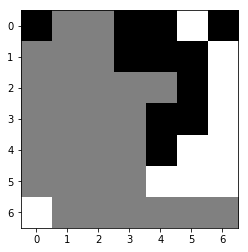

((4, 4), (6, 5)): n_v:  2134 q_all:-0.014275 q:+0.020022 q_m:+0.233333 p:0.525482
((4, 4), (6, 6)): n_v:   416 q_all:-0.034099 q:-0.021771 q_m:+0.166667 p:0.150986
((1, 3), (0, 1)): n_v:   166 q_all:-0.048145 q:-0.076690 q_m:+0.033333 p:0.074268
((0, 3), (0, 1)): n_v:    58 q_all:-0.078801 q:-0.098329 q_m:+0.033333 p:0.036788
((0, 0), (0, 1)): n_v:    49 q_all:-0.058089 q:-0.087568 q_m:+0.066667 p:0.025022
((0, 3), (1, 1)): n_v:    30 q_all:-0.079722 q:-0.093077 q_m:+0.033333 p:0.018913
((1, 3), (1, 1)): n_v:    27 q_all:-0.047897 q:-0.081787 q_m:+0.033333 p:0.011918
((4, 4), (6, 4)): n_v:    26 q_all:-0.031379 q:-0.016479 q_m:+0.166667 p:0.009075
((0, 3), (0, 2)): n_v:    24 q_all:-0.063588 q:-0.099582 q_m:+0.066667 p:0.013284
((0, 3), (2, 1)): n_v:    18 q_all:-0.074842 q:-0.093236 q_m:+0.033333 p:0.010986
((0, 0), (1, 1)): n_v:    18 q_all:-0.069127 q:-0.076260 q_m:+0.066667 p:0.010432
((4, 4), (2, 4)): n_v:    17 q_all:-0.021344 q:-0.077295 q_m:+0.033333 p:0.005060
((4, 4), (5, 3))

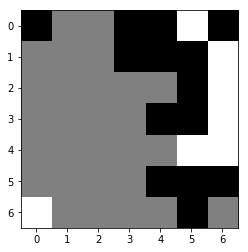

((4, 5), (4, 4)): n_v:  3809 q_all:+0.035795 q:+0.008475 q_m:+0.066667 p:0.888671
((4, 6), (2, 4)): n_v:   193 q_all:+0.062400 q:+0.070065 q_m:+0.166667 p:0.018579
((0, 5), (2, 4)): n_v:    42 q_all:+0.005209 q:+0.043059 q_m:+0.166667 p:0.016483
((1, 6), (2, 4)): n_v:    39 q_all:-0.057977 q:-0.012687 q_m:+0.166667 p:0.027110
((4, 5), (2, 4)): n_v:    23 q_all:+0.010298 q:+0.076007 q_m:+0.166667 p:0.008058
((2, 6), (2, 4)): n_v:    19 q_all:-0.009828 q:+0.000422 q_m:+0.166667 p:0.008963
((3, 6), (2, 4)): n_v:    18 q_all:-0.016741 q:+0.013789 q_m:+0.166667 p:0.009189
((2, 6), (4, 4)): n_v:    13 q_all:-0.046431 q:-0.045646 q_m:+0.033333 p:0.008919
((3, 6), (4, 4)): n_v:     7 q_all:-0.065664 q:-0.056393 q_m:+0.033333 p:0.005511
((6, 0), (4, 2)): n_v:     7 q_all:-0.052195 q:-0.085377 q_m:-0.233333 p:0.005096
((4, 6), (4, 4)): n_v:     3 q_all:-0.043888 q:-0.038849 q_m:+0.033333 p:0.002210
((4, 6), (6, 4)): n_v:     1 q_all:-0.031529 q:-0.019596 q_m:-0.033333 p:0.000709
((4, 6), (6, 6))

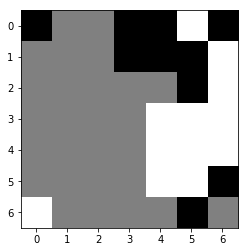

((2, 5), (4, 3)): n_v:  3287 q_all:+0.024502 q:+0.019470 q_m:+0.133333 p:0.018738
((6, 5), (6, 4)): n_v:  1293 q_all:-0.063537 q:-0.022335 q_m:+0.100000 p:0.431879
((2, 5), (3, 3)): n_v:   408 q_all:-0.004921 q:+0.019538 q_m:+0.066667 p:0.007069
((5, 6), (6, 6)): n_v:   148 q_all:-0.078760 q:-0.035998 q_m:+0.033333 p:0.061408
((1, 3), (2, 4)): n_v:   146 q_all:-0.046505 q:-0.013836 q_m:+0.100000 p:0.035307
((0, 3), (0, 2)): n_v:    62 q_all:-0.139150 q:-0.102996 q_m:-0.033333 p:0.044647
((1, 3), (2, 2)): n_v:    23 q_all:-0.123308 q:-0.091507 q_m:-0.033333 p:0.014714
((1, 3), (2, 3)): n_v:    18 q_all:-0.164700 q:-0.105139 q_m:+0.033333 p:0.014850
((6, 5), (4, 3)): n_v:    17 q_all:-0.049877 q:+0.000383 q_m:+0.133333 p:0.003976
((5, 6), (6, 4)): n_v:    14 q_all:-0.059763 q:-0.016396 q_m:+0.066667 p:0.004365
((1, 3), (3, 3)): n_v:    13 q_all:-0.058110 q:-0.016202 q_m:+0.066667 p:0.004054
((1, 4), (3, 3)): n_v:    13 q_all:-0.054613 q:-0.025552 q_m:+0.066667 p:0.003916
((0, 3), (2, 4))

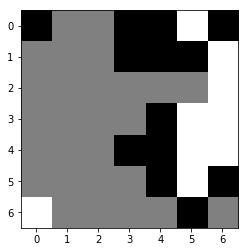

((1, 6), (2, 5)): n_v:  4711 q_all:-0.005730 q:+0.009677 q_m:+0.100000 p:0.208789
((5, 5), (6, 6)): n_v:   496 q_all:-0.013583 q:+0.017312 q_m:+0.033333 p:0.010168
((3, 5), (5, 3)): n_v:    45 q_all:-0.062896 q:-0.044066 q_m:+0.066667 p:0.013506
((3, 5), (2, 4)): n_v:    43 q_all:-0.056971 q:-0.003884 q_m:+0.166667 p:0.011869
((5, 5), (6, 4)): n_v:    18 q_all:-0.040582 q:-0.030676 q_m:+0.033333 p:0.003315
((4, 5), (2, 5)): n_v:    10 q_all:-0.086990 q:-0.045473 q_m:+0.066667 p:0.004009
((5, 5), (3, 3)): n_v:    10 q_all:-0.061117 q:-0.029865 q_m:+0.066667 p:0.002880
((4, 6), (2, 5)): n_v:     9 q_all:-0.075496 q:-0.037237 q_m:+0.066667 p:0.003559
((5, 5), (5, 3)): n_v:     8 q_all:-0.053663 q:-0.033603 q_m:+0.066667 p:0.002274
((3, 5), (3, 3)): n_v:     6 q_all:-0.056043 q:-0.037400 q_m:+0.066667 p:0.001601
((3, 6), (2, 4)): n_v:     5 q_all:-0.074985 q:-0.036321 q_m:+0.133333 p:0.002080
((0, 5), (2, 5)): n_v:     5 q_all:-0.066884 q:-0.044915 q_m:+0.066667 p:0.001850
((1, 6), (2, 4))

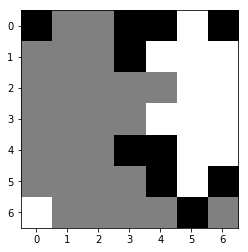

((1, 3), (2, 4)): n_v:  3598 q_all:+0.026502 q:+0.050617 q_m:+0.266667 p:0.468355
((4, 4), (2, 4)): n_v:  1204 q_all:+0.013514 q:+0.046681 q_m:+0.233333 p:0.219529
((4, 3), (2, 4)): n_v:   797 q_all:+0.025320 q:+0.049526 q_m:+0.233333 p:0.107577
((0, 6), (2, 4)): n_v:   185 q_all:-0.008056 q:+0.004893 q_m:+0.233333 p:0.049976
((1, 3), (2, 2)): n_v:   146 q_all:-0.078884 q:-0.059807 q_m:-0.066667 p:0.080979
((0, 3), (2, 4)): n_v:    39 q_all:+0.003726 q:+0.034155 q_m:+0.233333 p:0.008733
((4, 3), (4, 2)): n_v:    23 q_all:-0.068788 q:-0.073884 q_m:-0.066667 p:0.012158
((5, 6), (6, 6)): n_v:    16 q_all:-0.014619 q:+0.001325 q_m:-0.000000 p:0.004836
((4, 3), (2, 2)): n_v:    13 q_all:-0.084342 q:-0.064813 q_m:-0.100000 p:0.008004
((0, 0), (2, 2)): n_v:    12 q_all:-0.103188 q:-0.083149 q_m:-0.100000 p:0.008061
((4, 4), (2, 2)): n_v:     8 q_all:-0.064350 q:-0.036189 q_m:-0.100000 p:0.003973
((0, 4), (2, 4)): n_v:     6 q_all:-0.065433 q:-0.002224 q_m:+0.233333 p:0.003293
((5, 4), (6, 4))

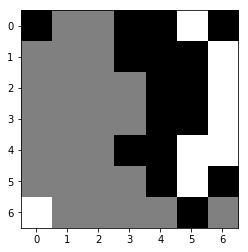

((5, 5), (6, 6)): n_v:  4680 q_all:-0.029091 q:+0.015034 q_m:-0.100000 p:0.899157
((5, 5), (6, 4)): n_v:   120 q_all:-0.082955 q:-0.037294 q_m:-0.100000 p:0.051164
((0, 5), (2, 3)): n_v:    58 q_all:-0.055877 q:-0.018058 q_m:-0.000000 p:0.018230
((5, 5), (3, 3)): n_v:    21 q_all:-0.082347 q:-0.055436 q_m:-0.000000 p:0.009297
((4, 5), (2, 3)): n_v:     9 q_all:-0.110672 q:-0.045846 q_m:-0.000000 p:0.005003
((4, 6), (6, 4)): n_v:     8 q_all:-0.133377 q:-0.103396 q_m:-0.133333 p:0.005692
((6, 0), (5, 1)): n_v:     3 q_all:-0.030285 q:-0.090654 q_m:-0.233333 p:0.000680
((4, 5), (3, 3)): n_v:     2 q_all:-0.127829 q:-0.088750 q_m:-0.000000 p:0.001795
((5, 5), (5, 3)): n_v:     1 q_all:-0.134701 q:-0.078088 q_m:-0.066667 p:0.000944
((4, 5), (5, 3)): n_v:     1 q_all:-0.166335 q:-0.131732 q_m:-0.066667 p:0.000652
((6, 0), (5, 2)): n_v:     1 q_all:-0.093212 q:-0.103499 q_m:-0.200000 p:0.000749
((4, 6), (6, 6)): n_v:     0 q_all:-0.116310 q:-0.116310 q_m:-0.133333 p:0.000465
((4, 5), (6, 6))

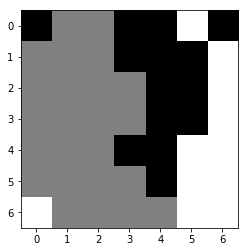

((5, 4), (6, 4)): n_v:  5220 q_all:+0.066533 q:+0.044463 q_m:+0.266667 p:0.763942
((4, 3), (6, 4)): n_v:   360 q_all:+0.062364 q:+0.053059 q_m:+0.233333 p:0.058793
((4, 4), (6, 4)): n_v:    50 q_all:-0.029689 q:+0.016185 q_m:+0.233333 p:0.026804
((0, 3), (0, 2)): n_v:    46 q_all:-0.076167 q:-0.065959 q_m:+0.133333 p:0.033327
((4, 3), (6, 2)): n_v:    41 q_all:-0.079689 q:-0.082016 q_m:+0.100000 p:0.030525
((4, 3), (5, 1)): n_v:    11 q_all:-0.040271 q:-0.039249 q_m:+0.166667 p:0.006400
((0, 3), (1, 1)): n_v:    10 q_all:-0.076138 q:-0.063018 q_m:+0.100000 p:0.007595
((0, 0), (0, 2)): n_v:     8 q_all:-0.089431 q:-0.082013 q_m:+0.100000 p:0.006760
((0, 0), (1, 1)): n_v:     6 q_all:-0.048555 q:-0.028868 q_m:+0.133333 p:0.004241
((0, 3), (0, 1)): n_v:     4 q_all:-0.088551 q:-0.078868 q_m:+0.100000 p:0.003636
((1, 3), (1, 1)): n_v:     2 q_all:-0.079445 q:-0.066077 q_m:+0.100000 p:0.001766
((4, 3), (6, 1)): n_v:     2 q_all:-0.052280 q:-0.050757 q_m:+0.166667 p:0.001573
((0, 3), (2, 1))

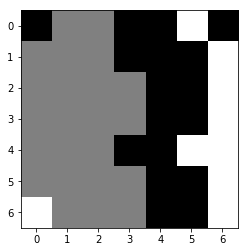

((0, 5), (2, 3)): n_v:  1813 q_all:-0.056965 q:-0.003104 q_m:-0.000000 p:0.188632
((6, 0), (5, 1)): n_v:  1091 q_all:-0.071618 q:-0.068685 q_m:-0.233333 p:0.175786
((6, 0), (5, 2)): n_v:   871 q_all:-0.072031 q:-0.070443 q_m:-0.200000 p:0.141526
((6, 0), (6, 2)): n_v:   714 q_all:-0.054593 q:-0.069328 q_m:-0.266667 p:0.067524
((6, 0), (6, 1)): n_v:   505 q_all:-0.061356 q:-0.078760 q_m:-0.233333 p:0.060766
((4, 5), (2, 3)): n_v:   385 q_all:-0.124169 q:-0.066186 q_m:-0.000000 p:0.140547
((6, 0), (4, 2)): n_v:   341 q_all:-0.069075 q:-0.083771 q_m:-0.200000 p:0.051509
((4, 5), (5, 3)): n_v:   188 q_all:-0.136727 q:-0.090936 q_m:-0.000000 p:0.077936
((4, 5), (3, 3)): n_v:   118 q_all:-0.153807 q:-0.099993 q_m:-0.000000 p:0.056435
((6, 0), (4, 1)): n_v:   105 q_all:-0.075501 q:-0.085699 q_m:-0.266667 p:0.018615
((6, 0), (5, 0)): n_v:    24 q_all:-0.098156 q:-0.082950 q_m:-0.233333 p:0.006500
((6, 0), (4, 0)): n_v:    14 q_all:-0.089642 q:-0.106290 q_m:-0.266667 p:0.003431
((4, 5), (6, 3))

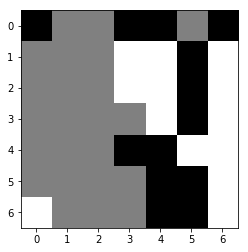

((0, 4), (0, 5)): n_v:  3209 q_all:+0.110953 q:+0.095854 q_m:+0.166667 p:0.378413
((4, 3), (3, 3)): n_v:    57 q_all:-0.048173 q:+0.000699 q_m:+0.233333 p:0.054733
((0, 0), (0, 1)): n_v:    52 q_all:-0.108321 q:-0.069441 q_m:+0.033333 p:0.066652
((1, 5), (3, 3)): n_v:     2 q_all:+0.043969 q:+0.001452 q_m:+0.200000 p:0.001068
((0, 3), (0, 5)): n_v:     2 q_all:+0.040854 q:+0.023109 q_m:+0.133333 p:0.001330
((0, 0), (1, 2)): n_v:     1 q_all:-0.148393 q:-0.055591 q_m:+0.133333 p:0.001126
((2, 5), (0, 5)): n_v:     1 q_all:-0.066647 q:+0.002052 q_m:+0.133333 p:0.001253
((4, 4), (6, 3)): n_v:     0 q_all:-0.097711 q:-0.097711 q_m:-0.000000 p:0.000003
((4, 3), (4, 2)): n_v:     0 q_all:-0.094571 q:-0.094571 q_m:+0.033333 p:0.000060
((0, 3), (2, 1)): n_v:     0 q_all:-0.093176 q:-0.093176 q_m:-0.000000 p:0.000013
((0, 3), (1, 1)): n_v:     0 q_all:-0.104113 q:-0.104113 q_m:-0.000000 p:0.000045
((0, 4), (0, 2)): n_v:     0 q_all:-0.083525 q:-0.083525 q_m:+0.066667 p:0.000001
((4, 3), (2, 1))

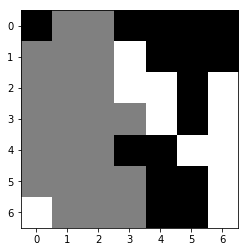

((3, 4), (5, 3)): n_v:  2966 q_all:-0.072830 q:-0.051558 q_m:+0.100000 p:0.176691
((2, 3), (3, 3)): n_v:   873 q_all:-0.107206 q:-0.155421 q_m:-0.000000 p:0.184131
((1, 3), (3, 3)): n_v:   415 q_all:-0.129637 q:-0.171363 q_m:-0.033333 p:0.131732
((1, 3), (0, 1)): n_v:   164 q_all:-0.099106 q:-0.121623 q_m:-0.100000 p:0.029423
((1, 3), (1, 1)): n_v:    67 q_all:-0.091569 q:-0.120857 q_m:-0.100000 p:0.009730
((2, 3), (0, 1)): n_v:    53 q_all:-0.165902 q:-0.131872 q_m:-0.100000 p:0.025665
((2, 3), (4, 2)): n_v:    25 q_all:-0.198297 q:-0.205429 q_m:-0.100000 p:0.016087
((2, 3), (0, 2)): n_v:    20 q_all:-0.163213 q:-0.107381 q_m:-0.100000 p:0.009580
((2, 3), (1, 1)): n_v:    19 q_all:-0.160282 q:-0.124936 q_m:-0.100000 p:0.009060
((1, 3), (3, 1)): n_v:    11 q_all:-0.176201 q:-0.176503 q_m:-0.166667 p:0.005986
((2, 3), (3, 1)): n_v:     9 q_all:-0.211391 q:-0.186878 q_m:-0.166667 p:0.006416
((2, 3), (4, 1)): n_v:     8 q_all:-0.223785 q:-0.194730 q_m:-0.166667 p:0.006657
((1, 3), (0, 2))

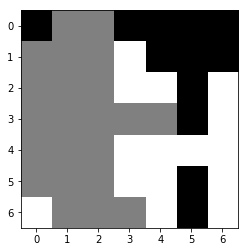

((2, 5), (3, 4)): n_v:  4533 q_all:+0.065118 q:+0.110393 q_m:+0.266667 p:0.474598
((5, 5), (3, 4)): n_v:   473 q_all:+0.081604 q:+0.078862 q_m:+0.233333 p:0.013324
((0, 3), (1, 2)): n_v:    11 q_all:-0.031170 q:+0.029291 q_m:+0.066667 p:0.006294
((1, 6), (3, 4)): n_v:     5 q_all:-0.090938 q:-0.028323 q_m:+0.233333 p:0.004353
((6, 5), (6, 3)): n_v:     5 q_all:+0.028189 q:+0.062737 q_m:+0.100000 p:0.001225
((0, 0), (1, 2)): n_v:     3 q_all:-0.070625 q:+0.010785 q_m:+0.033333 p:0.002905
((3, 5), (3, 3)): n_v:     2 q_all:+0.011758 q:+0.032388 q_m:+0.166667 p:0.000440
((5, 5), (6, 3)): n_v:     2 q_all:+0.014273 q:+0.050071 q_m:+0.100000 p:0.001008
((1, 5), (3, 4)): n_v:     1 q_all:-0.232353 q:-0.126942 q_m:+0.233333 p:0.002278
((1, 5), (3, 3)): n_v:     0 q_all:-0.213771 q:-0.213771 q_m:+0.166667 p:0.000172
((0, 3), (2, 1)): n_v:     0 q_all:-0.058582 q:-0.058582 q_m:-0.100000 p:0.000029
((1, 4), (3, 3)): n_v:     0 q_all:-0.117307 q:-0.117307 q_m:+0.166667 p:0.000052
((0, 3), (0, 2))

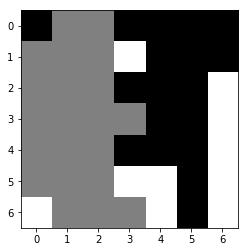

((1, 3), (3, 3)): n_v:  3461 q_all:-0.062983 q:-0.040206 q_m:+0.066667 p:0.558194
((5, 3), (3, 3)): n_v:  2392 q_all:-0.066063 q:-0.070887 q_m:+0.066667 p:0.416155
((5, 4), (3, 3)): n_v:    35 q_all:-0.159889 q:-0.112511 q_m:+0.066667 p:0.019344
((5, 3), (3, 1)): n_v:     1 q_all:-0.229420 q:-0.196508 q_m:-0.266667 p:0.000991
((1, 3), (1, 2)): n_v:     1 q_all:-0.166045 q:-0.146313 q_m:-0.100000 p:0.000560
((1, 3), (3, 1)): n_v:     1 q_all:-0.275382 q:-0.216343 q_m:-0.266667 p:0.001190
((5, 3), (4, 1)): n_v:     0 q_all:-0.220873 q:-0.220873 q_m:-0.266667 p:0.000015
((5, 3), (5, 2)): n_v:     0 q_all:-0.263298 q:-0.263298 q_m:-0.166667 p:0.000388
((1, 3), (3, 2)): n_v:     0 q_all:-0.152647 q:-0.152647 q_m:-0.133333 p:0.000276
((5, 3), (3, 2)): n_v:     0 q_all:-0.178697 q:-0.178697 q_m:-0.133333 p:0.000123
((5, 3), (6, 2)): n_v:     0 q_all:-0.253307 q:-0.253307 q_m:-0.233333 p:0.000033
((5, 3), (6, 3)): n_v:     0 q_all:-0.271796 q:-0.271796 q_m:-0.233333 p:0.000791
((5, 3), (4, 2))

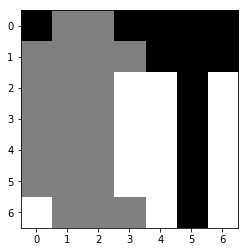

((0, 3), (1, 3)): n_v:  4557 q_all:+0.099872 q:+0.049997 q_m:+0.100000 p:0.252325
((0, 5), (1, 3)): n_v:    34 q_all:-0.065048 q:-0.056541 q_m:+0.066667 p:0.027043
((3, 5), (1, 3)): n_v:    20 q_all:-0.029721 q:-0.025993 q_m:+0.066667 p:0.012650
((1, 5), (1, 3)): n_v:     3 q_all:-0.265639 q:-0.215059 q_m:+0.066667 p:0.005204
((2, 5), (1, 3)): n_v:     1 q_all:-0.069355 q:-0.069355 q_m:+0.066667 p:0.001463
((0, 3), (2, 1)): n_v:     0 q_all:-0.045209 q:-0.045209 q_m:-0.066667 p:0.000010
((0, 3), (0, 2)): n_v:     0 q_all:-0.080670 q:-0.080670 q_m:-0.033333 p:0.000019
((0, 4), (0, 2)): n_v:     0 q_all:-0.183543 q:-0.183543 q_m:-0.066667 p:0.000019
((0, 0), (0, 2)): n_v:     0 q_all:-0.109217 q:-0.109217 q_m:-0.066667 p:0.000013
((0, 0), (1, 0)): n_v:     0 q_all:-0.027324 q:-0.027324 q_m:-0.033333 p:0.000002
((0, 0), (2, 2)): n_v:     0 q_all:-0.031435 q:-0.031435 q_m:+0.066667 p:0.000176
((1, 4), (2, 2)): n_v:     0 q_all:-0.078575 q:-0.078575 q_m:+0.066667 p:0.000102
((0, 0), (2, 1))

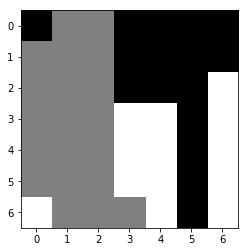

((5, 3), (6, 3)): n_v:  3330 q_all:-0.057480 q:-0.133743 q_m:-0.066667 p:0.133083
((3, 3), (1, 2)): n_v:   791 q_all:-0.115485 q:-0.077023 q_m:+0.100000 p:0.133775
((3, 3), (2, 2)): n_v:   442 q_all:-0.114177 q:-0.105825 q_m:+0.066667 p:0.072094
((3, 4), (1, 2)): n_v:   115 q_all:-0.098927 q:-0.054239 q_m:+0.100000 p:0.010075
((4, 3), (5, 2)): n_v:   103 q_all:-0.194103 q:-0.201755 q_m:-0.066667 p:0.057795
((3, 3), (3, 2)): n_v:    92 q_all:-0.151881 q:-0.128745 q_m:-0.000000 p:0.032354
((3, 3), (4, 2)): n_v:    60 q_all:-0.205940 q:-0.191507 q_m:-0.066667 p:0.037266
((3, 3), (1, 1)): n_v:    58 q_all:-0.137738 q:-0.097128 q_m:-0.033333 p:0.016421
((3, 3), (5, 2)): n_v:    57 q_all:-0.257030 q:-0.238747 q_m:-0.100000 p:0.048915
((6, 0), (5, 0)): n_v:    49 q_all:-0.141268 q:-0.134439 q_m:-0.066667 p:0.014823
((6, 0), (5, 1)): n_v:    48 q_all:-0.136153 q:-0.141931 q_m:-0.066667 p:0.013210
((6, 0), (5, 2)): n_v:    42 q_all:-0.219836 q:-0.217704 q_m:-0.100000 p:0.028884
((5, 3), (6, 2))

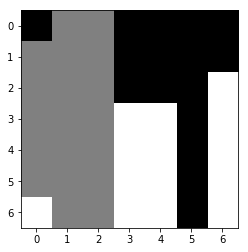

((2, 3), (3, 2)): n_v:  4177 q_all:+0.104071 q:+0.127513 q_m:+0.233333 p:0.317977
((1, 3), (2, 2)): n_v:   279 q_all:+0.032783 q:+0.081043 q_m:+0.166667 p:0.102502
((0, 0), (1, 1)): n_v:   264 q_all:+0.038388 q:+0.042534 q_m:+0.100000 p:0.088484
((0, 3), (1, 2)): n_v:   174 q_all:+0.014167 q:+0.042642 q_m:+0.100000 p:0.082655
((0, 0), (1, 2)): n_v:   165 q_all:+0.002951 q:+0.030193 q_m:+0.066667 p:0.087220
((0, 0), (0, 1)): n_v:   103 q_all:+0.056073 q:+0.061908 q_m:+0.100000 p:0.024026
((0, 3), (0, 2)): n_v:    51 q_all:+0.038310 q:+0.041477 q_m:+0.100000 p:0.017403
((0, 0), (1, 0)): n_v:    41 q_all:+0.075752 q:+0.104719 q_m:+0.100000 p:0.004767
((2, 3), (4, 2)): n_v:    31 q_all:+0.040767 q:+0.067031 q_m:+0.266667 p:0.010154
((0, 0), (0, 2)): n_v:    28 q_all:+0.029999 q:+0.026963 q_m:+0.066667 p:0.010839
((0, 0), (2, 2)): n_v:    14 q_all:+0.012479 q:+0.054721 q_m:+0.133333 p:0.007108
((0, 3), (1, 1)): n_v:    14 q_all:-0.022401 q:-0.009548 q_m:+0.066667 p:0.009440
((2, 3), (4, 1))

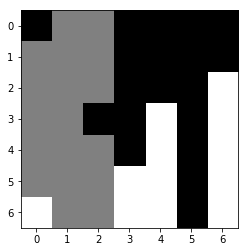

((5, 3), (4, 2)): n_v:  5420 q_all:-0.075492 q:-0.038118 q_m:-0.000000 p:0.853373
((6, 0), (4, 2)): n_v:   205 q_all:-0.110621 q:-0.065775 q_m:-0.033333 p:0.062610
((3, 4), (1, 2)): n_v:    30 q_all:-0.071918 q:-0.049677 q_m:-0.033333 p:0.003845
((6, 3), (4, 2)): n_v:    27 q_all:-0.151740 q:-0.132359 q_m:-0.033333 p:0.013185
((3, 4), (2, 2)): n_v:    23 q_all:-0.085549 q:-0.122012 q_m:+0.033333 p:0.004555
((5, 3), (5, 2)): n_v:    18 q_all:-0.211196 q:-0.212561 q_m:-0.133333 p:0.013546
((4, 4), (2, 2)): n_v:    11 q_all:-0.213227 q:-0.216465 q_m:+0.033333 p:0.008766
((6, 4), (4, 2)): n_v:     9 q_all:-0.216939 q:-0.161637 q_m:-0.033333 p:0.007037
((3, 4), (4, 2)): n_v:     8 q_all:-0.148625 q:-0.116753 q_m:-0.033333 p:0.003949
((5, 3), (6, 2)): n_v:     2 q_all:-0.254580 q:-0.243701 q_m:-0.200000 p:0.002407
((6, 0), (5, 0)): n_v:     2 q_all:-0.225396 q:-0.241568 q_m:-0.200000 p:0.001757
((6, 0), (5, 1)): n_v:     2 q_all:-0.228815 q:-0.232886 q_m:-0.200000 p:0.001960
((3, 4), (5, 2))

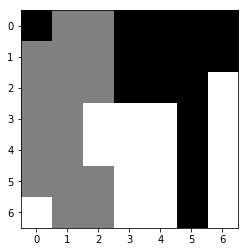

((1, 3), (2, 2)): n_v:  6133 q_all:+0.105793 q:+0.140042 q_m:+0.166667 p:0.460607
((0, 0), (2, 2)): n_v:    78 q_all:+0.071863 q:+0.106006 q_m:+0.133333 p:0.015916
((0, 0), (1, 1)): n_v:    43 q_all:-0.013995 q:-0.005132 q_m:+0.033333 p:0.023238
((2, 3), (3, 1)): n_v:    18 q_all:-0.002781 q:+0.014275 q_m:+0.133333 p:0.009044
((0, 3), (2, 2)): n_v:    18 q_all:+0.022099 q:+0.049754 q_m:+0.133333 p:0.007338
((0, 3), (1, 2)): n_v:    17 q_all:-0.042675 q:+0.002368 q_m:+0.033333 p:0.011026
((2, 3), (4, 1)): n_v:    12 q_all:-0.008632 q:+0.010232 q_m:+0.133333 p:0.006325
((0, 4), (2, 2)): n_v:     6 q_all:-0.060299 q:-0.009130 q_m:+0.133333 p:0.004401
((0, 3), (1, 1)): n_v:     6 q_all:-0.061890 q:-0.056509 q_m:-0.000000 p:0.004818
((0, 3), (0, 2)): n_v:     5 q_all:-0.037899 q:+0.000668 q_m:+0.033333 p:0.003578
((0, 0), (1, 2)): n_v:     4 q_all:-0.066315 q:-0.024197 q_m:-0.000000 p:0.003263
((2, 3), (1, 1)): n_v:     4 q_all:-0.072426 q:-0.037562 q_m:-0.000000 p:0.003257
((0, 0), (0, 2))

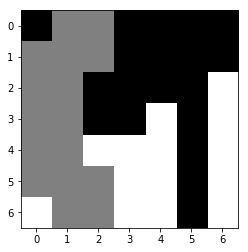

((4, 2), (3, 1)): n_v:  5342 q_all:-0.081092 q:-0.037188 q_m:-0.000000 p:0.604867
((4, 2), (2, 1)): n_v:   430 q_all:-0.089216 q:-0.053647 q_m:-0.033333 p:0.061326
((3, 4), (1, 2)): n_v:   399 q_all:-0.076323 q:-0.011396 q_m:+0.100000 p:0.037727
((4, 2), (2, 0)): n_v:    54 q_all:-0.134723 q:-0.157228 q_m:-0.166667 p:0.017478
((6, 0), (5, 2)): n_v:    47 q_all:-0.214875 q:-0.224246 q_m:-0.166667 p:0.028555
((4, 2), (5, 2)): n_v:    43 q_all:-0.164116 q:-0.215567 q_m:-0.133333 p:0.018073
((3, 4), (5, 2)): n_v:    30 q_all:-0.252368 q:-0.224305 q_m:-0.166667 p:0.022303
((6, 4), (5, 2)): n_v:    19 q_all:-0.325432 q:-0.294379 q_m:-0.166667 p:0.019145
((4, 2), (4, 1)): n_v:    12 q_all:-0.205481 q:-0.206799 q_m:-0.066667 p:0.007253
((5, 3), (6, 2)): n_v:    10 q_all:-0.239950 q:-0.230512 q_m:-0.133333 p:0.006721
((4, 2), (5, 1)): n_v:    10 q_all:-0.234738 q:-0.236952 q_m:-0.133333 p:0.007281
((4, 2), (3, 0)): n_v:     7 q_all:-0.201712 q:-0.200023 q_m:-0.166667 p:0.004387
((4, 3), (3, 1))

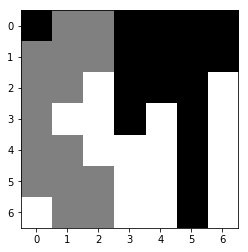

((0, 0), (2, 1)): n_v:  3877 q_all:+0.111292 q:+0.151759 q_m:+0.200000 p:0.321436
((0, 3), (1, 2)): n_v:   933 q_all:+0.086709 q:+0.101193 q_m:+0.100000 p:0.165475
((0, 0), (1, 2)): n_v:   394 q_all:+0.091814 q:+0.087522 q_m:+0.066667 p:0.062222
((0, 3), (2, 1)): n_v:   296 q_all:+0.088945 q:+0.098554 q_m:+0.200000 p:0.049690
((3, 3), (5, 2)): n_v:   113 q_all:+0.105438 q:+0.126903 q_m:+0.266667 p:0.011973
((3, 3), (4, 1)): n_v:   109 q_all:+0.062091 q:+0.047287 q_m:+0.200000 p:0.029428
((3, 3), (2, 1)): n_v:    54 q_all:+0.043310 q:+0.066602 q_m:+0.200000 p:0.018629
((2, 3), (4, 1)): n_v:    40 q_all:-0.023601 q:-0.008044 q_m:+0.200000 p:0.024045
((1, 3), (2, 1)): n_v:    27 q_all:+0.025167 q:+0.043423 q_m:+0.200000 p:0.011534
((3, 3), (1, 2)): n_v:    20 q_all:+0.000402 q:+0.051742 q_m:+0.066667 p:0.010622
((0, 0), (1, 1)): n_v:    10 q_all:+0.017919 q:+0.038283 q_m:+0.100000 p:0.004303
((3, 3), (5, 1)): n_v:     8 q_all:+0.059137 q:+0.066549 q_m:+0.133333 p:0.002531
((0, 4), (1, 2))

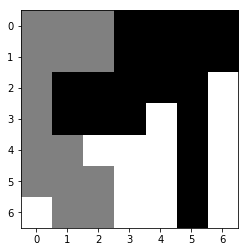

((4, 2), (2, 0)): n_v:  1545 q_all:-0.077334 q:-0.130074 q_m:-0.066667 p:0.201403
((4, 2), (4, 1)): n_v:  1287 q_all:-0.089157 q:-0.100374 q_m:-0.033333 p:0.232771
((4, 2), (3, 0)): n_v:   916 q_all:-0.087171 q:-0.086657 q_m:-0.066667 p:0.158342
((3, 4), (1, 2)): n_v:   895 q_all:-0.058846 q:-0.009952 q_m:+0.133333 p:0.045608
((4, 2), (5, 2)): n_v:    68 q_all:-0.155715 q:-0.166983 q_m:-0.166667 p:0.031319
((3, 4), (5, 2)): n_v:    55 q_all:-0.227520 q:-0.187227 q_m:-0.200000 p:0.042247
((6, 0), (4, 1)): n_v:    37 q_all:-0.101808 q:-0.111212 q_m:-0.066667 p:0.008766
((6, 0), (5, 2)): n_v:    34 q_all:-0.193481 q:-0.166207 q_m:-0.200000 p:0.021608
((6, 3), (4, 1)): n_v:    33 q_all:-0.148338 q:-0.151447 q_m:-0.066667 p:0.014529
((6, 4), (5, 2)): n_v:    26 q_all:-0.297986 q:-0.263508 q_m:-0.200000 p:0.028311
((4, 2), (5, 0)): n_v:     8 q_all:-0.176802 q:-0.189123 q_m:-0.200000 p:0.004591
((4, 4), (5, 2)): n_v:     7 q_all:-0.327761 q:-0.278143 q_m:-0.200000 p:0.008216
((5, 3), (4, 1))

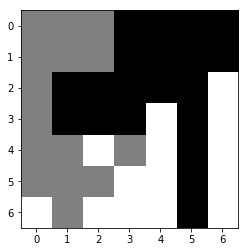

((3, 2), (4, 3)): n_v:  1287 q_all:+0.484329 q:+0.470727 q_m:+0.566667 p:0.443505
((6, 5), (4, 3)): n_v:   873 q_all:+0.530696 q:+0.424285 q_m:+0.533333 p:0.013350
((3, 1), (4, 3)): n_v:    15 q_all:+0.438598 q:+0.411361 q_m:+0.533333 p:0.009337
((2, 1), (4, 3)): n_v:     7 q_all:+0.446330 q:+0.440184 q_m:+0.533333 p:0.004398
((2, 2), (4, 3)): n_v:     5 q_all:+0.480547 q:+0.420079 q_m:+0.533333 p:0.002011
((5, 5), (4, 3)): n_v:     3 q_all:+0.243769 q:+0.290056 q_m:+0.533333 p:0.007630
((3, 5), (4, 3)): n_v:     2 q_all:+0.287760 q:+0.191612 q_m:+0.533333 p:0.004689
((0, 3), (1, 2)): n_v:     2 q_all:+0.313224 q:+0.170161 q_m:+0.233333 p:0.004300
((3, 3), (1, 2)): n_v:     2 q_all:+0.202888 q:+0.118902 q_m:+0.200000 p:0.005390
((2, 5), (4, 3)): n_v:     1 q_all:+0.186033 q:+0.203610 q_m:+0.533333 p:0.002505
((4, 5), (4, 3)): n_v:     1 q_all:+0.287206 q:+0.277296 q_m:+0.533333 p:0.001000
((3, 3), (5, 2)): n_v:     1 q_all:+0.215195 q:+0.266574 q_m:+0.466667 p:0.003719
((2, 3), (4, 3))

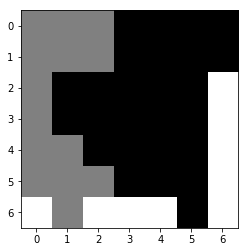

((6, 0), (5, 2)): n_v:  2813 q_all:-0.413691 q:-0.391542 q_m:-0.366667 p:0.310250
((6, 2), (5, 2)): n_v:   590 q_all:-0.477246 q:-0.379941 q_m:-0.333333 p:0.278652
((6, 4), (5, 2)): n_v:    33 q_all:-0.507991 q:-0.474279 q_m:-0.366667 p:0.021468
((6, 2), (4, 1)): n_v:    24 q_all:-0.478521 q:-0.436982 q_m:-0.366667 p:0.010659
((6, 3), (4, 1)): n_v:    18 q_all:-0.479456 q:-0.406600 q_m:-0.366667 p:0.008524
((6, 0), (4, 1)): n_v:     9 q_all:-0.512194 q:-0.456850 q_m:-0.366667 p:0.006101
((6, 0), (5, 0)): n_v:     0 q_all:-0.526226 q:-0.519119 q_m:-0.533333 p:0.000058
((6, 2), (4, 0)): n_v:     0 q_all:-0.485727 q:-0.471454 q_m:-0.500000 p:0.000021
((6, 0), (5, 1)): n_v:     0 q_all:-0.550405 q:-0.550405 q_m:-0.466667 p:0.000079
((6, 2), (5, 0)): n_v:     0 q_all:-0.547661 q:-0.528655 q_m:-0.566667 p:0.000010
((6, 3), (5, 1)): n_v:     0 q_all:-0.492742 q:-0.485484 q_m:-0.500000 p:0.000199
((6, 0), (4, 0)): n_v:     0 q_all:-0.495546 q:-0.491091 q_m:-0.500000 p:0.000171
((6, 0), (6, 1))

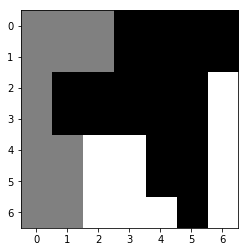

((3, 1), (5, 1)): n_v:  3681 q_all:+0.453582 q:+0.448047 q_m:+0.566667 p:0.126514
((3, 1), (4, 1)): n_v:   996 q_all:+0.394986 q:+0.421817 q_m:+0.533333 p:0.309115
((3, 2), (5, 1)): n_v:   105 q_all:+0.398114 q:+0.377715 q_m:+0.566667 p:0.030859
((2, 1), (4, 1)): n_v:    68 q_all:+0.363267 q:+0.386372 q_m:+0.500000 p:0.031658
((3, 1), (1, 1)): n_v:    47 q_all:+0.251237 q:+0.236205 q_m:+0.366667 p:0.046715
((2, 2), (4, 1)): n_v:    25 q_all:+0.344111 q:+0.344158 q_m:+0.500000 p:0.013883
((3, 1), (1, 2)): n_v:    24 q_all:+0.262838 q:+0.270283 q_m:+0.366667 p:0.023201
((2, 1), (1, 1)): n_v:    23 q_all:+0.320783 q:+0.291093 q_m:+0.400000 p:0.014691
((0, 3), (1, 2)): n_v:     9 q_all:+0.386347 q:+0.357073 q_m:+0.400000 p:0.003290
((3, 1), (4, 0)): n_v:     7 q_all:+0.305419 q:+0.306370 q_m:+0.400000 p:0.005778
((3, 2), (1, 1)): n_v:     5 q_all:+0.192655 q:+0.215305 q_m:+0.366667 p:0.007098
((3, 3), (5, 1)): n_v:     5 q_all:+0.270351 q:+0.251671 q_m:+0.566667 p:0.003879
((2, 1), (1, 0))

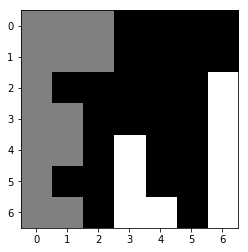

((4, 3), (6, 1)): n_v:  3605 q_all:-0.387603 q:-0.422831 q_m:-0.366667 p:0.408121
((4, 3), (3, 1)): n_v:  1485 q_all:-0.430725 q:-0.403984 q_m:-0.300000 p:0.279982
((6, 3), (4, 1)): n_v:   261 q_all:-0.494243 q:-0.480202 q_m:-0.300000 p:0.140719
((5, 3), (3, 1)): n_v:   167 q_all:-0.489992 q:-0.442696 q_m:-0.300000 p:0.085465
((4, 3), (4, 1)): n_v:    59 q_all:-0.519977 q:-0.504861 q_m:-0.300000 p:0.040374
((6, 3), (6, 1)): n_v:    20 q_all:-0.546330 q:-0.510433 q_m:-0.366667 p:0.016792
((5, 3), (4, 1)): n_v:    14 q_all:-0.569333 q:-0.538606 q_m:-0.300000 p:0.012887
((5, 3), (6, 1)): n_v:    14 q_all:-0.601196 q:-0.549278 q_m:-0.366667 p:0.015395
########################p_sum is:  0.999733109958
-1 's turn


This is a random move


one move takes time(s):  0.345081090927124
no. of data collected:  16


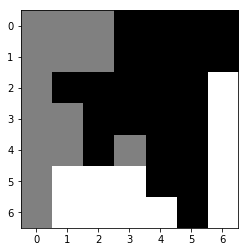

((3, 2), (4, 3)): n_v:  4737 q_all:+0.427550 q:+0.417560 q_m:+0.533333 p:0.165224
((2, 1), (4, 3)): n_v:   325 q_all:+0.383164 q:+0.447803 q_m:+0.500000 p:0.022446
((2, 2), (4, 3)): n_v:    42 q_all:+0.353507 q:+0.387098 q_m:+0.500000 p:0.009674
((6, 5), (4, 3)): n_v:    24 q_all:+0.330927 q:+0.356625 q_m:+0.500000 p:0.008337
((3, 5), (4, 3)): n_v:    12 q_all:+0.266345 q:+0.132674 q_m:+0.500000 p:0.009019
((5, 5), (4, 3)): n_v:     7 q_all:+0.254051 q:+0.247964 q_m:+0.500000 p:0.004961
((4, 2), (5, 0)): n_v:     6 q_all:+0.299768 q:+0.271093 q_m:+0.500000 p:0.003689
((2, 5), (4, 3)): n_v:     5 q_all:+0.171216 q:+0.141607 q_m:+0.500000 p:0.006514
((4, 2), (6, 0)): n_v:     4 q_all:+0.312279 q:+0.268949 q_m:+0.500000 p:0.002248
((2, 3), (4, 3)): n_v:     3 q_all:+0.287012 q:+0.244570 q_m:+0.500000 p:0.001517
((3, 3), (4, 1)): n_v:     2 q_all:+0.282029 q:+0.208370 q_m:+0.500000 p:0.001840
((2, 4), (4, 3)): n_v:     2 q_all:+0.219009 q:+0.042593 q_m:+0.500000 p:0.002156
((3, 2), (4, 1))

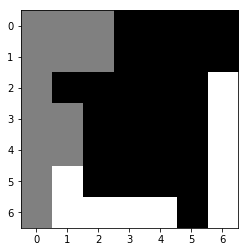

((5, 1), (3, 1)): n_v:  3580 q_all:-0.442570 q:-0.367866 q_m:-0.266667 p:0.518318
((5, 1), (4, 1)): n_v:  2522 q_all:-0.447136 q:-0.335768 q_m:-0.300000 p:0.411212
((6, 1), (4, 1)): n_v:   117 q_all:-0.473925 q:-0.386584 q_m:-0.333333 p:0.031698
((6, 2), (4, 1)): n_v:    28 q_all:-0.500587 q:-0.475248 q_m:-0.333333 p:0.010844
((6, 3), (4, 1)): n_v:    24 q_all:-0.517417 q:-0.457059 q_m:-0.333333 p:0.011044
((5, 1), (3, 0)): n_v:    11 q_all:-0.503520 q:-0.474619 q_m:-0.466667 p:0.004198
((5, 1), (5, 0)): n_v:     5 q_all:-0.568515 q:-0.613008 q_m:-0.500000 p:0.003845
((5, 1), (6, 0)): n_v:     3 q_all:-0.495911 q:-0.626683 q_m:-0.500000 p:0.001199
((5, 1), (4, 0)): n_v:     2 q_all:-0.571445 q:-0.610925 q_m:-0.500000 p:0.001935
((6, 1), (4, 0)): n_v:     0 q_all:-0.569598 q:-0.605862 q_m:-0.533333 p:0.000140
((6, 2), (4, 0)): n_v:     0 q_all:-0.598999 q:-0.664665 q_m:-0.533333 p:0.000036
((6, 2), (5, 0)): n_v:     0 q_all:-0.587050 q:-0.640767 q_m:-0.533333 p:0.000382
((6, 2), (6, 0))

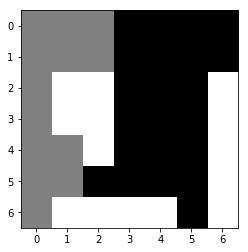

((5, 2), (5, 1)): n_v:  4271 q_all:+0.489165 q:+0.422540 q_m:+0.500000 p:0.502161
((0, 3), (1, 2)): n_v:   395 q_all:+0.453494 q:+0.363023 q_m:+0.433333 p:0.108461
((5, 2), (4, 1)): n_v:   267 q_all:+0.441972 q:+0.411285 q_m:+0.500000 p:0.086830
((0, 3), (1, 1)): n_v:     7 q_all:+0.218531 q:+0.228780 q_m:+0.400000 p:0.010422
((5, 3), (5, 1)): n_v:     3 q_all:+0.216814 q:+0.243868 q_m:+0.466667 p:0.004492
((1, 3), (1, 1)): n_v:     2 q_all:+0.139557 q:+0.183445 q_m:+0.400000 p:0.003744
((5, 2), (4, 0)): n_v:     2 q_all:+0.272745 q:+0.285790 q_m:+0.333333 p:0.002119
((4, 3), (5, 1)): n_v:     1 q_all:+0.191249 q:+0.191249 q_m:+0.466667 p:0.002635
((5, 2), (5, 0)): n_v:     1 q_all:+0.224421 q:+0.263530 q_m:+0.333333 p:0.001714
((3, 3), (5, 1)): n_v:     1 q_all:+0.216335 q:+0.216335 q_m:+0.466667 p:0.002512
((5, 3), (4, 1)): n_v:     0 q_all:+0.261633 q:+0.261633 q_m:+0.466667 p:0.000762
((0, 3), (0, 2)): n_v:     0 q_all:+0.222248 q:+0.222248 q_m:+0.300000 p:0.001093
((0, 4), (0, 2))

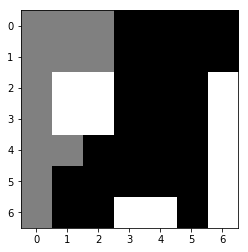

((3, 1), (1, 2)): n_v:  3170 q_all:-0.411922 q:-0.492656 q_m:-0.300000 p:0.283755
((3, 1), (4, 1)): n_v:  1593 q_all:-0.482127 q:-0.465523 q_m:-0.266667 p:0.233852
((6, 3), (4, 1)): n_v:   196 q_all:-0.512528 q:-0.493096 q_m:-0.300000 p:0.059129
((2, 2), (4, 1)): n_v:   149 q_all:-0.507053 q:-0.484705 q_m:-0.300000 p:0.040741
((2, 1), (1, 2)): n_v:   106 q_all:-0.546395 q:-0.540959 q_m:-0.266667 p:0.050714
((2, 1), (4, 1)): n_v:   103 q_all:-0.477340 q:-0.542303 q_m:-0.300000 p:0.012589
((3, 2), (1, 2)): n_v:    27 q_all:-0.524919 q:-0.491616 q_m:-0.300000 p:0.010181
((2, 2), (1, 0)): n_v:    19 q_all:-0.612194 q:-0.680504 q_m:-0.500000 p:0.016076
((3, 2), (5, 0)): n_v:    14 q_all:-0.506174 q:-0.471588 q_m:-0.366667 p:0.003694
((2, 2), (0, 1)): n_v:     9 q_all:-0.585890 q:-0.611465 q_m:-0.500000 p:0.006560
((3, 1), (5, 0)): n_v:     8 q_all:-0.545681 q:-0.556577 q_m:-0.366667 p:0.004144
((2, 2), (0, 0)): n_v:     6 q_all:-0.611185 q:-0.677488 q_m:-0.500000 p:0.005283
((3, 1), (1, 0))

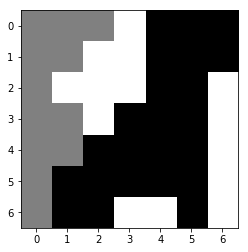

((4, 2), (3, 1)): n_v:  4841 q_all:+0.440728 q:+0.520297 q_m:+0.533333 p:0.977265
((5, 1), (3, 1)): n_v:    50 q_all:+0.414951 q:+0.457164 q_m:+0.500000 p:0.013580
((4, 2), (4, 1)): n_v:     5 q_all:+0.426992 q:+0.475685 q_m:+0.400000 p:0.000923
((5, 2), (3, 1)): n_v:     1 q_all:+0.284604 q:+0.311117 q_m:+0.500000 p:0.000501
((5, 1), (5, 0)): n_v:     1 q_all:+0.336942 q:+0.348148 q_m:+0.333333 p:0.000676
((5, 3), (4, 1)): n_v:     0 q_all:+0.239375 q:+0.239375 q_m:+0.366667 p:0.000001
((4, 2), (2, 0)): n_v:     0 q_all:+0.221727 q:+0.221727 q_m:+0.366667 p:0.000053
((3, 3), (3, 1)): n_v:     0 q_all:+0.367077 q:+0.234154 q_m:+0.500000 p:0.000177
((0, 4), (0, 2)): n_v:     0 q_all:+0.406428 q:+0.312856 q_m:+0.500000 p:0.000028
((5, 2), (5, 0)): n_v:     0 q_all:+0.174658 q:+0.174658 q_m:+0.300000 p:0.000006
((5, 2), (6, 0)): n_v:     0 q_all:+0.161560 q:+0.161560 q_m:+0.300000 p:0.000002
((5, 1), (4, 0)): n_v:     0 q_all:+0.334006 q:+0.334006 q_m:+0.333333 p:0.000350
((6, 2), (6, 0))

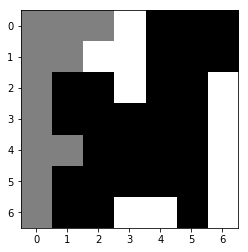

((2, 3), (4, 1)): n_v:  5944 q_all:-0.401134 q:-0.354601 q_m:-0.200000 p:0.707184
((6, 3), (4, 1)): n_v:   455 q_all:-0.482847 q:-0.427721 q_m:-0.200000 p:0.202101
((0, 3), (1, 1)): n_v:    56 q_all:-0.476682 q:-0.493296 q_m:-0.400000 p:0.023860
((1, 2), (1, 1)): n_v:    47 q_all:-0.550122 q:-0.568219 q_m:-0.366667 p:0.033448
((2, 3), (1, 1)): n_v:    25 q_all:-0.546168 q:-0.498942 q_m:-0.400000 p:0.017469
((1, 2), (2, 0)): n_v:     7 q_all:-0.627852 q:-0.616261 q_m:-0.400000 p:0.007586
((1, 3), (1, 1)): n_v:     2 q_all:-0.676607 q:-0.678631 q_m:-0.400000 p:0.003173
((1, 2), (3, 0)): n_v:     2 q_all:-0.649408 q:-0.640175 q_m:-0.400000 p:0.002873
((1, 2), (0, 1)): n_v:     0 q_all:-0.606802 q:-0.713605 q_m:-0.500000 p:0.000337
((1, 2), (1, 0)): n_v:     0 q_all:-0.661838 q:-0.661838 q_m:-0.466667 p:0.000069
((1, 3), (0, 1)): n_v:     0 q_all:-0.620749 q:-0.708166 q_m:-0.533333 p:0.000071
((0, 3), (0, 1)): n_v:     0 q_all:-0.601648 q:-0.669963 q_m:-0.533333 p:0.000166
((0, 3), (0, 2))

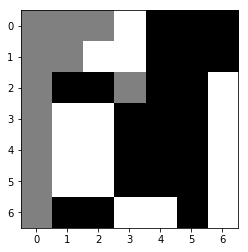

((1, 4), (2, 3)): n_v:  6276 q_all:+0.402414 q:+0.486127 q_m:+0.433333 p:0.193541
((0, 4), (2, 3)): n_v:    11 q_all:+0.252291 q:+0.305531 q_m:+0.400000 p:0.006788
((0, 5), (2, 3)): n_v:     3 q_all:+0.211890 q:+0.260231 q_m:+0.400000 p:0.002595
((2, 1), (2, 3)): n_v:     3 q_all:+0.382562 q:+0.419750 q_m:+0.400000 p:0.000363
((4, 4), (2, 3)): n_v:     1 q_all:+0.066900 q:+0.050610 q_m:+0.400000 p:0.001483
((4, 5), (2, 3)): n_v:     1 q_all:+0.099703 q:+0.191579 q_m:+0.400000 p:0.001142
((4, 3), (2, 3)): n_v:     0 q_all:+0.205995 q:+0.205995 q_m:+0.400000 p:0.000336
((0, 4), (0, 2)): n_v:     0 q_all:+0.143005 q:+0.143005 q_m:+0.400000 p:0.000025
((6, 2), (5, 0)): n_v:     0 q_all:+0.201525 q:+0.201525 q_m:+0.333333 p:0.000006
((2, 2), (4, 0)): n_v:     0 q_all:+0.302175 q:+0.302175 q_m:+0.400000 p:0.000262
((3, 5), (2, 3)): n_v:     0 q_all:+0.137895 q:+0.137895 q_m:+0.400000 p:0.000255
((2, 1), (1, 0)): n_v:     0 q_all:+0.169712 q:+0.169712 q_m:+0.233333 p:0.000044
((6, 2), (6, 0))

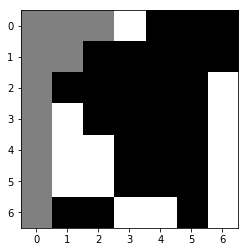

((0, 3), (1, 1)): n_v:  6277 q_all:-0.328128 q:-0.352786 q_m:-0.233333 p:0.768143
((3, 1), (1, 1)): n_v:   218 q_all:-0.509123 q:-0.488231 q_m:-0.233333 p:0.169739
((4, 1), (5, 0)): n_v:    13 q_all:-0.629886 q:-0.638663 q_m:-0.333333 p:0.016089
((0, 3), (0, 2)): n_v:     7 q_all:-0.525719 q:-0.519033 q_m:-0.266667 p:0.006580
((4, 1), (6, 0)): n_v:     7 q_all:-0.656539 q:-0.649729 q_m:-0.366667 p:0.009278
((5, 1), (6, 0)): n_v:     4 q_all:-0.561520 q:-0.548190 q_m:-0.333333 p:0.003761
((0, 3), (0, 1)): n_v:     3 q_all:-0.561858 q:-0.564633 q_m:-0.366667 p:0.002817
((3, 1), (1, 0)): n_v:     3 q_all:-0.575218 q:-0.567587 q_m:-0.366667 p:0.003930
((3, 1), (5, 0)): n_v:     2 q_all:-0.623949 q:-0.702555 q_m:-0.366667 p:0.003226
((4, 2), (6, 0)): n_v:     2 q_all:-0.637345 q:-0.611239 q_m:-0.366667 p:0.003147
((5, 2), (6, 0)): n_v:     1 q_all:-0.724544 q:-0.724544 q_m:-0.366667 p:0.002860
((4, 2), (2, 0)): n_v:     0 q_all:-0.562714 q:-0.562714 q_m:-0.366667 p:0.000144
((4, 2), (4, 0))

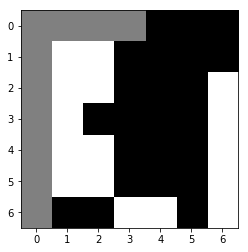

((0, 4), (0, 3)): n_v:  2130 q_all:+0.316450 q:+0.376746 q_m:+0.333333 p:0.158560
((6, 1), (5, 0)): n_v:  1975 q_all:+0.312398 q:+0.357125 q_m:+0.400000 p:0.176028
((1, 3), (0, 2)): n_v:   866 q_all:+0.316980 q:+0.378071 q_m:+0.400000 p:0.062807
((6, 2), (4, 0)): n_v:   485 q_all:+0.325077 q:+0.335273 q_m:+0.433333 p:0.020300
((6, 1), (4, 0)): n_v:   330 q_all:+0.326913 q:+0.331566 q_m:+0.433333 p:0.012080
((0, 4), (0, 2)): n_v:   212 q_all:+0.294260 q:+0.302219 q_m:+0.366667 p:0.032908
((6, 1), (6, 0)): n_v:   212 q_all:+0.263261 q:+0.309947 q_m:+0.333333 p:0.056720
((6, 2), (5, 0)): n_v:   155 q_all:+0.329430 q:+0.302440 q_m:+0.366667 p:0.003919
((3, 2), (4, 0)): n_v:    48 q_all:+0.220693 q:+0.201567 q_m:+0.433333 p:0.020362
((3, 2), (2, 0)): n_v:    29 q_all:+0.234703 q:+0.243231 q_m:+0.433333 p:0.010891
((1, 4), (0, 2)): n_v:    22 q_all:+0.064697 q:+0.122557 q_m:+0.366667 p:0.022478
((3, 2), (1, 0)): n_v:    20 q_all:+0.203406 q:+0.216167 q_m:+0.366667 p:0.009491
((3, 2), (5, 0))

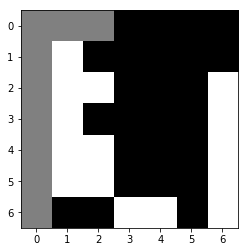

((1, 1), (0, 2)): n_v:  3428 q_all:-0.302079 q:-0.273962 q_m:-0.100000 p:0.946531
((2, 1), (0, 2)): n_v:    46 q_all:-0.441070 q:-0.330270 q_m:-0.133333 p:0.044287
((2, 2), (0, 2)): n_v:     2 q_all:-0.448769 q:-0.320873 q_m:-0.133333 p:0.001772
((1, 1), (0, 1)): n_v:     1 q_all:-0.651212 q:-0.539056 q_m:-0.233333 p:0.002026
((1, 1), (2, 0)): n_v:     0 q_all:-0.573575 q:-0.573575 q_m:-0.300000 p:0.000058
((4, 2), (2, 0)): n_v:     0 q_all:-0.614867 q:-0.614867 q_m:-0.333333 p:0.000007
((1, 1), (3, 0)): n_v:     0 q_all:-0.615546 q:-0.615546 q_m:-0.333333 p:0.000031
((4, 2), (4, 0)): n_v:     0 q_all:-0.614815 q:-0.614815 q_m:-0.333333 p:0.000003
((3, 1), (4, 0)): n_v:     0 q_all:-0.612938 q:-0.612938 q_m:-0.300000 p:0.000081
((4, 1), (5, 0)): n_v:     0 q_all:-0.511977 q:-0.511977 q_m:-0.233333 p:0.000425
((5, 2), (5, 0)): n_v:     0 q_all:-0.633049 q:-0.633049 q_m:-0.266667 p:0.000028
((5, 1), (6, 0)): n_v:     0 q_all:-0.408177 q:-0.408177 q_m:-0.233333 p:0.000328
((1, 1), (0, 0))

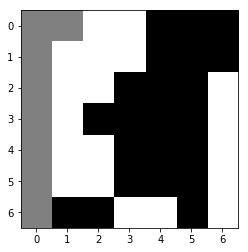

((6, 1), (5, 0)): n_v:  4329 q_all:+0.394779 q:+0.314842 q_m:+0.266667 p:0.438078
((6, 1), (6, 0)): n_v:   162 q_all:+0.163221 q:+0.245646 q_m:+0.200000 p:0.184088
((6, 1), (4, 0)): n_v:    87 q_all:+0.300544 q:+0.285619 q_m:+0.300000 p:0.037540
((6, 2), (4, 0)): n_v:    72 q_all:+0.225362 q:+0.277696 q_m:+0.300000 p:0.061584
((3, 2), (4, 0)): n_v:    59 q_all:+0.047778 q:+0.128701 q_m:+0.300000 p:0.097834
((3, 2), (2, 0)): n_v:    54 q_all:+0.165637 q:+0.190330 q_m:+0.300000 p:0.061059
((3, 2), (1, 0)): n_v:    30 q_all:+0.115021 q:+0.151584 q_m:+0.233333 p:0.041374
((3, 2), (5, 0)): n_v:    23 q_all:+0.059444 q:+0.171520 q_m:+0.233333 p:0.037704
((6, 2), (5, 0)): n_v:    21 q_all:+0.164056 q:+0.253955 q_m:+0.233333 p:0.024263
((2, 3), (0, 1)): n_v:     3 q_all:+0.051072 q:+0.181312 q_m:+0.300000 p:0.005972
((3, 2), (3, 0)): n_v:     1 q_all:+0.037297 q:+0.138485 q_m:+0.300000 p:0.002324
((6, 2), (6, 0)): n_v:     1 q_all:+0.052361 q:+0.119338 q_m:+0.166667 p:0.003242
################

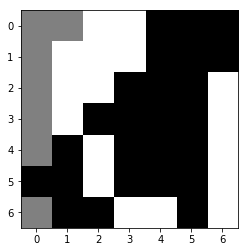

((4, 2), (6, 0)): n_v:  3467 q_all:-0.308436 q:-0.314582 q_m:-0.066667 p:0.060935
((3, 1), (4, 0)): n_v:  1916 q_all:-0.390520 q:-0.325130 q_m:-0.033333 p:0.227666
((0, 2), (0, 1)): n_v:   306 q_all:-0.405531 q:-0.436752 q_m:-0.233333 p:0.059408
((1, 1), (0, 0)): n_v:   127 q_all:-0.445264 q:-0.442354 q_m:-0.233333 p:0.049949
((1, 1), (2, 0)): n_v:   112 q_all:-0.506544 q:-0.485811 q_m:-0.233333 p:0.078439
((2, 1), (4, 0)): n_v:   104 q_all:-0.427446 q:-0.366268 q_m:-0.066667 p:0.031451
((0, 2), (2, 0)): n_v:    38 q_all:-0.537405 q:-0.527874 q_m:-0.266667 p:0.033352
((2, 2), (0, 0)): n_v:    36 q_all:-0.530523 q:-0.473944 q_m:-0.266667 p:0.029913
((2, 2), (4, 0)): n_v:    31 q_all:-0.429528 q:-0.379207 q_m:-0.066667 p:0.009714
((0, 2), (0, 0)): n_v:    28 q_all:-0.502250 q:-0.483735 q_m:-0.266667 p:0.019431
((2, 1), (0, 0)): n_v:    27 q_all:-0.512967 q:-0.467737 q_m:-0.266667 p:0.019317
((4, 2), (2, 0)): n_v:    20 q_all:-0.467564 q:-0.398031 q_m:-0.266667 p:0.009987
((5, 2), (4, 0))

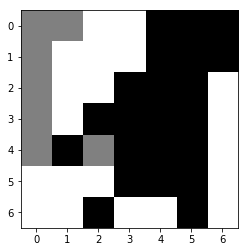

((3, 2), (4, 2)): n_v:  3876 q_all:+0.264899 q:+0.408694 q_m:+0.300000 p:0.217139
((4, 1), (2, 0)): n_v:  1312 q_all:+0.275931 q:+0.144197 q_m:+0.266667 p:0.010448
((3, 2), (4, 0)): n_v:     8 q_all:+0.131882 q:+0.003362 q_m:+0.266667 p:0.004964
((6, 2), (4, 2)): n_v:     7 q_all:+0.177297 q:+0.267931 q_m:+0.266667 p:0.002933
((3, 2), (2, 0)): n_v:     4 q_all:+0.106243 q:+0.054414 q_m:+0.266667 p:0.003536
((2, 3), (4, 2)): n_v:     1 q_all:-0.003555 q:+0.101633 q_m:+0.266667 p:0.001547
((6, 2), (4, 0)): n_v:     0 q_all:-0.021123 q:-0.021123 q_m:+0.266667 p:0.000345
((4, 1), (4, 0)): n_v:     0 q_all:-0.045712 q:-0.045712 q_m:+0.300000 p:0.001363
((4, 4), (4, 2)): n_v:     0 q_all:-0.160613 q:-0.160613 q_m:+0.266667 p:0.000280
((5, 4), (4, 2)): n_v:     0 q_all:-0.014229 q:-0.014229 q_m:+0.266667 p:0.000661
((3, 2), (3, 0)): n_v:     0 q_all:+0.028759 q:+0.028759 q_m:+0.200000 p:0.000044
((2, 3), (0, 1)): n_v:     0 q_all:+0.026633 q:+0.026633 q_m:+0.266667 p:0.000051
((2, 4), (4, 2))

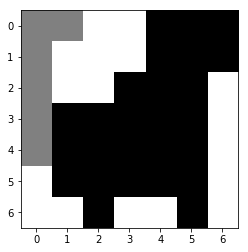

((5, 0), (4, 0)): n_v:  4737 q_all:-0.027114 q:-0.234125 q_m:-0.066667 p:0.382795
((2, 1), (4, 0)): n_v:   257 q_all:-0.326127 q:-0.326127 q_m:-0.100000 p:0.204124
((1, 1), (2, 0)): n_v:    61 q_all:-0.515259 q:-0.512021 q_m:-0.200000 p:0.114475
((2, 2), (4, 0)): n_v:    46 q_all:-0.357366 q:-0.357366 q_m:-0.100000 p:0.045993
((6, 0), (4, 0)): n_v:    24 q_all:-0.403864 q:-0.403864 q_m:-0.100000 p:0.030736
((2, 1), (3, 0)): n_v:    18 q_all:-0.575450 q:-0.566203 q_m:-0.133333 p:0.040601
((5, 0), (3, 0)): n_v:    17 q_all:-0.578722 q:-0.572755 q_m:-0.166667 p:0.038049
((6, 1), (4, 0)): n_v:     7 q_all:-0.401423 q:-0.401423 q_m:-0.100000 p:0.008825
((0, 2), (2, 0)): n_v:     4 q_all:-0.544585 q:-0.544585 q_m:-0.233333 p:0.009782
((0, 2), (0, 1)): n_v:     4 q_all:-0.557682 q:-0.557682 q_m:-0.266667 p:0.009102
((1, 1), (0, 0)): n_v:     2 q_all:-0.534121 q:-0.534121 q_m:-0.266667 p:0.004128
((1, 1), (3, 0)): n_v:     1 q_all:-0.557993 q:-0.557993 q_m:-0.166667 p:0.003481
((0, 2), (0, 0))

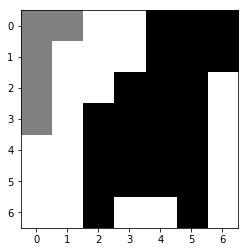

((4, 2), (3, 0)): n_v:  1614 q_all:-0.045511 q:+0.015055 q_m:+0.333333 p:0.287903
((5, 2), (3, 0)): n_v:  1277 q_all:-0.052941 q:+0.171664 q_m:+0.333333 p:0.224444
((3, 2), (1, 0)): n_v:  1162 q_all:+0.063987 q:-0.005923 q_m:+0.200000 p:0.019357
((3, 2), (3, 0)): n_v:   915 q_all:-0.090472 q:+0.126463 q_m:+0.333333 p:0.327112
((2, 3), (0, 1)): n_v:   148 q_all:-0.072955 q:+0.167774 q_m:+0.266667 p:0.040092
((3, 2), (2, 0)): n_v:   138 q_all:-0.117971 q:+0.038484 q_m:+0.266667 p:0.067776
((4, 2), (2, 0)): n_v:    33 q_all:-0.202448 q:-0.096231 q_m:+0.266667 p:0.029118
########################p_sum is:  0.995801597834
1 's turn
one move takes time(s):  0.26041436195373535
no. of data collected:  24


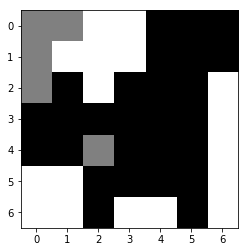

((6, 4), (4, 2)): n_v:  2174 q_all:+0.226375 q:-0.039878 q_m:+0.133333 p:0.006887
((5, 1), (4, 2)): n_v:  1284 q_all:+0.078434 q:+0.229178 q_m:+0.166667 p:0.599610
((6, 0), (4, 2)): n_v:   103 q_all:-0.081503 q:-0.048149 q_m:+0.133333 p:0.172183
((5, 0), (4, 2)): n_v:    61 q_all:-0.214715 q:-0.156381 q_m:+0.133333 p:0.146995
((6, 1), (4, 2)): n_v:    20 q_all:-0.205372 q:-0.136501 q_m:+0.133333 p:0.047849
((6, 3), (4, 2)): n_v:     9 q_all:-0.095659 q:-0.092948 q_m:+0.133333 p:0.016977
((1, 1), (2, 0)): n_v:     1 q_all:-0.373801 q:-0.225152 q_m:-0.100000 p:0.004975
((2, 2), (4, 2)): n_v:     1 q_all:-0.309991 q:-0.155069 q_m:+0.133333 p:0.003806
((0, 2), (2, 0)): n_v:     0 q_all:-0.301265 q:-0.301265 q_m:-0.133333 p:0.000291
((1, 2), (1, 0)): n_v:     0 q_all:-0.543137 q:-0.543137 q_m:-0.266667 p:0.000000
((1, 1), (0, 0)): n_v:     0 q_all:-0.531073 q:-0.531073 q_m:-0.300000 p:0.000026
((0, 2), (0, 1)): n_v:     0 q_all:-0.508448 q:-0.508448 q_m:-0.300000 p:0.000003
((0, 2), (0, 0))

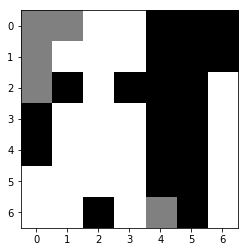

((2, 1), (0, 1)): n_v:  3758 q_all:-0.058779 q:+0.004898 q_m:+0.066667 p:0.047857
((5, 4), (6, 4)): n_v:   408 q_all:-0.264023 q:-0.066216 q_m:+0.033333 p:0.192214
((6, 2), (6, 4)): n_v:   144 q_all:-0.230602 q:-0.048002 q_m:-0.000000 p:0.033417
((4, 5), (6, 4)): n_v:    48 q_all:-0.611958 q:-0.499683 q_m:-0.000000 p:0.136895
((2, 3), (0, 1)): n_v:     9 q_all:-0.352625 q:-0.228671 q_m:+0.066667 p:0.010351
((2, 1), (0, 0)): n_v:     2 q_all:-0.437555 q:-0.210326 q_m:-0.066667 p:0.005110
((4, 4), (6, 4)): n_v:     2 q_all:-0.649959 q:-0.506251 q_m:-0.000000 p:0.006704
((2, 1), (2, 0)): n_v:     1 q_all:-0.424675 q:-0.264690 q_m:+0.033333 p:0.002798
((3, 0), (1, 0)): n_v:     1 q_all:-0.501624 q:-0.371348 q_m:-0.066667 p:0.001500
((2, 1), (1, 0)): n_v:     0 q_all:-0.428994 q:-0.428994 q_m:-0.033333 p:0.000632
((4, 0), (2, 0)): n_v:     0 q_all:-0.404142 q:-0.404142 q_m:-0.000000 p:0.000571
########################p_sum is:  0.438050857629
1 's turn
one move takes time(s):  0.25204777717

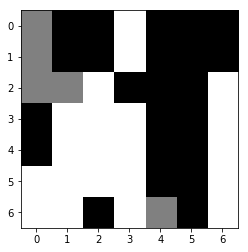

((5, 3), (6, 4)): n_v:  3134 q_all:+0.077144 q:+0.229562 q_m:+0.166667 p:0.083408
((0, 3), (2, 1)): n_v:  2339 q_all:+0.186787 q:-0.123631 q_m:+0.133333 p:0.072712
((2, 2), (2, 1)): n_v:   375 q_all:-0.021153 q:-0.012053 q_m:+0.166667 p:0.210570
((6, 6), (6, 4)): n_v:    82 q_all:-0.039228 q:+0.112195 q_m:+0.133333 p:0.052980
((5, 6), (6, 4)): n_v:     7 q_all:-0.184592 q:-0.092257 q_m:+0.133333 p:0.011552
((4, 2), (6, 4)): n_v:     5 q_all:-0.444459 q:-0.427637 q_m:+0.133333 p:0.014398
((4, 6), (6, 4)): n_v:     3 q_all:-0.192278 q:-0.105875 q_m:+0.133333 p:0.005238
((4, 3), (6, 4)): n_v:     2 q_all:-0.291846 q:-0.269111 q_m:+0.133333 p:0.004476
((1, 3), (2, 1)): n_v:     2 q_all:-0.215959 q:-0.187733 q_m:+0.133333 p:0.003259
((4, 3), (2, 1)): n_v:     1 q_all:-0.391751 q:-0.432704 q_m:+0.133333 p:0.004694
((3, 3), (2, 1)): n_v:     1 q_all:-0.330768 q:-0.329047 q_m:+0.133333 p:0.002831
((4, 2), (2, 1)): n_v:     1 q_all:-0.518673 q:-0.537969 q_m:+0.133333 p:0.003431
((3, 1), (2, 0))

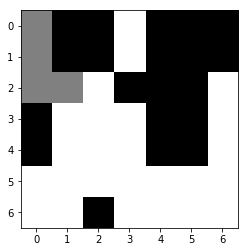

((1, 1), (2, 1)): n_v:  3877 q_all:+0.409928 q:+0.052208 q_m:+0.066667 p:0.346334
((4, 0), (2, 1)): n_v:    40 q_all:-0.075550 q:-0.075550 q_m:+0.033333 p:0.039362
((0, 1), (2, 1)): n_v:    22 q_all:-0.269212 q:-0.269212 q_m:+0.033333 p:0.048106
((0, 2), (2, 1)): n_v:    16 q_all:-0.245569 q:-0.245569 q_m:+0.033333 p:0.033250
((2, 3), (2, 1)): n_v:     2 q_all:-0.523611 q:-0.523611 q_m:+0.033333 p:0.007445
((0, 2), (2, 0)): n_v:     0 q_all:-0.750289 q:-0.750289 q_m:-0.100000 p:0.000069
((0, 1), (1, 0)): n_v:     0 q_all:-0.701394 q:-0.701394 q_m:-0.133333 p:0.000106
((1, 1), (2, 0)): n_v:     0 q_all:-0.745807 q:-0.745807 q_m:-0.066667 p:0.000350
((1, 2), (1, 0)): n_v:     0 q_all:-0.668308 q:-0.668308 q_m:-0.166667 p:0.000017
((4, 0), (2, 0)): n_v:     0 q_all:-0.678050 q:-0.678050 q_m:-0.100000 p:0.000124
((0, 1), (2, 0)): n_v:     0 q_all:-0.711124 q:-0.711124 q_m:-0.100000 p:0.000081
((0, 2), (0, 0)): n_v:     0 q_all:-0.759672 q:-0.759672 q_m:-0.166667 p:0.000088
((1, 2), (0, 0))

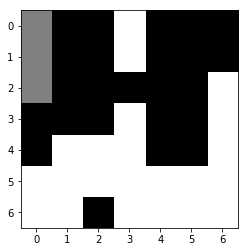

((4, 1), (2, 0)): n_v:  3628 q_all:-0.617799 q:-0.293064 q_m:+0.200000 p:0.191075
((4, 2), (2, 0)): n_v:   774 q_all:-0.841606 q:-0.481228 q_m:+0.200000 p:0.782194
########################p_sum is:  0.97326862812
-1 's turn
one move takes time(s):  0.18833494186401367
no. of data collected:  24


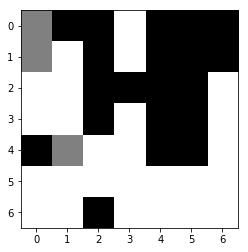

((3, 2), (4, 1)): n_v:  3230 q_all:+0.617750 q:+0.625955 q_m:+0.233333 p:0.564812
((6, 2), (4, 1)): n_v:  2578 q_all:+0.715147 q:+0.285376 q_m:+0.200000 p:0.008726
((0, 1), (1, 0)): n_v:     8 q_all:-0.374249 q:-0.227637 q_m:+0.033333 p:0.038265
((2, 2), (4, 1)): n_v:     6 q_all:+0.291831 q:+0.169016 q_m:+0.200000 p:0.012861
((2, 2), (1, 0)): n_v:     3 q_all:-0.452652 q:-0.568114 q_m:-0.000000 p:0.016481
((0, 2), (1, 0)): n_v:     2 q_all:+0.279869 q:-0.392345 q_m:-0.000000 p:0.005440
((2, 3), (4, 1)): n_v:     1 q_all:+0.092132 q:-0.078105 q_m:+0.200000 p:0.003938
((1, 2), (1, 0)): n_v:     0 q_all:-0.575795 q:-0.575795 q_m:-0.000000 p:0.000402
((2, 2), (0, 0)): n_v:     0 q_all:-0.747392 q:-0.747392 q_m:-0.133333 p:0.000001
((0, 2), (0, 0)): n_v:     0 q_all:-0.799268 q:-0.799268 q_m:-0.133333 p:0.000002
((0, 1), (0, 0)): n_v:     0 q_all:-0.835020 q:-0.835020 q_m:-0.100000 p:0.000008
((1, 2), (0, 0)): n_v:     0 q_all:-0.792975 q:-0.792975 q_m:-0.133333 p:0.000000
((3, 2), (1, 0))

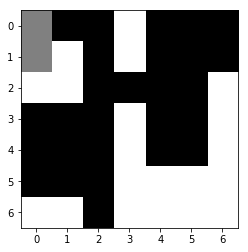

((1, 1), (1, 0)): n_v:  3199 q_all:-0.768196 q:-0.576799 q_m:-0.133333 p:0.250808
((2, 1), (0, 0)): n_v:   322 q_all:-0.871443 q:-0.750165 q_m:-0.166667 p:0.176228
((2, 0), (0, 0)): n_v:   251 q_all:-0.890559 q:-0.781721 q_m:-0.166667 p:0.159025
((1, 1), (0, 0)): n_v:    28 q_all:-0.939818 q:-0.865748 q_m:-0.133333 p:0.024179
########################p_sum is:  0.610238969326
-1 's turn
one move takes time(s):  0.056496381759643555
no. of data collected:  16


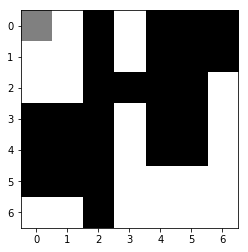

((0, 2), (0, 0)): n_v:  4051 q_all:+0.960708 q:+0.662276 q_m:+0.333333 p:0.866551
((2, 2), (0, 0)): n_v:    17 q_all:-0.461353 q:+0.271399 q_m:+0.333333 p:0.115309
((1, 2), (0, 0)): n_v:     3 q_all:-0.235246 q:+0.398346 q_m:+0.333333 p:0.016397
########################p_sum is:  0.998256674036
1 's turn
one move takes time(s):  0.055548667907714844
no. of data collected:  16


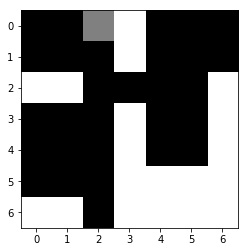

((2, 1), (0, 2)): n_v:  3811 q_all:-0.959226 q:-0.885620 q_m:-0.133333 p:0.131070
((0, 3), (0, 2)): n_v:  1380 q_all:-1.000000 q:+5.000000 q_m:-0.100000 p:0.284762
((2, 0), (0, 2)): n_v:  1060 q_all:-0.993942 q:-0.979620 q_m:-0.133333 p:0.191581
########################p_sum is:  0.60741341114
-1 's turn


This is a random move


one move takes time(s):  0.04142355918884277
no. of data collected:  8


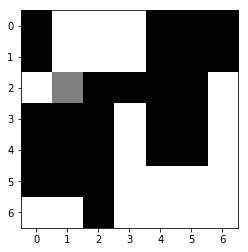

((1, 0), (2, 1)): n_v:  4486 q_all:+1.000000 q:+5.000000 q_m:+0.366667 p:0.262985
((0, 0), (2, 1)): n_v:   188 q_all:+0.991952 q:+0.978944 q_m:+0.333333 p:0.017586
((4, 0), (2, 1)): n_v:     2 q_all:+0.538626 q:+0.761772 q_m:+0.333333 p:0.003323
((4, 2), (2, 1)): n_v:     0 q_all:+0.378994 q:+0.378994 q_m:+0.333333 p:0.001033
((4, 1), (2, 1)): n_v:     0 q_all:+0.133195 q:+0.133195 q_m:+0.333333 p:0.000857
((2, 3), (2, 1)): n_v:     0 q_all:+0.363139 q:+0.363139 q_m:+0.333333 p:0.002403
########################p_sum is:  0.28818732308
this self play has 77 steps, time elapsed 79.8176703453064
winner is -1.0
episode 68 finished
episode 69 now start
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.3195350170135498
no. of data collected:  8
1 's turn
one move takes time(s):  0.3693885803222656
no. of data collected:  16
-1 's turn
one move takes time(s):  0.7349016666412354
no. of data collected:  16
1 's turn
one move takes time(s):  1.



This is a random move


one move takes time(s):  1.9177942276000977
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.255877733230591


This is a random move


one move takes time(s):  3.257765531539917
no. of data collected:  16
1 's turn
one move takes time(s):  1.7865362167358398
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.775275707244873
one move takes time(s):  2.777465343475342
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.3299334049224854
one move takes time(s):  2.331859827041626
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  1.8869006633758545
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.518968343734741


This is a random move


one move takes time(s):  2.520672559738159
no. of data collected:  16
-1 's turn


This is

one move takes time(s):  0.8418774604797363
no. of data collected:  16
1 's turn
one move takes time(s):  0.6813492774963379
no. of data collected:  32
-1 's turn
due to rollout lim, final rollout times:  2133 time elapsed:  2.0085020065307617
one move takes time(s):  2.010047435760498
no. of data collected:  16
1 's turn
one move takes time(s):  1.6915123462677002
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.221787929534912
one move takes time(s):  3.22330379486084
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.316359519958496
no. of data collected:  16
-1 's turn
one move takes time(s):  0.8822040557861328
no. of data collected:  24
1 's turn
one move takes time(s):  0.3809201717376709
no. of data collected:  24
-1 's turn


This is a random move


one move takes time(s):  0.5528502464294434
no. of data collected:  16
1 's turn
one move takes time(s):  0.4735748767852783
no. of data col

34000/34000 [==============================] - 3s 78us/step - loss: 0.8481 - activation_29_loss: 0.8123 - dense_15_loss: 0.0077 - val_loss: 0.8284 - val_activation_29_loss: 0.7916 - val_dense_15_loss: 0.0087
Epoch 25/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8480 - activation_29_loss: 0.8122 - dense_15_loss: 0.0077 - val_loss: 0.8283 - val_activation_29_loss: 0.7916 - val_dense_15_loss: 0.0087
Epoch 26/512
34000/34000 [==============================] - 3s 74us/step - loss: 0.8480 - activation_29_loss: 0.8121 - dense_15_loss: 0.0077 - val_loss: 0.8284 - val_activation_29_loss: 0.7916 - val_dense_15_loss: 0.0087
Epoch 27/512
34000/34000 [==============================] - 3s 78us/step - loss: 0.8477 - activation_29_loss: 0.8120 - dense_15_loss: 0.0076 - val_loss: 0.8285 - val_activation_29_loss: 0.7917 - val_dense_15_loss: 0.0087
Epoch 28/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8479 - activation_29_loss: 0.8120 - dense_15_l

34000/34000 [==============================] - 3s 79us/step - loss: 0.8437 - activation_29_loss: 0.8082 - dense_15_loss: 0.0074 - val_loss: 0.8294 - val_activation_29_loss: 0.7926 - val_dense_15_loss: 0.0087
Epoch 62/512
34000/34000 [==============================] - 3s 78us/step - loss: 0.8438 - activation_29_loss: 0.8082 - dense_15_loss: 0.0075 - val_loss: 0.8294 - val_activation_29_loss: 0.7926 - val_dense_15_loss: 0.0087
Epoch 63/512
34000/34000 [==============================] - 3s 83us/step - loss: 0.8437 - activation_29_loss: 0.8081 - dense_15_loss: 0.0075 - val_loss: 0.8294 - val_activation_29_loss: 0.7926 - val_dense_15_loss: 0.0087
Epoch 64/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8438 - activation_29_loss: 0.8081 - dense_15_loss: 0.0075 - val_loss: 0.8294 - val_activation_29_loss: 0.7926 - val_dense_15_loss: 0.0087
Epoch 65/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8435 - activation_29_loss: 0.8079 - dense_15_l

one move takes time(s):  1.4970111846923828
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.0236637592315674
one move takes time(s):  2.024940252304077
no. of data collected:  8
1 's turn
one move takes time(s):  1.8032126426696777
no. of data collected:  16
-1 's turn
one move takes time(s):  1.7895874977111816
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  1.3597989082336426
no. of data collected:  16
-1 's turn
one move takes time(s):  0.8252003192901611
no. of data collected:  16
1 's turn
one move takes time(s):  1.528113603591919
no. of data collected:  24
-1 's turn
one move takes time(s):  0.9461953639984131
no. of data collected:  16
1 's turn
one move takes time(s):  0.8748023509979248
no. of data collected:  24
-1 's turn
one move takes time(s):  1.3177597522735596
no. of data collected:  16
1 's turn
one move takes time(s):  1.1834557056427002
no. of data collected:  16
-1 's turn

one move takes time(s):  1.6325833797454834
no. of data collected:  24
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.5126876831054688


This is a random move


one move takes time(s):  2.5143353939056396
no. of data collected:  16
1 's turn
one move takes time(s):  1.4804093837738037
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.024580955505371


This is a random move


one move takes time(s):  2.0261824131011963
no. of data collected:  16
1 's turn
one move takes time(s):  0.864948034286499
no. of data collected:  16
-1 's turn
one move takes time(s):  0.7983922958374023
no. of data collected:  16
1 's turn
one move takes time(s):  0.9217631816864014
no. of data collected:  24
-1 's turn
one move takes time(s):  1.1921463012695312
no. of data collected:  16
1 's turn
one move takes time(s):  0.5384950637817383
no. of data collected:  16
-1 's turn
one move takes time(s):  0.513718843460083
no. of data

one move takes time(s):  1.9960575103759766
no. of data collected:  16
1 's turn
one move takes time(s):  1.629424810409546
no. of data collected:  16
-1 's turn
one move takes time(s):  1.8639178276062012
no. of data collected:  16
1 's turn
one move takes time(s):  1.2364754676818848
no. of data collected:  16
-1 's turn
one move takes time(s):  1.3385570049285889
no. of data collected:  24
1 's turn
one move takes time(s):  1.5454699993133545
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  1.3556396961212158
no. of data collected:  16
1 's turn
one move takes time(s):  1.298210859298706
no. of data collected:  16
-1 's turn
one move takes time(s):  1.9384651184082031
no. of data collected:  24
1 's turn
one move takes time(s):  1.657343864440918
no. of data collected:  16
-1 's turn
one move takes time(s):  1.065774917602539
no. of data collected:  16
1 's turn
one move takes time(s):  0.9709267616271973
no. of data collected:  16
-1 's turn


due to rollout lim, final rollout times:  2001 time elapsed:  4.474584579467773
one move takes time(s):  4.475967884063721
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.278864622116089
one move takes time(s):  2.2802534103393555
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.844296455383301
one move takes time(s):  2.8462164402008057
no. of data collected:  16
1 's turn
one move takes time(s):  1.9010066986083984
no. of data collected:  24
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  4.766929864883423


This is a random move


one move takes time(s):  4.768369913101196
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.0564262866973877
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.390373945236206
one move takes time(s):  2.3926303386688232
no. of data collec

due to rollout lim, final rollout times:  2001 time elapsed:  3.313807964324951
one move takes time(s):  3.3153505325317383
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  5.0171120166778564
one move takes time(s):  5.018575191497803
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  4.720067024230957
one move takes time(s):  4.721935510635376
no. of data collected:  16
1 's turn
due to time lim, final rollout times:  1807 time elapsed:  6.004563093185425
one move takes time(s):  6.00598406791687
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  4.848920106887817
one move takes time(s):  4.851168394088745
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.2018556594848633


This is a random move


one move takes time(s):  3.2034404277801514
no. of data collected:  8
-1 's turn
due to rollout 

due to rollout lim, final rollout times:  2126 time elapsed:  2.0073256492614746
one move takes time(s):  2.009068012237549
no. of data collected:  16
1 's turn
one move takes time(s):  1.6830365657806396
no. of data collected:  8
-1 's turn
one move takes time(s):  1.6920711994171143
no. of data collected:  16
1 's turn
one move takes time(s):  1.0061678886413574
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.822798490524292
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.692744016647339
one move takes time(s):  2.6942553520202637
no. of data collected:  8
-1 's turn
one move takes time(s):  1.4232280254364014
no. of data collected:  16
1 's turn
one move takes time(s):  0.8262448310852051
no. of data collected:  16
-1 's turn
one move takes time(s):  0.9260179996490479
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.3740196228027344
no. of data co

34000/34000 [==============================] - 3s 76us/step - loss: 0.8459 - activation_29_loss: 0.8098 - dense_15_loss: 0.0080 - val_loss: 0.8415 - val_activation_29_loss: 0.8061 - val_dense_15_loss: 0.0073
Epoch 25/512
34000/34000 [==============================] - 2s 74us/step - loss: 0.8455 - activation_29_loss: 0.8095 - dense_15_loss: 0.0079 - val_loss: 0.8415 - val_activation_29_loss: 0.8061 - val_dense_15_loss: 0.0073
Epoch 26/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8451 - activation_29_loss: 0.8091 - dense_15_loss: 0.0079 - val_loss: 0.8415 - val_activation_29_loss: 0.8061 - val_dense_15_loss: 0.0073
Epoch 27/512
34000/34000 [==============================] - 2s 73us/step - loss: 0.8451 - activation_29_loss: 0.8091 - dense_15_loss: 0.0079 - val_loss: 0.8416 - val_activation_29_loss: 0.8062 - val_dense_15_loss: 0.0073
Epoch 28/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8449 - activation_29_loss: 0.8090 - dense_15_l

34000/34000 [==============================] - 3s 76us/step - loss: 0.8409 - activation_29_loss: 0.8051 - dense_15_loss: 0.0077 - val_loss: 0.8425 - val_activation_29_loss: 0.8072 - val_dense_15_loss: 0.0072
Epoch 62/512
34000/34000 [==============================] - 3s 78us/step - loss: 0.8410 - activation_29_loss: 0.8053 - dense_15_loss: 0.0077 - val_loss: 0.8426 - val_activation_29_loss: 0.8072 - val_dense_15_loss: 0.0073
Epoch 63/512
34000/34000 [==============================] - 3s 78us/step - loss: 0.8411 - activation_29_loss: 0.8053 - dense_15_loss: 0.0077 - val_loss: 0.8426 - val_activation_29_loss: 0.8072 - val_dense_15_loss: 0.0073
Epoch 64/512
34000/34000 [==============================] - 3s 78us/step - loss: 0.8407 - activation_29_loss: 0.8050 - dense_15_loss: 0.0077 - val_loss: 0.8427 - val_activation_29_loss: 0.8073 - val_dense_15_loss: 0.0072
Epoch 65/512
34000/34000 [==============================] - 3s 74us/step - loss: 0.8407 - activation_29_loss: 0.8049 - dense_15_l

due to rollout lim, final rollout times:  2001 time elapsed:  3.9914093017578125
one move takes time(s):  3.9928038120269775
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.0827999114990234
one move takes time(s):  3.0842690467834473
no. of data collected:  8
1 's turn
one move takes time(s):  1.6875269412994385
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.9973702430725098
one move takes time(s):  2.9988887310028076
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.791952610015869
one move takes time(s):  2.793309450149536
no. of data collected:  24
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.290031909942627
one move takes time(s):  2.291383743286133
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.363386869430542
one move takes time(s):  2.36467



This is a random move


one move takes time(s):  0.31240081787109375
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.4229433536529541
no. of data collected:  16
-1 's turn
one move takes time(s):  0.7549896240234375
no. of data collected:  16
1 's turn
one move takes time(s):  1.1231715679168701
no. of data collected:  16
-1 's turn
one move takes time(s):  1.9044718742370605
no. of data collected:  16
1 's turn
one move takes time(s):  1.7214374542236328
no. of data collected:  16
-1 's turn
one move takes time(s):  0.5254180431365967
no. of data collected:  16
1 's turn
one move takes time(s):  0.860161304473877
no. of data collected:  16
-1 's turn
one move takes time(s):  1.3005406856536865
no. of data collected:  24
1 's turn
one move takes time(s):  1.166090965270996
no. of data collected:  24
-1 's turn
one move takes time(s):  0.7784905433654785
no. of data collected:  16
1 's turn
one move takes time(s):  1.3389337062835693
no. of dat



This is a random move


one move takes time(s):  1.992964506149292
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2074 time elapsed:  2.0008769035339355
one move takes time(s):  2.003199338912964
no. of data collected:  8
-1 's turn
one move takes time(s):  1.7424132823944092
no. of data collected:  16
1 's turn
one move takes time(s):  0.9088485240936279
no. of data collected:  16
-1 's turn
one move takes time(s):  1.7665653228759766
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  1.075653076171875
no. of data collected:  24
-1 's turn
one move takes time(s):  1.1306781768798828
no. of data collected:  16
1 's turn
one move takes time(s):  1.2586286067962646
no. of data collected:  16
-1 's turn
one move takes time(s):  0.9629781246185303
no. of data collected:  16
1 's turn
one move takes time(s):  1.8358583450317383
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  1.946

one move takes time(s):  0.47989344596862793
no. of data collected:  24
-1 's turn
one move takes time(s):  0.4286823272705078
no. of data collected:  24
1 's turn
one move takes time(s):  0.4912712574005127
no. of data collected:  16
-1 's turn
one move takes time(s):  0.375124454498291
no. of data collected:  16
1 's turn
one move takes time(s):  0.33313512802124023
no. of data collected:  24
-1 's turn
one move takes time(s):  0.38910388946533203
no. of data collected:  16
1 's turn
one move takes time(s):  0.4655160903930664
no. of data collected:  24
-1 's turn
one move takes time(s):  0.40286874771118164
no. of data collected:  24
1 's turn
one move takes time(s):  0.4860384464263916
no. of data collected:  16
-1 's turn
one move takes time(s):  0.39823269844055176
no. of data collected:  16
1 's turn
one move takes time(s):  0.3098759651184082
no. of data collected:  24
-1 's turn
one move takes time(s):  0.3744168281555176
no. of data collected:  16
1 's turn
one move takes tim

one move takes time(s):  1.6123936176300049
no. of data collected:  16
-1 's turn
one move takes time(s):  0.9580302238464355
no. of data collected:  16
1 's turn
one move takes time(s):  1.1783883571624756
no. of data collected:  16
-1 's turn
one move takes time(s):  0.8485891819000244
no. of data collected:  16
1 's turn
one move takes time(s):  0.9486985206604004
no. of data collected:  16
-1 's turn
one move takes time(s):  1.5096547603607178
no. of data collected:  16
1 's turn
one move takes time(s):  1.3517930507659912
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.8033909797668457
one move takes time(s):  2.8059589862823486
no. of data collected:  16
1 's turn
one move takes time(s):  1.4852008819580078
no. of data collected:  16
-1 's turn
one move takes time(s):  1.9470922946929932
no. of data collected:  16
1 's turn
one move takes time(s):  0.7000851631164551
no. of data collected:  16
-1 's turn


This is a random mov

one move takes time(s):  0.7299942970275879
no. of data collected:  16
1 's turn
one move takes time(s):  1.6127655506134033
no. of data collected:  16
-1 's turn
one move takes time(s):  1.085946798324585
no. of data collected:  16
1 's turn
one move takes time(s):  1.2076096534729004
no. of data collected:  16
-1 's turn
one move takes time(s):  0.8193776607513428
no. of data collected:  16
1 's turn
one move takes time(s):  0.8740391731262207
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  1.0571422576904297
no. of data collected:  16
1 's turn
one move takes time(s):  0.6469228267669678
no. of data collected:  16
-1 's turn
one move takes time(s):  0.9746429920196533
no. of data collected:  24
1 's turn
one move takes time(s):  0.8802299499511719
no. of data collected:  16
-1 's turn
one move takes time(s):  0.7958478927612305
no. of data collected:  16
1 's turn
one move takes time(s):  0.5837440490722656
no. of data collected:  16
-1 's tu

Epoch 19/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8522 - activation_29_loss: 0.8162 - dense_15_loss: 0.0080 - val_loss: 0.8421 - val_activation_29_loss: 0.8057 - val_dense_15_loss: 0.0083
Epoch 20/512
34000/34000 [==============================] - 3s 81us/step - loss: 0.8521 - activation_29_loss: 0.8160 - dense_15_loss: 0.0080 - val_loss: 0.8421 - val_activation_29_loss: 0.8057 - val_dense_15_loss: 0.0083
Epoch 21/512
34000/34000 [==============================] - 2s 73us/step - loss: 0.8520 - activation_29_loss: 0.8159 - dense_15_loss: 0.0080 - val_loss: 0.8422 - val_activation_29_loss: 0.8058 - val_dense_15_loss: 0.0083
Epoch 22/512
34000/34000 [==============================] - 2s 73us/step - loss: 0.8518 - activation_29_loss: 0.8157 - dense_15_loss: 0.0080 - val_loss: 0.8422 - val_activation_29_loss: 0.8057 - val_dense_15_loss: 0.0083
Epoch 23/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8516 - activation_29_loss: 0.8155

34000/34000 [==============================] - 3s 76us/step - loss: 0.8472 - activation_29_loss: 0.8114 - dense_15_loss: 0.0077 - val_loss: 0.8426 - val_activation_29_loss: 0.8063 - val_dense_15_loss: 0.0083
Epoch 57/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8471 - activation_29_loss: 0.8112 - dense_15_loss: 0.0077 - val_loss: 0.8426 - val_activation_29_loss: 0.8063 - val_dense_15_loss: 0.0082
Epoch 58/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8468 - activation_29_loss: 0.8110 - dense_15_loss: 0.0077 - val_loss: 0.8426 - val_activation_29_loss: 0.8063 - val_dense_15_loss: 0.0082
Epoch 59/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8470 - activation_29_loss: 0.8112 - dense_15_loss: 0.0077 - val_loss: 0.8426 - val_activation_29_loss: 0.8063 - val_dense_15_loss: 0.0082
Epoch 60/512
34000/34000 [==============================] - 2s 72us/step - loss: 0.8467 - activation_29_loss: 0.8109 - dense_15_l

34000/34000 [==============================] - 3s 78us/step - loss: 0.8434 - activation_29_loss: 0.8078 - dense_15_loss: 0.0076 - val_loss: 0.8432 - val_activation_29_loss: 0.8069 - val_dense_15_loss: 0.0082
Epoch 94/512
34000/34000 [==============================] - 3s 79us/step - loss: 0.8436 - activation_29_loss: 0.8079 - dense_15_loss: 0.0076 - val_loss: 0.8432 - val_activation_29_loss: 0.8069 - val_dense_15_loss: 0.0082
Epoch 95/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8435 - activation_29_loss: 0.8078 - dense_15_loss: 0.0076 - val_loss: 0.8432 - val_activation_29_loss: 0.8070 - val_dense_15_loss: 0.0082
Epoch 96/512
34000/34000 [==============================] - 3s 79us/step - loss: 0.8433 - activation_29_loss: 0.8077 - dense_15_loss: 0.0076 - val_loss: 0.8432 - val_activation_29_loss: 0.8070 - val_dense_15_loss: 0.0082
Epoch 97/512
34000/34000 [==============================] - 3s 83us/step - loss: 0.8430 - activation_29_loss: 0.8074 - dense_15_l

one move takes time(s):  0.4999210834503174
no. of data collected:  24
1 's turn
one move takes time(s):  0.21497297286987305
no. of data collected:  16
-1 's turn
one move takes time(s):  0.1822218894958496
no. of data collected:  24
1 's turn
one move takes time(s):  0.16796398162841797
no. of data collected:  16
-1 's turn
one move takes time(s):  0.1084752082824707
no. of data collected:  24
1 's turn
one move takes time(s):  0.11166787147521973
no. of data collected:  16
-1 's turn
one move takes time(s):  0.13249707221984863
no. of data collected:  24
1 's turn
one move takes time(s):  0.15217065811157227
no. of data collected:  24
-1 's turn


This is a random move


one move takes time(s):  0.21066856384277344
no. of data collected:  16
1 's turn
one move takes time(s):  0.08266711235046387
no. of data collected:  16
-1 's turn
one move takes time(s):  0.05211138725280762
no. of data collected:  16
1 's turn
one move takes time(s):  0.03206586837768555
no. of data collected:  8

one move takes time(s):  0.6801302433013916
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.5545346736907959
no. of data collected:  16
1 's turn
one move takes time(s):  0.8259141445159912
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.9097692966461182
no. of data collected:  16
1 's turn
one move takes time(s):  0.6535193920135498
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.5335209369659424
no. of data collected:  24
1 's turn
one move takes time(s):  0.6110532283782959
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.3246486186981201
no. of data collected:  16
1 's turn
one move takes time(s):  0.25061750411987305
no. of data collected:  16
-1 's turn
one move takes time(s):  0.3023948669433594
no. of data collected:  16
1 's turn
one move takes time(s):  0.24196362495422363
no. of data collected:  16
-1 's tu

one move takes time(s):  0.2408304214477539
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.25945591926574707
no. of data collected:  16
-1 's turn
one move takes time(s):  0.2908158302307129
no. of data collected:  16
1 's turn
one move takes time(s):  0.20301222801208496
no. of data collected:  16
-1 's turn
one move takes time(s):  0.2621195316314697
no. of data collected:  16
1 's turn
one move takes time(s):  0.21365857124328613
no. of data collected:  24
-1 's turn
one move takes time(s):  0.31979990005493164
no. of data collected:  24
1 's turn
one move takes time(s):  0.17598390579223633
no. of data collected:  16
-1 's turn
one move takes time(s):  0.11528205871582031
no. of data collected:  16
1 's turn
one move takes time(s):  0.08386874198913574
no. of data collected:  16
-1 's turn
one move takes time(s):  0.09443020820617676
no. of data collected:  24
1 's turn
one move takes time(s):  0.07871699333190918
no. of data collected:  1

one move takes time(s):  0.4524807929992676
no. of data collected:  24
1 's turn
one move takes time(s):  0.14499783515930176
no. of data collected:  16
-1 's turn
one move takes time(s):  0.2143080234527588
no. of data collected:  24
1 's turn
one move takes time(s):  0.13812923431396484
no. of data collected:  24
-1 's turn
one move takes time(s):  0.19538426399230957
no. of data collected:  24
1 's turn
one move takes time(s):  0.1811835765838623
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.08364391326904297
no. of data collected:  24
1 's turn


This is a random move


one move takes time(s):  0.05575418472290039
no. of data collected:  24
-1 's turn
one move takes time(s):  0.052161455154418945
no. of data collected:  8
this self play has 85 steps, time elapsed 79.79852175712585
winner is -1.0
107408  data in database
40000  data expected
40000  data grabbed
start training, training data no. 40000
Train on 34000 samples, validate on 60

34000/34000 [==============================] - 3s 77us/step - loss: 0.8403 - activation_29_loss: 0.8039 - dense_15_loss: 0.0083 - val_loss: 0.8499 - val_activation_29_loss: 0.8139 - val_dense_15_loss: 0.0079
Epoch 34/512
34000/34000 [==============================] - 3s 79us/step - loss: 0.8400 - activation_29_loss: 0.8036 - dense_15_loss: 0.0082 - val_loss: 0.8500 - val_activation_29_loss: 0.8140 - val_dense_15_loss: 0.0079
Epoch 35/512
34000/34000 [==============================] - 3s 78us/step - loss: 0.8400 - activation_29_loss: 0.8036 - dense_15_loss: 0.0083 - val_loss: 0.8500 - val_activation_29_loss: 0.8140 - val_dense_15_loss: 0.0079
Epoch 36/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8397 - activation_29_loss: 0.8034 - dense_15_loss: 0.0082 - val_loss: 0.8501 - val_activation_29_loss: 0.8141 - val_dense_15_loss: 0.0079
Epoch 37/512
34000/34000 [==============================] - 3s 74us/step - loss: 0.8397 - activation_29_loss: 0.8033 - dense_15_l

34000/34000 [==============================] - 3s 76us/step - loss: 0.8357 - activation_29_loss: 0.7996 - dense_15_loss: 0.0080 - val_loss: 0.8511 - val_activation_29_loss: 0.8151 - val_dense_15_loss: 0.0079
Epoch 71/512
34000/34000 [==============================] - 3s 84us/step - loss: 0.8356 - activation_29_loss: 0.7995 - dense_15_loss: 0.0080 - val_loss: 0.8511 - val_activation_29_loss: 0.8151 - val_dense_15_loss: 0.0079
Epoch 72/512
34000/34000 [==============================] - 3s 78us/step - loss: 0.8354 - activation_29_loss: 0.7993 - dense_15_loss: 0.0080 - val_loss: 0.8512 - val_activation_29_loss: 0.8151 - val_dense_15_loss: 0.0079
Epoch 73/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8354 - activation_29_loss: 0.7993 - dense_15_loss: 0.0080 - val_loss: 0.8511 - val_activation_29_loss: 0.8151 - val_dense_15_loss: 0.0079
Epoch 74/512
34000/34000 [==============================] - 3s 79us/step - loss: 0.8353 - activation_29_loss: 0.7992 - dense_15_l

one move takes time(s):  0.8290822505950928
no. of data collected:  16
1 's turn
one move takes time(s):  1.1028144359588623
no. of data collected:  16
-1 's turn
one move takes time(s):  0.5635836124420166
no. of data collected:  24
1 's turn
one move takes time(s):  1.4897408485412598
no. of data collected:  16
-1 's turn
one move takes time(s):  0.9696104526519775
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.1114509105682373
one move takes time(s):  2.1129469871520996
no. of data collected:  16
-1 's turn
one move takes time(s):  1.2085521221160889
no. of data collected:  16
1 's turn
one move takes time(s):  1.3563861846923828
no. of data collected:  16
-1 's turn
one move takes time(s):  0.940803050994873
no. of data collected:  24
1 's turn
one move takes time(s):  1.4548144340515137
no. of data collected:  16
-1 's turn
one move takes time(s):  0.733496904373169
no. of data collected:  16
1 's turn
one move takes time(s):  

due to rollout lim, final rollout times:  2001 time elapsed:  2.2619822025299072
one move takes time(s):  2.2648186683654785
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.770311117172241
one move takes time(s):  3.7726051807403564
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.939439535140991


This is a random move


one move takes time(s):  2.9409737586975098
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.2785181999206543
one move takes time(s):  3.279775857925415
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  2138 time elapsed:  2.0000548362731934
one move takes time(s):  2.0013022422790527
no. of data collected:  16
-1 's turn
one move takes time(s):  1.5811786651611328
no. of data collected:  16
1 's turn
one move takes time(s):  0.8409585952758789
no. of data collected:  16
-1 's turn
one 

one move takes time(s):  1.472954511642456
no. of data collected:  16
-1 's turn
one move takes time(s):  1.922802209854126
no. of data collected:  16
1 's turn
one move takes time(s):  1.902045726776123
no. of data collected:  16
-1 's turn
one move takes time(s):  1.8715600967407227
no. of data collected:  16
1 's turn
one move takes time(s):  1.5474772453308105
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.8781399726867676
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  1.3664042949676514
no. of data collected:  16
-1 's turn
one move takes time(s):  1.5314912796020508
no. of data collected:  24
1 's turn
one move takes time(s):  0.8921627998352051
no. of data collected:  24
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.485161781311035
one move takes time(s):  2.486804246902466
no. of data collected:  16
1 's turn
one move takes time(s):  0.9991226196289062
no. of data c

due to rollout lim, final rollout times:  2001 time elapsed:  3.273130416870117
one move takes time(s):  3.2747509479522705
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  4.208028078079224
one move takes time(s):  4.209584474563599
no. of data collected:  16
-1 's turn
one move takes time(s):  1.6038603782653809
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.9533863067626953


This is a random move


one move takes time(s):  3.956467866897583
no. of data collected:  16
-1 's turn
one move takes time(s):  1.346703052520752
no. of data collected:  24
1 's turn
due to rollout lim, final rollout times:  2099 time elapsed:  2.0010814666748047
one move takes time(s):  2.003058433532715
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  1.0353329181671143
no. of data collected:  16
1 's turn
one move takes time(s):  1.3006713390350342
no. of data coll

one move takes time(s):  1.9581611156463623
no. of data collected:  16
1 's turn
one move takes time(s):  1.0634007453918457
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  1.1472976207733154
no. of data collected:  16
1 's turn
one move takes time(s):  0.7070767879486084
no. of data collected:  24
-1 's turn
one move takes time(s):  1.0325405597686768
no. of data collected:  16
1 's turn
one move takes time(s):  0.8372347354888916
no. of data collected:  16
-1 's turn
one move takes time(s):  1.015394926071167
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.6665897369384766
no. of data collected:  16
-1 's turn
one move takes time(s):  0.8197143077850342
no. of data collected:  16
1 's turn
one move takes time(s):  0.3553786277770996
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.8292813301086426
no. of data collected:  24
1 's turn
one move takes time(s):  1.

34000/34000 [==============================] - 2s 73us/step - loss: 0.8431 - activation_29_loss: 0.8061 - dense_15_loss: 0.0089 - val_loss: 0.8488 - val_activation_29_loss: 0.8115 - val_dense_15_loss: 0.0093
Epoch 20/512
34000/34000 [==============================] - 2s 73us/step - loss: 0.8428 - activation_29_loss: 0.8058 - dense_15_loss: 0.0089 - val_loss: 0.8488 - val_activation_29_loss: 0.8115 - val_dense_15_loss: 0.0092
Epoch 21/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8427 - activation_29_loss: 0.8058 - dense_15_loss: 0.0088 - val_loss: 0.8488 - val_activation_29_loss: 0.8115 - val_dense_15_loss: 0.0092
Epoch 22/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8425 - activation_29_loss: 0.8055 - dense_15_loss: 0.0089 - val_loss: 0.8489 - val_activation_29_loss: 0.8116 - val_dense_15_loss: 0.0093
Epoch 23/512
34000/34000 [==============================] - 3s 78us/step - loss: 0.8427 - activation_29_loss: 0.8057 - dense_15_l

34000/34000 [==============================] - 3s 79us/step - loss: 0.8380 - activation_29_loss: 0.8013 - dense_15_loss: 0.0086 - val_loss: 0.8498 - val_activation_29_loss: 0.8126 - val_dense_15_loss: 0.0091
Epoch 57/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8378 - activation_29_loss: 0.8012 - dense_15_loss: 0.0086 - val_loss: 0.8498 - val_activation_29_loss: 0.8126 - val_dense_15_loss: 0.0091
Epoch 58/512
34000/34000 [==============================] - 3s 81us/step - loss: 0.8377 - activation_29_loss: 0.8010 - dense_15_loss: 0.0086 - val_loss: 0.8499 - val_activation_29_loss: 0.8127 - val_dense_15_loss: 0.0091
Epoch 59/512
34000/34000 [==============================] - 3s 81us/step - loss: 0.8375 - activation_29_loss: 0.8009 - dense_15_loss: 0.0085 - val_loss: 0.8499 - val_activation_29_loss: 0.8127 - val_dense_15_loss: 0.0091
Epoch 60/512
34000/34000 [==============================] - 3s 78us/step - loss: 0.8374 - activation_29_loss: 0.8007 - dense_15_l

due to rollout lim, final rollout times:  2001 time elapsed:  3.9324750900268555
one move takes time(s):  3.933936834335327
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.6899232864379883
one move takes time(s):  2.691258668899536
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  4.11775541305542
one move takes time(s):  4.119149446487427
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.0863096714019775
one move takes time(s):  3.087951183319092
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.4056692123413086
one move takes time(s):  2.4069719314575195
no. of data collected:  16
1 's turn
one move takes time(s):  1.2473540306091309
no. of data collected:  16
-1 's turn
one move takes time(s):  1.5803124904632568
no. of data collected:  16
1 's turn
due to rollout lim, final rollo

one move takes time(s):  0.8312876224517822
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  1.0195033550262451
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.571890115737915
one move takes time(s):  2.57334041595459
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.301194906234741
one move takes time(s):  2.3037052154541016
no. of data collected:  8
-1 's turn
one move takes time(s):  1.631730556488037
no. of data collected:  16
1 's turn
one move takes time(s):  1.1461410522460938
no. of data collected:  16
-1 's turn
one move takes time(s):  1.5449202060699463
no. of data collected:  16
1 's turn
one move takes time(s):  1.762786865234375
no. of data collected:  24
-1 's turn
due to rollout lim, final rollout times:  2156 time elapsed:  2.005934953689575
one move takes time(s):  2.0073742866516113
no. of data collected:  16
1 's turn
one mov

due to rollout lim, final rollout times:  2001 time elapsed:  2.0021822452545166


This is a random move


one move takes time(s):  2.0038201808929443
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.9565153121948242
no. of data collected:  8
1 's turn
one move takes time(s):  1.1609272956848145
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.2376086711883545
one move takes time(s):  3.2397961616516113
no. of data collected:  24
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.790419816970825
one move takes time(s):  2.79195237159729
no. of data collected:  8
-1 's turn
one move takes time(s):  1.3423874378204346
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.7358880043029785
one move takes time(s):  2.7373647689819336
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed

one move takes time(s):  0.31031250953674316
no. of data collected:  16
1 's turn
one move takes time(s):  0.24136972427368164
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.3730037212371826
no. of data collected:  16
1 's turn
one move takes time(s):  0.2829718589782715
no. of data collected:  16
-1 's turn
one move takes time(s):  0.3176546096801758
no. of data collected:  16
1 's turn
one move takes time(s):  0.26643824577331543
no. of data collected:  24
-1 's turn


This is a random move


one move takes time(s):  0.29819583892822266
no. of data collected:  16
1 's turn
one move takes time(s):  0.2661585807800293
no. of data collected:  24
-1 's turn
one move takes time(s):  0.20605111122131348
no. of data collected:  16
1 's turn
one move takes time(s):  0.17446470260620117
no. of data collected:  24
-1 's turn


This is a random move


one move takes time(s):  0.16737890243530273
no. of data collected:  16
1 's turn


This is a random 

one move takes time(s):  1.5910663604736328
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.5868334770202637
no. of data collected:  16
1 's turn
one move takes time(s):  0.2690107822418213
no. of data collected:  16
-1 's turn
one move takes time(s):  0.3308849334716797
no. of data collected:  24
1 's turn


This is a random move


one move takes time(s):  0.27292585372924805
no. of data collected:  16
-1 's turn
one move takes time(s):  0.21860814094543457
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.19803547859191895
no. of data collected:  24
-1 's turn


This is a random move


one move takes time(s):  0.20674633979797363
no. of data collected:  24
1 's turn
one move takes time(s):  0.1310126781463623
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.15923213958740234
no. of data collected:  24
1 's turn
one move takes time(s):  0.26663923263549805
no. o

one move takes time(s):  0.11398434638977051
no. of data collected:  24
1 's turn


This is a random move


one move takes time(s):  0.07626080513000488
no. of data collected:  16
-1 's turn
one move takes time(s):  0.060610055923461914
no. of data collected:  16
1 's turn
one move takes time(s):  0.032526493072509766
no. of data collected:  8
this self play has 78 steps, time elapsed 64.41078662872314
winner is 1.0
107136  data in database
40000  data expected
40000  data grabbed
start training, training data no. 40000
Train on 34000 samples, validate on 6000 samples
Epoch 1/512
34000/34000 [==============================] - 3s 83us/step - loss: 0.8557 - activation_29_loss: 0.8186 - dense_15_loss: 0.0091 - val_loss: 0.8418 - val_activation_29_loss: 0.8057 - val_dense_15_loss: 0.0081
Epoch 2/512
34000/34000 [==============================] - 2s 73us/step - loss: 0.8556 - activation_29_loss: 0.8185 - dense_15_loss: 0.0090 - val_loss: 0.8417 - val_activation_29_loss: 0.8056 - val_dense_1

34000/34000 [==============================] - 3s 77us/step - loss: 0.8487 - activation_29_loss: 0.8120 - dense_15_loss: 0.0086 - val_loss: 0.8422 - val_activation_29_loss: 0.8060 - val_dense_15_loss: 0.0081
Epoch 36/512
34000/34000 [==============================] - 2s 72us/step - loss: 0.8483 - activation_29_loss: 0.8117 - dense_15_loss: 0.0085 - val_loss: 0.8423 - val_activation_29_loss: 0.8061 - val_dense_15_loss: 0.0082
Epoch 37/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8486 - activation_29_loss: 0.8119 - dense_15_loss: 0.0086 - val_loss: 0.8424 - val_activation_29_loss: 0.8061 - val_dense_15_loss: 0.0082
Epoch 38/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8481 - activation_29_loss: 0.8115 - dense_15_loss: 0.0085 - val_loss: 0.8423 - val_activation_29_loss: 0.8061 - val_dense_15_loss: 0.0082
Epoch 39/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8484 - activation_29_loss: 0.8117 - dense_15_l

34000/34000 [==============================] - 3s 81us/step - loss: 0.8442 - activation_29_loss: 0.8078 - dense_15_loss: 0.0083 - val_loss: 0.8432 - val_activation_29_loss: 0.8069 - val_dense_15_loss: 0.0082
Epoch 73/512
34000/34000 [==============================] - 3s 79us/step - loss: 0.8440 - activation_29_loss: 0.8077 - dense_15_loss: 0.0082 - val_loss: 0.8432 - val_activation_29_loss: 0.8070 - val_dense_15_loss: 0.0082
Epoch 74/512
34000/34000 [==============================] - 3s 80us/step - loss: 0.8442 - activation_29_loss: 0.8079 - dense_15_loss: 0.0083 - val_loss: 0.8432 - val_activation_29_loss: 0.8070 - val_dense_15_loss: 0.0082
Epoch 75/512
34000/34000 [==============================] - 3s 79us/step - loss: 0.8442 - activation_29_loss: 0.8078 - dense_15_loss: 0.0083 - val_loss: 0.8433 - val_activation_29_loss: 0.8071 - val_dense_15_loss: 0.0082
Epoch 76/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8437 - activation_29_loss: 0.8074 - dense_15_l

due to rollout lim, final rollout times:  2001 time elapsed:  5.875570058822632
one move takes time(s):  5.8770225048065186
no. of data collected:  8
-1 's turn
due to time lim, final rollout times:  755 time elapsed:  5.994829416275024
one move takes time(s):  5.996524810791016
no. of data collected:  0
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.505354166030884
one move takes time(s):  3.5067765712738037
no. of data collected:  16
-1 's turn
due to time lim, final rollout times:  1341 time elapsed:  5.994251251220703
one move takes time(s):  5.996609210968018
no. of data collected:  24
1 's turn
due to time lim, final rollout times:  1109 time elapsed:  5.994093418121338


This is a random move


one move takes time(s):  5.995160818099976
no. of data collected:  8
-1 's turn
due to time lim, final rollout times:  1840 time elapsed:  6.016338348388672
one move takes time(s):  6.0183610916137695
no. of data collected:  8
1 's turn
due to rollout lim, final

episode 96 finished
episode 97 now start
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.2982051372528076
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.36316394805908203
no. of data collected:  16
-1 's turn
one move takes time(s):  0.6527645587921143
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.993035078048706
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  1.846278429031372
no. of data collected:  8
1 's turn
one move takes time(s):  1.7457435131072998
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.532470464706421
one move takes time(s):  2.5332531929016113
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.855719804763794


This is a random move


one move takes time(s):  3.857508897781372
no. of data 



This is a random move


one move takes time(s):  0.22005033493041992
no. of data collected:  16
-1 's turn
one move takes time(s):  0.1573491096496582
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.14719367027282715
no. of data collected:  16
-1 's turn
one move takes time(s):  0.1388075351715088
no. of data collected:  16
1 's turn
one move takes time(s):  0.13784456253051758
no. of data collected:  24
-1 's turn
one move takes time(s):  0.10565328598022461
no. of data collected:  16
1 's turn
one move takes time(s):  0.09878301620483398
no. of data collected:  16
-1 's turn
one move takes time(s):  0.046851396560668945
no. of data collected:  8
this self play has 79 steps, time elapsed 575.6746752262115
winner is -1.0
episode 97 finished
episode 98 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.3727905750274658
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.487

one move takes time(s):  0.18197154998779297
no. of data collected:  16
-1 's turn
one move takes time(s):  0.15401124954223633
no. of data collected:  24
1 's turn


This is a random move


one move takes time(s):  0.11868929862976074
no. of data collected:  16
-1 's turn
one move takes time(s):  0.1290140151977539
no. of data collected:  24
1 's turn
one move takes time(s):  0.18975090980529785
no. of data collected:  24
-1 's turn
one move takes time(s):  0.10492372512817383
no. of data collected:  16
1 's turn
one move takes time(s):  0.04430580139160156
no. of data collected:  8
this self play has 78 steps, time elapsed 102.14512181282043
winner is -1.0
episode 98 finished
episode 99 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.3247535228729248
no. of data collected:  8
1 's turn
one move takes time(s):  0.4307727813720703
no. of data collected:  16
-1 's turn
one move takes time(s):  0.8498015403747559
no. of data collected:  24
1 's turn



one move takes time(s):  0.1057748794555664
no. of data collected:  16
1 's turn
one move takes time(s):  0.09247422218322754
no. of data collected:  24
-1 's turn


This is a random move


one move takes time(s):  0.10962653160095215
no. of data collected:  16
1 's turn
one move takes time(s):  0.04875636100769043
no. of data collected:  8
this self play has 70 steps, time elapsed 114.75862312316895
winner is 1.0
episode 99 finished
episode 100 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.3067042827606201
no. of data collected:  8


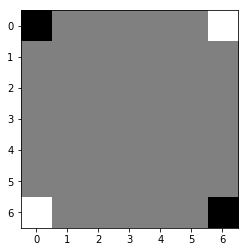

((6, 6), (5, 5)): n_v:  1162 q_all:+0.018259 q:+0.009060 q_m:+0.033333 p:0.490596
((0, 0), (1, 1)): n_v:  1033 q_all:+0.008835 q:+0.023214 q_m:+0.033333 p:0.505651
((6, 6), (6, 5)): n_v:     2 q_all:+0.017753 q:+0.010955 q_m:+0.033333 p:0.001142
((6, 6), (5, 6)): n_v:     1 q_all:+0.003542 q:+0.013883 q_m:+0.033333 p:0.000474
((0, 0), (0, 1)): n_v:     1 q_all:+0.005365 q:+0.009343 q_m:+0.033333 p:0.000990
((0, 0), (1, 0)): n_v:     1 q_all:+0.012288 q:+0.016431 q_m:+0.033333 p:0.000557
((6, 6), (6, 4)): n_v:     0 q_all:-0.001493 q:-0.001493 q_m:-0.000000 p:0.000019
((0, 0), (1, 2)): n_v:     0 q_all:-0.010673 q:-0.010673 q_m:-0.000000 p:0.000025
((0, 0), (2, 2)): n_v:     0 q_all:-0.004194 q:-0.004194 q_m:-0.000000 p:0.000092
((0, 0), (0, 2)): n_v:     0 q_all:-0.017239 q:-0.017239 q_m:-0.000000 p:0.000022
((6, 6), (4, 6)): n_v:     0 q_all:+0.007776 q:+0.007776 q_m:-0.000000 p:0.000074
((6, 6), (5, 4)): n_v:     0 q_all:+0.004945 q:+0.004945 q_m:-0.000000 p:0.000036
((6, 6), (4, 4))

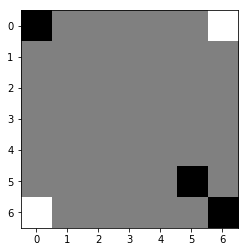

((6, 0), (5, 1)): n_v:  2079 q_all:-0.025734 q:-0.020863 q_m:-0.000000 p:0.622719
((0, 6), (1, 5)): n_v:  1115 q_all:-0.023843 q:-0.020954 q_m:-0.000000 p:0.321750
((6, 0), (5, 0)): n_v:    80 q_all:-0.024755 q:-0.028749 q_m:-0.000000 p:0.023536
((6, 0), (6, 1)): n_v:    43 q_all:-0.029853 q:-0.020454 q_m:-0.000000 p:0.014085
((0, 6), (1, 6)): n_v:    26 q_all:-0.029992 q:-0.028300 q_m:-0.000000 p:0.008564
((0, 6), (0, 5)): n_v:    14 q_all:-0.034207 q:-0.031410 q_m:-0.000000 p:0.005040
((6, 0), (4, 2)): n_v:     2 q_all:-0.043095 q:-0.055611 q_m:-0.033333 p:0.001170
((0, 6), (2, 4)): n_v:     1 q_all:-0.045528 q:-0.040120 q_m:-0.033333 p:0.000494
((6, 0), (6, 2)): n_v:     1 q_all:-0.048229 q:-0.047155 q_m:-0.033333 p:0.000730
((6, 0), (5, 2)): n_v:     1 q_all:-0.048678 q:-0.047693 q_m:-0.033333 p:0.000729
((6, 0), (4, 1)): n_v:     0 q_all:-0.032761 q:-0.032761 q_m:-0.033333 p:0.000242
((0, 6), (2, 6)): n_v:     0 q_all:-0.042225 q:-0.042225 q_m:-0.033333 p:0.000104
((0, 6), (0, 4))

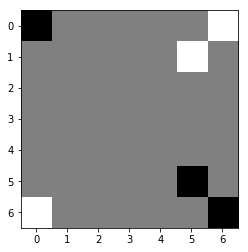

((0, 0), (1, 1)): n_v:  2448 q_all:+0.020350 q:+0.021436 q_m:+0.033333 p:0.733578
((5, 5), (4, 4)): n_v:   784 q_all:+0.020805 q:+0.013924 q_m:+0.033333 p:0.233070
((5, 5), (4, 5)): n_v:    49 q_all:+0.008461 q:-0.011740 q_m:+0.033333 p:0.018217
((5, 5), (5, 4)): n_v:    25 q_all:+0.008598 q:-0.004668 q_m:+0.033333 p:0.009329
((0, 0), (1, 0)): n_v:     3 q_all:+0.015055 q:+0.014053 q_m:+0.033333 p:0.001038
((5, 5), (4, 6)): n_v:     2 q_all:+0.009450 q:+0.002338 q_m:+0.033333 p:0.000820
((0, 0), (0, 1)): n_v:     2 q_all:+0.009120 q:+0.006098 q_m:+0.033333 p:0.000915
((5, 5), (6, 5)): n_v:     1 q_all:+0.003851 q:-0.007613 q_m:+0.033333 p:0.000578
((5, 5), (6, 4)): n_v:     1 q_all:+0.000785 q:-0.008687 q_m:+0.033333 p:0.000594
((5, 5), (5, 6)): n_v:     0 q_all:-0.011898 q:-0.011898 q_m:+0.033333 p:0.000481
((5, 5), (3, 6)): n_v:     0 q_all:+0.003314 q:+0.003314 q_m:-0.000000 p:0.000057
((5, 5), (5, 3)): n_v:     0 q_all:-0.002862 q:-0.002862 q_m:-0.000000 p:0.000006
((0, 0), (0, 2))

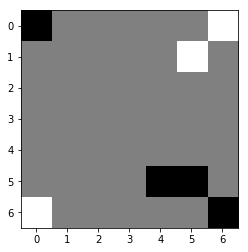

((1, 5), (2, 4)): n_v:   978 q_all:-0.018047 q:-0.011597 q_m:-0.000000 p:0.451639
((6, 0), (5, 1)): n_v:   792 q_all:-0.008829 q:-0.010045 q_m:-0.000000 p:0.313945
((1, 5), (2, 5)): n_v:   259 q_all:-0.014302 q:-0.026112 q_m:-0.000000 p:0.112855
((1, 5), (1, 4)): n_v:    78 q_all:-0.025695 q:-0.017511 q_m:-0.000000 p:0.040497
((6, 0), (6, 1)): n_v:    34 q_all:-0.015946 q:-0.009653 q_m:-0.000000 p:0.015596
((6, 0), (5, 0)): n_v:    29 q_all:-0.016883 q:-0.014460 q_m:-0.000000 p:0.013584
((0, 6), (0, 5)): n_v:    11 q_all:-0.034482 q:-0.033285 q_m:-0.000000 p:0.006472
((1, 5), (0, 4)): n_v:    11 q_all:-0.036584 q:-0.025461 q_m:-0.000000 p:0.006987
((0, 6), (1, 6)): n_v:    10 q_all:-0.017378 q:-0.015544 q_m:-0.000000 p:0.004799
((1, 5), (2, 6)): n_v:    10 q_all:-0.033868 q:-0.035391 q_m:-0.000000 p:0.006120
((6, 0), (6, 2)): n_v:     3 q_all:-0.020235 q:-0.027141 q_m:-0.033333 p:0.001623
((6, 0), (4, 2)): n_v:     3 q_all:-0.024746 q:-0.041694 q_m:-0.033333 p:0.001579
((1, 5), (2, 3))

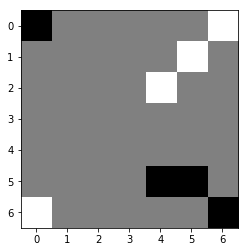

((0, 0), (1, 1)): n_v:  2832 q_all:+0.023280 q:+0.015917 q_m:+0.033333 p:0.861608
((5, 4), (3, 5)): n_v:   165 q_all:+0.021635 q:+0.027105 q_m:+0.066667 p:0.052038
((5, 4), (3, 3)): n_v:    64 q_all:+0.024868 q:+0.029694 q_m:+0.066667 p:0.018808
((5, 4), (3, 4)): n_v:    14 q_all:+0.019468 q:+0.013702 q_m:+0.066667 p:0.004708
((5, 4), (4, 4)): n_v:    12 q_all:-0.048770 q:-0.002731 q_m:+0.033333 p:0.008936
((5, 4), (6, 5)): n_v:    11 q_all:+0.014767 q:-0.007070 q_m:+0.033333 p:0.004213
((5, 4), (4, 3)): n_v:    11 q_all:-0.019152 q:+0.001466 q_m:+0.033333 p:0.006522
((5, 4), (5, 3)): n_v:    11 q_all:-0.021580 q:-0.005811 q_m:+0.033333 p:0.006488
((5, 4), (4, 5)): n_v:    10 q_all:-0.038016 q:-0.018405 q_m:+0.033333 p:0.006570
((5, 5), (3, 5)): n_v:     9 q_all:+0.004738 q:+0.031786 q_m:+0.066667 p:0.004130
((5, 4), (6, 3)): n_v:     8 q_all:+0.037662 q:-0.001317 q_m:+0.033333 p:0.001955
((5, 5), (3, 3)): n_v:     8 q_all:+0.023288 q:+0.032207 q_m:+0.066667 p:0.002685
((5, 5), (3, 4))

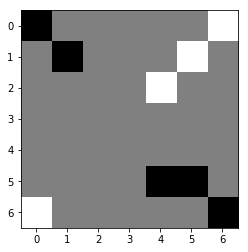

((2, 4), (1, 3)): n_v:  1573 q_all:-0.010713 q:-0.020032 q_m:-0.000000 p:0.279163
((2, 4), (3, 5)): n_v:  1192 q_all:-0.023440 q:-0.019235 q_m:-0.000000 p:0.284204
((6, 0), (5, 1)): n_v:   796 q_all:-0.006584 q:-0.025435 q_m:-0.000000 p:0.125453
((2, 4), (0, 5)): n_v:   185 q_all:-0.025960 q:-0.052263 q_m:-0.033333 p:0.046478
((2, 4), (4, 4)): n_v:   156 q_all:-0.015323 q:+0.005737 q_m:+0.100000 p:0.031156
((2, 4), (4, 5)): n_v:   122 q_all:-0.009483 q:+0.001662 q_m:+0.100000 p:0.021068
((1, 5), (1, 4)): n_v:   119 q_all:-0.011707 q:-0.031627 q_m:-0.000000 p:0.021737
((6, 0), (6, 1)): n_v:    88 q_all:-0.001690 q:-0.025334 q_m:-0.000000 p:0.011771
((2, 4), (4, 6)): n_v:    83 q_all:-0.013095 q:-0.006537 q_m:+0.033333 p:0.015601
((2, 4), (3, 4)): n_v:    53 q_all:-0.032609 q:-0.034080 q_m:-0.000000 p:0.015209
((2, 4), (2, 2)): n_v:    52 q_all:-0.028457 q:-0.009194 q_m:+0.033333 p:0.013777
((0, 6), (0, 5)): n_v:    50 q_all:+0.001739 q:-0.041325 q_m:-0.000000 p:0.005854
((2, 4), (3, 3))

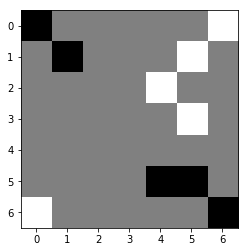

((5, 5), (3, 4)): n_v:  1307 q_all:+0.009571 q:+0.053648 q_m:+0.133333 p:0.456789
((5, 4), (3, 4)): n_v:   534 q_all:+0.008962 q:+0.047574 q_m:+0.133333 p:0.188636
((5, 4), (3, 3)): n_v:   343 q_all:+0.038587 q:+0.030473 q_m:+0.066667 p:0.061018
((5, 4), (3, 6)): n_v:   183 q_all:+0.025239 q:+0.038065 q_m:+0.066667 p:0.046983
((5, 4), (4, 5)): n_v:    91 q_all:-0.017056 q:+0.017501 q_m:+0.100000 p:0.046306
((1, 1), (2, 2)): n_v:    80 q_all:+0.036895 q:+0.015900 q_m:+0.033333 p:0.015115
((5, 4), (3, 2)): n_v:    56 q_all:-0.020257 q:+0.015177 q_m:-0.000000 p:0.029812
((5, 4), (4, 3)): n_v:    39 q_all:+0.014997 q:+0.009099 q_m:+0.033333 p:0.012511
((5, 5), (3, 6)): n_v:    34 q_all:+0.003224 q:+0.041358 q_m:+0.066667 p:0.013411
((5, 4), (4, 6)): n_v:    33 q_all:+0.017164 q:+0.036613 q_m:+0.066667 p:0.009929
((5, 4), (5, 3)): n_v:    32 q_all:+0.003462 q:+0.001971 q_m:+0.033333 p:0.012715
((5, 5), (3, 3)): n_v:    32 q_all:+0.030666 q:+0.030308 q_m:+0.066667 p:0.007298
((1, 1), (2, 1))

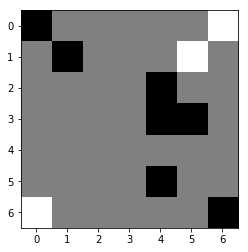

((1, 5), (2, 5)): n_v:  3131 q_all:+0.015171 q:-0.012179 q_m:+0.100000 p:0.937433
((0, 6), (2, 5)): n_v:   133 q_all:+0.016880 q:-0.022766 q_m:+0.066667 p:0.038761
((1, 5), (2, 3)): n_v:     7 q_all:-0.084253 q:-0.049403 q_m:-0.000000 p:0.006786
((1, 5), (3, 3)): n_v:     5 q_all:-0.056046 q:-0.049470 q_m:-0.000000 p:0.003699
((1, 5), (1, 4)): n_v:     3 q_all:-0.104186 q:-0.053078 q_m:-0.033333 p:0.003587
((1, 5), (2, 6)): n_v:     2 q_all:-0.066840 q:-0.058877 q_m:-0.033333 p:0.002247
((6, 0), (5, 1)): n_v:     2 q_all:-0.114975 q:-0.061913 q_m:-0.100000 p:0.002194
((6, 0), (4, 1)): n_v:     1 q_all:-0.093577 q:-0.073747 q_m:-0.133333 p:0.000887
((1, 5), (0, 4)): n_v:     0 q_all:-0.075249 q:-0.075249 q_m:-0.100000 p:0.000305
((0, 6), (1, 6)): n_v:     0 q_all:-0.081725 q:-0.081725 q_m:-0.100000 p:0.000521
((1, 5), (3, 6)): n_v:     0 q_all:-0.071813 q:-0.071813 q_m:-0.066667 p:0.000391
((6, 0), (6, 2)): n_v:     0 q_all:-0.079457 q:-0.079457 q_m:-0.133333 p:0.000015
((1, 5), (0, 3))

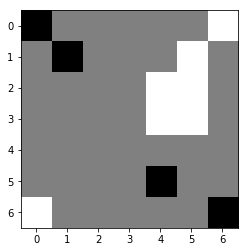

((5, 4), (3, 3)): n_v:  1720 q_all:-0.008939 q:+0.006570 q_m:+0.033333 p:0.312434
((5, 4), (4, 5)): n_v:   837 q_all:-0.004012 q:+0.010620 q_m:+0.066667 p:0.132796
((5, 4), (4, 3)): n_v:   515 q_all:-0.005050 q:-0.002991 q_m:-0.000000 p:0.084319
((1, 1), (1, 2)): n_v:   452 q_all:-0.031115 q:-0.043900 q_m:-0.066667 p:0.128982
((5, 4), (4, 4)): n_v:   361 q_all:-0.004956 q:+0.014085 q_m:+0.066667 p:0.058998
((1, 1), (2, 2)): n_v:   233 q_all:-0.015794 q:-0.019133 q_m:-0.066667 p:0.049927
((5, 4), (3, 6)): n_v:   159 q_all:-0.017411 q:+0.006690 q_m:+0.033333 p:0.035181
((5, 4), (4, 2)): n_v:   130 q_all:-0.029184 q:-0.050960 q_m:-0.100000 p:0.036118
((1, 1), (2, 3)): n_v:    93 q_all:-0.017630 q:-0.000513 q_m:+0.033333 p:0.020832
((5, 4), (5, 2)): n_v:    66 q_all:-0.040889 q:-0.057269 q_m:-0.100000 p:0.021942
((5, 4), (4, 6)): n_v:    45 q_all:-0.011300 q:-0.000037 q_m:-0.033333 p:0.008508
((1, 1), (3, 3)): n_v:    40 q_all:-0.017325 q:+0.002032 q_m:+0.033333 p:0.009036
((5, 4), (5, 5))

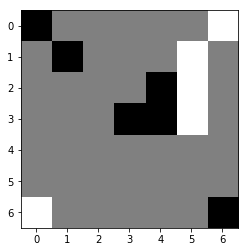

((2, 5), (2, 3)): n_v:  1315 q_all:+0.029567 q:+0.032936 q_m:+0.166667 p:0.359758
((1, 5), (2, 3)): n_v:  1134 q_all:+0.023390 q:+0.027221 q_m:+0.166667 p:0.347729
((3, 5), (2, 3)): n_v:  1060 q_all:+0.042925 q:+0.036957 q_m:+0.166667 p:0.214573
((3, 5), (4, 3)): n_v:    88 q_all:-0.024153 q:-0.023405 q_m:+0.100000 p:0.049310
((2, 5), (4, 3)): n_v:    24 q_all:-0.023463 q:-0.027889 q_m:+0.100000 p:0.013890
((3, 5), (4, 4)): n_v:     8 q_all:-0.015725 q:-0.014329 q_m:+0.133333 p:0.004137
((2, 5), (1, 3)): n_v:     4 q_all:-0.037342 q:-0.014412 q_m:+0.033333 p:0.002494
((3, 5), (5, 6)): n_v:     1 q_all:-0.020153 q:-0.011757 q_m:+0.033333 p:0.000706
((2, 5), (0, 3)): n_v:     1 q_all:-0.023127 q:-0.034216 q_m:-0.033333 p:0.000761
((1, 5), (1, 4)): n_v:     1 q_all:-0.027710 q:-0.015595 q_m:+0.066667 p:0.001047
((2, 5), (4, 4)): n_v:     1 q_all:-0.032395 q:-0.023511 q_m:+0.100000 p:0.000895
((2, 5), (3, 6)): n_v:     0 q_all:-0.038813 q:-0.038813 q_m:-0.000000 p:0.000083
((6, 0), (5, 2))

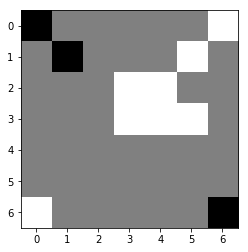

((1, 1), (2, 2)): n_v:  2327 q_all:-0.029990 q:+0.009720 q_m:-0.000000 p:0.719304
((6, 6), (4, 4)): n_v:   410 q_all:-0.006541 q:-0.013539 q_m:+0.033333 p:0.072834
((0, 0), (2, 2)): n_v:   196 q_all:-0.047895 q:-0.005403 q_m:-0.033333 p:0.080331
((1, 1), (1, 3)): n_v:   133 q_all:-0.035115 q:-0.021851 q_m:-0.033333 p:0.045212
((6, 6), (4, 5)): n_v:    55 q_all:-0.017878 q:-0.029130 q_m:-0.033333 p:0.013354
((1, 1), (1, 2)): n_v:    51 q_all:-0.033722 q:-0.050278 q_m:-0.066667 p:0.017154
((1, 1), (3, 2)): n_v:    28 q_all:-0.054419 q:+0.000651 q_m:-0.033333 p:0.012677
((1, 1), (2, 1)): n_v:    24 q_all:-0.022602 q:-0.054232 q_m:-0.133333 p:0.006545
((6, 6), (5, 5)): n_v:    18 q_all:-0.055987 q:-0.052872 q_m:-0.133333 p:0.008460
((0, 0), (2, 1)): n_v:     8 q_all:-0.058410 q:-0.062691 q_m:-0.166667 p:0.004088
((6, 6), (4, 6)): n_v:     7 q_all:-0.032844 q:-0.020383 q_m:-0.100000 p:0.002558
((0, 0), (2, 0)): n_v:     6 q_all:-0.052509 q:-0.061121 q_m:-0.166667 p:0.002896
((0, 0), (1, 2))

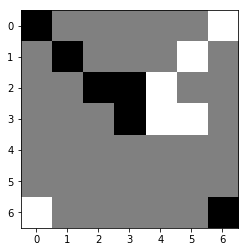

((3, 4), (3, 2)): n_v:  2665 q_all:+0.033703 q:+0.044324 q_m:+0.200000 p:0.676544
((2, 4), (3, 2)): n_v:  1128 q_all:+0.049324 q:+0.051913 q_m:+0.200000 p:0.199172
((2, 4), (1, 2)): n_v:   318 q_all:+0.047599 q:+0.050671 q_m:+0.200000 p:0.058912
((3, 4), (1, 2)): n_v:   142 q_all:+0.034005 q:+0.045780 q_m:+0.200000 p:0.035781
((3, 5), (1, 3)): n_v:     9 q_all:+0.000963 q:+0.020225 q_m:+0.133333 p:0.003920
((3, 4), (4, 2)): n_v:     9 q_all:-0.031452 q:-0.026870 q_m:+0.066667 p:0.005427
((2, 4), (1, 3)): n_v:     8 q_all:+0.011440 q:+0.027506 q_m:+0.166667 p:0.003039
((3, 4), (1, 3)): n_v:     7 q_all:+0.005653 q:+0.024040 q_m:+0.133333 p:0.003122
((3, 4), (5, 2)): n_v:     5 q_all:-0.029001 q:-0.027420 q_m:-0.000000 p:0.003055
((3, 5), (5, 6)): n_v:     4 q_all:+0.010682 q:+0.003044 q_m:+0.066667 p:0.001658
((2, 4), (0, 2)): n_v:     3 q_all:+0.023813 q:+0.026954 q_m:+0.066667 p:0.001124
((3, 4), (5, 6)): n_v:     2 q_all:+0.047607 q:+0.003259 q_m:+0.066667 p:0.000411
((3, 4), (5, 5))

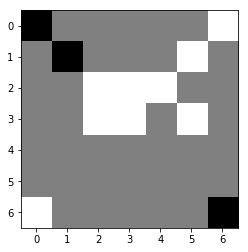

((1, 1), (1, 3)): n_v:  3405 q_all:-0.019845 q:-0.014503 q_m:-0.000000 p:0.629847
((1, 1), (2, 1)): n_v:   531 q_all:-0.044189 q:-0.043643 q_m:-0.033333 p:0.160274
((0, 0), (2, 1)): n_v:   223 q_all:-0.057418 q:-0.052474 q_m:-0.066667 p:0.081310
((1, 1), (1, 2)): n_v:   138 q_all:-0.055188 q:-0.064215 q_m:-0.033333 p:0.049177
((1, 1), (3, 1)): n_v:    67 q_all:-0.040593 q:-0.051455 q_m:-0.066667 p:0.019149
((6, 6), (4, 4)): n_v:    45 q_all:-0.042180 q:-0.020210 q_m:-0.066667 p:0.013160
((6, 6), (4, 5)): n_v:    30 q_all:-0.062176 q:-0.036326 q_m:-0.133333 p:0.011730
((6, 6), (5, 5)): n_v:    19 q_all:-0.044931 q:-0.059157 q_m:-0.166667 p:0.006089
((0, 0), (1, 2)): n_v:     9 q_all:-0.079274 q:-0.075045 q_m:-0.066667 p:0.004569
((1, 1), (2, 0)): n_v:     4 q_all:-0.096124 q:-0.073143 q_m:-0.166667 p:0.002582
((1, 1), (0, 2)): n_v:     4 q_all:-0.115777 q:-0.074910 q_m:-0.166667 p:0.003110
((1, 1), (0, 3)): n_v:     3 q_all:-0.088443 q:-0.068630 q_m:-0.200000 p:0.001843
((6, 6), (5, 4))

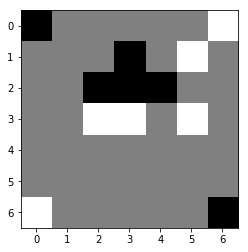

((3, 3), (1, 2)): n_v:   937 q_all:+0.042523 q:+0.048677 q_m:+0.200000 p:0.138725
((1, 5), (1, 4)): n_v:   683 q_all:+0.020619 q:+0.027836 q_m:+0.233333 p:0.169080
((3, 3), (1, 1)): n_v:   674 q_all:+0.059646 q:+0.064103 q_m:+0.133333 p:0.047402
((3, 2), (1, 4)): n_v:   577 q_all:+0.011497 q:+0.011531 q_m:+0.200000 p:0.166737
((3, 3), (1, 4)): n_v:   558 q_all:+0.021047 q:+0.028281 q_m:+0.200000 p:0.136756
((3, 5), (1, 4)): n_v:   551 q_all:+0.020207 q:+0.022426 q_m:+0.200000 p:0.137392
((3, 2), (1, 2)): n_v:   371 q_all:+0.031332 q:+0.036897 q_m:+0.200000 p:0.073726
((0, 6), (1, 4)): n_v:    98 q_all:+0.011370 q:+0.016362 q_m:+0.200000 p:0.028593
((3, 2), (1, 1)): n_v:    63 q_all:+0.047952 q:+0.057910 q_m:+0.133333 p:0.007688
((3, 3), (5, 4)): n_v:    33 q_all:-0.006615 q:-0.013912 q_m:-0.000000 p:0.012322
((3, 3), (5, 2)): n_v:    29 q_all:-0.015624 q:-0.020689 q_m:-0.000000 p:0.012012
((3, 5), (5, 4)): n_v:    23 q_all:-0.040369 q:-0.022119 q_m:-0.000000 p:0.012217
((3, 3), (5, 1))

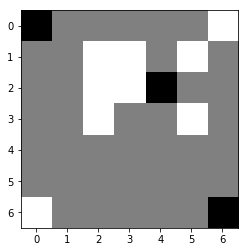

((2, 4), (1, 4)): n_v:  1107 q_all:-0.015973 q:-0.017995 q_m:+0.033333 p:0.275679
((0, 0), (2, 1)): n_v:   877 q_all:-0.059090 q:-0.060897 q_m:-0.000000 p:0.451308
((2, 4), (3, 3)): n_v:   325 q_all:-0.013695 q:-0.019537 q_m:+0.033333 p:0.076508
((2, 4), (2, 5)): n_v:   173 q_all:-0.017684 q:-0.031555 q_m:-0.033333 p:0.045052
((2, 4), (0, 5)): n_v:    93 q_all:-0.046206 q:-0.042858 q_m:-0.066667 p:0.040891
((0, 0), (1, 1)): n_v:    72 q_all:-0.039243 q:-0.067325 q_m:-0.033333 p:0.028221
((2, 4), (1, 6)): n_v:    49 q_all:-0.052327 q:-0.039860 q_m:-0.066667 p:0.023474
((2, 4), (0, 2)): n_v:    25 q_all:-0.092084 q:-0.085068 q_m:-0.066667 p:0.018575
((0, 0), (0, 2)): n_v:    10 q_all:-0.050014 q:-0.065210 q_m:-0.066667 p:0.004983
((2, 4), (0, 3)): n_v:     9 q_all:-0.064991 q:-0.052527 q_m:-0.066667 p:0.005477
((2, 4), (4, 2)): n_v:     9 q_all:-0.115976 q:-0.116009 q_m:-0.133333 p:0.008597
((0, 0), (0, 1)): n_v:     6 q_all:-0.086182 q:-0.080931 q_m:-0.100000 p:0.004427
((0, 0), (1, 0))

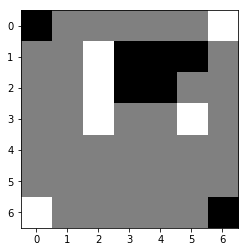

((3, 5), (2, 5)): n_v:   897 q_all:+0.044191 q:+0.036285 q_m:+0.200000 p:0.125553
((0, 6), (2, 5)): n_v:   848 q_all:+0.032096 q:+0.034240 q_m:+0.166667 p:0.180162
((1, 2), (2, 1)): n_v:   118 q_all:-0.038114 q:-0.014462 q_m:-0.000000 p:0.075012
((3, 5), (5, 6)): n_v:    87 q_all:+0.030610 q:+0.008646 q_m:+0.033333 p:0.019379
((1, 2), (0, 3)): n_v:    84 q_all:+0.020705 q:+0.012369 q_m:+0.133333 p:0.023668
((2, 2), (0, 4)): n_v:    83 q_all:+0.007767 q:+0.007675 q_m:+0.166667 p:0.029326
((2, 2), (1, 0)): n_v:    57 q_all:+0.003937 q:-0.001461 q_m:+0.033333 p:0.021782
((2, 2), (0, 1)): n_v:    55 q_all:-0.018497 q:-0.003366 q_m:+0.033333 p:0.028708
((1, 2), (0, 4)): n_v:    52 q_all:+0.002942 q:+0.011288 q_m:+0.166667 p:0.020472
((0, 6), (0, 4)): n_v:    48 q_all:+0.021718 q:+0.003712 q_m:+0.166667 p:0.013264
((2, 2), (3, 3)): n_v:    47 q_all:-0.011529 q:+0.004463 q_m:+0.133333 p:0.022512
((3, 2), (1, 1)): n_v:    46 q_all:+0.017506 q:+0.006725 q_m:+0.033333 p:0.014034
((3, 5), (4, 5))

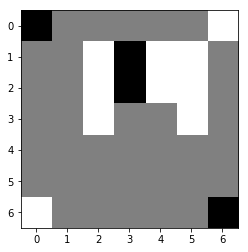

((2, 3), (4, 5)): n_v:   568 q_all:-0.003312 q:-0.035848 q_m:-0.133333 p:0.132083
((2, 3), (4, 1)): n_v:   495 q_all:-0.026109 q:-0.072456 q_m:-0.133333 p:0.185159
((2, 3), (3, 4)): n_v:   459 q_all:-0.012409 q:-0.005176 q_m:+0.033333 p:0.132975
((2, 3), (0, 5)): n_v:   334 q_all:-0.018499 q:-0.042331 q_m:-0.000000 p:0.109342
((2, 3), (3, 1)): n_v:   217 q_all:-0.046307 q:-0.051191 q_m:-0.066667 p:0.108759
((2, 3), (3, 3)): n_v:   153 q_all:-0.026842 q:-0.009520 q_m:+0.033333 p:0.058104
((2, 3), (0, 1)): n_v:   129 q_all:-0.059386 q:-0.070968 q_m:-0.133333 p:0.075366
((2, 3), (4, 4)): n_v:    74 q_all:-0.005321 q:-0.030658 q_m:-0.133333 p:0.018389
((2, 3), (1, 1)): n_v:    71 q_all:-0.051270 q:-0.048689 q_m:-0.066667 p:0.038015
((1, 3), (3, 4)): n_v:    69 q_all:+0.001359 q:-0.009544 q_m:-0.000000 p:0.014205
((1, 3), (2, 1)): n_v:    59 q_all:-0.025335 q:-0.031532 q_m:-0.000000 p:0.021932
((1, 3), (0, 5)): n_v:    55 q_all:-0.021176 q:-0.036556 q_m:-0.000000 p:0.019115
((1, 3), (3, 1))

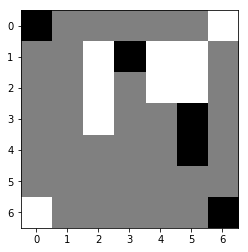

((2, 4), (4, 6)): n_v:   488 q_all:+0.035051 q:+0.078578 q_m:+0.266667 p:0.109799
((2, 2), (3, 4)): n_v:   260 q_all:+0.011355 q:+0.070608 q_m:+0.266667 p:0.099008
((1, 2), (2, 3)): n_v:   182 q_all:+0.050260 q:+0.037701 q_m:+0.233333 p:0.022789
((2, 4), (4, 4)): n_v:   149 q_all:+0.018864 q:+0.068119 q_m:+0.266667 p:0.049457
((2, 2), (4, 0)): n_v:   112 q_all:-0.012645 q:+0.013441 q_m:+0.133333 p:0.060789
((2, 2), (4, 4)): n_v:   100 q_all:+0.014890 q:+0.062588 q_m:+0.266667 p:0.035900
((3, 2), (4, 4)): n_v:    96 q_all:+0.005415 q:+0.058527 q_m:+0.266667 p:0.040433
((2, 4), (3, 4)): n_v:    92 q_all:+0.010182 q:+0.084607 q_m:+0.300000 p:0.035951
((1, 2), (3, 4)): n_v:    80 q_all:+0.029560 q:+0.079569 q_m:+0.266667 p:0.020997
((2, 2), (4, 2)): n_v:    74 q_all:-0.003933 q:+0.004504 q_m:+0.133333 p:0.035729
((2, 5), (4, 6)): n_v:    67 q_all:+0.036800 q:+0.067585 q_m:+0.266667 p:0.014401
((2, 2), (1, 0)): n_v:    67 q_all:+0.040246 q:+0.045773 q_m:+0.200000 p:0.012542
((3, 2), (1, 0))

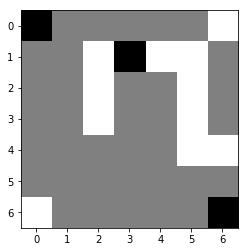

((1, 3), (2, 3)): n_v:  1694 q_all:-0.016153 q:+0.016814 q_m:+0.033333 p:0.604018
((1, 3), (2, 1)): n_v:   266 q_all:-0.032327 q:-0.060764 q_m:-0.066667 p:0.123424
((1, 3), (2, 4)): n_v:   133 q_all:+0.013304 q:-0.024714 q_m:+0.033333 p:0.021394
((0, 0), (2, 1)): n_v:   120 q_all:-0.080818 q:-0.055924 q_m:-0.066667 p:0.095024
((1, 3), (3, 4)): n_v:   107 q_all:-0.009367 q:-0.039684 q_m:-0.066667 p:0.033503
((6, 6), (5, 5)): n_v:    65 q_all:-0.053134 q:-0.066290 q_m:-0.100000 p:0.039606
((0, 0), (1, 1)): n_v:    29 q_all:-0.071316 q:-0.069866 q_m:-0.100000 p:0.021590
((1, 3), (3, 1)): n_v:    12 q_all:-0.105221 q:-0.102362 q_m:-0.133333 p:0.011794
((1, 3), (0, 5)): n_v:    11 q_all:-0.040562 q:-0.047339 q_m:-0.066667 p:0.005848
((1, 3), (1, 1)): n_v:    10 q_all:-0.156042 q:-0.099044 q_m:-0.133333 p:0.012974
((1, 3), (3, 3)): n_v:     9 q_all:-0.094103 q:-0.069557 q_m:-0.133333 p:0.008700
((6, 6), (4, 4)): n_v:     8 q_all:-0.052752 q:-0.065683 q_m:-0.133333 p:0.005276
((1, 3), (0, 1))

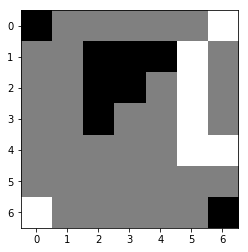

((3, 5), (3, 3)): n_v:  1215 q_all:+0.018886 q:+0.019198 q_m:+0.166667 p:0.333847
((2, 5), (3, 3)): n_v:   871 q_all:+0.024064 q:+0.015051 q_m:+0.166667 p:0.214777
((1, 5), (3, 3)): n_v:   849 q_all:+0.012371 q:+0.015823 q_m:+0.166667 p:0.263877
((4, 5), (3, 3)): n_v:   643 q_all:+0.030592 q:+0.039894 q_m:+0.166667 p:0.135610
((2, 5), (0, 3)): n_v:    16 q_all:+0.025392 q:+0.012246 q_m:+0.166667 p:0.004029
((4, 5), (4, 3)): n_v:    15 q_all:+0.002562 q:-0.016356 q_m:+0.033333 p:0.005754
((4, 5), (5, 3)): n_v:    15 q_all:-0.021050 q:-0.038137 q_m:-0.033333 p:0.007693
((1, 5), (2, 4)): n_v:    12 q_all:-0.015483 q:-0.019015 q_m:+0.200000 p:0.005430
((3, 5), (4, 3)): n_v:     3 q_all:-0.000524 q:-0.040549 q_m:+0.033333 p:0.001487
((1, 5), (0, 3)): n_v:     3 q_all:+0.015158 q:+0.016836 q_m:+0.166667 p:0.001153
((4, 5), (6, 3)): n_v:     2 q_all:-0.018161 q:-0.028609 q_m:-0.033333 p:0.001342
((2, 5), (4, 3)): n_v:     1 q_all:-0.020910 q:-0.044605 q_m:+0.033333 p:0.000703
((0, 6), (2, 4))

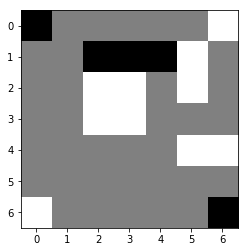

((1, 4), (3, 5)): n_v:   926 q_all:+0.001828 q:-0.016212 q_m:+0.033333 p:0.229317
((1, 2), (3, 1)): n_v:   720 q_all:-0.032947 q:-0.037351 q_m:-0.033333 p:0.325540
((1, 3), (3, 5)): n_v:   300 q_all:+0.002804 q:+0.000241 q_m:+0.033333 p:0.072744
((1, 4), (1, 6)): n_v:   238 q_all:+0.022638 q:-0.008006 q_m:+0.033333 p:0.029686
((1, 3), (2, 4)): n_v:   189 q_all:+0.014548 q:-0.000204 q_m:+0.133333 p:0.032715
((1, 4), (3, 6)): n_v:   158 q_all:+0.017106 q:+0.003250 q_m:+0.033333 p:0.024892
((1, 4), (3, 4)): n_v:   135 q_all:-0.011529 q:-0.022053 q_m:+0.100000 p:0.044251
((1, 3), (3, 1)): n_v:    88 q_all:-0.047387 q:-0.050885 q_m:-0.033333 p:0.047304
((1, 2), (3, 4)): n_v:    85 q_all:-0.030644 q:-0.017695 q_m:+0.100000 p:0.037343
((1, 3), (3, 4)): n_v:    68 q_all:-0.007121 q:+0.004993 q_m:+0.100000 p:0.020652
((1, 2), (2, 4)): n_v:    63 q_all:+0.005445 q:-0.013802 q_m:+0.100000 p:0.014458
((1, 2), (3, 0)): n_v:    45 q_all:-0.046312 q:-0.050357 q_m:-0.166667 p:0.024000
((6, 6), (5, 5))

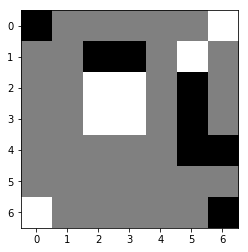

((2, 2), (1, 1)): n_v:   620 q_all:+0.011101 q:+0.026883 q_m:+0.133333 p:0.176776
((1, 5), (3, 6)): n_v:   516 q_all:+0.041700 q:+0.041167 q_m:+0.233333 p:0.049733
((3, 2), (3, 0)): n_v:   374 q_all:-0.019498 q:-0.043210 q_m:-0.033333 p:0.176994
((3, 3), (1, 1)): n_v:   296 q_all:+0.003646 q:+0.011785 q_m:+0.100000 p:0.098103
((2, 2), (3, 0)): n_v:   209 q_all:-0.037061 q:-0.047410 q_m:-0.033333 p:0.122048
((2, 3), (1, 1)): n_v:   206 q_all:-0.004340 q:+0.005914 q_m:+0.100000 p:0.078640
((3, 2), (1, 1)): n_v:    87 q_all:+0.013432 q:+0.016686 q_m:+0.100000 p:0.023580
((3, 3), (5, 1)): n_v:    79 q_all:-0.042323 q:-0.037812 q_m:-0.033333 p:0.048719
((2, 2), (1, 0)): n_v:    76 q_all:-0.002145 q:-0.007780 q_m:+0.033333 p:0.027977
((2, 2), (0, 1)): n_v:    63 q_all:+0.007031 q:+0.010035 q_m:+0.100000 p:0.019689
((3, 3), (5, 5)): n_v:    34 q_all:-0.005340 q:+0.024987 q_m:+0.166667 p:0.012937
((2, 3), (0, 1)): n_v:    25 q_all:+0.000070 q:+0.002732 q_m:+0.100000 p:0.009006
((2, 3), (3, 4))

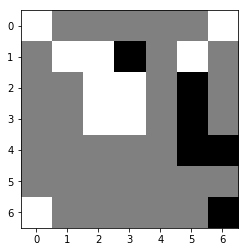

((1, 3), (2, 1)): n_v:  1337 q_all:-0.010705 q:+0.002023 q_m:+0.133333 p:0.470575
((1, 3), (0, 5)): n_v:   848 q_all:-0.016963 q:-0.021774 q_m:-0.000000 p:0.332828
((1, 3), (0, 1)): n_v:   251 q_all:-0.025302 q:-0.012923 q_m:+0.066667 p:0.112300
((1, 3), (3, 1)): n_v:    63 q_all:-0.041883 q:-0.039479 q_m:-0.000000 p:0.035432
((3, 5), (1, 6)): n_v:    22 q_all:+0.016438 q:-0.052869 q_m:-0.000000 p:0.003734
((4, 5), (4, 3)): n_v:    14 q_all:-0.022646 q:-0.012058 q_m:-0.000000 p:0.005836
((2, 5), (0, 5)): n_v:    10 q_all:-0.018983 q:-0.020158 q_m:-0.000000 p:0.004393
((3, 5), (4, 3)): n_v:     9 q_all:-0.031654 q:-0.021626 q_m:-0.000000 p:0.004565
((1, 3), (1, 4)): n_v:     5 q_all:-0.062793 q:-0.043346 q_m:+0.033333 p:0.003851
((1, 3), (0, 2)): n_v:     3 q_all:-0.053531 q:-0.031075 q_m:+0.033333 p:0.002426
((1, 3), (0, 4)): n_v:     3 q_all:-0.046392 q:-0.055451 q_m:-0.033333 p:0.002156
((4, 5), (6, 5)): n_v:     3 q_all:-0.026148 q:-0.049440 q_m:-0.133333 p:0.001486
((3, 5), (5, 6))

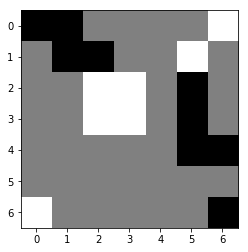

((2, 2), (1, 0)): n_v:  1346 q_all:+0.026686 q:+0.020288 q_m:+0.133333 p:0.474997
((3, 2), (1, 0)): n_v:   514 q_all:+0.016629 q:+0.012738 q_m:+0.133333 p:0.218009
((1, 5), (3, 6)): n_v:    85 q_all:+0.021442 q:+0.040251 q_m:+0.200000 p:0.033356
((3, 2), (3, 0)): n_v:    72 q_all:-0.025805 q:-0.049692 q_m:-0.066667 p:0.051950
((3, 2), (5, 0)): n_v:    70 q_all:-0.029428 q:-0.052741 q_m:-0.066667 p:0.052698
((2, 2), (3, 0)): n_v:    35 q_all:-0.060817 q:-0.055545 q_m:-0.066667 p:0.034239
((2, 3), (0, 2)): n_v:    26 q_all:+0.004595 q:+0.004888 q_m:+0.133333 p:0.013231
((0, 6), (1, 6)): n_v:    26 q_all:-0.041192 q:-0.025166 q_m:+0.033333 p:0.022041
((2, 2), (0, 2)): n_v:    17 q_all:-0.001250 q:+0.000736 q_m:+0.133333 p:0.009571
((2, 2), (0, 4)): n_v:    16 q_all:-0.059925 q:-0.071886 q_m:-0.066667 p:0.015943
((2, 2), (2, 1)): n_v:    10 q_all:-0.004297 q:-0.017522 q_m:+0.100000 p:0.006103
((2, 3), (0, 4)): n_v:     4 q_all:-0.081713 q:-0.070574 q_m:-0.066667 p:0.005422
((6, 0), (5, 0))

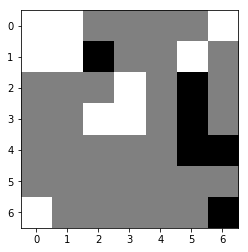

((1, 2), (2, 1)): n_v:   761 q_all:-0.017969 q:-0.024713 q_m:+0.100000 p:0.147277
((1, 2), (0, 2)): n_v:   708 q_all:-0.000300 q:-0.030096 q_m:+0.033333 p:0.064794
((2, 5), (0, 5)): n_v:   585 q_all:-0.009479 q:-0.022670 q_m:-0.000000 p:0.084414
((1, 2), (2, 2)): n_v:   477 q_all:-0.041342 q:-0.038038 q_m:+0.166667 p:0.156617
((2, 5), (2, 4)): n_v:   172 q_all:-0.053991 q:-0.056984 q_m:+0.100000 p:0.068815
((4, 5), (6, 5)): n_v:    94 q_all:-0.055146 q:-0.061488 q_m:-0.133333 p:0.038169
((1, 2), (2, 0)): n_v:    60 q_all:-0.062307 q:-0.031629 q_m:-0.000000 p:0.026951
((3, 5), (1, 6)): n_v:    44 q_all:-0.054952 q:-0.062698 q_m:-0.000000 p:0.018271
((2, 5), (0, 4)): n_v:    35 q_all:-0.052238 q:-0.065043 q_m:-0.066667 p:0.013743
((2, 5), (1, 6)): n_v:    34 q_all:-0.040006 q:-0.057033 q_m:+0.033333 p:0.010672
((4, 5), (5, 5)): n_v:    34 q_all:-0.054092 q:-0.093732 q_m:-0.100000 p:0.013599
((2, 5), (1, 4)): n_v:    31 q_all:-0.050484 q:-0.049355 q_m:+0.033333 p:0.012000
((1, 2), (0, 4))

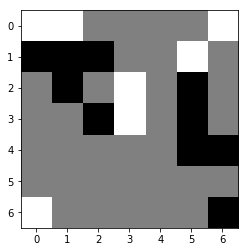

((2, 3), (2, 2)): n_v:  1330 q_all:+0.040654 q:+0.025797 q_m:+0.200000 p:0.137428
((2, 3), (3, 1)): n_v:   248 q_all:-0.001406 q:-0.010895 q_m:+0.033333 p:0.091900
((3, 3), (4, 2)): n_v:   142 q_all:-0.005695 q:-0.001906 q_m:-0.000000 p:0.056684
((3, 3), (3, 1)): n_v:   131 q_all:+0.004504 q:-0.007280 q_m:+0.033333 p:0.043420
((2, 3), (4, 2)): n_v:   126 q_all:-0.010776 q:-0.021544 q_m:-0.033333 p:0.054142
((3, 3), (5, 5)): n_v:   121 q_all:+0.006681 q:+0.030537 q_m:+0.100000 p:0.038798
((3, 3), (5, 1)): n_v:    98 q_all:-0.028110 q:-0.039710 q_m:-0.100000 p:0.052653
((0, 1), (0, 2)): n_v:    87 q_all:+0.011901 q:+0.004808 q_m:+0.066667 p:0.024771
((1, 5), (2, 4)): n_v:    63 q_all:-0.009121 q:+0.013646 q_m:+0.066667 p:0.025959
((2, 3), (4, 4)): n_v:    48 q_all:-0.003961 q:-0.013106 q_m:+0.033333 p:0.018787
((3, 3), (4, 4)): n_v:    47 q_all:+0.004920 q:+0.008730 q_m:+0.066667 p:0.015476
((0, 1), (2, 2)): n_v:    41 q_all:-0.005897 q:+0.002986 q_m:+0.166667 p:0.016576
((1, 5), (3, 6))

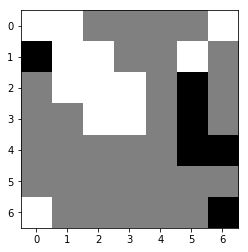

((2, 5), (1, 3)): n_v:   925 q_all:-0.038425 q:-0.051298 q_m:-0.000000 p:0.193417
((1, 0), (3, 1)): n_v:   745 q_all:-0.033481 q:-0.037467 q_m:-0.000000 p:0.134825
((3, 5), (1, 3)): n_v:   243 q_all:-0.035140 q:-0.049509 q_m:-0.000000 p:0.046006
((2, 5), (0, 4)): n_v:   229 q_all:-0.066661 q:-0.085284 q_m:-0.133333 p:0.085278
((4, 5), (4, 3)): n_v:   160 q_all:-0.047475 q:-0.040961 q_m:-0.066667 p:0.042058
((2, 5), (0, 5)): n_v:   150 q_all:-0.026226 q:-0.049215 q_m:-0.066667 p:0.020889
((1, 0), (2, 0)): n_v:   118 q_all:-0.038080 q:-0.053072 q_m:-0.033333 p:0.024246
((2, 5), (0, 3)): n_v:   110 q_all:-0.064570 q:-0.082882 q_m:-0.133333 p:0.039668
((1, 0), (0, 2)): n_v:    90 q_all:-0.033919 q:-0.050896 q_m:-0.000000 p:0.016371
((2, 5), (4, 3)): n_v:    77 q_all:-0.067530 q:-0.054369 q_m:-0.066667 p:0.028788
((4, 5), (5, 3)): n_v:    68 q_all:-0.067286 q:-0.083702 q_m:-0.200000 p:0.025625
((2, 5), (2, 4)): n_v:    59 q_all:-0.053487 q:-0.074119 q_m:+0.033333 p:0.017471
((3, 5), (4, 3))

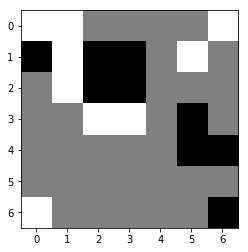

((0, 1), (0, 2)): n_v:  1304 q_all:+0.031515 q:+0.037683 q_m:+0.166667 p:0.301432
((1, 5), (3, 6)): n_v:   536 q_all:+0.068189 q:+0.052510 q_m:+0.200000 p:0.002836
((1, 1), (2, 0)): n_v:   228 q_all:+0.031238 q:+0.038774 q_m:+0.100000 p:0.052857
((3, 2), (2, 0)): n_v:   168 q_all:+0.037042 q:+0.024991 q_m:+0.066667 p:0.033310
((1, 5), (0, 4)): n_v:   147 q_all:-0.001569 q:+0.001440 q_m:+0.100000 p:0.064304
((1, 5), (2, 6)): n_v:    71 q_all:+0.026864 q:+0.012706 q_m:+0.100000 p:0.018672
((3, 3), (3, 4)): n_v:    46 q_all:+0.031246 q:+0.035135 q_m:+0.233333 p:0.010778
((3, 3), (5, 5)): n_v:    43 q_all:+0.034623 q:+0.071553 q_m:+0.200000 p:0.009204
((2, 1), (3, 1)): n_v:    42 q_all:+0.033872 q:+0.011167 q_m:+0.100000 p:0.009212
((2, 1), (0, 2)): n_v:    38 q_all:+0.030496 q:+0.008528 q_m:+0.133333 p:0.009120
((3, 3), (2, 5)): n_v:    30 q_all:+0.025870 q:+0.013207 q_m:+0.066667 p:0.008161
((3, 3), (5, 1)): n_v:    26 q_all:-0.002887 q:-0.003011 q_m:-0.000000 p:0.011651
((3, 3), (3, 1))

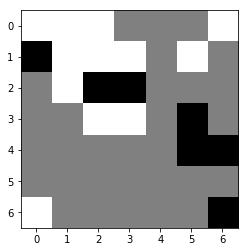

((2, 3), (0, 5)): n_v:   991 q_all:-0.020886 q:-0.038877 q_m:-0.033333 p:0.224291
((2, 3), (0, 3)): n_v:   815 q_all:-0.027161 q:-0.010719 q_m:+0.033333 p:0.214306
((2, 2), (0, 3)): n_v:   395 q_all:-0.010426 q:-0.018975 q_m:+0.033333 p:0.065520
((4, 5), (6, 3)): n_v:   234 q_all:-0.074258 q:-0.083648 q_m:-0.166667 p:0.125681
((3, 5), (2, 6)): n_v:   196 q_all:-0.068704 q:-0.092233 q_m:-0.066667 p:0.098893
((1, 0), (2, 0)): n_v:   162 q_all:-0.065063 q:-0.061783 q_m:-0.000000 p:0.078187
((2, 2), (2, 0)): n_v:    73 q_all:-0.029862 q:-0.054013 q_m:-0.033333 p:0.020370
((2, 3), (3, 1)): n_v:    67 q_all:-0.085365 q:-0.072728 q_m:-0.033333 p:0.040645
((2, 3), (0, 4)): n_v:    56 q_all:-0.041655 q:-0.065793 q_m:-0.033333 p:0.019461
((3, 5), (1, 6)): n_v:    28 q_all:-0.041114 q:-0.060852 q_m:-0.033333 p:0.009852
((2, 2), (3, 1)): n_v:    25 q_all:-0.089638 q:-0.076842 q_m:-0.000000 p:0.016052
((4, 5), (6, 5)): n_v:    16 q_all:-0.085213 q:-0.089133 q_m:-0.166667 p:0.009826
((2, 2), (0, 4))

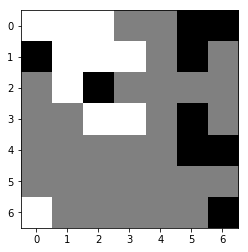

((3, 2), (2, 0)): n_v:   520 q_all:+0.021576 q:-0.015627 q_m:+0.100000 p:0.141212
((3, 3), (2, 5)): n_v:   460 q_all:+0.029293 q:+0.008330 q_m:+0.166667 p:0.103260
((3, 3), (5, 5)): n_v:   302 q_all:+0.027330 q:+0.033170 q_m:+0.233333 p:0.071195
((3, 2), (1, 4)): n_v:   183 q_all:+0.044653 q:+0.005887 q_m:+0.166667 p:0.024027
((3, 2), (2, 4)): n_v:   174 q_all:+0.025819 q:+0.011542 q_m:+0.166667 p:0.042934
((1, 1), (2, 0)): n_v:   173 q_all:+0.027108 q:-0.009845 q_m:+0.133333 p:0.041201
((3, 3), (1, 4)): n_v:   155 q_all:+0.030329 q:+0.011281 q_m:+0.166667 p:0.033894
((3, 3), (3, 1)): n_v:   141 q_all:-0.029084 q:-0.042164 q_m:+0.100000 p:0.081716
((3, 3), (5, 1)): n_v:   114 q_all:-0.034784 q:-0.073655 q_m:+0.033333 p:0.070653
((1, 3), (2, 5)): n_v:    99 q_all:+0.031478 q:+0.010134 q_m:+0.166667 p:0.021017
((1, 3), (1, 4)): n_v:    98 q_all:+0.045593 q:+0.018964 q_m:+0.200000 p:0.012071
((1, 3), (0, 4)): n_v:    78 q_all:+0.037254 q:+0.030097 q_m:+0.200000 p:0.013490
((0, 2), (2, 0))

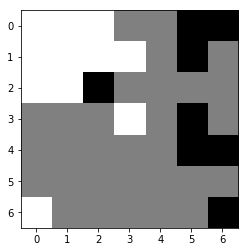

((2, 2), (0, 3)): n_v:  1129 q_all:-0.016395 q:-0.043655 q_m:+0.100000 p:0.388147
((1, 5), (0, 3)): n_v:   509 q_all:-0.030042 q:-0.029039 q_m:+0.100000 p:0.221421
((2, 2), (3, 1)): n_v:   177 q_all:+0.009798 q:-0.030917 q_m:+0.066667 p:0.029628
((2, 2), (2, 3)): n_v:   153 q_all:-0.009824 q:-0.046715 q_m:+0.133333 p:0.045888
((0, 5), (0, 3)): n_v:   150 q_all:-0.024407 q:-0.027750 q_m:+0.100000 p:0.059238
((4, 5), (6, 3)): n_v:   134 q_all:-0.066386 q:-0.074506 q_m:-0.100000 p:0.090378
((3, 5), (2, 3)): n_v:    39 q_all:-0.030874 q:-0.052032 q_m:+0.100000 p:0.017397
((0, 5), (2, 3)): n_v:    33 q_all:-0.033967 q:-0.069450 q_m:+0.100000 p:0.015654
((4, 5), (4, 3)): n_v:    21 q_all:-0.063035 q:-0.058752 q_m:-0.033333 p:0.014015
((2, 2), (2, 4)): n_v:    21 q_all:-0.089892 q:-0.083842 q_m:+0.033333 p:0.018217
((4, 5), (2, 3)): n_v:    19 q_all:-0.010929 q:-0.032888 q_m:+0.100000 p:0.005824
((1, 5), (2, 3)): n_v:    19 q_all:-0.036276 q:-0.067934 q_m:+0.100000 p:0.009464
((2, 2), (3, 0))

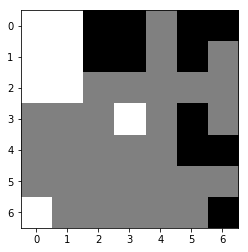

((3, 3), (2, 4)): n_v:  1447 q_all:+0.025214 q:+0.031540 q_m:+0.133333 p:0.214820
((3, 3), (1, 4)): n_v:   382 q_all:-0.022545 q:+0.004229 q_m:+0.166667 p:0.165805
((3, 3), (2, 5)): n_v:   341 q_all:+0.002008 q:+0.018698 q_m:+0.033333 p:0.097879
((1, 1), (2, 2)): n_v:   291 q_all:-0.002227 q:-0.028921 q_m:+0.066667 p:0.091046
((3, 3), (5, 5)): n_v:   151 q_all:+0.001377 q:+0.014174 q_m:+0.100000 p:0.043629
((3, 3), (4, 4)): n_v:   119 q_all:+0.007006 q:+0.008603 q_m:+0.066667 p:0.030666
((3, 3), (5, 4)): n_v:   118 q_all:-0.012445 q:-0.031614 q_m:-0.033333 p:0.044240
((3, 3), (4, 2)): n_v:    53 q_all:-0.032509 q:-0.062315 q_m:-0.066667 p:0.026556
((3, 3), (3, 4)): n_v:    46 q_all:+0.030336 q:+0.014297 q_m:+0.066667 p:0.005479
((3, 3), (5, 1)): n_v:    39 q_all:-0.058342 q:-0.085557 q_m:-0.100000 p:0.025255
((3, 3), (5, 2)): n_v:    20 q_all:-0.058176 q:-0.093818 q_m:-0.100000 p:0.013377
((3, 3), (2, 3)): n_v:    16 q_all:-0.010522 q:+0.012810 q_m:+0.066667 p:0.005449
((2, 1), (2, 3))

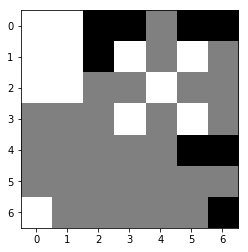

((1, 2), (2, 2)): n_v:   770 q_all:-0.013384 q:+0.013507 q_m:+0.166667 p:0.134640
((4, 5), (2, 5)): n_v:   511 q_all:-0.025349 q:-0.046280 q_m:+0.066667 p:0.124134
((0, 3), (2, 5)): n_v:   348 q_all:-0.040292 q:-0.062248 q_m:+0.066667 p:0.114128
((4, 5), (3, 4)): n_v:   246 q_all:-0.033605 q:-0.057857 q_m:+0.100000 p:0.071510
((0, 5), (2, 5)): n_v:   199 q_all:-0.052282 q:-0.062950 q_m:+0.066667 p:0.079012
((4, 6), (2, 5)): n_v:   169 q_all:-0.027432 q:-0.053248 q_m:+0.066667 p:0.042556
((0, 3), (2, 2)): n_v:   159 q_all:-0.030146 q:-0.006179 q_m:+0.133333 p:0.042821
((1, 2), (2, 3)): n_v:   141 q_all:-0.048652 q:-0.046702 q_m:+0.100000 p:0.053037
((1, 2), (3, 1)): n_v:   110 q_all:-0.009176 q:+0.000373 q_m:-0.000000 p:0.016615
((0, 6), (2, 5)): n_v:   107 q_all:-0.051178 q:-0.064034 q_m:+0.066667 p:0.041950
((4, 5), (4, 4)): n_v:    92 q_all:-0.034113 q:-0.042180 q_m:+0.033333 p:0.026823
((1, 2), (3, 4)): n_v:    85 q_all:-0.021071 q:-0.041689 q_m:+0.066667 p:0.018718
((0, 6), (2, 6))

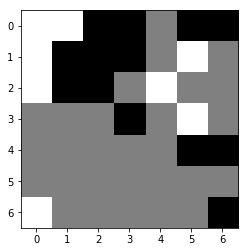

((2, 4), (2, 3)): n_v:   964 q_all:+0.035545 q:+0.031428 q_m:+0.133333 p:0.298564
((3, 5), (2, 3)): n_v:   752 q_all:+0.040888 q:+0.014904 q_m:+0.100000 p:0.206908
((2, 4), (1, 6)): n_v:   322 q_all:+0.019451 q:+0.029089 q_m:-0.033333 p:0.132775
((3, 5), (4, 3)): n_v:   114 q_all:-0.000740 q:-0.002356 q_m:-0.100000 p:0.061952
((3, 5), (5, 6)): n_v:    87 q_all:+0.010217 q:+0.066529 q_m:+0.033333 p:0.040744
((1, 5), (1, 6)): n_v:    84 q_all:+0.028318 q:+0.052784 q_m:-0.000000 p:0.029728
((2, 4), (3, 2)): n_v:    78 q_all:+0.000132 q:-0.007415 q_m:+0.033333 p:0.042112
((2, 0), (3, 1)): n_v:    71 q_all:+0.016139 q:+0.016556 q_m:-0.000000 p:0.030770
((2, 4), (4, 3)): n_v:    58 q_all:-0.020234 q:-0.014453 q_m:-0.100000 p:0.038704
((3, 5), (1, 6)): n_v:    50 q_all:+0.026400 q:+0.039560 q_m:-0.033333 p:0.018608
((2, 4), (3, 4)): n_v:    23 q_all:-0.008233 q:-0.008240 q_m:-0.000000 p:0.013526
((3, 5), (5, 5)): n_v:    19 q_all:+0.043352 q:+0.042294 q_m:+0.033333 p:0.005136
((1, 5), (2, 3))

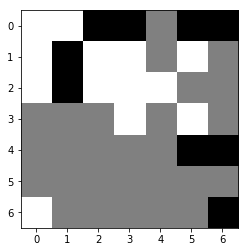

((4, 5), (3, 4)): n_v:   664 q_all:-0.017651 q:-0.028812 q_m:+0.166667 p:0.157055
((2, 1), (3, 2)): n_v:   563 q_all:-0.048486 q:+0.022168 q_m:+0.100000 p:0.239621
((2, 1), (4, 3)): n_v:   288 q_all:+0.020482 q:+0.006251 q_m:-0.066667 p:0.000541
((2, 1), (3, 1)): n_v:   226 q_all:+0.014726 q:+0.041998 q_m:+0.033333 p:0.008324
((0, 3), (2, 5)): n_v:   205 q_all:-0.042232 q:-0.048697 q_m:+0.066667 p:0.079259
((0, 5), (2, 5)): n_v:   201 q_all:-0.056205 q:-0.049481 q_m:+0.066667 p:0.095037
((0, 3), (1, 4)): n_v:   103 q_all:-0.086547 q:-0.050854 q_m:+0.166667 p:0.068261
((0, 2), (1, 4)): n_v:    94 q_all:-0.055353 q:-0.070673 q_m:+0.133333 p:0.044249
((4, 5), (2, 5)): n_v:    87 q_all:-0.022305 q:-0.026147 q_m:+0.066667 p:0.023252
((4, 6), (3, 4)): n_v:    80 q_all:-0.021011 q:-0.030838 q_m:+0.133333 p:0.020712
((4, 6), (2, 5)): n_v:    76 q_all:-0.024024 q:-0.034730 q_m:+0.066667 p:0.020670
((1, 1), (3, 2)): n_v:    46 q_all:-0.000774 q:+0.021355 q_m:+0.066667 p:0.006057
((0, 6), (2, 5))

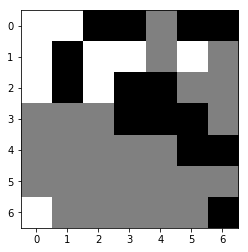

((2, 2), (3, 2)): n_v:   929 q_all:+0.031990 q:+0.010792 q_m:+0.066667 p:0.266805
((2, 2), (4, 4)): n_v:   451 q_all:+0.044336 q:+0.048400 q_m:+0.100000 p:0.093606
((2, 2), (1, 4)): n_v:   267 q_all:-0.004637 q:+0.015634 q_m:+0.100000 p:0.139854
((1, 3), (1, 4)): n_v:   225 q_all:+0.004975 q:+0.021058 q_m:+0.133333 p:0.103894
((1, 5), (2, 5)): n_v:   153 q_all:+0.040939 q:+0.010139 q_m:+0.066667 p:0.034952
((2, 2), (3, 0)): n_v:   110 q_all:-0.045670 q:-0.000493 q_m:-0.100000 p:0.087453
((1, 5), (1, 6)): n_v:   104 q_all:+0.069335 q:+0.035690 q_m:-0.000000 p:0.005371
((1, 3), (2, 5)): n_v:    68 q_all:+0.049761 q:+0.012125 q_m:+0.033333 p:0.011834
((2, 2), (4, 2)): n_v:    59 q_all:+0.007756 q:+0.018473 q_m:-0.100000 p:0.026397
((1, 3), (3, 2)): n_v:    44 q_all:-0.003845 q:-0.006715 q_m:+0.033333 p:0.022758
((1, 2), (3, 0)): n_v:    36 q_all:-0.073531 q:-0.038489 q_m:-0.100000 p:0.034787
((1, 0), (3, 2)): n_v:    28 q_all:-0.102778 q:-0.057975 q_m:+0.033333 p:0.033152
((1, 5), (3, 6))

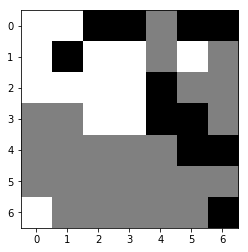

((0, 3), (1, 4)): n_v:  1045 q_all:-0.043631 q:-0.065590 q_m:+0.166667 p:0.198192
((3, 4), (4, 3)): n_v:   829 q_all:-0.033375 q:-0.038615 q_m:+0.100000 p:0.104796
((1, 1), (3, 1)): n_v:   358 q_all:-0.065205 q:-0.008529 q_m:+0.200000 p:0.115346
((4, 5), (4, 3)): n_v:   163 q_all:-0.026222 q:-0.020866 q_m:+0.066667 p:0.013347
((4, 5), (5, 4)): n_v:   111 q_all:-0.061479 q:-0.076798 q_m:-0.033333 p:0.033185
((0, 2), (1, 4)): n_v:    88 q_all:-0.086761 q:-0.104585 q_m:+0.133333 p:0.040040
((3, 4), (4, 2)): n_v:    65 q_all:-0.046529 q:-0.050823 q_m:+0.066667 p:0.013632
((0, 3), (2, 5)): n_v:    55 q_all:-0.109570 q:-0.120391 q_m:-0.000000 p:0.032571
((3, 4), (5, 2)): n_v:    38 q_all:-0.042454 q:-0.086059 q_m:-0.066667 p:0.006961
((2, 4), (4, 3)): n_v:    20 q_all:-0.035075 q:-0.052835 q_m:+0.066667 p:0.002652
((3, 5), (4, 3)): n_v:    17 q_all:-0.053564 q:-0.041473 q_m:+0.066667 p:0.004298
((2, 4), (2, 5)): n_v:    17 q_all:-0.117637 q:-0.118630 q_m:+0.033333 p:0.010945
((0, 6), (1, 4))

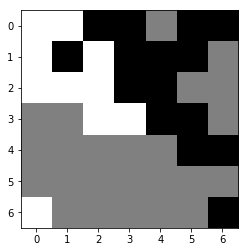

((2, 2), (0, 4)): n_v:  2340 q_all:+0.067872 q:+0.044590 q_m:+0.166667 p:0.538295
((3, 3), (2, 5)): n_v:   693 q_all:+0.031091 q:+0.001776 q_m:+0.166667 p:0.308599
((1, 2), (0, 4)): n_v:    86 q_all:-0.058081 q:-0.003464 q_m:+0.166667 p:0.083880
((3, 2), (4, 4)): n_v:    24 q_all:-0.017578 q:-0.024451 q_m:+0.033333 p:0.017751
((3, 3), (4, 4)): n_v:    20 q_all:+0.010339 q:-0.020410 q_m:+0.066667 p:0.011250
((3, 3), (5, 5)): n_v:    10 q_all:+0.068270 q:+0.026554 q_m:+0.033333 p:0.002156
((3, 3), (4, 1)): n_v:     6 q_all:-0.118658 q:-0.102111 q_m:-0.166667 p:0.008603
((3, 2), (4, 2)): n_v:     5 q_all:+0.001568 q:-0.117229 q_m:-0.133333 p:0.003266
((3, 2), (4, 1)): n_v:     2 q_all:-0.025218 q:-0.088904 q_m:-0.133333 p:0.002166
((6, 0), (6, 2)): n_v:     2 q_all:-0.085950 q:-0.088856 q_m:-0.166667 p:0.002291
((3, 3), (3, 1)): n_v:     1 q_all:-0.070046 q:-0.112638 q_m:-0.166667 p:0.001489
((3, 2), (4, 3)): n_v:     1 q_all:-0.014154 q:-0.046021 q_m:-0.066667 p:0.001115
((2, 2), (4, 4))

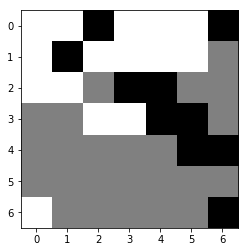

((1, 1), (2, 2)): n_v:  2105 q_all:-0.069963 q:-0.032583 q_m:+0.200000 p:0.196448
((2, 3), (3, 1)): n_v:  1888 q_all:-0.051541 q:-0.064230 q_m:+0.033333 p:0.004849
((2, 4), (2, 2)): n_v:   195 q_all:-0.109343 q:-0.072582 q_m:+0.166667 p:0.056420
((3, 4), (2, 2)): n_v:    61 q_all:-0.097836 q:-0.063744 q_m:+0.166667 p:0.014085
((2, 3), (2, 5)): n_v:    37 q_all:-0.118629 q:-0.160406 q_m:-0.033333 p:0.012149
((3, 4), (4, 4)): n_v:    19 q_all:-0.192123 q:-0.155149 q_m:-0.066667 p:0.013712
((2, 4), (2, 5)): n_v:    13 q_all:-0.152760 q:-0.147687 q_m:-0.000000 p:0.006991
((2, 4), (4, 2)): n_v:    13 q_all:-0.127632 q:-0.106385 q_m:-0.033333 p:0.004905
((3, 4), (4, 2)): n_v:    10 q_all:-0.163985 q:-0.114843 q_m:-0.033333 p:0.006006
((2, 3), (4, 2)): n_v:     9 q_all:-0.121892 q:-0.115950 q_m:-0.033333 p:0.003216
((3, 4), (1, 6)): n_v:     9 q_all:-0.064610 q:-0.120461 q_m:-0.033333 p:0.000660
((2, 4), (1, 6)): n_v:     9 q_all:-0.104791 q:-0.110615 q_m:-0.033333 p:0.002292
((2, 3), (4, 1))

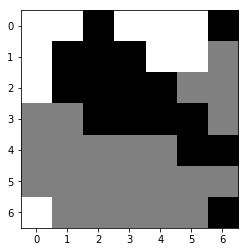

((2, 0), (3, 1)): n_v:  3631 q_all:+0.092481 q:+0.071974 q_m:+0.033333 p:0.795301
((1, 4), (2, 5)): n_v:   259 q_all:+0.080098 q:+0.078157 q_m:+0.033333 p:0.072883
((1, 0), (3, 1)): n_v:    56 q_all:-0.062227 q:-0.029161 q_m:-0.000000 p:0.056867
((2, 0), (3, 0)): n_v:     7 q_all:-0.014684 q:+0.003239 q_m:-0.100000 p:0.005940
((0, 5), (2, 5)): n_v:     6 q_all:+0.046937 q:+0.029217 q_m:-0.000000 p:0.003040
((0, 5), (1, 6)): n_v:     5 q_all:+0.061214 q:+0.074484 q_m:-0.100000 p:0.002001
((2, 0), (4, 1)): n_v:     5 q_all:+0.006549 q:-0.001888 q_m:-0.133333 p:0.003427
((2, 0), (4, 2)): n_v:     3 q_all:+0.016624 q:+0.015703 q_m:-0.066667 p:0.002330
((6, 0), (4, 2)): n_v:     2 q_all:+0.084608 q:+0.057239 q_m:-0.066667 p:0.000661
((0, 3), (2, 5)): n_v:     1 q_all:-0.012341 q:+0.005199 q_m:-0.000000 p:0.000919
((0, 5), (2, 6)): n_v:     0 q_all:-0.006689 q:-0.006689 q_m:-0.133333 p:0.000018
((1, 5), (3, 6)): n_v:     0 q_all:+0.023393 q:+0.023393 q_m:-0.000000 p:0.000027
((6, 0), (6, 2))

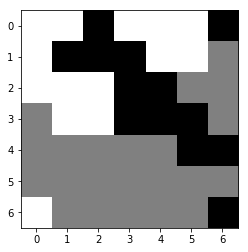

((2, 4), (2, 5)): n_v:  2076 q_all:-0.079064 q:-0.113891 q_m:+0.133333 p:0.266819
((3, 4), (1, 6)): n_v:   708 q_all:-0.052737 q:-0.126916 q_m:+0.100000 p:0.006771
((4, 5), (2, 5)): n_v:   365 q_all:-0.047519 q:-0.086270 q_m:+0.100000 p:0.001209
((0, 6), (2, 5)): n_v:   350 q_all:-0.071943 q:-0.116575 q_m:+0.100000 p:0.033572
((3, 3), (2, 5)): n_v:   334 q_all:-0.153502 q:-0.140188 q_m:+0.100000 p:0.155183
((3, 3), (4, 1)): n_v:   299 q_all:-0.123841 q:-0.156143 q_m:+0.100000 p:0.099115
((3, 5), (1, 6)): n_v:   135 q_all:-0.065739 q:-0.075705 q_m:+0.100000 p:0.009067
((0, 6), (1, 6)): n_v:    41 q_all:-0.094268 q:-0.095445 q_m:+0.133333 p:0.008215
((2, 4), (1, 6)): n_v:    31 q_all:-0.107889 q:-0.135311 q_m:+0.100000 p:0.008122
((3, 5), (3, 6)): n_v:    20 q_all:-0.195582 q:-0.197064 q_m:-0.000000 p:0.012564
((3, 3), (4, 2)): n_v:    18 q_all:-0.127861 q:-0.128788 q_m:+0.133333 p:0.006423
((2, 3), (2, 5)): n_v:    14 q_all:-0.249212 q:-0.184976 q_m:+0.100000 p:0.012931
((1, 2), (3, 0))

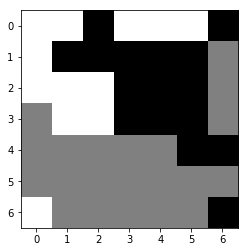

((0, 5), (1, 6)): n_v:  2242 q_all:+0.056353 q:+0.156594 q_m:+0.100000 p:0.649811
((3, 2), (4, 4)): n_v:  1128 q_all:+0.070379 q:+0.050443 q_m:+0.133333 p:0.246593
((3, 2), (4, 3)): n_v:   320 q_all:+0.106803 q:+0.074659 q_m:+0.033333 p:0.010401
((3, 1), (4, 2)): n_v:   272 q_all:+0.103956 q:+0.031009 q_m:-0.033333 p:0.012745
((2, 2), (4, 4)): n_v:    72 q_all:+0.087229 q:+0.070310 q_m:+0.133333 p:0.009547
((0, 5), (2, 6)): n_v:    33 q_all:+0.025605 q:+0.069020 q_m:+0.066667 p:0.015022
((6, 0), (4, 2)): n_v:    27 q_all:+0.083290 q:+0.031840 q_m:-0.066667 p:0.004229
((6, 0), (5, 0)): n_v:    27 q_all:+0.084320 q:+0.027110 q_m:-0.100000 p:0.003715
((2, 0), (3, 0)): n_v:    22 q_all:+0.071766 q:+0.051965 q_m:-0.100000 p:0.004690
((6, 0), (4, 0)): n_v:    12 q_all:+0.056405 q:-0.000770 q_m:-0.133333 p:0.003723
((0, 4), (2, 6)): n_v:    10 q_all:-0.000568 q:-0.023890 q_m:+0.066667 p:0.006233
((3, 1), (4, 0)): n_v:     2 q_all:+0.047596 q:+0.004622 q_m:-0.100000 p:0.000849
((6, 0), (5, 1))

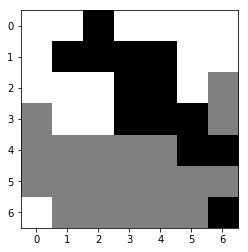

((3, 5), (2, 6)): n_v:  3139 q_all:-0.038130 q:-0.047939 q_m:+0.133333 p:0.717119
((4, 5), (2, 6)): n_v:   450 q_all:-0.023609 q:-0.036374 q_m:+0.100000 p:0.069685
((4, 6), (2, 6)): n_v:   256 q_all:-0.053833 q:-0.065131 q_m:+0.100000 p:0.078534
((3, 4), (2, 6)): n_v:   197 q_all:-0.115601 q:-0.113332 q_m:+0.100000 p:0.121254
((2, 4), (2, 6)): n_v:     2 q_all:-0.223722 q:-0.218075 q_m:+0.100000 p:0.003223
((3, 3), (4, 2)): n_v:     1 q_all:-0.152447 q:-0.215253 q_m:+0.066667 p:0.001116
((1, 4), (2, 6)): n_v:     1 q_all:-0.264703 q:-0.211042 q_m:+0.100000 p:0.001720
((2, 3), (4, 2)): n_v:     0 q_all:-0.295625 q:-0.295625 q_m:+0.033333 p:0.000010
((3, 3), (4, 4)): n_v:     0 q_all:-0.253234 q:-0.253234 q_m:-0.066667 p:0.000586
((4, 5), (4, 3)): n_v:     0 q_all:-0.216940 q:-0.216940 q_m:-0.033333 p:0.000049
((3, 4), (3, 6)): n_v:     0 q_all:-0.314305 q:-0.314305 q_m:-0.033333 p:0.000232
((3, 5), (4, 3)): n_v:     0 q_all:-0.270228 q:-0.270228 q_m:-0.033333 p:0.000020
((3, 3), (4, 1))

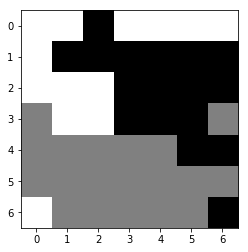

((2, 2), (4, 4)): n_v:  2308 q_all:+0.114818 q:+0.038422 q_m:+0.133333 p:0.017747
((3, 2), (4, 4)): n_v:  1641 q_all:+0.040531 q:-0.005832 q_m:+0.133333 p:0.447426
((2, 0), (3, 0)): n_v:   380 q_all:+0.026386 q:+0.019283 q_m:-0.100000 p:0.135585
((3, 2), (4, 3)): n_v:    97 q_all:+0.016175 q:+0.044120 q_m:+0.033333 p:0.040493
((3, 1), (4, 2)): n_v:    63 q_all:-0.008850 q:+0.001470 q_m:-0.033333 p:0.036143
((3, 2), (3, 0)): n_v:    16 q_all:-0.074935 q:-0.038597 q_m:-0.133333 p:0.014111
((6, 0), (4, 2)): n_v:    14 q_all:-0.020509 q:+0.000685 q_m:-0.066667 p:0.008785
((6, 0), (5, 1)): n_v:     9 q_all:-0.018105 q:-0.001645 q_m:-0.100000 p:0.005675
((1, 0), (3, 0)): n_v:     3 q_all:-0.205291 q:-0.166930 q_m:-0.133333 p:0.005774
((2, 0), (4, 2)): n_v:     3 q_all:-0.058302 q:-0.046878 q_m:-0.066667 p:0.002708
((3, 1), (4, 0)): n_v:     2 q_all:-0.052130 q:-0.033737 q_m:-0.100000 p:0.001508
((3, 2), (5, 4)): n_v:     2 q_all:-0.037688 q:-0.033376 q_m:-0.066667 p:0.001740
((2, 2), (3, 0))

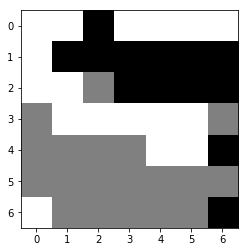

((1, 1), (2, 2)): n_v:  3294 q_all:-0.102572 q:-0.049515 q_m:+0.166667 p:0.076252
((0, 2), (2, 2)): n_v:   369 q_all:-0.103866 q:-0.151478 q_m:+0.133333 p:0.001247
((1, 4), (2, 2)): n_v:   253 q_all:-0.107592 q:-0.239658 q_m:+0.133333 p:0.006949
((2, 5), (3, 6)): n_v:   252 q_all:-0.163576 q:-0.095504 q_m:+0.033333 p:0.081774
((1, 1), (3, 0)): n_v:   158 q_all:-0.104029 q:-0.075693 q_m:+0.066667 p:0.000144
((2, 4), (2, 2)): n_v:   128 q_all:-0.127436 q:-0.231979 q_m:+0.133333 p:0.018599
((1, 2), (3, 0)): n_v:    14 q_all:-0.156436 q:-0.095993 q_m:+0.066667 p:0.004307
((1, 4), (3, 6)): n_v:    12 q_all:-0.147376 q:-0.226831 q_m:-0.000000 p:0.003115
((2, 4), (4, 2)): n_v:     3 q_all:-0.275860 q:-0.281463 q_m:+0.066667 p:0.002300
((2, 3), (4, 2)): n_v:     1 q_all:-0.268573 q:-0.237239 q_m:+0.066667 p:0.001180
((4, 6), (5, 5)): n_v:     1 q_all:-0.189863 q:-0.140988 q_m:+0.033333 p:0.000345
((4, 6), (6, 5)): n_v:     0 q_all:-0.270362 q:-0.270362 q_m:-0.133333 p:0.000014
((6, 6), (6, 4))

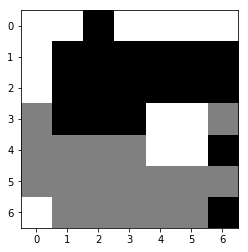

((3, 5), (3, 6)): n_v:  4804 q_all:+0.139760 q:+0.135069 q_m:+0.066667 p:0.298707
((2, 0), (3, 0)): n_v:   547 q_all:+0.048035 q:+0.031564 q_m:-0.000000 p:0.259350
((4, 4), (3, 6)): n_v:    65 q_all:+0.108378 q:+0.115181 q_m:+0.033333 p:0.009833
((3, 4), (3, 6)): n_v:     8 q_all:+0.054116 q:+0.058186 q_m:+0.033333 p:0.004025
((4, 4), (6, 3)): n_v:     0 q_all:-0.088531 q:-0.088531 q_m:-0.166667 p:0.000000
((4, 4), (5, 6)): n_v:     0 q_all:-0.014048 q:-0.014048 q_m:-0.033333 p:0.000001
((4, 5), (4, 3)): n_v:     0 q_all:-0.001933 q:-0.001933 q_m:-0.033333 p:0.000000
((3, 5), (4, 3)): n_v:     0 q_all:+0.052203 q:+0.052203 q_m:-0.033333 p:0.000000
((4, 4), (6, 4)): n_v:     0 q_all:-0.072751 q:-0.072751 q_m:-0.166667 p:0.000000
((6, 0), (6, 2)): n_v:     0 q_all:-0.087525 q:-0.087525 q_m:-0.166667 p:0.000000
((4, 5), (6, 3)): n_v:     0 q_all:-0.064025 q:-0.064025 q_m:-0.166667 p:0.000000
((3, 4), (4, 2)): n_v:     0 q_all:+0.023834 q:+0.023834 q_m:+0.033333 p:0.000001
((3, 4), (5, 5))

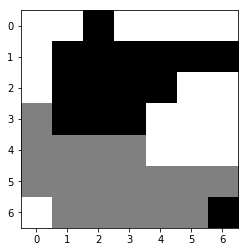

((6, 6), (5, 5)): n_v:  3303 q_all:-0.139468 q:-0.100936 q_m:+0.166667 p:0.582784
((2, 1), (3, 0)): n_v:  2508 q_all:-0.108497 q:-0.097077 q_m:+0.033333 p:0.133085
((3, 2), (4, 3)): n_v:   139 q_all:-0.157477 q:-0.114507 q_m:+0.100000 p:0.034374
((3, 3), (5, 5)): n_v:    56 q_all:-0.216482 q:-0.165350 q_m:+0.133333 p:0.027364
((3, 3), (5, 1)): n_v:    54 q_all:-0.248476 q:-0.190091 q_m:-0.000000 p:0.033137
((3, 1), (5, 1)): n_v:    14 q_all:-0.201674 q:-0.163977 q_m:-0.000000 p:0.006239
((6, 6), (5, 6)): n_v:    13 q_all:-0.198072 q:-0.135867 q_m:+0.100000 p:0.005576
((6, 6), (6, 5)): n_v:     5 q_all:-0.275719 q:-0.259573 q_m:-0.033333 p:0.004099
((3, 1), (4, 3)): n_v:     3 q_all:-0.169197 q:-0.113235 q_m:+0.066667 p:0.001029
((3, 2), (5, 1)): n_v:     2 q_all:-0.214283 q:-0.188703 q_m:-0.000000 p:0.001120
((3, 1), (4, 2)): n_v:     1 q_all:-0.249957 q:-0.231108 q_m:-0.033333 p:0.000826
((1, 1), (3, 0)): n_v:     1 q_all:-0.401371 q:-0.245806 q_m:-0.000000 p:0.001029
((6, 6), (5, 4))

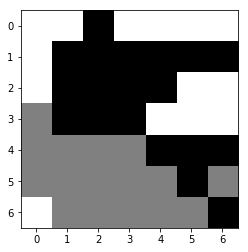

((2, 0), (3, 0)): n_v:  3376 q_all:+0.197258 q:+0.167933 q_m:-0.000000 p:0.663820
((3, 4), (5, 6)): n_v:   431 q_all:+0.174651 q:+0.182860 q_m:+0.100000 p:0.128718
((3, 4), (4, 3)): n_v:   340 q_all:+0.146568 q:+0.130838 q_m:+0.066667 p:0.144640
((3, 4), (4, 2)): n_v:    35 q_all:+0.105549 q:+0.110550 q_m:+0.033333 p:0.021835
((3, 4), (5, 2)): n_v:    18 q_all:+0.049024 q:+0.054920 q_m:-0.166667 p:0.016015
((6, 0), (5, 0)): n_v:     7 q_all:+0.048597 q:+0.069448 q_m:-0.133333 p:0.006757
((1, 0), (3, 0)): n_v:     4 q_all:-0.043027 q:-0.010880 q_m:-0.033333 p:0.005823
((3, 5), (5, 6)): n_v:     3 q_all:+0.000714 q:+0.055227 q_m:+0.100000 p:0.002663
((2, 0), (4, 2)): n_v:     3 q_all:+0.059905 q:+0.099761 q_m:+0.033333 p:0.002269
((3, 6), (5, 6)): n_v:     2 q_all:+0.052458 q:+0.081639 q_m:+0.100000 p:0.001551
((6, 0), (4, 2)): n_v:     2 q_all:+0.077658 q:+0.130640 q_m:+0.033333 p:0.001016
((3, 6), (5, 4)): n_v:     1 q_all:-0.029289 q:+0.025283 q_m:+0.033333 p:0.001328
((3, 4), (5, 3))

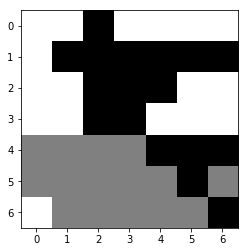

((3, 2), (4, 1)): n_v:  2486 q_all:-0.227938 q:-0.161574 q_m:+0.166667 p:0.523502
((4, 5), (5, 6)): n_v:  1108 q_all:-0.188157 q:-0.251726 q_m:+0.033333 p:0.036655
((3, 2), (4, 3)): n_v:   323 q_all:-0.226873 q:-0.202755 q_m:+0.100000 p:0.066150
((4, 4), (5, 6)): n_v:   235 q_all:-0.196939 q:-0.283857 q_m:-0.000000 p:0.016837
((3, 3), (4, 1)): n_v:    51 q_all:-0.323417 q:-0.224703 q_m:+0.133333 p:0.032567
((5, 5), (6, 5)): n_v:    36 q_all:-0.288877 q:-0.250413 q_m:+0.033333 p:0.017780
((3, 2), (4, 2)): n_v:    36 q_all:-0.220993 q:-0.262793 q_m:+0.100000 p:0.006641
((4, 4), (5, 3)): n_v:    25 q_all:-0.263017 q:-0.300872 q_m:+0.033333 p:0.009476
((4, 4), (4, 2)): n_v:    12 q_all:-0.270218 q:-0.252721 q_m:+0.066667 p:0.004920
((5, 5), (6, 4)): n_v:    12 q_all:-0.278865 q:-0.273956 q_m:+0.033333 p:0.005594
((5, 5), (4, 3)): n_v:    10 q_all:-0.225491 q:-0.199138 q_m:+0.066667 p:0.001644
((4, 4), (5, 4)): n_v:     9 q_all:-0.296454 q:-0.273737 q_m:+0.033333 p:0.005003
((3, 3), (5, 1))

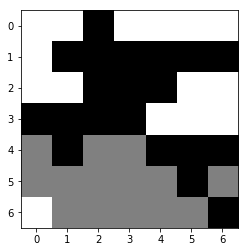

((6, 0), (4, 0)): n_v:  3542 q_all:+0.260462 q:+0.246654 q_m:+0.033333 p:0.438217
((3, 4), (4, 2)): n_v:   318 q_all:+0.186939 q:+0.162203 q_m:+0.100000 p:0.153327
((3, 4), (4, 3)): n_v:   307 q_all:+0.168890 q:+0.149483 q_m:+0.066667 p:0.175346
((6, 0), (4, 2)): n_v:   140 q_all:+0.130108 q:+0.161603 q_m:+0.100000 p:0.105850
((3, 4), (5, 6)): n_v:    59 q_all:+0.212231 q:+0.211645 q_m:+0.100000 p:0.021233
((3, 4), (5, 2)): n_v:    50 q_all:+0.112253 q:+0.125753 q_m:-0.100000 p:0.042346
((6, 0), (5, 2)): n_v:    36 q_all:+0.136926 q:+0.115927 q_m:-0.100000 p:0.026443
((6, 0), (5, 0)): n_v:    22 q_all:+0.128521 q:+0.133947 q_m:-0.066667 p:0.016899
((2, 0), (4, 2)): n_v:     6 q_all:+0.019885 q:+0.057016 q_m:+0.100000 p:0.007826
((6, 0), (5, 1)): n_v:     5 q_all:+0.138398 q:+0.151208 q_m:-0.066667 p:0.003998
((3, 4), (5, 3)): n_v:     1 q_all:+0.032054 q:+0.077847 q_m:-0.100000 p:0.001264
((3, 6), (5, 4)): n_v:     0 q_all:+0.061150 q:+0.061150 q_m:+0.033333 p:0.000682
((2, 5), (4, 3))

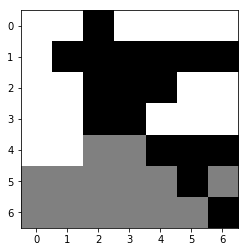

((4, 5), (5, 6)): n_v:  1515 q_all:-0.253107 q:-0.334354 q_m:-0.000000 p:0.071605
((4, 4), (4, 2)): n_v:   856 q_all:-0.251365 q:-0.259590 q_m:+0.100000 p:0.033869
((3, 2), (4, 2)): n_v:   784 q_all:-0.281432 q:-0.272628 q_m:+0.133333 p:0.134815
((3, 2), (5, 1)): n_v:   681 q_all:-0.272572 q:-0.237607 q_m:+0.100000 p:0.090266
((4, 4), (5, 6)): n_v:   445 q_all:-0.260111 q:-0.367028 q_m:-0.033333 p:0.034554
((3, 3), (5, 1)): n_v:   200 q_all:-0.351012 q:-0.303993 q_m:+0.100000 p:0.096048
((3, 2), (5, 0)): n_v:   125 q_all:-0.302880 q:-0.266777 q_m:+0.100000 p:0.033180
((3, 2), (4, 3)): n_v:    53 q_all:-0.318822 q:-0.291299 q_m:+0.066667 p:0.018024
((4, 4), (5, 3)): n_v:    33 q_all:-0.339795 q:-0.385149 q_m:-0.000000 p:0.014463
((4, 4), (5, 2)): n_v:    13 q_all:-0.303228 q:-0.310546 q_m:+0.033333 p:0.003314
((4, 4), (5, 4)): n_v:    12 q_all:-0.360585 q:-0.357573 q_m:-0.000000 p:0.006560
((5, 5), (6, 5)): n_v:    11 q_all:-0.340342 q:-0.331011 q_m:-0.000000 p:0.005132
((5, 5), (6, 4))

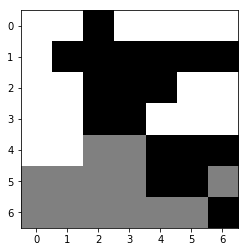

((3, 4), (4, 3)): n_v:  2133 q_all:+0.450760 q:+0.383567 q_m:+0.300000 p:0.892087
((4, 0), (5, 0)): n_v:    24 q_all:+0.330063 q:+0.283824 q_m:+0.033333 p:0.030546
((3, 4), (5, 6)): n_v:    24 q_all:+0.371870 q:+0.394207 q_m:+0.266667 p:0.023410
((3, 4), (4, 2)): n_v:    18 q_all:+0.383805 q:+0.249942 q_m:+0.133333 p:0.016161
((4, 1), (4, 3)): n_v:     8 q_all:+0.361054 q:+0.335127 q_m:+0.266667 p:0.007967
((3, 1), (4, 2)): n_v:     1 q_all:+0.249828 q:+0.298058 q_m:+0.166667 p:0.002128
((3, 0), (4, 2)): n_v:     0 q_all:+0.138672 q:+0.138672 q_m:+0.133333 p:0.000068
((3, 0), (5, 1)): n_v:     0 q_all:+0.115172 q:+0.115172 q_m:-0.000000 p:0.000477
((4, 1), (6, 1)): n_v:     0 q_all:+0.234985 q:+0.234985 q_m:-0.000000 p:0.000024
((4, 0), (4, 2)): n_v:     0 q_all:+0.257060 q:+0.257060 q_m:+0.133333 p:0.000077
((4, 0), (6, 2)): n_v:     0 q_all:+0.196379 q:+0.196379 q_m:-0.000000 p:0.000024
((4, 1), (6, 3)): n_v:     0 q_all:+0.243265 q:+0.243265 q_m:+0.066667 p:0.000020
((3, 0), (5, 0))

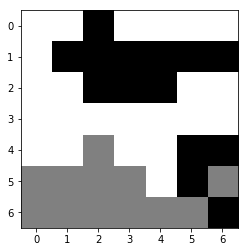

((5, 5), (5, 3)): n_v:  1649 q_all:-0.444599 q:-0.344937 q_m:-0.100000 p:0.578192
((4, 6), (6, 5)): n_v:  1214 q_all:-0.365128 q:-0.391724 q_m:-0.233333 p:0.005099
((5, 5), (6, 4)): n_v:   539 q_all:-0.386597 q:-0.396110 q_m:-0.200000 p:0.003531
((4, 5), (5, 3)): n_v:   532 q_all:-0.491835 q:-0.330665 q_m:-0.100000 p:0.335987
((5, 5), (6, 5)): n_v:   333 q_all:-0.390166 q:-0.389336 q_m:-0.200000 p:0.009170
((2, 4), (4, 2)): n_v:    18 q_all:-0.572404 q:-0.465574 q_m:+0.033333 p:0.019117
((6, 6), (6, 4)): n_v:    10 q_all:-0.435491 q:-0.399915 q_m:-0.233333 p:0.003064
((4, 6), (6, 4)): n_v:     7 q_all:-0.448623 q:-0.411286 q_m:-0.233333 p:0.002805
((4, 5), (6, 5)): n_v:     6 q_all:-0.437955 q:-0.420455 q_m:-0.233333 p:0.002086
((4, 5), (5, 6)): n_v:     6 q_all:-0.513148 q:-0.423762 q_m:-0.266667 p:0.004932
((4, 5), (6, 3)): n_v:     5 q_all:-0.477641 q:-0.390547 q_m:-0.233333 p:0.002993
((5, 5), (6, 3)): n_v:     4 q_all:-0.504006 q:-0.426145 q_m:-0.233333 p:0.003154
((4, 5), (6, 4))

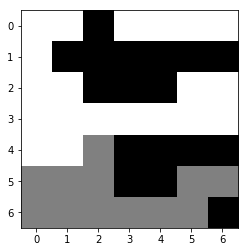

((3, 3), (5, 5)): n_v:  3484 q_all:+0.505438 q:+0.460218 q_m:+0.433333 p:0.055925
((3, 1), (4, 2)): n_v:   283 q_all:+0.378720 q:+0.370091 q_m:+0.266667 p:0.197835
((3, 4), (5, 5)): n_v:    15 q_all:+0.355383 q:+0.357560 q_m:+0.433333 p:0.013105
((3, 3), (5, 1)): n_v:    12 q_all:+0.271444 q:+0.217617 q_m:+0.100000 p:0.015948
((4, 0), (5, 1)): n_v:    11 q_all:+0.270867 q:+0.282536 q_m:+0.133333 p:0.015169
((3, 6), (5, 5)): n_v:     9 q_all:+0.400858 q:+0.400858 q_m:+0.433333 p:0.005422
((4, 0), (4, 2)): n_v:     6 q_all:+0.303878 q:+0.318683 q_m:+0.233333 p:0.006271
((3, 0), (4, 2)): n_v:     5 q_all:+0.221277 q:+0.199933 q_m:+0.233333 p:0.008620
((3, 4), (4, 2)): n_v:     5 q_all:+0.266210 q:+0.246325 q_m:+0.233333 p:0.007563
((2, 0), (4, 2)): n_v:     5 q_all:+0.180310 q:+0.169326 q_m:+0.233333 p:0.010574
((3, 2), (5, 1)): n_v:     5 q_all:+0.240979 q:+0.191858 q_m:+0.100000 p:0.008061
((4, 1), (5, 2)): n_v:     2 q_all:+0.315530 q:+0.315530 q_m:+0.266667 p:0.003080
((3, 0), (5, 1))

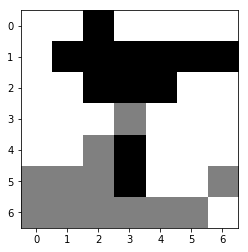

((2, 2), (3, 3)): n_v:  1695 q_all:-0.501545 q:-0.510090 q_m:-0.200000 p:0.128538
((5, 3), (3, 3)): n_v:  1606 q_all:-0.493481 q:-0.476480 q_m:-0.233333 p:0.067063
((4, 3), (5, 1)): n_v:   380 q_all:-0.540215 q:-0.514342 q_m:-0.300000 p:0.094180
((2, 4), (4, 2)): n_v:   211 q_all:-0.530016 q:-0.546803 q_m:-0.233333 p:0.042993
((2, 3), (4, 2)): n_v:   130 q_all:-0.572485 q:-0.577208 q_m:-0.233333 p:0.051030
((4, 3), (6, 5)): n_v:    75 q_all:-0.566165 q:-0.584377 q_m:-0.233333 p:0.027457
((1, 4), (3, 3)): n_v:    66 q_all:-0.609021 q:-0.532345 q_m:-0.233333 p:0.036648
((5, 3), (6, 5)): n_v:    65 q_all:-0.603282 q:-0.610390 q_m:-0.233333 p:0.034352
((5, 3), (5, 1)): n_v:    60 q_all:-0.598529 q:-0.594991 q_m:-0.300000 p:0.030809
((1, 1), (3, 3)): n_v:    34 q_all:-0.627295 q:-0.431314 q_m:-0.233333 p:0.021733
((1, 2), (3, 3)): n_v:    27 q_all:-0.649319 q:-0.548020 q_m:-0.233333 p:0.020030
((1, 5), (3, 3)): n_v:    26 q_all:-0.661313 q:-0.531908 q_m:-0.233333 p:0.020653
((4, 3), (6, 1))

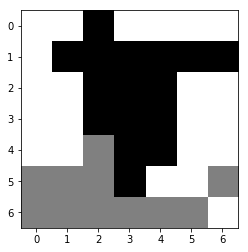

((3, 1), (4, 2)): n_v:  3758 q_all:+0.541392 q:+0.540110 q_m:+0.500000 p:0.408449
((5, 4), (4, 2)): n_v:    87 q_all:+0.484617 q:+0.508156 q_m:+0.466667 p:0.036101
((4, 0), (4, 2)): n_v:    18 q_all:+0.468907 q:+0.500968 q_m:+0.466667 p:0.009316
((2, 0), (4, 2)): n_v:     4 q_all:+0.272455 q:+0.351143 q_m:+0.466667 p:0.005622
((3, 0), (4, 2)): n_v:     3 q_all:+0.392054 q:+0.394227 q_m:+0.466667 p:0.002939
((5, 4), (6, 4)): n_v:     1 q_all:+0.444548 q:+0.443140 q_m:+0.300000 p:0.001077
((5, 4), (6, 3)): n_v:     1 q_all:+0.427812 q:+0.439207 q_m:+0.300000 p:0.000975
((3, 0), (5, 1)): n_v:     0 q_all:+0.194538 q:+0.194538 q_m:+0.200000 p:0.000012
((4, 1), (6, 1)): n_v:     0 q_all:+0.332602 q:+0.332602 q_m:+0.200000 p:0.000002
((4, 1), (6, 2)): n_v:     0 q_all:+0.380094 q:+0.380094 q_m:+0.266667 p:0.000009
((4, 6), (6, 5)): n_v:     0 q_all:+0.340998 q:+0.340998 q_m:+0.200000 p:0.000006
((5, 4), (5, 2)): n_v:     0 q_all:+0.369976 q:+0.369976 q_m:+0.333333 p:0.000824
((4, 1), (6, 3))

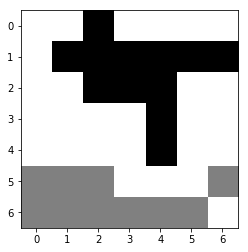

((4, 4), (5, 6)): n_v:  4640 q_all:-0.555289 q:-0.484465 q_m:-0.233333 p:0.740634
((4, 4), (5, 2)): n_v:   462 q_all:-0.587905 q:-0.525896 q_m:-0.233333 p:0.138607
((3, 4), (5, 6)): n_v:   146 q_all:-0.598855 q:-0.547626 q_m:-0.233333 p:0.050483
((3, 4), (5, 2)): n_v:    88 q_all:-0.607976 q:-0.547504 q_m:-0.233333 p:0.033944
((4, 4), (6, 5)): n_v:    41 q_all:-0.610020 q:-0.621431 q_m:-0.300000 p:0.016437
((4, 4), (6, 2)): n_v:    27 q_all:-0.626913 q:-0.590365 q_m:-0.433333 p:0.012771
((4, 4), (6, 3)): n_v:    11 q_all:-0.626335 q:-0.560480 q_m:-0.366667 p:0.004740
((4, 4), (6, 4)): n_v:     4 q_all:-0.600503 q:-0.604955 q_m:-0.300000 p:0.001724
########################p_sum is:  0.999340336421
1 's turn


This is a random move


one move takes time(s):  0.4114649295806885
no. of data collected:  16


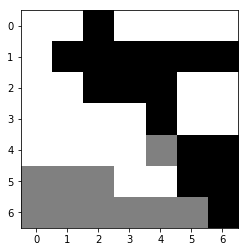

((3, 3), (4, 4)): n_v:  5829 q_all:+0.575741 q:+0.571397 q_m:+0.466667 p:0.157573
((5, 3), (6, 5)): n_v:    48 q_all:+0.455528 q:+0.459975 q_m:+0.433333 p:0.025056
((2, 6), (4, 4)): n_v:    42 q_all:+0.437126 q:+0.453814 q_m:+0.433333 p:0.024663
((3, 6), (4, 4)): n_v:    25 q_all:+0.449652 q:+0.440518 q_m:+0.433333 p:0.013248
((5, 4), (6, 5)): n_v:    21 q_all:+0.446810 q:+0.454470 q_m:+0.466667 p:0.011583
((4, 3), (6, 5)): n_v:    20 q_all:+0.451720 q:+0.442516 q_m:+0.433333 p:0.010325
((5, 3), (6, 1)): n_v:     8 q_all:+0.329235 q:+0.351356 q_m:+0.233333 p:0.008329
((4, 3), (6, 1)): n_v:     5 q_all:+0.328084 q:+0.328598 q_m:+0.233333 p:0.005852
((4, 2), (4, 4)): n_v:     4 q_all:+0.513479 q:+0.477639 q_m:+0.433333 p:0.001337
((3, 2), (4, 4)): n_v:     2 q_all:+0.354137 q:+0.379103 q_m:+0.433333 p:0.002134
((2, 5), (4, 4)): n_v:     2 q_all:+0.373059 q:+0.424087 q_m:+0.433333 p:0.001927
((4, 0), (5, 2)): n_v:     0 q_all:+0.260666 q:+0.260666 q_m:+0.233333 p:0.000013
((4, 2), (6, 1))

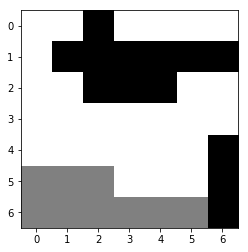

((5, 6), (6, 4)): n_v:  3963 q_all:-0.586657 q:-0.561877 q_m:-0.266667 p:0.404789
((6, 6), (6, 4)): n_v:  2060 q_all:-0.591881 q:-0.600113 q_m:-0.266667 p:0.250544
((5, 6), (6, 5)): n_v:   200 q_all:-0.735123 q:-0.670933 q_m:-0.300000 p:0.130765
((4, 6), (6, 4)): n_v:    45 q_all:-0.627080 q:-0.591388 q_m:-0.266667 p:0.011259
((4, 6), (6, 5)): n_v:    37 q_all:-0.619561 q:-0.667984 q_m:-0.333333 p:0.008343
########################p_sum is:  0.80570032075
1 's turn
one move takes time(s):  0.34496402740478516
no. of data collected:  16


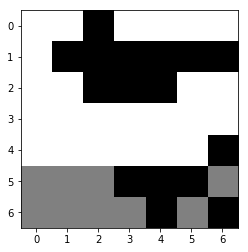

((4, 5), (5, 6)): n_v:  3860 q_all:+0.651402 q:+0.705971 q_m:+0.500000 p:0.121482
((4, 1), (5, 2)): n_v:   796 q_all:+0.575380 q:+0.553219 q_m:+0.366667 p:0.256071
((4, 0), (5, 0)): n_v:    87 q_all:+0.456419 q:+0.466179 q_m:+0.300000 p:0.074502
((4, 2), (6, 3)): n_v:    46 q_all:+0.615309 q:+0.523825 q_m:+0.466667 p:0.005138
((4, 0), (6, 1)): n_v:    29 q_all:+0.405022 q:+0.414002 q_m:+0.266667 p:0.031887
((4, 0), (5, 1)): n_v:    10 q_all:+0.472274 q:+0.480661 q_m:+0.300000 p:0.007925
((4, 0), (5, 2)): n_v:     9 q_all:+0.486968 q:+0.479505 q_m:+0.333333 p:0.007257
((4, 1), (6, 3)): n_v:     8 q_all:+0.545277 q:+0.526813 q_m:+0.466667 p:0.004228
((4, 5), (6, 3)): n_v:     6 q_all:+0.468810 q:+0.486264 q_m:+0.466667 p:0.004804
((4, 4), (6, 3)): n_v:     4 q_all:+0.417684 q:+0.437200 q_m:+0.466667 p:0.004613
((4, 3), (6, 5)): n_v:     3 q_all:+0.488482 q:+0.464766 q_m:+0.533333 p:0.002226
((4, 4), (6, 5)): n_v:     2 q_all:+0.539623 q:+0.454913 q_m:+0.533333 p:0.001411
((4, 5), (6, 5))

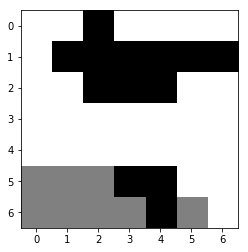

((5, 4), (6, 5)): n_v:  1902 q_all:-0.681376 q:-0.686503 q_m:-0.266667 p:0.403119
((5, 3), (6, 5)): n_v:  1533 q_all:-0.639211 q:-0.633255 q_m:-0.300000 p:0.048224
((5, 3), (5, 1)): n_v:  1094 q_all:-0.661248 q:-0.661669 q_m:-0.300000 p:0.137594
((5, 3), (6, 1)): n_v:   713 q_all:-0.652497 q:-0.649117 q_m:-0.500000 p:0.062438
((5, 4), (5, 2)): n_v:    37 q_all:-0.647281 q:-0.619620 q_m:-0.300000 p:0.002217
((5, 3), (5, 2)): n_v:    13 q_all:-0.693516 q:-0.703038 q_m:-0.266667 p:0.003610
((6, 4), (5, 2)): n_v:     4 q_all:-0.680551 q:-0.694679 q_m:-0.300000 p:0.000784
((6, 4), (6, 2)): n_v:     1 q_all:-0.673505 q:-0.693851 q_m:-0.500000 p:0.000040
((5, 4), (6, 2)): n_v:     1 q_all:-0.647247 q:-0.618137 q_m:-0.500000 p:0.000020
((5, 3), (6, 2)): n_v:     0 q_all:-0.702988 q:-0.702988 q_m:-0.466667 p:0.000030
((5, 3), (6, 3)): n_v:     0 q_all:-0.677183 q:-0.677183 q_m:-0.466667 p:0.000017
########################p_sum is:  0.658093586801
1 's turn


This is a random move


one move tak

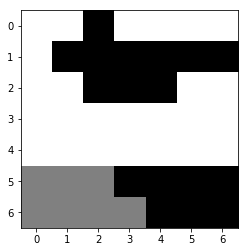

((4, 1), (5, 2)): n_v:  2177 q_all:+0.707780 q:+0.649868 q_m:+0.366667 p:0.271185
((4, 2), (6, 3)): n_v:  1055 q_all:+0.712199 q:+0.681998 q_m:+0.466667 p:0.106891
((4, 1), (6, 3)): n_v:   363 q_all:+0.704032 q:+0.704032 q_m:+0.466667 p:0.047725
((4, 4), (6, 3)): n_v:    57 q_all:+0.485858 q:+0.513490 q_m:+0.466667 p:0.072452
((4, 3), (6, 3)): n_v:    31 q_all:+0.644798 q:+0.565692 q_m:+0.466667 p:0.014428
((4, 5), (6, 3)): n_v:    24 q_all:+0.409521 q:+0.485833 q_m:+0.466667 p:0.039833
((4, 0), (5, 1)): n_v:    14 q_all:+0.588417 q:+0.593970 q_m:+0.300000 p:0.010922
((4, 0), (5, 0)): n_v:     9 q_all:+0.560447 q:+0.571880 q_m:+0.300000 p:0.008222
((4, 0), (5, 2)): n_v:     3 q_all:+0.579637 q:+0.570135 q_m:+0.333333 p:0.003147
((3, 0), (5, 2)): n_v:     2 q_all:+0.469862 q:+0.398405 q_m:+0.333333 p:0.003549
((4, 0), (6, 1)): n_v:     2 q_all:+0.447837 q:+0.463320 q_m:+0.266667 p:0.002795
((3, 0), (5, 1)): n_v:     1 q_all:+0.289577 q:+0.340062 q_m:+0.266667 p:0.003099
((4, 3), (5, 1))

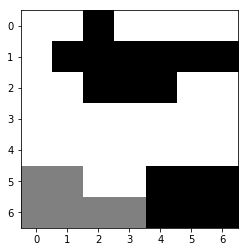

((5, 4), (6, 3)): n_v:  1620 q_all:-0.760669 q:-0.706413 q_m:-0.200000 p:0.403071
((6, 5), (6, 3)): n_v:  1161 q_all:-0.732596 q:-0.742694 q_m:-0.233333 p:0.125839
((5, 4), (6, 2)): n_v:   509 q_all:-0.719665 q:-0.684888 q_m:-0.233333 p:0.021259
((6, 4), (6, 2)): n_v:   437 q_all:-0.756557 q:-0.769771 q_m:-0.233333 p:0.099822
((5, 5), (6, 3)): n_v:   182 q_all:-0.746926 q:-0.713959 q_m:-0.233333 p:0.032421
########################p_sum is:  0.682412937284
1 's turn
one move takes time(s):  0.23141074180603027
no. of data collected:  24


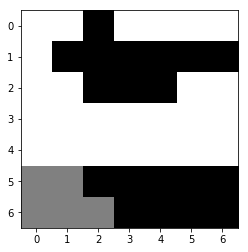

((4, 1), (6, 2)): n_v:  1771 q_all:+0.799756 q:+0.672921 q_m:+0.400000 p:0.072583
((4, 0), (5, 1)): n_v:  1499 q_all:+0.772881 q:+0.754717 q_m:+0.300000 p:0.276485
((4, 0), (6, 2)): n_v:   526 q_all:+0.762635 q:+0.743648 q_m:+0.400000 p:0.126673
((3, 0), (5, 1)): n_v:    15 q_all:+0.619303 q:+0.474340 q_m:+0.266667 p:0.015233
((4, 2), (6, 2)): n_v:     7 q_all:+0.749007 q:+0.579986 q_m:+0.400000 p:0.002478
((4, 0), (5, 0)): n_v:     1 q_all:+0.212444 q:+0.577678 q_m:+0.233333 p:0.002508
((4, 3), (6, 2)): n_v:     1 q_all:+0.292752 q:+0.482691 q_m:+0.400000 p:0.003901
((4, 2), (6, 1)): n_v:     0 q_all:+0.362081 q:+0.362081 q_m:+0.266667 p:0.000066
((4, 3), (5, 1)): n_v:     0 q_all:+0.399918 q:+0.399918 q_m:+0.266667 p:0.000371
((4, 1), (6, 1)): n_v:     0 q_all:+0.491770 q:+0.491770 q_m:+0.266667 p:0.000078
((3, 3), (5, 1)): n_v:     0 q_all:+0.314372 q:+0.314372 q_m:+0.266667 p:0.000356
((4, 0), (6, 0)): n_v:     0 q_all:+0.501567 q:+0.501567 q_m:+0.200000 p:0.000049
((4, 1), (6, 0))

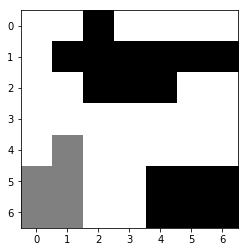

((2, 2), (4, 1)): n_v:  2402 q_all:-0.790668 q:-0.669805 q_m:-0.000000 p:0.491903
((2, 3), (4, 1)): n_v:  1523 q_all:-0.815006 q:-0.768780 q_m:-0.000000 p:0.507639
########################p_sum is:  0.999542593956
1 's turn


This is a random move


one move takes time(s):  0.3959653377532959
no. of data collected:  16


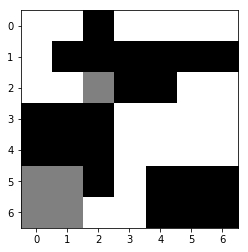

((2, 1), (2, 2)): n_v:  3184 q_all:+0.775460 q:+0.818920 q_m:+0.433333 p:0.354451
((0, 1), (2, 2)): n_v:   495 q_all:+0.795298 q:+0.650809 q_m:+0.400000 p:0.006947
((4, 3), (2, 2)): n_v:   286 q_all:+0.795898 q:+0.598787 q_m:+0.400000 p:0.002977
((6, 2), (5, 1)): n_v:   251 q_all:+0.639658 q:+0.608292 q_m:+0.300000 p:0.196034
((0, 0), (2, 2)): n_v:   140 q_all:+0.737516 q:+0.743775 q_m:+0.400000 p:0.041682
((0, 4), (2, 2)): n_v:   108 q_all:+0.776118 q:+0.690917 q_m:+0.400000 p:0.011708
((0, 3), (2, 2)): n_v:    47 q_all:+0.761798 q:+0.629485 q_m:+0.400000 p:0.008499
((1, 0), (2, 2)): n_v:    39 q_all:+0.603563 q:+0.647977 q_m:+0.400000 p:0.038015
((2, 0), (2, 2)): n_v:    14 q_all:+0.660753 q:+0.624588 q_m:+0.400000 p:0.009301
((6, 3), (5, 1)): n_v:     9 q_all:+0.483301 q:+0.462601 q_m:+0.266667 p:0.013991
((4, 3), (5, 1)): n_v:     5 q_all:+0.326759 q:+0.255289 q_m:+0.266667 p:0.013179
((3, 3), (5, 1)): n_v:     4 q_all:+0.383544 q:+0.358463 q_m:+0.266667 p:0.009970
((5, 3), (5, 1))

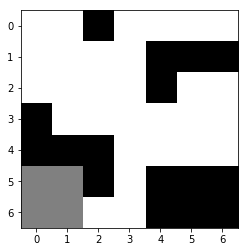

((4, 0), (5, 1)): n_v:  1665 q_all:-0.765044 q:-0.863246 q_m:-0.333333 p:0.090334
((4, 0), (6, 0)): n_v:   813 q_all:-0.773157 q:-0.825828 q_m:-0.433333 p:0.075473
((5, 2), (6, 0)): n_v:   610 q_all:-0.788412 q:-0.779375 q_m:-0.433333 p:0.097920
((4, 2), (6, 0)): n_v:   456 q_all:-0.788671 q:-0.766462 q_m:-0.433333 p:0.073868
((4, 2), (6, 1)): n_v:   424 q_all:-0.758567 q:-0.765926 q_m:-0.366667 p:0.010578
((3, 0), (5, 1)): n_v:   362 q_all:-0.859081 q:-0.851910 q_m:-0.366667 p:0.174798
((4, 1), (6, 0)): n_v:    91 q_all:-0.881012 q:-0.855359 q_m:-0.433333 p:0.053425
((5, 2), (6, 1)): n_v:    43 q_all:-0.787348 q:-0.893187 q_m:-0.333333 p:0.006376
((4, 0), (6, 1)): n_v:    27 q_all:-0.857466 q:-0.868851 q_m:-0.366667 p:0.012702
((4, 1), (6, 1)): n_v:    12 q_all:-0.878820 q:-0.846154 q_m:-0.366667 p:0.006789
((4, 2), (5, 0)): n_v:     9 q_all:-0.860913 q:-0.830304 q_m:-0.433333 p:0.004508
((3, 0), (5, 0)): n_v:     4 q_all:-0.924321 q:-0.902832 q_m:-0.433333 p:0.003174
((5, 2), (5, 0))

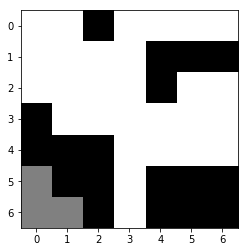

((6, 3), (6, 1)): n_v:  1832 q_all:+0.767113 q:+0.895705 q_m:+0.533333 p:0.673988
((3, 2), (5, 0)): n_v:   714 q_all:+0.817215 q:+0.642246 q_m:+0.533333 p:0.071094
((4, 3), (6, 1)): n_v:   469 q_all:+0.812810 q:+0.751403 q_m:+0.533333 p:0.057652
((5, 3), (6, 1)): n_v:   468 q_all:+0.793516 q:+0.794335 q_m:+0.533333 p:0.106098
((3, 1), (5, 0)): n_v:   283 q_all:+0.776432 q:+0.662746 q_m:+0.533333 p:0.089347
########################p_sum is:  0.998178511858
-1 's turn
one move takes time(s):  0.19660520553588867
no. of data collected:  16


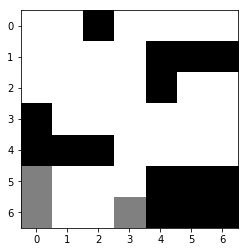

((4, 2), (6, 3)): n_v:  1841 q_all:-0.866873 q:-0.810433 q_m:-0.333333 p:0.530233
((6, 5), (6, 3)): n_v:   447 q_all:-0.817900 q:-0.832366 q_m:-0.333333 p:0.013776
((4, 0), (5, 0)): n_v:   271 q_all:-0.813928 q:-0.875634 q_m:-0.366667 p:0.001821
((4, 1), (6, 3)): n_v:   268 q_all:-0.902685 q:-0.874361 q_m:-0.333333 p:0.127537
((5, 4), (6, 3)): n_v:   256 q_all:-0.921281 q:-0.901101 q_m:-0.300000 p:0.146936
((5, 5), (6, 3)): n_v:   198 q_all:-0.825359 q:-0.855289 q_m:-0.333333 p:0.013605
((4, 0), (6, 0)): n_v:    98 q_all:-0.814884 q:-0.842234 q_m:-0.400000 p:0.001028
((4, 2), (6, 0)): n_v:    10 q_all:-0.841961 q:-0.810248 q_m:-0.400000 p:0.001279
((4, 2), (5, 0)): n_v:     6 q_all:-0.864343 q:-0.786168 q_m:-0.400000 p:0.001731
((4, 1), (6, 0)): n_v:     1 q_all:-0.925830 q:-0.856440 q_m:-0.400000 p:0.000834
((3, 0), (5, 0)): n_v:     1 q_all:-0.880026 q:-0.857474 q_m:-0.400000 p:0.000399
########################p_sum is:  0.839178648661
1 's turn


This is a random move


one move tak

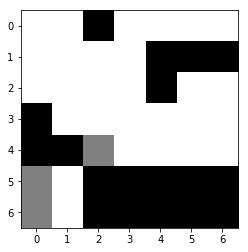

((3, 1), (4, 2)): n_v:  2616 q_all:+0.833699 q:+0.971577 q_m:+0.566667 p:0.096146
((6, 1), (4, 2)): n_v:   536 q_all:+0.749691 q:+0.948937 q_m:+0.533333 p:0.257288
((4, 4), (4, 2)): n_v:   392 q_all:+0.840778 q:+0.820568 q_m:+0.533333 p:0.001271
((5, 1), (5, 0)): n_v:    62 q_all:+0.785880 q:+0.903022 q_m:+0.500000 p:0.018113
((2, 0), (4, 2)): n_v:     6 q_all:+0.687713 q:+0.798109 q_m:+0.533333 p:0.005247
((2, 3), (4, 2)): n_v:     1 q_all:+0.635285 q:+0.737237 q_m:+0.533333 p:0.002139
((3, 4), (4, 2)): n_v:     1 q_all:+0.601781 q:+0.694230 q_m:+0.533333 p:0.002160
((3, 2), (5, 0)): n_v:     1 q_all:+0.663271 q:+0.663271 q_m:+0.466667 p:0.001810
((2, 1), (4, 2)): n_v:     0 q_all:+0.561095 q:+0.588856 q_m:+0.533333 p:0.000584
((3, 1), (5, 0)): n_v:     0 q_all:+0.546275 q:+0.546275 q_m:+0.466667 p:0.000319
((5, 1), (6, 0)): n_v:     0 q_all:+0.597242 q:+0.597242 q_m:+0.366667 p:0.000040
((2, 2), (4, 2)): n_v:     0 q_all:+0.548293 q:+0.563253 q_m:+0.533333 p:0.000599
################

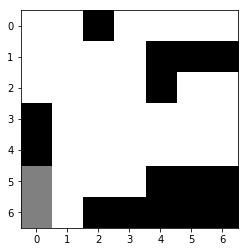

((3, 0), (5, 0)): n_v:  2092 q_all:-0.779992 q:-0.966177 q_m:-0.366667 p:0.123495
((6, 2), (5, 0)): n_v:  1638 q_all:-0.864147 q:-0.962423 q_m:-0.366667 p:0.725021
((4, 0), (5, 0)): n_v:   855 q_all:-0.806577 q:-0.988319 q_m:-0.333333 p:0.112530
((4, 0), (6, 0)): n_v:    22 q_all:-0.966510 q:-0.961722 q_m:-0.433333 p:0.021001
((6, 2), (6, 0)): n_v:    16 q_all:-0.989542 q:-0.988098 q_m:-0.433333 p:0.017949
########################p_sum is:  0.999996107072
1 's turn


This is a random move


one move takes time(s):  0.07297468185424805
no. of data collected:  16


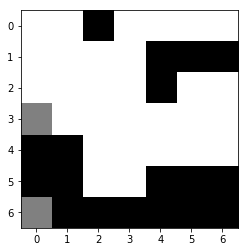

((2, 0), (3, 0)): n_v:  3986 q_all:+0.895770 q:+0.978843 q_m:+0.533333 p:0.353841
((5, 2), (3, 0)): n_v:   194 q_all:+0.793886 q:+0.873605 q_m:+0.500000 p:0.001152
((1, 0), (3, 0)): n_v:     3 q_all:+0.664325 q:+0.913604 q_m:+0.500000 p:0.003461
((4, 2), (3, 0)): n_v:     1 q_all:+0.267084 q:+0.771061 q_m:+0.500000 p:0.001171
((1, 1), (3, 0)): n_v:     0 q_all:+0.587286 q:+0.674572 q_m:+0.500000 p:0.001043
((4, 2), (6, 0)): n_v:     0 q_all:+0.615539 q:+0.664412 q_m:+0.566667 p:0.000019
((5, 2), (6, 0)): n_v:     0 q_all:+0.666534 q:+0.766400 q_m:+0.566667 p:0.000021
((3, 2), (3, 0)): n_v:     0 q_all:+0.613503 q:+0.727006 q_m:+0.500000 p:0.000724
((1, 2), (3, 0)): n_v:     0 q_all:+0.583912 q:+0.667824 q_m:+0.500000 p:0.000478
((2, 2), (3, 0)): n_v:     0 q_all:+0.589445 q:+0.678891 q_m:+0.500000 p:0.001056
########################p_sum is:  0.362965741251
-1 's turn
one move takes time(s):  0.0510716438293457
no. of data collected:  16


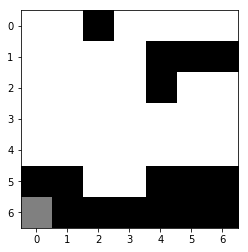

((6, 2), (6, 0)): n_v:  6135 q_all:-0.932275 q:-0.999858 q_m:-0.533333 p:0.921931
((5, 0), (6, 0)): n_v:    51 q_all:-1.000000 q:+5.000000 q_m:-0.500000 p:0.022358
########################p_sum is:  0.944288613275
1 's turn


This is a random move


one move takes time(s):  0.0364832878112793
no. of data collected:  8


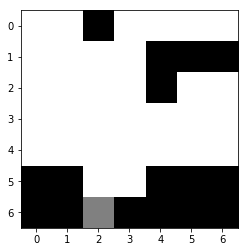

((5, 2), (6, 2)): n_v:  6536 q_all:+1.000000 q:+5.000000 q_m:+0.766667 p:0.559589
((4, 0), (6, 2)): n_v:    20 q_all:+0.973930 q:+0.994163 q_m:+0.733333 p:0.003791
((4, 3), (6, 2)): n_v:     1 q_all:+0.845712 q:+0.958090 q_m:+0.733333 p:0.001158
((4, 1), (6, 2)): n_v:     1 q_all:+0.925155 q:+0.967286 q_m:+0.733333 p:0.000703
((4, 2), (6, 2)): n_v:     0 q_all:+0.855994 q:+0.978654 q_m:+0.733333 p:0.000482
((4, 4), (6, 2)): n_v:     0 q_all:+0.854845 q:+0.976357 q_m:+0.733333 p:0.000143
########################p_sum is:  0.565865073018
this self play has 74 steps, time elapsed 146.1075406074524
winner is 1.0
106368  data in database
40000  data expected
40000  data grabbed
start training, training data no. 40000
Train on 34000 samples, validate on 6000 samples
Epoch 1/512
34000/34000 [==============================] - 3s 79us/step - loss: 0.8537 - activation_29_loss: 0.8166 - dense_15_loss: 0.0090 - val_loss: 0.8700 - val_activation_29_loss: 0.8320 - val_dense_15_loss: 0.0098
Epoch 2/5

Epoch 35/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8465 - activation_29_loss: 0.8100 - dense_15_loss: 0.0084 - val_loss: 0.8704 - val_activation_29_loss: 0.8325 - val_dense_15_loss: 0.0097
Epoch 36/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8464 - activation_29_loss: 0.8100 - dense_15_loss: 0.0083 - val_loss: 0.8704 - val_activation_29_loss: 0.8326 - val_dense_15_loss: 0.0097
Epoch 37/512
34000/34000 [==============================] - 3s 78us/step - loss: 0.8463 - activation_29_loss: 0.8099 - dense_15_loss: 0.0083 - val_loss: 0.8704 - val_activation_29_loss: 0.8326 - val_dense_15_loss: 0.0097
Epoch 38/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8461 - activation_29_loss: 0.8097 - dense_15_loss: 0.0084 - val_loss: 0.8704 - val_activation_29_loss: 0.8326 - val_dense_15_loss: 0.0097
Epoch 39/512
34000/34000 [==============================] - 3s 74us/step - loss: 0.8458 - activation_29_loss: 0.8095

34000/34000 [==============================] - 3s 78us/step - loss: 0.8423 - activation_29_loss: 0.8061 - dense_15_loss: 0.0081 - val_loss: 0.8712 - val_activation_29_loss: 0.8335 - val_dense_15_loss: 0.0096
Epoch 73/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8420 - activation_29_loss: 0.8059 - dense_15_loss: 0.0080 - val_loss: 0.8712 - val_activation_29_loss: 0.8335 - val_dense_15_loss: 0.0096
Epoch 74/512
34000/34000 [==============================] - 3s 74us/step - loss: 0.8419 - activation_29_loss: 0.8058 - dense_15_loss: 0.0080 - val_loss: 0.8713 - val_activation_29_loss: 0.8335 - val_dense_15_loss: 0.0097
Epoch 75/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8420 - activation_29_loss: 0.8059 - dense_15_loss: 0.0080 - val_loss: 0.8713 - val_activation_29_loss: 0.8336 - val_dense_15_loss: 0.0096
Epoch 76/512
34000/34000 [==============================] - 3s 80us/step - loss: 0.8416 - activation_29_loss: 0.8055 - dense_15_l

one move takes time(s):  0.44547247886657715
no. of data collected:  16
1 's turn
one move takes time(s):  0.41333675384521484
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.3014066219329834
no. of data collected:  16
1 's turn
one move takes time(s):  0.32893824577331543
no. of data collected:  24
-1 's turn
one move takes time(s):  0.3707296848297119
no. of data collected:  24
1 's turn
one move takes time(s):  0.37796449661254883
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.816399335861206
no. of data collected:  24
1 's turn
one move takes time(s):  0.6058425903320312
no. of data collected:  16
-1 's turn
one move takes time(s):  0.6451640129089355
no. of data collected:  16
1 's turn
one move takes time(s):  0.33709287643432617
no. of data collected:  16
-1 's turn
one move takes time(s):  0.36774444580078125
no. of data collected:  16
1 's turn
one move takes time(s):  0.44135141372680664
no

one move takes time(s):  0.4835362434387207
no. of data collected:  16
-1 's turn
one move takes time(s):  0.8117237091064453
no. of data collected:  24
1 's turn
one move takes time(s):  0.8600320816040039
no. of data collected:  16
-1 's turn
one move takes time(s):  0.40866637229919434
no. of data collected:  16
1 's turn
one move takes time(s):  0.3995232582092285
no. of data collected:  16
-1 's turn
one move takes time(s):  0.2722201347351074
no. of data collected:  16
1 's turn
one move takes time(s):  0.31481027603149414
no. of data collected:  16
-1 's turn
one move takes time(s):  0.2688415050506592
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.24840974807739258
no. of data collected:  24
-1 's turn
one move takes time(s):  0.2738032341003418
no. of data collected:  16
1 's turn
one move takes time(s):  0.22814464569091797
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.18665575981140137
no

one move takes time(s):  0.7326953411102295
no. of data collected:  16
1 's turn
one move takes time(s):  0.43694519996643066
no. of data collected:  16
-1 's turn
one move takes time(s):  0.8430736064910889
no. of data collected:  16
1 's turn
one move takes time(s):  0.5547857284545898
no. of data collected:  16
-1 's turn
one move takes time(s):  0.8176252841949463
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.42117738723754883
no. of data collected:  16
-1 's turn
one move takes time(s):  0.39937710762023926
no. of data collected:  16
1 's turn
one move takes time(s):  0.2501075267791748
no. of data collected:  24
-1 's turn
one move takes time(s):  0.30632781982421875
no. of data collected:  24
1 's turn
one move takes time(s):  0.3660416603088379
no. of data collected:  16
-1 's turn
one move takes time(s):  0.20403099060058594
no. of data collected:  16
1 's turn
one move takes time(s):  0.18039989471435547
no. of data collected:  16
-

one move takes time(s):  0.4498438835144043
no. of data collected:  16
1 's turn
one move takes time(s):  0.3011167049407959
no. of data collected:  16
-1 's turn
one move takes time(s):  0.6987812519073486
no. of data collected:  24
1 's turn
one move takes time(s):  0.30899620056152344
no. of data collected:  16
-1 's turn
one move takes time(s):  0.3730916976928711
no. of data collected:  24
1 's turn
one move takes time(s):  0.20957612991333008
no. of data collected:  16
-1 's turn
one move takes time(s):  0.24891924858093262
no. of data collected:  16
1 's turn
one move takes time(s):  0.14077162742614746
no. of data collected:  16
-1 's turn
one move takes time(s):  0.12408685684204102
no. of data collected:  8
this self play has 63 steps, time elapsed 90.80272674560547
winner is -1.0
episode 104 finished
episode 105 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.31173062324523926
no. of data collected:  8
1 's turn


This is a random move






This is a random move


one move takes time(s):  0.06842327117919922
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.08226323127746582
no. of data collected:  16
this self play has 83 steps, time elapsed 80.5738353729248
winner is 1.0
106176  data in database
40000  data expected
40000  data grabbed
start training, training data no. 40000
Train on 34000 samples, validate on 6000 samples
Epoch 1/512
34000/34000 [==============================] - 3s 83us/step - loss: 0.8435 - activation_29_loss: 0.8067 - dense_15_loss: 0.0087 - val_loss: 0.8356 - val_activation_29_loss: 0.7987 - val_dense_15_loss: 0.0088
Epoch 2/512
34000/34000 [==============================] - 2s 72us/step - loss: 0.8431 - activation_29_loss: 0.8064 - dense_15_loss: 0.0086 - val_loss: 0.8355 - val_activation_29_loss: 0.7986 - val_dense_15_loss: 0.0088
Epoch 3/512
34000/34000 [==============================] - 3s 74us/step - loss: 0.8427 - activation_29_loss: 0.8060 - dense_1

34000/34000 [==============================] - 3s 77us/step - loss: 0.8364 - activation_29_loss: 0.8001 - dense_15_loss: 0.0082 - val_loss: 0.8362 - val_activation_29_loss: 0.7993 - val_dense_15_loss: 0.0088
Epoch 37/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8363 - activation_29_loss: 0.8000 - dense_15_loss: 0.0082 - val_loss: 0.8363 - val_activation_29_loss: 0.7994 - val_dense_15_loss: 0.0088
Epoch 38/512
34000/34000 [==============================] - 2s 73us/step - loss: 0.8360 - activation_29_loss: 0.7998 - dense_15_loss: 0.0082 - val_loss: 0.8363 - val_activation_29_loss: 0.7994 - val_dense_15_loss: 0.0088
Epoch 39/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8358 - activation_29_loss: 0.7996 - dense_15_loss: 0.0081 - val_loss: 0.8363 - val_activation_29_loss: 0.7994 - val_dense_15_loss: 0.0088
Epoch 40/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8360 - activation_29_loss: 0.7997 - dense_15_l

34000/34000 [==============================] - 3s 79us/step - loss: 0.8322 - activation_29_loss: 0.7962 - dense_15_loss: 0.0079 - val_loss: 0.8371 - val_activation_29_loss: 0.8003 - val_dense_15_loss: 0.0088
Epoch 74/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8319 - activation_29_loss: 0.7959 - dense_15_loss: 0.0079 - val_loss: 0.8371 - val_activation_29_loss: 0.8003 - val_dense_15_loss: 0.0088
Epoch 75/512
34000/34000 [==============================] - 3s 74us/step - loss: 0.8320 - activation_29_loss: 0.7960 - dense_15_loss: 0.0079 - val_loss: 0.8372 - val_activation_29_loss: 0.8003 - val_dense_15_loss: 0.0088
Epoch 76/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8320 - activation_29_loss: 0.7960 - dense_15_loss: 0.0079 - val_loss: 0.8372 - val_activation_29_loss: 0.8003 - val_dense_15_loss: 0.0088
Epoch 77/512
34000/34000 [==============================] - 3s 80us/step - loss: 0.8321 - activation_29_loss: 0.7961 - dense_15_l

one move takes time(s):  0.8255922794342041
no. of data collected:  24
-1 's turn
one move takes time(s):  0.6966850757598877
no. of data collected:  24
1 's turn
one move takes time(s):  0.9182369709014893
no. of data collected:  16
-1 's turn
one move takes time(s):  0.48631906509399414
no. of data collected:  16
1 's turn
one move takes time(s):  0.7493734359741211
no. of data collected:  16
-1 's turn
one move takes time(s):  0.5692658424377441
no. of data collected:  16
1 's turn
one move takes time(s):  0.3260014057159424
no. of data collected:  16
-1 's turn
one move takes time(s):  0.33856964111328125
no. of data collected:  24
1 's turn
one move takes time(s):  0.40347766876220703
no. of data collected:  24
-1 's turn
one move takes time(s):  0.26372241973876953
no. of data collected:  16
1 's turn
one move takes time(s):  0.49953293800354004
no. of data collected:  16
-1 's turn
one move takes time(s):  0.3622570037841797
no. of data collected:  16
1 's turn
one move takes ti



This is a random move


one move takes time(s):  0.3345756530761719
no. of data collected:  16
1 's turn
one move takes time(s):  0.44467997550964355
no. of data collected:  16
-1 's turn
one move takes time(s):  0.44845104217529297
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.34753966331481934
no. of data collected:  24
-1 's turn


This is a random move


one move takes time(s):  0.2979874610900879
no. of data collected:  16
1 's turn
one move takes time(s):  0.2259352207183838
no. of data collected:  24
-1 's turn
one move takes time(s):  0.2927885055541992
no. of data collected:  16
1 's turn
one move takes time(s):  0.2522578239440918
no. of data collected:  16
-1 's turn
one move takes time(s):  0.24765491485595703
no. of data collected:  24
1 's turn
one move takes time(s):  0.22865748405456543
no. of data collected:  16
-1 's turn
one move takes time(s):  0.281111478805542
no. of data collected:  24
1 's turn
one move takes time(s)

one move takes time(s):  1.1610050201416016
no. of data collected:  16
1 's turn
one move takes time(s):  0.6622798442840576
no. of data collected:  24
-1 's turn
one move takes time(s):  0.975203275680542
no. of data collected:  16
1 's turn
one move takes time(s):  0.6039395332336426
no. of data collected:  24
-1 's turn
one move takes time(s):  0.49765443801879883
no. of data collected:  24
1 's turn
one move takes time(s):  0.8573324680328369
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.7895119190216064
no. of data collected:  24
1 's turn
one move takes time(s):  0.7913157939910889
no. of data collected:  16
-1 's turn
one move takes time(s):  0.9188406467437744
no. of data collected:  24
1 's turn
one move takes time(s):  0.7827720642089844
no. of data collected:  16
-1 's turn
one move takes time(s):  0.9215385913848877
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.6204202175140381
no. of d

due to rollout lim, final rollout times:  2001 time elapsed:  2.7154550552368164
one move takes time(s):  2.7171316146850586
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.6361215114593506
one move takes time(s):  3.6382455825805664
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.2813212871551514
no. of data collected:  16
1 's turn
one move takes time(s):  1.448406457901001
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  1.4392921924591064
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.5951273441314697
one move takes time(s):  3.5966897010803223
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2156 time elapsed:  2.017742872238159
one move takes time(s):  2.0191149711608887
no. of data collected:  16
1 's turn
one move takes time(s):  0.9745421409606934
no. of data col

one move takes time(s):  0.9638767242431641
no. of data collected:  16
1 's turn
one move takes time(s):  0.8546638488769531
no. of data collected:  16
-1 's turn
one move takes time(s):  0.9244236946105957
no. of data collected:  16
1 's turn
one move takes time(s):  1.194662094116211
no. of data collected:  16
-1 's turn
one move takes time(s):  1.901496171951294
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.8050775527954102
no. of data collected:  24
-1 's turn
one move takes time(s):  1.0565094947814941
no. of data collected:  16
1 's turn
one move takes time(s):  1.2815616130828857
no. of data collected:  16
-1 's turn
one move takes time(s):  0.6155719757080078
no. of data collected:  16
1 's turn
one move takes time(s):  0.5266494750976562
no. of data collected:  24
-1 's turn


This is a random move


one move takes time(s):  0.8095574378967285
no. of data collected:  16
1 's turn
one move takes time(s):  0.4915902614593506
no. of dat

34000/34000 [==============================] - 3s 76us/step - loss: 0.8316 - activation_29_loss: 0.7951 - dense_15_loss: 0.0085 - val_loss: 0.8393 - val_activation_29_loss: 0.8025 - val_dense_15_loss: 0.0086
Epoch 21/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8318 - activation_29_loss: 0.7952 - dense_15_loss: 0.0085 - val_loss: 0.8392 - val_activation_29_loss: 0.8025 - val_dense_15_loss: 0.0086
Epoch 22/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8316 - activation_29_loss: 0.7951 - dense_15_loss: 0.0084 - val_loss: 0.8393 - val_activation_29_loss: 0.8026 - val_dense_15_loss: 0.0086
Epoch 23/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8314 - activation_29_loss: 0.7949 - dense_15_loss: 0.0085 - val_loss: 0.8393 - val_activation_29_loss: 0.8025 - val_dense_15_loss: 0.0087
Epoch 24/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8312 - activation_29_loss: 0.7946 - dense_15_l

34000/34000 [==============================] - 3s 79us/step - loss: 0.8268 - activation_29_loss: 0.7904 - dense_15_loss: 0.0082 - val_loss: 0.8402 - val_activation_29_loss: 0.8035 - val_dense_15_loss: 0.0087
Epoch 58/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8267 - activation_29_loss: 0.7904 - dense_15_loss: 0.0082 - val_loss: 0.8403 - val_activation_29_loss: 0.8035 - val_dense_15_loss: 0.0087
Epoch 59/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8265 - activation_29_loss: 0.7902 - dense_15_loss: 0.0082 - val_loss: 0.8403 - val_activation_29_loss: 0.8035 - val_dense_15_loss: 0.0087
Epoch 60/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8265 - activation_29_loss: 0.7902 - dense_15_loss: 0.0082 - val_loss: 0.8403 - val_activation_29_loss: 0.8036 - val_dense_15_loss: 0.0087
Epoch 61/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8263 - activation_29_loss: 0.7901 - dense_15_l

due to rollout lim, final rollout times:  2001 time elapsed:  2.390913486480713
one move takes time(s):  2.3923470973968506
no. of data collected:  16
1 's turn
one move takes time(s):  1.4402954578399658
no. of data collected:  24
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.3536624908447266
one move takes time(s):  2.3553218841552734
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.267446279525757


This is a random move


one move takes time(s):  2.2688121795654297
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.165335178375244
one move takes time(s):  2.1676759719848633
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.0277743339538574
one move takes time(s):  2.030168056488037
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.4415364265441895
one 



This is a random move


one move takes time(s):  0.3223996162414551
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.4139080047607422
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.7715559005737305
no. of data collected:  16
1 's turn
one move takes time(s):  0.9871630668640137
no. of data collected:  16
-1 's turn
one move takes time(s):  1.7514145374298096
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  1.9940621852874756
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.650144100189209
one move takes time(s):  2.651177167892456
no. of data collected:  8
1 's turn
one move takes time(s):  1.0177245140075684
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.033139228820801
one move takes time(s):  2.0347206592559814
no. of data collected:  16
1 's turn
due to

due to rollout lim, final rollout times:  2001 time elapsed:  3.9166908264160156
one move takes time(s):  3.9185056686401367
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.52091646194458
one move takes time(s):  3.5226361751556396
no. of data collected:  8
1 's turn
one move takes time(s):  1.4079642295837402
no. of data collected:  16
-1 's turn
one move takes time(s):  1.0685932636260986
no. of data collected:  16
1 's turn
due to time lim, final rollout times:  72 time elapsed:  413.04623436927795
one move takes time(s):  413.11575293540955
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  4.1842827796936035
one move takes time(s):  4.185585975646973
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.653670310974121
one move takes time(s):  2.6551260948181152
no. of data collected:  16
-1 's turn
one move takes time(s):  0.831027746

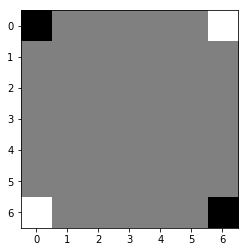

((6, 6), (5, 5)): n_v:  1165 q_all:+0.018922 q:+0.009058 q_m:+0.033333 p:0.493373
((0, 0), (1, 1)): n_v:  1030 q_all:+0.009752 q:+0.024588 q_m:+0.033333 p:0.502962
((6, 6), (6, 5)): n_v:     2 q_all:+0.018357 q:+0.010872 q_m:+0.033333 p:0.001178
((6, 6), (5, 6)): n_v:     1 q_all:+0.017237 q:+0.014121 q_m:+0.033333 p:0.000467
((0, 0), (0, 1)): n_v:     1 q_all:+0.005981 q:+0.009841 q_m:+0.033333 p:0.000940
((0, 0), (1, 0)): n_v:     1 q_all:+0.013793 q:+0.017921 q_m:+0.033333 p:0.000499
((6, 6), (6, 4)): n_v:     0 q_all:-0.001929 q:-0.001929 q_m:-0.000000 p:0.000019
((0, 0), (1, 2)): n_v:     0 q_all:-0.011046 q:-0.011046 q_m:-0.000000 p:0.000022
((0, 0), (2, 2)): n_v:     0 q_all:-0.002835 q:-0.002835 q_m:-0.000000 p:0.000085
((0, 0), (0, 2)): n_v:     0 q_all:-0.017783 q:-0.017783 q_m:-0.000000 p:0.000022
((6, 6), (4, 6)): n_v:     0 q_all:+0.007532 q:+0.007532 q_m:-0.000000 p:0.000075
((6, 6), (5, 4)): n_v:     0 q_all:+0.003635 q:+0.003635 q_m:-0.000000 p:0.000037
((6, 6), (4, 4))

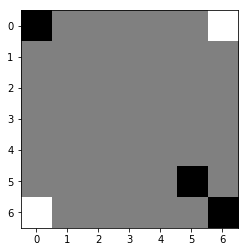

((6, 0), (5, 1)): n_v:  2090 q_all:-0.026868 q:-0.020698 q_m:-0.000000 p:0.627137
((0, 6), (1, 5)): n_v:  1115 q_all:-0.024781 q:-0.021858 q_m:-0.000000 p:0.321179
((6, 0), (5, 0)): n_v:    78 q_all:-0.024747 q:-0.028660 q_m:-0.000000 p:0.022535
((6, 0), (6, 1)): n_v:    39 q_all:-0.030441 q:-0.019483 q_m:-0.000000 p:0.012463
((0, 6), (1, 6)): n_v:    25 q_all:-0.030342 q:-0.029466 q_m:-0.000000 p:0.008056
((0, 6), (0, 5)): n_v:    12 q_all:-0.036127 q:-0.031694 q_m:-0.000000 p:0.004501
((6, 0), (4, 2)): n_v:     3 q_all:-0.043899 q:-0.055186 q_m:-0.033333 p:0.001195
((0, 6), (2, 4)): n_v:     1 q_all:-0.046027 q:-0.040513 q_m:-0.033333 p:0.000461
((6, 0), (6, 2)): n_v:     1 q_all:-0.048069 q:-0.047146 q_m:-0.033333 p:0.000646
((6, 0), (5, 2)): n_v:     1 q_all:-0.048784 q:-0.048216 q_m:-0.033333 p:0.000710
((6, 0), (4, 1)): n_v:     0 q_all:-0.032230 q:-0.032230 q_m:-0.033333 p:0.000220
((0, 6), (2, 6)): n_v:     0 q_all:-0.043226 q:-0.043226 q_m:-0.033333 p:0.000103
((0, 6), (0, 4))

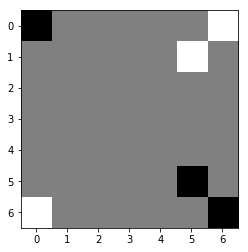

((0, 0), (1, 1)): n_v:  2419 q_all:+0.020667 q:+0.022714 q_m:+0.033333 p:0.727541
((5, 5), (4, 4)): n_v:   814 q_all:+0.021860 q:+0.014678 q_m:+0.033333 p:0.239221
((5, 5), (4, 5)): n_v:    48 q_all:+0.009037 q:-0.011130 q_m:+0.033333 p:0.017974
((5, 5), (5, 4)): n_v:    26 q_all:+0.009522 q:-0.004646 q_m:+0.033333 p:0.009523
((0, 0), (1, 0)): n_v:     2 q_all:+0.014100 q:+0.013650 q_m:+0.033333 p:0.000987
((0, 0), (0, 1)): n_v:     2 q_all:+0.010054 q:+0.006520 q_m:+0.033333 p:0.000898
((5, 5), (6, 5)): n_v:     1 q_all:+0.005053 q:-0.007198 q_m:+0.033333 p:0.000601
((5, 5), (5, 6)): n_v:     1 q_all:-0.000002 q:-0.012583 q_m:+0.033333 p:0.000512
((5, 5), (6, 4)): n_v:     1 q_all:+0.000859 q:-0.008643 q_m:+0.033333 p:0.000595
((5, 5), (4, 6)): n_v:     1 q_all:+0.004617 q:+0.003358 q_m:+0.033333 p:0.000778
((5, 5), (3, 6)): n_v:     0 q_all:+0.002949 q:+0.002949 q_m:-0.000000 p:0.000053
((5, 5), (5, 3)): n_v:     0 q_all:-0.002580 q:-0.002580 q_m:-0.000000 p:0.000006
((0, 0), (0, 2))

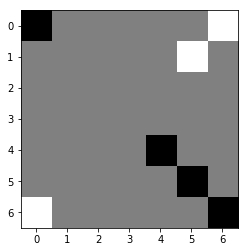

((6, 0), (5, 1)): n_v:  1737 q_all:-0.015884 q:-0.023450 q_m:-0.000000 p:0.575303
((1, 5), (2, 4)): n_v:   674 q_all:-0.015650 q:-0.023919 q_m:-0.000000 p:0.221955
((1, 5), (1, 4)): n_v:   213 q_all:-0.020569 q:-0.032364 q_m:-0.000000 p:0.076734
((1, 5), (2, 5)): n_v:   173 q_all:-0.012660 q:-0.040242 q_m:-0.000000 p:0.054013
((6, 0), (5, 0)): n_v:    39 q_all:-0.022535 q:-0.030419 q_m:-0.000000 p:0.014637
((1, 5), (3, 3)): n_v:    18 q_all:-0.026952 q:-0.022255 q_m:+0.033333 p:0.007222
((0, 6), (1, 6)): n_v:    18 q_all:-0.023644 q:-0.032773 q_m:-0.000000 p:0.007078
((6, 0), (6, 1)): n_v:    15 q_all:-0.018227 q:-0.020333 q_m:-0.000000 p:0.005088
((1, 5), (2, 6)): n_v:    13 q_all:-0.037848 q:-0.049038 q_m:-0.000000 p:0.006148
((1, 5), (0, 4)): n_v:     8 q_all:-0.033281 q:-0.038780 q_m:-0.000000 p:0.003815
((1, 5), (3, 5)): n_v:     6 q_all:-0.043867 q:-0.011190 q_m:+0.033333 p:0.003102
((0, 6), (0, 5)): n_v:     5 q_all:-0.035660 q:-0.044858 q_m:-0.000000 p:0.002393
((6, 0), (5, 2))

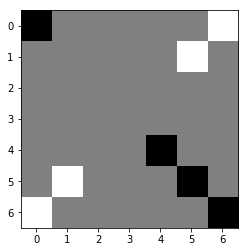

((4, 4), (3, 5)): n_v:  2346 q_all:+0.030048 q:+0.015399 q_m:+0.033333 p:0.596135
((0, 0), (1, 1)): n_v:   893 q_all:+0.032095 q:+0.019744 q_m:+0.033333 p:0.217138
((4, 4), (5, 3)): n_v:   465 q_all:+0.028949 q:+0.005423 q_m:+0.033333 p:0.121115
((4, 4), (4, 5)): n_v:    20 q_all:+0.019230 q:-0.018534 q_m:+0.033333 p:0.006337
((4, 4), (3, 3)): n_v:    19 q_all:+0.012763 q:+0.018662 q_m:+0.033333 p:0.006739
((4, 4), (3, 4)): n_v:    15 q_all:+0.008299 q:-0.004368 q_m:+0.033333 p:0.005464
((4, 4), (5, 4)): n_v:    14 q_all:+0.011965 q:-0.008261 q_m:+0.033333 p:0.005100
((4, 4), (4, 3)): n_v:    11 q_all:+0.015373 q:+0.011021 q_m:+0.033333 p:0.003871
((4, 4), (5, 6)): n_v:     7 q_all:-0.007407 q:-0.032517 q_m:-0.000000 p:0.003457
((5, 5), (5, 6)): n_v:     7 q_all:+0.013041 q:-0.008630 q_m:+0.033333 p:0.002525
((5, 5), (6, 5)): n_v:     6 q_all:+0.018732 q:-0.010819 q_m:+0.033333 p:0.002058
((4, 4), (6, 5)): n_v:     6 q_all:-0.005401 q:-0.027583 q_m:-0.000000 p:0.002846
((5, 5), (6, 4))

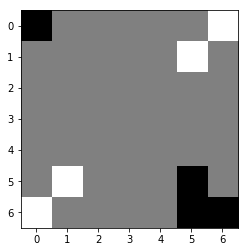

((5, 1), (5, 2)): n_v:   834 q_all:+0.022982 q:+0.005352 q_m:+0.033333 p:0.258455
((5, 1), (4, 2)): n_v:   447 q_all:+0.004636 q:-0.017440 q_m:+0.033333 p:0.196741
((1, 5), (2, 4)): n_v:   411 q_all:-0.008304 q:+0.005572 q_m:+0.033333 p:0.218924
((1, 5), (1, 4)): n_v:   272 q_all:-0.012176 q:+0.004250 q_m:+0.033333 p:0.152555
((1, 5), (2, 5)): n_v:    71 q_all:-0.005285 q:-0.006398 q_m:+0.033333 p:0.036592
((5, 1), (4, 1)): n_v:    63 q_all:-0.004420 q:-0.002956 q_m:+0.033333 p:0.031919
((5, 1), (5, 0)): n_v:    44 q_all:-0.012684 q:-0.006274 q_m:+0.033333 p:0.024884
((5, 1), (6, 2)): n_v:    21 q_all:+0.010852 q:+0.003327 q_m:+0.033333 p:0.008636
((0, 6), (1, 6)): n_v:    17 q_all:-0.008351 q:-0.000875 q_m:+0.033333 p:0.009514
((1, 5), (0, 4)): n_v:     7 q_all:-0.023866 q:-0.003381 q_m:+0.033333 p:0.004656
((5, 1), (6, 1)): n_v:     6 q_all:-0.014020 q:-0.002859 q_m:+0.033333 p:0.003550
((1, 5), (2, 6)): n_v:     6 q_all:-0.022153 q:-0.011391 q_m:+0.033333 p:0.003953
((5, 1), (4, 0))

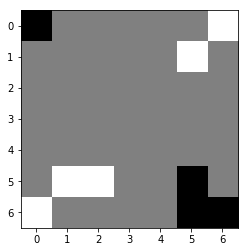

((0, 0), (1, 1)): n_v:  1752 q_all:+0.002146 q:-0.007835 q_m:-0.000000 p:0.449140
((5, 5), (4, 4)): n_v:   571 q_all:-0.040074 q:-0.023960 q_m:-0.000000 p:0.292592
((6, 5), (5, 3)): n_v:   159 q_all:+0.009567 q:-0.001333 q_m:+0.033333 p:0.033796
((6, 5), (4, 3)): n_v:    97 q_all:+0.011729 q:+0.010319 q_m:+0.033333 p:0.019388
((6, 5), (6, 3)): n_v:    90 q_all:+0.010252 q:+0.005622 q_m:+0.033333 p:0.018451
((5, 5), (4, 3)): n_v:    58 q_all:+0.014798 q:+0.018321 q_m:+0.033333 p:0.010490
((5, 5), (5, 4)): n_v:    51 q_all:-0.072403 q:-0.036327 q_m:-0.000000 p:0.036184
((6, 5), (4, 4)): n_v:    47 q_all:+0.004119 q:-0.024657 q_m:-0.033333 p:0.011664
((5, 5), (4, 5)): n_v:    46 q_all:-0.049361 q:-0.035461 q_m:-0.000000 p:0.026435
((5, 5), (5, 3)): n_v:    32 q_all:+0.009012 q:+0.010100 q_m:+0.033333 p:0.006918
((5, 5), (5, 6)): n_v:    29 q_all:+0.002053 q:-0.028080 q_m:-0.000000 p:0.007497
((5, 5), (6, 3)): n_v:    26 q_all:+0.017212 q:+0.018510 q_m:+0.033333 p:0.004205
((0, 0), (0, 1))

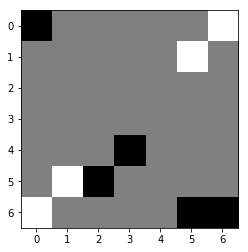

((5, 1), (4, 2)): n_v:  1635 q_all:+0.008648 q:+0.019945 q_m:+0.133333 p:0.725617
((5, 1), (5, 3)): n_v:   381 q_all:+0.049855 q:+0.020215 q_m:+0.100000 p:0.058989
((1, 5), (2, 4)): n_v:    99 q_all:-0.054372 q:-0.015247 q_m:-0.000000 p:0.088213
((5, 1), (4, 1)): n_v:    29 q_all:-0.010422 q:-0.002842 q_m:+0.066667 p:0.017152
((5, 1), (6, 1)): n_v:    26 q_all:-0.000202 q:-0.009749 q_m:+0.066667 p:0.013490
((6, 0), (4, 2)): n_v:    26 q_all:-0.003199 q:+0.002853 q_m:+0.100000 p:0.013807
((1, 5), (1, 4)): n_v:    18 q_all:-0.072916 q:-0.023799 q_m:-0.000000 p:0.018644
((5, 1), (6, 2)): n_v:    14 q_all:-0.120959 q:+0.007179 q_m:+0.066667 p:0.019490
((5, 1), (6, 3)): n_v:     6 q_all:-0.004036 q:-0.002751 q_m:+0.033333 p:0.003235
((1, 5), (3, 4)): n_v:     4 q_all:-0.023667 q:-0.009269 q_m:+0.033333 p:0.003203
((1, 5), (2, 5)): n_v:     3 q_all:-0.054534 q:-0.028398 q_m:-0.000000 p:0.003269
((5, 1), (3, 2)): n_v:     3 q_all:-0.019414 q:-0.007616 q_m:+0.033333 p:0.002343
((1, 5), (3, 3))

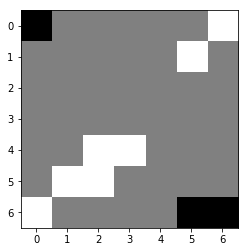

((6, 5), (5, 3)): n_v:  3728 q_all:-0.011609 q:+0.012775 q_m:+0.066667 p:0.933613
((6, 5), (5, 4)): n_v:    34 q_all:-0.005014 q:-0.004461 q_m:-0.033333 p:0.007489
((6, 5), (5, 5)): n_v:    24 q_all:-0.069464 q:-0.054274 q_m:-0.100000 p:0.013932
((0, 0), (1, 1)): n_v:    12 q_all:-0.123484 q:-0.026985 q_m:-0.100000 p:0.010178
((6, 5), (6, 3)): n_v:    11 q_all:-0.033668 q:-0.030020 q_m:-0.066667 p:0.004013
((6, 5), (4, 4)): n_v:     6 q_all:-0.030821 q:-0.014918 q_m:-0.066667 p:0.002346
((6, 5), (4, 5)): n_v:     3 q_all:-0.141809 q:-0.056195 q_m:-0.133333 p:0.003449
((6, 5), (6, 4)): n_v:     2 q_all:-0.133265 q:-0.039488 q_m:-0.100000 p:0.001743
((6, 6), (4, 5)): n_v:     2 q_all:-0.133537 q:-0.053259 q_m:-0.133333 p:0.002167
((6, 5), (5, 6)): n_v:     1 q_all:-0.113933 q:-0.036653 q_m:-0.100000 p:0.000761
((0, 0), (0, 1)): n_v:     1 q_all:-0.099376 q:-0.035879 q_m:-0.100000 p:0.000567
((0, 0), (2, 1)): n_v:     1 q_all:-0.086240 q:-0.059442 q_m:-0.133333 p:0.000844
((6, 6), (4, 4))

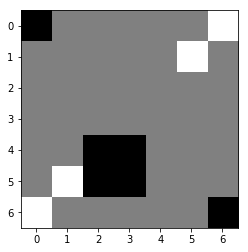

((5, 1), (4, 1)): n_v:  4791 q_all:+0.018199 q:+0.009086 q_m:+0.100000 p:0.728291
((5, 1), (6, 2)): n_v:   434 q_all:-0.007226 q:+0.009997 q_m:+0.100000 p:0.113890
((6, 0), (4, 1)): n_v:   422 q_all:+0.018416 q:-0.002486 q_m:+0.066667 p:0.063593
((1, 5), (2, 4)): n_v:    59 q_all:-0.023247 q:-0.011019 q_m:-0.033333 p:0.019693
((1, 5), (2, 5)): n_v:    38 q_all:-0.029999 q:-0.022888 q_m:-0.033333 p:0.013849
((6, 0), (6, 2)): n_v:    32 q_all:-0.008738 q:+0.007457 q_m:+0.066667 p:0.008741
((5, 1), (3, 2)): n_v:    24 q_all:-0.022504 q:-0.010361 q_m:+0.066667 p:0.008060
((1, 5), (3, 3)): n_v:    22 q_all:-0.018292 q:-0.007457 q_m:+0.066667 p:0.006781
((1, 5), (1, 4)): n_v:    17 q_all:-0.040838 q:-0.019391 q_m:-0.033333 p:0.007269
((5, 1), (3, 3)): n_v:    13 q_all:-0.019605 q:-0.015734 q_m:+0.066667 p:0.004366
((5, 1), (6, 1)): n_v:    12 q_all:-0.041189 q:-0.058276 q_m:+0.033333 p:0.005074
((1, 5), (3, 4)): n_v:     7 q_all:-0.021556 q:-0.007508 q_m:-0.000000 p:0.002226
((1, 5), (0, 4))

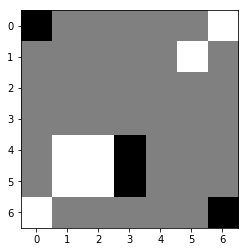

((4, 3), (3, 2)): n_v:  1687 q_all:-0.004516 q:-0.013921 q_m:+0.066667 p:0.182365
((4, 3), (6, 1)): n_v:  1130 q_all:-0.015085 q:-0.007267 q_m:+0.100000 p:0.170489
((4, 3), (3, 4)): n_v:   733 q_all:-0.038081 q:-0.038927 q_m:-0.066667 p:0.178909
((4, 3), (6, 5)): n_v:   724 q_all:-0.039321 q:-0.029226 q_m:-0.100000 p:0.180391
((5, 3), (6, 1)): n_v:   505 q_all:-0.016755 q:-0.004503 q_m:+0.100000 p:0.079743
((5, 3), (6, 5)): n_v:   355 q_all:-0.042060 q:-0.032180 q_m:-0.100000 p:0.092499
((5, 3), (6, 2)): n_v:   128 q_all:-0.009723 q:-0.015721 q_m:+0.066667 p:0.016610
((5, 3), (6, 4)): n_v:    82 q_all:-0.048912 q:-0.026617 q_m:-0.066667 p:0.023741
((4, 3), (5, 4)): n_v:    43 q_all:-0.043699 q:-0.024107 q_m:-0.066667 p:0.011563
((4, 3), (3, 1)): n_v:    41 q_all:-0.006203 q:+0.003011 q_m:+0.033333 p:0.004799
((4, 3), (3, 5)): n_v:    29 q_all:-0.046153 q:-0.017259 q_m:-0.100000 p:0.007883
((5, 3), (3, 2)): n_v:    18 q_all:-0.016682 q:-0.018357 q_m:+0.033333 p:0.002830
((5, 3), (6, 3))

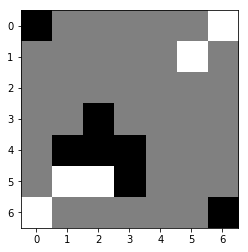

((5, 2), (3, 1)): n_v:   923 q_all:+0.006330 q:-0.009777 q_m:+0.133333 p:0.263233
((5, 1), (3, 3)): n_v:   734 q_all:+0.006066 q:-0.003006 q_m:+0.133333 p:0.210376
((5, 2), (3, 3)): n_v:   637 q_all:+0.001074 q:-0.007229 q_m:+0.133333 p:0.199926
((1, 5), (3, 3)): n_v:   517 q_all:-0.002161 q:-0.006810 q_m:+0.133333 p:0.171695
((5, 1), (3, 1)): n_v:   480 q_all:+0.011633 q:+0.021633 q_m:+0.133333 p:0.122991
((1, 5), (3, 5)): n_v:    22 q_all:-0.038995 q:-0.016121 q_m:-0.066667 p:0.011980
((5, 1), (5, 0)): n_v:     7 q_all:-0.031823 q:-0.029459 q_m:+0.033333 p:0.003512
((5, 2), (4, 4)): n_v:     5 q_all:+0.001754 q:-0.038287 q_m:+0.066667 p:0.001823
((5, 2), (6, 4)): n_v:     3 q_all:-0.015692 q:-0.013320 q_m:-0.000000 p:0.001593
((1, 5), (2, 4)): n_v:     2 q_all:-0.046309 q:-0.018721 q_m:-0.033333 p:0.001468
((5, 2), (5, 4)): n_v:     2 q_all:-0.009692 q:-0.004508 q_m:+0.066667 p:0.000964
((5, 1), (4, 0)): n_v:     1 q_all:-0.044062 q:-0.040945 q_m:+0.033333 p:0.000972
((5, 2), (6, 3))

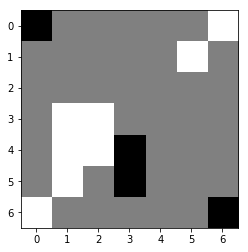

((4, 3), (5, 2)): n_v:  2398 q_all:+0.004475 q:+0.013163 q_m:+0.100000 p:0.245395
((4, 3), (5, 4)): n_v:   385 q_all:-0.072069 q:-0.037000 q_m:-0.100000 p:0.215735
((4, 3), (2, 4)): n_v:    36 q_all:+0.005656 q:-0.003825 q_m:-0.066667 p:0.003339
((4, 3), (3, 3)): n_v:    30 q_all:-0.030497 q:-0.015646 q_m:+0.033333 p:0.009461
((4, 3), (6, 5)): n_v:    24 q_all:-0.052224 q:-0.036176 q_m:-0.133333 p:0.010649
((4, 3), (6, 1)): n_v:    18 q_all:-0.047410 q:-0.035028 q_m:-0.000000 p:0.007727
((4, 3), (2, 5)): n_v:    16 q_all:-0.009077 q:-0.002272 q_m:-0.066667 p:0.002876
((0, 0), (1, 2)): n_v:     8 q_all:-0.069000 q:-0.056487 q_m:-0.133333 p:0.004650
((5, 3), (6, 1)): n_v:     8 q_all:-0.046975 q:-0.039148 q_m:-0.000000 p:0.003538
((4, 3), (5, 5)): n_v:     7 q_all:-0.067567 q:-0.047740 q_m:-0.133333 p:0.004201
((4, 3), (2, 2)): n_v:     6 q_all:-0.020495 q:-0.010244 q_m:-0.000000 p:0.001554
((4, 3), (2, 1)): n_v:     5 q_all:-0.026344 q:-0.000099 q_m:-0.000000 p:0.001484
((5, 3), (6, 5))

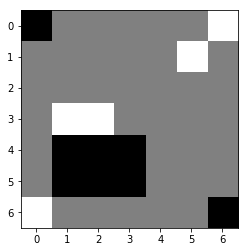

((3, 2), (3, 3)): n_v:  2062 q_all:+0.003787 q:-0.010626 q_m:+0.066667 p:0.410657
((3, 2), (4, 4)): n_v:   610 q_all:-0.006465 q:-0.018357 q_m:+0.033333 p:0.153047
((6, 0), (6, 2)): n_v:   514 q_all:+0.003424 q:+0.006469 q_m:+0.100000 p:0.103384
((3, 2), (5, 4)): n_v:   368 q_all:+0.005158 q:+0.010741 q_m:+0.033333 p:0.070720
((3, 1), (1, 0)): n_v:   109 q_all:-0.000081 q:-0.032307 q_m:-0.033333 p:0.024022
((3, 1), (3, 3)): n_v:    69 q_all:-0.014813 q:-0.031808 q_m:+0.033333 p:0.020344
((3, 1), (5, 0)): n_v:    57 q_all:-0.039689 q:-0.051002 q_m:+0.033333 p:0.023950
((3, 2), (2, 4)): n_v:    56 q_all:-0.031490 q:-0.050244 q_m:-0.100000 p:0.021139
((3, 1), (4, 0)): n_v:    51 q_all:-0.039198 q:-0.027989 q_m:+0.066667 p:0.021471
((3, 2), (1, 0)): n_v:    49 q_all:+0.005654 q:-0.024810 q_m:-0.033333 p:0.009254
((3, 2), (1, 1)): n_v:    46 q_all:+0.000670 q:-0.010689 q_m:-0.033333 p:0.010030
((6, 0), (5, 0)): n_v:    44 q_all:-0.034773 q:-0.027752 q_m:+0.066667 p:0.017613
((3, 2), (5, 0))

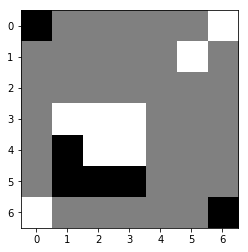

((5, 3), (4, 4)): n_v:  2185 q_all:-0.000103 q:-0.004299 q_m:+0.100000 p:0.496206
((4, 1), (2, 2)): n_v:   865 q_all:-0.018588 q:-0.019252 q_m:+0.133333 p:0.280288
((0, 0), (2, 2)): n_v:   445 q_all:+0.004124 q:-0.003438 q_m:+0.133333 p:0.091421
((6, 6), (4, 4)): n_v:   189 q_all:-0.014687 q:-0.021307 q_m:+0.066667 p:0.057293
((5, 2), (4, 4)): n_v:    45 q_all:-0.031019 q:-0.025618 q_m:+0.066667 p:0.017696
((4, 1), (2, 3)): n_v:    34 q_all:-0.018475 q:-0.030957 q_m:+0.066667 p:0.011035
((5, 3), (3, 4)): n_v:    22 q_all:+0.001082 q:-0.008584 q_m:+0.066667 p:0.005029
((4, 1), (2, 1)): n_v:    21 q_all:-0.034795 q:-0.034596 q_m:+0.066667 p:0.008668
((5, 3), (3, 5)): n_v:    16 q_all:-0.016818 q:-0.024027 q_m:-0.066667 p:0.005241
((5, 2), (3, 4)): n_v:     6 q_all:-0.027590 q:-0.036128 q_m:+0.066667 p:0.002528
((4, 1), (3, 0)): n_v:     6 q_all:-0.016014 q:-0.047576 q_m:+0.033333 p:0.002146
((4, 1), (4, 0)): n_v:     5 q_all:-0.015543 q:-0.025904 q_m:+0.033333 p:0.001688
((4, 1), (5, 0))

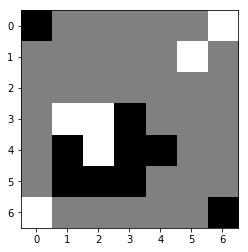

((3, 2), (5, 4)): n_v:  2251 q_all:-0.011138 q:+0.005547 q_m:+0.100000 p:0.560453
((3, 2), (3, 4)): n_v:   448 q_all:-0.027528 q:-0.002927 q_m:+0.100000 p:0.149445
((4, 2), (3, 4)): n_v:   207 q_all:-0.029901 q:-0.011536 q_m:+0.100000 p:0.071464
((4, 2), (5, 4)): n_v:   182 q_all:-0.012148 q:+0.014604 q_m:+0.100000 p:0.046498
((1, 5), (3, 4)): n_v:   112 q_all:+0.000746 q:-0.009647 q_m:+0.100000 p:0.020664
((3, 2), (1, 4)): n_v:   112 q_all:-0.040358 q:-0.058020 q_m:-0.100000 p:0.044814
((6, 0), (6, 2)): n_v:    72 q_all:-0.001116 q:+0.004133 q_m:+0.100000 p:0.014094
((3, 1), (1, 0)): n_v:    45 q_all:-0.009008 q:-0.033754 q_m:-0.033333 p:0.010913
((3, 1), (1, 1)): n_v:    27 q_all:-0.002362 q:-0.014093 q_m:-0.033333 p:0.005660
((3, 1), (4, 0)): n_v:    26 q_all:-0.018026 q:-0.013794 q_m:+0.066667 p:0.007472
((4, 2), (6, 4)): n_v:    24 q_all:-0.011570 q:-0.020682 q_m:-0.033333 p:0.006263
((3, 2), (1, 1)): n_v:    21 q_all:-0.000744 q:-0.013314 q_m:-0.033333 p:0.004244
((3, 2), (2, 4))

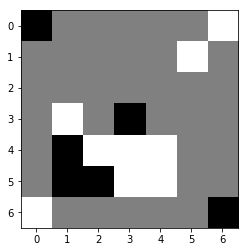

((3, 3), (3, 2)): n_v:  2880 q_all:+0.020707 q:+0.005610 q_m:+0.133333 p:0.296717
((3, 3), (3, 4)): n_v:   995 q_all:-0.014205 q:-0.023803 q_m:+0.066667 p:0.280223
((3, 3), (5, 5)): n_v:    41 q_all:-0.013603 q:+0.001278 q_m:+0.033333 p:0.011357
((6, 6), (5, 5)): n_v:    18 q_all:+0.001911 q:+0.001771 q_m:+0.066667 p:0.003774
((5, 1), (3, 2)): n_v:     5 q_all:-0.003931 q:-0.012388 q_m:+0.100000 p:0.001279
((5, 2), (6, 3)): n_v:     5 q_all:-0.021352 q:-0.030884 q_m:+0.066667 p:0.001489
((3, 3), (4, 5)): n_v:     5 q_all:-0.040026 q:-0.016032 q_m:+0.033333 p:0.001968
((5, 2), (3, 4)): n_v:     4 q_all:-0.027242 q:-0.051465 q_m:+0.033333 p:0.001620
((3, 3), (1, 1)): n_v:     4 q_all:-0.075639 q:-0.069082 q_m:-0.100000 p:0.002639
((3, 3), (2, 5)): n_v:     3 q_all:-0.020373 q:-0.000504 q_m:-0.033333 p:0.001164
((3, 3), (2, 1)): n_v:     2 q_all:-0.044106 q:-0.034127 q_m:-0.033333 p:0.001208
((5, 2), (3, 2)): n_v:     2 q_all:-0.033328 q:-0.030296 q_m:+0.100000 p:0.000965
((3, 3), (3, 5))

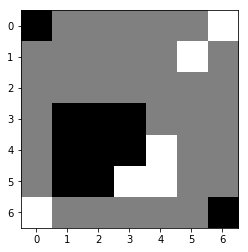

((4, 4), (3, 4)): n_v:  1264 q_all:-0.020601 q:-0.035791 q_m:+0.033333 p:0.244652
((6, 0), (4, 0)): n_v:  1002 q_all:-0.001746 q:-0.033524 q_m:+0.066667 p:0.103747
((4, 4), (5, 5)): n_v:   568 q_all:-0.008046 q:-0.014452 q_m:-0.033333 p:0.075982
((4, 4), (2, 2)): n_v:   390 q_all:-0.025924 q:-0.012072 q_m:+0.066667 p:0.085435
((5, 4), (4, 6)): n_v:   263 q_all:-0.056629 q:-0.058998 q_m:-0.133333 p:0.096362
((5, 3), (3, 4)): n_v:   156 q_all:-0.027748 q:-0.035987 q_m:-0.000000 p:0.035571
((5, 4), (3, 4)): n_v:   118 q_all:-0.029254 q:-0.062968 q_m:-0.000000 p:0.027880
((6, 0), (5, 0)): n_v:    88 q_all:-0.045151 q:-0.050622 q_m:+0.033333 p:0.027552
((4, 4), (2, 3)): n_v:    65 q_all:-0.033455 q:-0.019701 q_m:-0.000000 p:0.016713
((5, 3), (5, 5)): n_v:    47 q_all:-0.038948 q:-0.028165 q_m:-0.066667 p:0.013459
((1, 5), (3, 4)): n_v:    35 q_all:-0.033305 q:-0.038273 q_m:-0.000000 p:0.008910
((4, 4), (2, 4)): n_v:    32 q_all:-0.056368 q:-0.045753 q_m:-0.066667 p:0.011870
((1, 5), (2, 4))

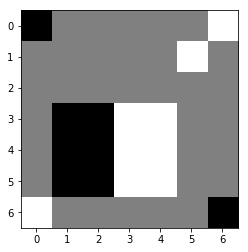

((6, 6), (4, 5)): n_v:   660 q_all:+0.012395 q:+0.016798 q_m:+0.166667 p:0.182329
((5, 2), (6, 3)): n_v:   594 q_all:+0.005637 q:-0.004219 q_m:+0.133333 p:0.187539
((3, 2), (2, 4)): n_v:   538 q_all:+0.008173 q:+0.048329 q_m:+0.166667 p:0.161961
((6, 6), (5, 5)): n_v:   438 q_all:+0.016155 q:+0.031832 q_m:+0.133333 p:0.111180
((3, 2), (2, 3)): n_v:   359 q_all:+0.014521 q:+0.021100 q_m:+0.133333 p:0.094642
((4, 1), (5, 0)): n_v:    64 q_all:+0.021927 q:-0.003087 q_m:+0.066667 p:0.014145
((5, 1), (6, 1)): n_v:    56 q_all:+0.017553 q:-0.004560 q_m:+0.066667 p:0.013739
((3, 1), (2, 2)): n_v:    51 q_all:-0.028904 q:-0.030358 q_m:+0.066667 p:0.026822
((5, 2), (6, 4)): n_v:    43 q_all:-0.028329 q:-0.036811 q_m:+0.100000 p:0.022219
((4, 2), (2, 4)): n_v:    39 q_all:-0.043351 q:+0.030798 q_m:+0.166667 p:0.023342
((3, 1), (2, 3)): n_v:    31 q_all:-0.004373 q:+0.001396 q_m:+0.100000 p:0.011719
((4, 1), (6, 3)): n_v:    21 q_all:-0.067828 q:-0.036449 q_m:+0.100000 p:0.015896
((6, 6), (6, 5))

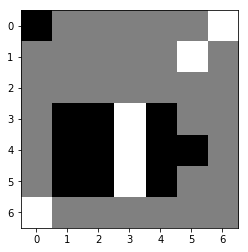

((3, 3), (5, 5)): n_v:  1056 q_all:-0.009512 q:-0.005921 q_m:+0.033333 p:0.343545
((5, 3), (5, 5)): n_v:   442 q_all:-0.026743 q:-0.024868 q_m:+0.033333 p:0.193111
((5, 3), (3, 5)): n_v:   367 q_all:-0.018030 q:-0.022510 q_m:+0.033333 p:0.139446
((3, 3), (3, 5)): n_v:   315 q_all:-0.019269 q:-0.014896 q_m:+0.033333 p:0.122330
((1, 5), (3, 5)): n_v:   173 q_all:-0.043963 q:-0.033677 q_m:+0.033333 p:0.094894
((4, 3), (3, 5)): n_v:    71 q_all:-0.014438 q:-0.006209 q_m:+0.033333 p:0.025380
((3, 3), (1, 1)): n_v:    67 q_all:-0.031098 q:-0.047129 q_m:-0.100000 p:0.031364
((4, 3), (5, 5)): n_v:    62 q_all:-0.036902 q:-0.020664 q_m:+0.033333 p:0.031628
((6, 0), (4, 0)): n_v:    13 q_all:-0.003095 q:-0.061849 q_m:+0.033333 p:0.003628
((3, 3), (2, 1)): n_v:     3 q_all:-0.021368 q:-0.036775 q_m:-0.033333 p:0.001528
((5, 3), (6, 5)): n_v:     2 q_all:-0.053996 q:-0.054668 q_m:-0.100000 p:0.001768
((5, 3), (6, 1)): n_v:     2 q_all:-0.038498 q:-0.049917 q_m:-0.033333 p:0.001229
((3, 3), (2, 5))

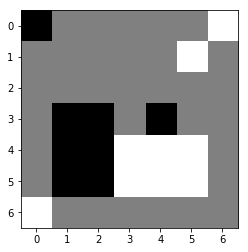

((3, 4), (1, 6)): n_v:   752 q_all:+0.033342 q:+0.063023 q_m:+0.100000 p:0.065916
((3, 4), (5, 6)): n_v:   738 q_all:+0.007872 q:+0.022376 q_m:+0.100000 p:0.178067
((3, 2), (3, 3)): n_v:   706 q_all:+0.010858 q:-0.006555 q_m:+0.133333 p:0.157658
((3, 4), (3, 5)): n_v:   262 q_all:-0.007707 q:+0.023745 q_m:+0.133333 p:0.087900
((3, 4), (4, 6)): n_v:   128 q_all:+0.020883 q:+0.011006 q_m:+0.100000 p:0.020681
((5, 2), (6, 4)): n_v:    89 q_all:-0.019160 q:-0.029677 q_m:+0.166667 p:0.035976
((3, 2), (5, 0)): n_v:    87 q_all:-0.024014 q:-0.011163 q_m:+0.033333 p:0.038122
((3, 1), (5, 0)): n_v:    45 q_all:-0.032083 q:-0.033066 q_m:+0.033333 p:0.021822
((3, 2), (4, 0)): n_v:    25 q_all:-0.035756 q:-0.049295 q_m:-0.033333 p:0.013006
((3, 2), (2, 4)): n_v:    24 q_all:-0.004486 q:+0.020934 q_m:+0.033333 p:0.007888
((3, 2), (1, 0)): n_v:    22 q_all:-0.036007 q:-0.043022 q_m:-0.033333 p:0.011624
((4, 1), (5, 0)): n_v:    21 q_all:-0.033252 q:-0.011007 q_m:+0.066667 p:0.010553
((3, 4), (2, 6))

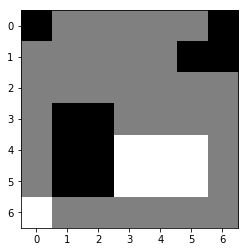

((4, 3), (2, 5)): n_v:   840 q_all:-0.012772 q:-0.024620 q_m:+0.033333 p:0.112858
((4, 3), (3, 3)): n_v:   797 q_all:-0.040763 q:-0.044985 q_m:+0.066667 p:0.248800
((4, 3), (2, 1)): n_v:   444 q_all:-0.050898 q:-0.028383 q_m:+0.033333 p:0.167047
((4, 3), (2, 4)): n_v:   112 q_all:-0.025372 q:-0.036845 q_m:-0.033333 p:0.024197
((4, 4), (2, 6)): n_v:    93 q_all:+0.004756 q:-0.038281 q_m:+0.033333 p:0.002106
((4, 3), (2, 2)): n_v:    79 q_all:-0.049246 q:-0.045960 q_m:+0.033333 p:0.029077
((4, 4), (2, 2)): n_v:    62 q_all:-0.041763 q:-0.060582 q_m:+0.033333 p:0.020039
((4, 5), (3, 3)): n_v:    61 q_all:-0.037832 q:-0.051212 q_m:+0.033333 p:0.018182
((4, 4), (2, 5)): n_v:    59 q_all:-0.002728 q:-0.033727 q_m:+0.033333 p:0.003763
((6, 0), (4, 0)): n_v:    42 q_all:-0.043963 q:-0.043130 q_m:+0.100000 p:0.014209
((4, 5), (2, 5)): n_v:    29 q_all:-0.029830 q:-0.021161 q_m:+0.033333 p:0.007080
((5, 4), (3, 3)): n_v:    23 q_all:-0.067975 q:-0.042760 q_m:+0.033333 p:0.011165
((5, 5), (3, 3))

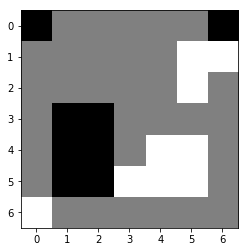

((0, 6), (2, 6)): n_v:  1486 q_all:+0.072251 q:+0.067525 q_m:+0.166667 p:0.006139
((3, 2), (4, 3)): n_v:   418 q_all:+0.013464 q:+0.022497 q_m:+0.200000 p:0.155379
((5, 1), (4, 3)): n_v:   288 q_all:+0.007912 q:-0.009242 q_m:+0.166667 p:0.117406
((3, 2), (2, 3)): n_v:   106 q_all:-0.009264 q:-0.000006 q_m:-0.000000 p:0.054788
((3, 2), (2, 4)): n_v:    99 q_all:+0.019789 q:+0.034512 q_m:+0.100000 p:0.033130
((4, 2), (3, 4)): n_v:    72 q_all:+0.013333 q:+0.046633 q_m:+0.166667 p:0.026715
((4, 1), (4, 3)): n_v:    60 q_all:-0.060609 q:-0.009852 q_m:+0.166667 p:0.049875
((4, 2), (6, 4)): n_v:    57 q_all:+0.019139 q:+0.032577 q_m:+0.166667 p:0.018890
((5, 2), (3, 4)): n_v:    41 q_all:+0.020934 q:+0.012016 q_m:+0.166667 p:0.013626
((3, 2), (3, 4)): n_v:    36 q_all:+0.032444 q:+0.047033 q_m:+0.166667 p:0.009361
((5, 2), (6, 4)): n_v:    33 q_all:+0.029877 q:+0.010940 q_m:+0.166667 p:0.009094
((3, 1), (4, 3)): n_v:    32 q_all:+0.009606 q:-0.005998 q_m:+0.166667 p:0.012898
((3, 2), (1, 4))

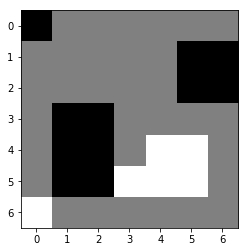

((4, 4), (2, 4)): n_v:   858 q_all:-0.032178 q:-0.050247 q_m:-0.033333 p:0.044202
((4, 4), (4, 3)): n_v:   684 q_all:-0.052875 q:-0.042310 q_m:+0.066667 p:0.115178
((4, 4), (2, 3)): n_v:   404 q_all:-0.074924 q:-0.047078 q_m:-0.100000 p:0.118329
((4, 5), (2, 3)): n_v:   228 q_all:-0.079642 q:-0.054998 q_m:-0.100000 p:0.073088
((6, 0), (4, 0)): n_v:   227 q_all:-0.036244 q:-0.038360 q_m:+0.033333 p:0.016716
((4, 4), (3, 5)): n_v:   221 q_all:-0.030908 q:-0.046985 q_m:-0.000000 p:0.009729
((4, 5), (2, 4)): n_v:   184 q_all:-0.046585 q:-0.052949 q_m:-0.033333 p:0.024458
((5, 5), (4, 3)): n_v:   158 q_all:-0.061338 q:-0.049183 q_m:+0.033333 p:0.034238
((4, 4), (2, 2)): n_v:   132 q_all:-0.067851 q:-0.045166 q_m:-0.033333 p:0.033278
((4, 5), (4, 3)): n_v:    95 q_all:-0.066964 q:-0.050004 q_m:+0.033333 p:0.023619
((5, 4), (3, 5)): n_v:    59 q_all:-0.064872 q:-0.055307 q_m:-0.033333 p:0.014126
((5, 3), (3, 5)): n_v:    58 q_all:-0.073864 q:-0.051047 q_m:-0.033333 p:0.016674
((5, 5), (3, 5))

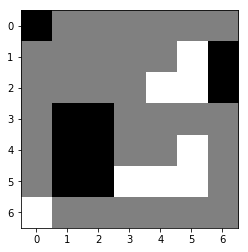

((5, 2), (4, 4)): n_v:  1195 q_all:+0.041278 q:+0.060950 q_m:+0.300000 p:0.467873
((3, 2), (1, 4)): n_v:   666 q_all:+0.099245 q:+0.110260 q_m:+0.233333 p:0.019866
((4, 2), (4, 4)): n_v:   592 q_all:+0.008742 q:+0.092421 q_m:+0.300000 p:0.351684
((3, 2), (4, 4)): n_v:   215 q_all:+0.045134 q:+0.091240 q_m:+0.300000 p:0.079294
((5, 2), (6, 4)): n_v:   134 q_all:+0.052388 q:+0.047663 q_m:+0.233333 p:0.042962
((4, 2), (6, 4)): n_v:    26 q_all:+0.013692 q:+0.069115 q_m:+0.233333 p:0.014941
((4, 2), (3, 4)): n_v:     7 q_all:+0.065253 q:+0.036827 q_m:+0.233333 p:0.001501
((3, 2), (3, 4)): n_v:     6 q_all:+0.077326 q:+0.049947 q_m:+0.233333 p:0.001092
((2, 6), (4, 4)): n_v:     5 q_all:+0.036085 q:+0.097766 q_m:+0.300000 p:0.002164
((5, 2), (3, 4)): n_v:     3 q_all:+0.021905 q:+0.023614 q_m:+0.233333 p:0.001710
((3, 2), (4, 3)): n_v:     2 q_all:+0.019706 q:+0.030964 q_m:+0.200000 p:0.000937
((3, 2), (2, 3)): n_v:     2 q_all:+0.027934 q:+0.051564 q_m:+0.133333 p:0.000776
((3, 1), (2, 2))

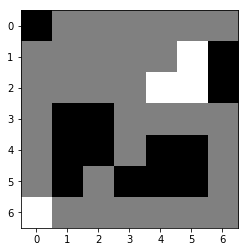

((6, 0), (5, 2)): n_v:  1089 q_all:-0.040750 q:-0.010593 q_m:-0.033333 p:0.337208
((2, 4), (4, 3)): n_v:   985 q_all:-0.035342 q:-0.058294 q_m:+0.033333 p:0.273747
((2, 5), (4, 3)): n_v:   753 q_all:-0.039946 q:-0.061836 q_m:+0.033333 p:0.229536
((2, 4), (2, 3)): n_v:   103 q_all:-0.063048 q:-0.079504 q_m:-0.200000 p:0.045279
((2, 4), (4, 6)): n_v:    85 q_all:-0.065299 q:-0.085253 q_m:-0.166667 p:0.038833
((6, 0), (4, 0)): n_v:    65 q_all:-0.056561 q:-0.080367 q_m:-0.100000 p:0.026351
((6, 0), (6, 2)): n_v:    17 q_all:-0.086520 q:-0.075997 q_m:-0.166667 p:0.009928
((2, 5), (2, 3)): n_v:    14 q_all:-0.074521 q:-0.093051 q_m:-0.233333 p:0.006964
((2, 4), (3, 5)): n_v:     6 q_all:-0.050300 q:-0.073927 q_m:-0.066667 p:0.002244
((2, 4), (1, 2)): n_v:     6 q_all:-0.131819 q:-0.145239 q_m:-0.300000 p:0.005308
((1, 5), (2, 3)): n_v:     6 q_all:-0.064618 q:-0.075695 q_m:-0.233333 p:0.002838
((2, 5), (4, 6)): n_v:     6 q_all:-0.079507 q:-0.086530 q_m:-0.166667 p:0.003362
((2, 4), (3, 3))

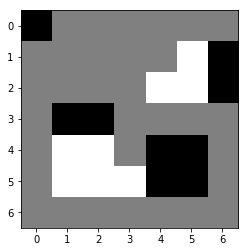

((3, 2), (1, 4)): n_v:   593 q_all:+0.100878 q:+0.117425 q_m:+0.233333 p:0.107310
((4, 4), (6, 2)): n_v:   511 q_all:+0.052314 q:+0.071280 q_m:+0.233333 p:0.266471
((5, 4), (6, 2)): n_v:   286 q_all:+0.056049 q:+0.056888 q_m:+0.233333 p:0.142104
((3, 2), (4, 3)): n_v:   183 q_all:+0.046450 q:+0.054585 q_m:+0.266667 p:0.103049
((2, 6), (1, 4)): n_v:   183 q_all:+0.115073 q:+0.090540 q_m:+0.233333 p:0.014796
((1, 6), (1, 4)): n_v:    63 q_all:+0.101618 q:+0.093767 q_m:+0.233333 p:0.011231
((3, 2), (2, 3)): n_v:    55 q_all:+0.034814 q:+0.038449 q_m:+0.133333 p:0.035840
((4, 4), (6, 4)): n_v:    34 q_all:+0.020424 q:+0.024437 q_m:+0.100000 p:0.025428
((3, 1), (4, 0)): n_v:    30 q_all:+0.046776 q:+0.051270 q_m:+0.200000 p:0.016976
((5, 4), (6, 4)): n_v:    18 q_all:+0.017468 q:+0.018533 q_m:+0.133333 p:0.014026
((3, 2), (5, 0)): n_v:    15 q_all:+0.047053 q:+0.055511 q_m:+0.166667 p:0.008784
((4, 4), (6, 6)): n_v:    12 q_all:+0.009855 q:+0.002597 q_m:+0.033333 p:0.010492
((3, 2), (1, 0))

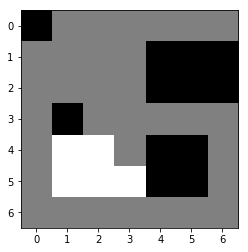

((5, 3), (3, 5)): n_v:   825 q_all:-0.030028 q:-0.009363 q_m:+0.100000 p:0.098256
((4, 2), (2, 3)): n_v:   603 q_all:-0.093796 q:-0.020506 q_m:-0.100000 p:0.323756
((4, 2), (3, 4)): n_v:   171 q_all:-0.084811 q:-0.046347 q_m:+0.033333 p:0.081620
((4, 1), (2, 2)): n_v:   147 q_all:-0.067758 q:-0.061472 q_m:-0.166667 p:0.053801
((4, 1), (2, 3)): n_v:   142 q_all:-0.070102 q:-0.024973 q_m:-0.100000 p:0.054488
((5, 2), (3, 4)): n_v:    89 q_all:-0.082218 q:-0.056134 q_m:+0.033333 p:0.041105
((5, 3), (3, 3)): n_v:    77 q_all:-0.071344 q:-0.044523 q_m:-0.100000 p:0.030205
((5, 3), (3, 4)): n_v:    68 q_all:-0.074472 q:-0.045225 q_m:+0.033333 p:0.028202
((5, 2), (3, 3)): n_v:    46 q_all:-0.091978 q:-0.057562 q_m:-0.100000 p:0.024381
((5, 3), (3, 2)): n_v:    43 q_all:-0.067847 q:-0.035179 q_m:-0.166667 p:0.016066
((5, 1), (4, 3)): n_v:    38 q_all:-0.105340 q:-0.087288 q_m:-0.100000 p:0.023688
((4, 2), (2, 2)): n_v:    36 q_all:-0.190454 q:-0.049289 q_m:-0.166667 p:0.042842
((4, 1), (3, 3))

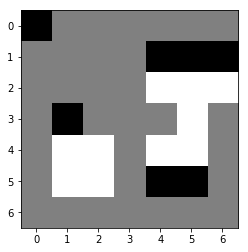

((1, 6), (3, 4)): n_v:   619 q_all:+0.057785 q:+0.045630 q_m:+0.233333 p:0.143437
((5, 5), (3, 4)): n_v:   617 q_all:+0.039807 q:+0.021878 q_m:+0.233333 p:0.212692
((5, 4), (3, 6)): n_v:   311 q_all:+0.031997 q:+0.012380 q_m:+0.166667 p:0.122363
((3, 1), (3, 2)): n_v:   289 q_all:+0.015711 q:+0.031166 q_m:+0.066667 p:0.143507
((1, 5), (3, 4)): n_v:   202 q_all:+0.000785 q:+0.033827 q_m:+0.233333 p:0.118934
((1, 4), (3, 6)): n_v:   183 q_all:+0.038804 q:+0.016535 q_m:+0.166667 p:0.064229
((5, 5), (3, 6)): n_v:   161 q_all:+0.061014 q:+0.029956 q_m:+0.166667 p:0.034067
((1, 4), (3, 4)): n_v:   136 q_all:+0.059253 q:+0.040844 q_m:+0.233333 p:0.030223
((5, 4), (3, 2)): n_v:    99 q_all:+0.015360 q:+0.034977 q_m:+0.033333 p:0.049420
((5, 4), (3, 4)): n_v:    86 q_all:+0.061674 q:+0.058639 q_m:+0.233333 p:0.018140
((1, 4), (3, 2)): n_v:    35 q_all:+0.014164 q:+0.012106 q_m:+0.033333 p:0.017612
((1, 5), (3, 6)): n_v:    23 q_all:+0.009261 q:+0.004742 q_m:+0.166667 p:0.012638
((5, 4), (5, 3))

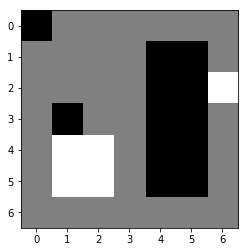

((2, 6), (4, 6)): n_v:   694 q_all:-0.050518 q:-0.056154 q_m:-0.033333 p:0.239621
((2, 6), (3, 6)): n_v:   409 q_all:-0.059821 q:-0.063034 q_m:-0.000000 p:0.166152
((4, 1), (2, 0)): n_v:   301 q_all:-0.036460 q:-0.077247 q_m:-0.166667 p:0.076404
((4, 1), (3, 0)): n_v:   249 q_all:-0.054529 q:-0.079596 q_m:-0.133333 p:0.092315
((2, 6), (0, 4)): n_v:   163 q_all:-0.042413 q:-0.055238 q_m:-0.100000 p:0.047368
((4, 2), (2, 3)): n_v:   125 q_all:-0.045611 q:-0.023452 q_m:-0.033333 p:0.039157
((4, 1), (2, 2)): n_v:    97 q_all:-0.051281 q:-0.083189 q_m:-0.166667 p:0.034201
((4, 2), (4, 3)): n_v:    92 q_all:-0.064759 q:-0.066507 q_m:-0.000000 p:0.040625
((4, 1), (3, 2)): n_v:    75 q_all:-0.005479 q:-0.042730 q_m:-0.133333 p:0.004060
((2, 6), (1, 6)): n_v:    75 q_all:-0.028595 q:-0.056455 q_m:-0.066667 p:0.015121
((4, 1), (2, 3)): n_v:    65 q_all:-0.041196 q:-0.032301 q_m:-0.033333 p:0.018093
((4, 1), (2, 1)): n_v:    57 q_all:-0.044651 q:-0.067787 q_m:-0.166667 p:0.017624
((4, 2), (3, 3))

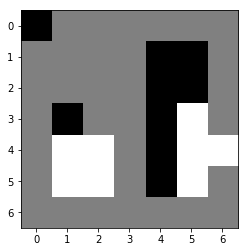

((5, 4), (3, 6)): n_v:   472 q_all:+0.096196 q:+0.090994 q_m:+0.233333 p:0.091423
((2, 5), (3, 6)): n_v:   370 q_all:+0.086110 q:+0.113102 q_m:+0.266667 p:0.095395
((3, 4), (5, 6)): n_v:   327 q_all:+0.057845 q:+0.043478 q_m:+0.233333 p:0.143806
((1, 4), (3, 6)): n_v:   268 q_all:+0.079054 q:+0.067250 q_m:+0.233333 p:0.081606
((3, 4), (3, 6)): n_v:   228 q_all:+0.055933 q:+0.057229 q_m:+0.233333 p:0.103353
((4, 4), (3, 6)): n_v:   176 q_all:+0.076783 q:+0.071819 q_m:+0.233333 p:0.055996
((4, 4), (5, 6)): n_v:   167 q_all:+0.074693 q:+0.046442 q_m:+0.233333 p:0.055071
((2, 4), (3, 6)): n_v:   127 q_all:+0.015668 q:+0.064845 q_m:+0.233333 p:0.090676
((3, 1), (5, 0)): n_v:   120 q_all:+0.078561 q:+0.066070 q_m:+0.166667 p:0.036897
((3, 1), (3, 0)): n_v:    89 q_all:+0.030513 q:+0.019245 q_m:+0.133333 p:0.054456
((5, 4), (5, 6)): n_v:    79 q_all:+0.077195 q:+0.048458 q_m:+0.233333 p:0.025062
((1, 5), (3, 6)): n_v:    76 q_all:+0.074987 q:+0.105021 q_m:+0.233333 p:0.025232
((1, 4), (1, 6))

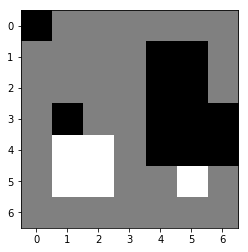

((5, 5), (5, 6)): n_v:   691 q_all:-0.031445 q:-0.055446 q_m:-0.066667 p:0.091050
((4, 2), (2, 3)): n_v:   512 q_all:-0.036485 q:-0.024580 q_m:-0.033333 p:0.085136
((4, 2), (5, 4)): n_v:   315 q_all:-0.127041 q:-0.099150 q_m:-0.100000 p:0.244094
((4, 2), (3, 3)): n_v:   250 q_all:-0.068708 q:-0.059216 q_m:-0.000000 p:0.095154
((5, 5), (5, 4)): n_v:   165 q_all:-0.069409 q:-0.093626 q_m:-0.066667 p:0.063461
((4, 1), (2, 3)): n_v:   100 q_all:-0.032162 q:-0.035973 q_m:-0.033333 p:0.013888
((5, 2), (5, 4)): n_v:    82 q_all:-0.121199 q:-0.114847 q_m:-0.100000 p:0.060349
((4, 2), (2, 0)): n_v:    73 q_all:-0.121774 q:-0.109792 q_m:-0.166667 p:0.054134
((5, 2), (3, 3)): n_v:    62 q_all:-0.083039 q:-0.082497 q_m:-0.033333 p:0.029928
((4, 2), (4, 3)): n_v:    35 q_all:-0.101011 q:-0.123360 q_m:-0.066667 p:0.021202
((4, 1), (3, 3)): n_v:    28 q_all:-0.087219 q:-0.073742 q_m:-0.033333 p:0.014327
((4, 1), (2, 1)): n_v:    22 q_all:-0.083754 q:-0.109996 q_m:-0.166667 p:0.010712
((4, 1), (5, 0))

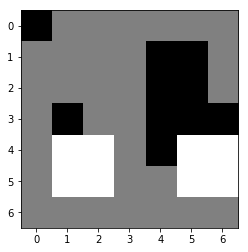

((4, 4), (6, 5)): n_v:   359 q_all:+0.072379 q:+0.044875 q_m:+0.200000 p:0.149742
((4, 4), (5, 4)): n_v:   158 q_all:+0.061746 q:+0.078168 q_m:+0.233333 p:0.081220
((4, 4), (6, 6)): n_v:   148 q_all:+0.070830 q:+0.033526 q_m:+0.200000 p:0.063688
((3, 4), (5, 4)): n_v:    96 q_all:+0.009057 q:+0.017951 q_m:+0.200000 p:0.094243
((3, 1), (4, 0)): n_v:    85 q_all:+0.074111 q:+0.091651 q_m:+0.233333 p:0.034563
((3, 1), (3, 2)): n_v:    56 q_all:+0.055699 q:+0.073642 q_m:+0.233333 p:0.032103
((2, 4), (0, 5)): n_v:    53 q_all:-0.030772 q:+0.003919 q_m:+0.066667 p:0.071815
((2, 4), (2, 6)): n_v:    52 q_all:-0.028688 q:-0.003795 q_m:+0.066667 p:0.068926
((4, 4), (6, 2)): n_v:    50 q_all:+0.100819 q:+0.102939 q_m:+0.200000 p:0.008462
((2, 4), (0, 6)): n_v:    49 q_all:-0.018341 q:-0.010922 q_m:+0.066667 p:0.059935
((3, 1), (5, 0)): n_v:    32 q_all:+0.085535 q:+0.077867 q_m:+0.200000 p:0.009884
((3, 6), (5, 4)): n_v:    27 q_all:+0.034653 q:+0.059978 q_m:+0.200000 p:0.020895
((1, 4), (0, 6))

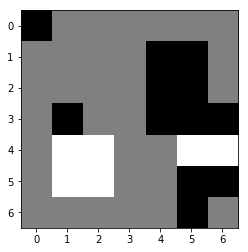

((4, 2), (4, 4)): n_v:   444 q_all:-0.061370 q:-0.089988 q_m:-0.000000 p:0.197492
((4, 2), (2, 3)): n_v:   418 q_all:-0.027463 q:-0.021910 q_m:-0.000000 p:0.086683
((4, 5), (4, 4)): n_v:   194 q_all:-0.040598 q:-0.061299 q_m:+0.033333 p:0.058652
((4, 1), (2, 0)): n_v:   154 q_all:-0.048968 q:-0.106102 q_m:-0.133333 p:0.055402
((4, 5), (2, 6)): n_v:   111 q_all:-0.063147 q:-0.066345 q_m:+0.066667 p:0.050981
((4, 1), (2, 3)): n_v:   105 q_all:-0.028434 q:-0.034972 q_m:-0.000000 p:0.022489
((4, 5), (2, 3)): n_v:    89 q_all:-0.026835 q:-0.045892 q_m:-0.000000 p:0.018134
((4, 2), (5, 4)): n_v:    84 q_all:-0.082731 q:-0.067926 q_m:-0.066667 p:0.050224
((4, 6), (2, 6)): n_v:    79 q_all:-0.049065 q:-0.028756 q_m:+0.066667 p:0.028295
((4, 2), (2, 0)): n_v:    75 q_all:-0.133665 q:-0.112700 q_m:-0.133333 p:0.072128
((5, 2), (4, 4)): n_v:    74 q_all:-0.073964 q:-0.094646 q_m:-0.000000 p:0.039451
((4, 1), (2, 2)): n_v:    54 q_all:-0.077913 q:-0.113163 q_m:-0.133333 p:0.030258
((4, 2), (2, 2))

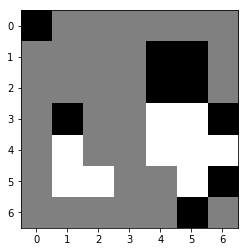

((3, 1), (4, 2)): n_v:  1174 q_all:+0.116701 q:+0.120769 q_m:+0.233333 p:0.250407
((6, 5), (5, 4)): n_v:   516 q_all:+0.068448 q:+0.079962 q_m:+0.233333 p:0.277837
((2, 4), (4, 2)): n_v:   249 q_all:+0.101533 q:+0.107384 q_m:+0.200000 p:0.078650
((3, 6), (5, 4)): n_v:   182 q_all:+0.058140 q:+0.047823 q_m:+0.200000 p:0.110640
((3, 1), (2, 2)): n_v:   103 q_all:+0.006083 q:-0.015450 q_m:+0.033333 p:0.099476
((5, 6), (5, 4)): n_v:    78 q_all:+0.044193 q:+0.045310 q_m:+0.200000 p:0.053991
((2, 4), (3, 3)): n_v:    37 q_all:+0.065572 q:+0.039732 q_m:+0.166667 p:0.020953
((3, 1), (4, 0)): n_v:    17 q_all:+0.055819 q:+0.059921 q_m:+0.166667 p:0.011189
((3, 1), (2, 0)): n_v:    17 q_all:-0.005601 q:-0.023533 q_m:+0.033333 p:0.018080
((1, 4), (2, 2)): n_v:     5 q_all:-0.012464 q:-0.042006 q_m:-0.000000 p:0.006176
((1, 5), (2, 6)): n_v:     3 q_all:+0.004525 q:+0.018856 q_m:+0.100000 p:0.003251
((3, 1), (2, 1)): n_v:     3 q_all:+0.002392 q:-0.002589 q_m:+0.033333 p:0.003508
((5, 6), (6, 6))

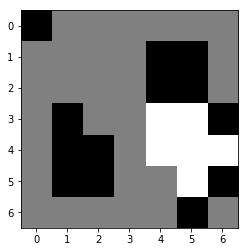

((3, 5), (2, 6)): n_v:  2565 q_all:-0.088735 q:-0.076788 q_m:-0.000000 p:0.789698
((4, 4), (3, 2)): n_v:   161 q_all:-0.071239 q:-0.089528 q_m:-0.033333 p:0.033023
((3, 4), (3, 2)): n_v:   106 q_all:-0.062366 q:-0.075848 q_m:-0.033333 p:0.015927
((4, 4), (6, 6)): n_v:    86 q_all:-0.102489 q:-0.093534 q_m:-0.100000 p:0.033573
((3, 4), (2, 3)): n_v:    50 q_all:-0.074217 q:-0.104650 q_m:-0.066667 p:0.011248
((5, 5), (6, 6)): n_v:    49 q_all:-0.067716 q:-0.046950 q_m:-0.066667 p:0.008745
((4, 4), (2, 6)): n_v:    45 q_all:-0.146180 q:-0.133936 q_m:-0.033333 p:0.029566
((3, 4), (4, 3)): n_v:    44 q_all:-0.104934 q:-0.147289 q_m:-0.066667 p:0.018004
((3, 4), (2, 6)): n_v:    17 q_all:-0.116560 q:-0.124538 q_m:-0.033333 p:0.008465
((4, 6), (2, 6)): n_v:    11 q_all:-0.160801 q:-0.105887 q_m:-0.033333 p:0.008577
((3, 4), (3, 3)): n_v:     6 q_all:-0.115461 q:-0.124979 q_m:-0.066667 p:0.002959
((4, 4), (5, 3)): n_v:     6 q_all:-0.141268 q:-0.128898 q_m:-0.066667 p:0.003776
((3, 4), (2, 2))

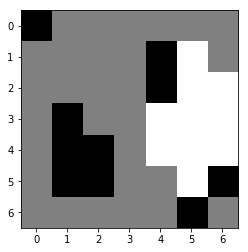

((1, 4), (1, 6)): n_v:  2259 q_all:+0.117651 q:+0.138340 q_m:+0.200000 p:0.380520
((2, 4), (1, 6)): n_v:  1834 q_all:+0.103137 q:+0.120548 q_m:+0.200000 p:0.440935
((6, 5), (5, 4)): n_v:   225 q_all:+0.083506 q:+0.116324 q_m:+0.233333 p:0.076091
((4, 2), (5, 4)): n_v:    48 q_all:+0.072348 q:+0.110543 q_m:+0.200000 p:0.019171
((3, 1), (1, 0)): n_v:    29 q_all:-0.001705 q:-0.013946 q_m:-0.000000 p:0.022616
((5, 2), (5, 4)): n_v:    17 q_all:+0.070746 q:+0.087086 q_m:+0.200000 p:0.006738
((0, 0), (1, 0)): n_v:    14 q_all:+0.021363 q:+0.007609 q_m:+0.033333 p:0.009190
((4, 1), (5, 0)): n_v:     6 q_all:+0.009558 q:-0.011354 q_m:+0.033333 p:0.004651
((5, 2), (5, 0)): n_v:     5 q_all:-0.024844 q:-0.041739 q_m:-0.000000 p:0.005184
((5, 6), (5, 4)): n_v:     4 q_all:+0.043513 q:+0.074101 q_m:+0.200000 p:0.002539
((2, 4), (0, 5)): n_v:     4 q_all:+0.024248 q:+0.039297 q_m:+0.066667 p:0.003138
((4, 2), (5, 0)): n_v:     4 q_all:-0.019323 q:-0.023074 q_m:-0.000000 p:0.003283
((3, 1), (5, 0))

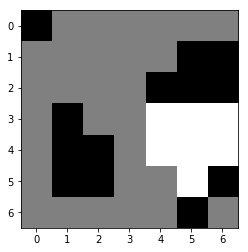

((5, 5), (6, 6)): n_v:  2558 q_all:-0.032943 q:-0.006387 q_m:-0.033333 p:0.095625
((4, 4), (6, 6)): n_v:   415 q_all:-0.097148 q:-0.048113 q_m:-0.066667 p:0.131387
((4, 4), (5, 4)): n_v:   301 q_all:-0.146695 q:-0.115884 q_m:-0.100000 p:0.182562
((3, 4), (1, 2)): n_v:   246 q_all:-0.155071 q:-0.159743 q_m:-0.200000 p:0.159497
((4, 4), (3, 2)): n_v:   114 q_all:-0.082699 q:-0.077774 q_m:-0.000000 p:0.024634
((3, 4), (3, 2)): n_v:   106 q_all:-0.076561 q:-0.048250 q_m:-0.000000 p:0.018406
((3, 4), (4, 3)): n_v:    91 q_all:-0.127025 q:-0.116418 q_m:-0.033333 p:0.046119
((3, 4), (1, 4)): n_v:    44 q_all:-0.117303 q:-0.102258 q_m:-0.000000 p:0.020444
((3, 6), (1, 4)): n_v:    40 q_all:-0.130374 q:-0.119698 q_m:-0.000000 p:0.020981
((3, 4), (3, 3)): n_v:    35 q_all:-0.115572 q:-0.084512 q_m:-0.033333 p:0.015945
((3, 4), (5, 4)): n_v:    31 q_all:-0.150237 q:-0.127812 q_m:-0.133333 p:0.019502
((3, 4), (2, 3)): n_v:    31 q_all:-0.157756 q:-0.119033 q_m:-0.100000 p:0.021041
((3, 6), (5, 4))

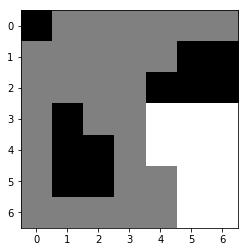

((4, 2), (5, 4)): n_v:  2567 q_all:+0.056164 q:+0.150896 q_m:+0.300000 p:0.508570
((5, 2), (5, 4)): n_v:  1889 q_all:+0.051309 q:+0.124117 q_m:+0.300000 p:0.418802
((2, 4), (1, 2)): n_v:    24 q_all:-0.007995 q:-0.001066 q_m:+0.033333 p:0.012353
((5, 2), (3, 3)): n_v:    19 q_all:+0.032744 q:+0.044761 q_m:+0.166667 p:0.006156
((2, 4), (3, 3)): n_v:     8 q_all:+0.006367 q:+0.058532 q_m:+0.200000 p:0.003704
((5, 2), (6, 4)): n_v:     7 q_all:-0.030261 q:+0.056368 q_m:+0.166667 p:0.004684
((4, 2), (6, 4)): n_v:     6 q_all:-0.026970 q:+0.067645 q_m:+0.166667 p:0.003806
((3, 1), (1, 0)): n_v:     4 q_all:+0.050129 q:+0.018825 q_m:+0.033333 p:0.001109
((2, 4), (3, 2)): n_v:     4 q_all:-0.008129 q:+0.011216 q_m:+0.033333 p:0.002486
((2, 4), (2, 2)): n_v:     3 q_all:-0.034224 q:-0.003254 q_m:+0.033333 p:0.002215
((3, 1), (1, 2)): n_v:     3 q_all:+0.015791 q:+0.020206 q_m:+0.033333 p:0.001158
((1, 5), (1, 4)): n_v:     3 q_all:+0.030098 q:+0.041783 q_m:+0.066667 p:0.001197
((4, 1), (4, 3))

due to rollout lim, final rollout times:  2001 time elapsed:  2.35469126701355
one move takes time(s):  2.3562116622924805
no. of data collected:  16


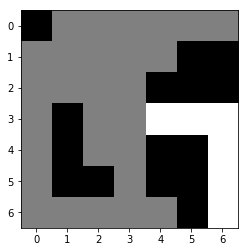

((3, 4), (4, 2)): n_v:  3268 q_all:-0.009262 q:+0.034093 q_m:-0.033333 p:0.373951
((3, 4), (1, 2)): n_v:   258 q_all:-0.144962 q:-0.165267 q_m:-0.300000 p:0.202882
((3, 4), (2, 2)): n_v:   214 q_all:-0.111010 q:-0.083468 q_m:-0.233333 p:0.132003
((3, 4), (4, 3)): n_v:   183 q_all:-0.039907 q:-0.076226 q_m:-0.066667 p:0.048386
((3, 4), (3, 3)): n_v:   168 q_all:-0.058673 q:-0.109199 q_m:-0.133333 p:0.060501
((3, 4), (1, 4)): n_v:   114 q_all:-0.100122 q:-0.119858 q_m:-0.100000 p:0.064242
((3, 4), (5, 3)): n_v:   102 q_all:-0.076198 q:-0.085966 q_m:-0.100000 p:0.045499
((6, 6), (6, 4)): n_v:    38 q_all:-0.073130 q:-0.096840 q_m:-0.100000 p:0.016669
((3, 4), (1, 3)): n_v:    23 q_all:-0.106406 q:-0.120902 q_m:-0.233333 p:0.014091
((3, 4), (2, 3)): n_v:    18 q_all:-0.157345 q:-0.124811 q_m:-0.200000 p:0.015901
((3, 6), (1, 4)): n_v:    16 q_all:-0.107207 q:-0.131941 q_m:-0.100000 p:0.010136
((5, 6), (6, 4)): n_v:     6 q_all:-0.142190 q:-0.132855 q_m:-0.100000 p:0.004850
((3, 4), (3, 2))

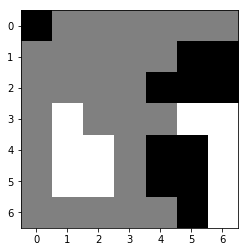

((4, 4), (3, 2)): n_v:  1612 q_all:+0.036993 q:+0.068453 q_m:+0.233333 p:0.201851
((5, 4), (3, 2)): n_v:  1286 q_all:+0.047728 q:+0.071222 q_m:+0.233333 p:0.097557
((2, 4), (3, 2)): n_v:  1130 q_all:+0.029405 q:+0.059250 q_m:+0.233333 p:0.180608
((2, 4), (3, 4)): n_v:   293 q_all:-0.021785 q:+0.010579 q_m:+0.133333 p:0.115977
((1, 5), (3, 4)): n_v:    37 q_all:-0.052458 q:-0.020322 q_m:+0.100000 p:0.020087
((1, 6), (3, 4)): n_v:    35 q_all:-0.058336 q:-0.029722 q_m:+0.100000 p:0.020104
((4, 4), (2, 2)): n_v:    29 q_all:-0.010441 q:-0.006050 q_m:+0.100000 p:0.010280
((5, 4), (3, 4)): n_v:    29 q_all:-0.032987 q:+0.000141 q_m:+0.100000 p:0.012804
((4, 4), (4, 3)): n_v:    17 q_all:+0.009323 q:+0.031492 q_m:+0.200000 p:0.004251
((4, 4), (6, 2)): n_v:    13 q_all:+0.026821 q:+0.053397 q_m:+0.166667 p:0.002348
((4, 4), (5, 3)): n_v:    12 q_all:+0.006944 q:+0.032453 q_m:+0.200000 p:0.003343
((5, 5), (3, 4)): n_v:    12 q_all:-0.065041 q:-0.044828 q_m:+0.100000 p:0.007417
((2, 4), (4, 3))

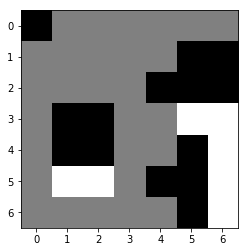

((5, 2), (6, 4)): n_v:  1290 q_all:+0.018851 q:-0.008753 q_m:-0.033333 p:0.247173
((5, 2), (4, 4)): n_v:   363 q_all:-0.028263 q:-0.017732 q_m:-0.033333 p:0.164668
((3, 5), (3, 4)): n_v:   338 q_all:+0.014721 q:-0.008627 q_m:-0.000000 p:0.072634
((3, 5), (4, 4)): n_v:   289 q_all:+0.001973 q:+0.012059 q_m:-0.000000 p:0.082298
((5, 2), (3, 4)): n_v:   265 q_all:-0.023211 q:-0.039040 q_m:-0.033333 p:0.112763
((6, 6), (6, 4)): n_v:   160 q_all:-0.001386 q:-0.009205 q_m:-0.033333 p:0.048749
((5, 2), (5, 3)): n_v:    88 q_all:-0.025133 q:-0.016512 q_m:-0.066667 p:0.038308
((5, 2), (4, 3)): n_v:    70 q_all:-0.012552 q:-0.003951 q_m:-0.000000 p:0.025792
((5, 2), (3, 3)): n_v:    56 q_all:-0.020615 q:-0.000929 q_m:-0.033333 p:0.022671
((3, 6), (1, 4)): n_v:    55 q_all:-0.023539 q:-0.023116 q_m:-0.033333 p:0.023654
((6, 6), (4, 4)): n_v:    42 q_all:-0.001455 q:-0.010577 q_m:-0.033333 p:0.013029
((3, 5), (5, 3)): n_v:    33 q_all:-0.055358 q:-0.043126 q_m:-0.100000 p:0.020290
((5, 6), (3, 4))

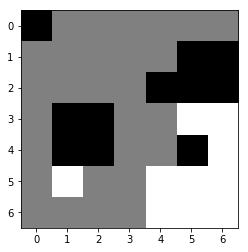

((4, 5), (5, 3)): n_v:  1690 q_all:+0.082656 q:+0.026862 q_m:+0.166667 p:0.031123
((3, 1), (4, 0)): n_v:   147 q_all:-0.009095 q:+0.011086 q_m:+0.133333 p:0.081811
((4, 2), (5, 3)): n_v:   146 q_all:-0.004998 q:+0.042625 q_m:+0.200000 p:0.077726
((4, 5), (4, 4)): n_v:   111 q_all:+0.009378 q:+0.046074 q_m:+0.266667 p:0.049735
((4, 2), (4, 4)): n_v:   101 q_all:-0.023715 q:+0.017662 q_m:+0.233333 p:0.064446
((4, 1), (5, 3)): n_v:    72 q_all:-0.003524 q:+0.026789 q_m:+0.166667 p:0.037606
((2, 4), (1, 3)): n_v:    67 q_all:-0.033846 q:-0.044279 q_m:+0.066667 p:0.046466
((4, 5), (6, 3)): n_v:    67 q_all:+0.075519 q:+0.042283 q_m:+0.166667 p:0.004352
((4, 1), (6, 0)): n_v:    56 q_all:+0.002822 q:+0.019211 q_m:+0.100000 p:0.027279
((2, 4), (4, 4)): n_v:    47 q_all:+0.009334 q:+0.017847 q_m:+0.233333 p:0.021270
((3, 2), (4, 0)): n_v:    46 q_all:-0.023508 q:-0.014068 q_m:+0.100000 p:0.029866
((3, 2), (4, 4)): n_v:    46 q_all:-0.018706 q:+0.010177 q_m:+0.233333 p:0.028045
((3, 2), (5, 3))

due to rollout lim, final rollout times:  2001 time elapsed:  2.2994496822357178
one move takes time(s):  2.300907611846924
no. of data collected:  16


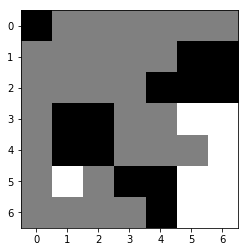

((5, 5), (6, 3)): n_v:  1775 q_all:-0.004722 q:-0.031971 q_m:+0.033333 p:0.079367
((5, 1), (5, 2)): n_v:   525 q_all:-0.126297 q:+0.011588 q_m:+0.066667 p:0.378030
((3, 5), (1, 4)): n_v:   403 q_all:-0.021022 q:-0.013975 q_m:+0.033333 p:0.017859
((5, 1), (6, 3)): n_v:   211 q_all:-0.141885 q:+0.022109 q_m:+0.033333 p:0.170369
((3, 6), (1, 4)): n_v:   150 q_all:-0.035205 q:-0.011725 q_m:+0.033333 p:0.023292
((3, 5), (4, 5)): n_v:   127 q_all:-0.040017 q:-0.050707 q_m:-0.066667 p:0.024743
((3, 5), (4, 3)): n_v:   125 q_all:-0.010414 q:+0.001769 q_m:+0.100000 p:0.013878
((5, 1), (4, 3)): n_v:   113 q_all:-0.109644 q:-0.005866 q_m:+0.100000 p:0.071208
((6, 5), (4, 3)): n_v:    95 q_all:-0.091032 q:-0.043454 q_m:+0.100000 p:0.050107
((6, 5), (6, 3)): n_v:    58 q_all:-0.091852 q:-0.033196 q_m:+0.033333 p:0.031050
((5, 5), (4, 3)): n_v:    34 q_all:-0.087342 q:-0.030256 q_m:+0.100000 p:0.017451
((3, 5), (2, 3)): n_v:    20 q_all:-0.049544 q:+0.004925 q_m:-0.033333 p:0.005510
((3, 5), (3, 3))

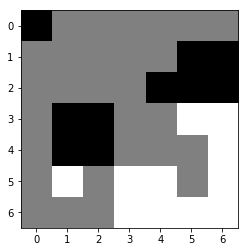

((4, 1), (5, 2)): n_v:   981 q_all:+0.028368 q:+0.111812 q_m:+0.200000 p:0.202116
((4, 2), (4, 4)): n_v:   652 q_all:+0.063706 q:+0.041313 q_m:+0.166667 p:0.015105
((3, 2), (4, 4)): n_v:   480 q_all:+0.070991 q:+0.035288 q_m:+0.166667 p:0.014315
((3, 2), (4, 3)): n_v:   358 q_all:+0.067393 q:+0.023044 q_m:+0.133333 p:0.004578
((2, 4), (4, 5)): n_v:   287 q_all:+0.022510 q:+0.145565 q_m:+0.300000 p:0.066010
((4, 2), (3, 4)): n_v:   198 q_all:+0.068033 q:+0.010273 q_m:+0.033333 p:0.001828
((3, 2), (1, 1)): n_v:    97 q_all:-0.028501 q:-0.016019 q_m:-0.033333 p:0.055177
((3, 1), (5, 2)): n_v:    96 q_all:+0.011688 q:+0.058460 q_m:+0.166667 p:0.030260
((2, 4), (4, 4)): n_v:    86 q_all:+0.024846 q:+0.035822 q_m:+0.166667 p:0.018018
((3, 2), (5, 2)): n_v:    74 q_all:-0.000180 q:+0.089037 q_m:+0.166667 p:0.030188
((4, 2), (6, 1)): n_v:    55 q_all:-0.012397 q:+0.002705 q_m:+0.033333 p:0.026073
((4, 2), (6, 0)): n_v:    50 q_all:+0.006916 q:+0.007159 q_m:+0.033333 p:0.017880
((4, 2), (6, 2))

due to rollout lim, final rollout times:  2001 time elapsed:  2.953932046890259
one move takes time(s):  2.955735921859741
no. of data collected:  8


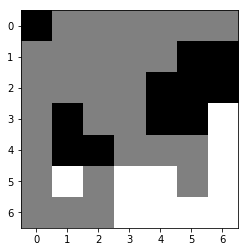

((5, 1), (3, 2)): n_v:   874 q_all:-0.007818 q:+0.054068 q_m:+0.166667 p:0.387503
((3, 6), (1, 4)): n_v:   330 q_all:-0.039448 q:+0.017594 q_m:+0.166667 p:0.224658
((3, 6), (4, 5)): n_v:   288 q_all:+0.051110 q:-0.069108 q_m:+0.133333 p:0.002647
((5, 3), (3, 2)): n_v:   178 q_all:-0.006528 q:+0.047421 q_m:+0.166667 p:0.077267
((5, 4), (3, 2)): n_v:   119 q_all:-0.004157 q:+0.067858 q_m:+0.166667 p:0.049802
((5, 1), (5, 2)): n_v:    75 q_all:-0.042285 q:-0.011234 q_m:+0.133333 p:0.052740
((3, 6), (4, 4)): n_v:    51 q_all:+0.030068 q:-0.035737 q_m:+0.100000 p:0.008258
((5, 4), (3, 3)): n_v:    21 q_all:-0.016760 q:+0.020645 q_m:+0.166667 p:0.010717
((5, 3), (3, 3)): n_v:    14 q_all:-0.067179 q:+0.003753 q_m:+0.166667 p:0.012548
((5, 3), (4, 4)): n_v:    10 q_all:+0.010569 q:-0.048412 q_m:+0.133333 p:0.003211
((3, 6), (5, 5)): n_v:    10 q_all:-0.009124 q:+0.014683 q_m:-0.033333 p:0.004620
((5, 1), (3, 3)): n_v:     7 q_all:-0.039211 q:-0.007172 q_m:+0.166667 p:0.005009
((5, 6), (4, 4))

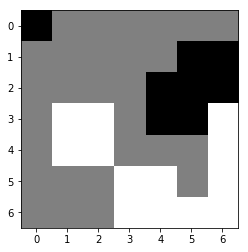

((3, 4), (5, 5)): n_v:  1210 q_all:+0.020957 q:+0.101629 q_m:+0.233333 p:0.672306
((3, 4), (5, 2)): n_v:   832 q_all:+0.102534 q:+0.025607 q_m:+0.100000 p:0.040278
((3, 5), (5, 5)): n_v:   712 q_all:+0.074367 q:+0.077597 q_m:+0.233333 p:0.159141
((3, 4), (4, 5)): n_v:    28 q_all:+0.030568 q:+0.017305 q_m:+0.133333 p:0.014317
((3, 4), (4, 3)): n_v:    15 q_all:+0.061869 q:+0.029249 q_m:+0.133333 p:0.004455
((3, 4), (4, 4)): n_v:    15 q_all:-0.001905 q:-0.098689 q_m:-0.000000 p:0.010856
((0, 0), (1, 1)): n_v:    13 q_all:+0.029631 q:-0.084785 q_m:-0.133333 p:0.006783
((3, 4), (2, 2)): n_v:    13 q_all:-0.021056 q:-0.051256 q_m:-0.033333 p:0.010394
((2, 4), (4, 5)): n_v:    10 q_all:+0.004286 q:-0.008522 q_m:+0.100000 p:0.006356
((2, 4), (3, 3)): n_v:     5 q_all:-0.043999 q:-0.003439 q_m:-0.000000 p:0.005553
((2, 4), (2, 2)): n_v:     5 q_all:-0.014211 q:-0.035370 q_m:-0.033333 p:0.003778
((3, 4), (1, 2)): n_v:     5 q_all:-0.106179 q:-0.116409 q_m:-0.166667 p:0.007364
((2, 5), (4, 5))

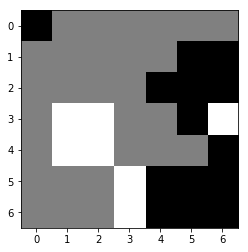

((5, 3), (4, 5)): n_v:  1905 q_all:+0.001380 q:+0.014683 q_m:+0.100000 p:0.387235
((6, 3), (4, 5)): n_v:   754 q_all:-0.018106 q:+0.013449 q_m:+0.100000 p:0.239535
((3, 6), (4, 5)): n_v:   289 q_all:-0.020640 q:+0.011626 q_m:+0.133333 p:0.096436
((3, 2), (1, 4)): n_v:    71 q_all:-0.021479 q:-0.051071 q_m:-0.033333 p:0.024193
((4, 2), (3, 4)): n_v:    36 q_all:-0.090428 q:-0.098369 q_m:-0.033333 p:0.027023
((5, 3), (6, 1)): n_v:    35 q_all:-0.156503 q:-0.142989 q_m:-0.233333 p:0.040214
((3, 2), (3, 4)): n_v:    18 q_all:-0.095304 q:-0.092484 q_m:-0.033333 p:0.014277
((4, 2), (4, 4)): n_v:    12 q_all:-0.190803 q:-0.154884 q_m:-0.033333 p:0.016440
((5, 3), (3, 4)): n_v:    10 q_all:-0.086219 q:-0.084308 q_m:-0.033333 p:0.007544
((3, 2), (4, 4)): n_v:     8 q_all:-0.196603 q:-0.144932 q_m:-0.033333 p:0.011029
((3, 6), (1, 4)): n_v:     8 q_all:-0.025667 q:+0.008540 q_m:-0.033333 p:0.003044
((3, 1), (3, 3)): n_v:     8 q_all:-0.149876 q:-0.108004 q_m:-0.166667 p:0.009299
((4, 2), (6, 1))

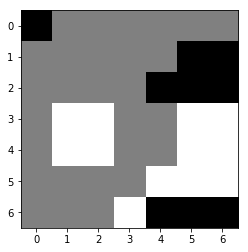

((2, 4), (4, 4)): n_v:  1926 q_all:+0.036982 q:+0.028273 q_m:+0.166667 p:0.367816
((2, 5), (4, 4)): n_v:   413 q_all:-0.015074 q:-0.012857 q_m:+0.166667 p:0.193860
((2, 6), (4, 4)): n_v:   284 q_all:-0.013269 q:-0.018008 q_m:+0.166667 p:0.130768
((6, 4), (5, 3)): n_v:   213 q_all:+0.040411 q:+0.094144 q_m:+0.133333 p:0.036768
((2, 4), (3, 3)): n_v:   174 q_all:+0.057140 q:+0.063941 q_m:+0.066667 p:0.014500
((6, 6), (4, 4)): n_v:   133 q_all:-0.040191 q:-0.019645 q_m:+0.166667 p:0.080237
((6, 4), (4, 3)): n_v:   129 q_all:+0.069775 q:+0.066490 q_m:+0.100000 p:0.002044
((2, 4), (2, 2)): n_v:    89 q_all:+0.002441 q:+0.011693 q_m:+0.033333 p:0.033624
((2, 4), (3, 4)): n_v:    52 q_all:-0.000902 q:+0.017847 q_m:+0.066667 p:0.020467
((2, 4), (4, 3)): n_v:    45 q_all:+0.004193 q:+0.051259 q_m:+0.100000 p:0.016398
((6, 4), (4, 4)): n_v:    41 q_all:-0.023152 q:-0.007654 q_m:+0.166667 p:0.021210
((2, 4), (2, 3)): n_v:    31 q_all:+0.044359 q:+0.027562 q_m:-0.000000 p:0.004615
((0, 0), (2, 2))

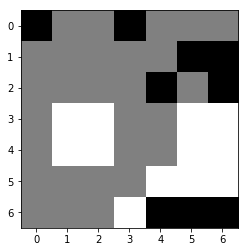

((3, 5), (2, 5)): n_v:  1842 q_all:+0.210493 q:+0.257733 q_m:+0.400000 p:0.294765
((3, 1), (2, 1)): n_v:   125 q_all:+0.071446 q:-0.000246 q_m:+0.133333 p:0.150421
((4, 6), (2, 5)): n_v:    15 q_all:+0.068344 q:+0.174941 q_m:+0.366667 p:0.019191
((3, 1), (5, 0)): n_v:     3 q_all:+0.002831 q:-0.015644 q_m:+0.100000 p:0.005999
((3, 1), (1, 1)): n_v:     2 q_all:+0.070136 q:+0.022409 q_m:+0.166667 p:0.002493
((4, 2), (5, 3)): n_v:     2 q_all:+0.074178 q:+0.098232 q_m:+0.200000 p:0.002332
((3, 2), (1, 0)): n_v:     2 q_all:+0.079430 q:+0.009282 q_m:+0.166667 p:0.002905
((3, 1), (1, 3)): n_v:     1 q_all:+0.033182 q:+0.058942 q_m:+0.233333 p:0.001376
((3, 1), (1, 0)): n_v:     1 q_all:+0.060608 q:+0.013861 q_m:+0.166667 p:0.002297
((3, 5), (5, 3)): n_v:     1 q_all:+0.066090 q:+0.077786 q_m:+0.166667 p:0.001999
((3, 6), (1, 4)): n_v:     1 q_all:+0.101165 q:+0.090758 q_m:+0.300000 p:0.001122
((4, 2), (2, 1)): n_v:     1 q_all:+0.020992 q:-0.028266 q_m:+0.100000 p:0.002703
((3, 5), (1, 3))

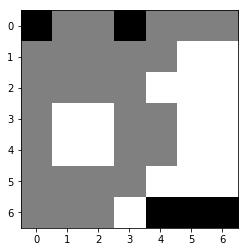

((0, 3), (1, 4)): n_v:  2442 q_all:-0.122898 q:-0.167094 q_m:-0.166667 p:0.115019
((6, 4), (4, 4)): n_v:   325 q_all:-0.208184 q:-0.184674 q_m:-0.133333 p:0.164750
((0, 3), (2, 2)): n_v:   292 q_all:-0.282553 q:-0.224452 q_m:-0.266667 p:0.264927
((6, 4), (5, 3)): n_v:   167 q_all:-0.199827 q:-0.127481 q_m:-0.166667 p:0.077241
((6, 5), (4, 4)): n_v:   149 q_all:-0.212639 q:-0.207501 q_m:-0.133333 p:0.078978
((6, 4), (4, 3)): n_v:   105 q_all:-0.153752 q:-0.159407 q_m:-0.200000 p:0.011017
((0, 3), (1, 2)): n_v:    92 q_all:-0.333519 q:-0.296186 q_m:-0.366667 p:0.108926
((6, 6), (4, 4)): n_v:    87 q_all:-0.219369 q:-0.185015 q_m:-0.133333 p:0.049469
((6, 5), (4, 3)): n_v:    45 q_all:-0.185310 q:-0.193232 q_m:-0.200000 p:0.015289
((6, 4), (5, 2)): n_v:    36 q_all:-0.189577 q:-0.157303 q_m:-0.200000 p:0.014667
((0, 0), (2, 2)): n_v:    33 q_all:-0.284731 q:-0.220744 q_m:-0.266667 p:0.031061
((6, 5), (5, 3)): n_v:    31 q_all:-0.208002 q:-0.166654 q_m:-0.200000 p:0.015496
((0, 3), (1, 3))

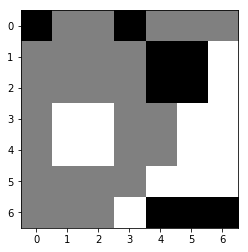

((3, 5), (3, 4)): n_v:  1201 q_all:+0.167945 q:+0.166750 q_m:+0.333333 p:0.020331
((3, 2), (1, 3)): n_v:   750 q_all:+0.151716 q:+0.162599 q_m:+0.366667 p:0.075857
((4, 2), (5, 3)): n_v:   452 q_all:+0.132153 q:+0.190541 q_m:+0.266667 p:0.091840
((5, 4), (3, 4)): n_v:   360 q_all:+0.175575 q:+0.168390 q_m:+0.300000 p:0.001804
((3, 1), (1, 3)): n_v:   325 q_all:+0.118158 q:+0.119932 q_m:+0.366667 p:0.090039
((3, 2), (5, 3)): n_v:   262 q_all:+0.114902 q:+0.174183 q_m:+0.233333 p:0.076833
((1, 6), (0, 5)): n_v:   182 q_all:+0.135386 q:+0.153120 q_m:+0.333333 p:0.034119
((3, 1), (5, 3)): n_v:   173 q_all:+0.095231 q:+0.132505 q_m:+0.233333 p:0.068325
((4, 2), (3, 4)): n_v:   152 q_all:+0.133805 q:+0.148594 q_m:+0.300000 p:0.029690
((3, 5), (1, 3)): n_v:    81 q_all:+0.071470 q:+0.141232 q_m:+0.366667 p:0.042239
((4, 1), (5, 3)): n_v:    77 q_all:+0.104840 q:+0.160006 q_m:+0.233333 p:0.026751
((3, 5), (5, 3)): n_v:    52 q_all:+0.095391 q:+0.157143 q_m:+0.233333 p:0.020740
((3, 2), (3, 4))

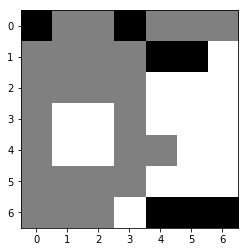

((1, 5), (3, 3)): n_v:  1679 q_all:-0.054729 q:-0.046836 q_m:-0.066667 p:0.003058
((6, 6), (4, 4)): n_v:   583 q_all:-0.164966 q:-0.120303 q_m:-0.000000 p:0.379689
((6, 4), (4, 4)): n_v:   327 q_all:-0.164843 q:-0.107573 q_m:-0.000000 p:0.212700
((6, 5), (4, 4)): n_v:   106 q_all:-0.218053 q:-0.141156 q_m:-0.000000 p:0.101948
((0, 0), (2, 2)): n_v:    93 q_all:-0.181349 q:-0.197511 q_m:-0.200000 p:0.069952
((1, 4), (2, 2)): n_v:    88 q_all:-0.148220 q:-0.142919 q_m:-0.200000 p:0.049088
((0, 3), (2, 2)): n_v:    85 q_all:-0.169170 q:-0.190940 q_m:-0.200000 p:0.058074
((1, 4), (2, 3)): n_v:    81 q_all:-0.148153 q:-0.096997 q_m:-0.100000 p:0.045103
((6, 4), (5, 3)): n_v:    50 q_all:-0.118661 q:-0.107833 q_m:-0.100000 p:0.019009
((1, 4), (3, 3)): n_v:    26 q_all:-0.115034 q:-0.061160 q_m:-0.066667 p:0.008796
((6, 4), (4, 3)): n_v:    20 q_all:-0.106782 q:-0.119365 q_m:-0.066667 p:0.005036
((0, 3), (1, 3)): n_v:    11 q_all:-0.175069 q:-0.205651 q_m:-0.233333 p:0.007915
((0, 3), (2, 3))

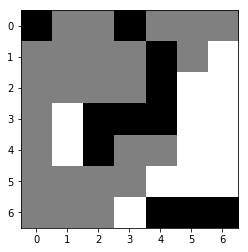

((5, 4), (4, 3)): n_v:  1218 q_all:+0.094013 q:+0.081979 q_m:+0.366667 p:0.047284
((1, 6), (1, 5)): n_v:  1191 q_all:+0.073934 q:+0.105040 q_m:+0.233333 p:0.185609
((5, 4), (5, 3)): n_v:   617 q_all:+0.097657 q:+0.098840 q_m:+0.233333 p:0.024610
((4, 1), (4, 3)): n_v:   130 q_all:+0.078835 q:+0.043946 q_m:+0.333333 p:0.016573
((4, 1), (5, 3)): n_v:    57 q_all:+0.072079 q:+0.083184 q_m:+0.200000 p:0.009604
((6, 3), (5, 1)): n_v:    43 q_all:-0.014210 q:-0.017381 q_m:+0.133333 p:0.028264
((3, 1), (5, 3)): n_v:    42 q_all:+0.090572 q:+0.062212 q_m:+0.200000 p:0.002117
((3, 6), (1, 5)): n_v:    41 q_all:-0.033491 q:+0.036407 q_m:+0.200000 p:0.031415
((4, 1), (5, 1)): n_v:    35 q_all:+0.020084 q:+0.011859 q_m:+0.166667 p:0.016662
((6, 3), (4, 3)): n_v:    31 q_all:+0.046151 q:+0.067243 q_m:+0.333333 p:0.010216
((3, 5), (2, 3)): n_v:    28 q_all:+0.059381 q:+0.072039 q_m:+0.400000 p:0.007059
((3, 1), (2, 3)): n_v:    27 q_all:+0.049574 q:+0.075825 q_m:+0.400000 p:0.008440
((2, 5), (2, 3))

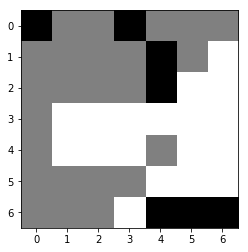

((1, 4), (1, 5)): n_v:  1928 q_all:+0.023843 q:+0.004898 q_m:-0.133333 p:0.032363
((6, 6), (4, 4)): n_v:   588 q_all:-0.090739 q:-0.052173 q_m:+0.100000 p:0.394449
((2, 4), (4, 4)): n_v:   508 q_all:-0.083547 q:+0.014421 q_m:+0.100000 p:0.320008
((1, 4), (2, 2)): n_v:    89 q_all:-0.105677 q:-0.090218 q_m:-0.166667 p:0.067458
((0, 3), (1, 5)): n_v:    84 q_all:-0.022352 q:-0.006563 q_m:-0.166667 p:0.010108
((6, 4), (4, 4)): n_v:    65 q_all:-0.063658 q:-0.018788 q_m:+0.100000 p:0.033678
((6, 5), (4, 4)): n_v:    48 q_all:-0.083503 q:-0.090842 q_m:+0.100000 p:0.030777
((2, 4), (2, 2)): n_v:    44 q_all:-0.083405 q:-0.079529 q_m:-0.166667 p:0.028217
((0, 3), (2, 2)): n_v:    17 q_all:-0.224818 q:-0.121319 q_m:-0.166667 p:0.025582
((6, 4), (5, 3)): n_v:    14 q_all:-0.031054 q:-0.088952 q_m:-0.066667 p:0.003109
((0, 0), (2, 2)): n_v:     6 q_all:-0.212621 q:-0.108534 q_m:-0.166667 p:0.009039
((0, 0), (1, 1)): n_v:     5 q_all:-0.188391 q:-0.163763 q_m:-0.333333 p:0.006744
((0, 3), (1, 1))

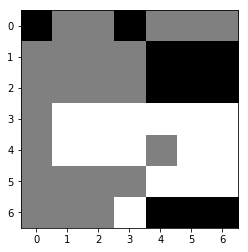

((3, 3), (1, 3)): n_v:  1815 q_all:+0.045972 q:+0.060133 q_m:+0.333333 p:0.044618
((3, 4), (1, 3)): n_v:   383 q_all:+0.010520 q:+0.083967 q_m:+0.333333 p:0.070946
((3, 2), (1, 3)): n_v:   298 q_all:-0.007912 q:+0.028974 q_m:+0.333333 p:0.092327
((3, 4), (5, 3)): n_v:   283 q_all:-0.007990 q:+0.078911 q_m:+0.200000 p:0.088339
((3, 2), (5, 3)): n_v:   197 q_all:-0.071705 q:-0.023188 q_m:+0.200000 p:0.128119
((3, 3), (5, 3)): n_v:   157 q_all:-0.012663 q:+0.038059 q_m:+0.200000 p:0.052830
((4, 1), (5, 3)): n_v:    84 q_all:-0.052098 q:+0.012766 q_m:+0.200000 p:0.046074
((4, 2), (5, 3)): n_v:    72 q_all:-0.043461 q:+0.030801 q_m:+0.233333 p:0.036234
((3, 1), (1, 3)): n_v:    71 q_all:-0.008339 q:+0.006506 q_m:+0.333333 p:0.022176
((3, 5), (5, 3)): n_v:    63 q_all:-0.012420 q:+0.033525 q_m:+0.200000 p:0.021033
((3, 1), (5, 3)): n_v:    52 q_all:-0.082976 q:-0.030850 q_m:+0.200000 p:0.036661
((3, 5), (1, 3)): n_v:    49 q_all:-0.032813 q:+0.024385 q_m:+0.333333 p:0.021565
((3, 2), (4, 4))

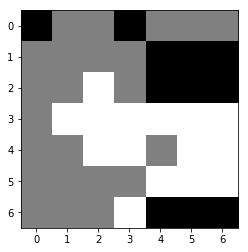

((6, 6), (4, 4)): n_v:   642 q_all:+0.111952 q:+0.103111 q_m:+0.333333 p:0.298798
((6, 4), (4, 4)): n_v:   413 q_all:+0.140074 q:+0.132862 q_m:+0.333333 p:0.105674
((1, 4), (2, 3)): n_v:   343 q_all:+0.126952 q:+0.108512 q_m:+0.166667 p:0.120964
((0, 3), (2, 3)): n_v:   156 q_all:+0.137974 q:+0.105149 q_m:+0.133333 p:0.042122
((6, 5), (4, 4)): n_v:   135 q_all:+0.115539 q:+0.060722 q_m:+0.333333 p:0.058977
((2, 4), (4, 4)): n_v:   104 q_all:+0.089235 q:+0.109097 q_m:+0.333333 p:0.066416
((2, 6), (4, 4)): n_v:    98 q_all:+0.089128 q:+0.110317 q_m:+0.333333 p:0.062195
((2, 5), (4, 4)): n_v:    59 q_all:+0.046506 q:+0.077379 q_m:+0.333333 p:0.056635
((1, 5), (2, 3)): n_v:    13 q_all:+0.079346 q:+0.055795 q_m:+0.133333 p:0.009134
((6, 4), (5, 3)): n_v:    10 q_all:+0.094482 q:+0.101365 q_m:+0.166667 p:0.006527
((0, 0), (2, 1)): n_v:     9 q_all:+0.073510 q:+0.079997 q_m:+0.066667 p:0.007221
((0, 3), (2, 1)): n_v:     6 q_all:+0.058640 q:+0.090555 q_m:+0.066667 p:0.005729
((0, 3), (1, 3))

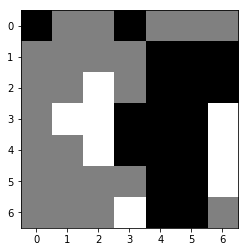

((4, 2), (5, 3)): n_v:  2121 q_all:-0.001106 q:-0.027819 q_m:-0.033333 p:0.252680
((3, 2), (5, 3)): n_v:   266 q_all:-0.043658 q:-0.069186 q_m:-0.066667 p:0.102326
((2, 2), (0, 4)): n_v:   119 q_all:-0.127005 q:-0.160198 q_m:-0.133333 p:0.108231
((3, 1), (5, 3)): n_v:   101 q_all:-0.055588 q:-0.069047 q_m:-0.066667 p:0.046246
((5, 6), (6, 6)): n_v:    78 q_all:-0.055929 q:-0.052080 q_m:-0.166667 p:0.033307
((2, 2), (1, 3)): n_v:    68 q_all:-0.194499 q:-0.139055 q_m:-0.100000 p:0.090298
((3, 2), (1, 3)): n_v:    50 q_all:-0.149138 q:-0.126662 q_m:-0.133333 p:0.053224
((4, 2), (6, 0)): n_v:    18 q_all:-0.231061 q:-0.214783 q_m:-0.333333 p:0.028640
((3, 1), (1, 3)): n_v:     9 q_all:-0.271305 q:-0.156989 q_m:-0.133333 p:0.017647
((2, 2), (2, 3)): n_v:     7 q_all:-0.121009 q:-0.103678 q_m:-0.033333 p:0.006495
((3, 1), (2, 3)): n_v:     3 q_all:-0.140595 q:-0.137526 q_m:-0.066667 p:0.003750
((4, 6), (6, 6)): n_v:     1 q_all:-0.250611 q:-0.209881 q_m:-0.200000 p:0.002712
((4, 2), (2, 3))

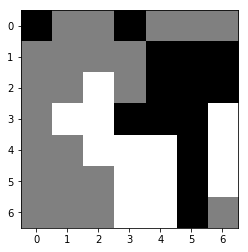

((5, 5), (6, 6)): n_v:  2262 q_all:+0.123511 q:+0.089563 q_m:+0.133333 p:0.013642
((3, 3), (5, 2)): n_v:  1231 q_all:+0.021600 q:+0.134342 q_m:+0.300000 p:0.288836
((3, 3), (1, 2)): n_v:   222 q_all:-0.056884 q:+0.031072 q_m:+0.100000 p:0.178714
((3, 3), (2, 1)): n_v:   203 q_all:+0.018414 q:+0.110730 q_m:+0.233333 p:0.052206
((3, 3), (4, 1)): n_v:   101 q_all:+0.003572 q:+0.080377 q_m:+0.233333 p:0.036492
((1, 4), (2, 3)): n_v:    57 q_all:-0.034300 q:+0.079924 q_m:+0.200000 p:0.036459
((0, 3), (1, 2)): n_v:    51 q_all:-0.091488 q:-0.004854 q_m:+0.133333 p:0.053334
((0, 3), (2, 1)): n_v:    41 q_all:-0.007765 q:+0.090181 q_m:+0.233333 p:0.018287
((3, 4), (5, 2)): n_v:    36 q_all:-0.018525 q:+0.044883 q_m:+0.300000 p:0.019245
((0, 0), (2, 1)): n_v:    27 q_all:-0.028028 q:+0.072012 q_m:+0.233333 p:0.015535
((0, 0), (1, 2)): n_v:    19 q_all:-0.106014 q:-0.012164 q_m:+0.100000 p:0.022763
((4, 5), (2, 3)): n_v:    16 q_all:+0.038877 q:+0.012652 q_m:+0.166667 p:0.001680
((3, 3), (5, 1))

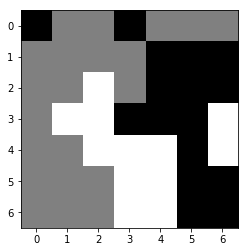

((2, 2), (2, 3)): n_v:  3871 q_all:-0.073131 q:-0.002537 q_m:+0.166667 p:0.381049
((3, 1), (2, 3)): n_v:   190 q_all:-0.132488 q:-0.033483 q_m:+0.133333 p:0.066267
((2, 2), (0, 4)): n_v:    98 q_all:-0.119616 q:-0.094486 q_m:+0.066667 p:0.026280
((4, 2), (2, 3)): n_v:    63 q_all:-0.125055 q:-0.048712 q_m:+0.133333 p:0.019061
((4, 4), (5, 2)): n_v:    37 q_all:-0.253343 q:-0.205678 q_m:-0.133333 p:0.036927
((2, 2), (0, 1)): n_v:    26 q_all:-0.144041 q:-0.075705 q_m:-0.066667 p:0.011529
((4, 4), (2, 3)): n_v:    21 q_all:-0.194703 q:-0.084390 q_m:+0.133333 p:0.014880
((4, 4), (6, 2)): n_v:    17 q_all:-0.215333 q:-0.211703 q_m:-0.133333 p:0.014389
((3, 2), (1, 3)): n_v:    16 q_all:-0.146495 q:-0.092672 q_m:+0.066667 p:0.007343
((6, 3), (6, 1)): n_v:    12 q_all:-0.219757 q:-0.155151 q_m:-0.133333 p:0.010482
((4, 2), (6, 1)): n_v:    10 q_all:-0.200451 q:-0.171146 q_m:-0.133333 p:0.008000
((4, 3), (2, 3)): n_v:    10 q_all:-0.151681 q:-0.137900 q_m:+0.133333 p:0.005100
((4, 2), (6, 0))

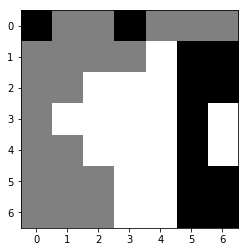

((0, 3), (1, 3)): n_v:  5818 q_all:+0.094031 q:+0.117718 q_m:+0.133333 p:0.901621
((0, 0), (2, 1)): n_v:    76 q_all:+0.059822 q:+0.043737 q_m:+0.033333 p:0.022875
((0, 3), (2, 1)): n_v:    43 q_all:+0.051092 q:+0.058203 q_m:+0.033333 p:0.014809
((1, 5), (1, 3)): n_v:    38 q_all:+0.001366 q:+0.032456 q_m:+0.100000 p:0.020422
((0, 3), (1, 2)): n_v:    31 q_all:-0.020510 q:+0.015233 q_m:-0.000000 p:0.020202
((3, 5), (1, 3)): n_v:     8 q_all:-0.071379 q:-0.018216 q_m:+0.100000 p:0.007290
((0, 3), (1, 1)): n_v:     5 q_all:-0.015409 q:+0.024182 q_m:-0.100000 p:0.003358
((0, 0), (1, 1)): n_v:     3 q_all:-0.006522 q:+0.018435 q_m:-0.066667 p:0.001986
((2, 5), (1, 3)): n_v:     2 q_all:-0.100760 q:-0.009155 q_m:+0.100000 p:0.002350
((1, 5), (0, 5)): n_v:     1 q_all:-0.035934 q:-0.022997 q_m:-0.066667 p:0.000753
((1, 6), (0, 4)): n_v:     0 q_all:-0.049590 q:-0.049590 q_m:-0.100000 p:0.000046
((0, 0), (0, 2)): n_v:     0 q_all:-0.027438 q:-0.027438 q_m:-0.166667 p:0.000042
((0, 0), (0, 1))

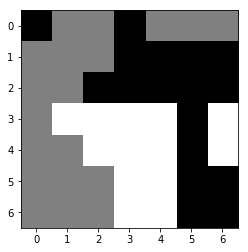

((3, 1), (1, 2)): n_v:  5350 q_all:-0.073737 q:-0.009257 q_m:+0.133333 p:0.384549
((3, 1), (5, 2)): n_v:   437 q_all:-0.231060 q:-0.235325 q_m:-0.133333 p:0.287426
((3, 2), (1, 2)): n_v:   321 q_all:-0.105581 q:-0.058558 q_m:+0.133333 p:0.061309
((3, 4), (1, 2)): n_v:    66 q_all:-0.125175 q:-0.072530 q_m:+0.133333 p:0.017231
((3, 3), (1, 2)): n_v:    54 q_all:-0.174357 q:-0.095082 q_m:+0.133333 p:0.024319
((3, 2), (5, 2)): n_v:    43 q_all:-0.265976 q:-0.233686 q_m:-0.133333 p:0.034041
((4, 2), (5, 2)): n_v:    32 q_all:-0.219461 q:-0.205902 q_m:-0.100000 p:0.019987
((3, 3), (5, 2)): n_v:    15 q_all:-0.313475 q:-0.255366 q_m:-0.133333 p:0.015061
((3, 4), (5, 2)): n_v:    15 q_all:-0.246072 q:-0.263533 q_m:-0.133333 p:0.011291
((6, 4), (5, 2)): n_v:    11 q_all:-0.282274 q:-0.270429 q_m:-0.133333 p:0.010057
((3, 1), (1, 1)): n_v:    10 q_all:-0.127766 q:-0.099242 q_m:-0.000000 p:0.002933
((3, 1), (2, 1)): n_v:     6 q_all:-0.174453 q:-0.172837 q_m:-0.033333 p:0.002545
((3, 1), (1, 0))

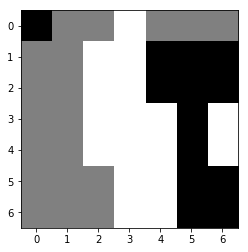

((0, 0), (0, 2)): n_v:  3018 q_all:+0.106451 q:+0.111568 q_m:+0.066667 p:0.455565
((1, 4), (0, 4)): n_v:  2765 q_all:+0.145930 q:+0.111415 q_m:+0.033333 p:0.124331
((1, 6), (0, 4)): n_v:    72 q_all:+0.018815 q:+0.028615 q_m:-0.000000 p:0.038705
((0, 0), (1, 1)): n_v:    59 q_all:+0.063345 q:+0.079683 q_m:+0.033333 p:0.020503
((0, 0), (2, 1)): n_v:    28 q_all:+0.071413 q:+0.091718 q_m:+0.066667 p:0.008809
((2, 6), (0, 4)): n_v:    13 q_all:-0.029459 q:+0.005009 q_m:-0.000000 p:0.009467
((2, 5), (0, 4)): n_v:     6 q_all:-0.115935 q:-0.058661 q_m:-0.000000 p:0.006095
((0, 0), (0, 1)): n_v:     1 q_all:+0.022772 q:+0.066532 q_m:-0.033333 p:0.000407
((2, 4), (0, 6)): n_v:     0 q_all:-0.127545 q:-0.127545 q_m:-0.133333 p:0.000005
((2, 4), (0, 5)): n_v:     0 q_all:-0.108069 q:-0.108069 q_m:-0.133333 p:0.000003
((2, 4), (0, 4)): n_v:     0 q_all:-0.048020 q:-0.048020 q_m:-0.000000 p:0.000143
((2, 5), (0, 6)): n_v:     0 q_all:-0.175704 q:-0.175704 q_m:-0.133333 p:0.000001
((1, 4), (0, 5))

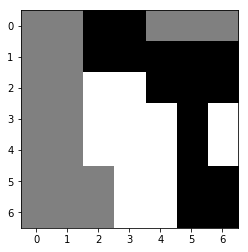

((2, 2), (1, 1)): n_v:  2317 q_all:-0.061475 q:-0.064518 q_m:+0.100000 p:0.263605
((4, 2), (5, 1)): n_v:   489 q_all:-0.141616 q:-0.157570 q_m:-0.033333 p:0.240356
((2, 2), (0, 4)): n_v:   278 q_all:-0.113599 q:-0.095734 q_m:+0.200000 p:0.099718
((6, 3), (5, 1)): n_v:   149 q_all:-0.170002 q:-0.181520 q_m:-0.066667 p:0.093555
((2, 2), (0, 1)): n_v:   103 q_all:-0.100431 q:-0.070550 q_m:+0.066667 p:0.030180
((3, 2), (1, 1)): n_v:    55 q_all:-0.077575 q:-0.127082 q_m:+0.066667 p:0.010228
((4, 2), (6, 2)): n_v:    50 q_all:-0.183442 q:-0.195567 q_m:-0.066667 p:0.034906
((5, 3), (6, 2)): n_v:    45 q_all:-0.160104 q:-0.172421 q_m:-0.033333 p:0.026524
((2, 3), (0, 5)): n_v:    27 q_all:-0.081993 q:-0.093275 q_m:+0.133333 p:0.005764
((4, 2), (5, 2)): n_v:    25 q_all:-0.113889 q:-0.137995 q_m:-0.033333 p:0.009235
((5, 3), (5, 1)): n_v:    17 q_all:-0.252896 q:-0.254085 q_m:-0.066667 p:0.017781
((3, 2), (5, 1)): n_v:    15 q_all:-0.205417 q:-0.201299 q_m:-0.066667 p:0.012298
((4, 2), (6, 1))

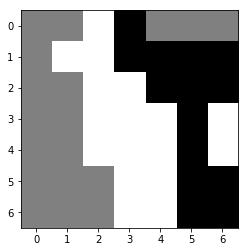

((0, 3), (0, 1)): n_v:  1759 q_all:+0.131890 q:+0.094102 q_m:+0.100000 p:0.034240
((0, 3), (2, 1)): n_v:  1244 q_all:+0.079555 q:+0.103028 q_m:+0.166667 p:0.347265
((0, 3), (0, 4)): n_v:   181 q_all:+0.081780 q:+0.079414 q_m:-0.066667 p:0.048395
((1, 5), (0, 6)): n_v:   173 q_all:+0.105670 q:+0.046993 q_m:-0.066667 p:0.025884
((1, 3), (3, 1)): n_v:    70 q_all:+0.072037 q:+0.066585 q_m:+0.100000 p:0.022129
((0, 3), (0, 5)): n_v:    60 q_all:-0.056411 q:-0.018840 q_m:-0.100000 p:0.057937
((1, 3), (2, 1)): n_v:    56 q_all:+0.039458 q:+0.056100 q_m:+0.166667 p:0.025950
((1, 4), (0, 5)): n_v:    55 q_all:-0.133252 q:-0.021474 q_m:-0.066667 p:0.074179
((1, 3), (0, 5)): n_v:    36 q_all:-0.043113 q:-0.059513 q_m:-0.100000 p:0.031915
((1, 3), (0, 1)): n_v:    22 q_all:-0.032385 q:+0.023955 q_m:+0.100000 p:0.018878
((1, 6), (0, 4)): n_v:    19 q_all:+0.015717 q:-0.025200 q_m:-0.100000 p:0.011778
((2, 6), (0, 5)): n_v:     6 q_all:-0.214160 q:-0.081862 q_m:-0.100000 p:0.010883
((2, 6), (0, 4))

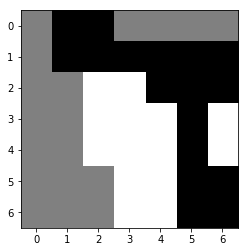

((2, 2), (0, 3)): n_v:  2468 q_all:-0.144892 q:-0.074916 q_m:+0.166667 p:0.522979
((2, 2), (2, 1)): n_v:   845 q_all:-0.121729 q:-0.124168 q_m:+0.066667 p:0.075326
((4, 2), (2, 1)): n_v:   191 q_all:-0.107527 q:-0.140167 q_m:+0.033333 p:0.002493
((3, 2), (4, 1)): n_v:    98 q_all:-0.227221 q:-0.211499 q_m:-0.066667 p:0.063696
((4, 2), (5, 2)): n_v:    61 q_all:-0.145119 q:-0.146326 q_m:-0.066667 p:0.013202
((2, 2), (0, 4)): n_v:    51 q_all:-0.147828 q:-0.157252 q_m:+0.100000 p:0.011141
((2, 3), (0, 5)): n_v:    44 q_all:-0.128699 q:-0.080697 q_m:+0.100000 p:0.005661
((2, 2), (1, 0)): n_v:    33 q_all:-0.203870 q:-0.125916 q_m:+0.033333 p:0.017270
((4, 2), (6, 1)): n_v:    29 q_all:-0.194962 q:-0.190702 q_m:-0.100000 p:0.014209
((3, 2), (1, 0)): n_v:    27 q_all:-0.147530 q:-0.174917 q_m:+0.033333 p:0.006196
((2, 3), (0, 3)): n_v:    19 q_all:-0.230273 q:-0.110651 q_m:+0.166667 p:0.012743
((4, 2), (5, 0)): n_v:    16 q_all:-0.206678 q:-0.199274 q_m:-0.100000 p:0.008736
((4, 2), (5, 1))

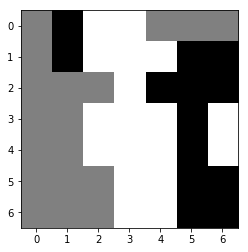

((1, 1), (2, 2)): n_v:  4175 q_all:+0.136407 q:+0.133301 q_m:+0.200000 p:0.915241
((0, 1), (2, 2)): n_v:   303 q_all:+0.154328 q:+0.097468 q_m:+0.166667 p:0.039969
((1, 5), (0, 4)): n_v:    90 q_all:+0.086337 q:+0.137684 q_m:+0.066667 p:0.041413
((1, 6), (0, 4)): n_v:     1 q_all:+0.020611 q:+0.019625 q_m:+0.033333 p:0.001284
((2, 4), (0, 6)): n_v:     0 q_all:-0.152066 q:-0.152066 q_m:-0.166667 p:0.000001
((0, 1), (1, 0)): n_v:     0 q_all:-0.042457 q:-0.042457 q_m:-0.133333 p:0.000010
((1, 1), (3, 0)): n_v:     0 q_all:+0.001404 q:+0.001404 q_m:-0.166667 p:0.000001
((1, 1), (2, 0)): n_v:     0 q_all:-0.026184 q:-0.026184 q_m:-0.133333 p:0.000025
((2, 4), (0, 5)): n_v:     0 q_all:-0.097602 q:-0.097602 q_m:-0.100000 p:0.000003
((1, 1), (3, 1)): n_v:     0 q_all:+0.049501 q:+0.049501 q_m:-0.033333 p:0.000004
((2, 4), (0, 4)): n_v:     0 q_all:-0.033101 q:-0.033101 q_m:+0.033333 p:0.000013
((2, 5), (0, 6)): n_v:     0 q_all:-0.190344 q:-0.190344 q_m:-0.166667 p:0.000000
((0, 1), (2, 1))

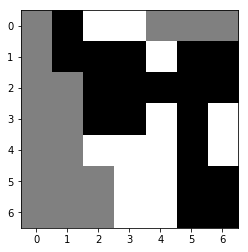

((4, 2), (2, 1)): n_v:  2079 q_all:-0.143104 q:-0.134620 q_m:+0.066667 p:0.322192
((0, 3), (0, 5)): n_v:  1311 q_all:-0.114192 q:-0.184020 q_m:-0.066667 p:0.044671
((1, 4), (0, 6)): n_v:   667 q_all:-0.116342 q:-0.158365 q_m:-0.066667 p:0.028334
((0, 3), (2, 1)): n_v:   311 q_all:-0.180330 q:-0.141070 q_m:+0.066667 p:0.096685
((0, 2), (2, 1)): n_v:   274 q_all:-0.167034 q:-0.137721 q_m:+0.066667 p:0.069703
((1, 4), (0, 5)): n_v:   201 q_all:-0.207425 q:-0.190060 q_m:-0.033333 p:0.085423
((4, 2), (4, 1)): n_v:   195 q_all:-0.267890 q:-0.273408 q_m:-0.100000 p:0.131898
((6, 3), (4, 1)): n_v:    71 q_all:-0.279652 q:-0.277524 q_m:-0.133333 p:0.051583
((4, 3), (2, 1)): n_v:    53 q_all:-0.270170 q:-0.244352 q_m:+0.066667 p:0.036587
((4, 2), (3, 1)): n_v:    44 q_all:-0.229720 q:-0.219365 q_m:-0.033333 p:0.022719
((4, 2), (2, 0)): n_v:    30 q_all:-0.239552 q:-0.232218 q_m:-0.133333 p:0.016508
((0, 2), (1, 0)): n_v:    19 q_all:-0.204905 q:-0.203374 q_m:-0.066667 p:0.007831
((0, 2), (0, 0))

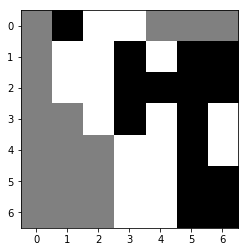

((1, 3), (0, 4)): n_v:  2985 q_all:+0.224911 q:+0.156082 q_m:+0.100000 p:0.151380
((0, 1), (1, 0)): n_v:   405 q_all:+0.077511 q:+0.073867 q_m:+0.100000 p:0.324456
((3, 3), (4, 2)): n_v:   300 q_all:+0.081385 q:+0.050850 q_m:+0.166667 p:0.235426
((3, 3), (5, 2)): n_v:    12 q_all:+0.073773 q:+0.074926 q_m:+0.133333 p:0.010476
((1, 6), (0, 4)): n_v:     9 q_all:+0.045114 q:+0.032937 q_m:+0.066667 p:0.008873
((2, 6), (0, 4)): n_v:     7 q_all:-0.021094 q:+0.005935 q_m:+0.066667 p:0.008901
((1, 5), (0, 5)): n_v:     6 q_all:-0.011295 q:-0.000288 q_m:+0.033333 p:0.008320
((2, 5), (0, 4)): n_v:     3 q_all:-0.093343 q:-0.054961 q_m:+0.066667 p:0.005855
((0, 1), (2, 0)): n_v:     3 q_all:+0.032699 q:+0.032699 q_m:+0.066667 p:0.003975
((1, 3), (3, 1)): n_v:     2 q_all:+0.029552 q:+0.029552 q_m:+0.133333 p:0.003022
((2, 3), (0, 4)): n_v:     1 q_all:-0.010204 q:+0.046940 q_m:+0.066667 p:0.000970
((2, 3), (4, 2)): n_v:     1 q_all:-0.032740 q:-0.032740 q_m:+0.133333 p:0.002357
((2, 3), (3, 1))

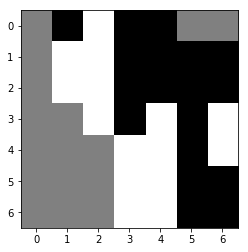

((3, 2), (1, 0)): n_v:  2040 q_all:-0.243795 q:-0.222342 q_m:-0.033333 p:0.108186
((1, 1), (1, 0)): n_v:  1191 q_all:-0.263500 q:-0.228466 q_m:-0.000000 p:0.171983
((1, 1), (0, 0)): n_v:   476 q_all:-0.247376 q:-0.217351 q_m:-0.000000 p:0.032954
((3, 2), (5, 0)): n_v:   234 q_all:-0.287200 q:-0.282223 q_m:-0.100000 p:0.059093
((3, 2), (5, 1)): n_v:   140 q_all:-0.281893 q:-0.287363 q_m:-0.100000 p:0.032169
((2, 1), (0, 0)): n_v:   127 q_all:-0.245594 q:-0.216006 q_m:-0.033333 p:0.007859
((2, 2), (1, 0)): n_v:    98 q_all:-0.275755 q:-0.209830 q_m:-0.033333 p:0.019881
((3, 2), (4, 2)): n_v:    80 q_all:-0.274049 q:-0.284265 q_m:-0.000000 p:0.015468
((0, 2), (1, 0)): n_v:    41 q_all:-0.326997 q:-0.263196 q_m:-0.033333 p:0.018281
((4, 3), (5, 2)): n_v:    31 q_all:-0.357953 q:-0.345621 q_m:-0.066667 p:0.018229
((3, 2), (5, 2)): n_v:    27 q_all:-0.310647 q:-0.311954 q_m:-0.100000 p:0.009582
((3, 2), (4, 1)): n_v:    25 q_all:-0.322303 q:-0.328709 q_m:-0.066667 p:0.010367
((3, 2), (2, 0))

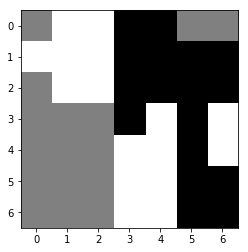

((2, 3), (3, 2)): n_v:  4089 q_all:+0.261685 q:+0.224713 q_m:+0.266667 p:0.513403
((0, 4), (0, 5)): n_v:    17 q_all:+0.179228 q:+0.159642 q_m:+0.066667 p:0.009278
((3, 3), (5, 2)): n_v:    14 q_all:+0.164280 q:+0.192908 q_m:+0.233333 p:0.008586
((3, 3), (4, 2)): n_v:     8 q_all:+0.218665 q:+0.186491 q_m:+0.200000 p:0.003055
((3, 3), (5, 1)): n_v:     2 q_all:+0.106350 q:+0.111564 q_m:+0.033333 p:0.002537
((2, 4), (0, 6)): n_v:     0 q_all:-0.209708 q:-0.209708 q_m:+0.033333 p:0.000058
((1, 3), (3, 2)): n_v:     0 q_all:+0.051719 q:+0.051719 q_m:+0.233333 p:0.000551
((2, 3), (4, 2)): n_v:     0 q_all:+0.089384 q:+0.089384 q_m:+0.166667 p:0.000257
((3, 3), (3, 1)): n_v:     0 q_all:+0.137917 q:+0.137917 q_m:+0.166667 p:0.000308
((2, 6), (0, 5)): n_v:     0 q_all:+0.007871 q:+0.007871 q_m:+0.033333 p:0.000041
((2, 4), (0, 5)): n_v:     0 q_all:-0.156315 q:-0.156315 q_m:+0.033333 p:0.000118
((2, 3), (0, 5)): n_v:     0 q_all:+0.013469 q:+0.013469 q_m:+0.033333 p:0.000162
((2, 3), (3, 1))

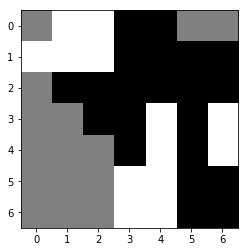

((1, 0), (3, 1)): n_v:  2891 q_all:-0.235996 q:-0.234798 q_m:-0.066667 p:0.182919
((5, 3), (4, 2)): n_v:  2402 q_all:-0.286069 q:-0.262123 q_m:-0.033333 p:0.657809
((1, 1), (3, 1)): n_v:    95 q_all:-0.315611 q:-0.317141 q_m:-0.066667 p:0.038115
((6, 3), (4, 2)): n_v:    59 q_all:-0.296936 q:-0.279987 q_m:-0.066667 p:0.018884
((5, 3), (3, 1)): n_v:    51 q_all:-0.316725 q:-0.267078 q_m:-0.066667 p:0.020247
((1, 0), (2, 0)): n_v:    20 q_all:-0.306326 q:-0.332586 q_m:-0.166667 p:0.007444
((1, 2), (3, 1)): n_v:    20 q_all:-0.349951 q:-0.289054 q_m:-0.066667 p:0.010961
((5, 3), (5, 2)): n_v:    18 q_all:-0.346446 q:-0.356888 q_m:-0.166667 p:0.009347
((3, 4), (4, 2)): n_v:    12 q_all:-0.325635 q:-0.273760 q_m:-0.066667 p:0.005391
((6, 4), (4, 2)): n_v:    10 q_all:-0.368387 q:-0.328586 q_m:-0.066667 p:0.006644
((3, 4), (5, 2)): n_v:     3 q_all:-0.317220 q:-0.288570 q_m:-0.200000 p:0.001556
((6, 3), (5, 1)): n_v:     2 q_all:-0.353900 q:-0.357377 q_m:-0.266667 p:0.001213
((0, 1), (0, 0))

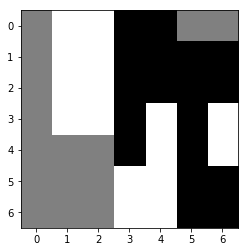

((4, 3), (5, 2)): n_v:  2267 q_all:+0.278360 q:+0.227040 q_m:+0.233333 p:0.027730
((3, 3), (4, 2)): n_v:  2230 q_all:+0.238497 q:+0.253019 q_m:+0.300000 p:0.369792
((0, 4), (0, 5)): n_v:   205 q_all:+0.250197 q:+0.173965 q_m:+0.100000 p:0.019045
((4, 3), (5, 1)): n_v:    36 q_all:+0.161850 q:+0.122317 q_m:+0.066667 p:0.020200
((4, 3), (4, 1)): n_v:    23 q_all:+0.152482 q:+0.159531 q_m:+0.200000 p:0.013940
((4, 3), (6, 1)): n_v:    11 q_all:+0.189990 q:+0.105792 q_m:+0.066667 p:0.005059
((4, 3), (6, 2)): n_v:     5 q_all:+0.165756 q:+0.205540 q_m:+0.200000 p:0.002891
((3, 3), (5, 1)): n_v:     4 q_all:+0.081930 q:+0.096941 q_m:+0.066667 p:0.004322
((2, 3), (4, 2)): n_v:     3 q_all:+0.097655 q:+0.109013 q_m:+0.266667 p:0.003408
((2, 3), (0, 5)): n_v:     3 q_all:+0.020212 q:+0.037661 q_m:+0.066667 p:0.004088
((3, 3), (5, 2)): n_v:     3 q_all:+0.176956 q:+0.170672 q_m:+0.200000 p:0.001725
((3, 3), (4, 1)): n_v:     1 q_all:+0.089056 q:+0.091646 q_m:+0.200000 p:0.001552
((0, 3), (0, 5))

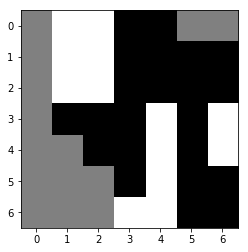

((6, 3), (5, 2)): n_v:  3496 q_all:-0.223099 q:-0.228729 q_m:-0.066667 p:0.931742
((6, 4), (5, 2)): n_v:    33 q_all:-0.329233 q:-0.294476 q_m:-0.100000 p:0.026141
((3, 4), (5, 2)): n_v:    33 q_all:-0.255288 q:-0.221861 q_m:-0.100000 p:0.014182
((6, 3), (4, 1)): n_v:    28 q_all:-0.240829 q:-0.213307 q_m:-0.100000 p:0.010258
((4, 4), (5, 2)): n_v:     5 q_all:-0.359389 q:-0.305752 q_m:-0.100000 p:0.004563
((2, 1), (4, 1)): n_v:     2 q_all:-0.324802 q:-0.323459 q_m:-0.100000 p:0.002255
((2, 2), (4, 1)): n_v:     2 q_all:-0.325657 q:-0.281648 q_m:-0.100000 p:0.002047
((5, 4), (5, 2)): n_v:     2 q_all:-0.398676 q:-0.345328 q_m:-0.100000 p:0.002068
((6, 3), (6, 2)): n_v:     1 q_all:-0.412310 q:-0.362459 q_m:-0.200000 p:0.001387
((6, 3), (6, 1)): n_v:     1 q_all:-0.343860 q:-0.343860 q_m:-0.300000 p:0.001720
((0, 2), (2, 0)): n_v:     0 q_all:-0.384181 q:-0.384181 q_m:-0.233333 p:0.000006
((0, 1), (1, 0)): n_v:     0 q_all:-0.360968 q:-0.360968 q_m:-0.266667 p:0.000414
((1, 1), (3, 0))

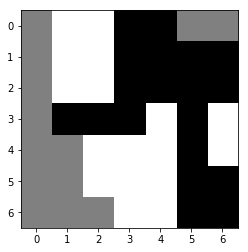

((3, 1), (1, 0)): n_v:  2378 q_all:+0.290704 q:+0.305045 q_m:+0.266667 p:0.062143
((3, 1), (4, 1)): n_v:  1321 q_all:+0.244134 q:+0.277565 q_m:+0.233333 p:0.277895
((3, 1), (5, 1)): n_v:   429 q_all:+0.146752 q:+0.218535 q_m:+0.200000 p:0.284391
((3, 1), (5, 0)): n_v:    88 q_all:+0.180763 q:+0.173946 q_m:+0.066667 p:0.045397
((3, 2), (5, 1)): n_v:    37 q_all:+0.155125 q:+0.171183 q_m:+0.200000 p:0.023464
((3, 2), (1, 0)): n_v:    27 q_all:+0.213321 q:+0.250400 q_m:+0.266667 p:0.009685
((3, 1), (2, 0)): n_v:    18 q_all:+0.168666 q:+0.258361 q_m:+0.233333 p:0.010731
((3, 3), (5, 1)): n_v:    17 q_all:+0.087675 q:+0.113242 q_m:+0.200000 p:0.015352
((0, 4), (0, 5)): n_v:    15 q_all:+0.240483 q:+0.213172 q_m:+0.100000 p:0.003333
((3, 1), (4, 0)): n_v:    14 q_all:+0.127077 q:+0.147928 q_m:+0.100000 p:0.010549
((3, 1), (3, 0)): n_v:    11 q_all:+0.190057 q:+0.178337 q_m:+0.166667 p:0.004939
((3, 2), (5, 0)): n_v:     6 q_all:+0.049154 q:+0.134388 q_m:+0.066667 p:0.007615
((2, 3), (4, 1))

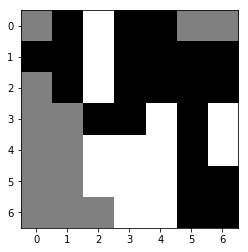

((2, 2), (0, 0)): n_v:  3710 q_all:-0.267533 q:-0.182778 q_m:-0.066667 p:0.335072
((2, 2), (4, 0)): n_v:   196 q_all:-0.385635 q:-0.263892 q_m:-0.266667 p:0.132180
((4, 2), (6, 0)): n_v:   187 q_all:-0.436011 q:-0.418686 q_m:-0.266667 p:0.172988
((0, 2), (2, 0)): n_v:   161 q_all:-0.380046 q:-0.331934 q_m:-0.066667 p:0.104398
((4, 2), (2, 0)): n_v:   133 q_all:-0.367590 q:-0.391355 q_m:-0.066667 p:0.077676
((2, 2), (3, 1)): n_v:    68 q_all:-0.345832 q:-0.357659 q_m:-0.100000 p:0.032668
((2, 2), (2, 0)): n_v:    41 q_all:-0.335555 q:-0.281100 q_m:-0.066667 p:0.017667
((0, 2), (0, 0)): n_v:    25 q_all:-0.354475 q:-0.312050 q_m:-0.066667 p:0.013476
((5, 2), (6, 2)): n_v:    12 q_all:-0.357112 q:-0.362077 q_m:-0.233333 p:0.006620
((4, 2), (4, 0)): n_v:    11 q_all:-0.417971 q:-0.414974 q_m:-0.266667 p:0.009533
((2, 2), (4, 1)): n_v:     8 q_all:-0.402304 q:-0.277604 q_m:-0.200000 p:0.006762
((4, 2), (6, 1)): n_v:     4 q_all:-0.413876 q:-0.417391 q_m:-0.266667 p:0.003889
((5, 2), (6, 1))

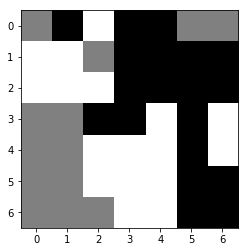

((0, 1), (1, 2)): n_v:  2193 q_all:+0.498188 q:+0.495232 q_m:+0.366667 p:0.368288
((0, 4), (1, 2)): n_v:     7 q_all:+0.413198 q:+0.423749 q_m:+0.333333 p:0.005738
((3, 3), (1, 2)): n_v:     2 q_all:+0.413028 q:+0.296877 q_m:+0.333333 p:0.001997
((3, 2), (1, 2)): n_v:     1 q_all:+0.386648 q:+0.365959 q_m:+0.333333 p:0.001864
((3, 3), (5, 1)): n_v:     0 q_all:+0.104706 q:+0.104706 q_m:+0.200000 p:0.000001
((2, 4), (0, 6)): n_v:     0 q_all:-0.211579 q:-0.211579 q_m:+0.066667 p:0.000000
((3, 2), (4, 1)): n_v:     0 q_all:+0.230898 q:+0.230898 q_m:+0.233333 p:0.000008
((3, 3), (3, 1)): n_v:     0 q_all:+0.131562 q:+0.131562 q_m:+0.333333 p:0.000003
((3, 2), (4, 0)): n_v:     0 q_all:+0.157431 q:+0.157431 q_m:+0.066667 p:0.000004
((2, 6), (0, 5)): n_v:     0 q_all:+0.011542 q:+0.011542 q_m:+0.066667 p:0.000000
((2, 4), (0, 5)): n_v:     0 q_all:-0.142569 q:-0.142569 q_m:+0.066667 p:0.000001
((2, 3), (0, 5)): n_v:     0 q_all:+0.060399 q:+0.060399 q_m:+0.066667 p:0.000001
((3, 2), (3, 1))

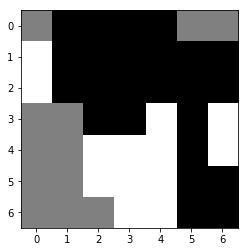

((1, 0), (0, 0)): n_v:  4013 q_all:-0.453958 q:-0.389189 q_m:-0.200000 p:0.844895
((2, 0), (0, 0)): n_v:   252 q_all:-0.446284 q:-0.422576 q_m:-0.233333 p:0.048720
((2, 0), (3, 1)): n_v:    85 q_all:-0.484847 q:-0.425804 q_m:-0.133333 p:0.029000
((1, 0), (3, 1)): n_v:     9 q_all:-0.522589 q:-0.408189 q_m:-0.166667 p:0.005508
((4, 2), (6, 0)): n_v:     7 q_all:-0.586423 q:-0.554237 q_m:-0.366667 p:0.006662
((5, 2), (6, 2)): n_v:     6 q_all:-0.545005 q:-0.484185 q_m:-0.333333 p:0.004043
((5, 2), (6, 1)): n_v:     5 q_all:-0.564919 q:-0.533336 q_m:-0.333333 p:0.003828
((4, 2), (6, 1)): n_v:     2 q_all:-0.580249 q:-0.565864 q_m:-0.366667 p:0.001993
((5, 2), (3, 1)): n_v:     2 q_all:-0.494038 q:-0.462009 q_m:-0.166667 p:0.001130
((4, 2), (6, 2)): n_v:     1 q_all:-0.580103 q:-0.557634 q_m:-0.366667 p:0.000998
((6, 4), (6, 2)): n_v:     1 q_all:-0.599719 q:-0.557246 q_m:-0.366667 p:0.001337
((4, 3), (3, 1)): n_v:     1 q_all:-0.634515 q:-0.603922 q_m:-0.166667 p:0.002114
((2, 0), (4, 0))

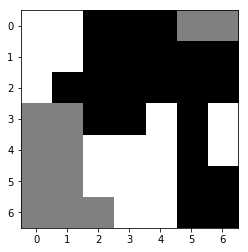

((2, 1), (3, 1)): n_v:  6133 q_all:+0.480127 q:+0.499551 q_m:+0.366667 p:0.304158
((0, 4), (0, 5)): n_v:    35 q_all:+0.389837 q:+0.409194 q_m:+0.233333 p:0.015145
((3, 2), (4, 1)): n_v:    13 q_all:+0.372785 q:+0.417824 q_m:+0.366667 p:0.006335
((2, 1), (3, 0)): n_v:    11 q_all:+0.364040 q:+0.414601 q_m:+0.300000 p:0.006292
((2, 1), (4, 1)): n_v:     7 q_all:+0.378015 q:+0.379694 q_m:+0.333333 p:0.003676
((1, 5), (0, 6)): n_v:     4 q_all:+0.348797 q:+0.343045 q_m:+0.233333 p:0.002828
((3, 2), (5, 1)): n_v:     4 q_all:+0.319314 q:+0.331292 q_m:+0.333333 p:0.003376
((3, 2), (4, 0)): n_v:     2 q_all:+0.249243 q:+0.282581 q_m:+0.200000 p:0.002013
((2, 1), (4, 0)): n_v:     2 q_all:+0.317224 q:+0.343869 q_m:+0.200000 p:0.001627
((3, 3), (5, 1)): n_v:     1 q_all:+0.277068 q:+0.228373 q_m:+0.333333 p:0.001184
((2, 4), (0, 6)): n_v:     0 q_all:-0.065821 q:-0.065821 q_m:+0.200000 p:0.000030
((2, 6), (0, 6)): n_v:     0 q_all:+0.097413 q:+0.097413 q_m:+0.200000 p:0.000126
((2, 6), (0, 5))

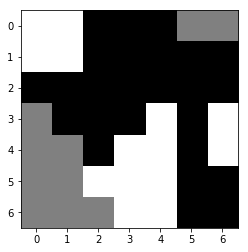

((5, 2), (4, 1)): n_v:  5630 q_all:-0.454233 q:-0.399105 q_m:-0.133333 p:0.716456
((5, 2), (3, 0)): n_v:   205 q_all:-0.459121 q:-0.429291 q_m:-0.166667 p:0.029478
((1, 1), (3, 0)): n_v:   178 q_all:-0.580144 q:-0.534436 q_m:-0.166667 p:0.104425
((1, 0), (3, 0)): n_v:   178 q_all:-0.534996 q:-0.544596 q_m:-0.166667 p:0.075253
((6, 3), (4, 1)): n_v:   170 q_all:-0.476575 q:-0.460225 q_m:-0.166667 p:0.035396
((5, 3), (4, 1)): n_v:    24 q_all:-0.578539 q:-0.634269 q_m:-0.166667 p:0.014378
((4, 3), (4, 1)): n_v:    16 q_all:-0.628151 q:-0.611850 q_m:-0.166667 p:0.012474
((5, 2), (5, 1)): n_v:     8 q_all:-0.528001 q:-0.482926 q_m:-0.266667 p:0.003126
((5, 2), (6, 1)): n_v:     4 q_all:-0.557893 q:-0.603868 q_m:-0.333333 p:0.002255
((6, 3), (5, 1)): n_v:     1 q_all:-0.553354 q:-0.522612 q_m:-0.300000 p:0.000577
((6, 3), (6, 1)): n_v:     1 q_all:-0.576361 q:-0.579220 q_m:-0.366667 p:0.000848
((4, 4), (6, 2)): n_v:     1 q_all:-0.593945 q:-0.518078 q_m:-0.366667 p:0.000463
((5, 2), (6, 2))

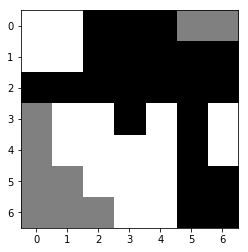

((2, 0), (3, 0)): n_v:  6015 q_all:+0.475899 q:+0.520637 q_m:+0.300000 p:0.481140
((2, 0), (4, 0)): n_v:    38 q_all:+0.388638 q:+0.414531 q_m:+0.266667 p:0.015798
((0, 4), (0, 5)): n_v:    28 q_all:+0.390154 q:+0.427511 q_m:+0.166667 p:0.011328
((1, 5), (0, 6)): n_v:     2 q_all:+0.329105 q:+0.361137 q_m:+0.166667 p:0.001395
((2, 1), (4, 0)): n_v:     1 q_all:+0.275772 q:+0.312429 q_m:+0.266667 p:0.001230
((3, 3), (5, 1)): n_v:     1 q_all:+0.266055 q:+0.303913 q_m:+0.333333 p:0.001419
((2, 4), (0, 6)): n_v:     0 q_all:-0.097977 q:-0.097977 q_m:+0.133333 p:0.000004
((1, 4), (0, 6)): n_v:     0 q_all:+0.004127 q:+0.004127 q_m:+0.133333 p:0.000005
((1, 2), (3, 0)): n_v:     0 q_all:+0.178223 q:+0.178223 q_m:+0.266667 p:0.000069
((0, 3), (0, 5)): n_v:     0 q_all:+0.159212 q:+0.159212 q_m:+0.133333 p:0.000509
((0, 4), (0, 6)): n_v:     0 q_all:+0.256278 q:+0.256278 q_m:+0.133333 p:0.000058
((1, 3), (0, 5)): n_v:     0 q_all:+0.021914 q:+0.021914 q_m:+0.133333 p:0.000065
((2, 4), (0, 5))

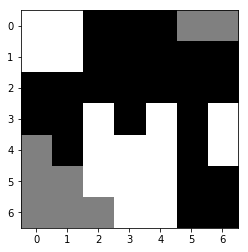

((5, 2), (4, 0)): n_v:  4301 q_all:-0.479350 q:-0.429419 q_m:-0.100000 p:0.407478
((3, 2), (4, 0)): n_v:  1118 q_all:-0.512934 q:-0.439694 q_m:-0.100000 p:0.244118
((4, 2), (5, 1)): n_v:   415 q_all:-0.502028 q:-0.466185 q_m:-0.200000 p:0.074012
((3, 2), (5, 1)): n_v:   250 q_all:-0.541326 q:-0.459355 q_m:-0.233333 p:0.080364
((4, 2), (4, 0)): n_v:   160 q_all:-0.546706 q:-0.481292 q_m:-0.100000 p:0.055133
((6, 3), (5, 1)): n_v:    30 q_all:-0.532073 q:-0.495774 q_m:-0.233333 p:0.008780
((5, 2), (6, 1)): n_v:    15 q_all:-0.619191 q:-0.596550 q_m:-0.266667 p:0.009481
((5, 3), (5, 1)): n_v:    14 q_all:-0.678022 q:-0.676435 q_m:-0.233333 p:0.011926
((3, 2), (5, 0)): n_v:     6 q_all:-0.607392 q:-0.569690 q_m:-0.233333 p:0.003701
((4, 2), (6, 1)): n_v:     4 q_all:-0.637145 q:-0.611139 q_m:-0.300000 p:0.002623
((5, 2), (6, 0)): n_v:     4 q_all:-0.617107 q:-0.590007 q_m:-0.300000 p:0.002485
((6, 3), (6, 1)): n_v:     3 q_all:-0.620633 q:-0.604410 q_m:-0.300000 p:0.001998
((4, 2), (6, 0))

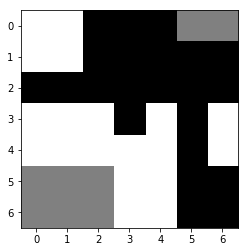

((0, 4), (0, 5)): n_v:  5396 q_all:+0.505021 q:+0.446005 q_m:+0.133333 p:0.194872
((1, 5), (0, 6)): n_v:    28 q_all:+0.362510 q:+0.362510 q_m:+0.133333 p:0.017572
((3, 3), (5, 1)): n_v:    23 q_all:+0.335137 q:+0.293430 q_m:+0.300000 p:0.017460
((3, 3), (5, 2)): n_v:    23 q_all:+0.335533 q:+0.327775 q_m:+0.433333 p:0.017545
((0, 3), (0, 5)): n_v:     4 q_all:+0.119168 q:+0.141594 q_m:+0.100000 p:0.007600
((2, 6), (0, 5)): n_v:     2 q_all:+0.231672 q:+0.231672 q_m:+0.100000 p:0.002893
((0, 4), (0, 6)): n_v:     1 q_all:+0.256966 q:+0.256966 q_m:+0.100000 p:0.001374
((2, 4), (0, 6)): n_v:     0 q_all:-0.089223 q:-0.089223 q_m:+0.100000 p:0.000038
((1, 4), (0, 6)): n_v:     0 q_all:+0.005037 q:+0.005037 q_m:+0.100000 p:0.000094
((1, 3), (0, 5)): n_v:     0 q_all:-0.014459 q:-0.014459 q_m:+0.100000 p:0.002151
((2, 4), (0, 5)): n_v:     0 q_all:-0.010024 q:-0.010024 q_m:+0.100000 p:0.000449
((2, 3), (0, 5)): n_v:     0 q_all:+0.038998 q:+0.038998 q_m:+0.100000 p:0.001498
((2, 5), (0, 6))

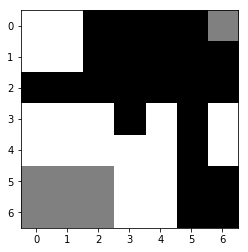

((4, 1), (5, 2)): n_v:  2657 q_all:-0.507172 q:-0.523934 q_m:-0.100000 p:0.029269
((4, 0), (5, 2)): n_v:  1059 q_all:-0.518992 q:-0.527564 q_m:-0.133333 p:0.059928
((3, 0), (5, 2)): n_v:   265 q_all:-0.608973 q:-0.570685 q_m:-0.133333 p:0.105908
((4, 0), (6, 0)): n_v:   249 q_all:-0.575537 q:-0.566733 q_m:-0.133333 p:0.068116
((6, 3), (6, 1)): n_v:   189 q_all:-0.536717 q:-0.516983 q_m:-0.133333 p:0.023122
((3, 1), (5, 2)): n_v:   172 q_all:-0.600925 q:-0.567089 q_m:-0.133333 p:0.063939
((3, 0), (5, 1)): n_v:   165 q_all:-0.593988 q:-0.556489 q_m:-0.133333 p:0.056722
((6, 3), (5, 1)): n_v:   132 q_all:-0.549759 q:-0.566356 q_m:-0.133333 p:0.022763
((4, 0), (5, 1)): n_v:   125 q_all:-0.563726 q:-0.563686 q_m:-0.100000 p:0.028445
((6, 4), (5, 2)): n_v:    94 q_all:-0.625014 q:-0.581802 q_m:-0.133333 p:0.043262
((3, 4), (5, 2)): n_v:    90 q_all:-0.597215 q:-0.556048 q_m:-0.133333 p:0.032298
((4, 0), (5, 0)): n_v:    63 q_all:-0.554175 q:-0.568983 q_m:-0.100000 p:0.011640
((3, 2), (5, 1))

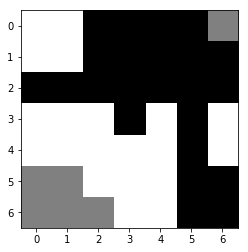

((3, 3), (5, 1)): n_v:  3463 q_all:+0.534644 q:+0.487305 q_m:+0.366667 p:0.443586
((0, 5), (0, 6)): n_v:  1278 q_all:+0.522830 q:+0.493333 q_m:+0.133333 p:0.173252
((0, 4), (0, 6)): n_v:    17 q_all:+0.337176 q:+0.295973 q_m:+0.100000 p:0.017963
((2, 6), (0, 6)): n_v:     5 q_all:+0.118849 q:+0.156829 q_m:+0.100000 p:0.012029
((2, 4), (0, 6)): n_v:     0 q_all:-0.031380 q:-0.031380 q_m:+0.100000 p:0.002551
((1, 4), (0, 6)): n_v:     0 q_all:-0.080641 q:-0.080641 q_m:+0.100000 p:0.002495
((2, 5), (0, 6)): n_v:     0 q_all:+0.033206 q:+0.033206 q_m:+0.100000 p:0.002508
########################p_sum is:  0.654384692898
1 's turn
one move takes time(s):  0.25429439544677734
no. of data collected:  24


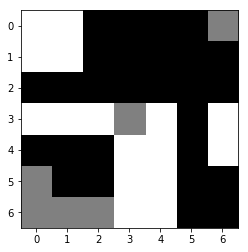

((3, 2), (5, 0)): n_v:  2299 q_all:-0.590920 q:-0.691715 q_m:-0.166667 p:0.087847
((3, 2), (3, 3)): n_v:  1843 q_all:-0.607782 q:-0.565875 q_m:-0.066667 p:0.207628
((5, 3), (3, 3)): n_v:   116 q_all:-0.689822 q:-0.642996 q_m:-0.100000 p:0.055635
((1, 1), (3, 3)): n_v:    80 q_all:-0.762545 q:-0.575254 q_m:-0.100000 p:0.064406
((5, 4), (3, 3)): n_v:    53 q_all:-0.741211 q:-0.594513 q_m:-0.100000 p:0.037913
((3, 1), (3, 3)): n_v:    48 q_all:-0.721398 q:-0.560186 q_m:-0.100000 p:0.029889
((3, 1), (5, 0)): n_v:    19 q_all:-0.625664 q:-0.697697 q_m:-0.166667 p:0.003269
((3, 0), (5, 0)): n_v:     1 q_all:-0.741418 q:-0.697867 q_m:-0.166667 p:0.000788
((5, 4), (6, 2)): n_v:     0 q_all:-0.696264 q:-0.696264 q_m:-0.233333 p:0.000159
((6, 3), (6, 1)): n_v:     0 q_all:-0.719550 q:-0.719550 q_m:-0.233333 p:0.000058
((4, 3), (6, 2)): n_v:     0 q_all:-0.729417 q:-0.729417 q_m:-0.233333 p:0.000391
((5, 3), (6, 2)): n_v:     0 q_all:-0.741459 q:-0.741459 q_m:-0.200000 p:0.000058
((4, 4), (6, 2))

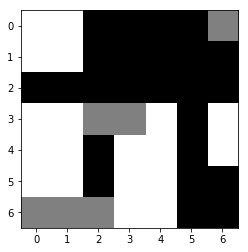

((5, 2), (6, 2)): n_v:  2915 q_all:+0.617934 q:+0.504521 q_m:+0.400000 p:0.071394
((4, 2), (6, 1)): n_v:   638 q_all:+0.563893 q:+0.563893 q_m:+0.300000 p:0.124423
((5, 2), (6, 0)): n_v:   199 q_all:+0.474310 q:+0.482130 q_m:+0.300000 p:0.146533
((4, 2), (6, 0)): n_v:   176 q_all:+0.545479 q:+0.545479 q_m:+0.300000 p:0.062760
((5, 2), (6, 1)): n_v:   161 q_all:+0.553190 q:+0.553190 q_m:+0.333333 p:0.046489
((2, 1), (3, 3)): n_v:   133 q_all:+0.592925 q:+0.458676 q_m:+0.366667 p:0.019820
((2, 2), (3, 3)): n_v:    98 q_all:+0.525937 q:+0.525581 q_m:+0.400000 p:0.047532
((2, 1), (3, 2)): n_v:    50 q_all:+0.470947 q:+0.479464 q_m:+0.400000 p:0.038317
((2, 4), (3, 2)): n_v:    39 q_all:+0.411280 q:+0.249704 q_m:+0.366667 p:0.041752
((4, 2), (6, 2)): n_v:    26 q_all:+0.529443 q:+0.509681 q_m:+0.366667 p:0.012459
((4, 5), (3, 3)): n_v:    15 q_all:+0.490381 q:+0.158276 q_m:+0.366667 p:0.009978
((2, 4), (0, 6)): n_v:     9 q_all:+0.119254 q:+0.089263 q_m:+0.166667 p:0.023299
((5, 2), (3, 3))

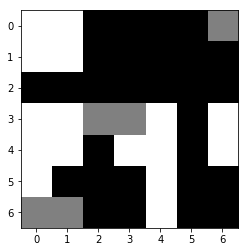

((4, 3), (6, 1)): n_v:  2150 q_all:-0.658799 q:-0.711732 q_m:-0.200000 p:0.661411
((3, 4), (3, 2)): n_v:  1732 q_all:-0.603085 q:-0.630580 q_m:-0.133333 p:0.082734
((4, 4), (3, 2)): n_v:   417 q_all:-0.627291 q:-0.663038 q_m:-0.133333 p:0.066647
((3, 1), (3, 3)): n_v:   340 q_all:-0.598485 q:-0.717483 q_m:-0.133333 p:0.008206
((4, 0), (6, 1)): n_v:   197 q_all:-0.692905 q:-0.738148 q_m:-0.200000 p:0.092053
((5, 0), (6, 1)): n_v:   128 q_all:-0.676218 q:-0.669079 q_m:-0.166667 p:0.049964
((4, 1), (3, 3)): n_v:    25 q_all:-0.717501 q:-0.770192 q_m:-0.133333 p:0.014230
((5, 4), (3, 2)): n_v:    11 q_all:-0.681572 q:-0.649052 q_m:-0.133333 p:0.004573
((4, 1), (6, 1)): n_v:     8 q_all:-0.728755 q:-0.751641 q_m:-0.200000 p:0.005093
((5, 4), (3, 3)): n_v:     3 q_all:-0.689605 q:-0.650253 q_m:-0.133333 p:0.001111
((3, 4), (3, 3)): n_v:     2 q_all:-0.805862 q:-0.783561 q_m:-0.100000 p:0.002162
((1, 1), (3, 3)): n_v:     2 q_all:-0.771071 q:-0.721783 q_m:-0.133333 p:0.001434
((3, 1), (3, 2))

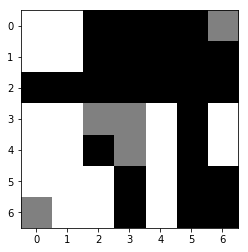

((4, 2), (6, 0)): n_v:  2113 q_all:+0.623526 q:+0.704813 q_m:+0.400000 p:0.523673
((4, 2), (4, 3)): n_v:  1625 q_all:+0.656156 q:+0.594312 q_m:+0.500000 p:0.134636
((6, 3), (4, 3)): n_v:    84 q_all:+0.642775 q:+0.455704 q_m:+0.466667 p:0.009249
((2, 1), (4, 3)): n_v:    16 q_all:+0.601470 q:+0.455633 q_m:+0.466667 p:0.005824
((2, 1), (3, 2)): n_v:    10 q_all:+0.533128 q:+0.466333 q_m:+0.366667 p:0.007374
((2, 4), (0, 6)): n_v:     7 q_all:+0.043947 q:+0.028642 q_m:+0.200000 p:0.025171
((2, 2), (4, 3)): n_v:     6 q_all:+0.538508 q:+0.462745 q_m:+0.466667 p:0.004545
((2, 3), (4, 3)): n_v:     6 q_all:+0.604291 q:+0.451941 q_m:+0.466667 p:0.002335
((0, 5), (0, 6)): n_v:     5 q_all:+0.319687 q:+0.348620 q_m:+0.233333 p:0.010149
((6, 5), (4, 3)): n_v:     1 q_all:+0.262600 q:+0.354002 q_m:+0.466667 p:0.002969
((1, 4), (3, 2)): n_v:     0 q_all:-0.017074 q:-0.017074 q_m:+0.333333 p:0.000043
((1, 3), (3, 2)): n_v:     0 q_all:+0.028125 q:+0.028125 q_m:+0.333333 p:0.000110
((5, 3), (3, 3))

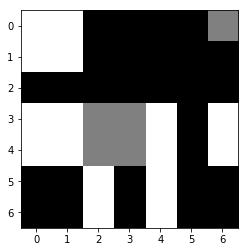

((3, 4), (3, 2)): n_v:  1375 q_all:-0.637380 q:-0.615756 q_m:-0.200000 p:0.381743
((5, 2), (3, 3)): n_v:  1275 q_all:-0.585061 q:-0.695520 q_m:-0.200000 p:0.016280
((4, 4), (3, 2)): n_v:   762 q_all:-0.637327 q:-0.586528 q_m:-0.200000 p:0.211395
((3, 4), (4, 2)): n_v:   310 q_all:-0.699131 q:-0.736245 q_m:-0.266667 p:0.183328
((4, 1), (3, 3)): n_v:    53 q_all:-0.689669 q:-0.720197 q_m:-0.200000 p:0.028960
((3, 1), (3, 3)): n_v:    53 q_all:-0.694310 q:-0.704913 q_m:-0.200000 p:0.029876
((5, 4), (3, 2)): n_v:    52 q_all:-0.703301 q:-0.657226 q_m:-0.200000 p:0.032404
((5, 2), (3, 2)): n_v:    40 q_all:-0.696353 q:-0.670909 q_m:-0.200000 p:0.023428
((5, 4), (3, 3)): n_v:    37 q_all:-0.673333 q:-0.632801 q_m:-0.200000 p:0.017062
((4, 4), (4, 2)): n_v:    20 q_all:-0.699920 q:-0.713847 q_m:-0.266667 p:0.011529
((3, 4), (3, 3)): n_v:    13 q_all:-0.707005 q:-0.726082 q_m:-0.166667 p:0.008464
((3, 1), (3, 2)): n_v:    11 q_all:-0.736501 q:-0.709937 q_m:-0.166667 p:0.008653
((3, 0), (4, 2))

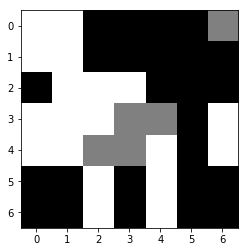

((5, 1), (4, 2)): n_v:  1470 q_all:+0.627659 q:+0.636504 q_m:+0.500000 p:0.281915
((2, 4), (3, 4)): n_v:   989 q_all:+0.658329 q:+0.663897 q_m:+0.366667 p:0.020290
((2, 0), (4, 2)): n_v:   342 q_all:+0.652740 q:+0.545092 q_m:+0.466667 p:0.016554
((6, 3), (4, 2)): n_v:   112 q_all:+0.599841 q:+0.545854 q_m:+0.466667 p:0.038828
((2, 4), (3, 3)): n_v:   107 q_all:+0.514838 q:+0.602522 q_m:+0.500000 p:0.085827
((2, 4), (4, 2)): n_v:    30 q_all:+0.484442 q:+0.481037 q_m:+0.466667 p:0.030138
((0, 5), (0, 6)): n_v:    26 q_all:+0.573543 q:+0.560510 q_m:+0.233333 p:0.013284
((6, 1), (4, 2)): n_v:    18 q_all:+0.459262 q:+0.486932 q_m:+0.466667 p:0.020397
((4, 5), (3, 3)): n_v:    17 q_all:+0.591734 q:+0.362822 q_m:+0.466667 p:0.006939
((5, 3), (3, 4)): n_v:    15 q_all:+0.643981 q:+0.673483 q_m:+0.333333 p:0.000863
((6, 0), (4, 2)): n_v:    12 q_all:+0.506713 q:+0.496368 q_m:+0.466667 p:0.010355
((5, 3), (4, 3)): n_v:    10 q_all:+0.464433 q:+0.486771 q_m:+0.500000 p:0.011906
((5, 0), (4, 2))

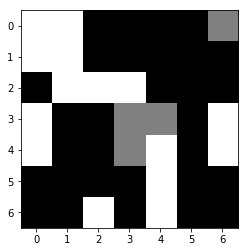

((2, 3), (4, 3)): n_v:  2172 q_all:-0.719512 q:-0.742428 q_m:-0.233333 p:0.451335
((2, 2), (4, 3)): n_v:   658 q_all:-0.751531 q:-0.747900 q_m:-0.233333 p:0.252844
((2, 2), (3, 4)): n_v:   277 q_all:-0.767175 q:-0.776931 q_m:-0.233333 p:0.130067
((5, 4), (3, 3)): n_v:   168 q_all:-0.707496 q:-0.655540 q_m:-0.300000 p:0.023742
((2, 1), (4, 3)): n_v:    69 q_all:-0.822821 q:-0.742390 q_m:-0.233333 p:0.053291
((6, 2), (4, 3)): n_v:    26 q_all:-0.769038 q:-0.762330 q_m:-0.233333 p:0.012755
((4, 4), (4, 3)): n_v:    25 q_all:-0.820079 q:-0.810783 q_m:-0.200000 p:0.019067
((6, 4), (4, 3)): n_v:    21 q_all:-0.778288 q:-0.714872 q_m:-0.233333 p:0.011629
((5, 4), (3, 4)): n_v:    14 q_all:-0.771970 q:-0.738329 q_m:-0.233333 p:0.007233
((2, 3), (3, 4)): n_v:     6 q_all:-0.836670 q:-0.843580 q_m:-0.200000 p:0.004691
((2, 1), (3, 3)): n_v:     4 q_all:-0.780068 q:-0.717333 q_m:-0.300000 p:0.002228
((2, 2), (3, 3)): n_v:     1 q_all:-0.851785 q:-0.777551 q_m:-0.266667 p:0.000880
((1, 1), (3, 3))

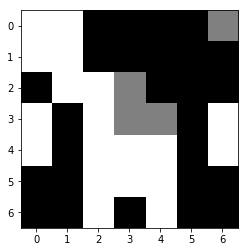

((2, 4), (3, 3)): n_v:  3626 q_all:+0.760571 q:+0.637711 q_m:+0.600000 p:0.095303
((2, 4), (3, 4)): n_v:   180 q_all:+0.648210 q:+0.648210 q_m:+0.400000 p:0.027756
((1, 2), (2, 3)): n_v:   176 q_all:+0.605880 q:+0.605880 q_m:+0.400000 p:0.118244
((4, 5), (3, 3)): n_v:   104 q_all:+0.727490 q:+0.380097 q_m:+0.566667 p:0.020167
((4, 5), (2, 3)): n_v:    30 q_all:+0.633920 q:+0.275258 q_m:+0.366667 p:0.020435
((1, 3), (3, 3)): n_v:    27 q_all:+0.593706 q:+0.544696 q_m:+0.566667 p:0.024135
((1, 4), (3, 3)): n_v:    16 q_all:+0.497837 q:+0.514060 q_m:+0.566667 p:0.020740
((1, 2), (3, 3)): n_v:    16 q_all:+0.521023 q:+0.465250 q_m:+0.566667 p:0.020615
((3, 5), (3, 3)): n_v:    11 q_all:+0.594885 q:+0.568014 q_m:+0.566667 p:0.010173
((2, 5), (3, 3)): n_v:    10 q_all:+0.491697 q:+0.469961 q_m:+0.566667 p:0.015082
((4, 1), (2, 3)): n_v:     9 q_all:+0.367303 q:+0.302954 q_m:+0.366667 p:0.019059
((0, 5), (2, 3)): n_v:     8 q_all:+0.537471 q:+0.448066 q_m:+0.366667 p:0.009731
((4, 1), (3, 3))

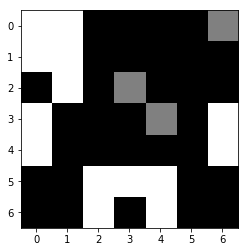

((5, 2), (3, 4)): n_v:  3633 q_all:-0.697668 q:-0.741606 q_m:-0.133333 p:0.295208
((2, 1), (2, 3)): n_v:   506 q_all:-0.722832 q:-0.758041 q_m:-0.133333 p:0.017039
((5, 3), (3, 4)): n_v:   435 q_all:-0.828354 q:-0.865417 q_m:-0.133333 p:0.265691
((3, 6), (3, 4)): n_v:   385 q_all:-0.812056 q:-0.789445 q_m:-0.133333 p:0.200245
((5, 4), (3, 4)): n_v:   297 q_all:-0.767371 q:-0.802199 q_m:-0.133333 p:0.081880
((1, 1), (2, 3)): n_v:   174 q_all:-0.737420 q:-0.740203 q_m:-0.133333 p:0.019596
((4, 6), (3, 4)): n_v:   174 q_all:-0.830677 q:-0.799664 q_m:-0.133333 p:0.108678
((0, 1), (2, 3)): n_v:    37 q_all:-0.776135 q:-0.792795 q_m:-0.133333 p:0.011641
########################p_sum is:  0.999977969564
-1 's turn
one move takes time(s):  0.16410064697265625
no. of data collected:  16


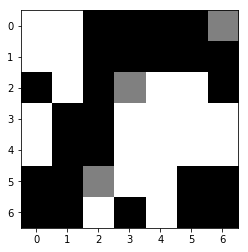

((4, 1), (5, 2)): n_v:  4885 q_all:+0.768495 q:+0.765241 q_m:+0.366667 p:0.229118
((4, 2), (2, 3)): n_v:   248 q_all:+0.701765 q:+0.617197 q_m:+0.333333 p:0.003296
((1, 2), (2, 3)): n_v:    33 q_all:+0.642522 q:+0.682913 q_m:+0.366667 p:0.011468
((6, 0), (5, 2)): n_v:    26 q_all:+0.617434 q:+0.586690 q_m:+0.333333 p:0.012570
((5, 0), (5, 2)): n_v:     8 q_all:+0.464430 q:+0.430516 q_m:+0.333333 p:0.010362
((3, 1), (5, 2)): n_v:     2 q_all:+0.485724 q:+0.471716 q_m:+0.333333 p:0.003302
((1, 4), (0, 6)): n_v:     0 q_all:-0.447234 q:-0.447234 q_m:+0.133333 p:0.000003
((0, 3), (2, 3)): n_v:     0 q_all:+0.101476 q:+0.101476 q_m:+0.333333 p:0.000723
((0, 4), (0, 6)): n_v:     0 q_all:-0.530338 q:-0.530338 q_m:+0.133333 p:0.000022
((0, 2), (2, 3)): n_v:     0 q_all:+0.300138 q:+0.300138 q_m:+0.333333 p:0.001542
((0, 5), (2, 3)): n_v:     0 q_all:+0.454008 q:+0.454008 q_m:+0.333333 p:0.001227
((1, 5), (2, 3)): n_v:     0 q_all:-0.205968 q:-0.205968 q_m:+0.333333 p:0.000458
((0, 4), (2, 3))

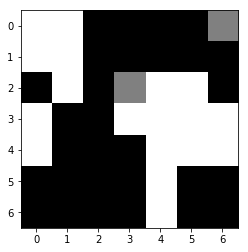

((2, 4), (2, 3)): n_v:  3581 q_all:-0.822036 q:-0.635446 q_m:-0.000000 p:0.197043
((3, 5), (2, 3)): n_v:  1259 q_all:-0.816412 q:-0.834576 q_m:-0.033333 p:0.041068
((2, 4), (0, 6)): n_v:   969 q_all:-0.809519 q:-0.905691 q_m:-0.166667 p:0.005588
((4, 4), (2, 3)): n_v:   189 q_all:-0.927489 q:-0.841199 q_m:-0.033333 p:0.089466
((4, 5), (2, 3)): n_v:    86 q_all:-0.939503 q:-0.845431 q_m:-0.033333 p:0.044880
((0, 1), (2, 3)): n_v:    68 q_all:-0.949973 q:-0.918020 q_m:-0.033333 p:0.038291
((1, 1), (2, 3)): n_v:    61 q_all:-0.942585 q:-0.847417 q_m:-0.033333 p:0.032356
((2, 1), (2, 3)): n_v:    50 q_all:-0.931970 q:-0.825461 q_m:-0.033333 p:0.024635
((2, 5), (2, 3)): n_v:    22 q_all:-0.958938 q:-0.881946 q_m:-0.033333 p:0.013217
((2, 5), (0, 6)): n_v:     0 q_all:-0.861716 q:-0.861716 q_m:-0.166667 p:0.000070
########################p_sum is:  0.486614657202
-1 's turn


This is a random move


one move takes time(s):  0.023019790649414062
no. of data collected:  8


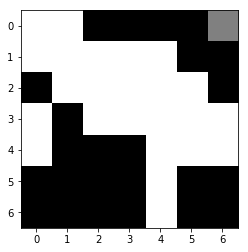

((0, 5), (0, 6)): n_v:  4068 q_all:+1.000000 q:+5.000000 q_m:+0.033333 p:0.299759
((2, 6), (0, 6)): n_v:     9 q_all:-0.386576 q:-0.233220 q_m:-0.000000 p:0.059664
((0, 4), (0, 6)): n_v:     5 q_all:-0.798636 q:-0.697954 q_m:-0.000000 p:0.045278
########################p_sum is:  0.404700938612
this self play has 97 steps, time elapsed 219.8367612361908
winner is -1.0
episode 113 finished
episode 114 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.30889177322387695
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.4256577491760254
no. of data collected:  16
-1 's turn
one move takes time(s):  0.7002286911010742
no. of data collected:  16
1 's turn
one move takes time(s):  0.981203556060791
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  1.7891745567321777
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.535216808319092




This is a random move


one move takes time(s):  1.333399772644043
no. of data collected:  16
-1 's turn
one move takes time(s):  1.447707176208496
no. of data collected:  16
1 's turn
one move takes time(s):  1.416450023651123
no. of data collected:  16
-1 's turn
one move takes time(s):  1.2111632823944092
no. of data collected:  24
1 's turn


This is a random move


one move takes time(s):  1.2028379440307617
no. of data collected:  16
-1 's turn
one move takes time(s):  1.2063231468200684
no. of data collected:  16
1 's turn
one move takes time(s):  0.9708986282348633
no. of data collected:  16
-1 's turn
one move takes time(s):  1.0366637706756592
no. of data collected:  24
1 's turn
one move takes time(s):  0.8986666202545166
no. of data collected:  24
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.919161319732666
one move takes time(s):  2.9216177463531494
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  2108 time elaps

Epoch 23/512
34000/34000 [==============================] - 3s 74us/step - loss: 0.8470 - activation_29_loss: 0.8109 - dense_15_loss: 0.0080 - val_loss: 0.8479 - val_activation_29_loss: 0.8119 - val_dense_15_loss: 0.0079
Epoch 24/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8469 - activation_29_loss: 0.8108 - dense_15_loss: 0.0080 - val_loss: 0.8479 - val_activation_29_loss: 0.8119 - val_dense_15_loss: 0.0079
Epoch 25/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8470 - activation_29_loss: 0.8108 - dense_15_loss: 0.0080 - val_loss: 0.8480 - val_activation_29_loss: 0.8119 - val_dense_15_loss: 0.0080
Epoch 26/512
34000/34000 [==============================] - 2s 73us/step - loss: 0.8467 - activation_29_loss: 0.8106 - dense_15_loss: 0.0080 - val_loss: 0.8480 - val_activation_29_loss: 0.8120 - val_dense_15_loss: 0.0079
Epoch 27/512
34000/34000 [==============================] - 3s 74us/step - loss: 0.8466 - activation_29_loss: 0.8105

34000/34000 [==============================] - 3s 76us/step - loss: 0.8421 - activation_29_loss: 0.8063 - dense_15_loss: 0.0077 - val_loss: 0.8487 - val_activation_29_loss: 0.8127 - val_dense_15_loss: 0.0080
Epoch 61/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8420 - activation_29_loss: 0.8062 - dense_15_loss: 0.0077 - val_loss: 0.8488 - val_activation_29_loss: 0.8127 - val_dense_15_loss: 0.0080
Epoch 62/512
34000/34000 [==============================] - 3s 79us/step - loss: 0.8420 - activation_29_loss: 0.8062 - dense_15_loss: 0.0077 - val_loss: 0.8488 - val_activation_29_loss: 0.8127 - val_dense_15_loss: 0.0080
Epoch 63/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8420 - activation_29_loss: 0.8062 - dense_15_loss: 0.0077 - val_loss: 0.8488 - val_activation_29_loss: 0.8127 - val_dense_15_loss: 0.0080
Epoch 64/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8420 - activation_29_loss: 0.8062 - dense_15_l

one move takes time(s):  1.0217597484588623
no. of data collected:  16
-1 's turn
one move takes time(s):  0.7745044231414795
no. of data collected:  16
1 's turn
one move takes time(s):  0.9559369087219238
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.002253532409668
one move takes time(s):  2.003962516784668
no. of data collected:  24
1 's turn
one move takes time(s):  1.8648037910461426
no. of data collected:  24
-1 's turn
one move takes time(s):  1.8247652053833008
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.4847302436828613
one move takes time(s):  2.48590087890625
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.825986623764038
no. of data collected:  16
1 's turn
one move takes time(s):  1.853675127029419
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2045 time elapsed:  2.000136375427246
one mo

due to rollout lim, final rollout times:  2001 time elapsed:  3.955439805984497


This is a random move


one move takes time(s):  3.957427501678467
no. of data collected:  8
-1 's turn
one move takes time(s):  1.9209496974945068
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.3766298294067383
one move takes time(s):  2.3776848316192627
no. of data collected:  8
-1 's turn
one move takes time(s):  0.532559871673584
no. of data collected:  16
1 's turn
one move takes time(s):  0.41515088081359863
no. of data collected:  24
-1 's turn
one move takes time(s):  0.2470836639404297
no. of data collected:  8
this self play has 19 steps, time elapsed 29.511917114257812
winner is -1.0
episode 117 finished
episode 118 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.3138864040374756
no. of data collected:  8
1 's turn
one move takes time(s):  0.4416491985321045
no. of data collected:  16
-1 's turn
one move t

one move takes time(s):  0.25086545944213867
no. of data collected:  16
-1 's turn
one move takes time(s):  0.13672375679016113
no. of data collected:  24
1 's turn
one move takes time(s):  0.04955458641052246
no. of data collected:  8
this self play has 82 steps, time elapsed 77.94977331161499
winner is 1.0
episode 118 finished
episode 119 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.3004462718963623
no. of data collected:  8
1 's turn
one move takes time(s):  0.44463419914245605
no. of data collected:  16
-1 's turn
one move takes time(s):  0.8148179054260254
no. of data collected:  24
1 's turn
one move takes time(s):  1.1239209175109863
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  1.7224328517913818
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  1.5204651355743408
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed

one move takes time(s):  0.0627741813659668
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.0757131576538086
no. of data collected:  16
1 's turn
one move takes time(s):  0.061335086822509766
no. of data collected:  16
-1 's turn
one move takes time(s):  0.044669389724731445
no. of data collected:  16
1 's turn
one move takes time(s):  0.027071714401245117
no. of data collected:  8
this self play has 80 steps, time elapsed 689.9329788684845
winner is -1.0
episode 119 finished
episode 120 now start
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.3013193607330322
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.3728153705596924
no. of data collected:  16
-1 's turn
one move takes time(s):  0.674095630645752
no. of data collected:  16
1 's turn
one move takes time(s):  0.9652786254882812
no. of data collected:  16
-1 's turn
one move takes time(s):  1.847

one move takes time(s):  0.8801093101501465
no. of data collected:  24
-1 's turn
one move takes time(s):  1.3830325603485107
no. of data collected:  16
1 's turn
one move takes time(s):  0.8321022987365723
no. of data collected:  16
-1 's turn
one move takes time(s):  1.423844814300537
no. of data collected:  24
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.090367317199707
one move takes time(s):  2.091693878173828
no. of data collected:  16
-1 's turn
one move takes time(s):  1.6161019802093506
no. of data collected:  16
1 's turn
one move takes time(s):  1.7394096851348877
no. of data collected:  16
-1 's turn
one move takes time(s):  1.4596195220947266
no. of data collected:  24
1 's turn
one move takes time(s):  1.3361568450927734
no. of data collected:  16
-1 's turn
one move takes time(s):  0.5145275592803955
no. of data collected:  16
1 's turn
one move takes time(s):  0.4296379089355469
no. of data collected:  16
-1 's turn
one move takes time(s):  

34000/34000 [==============================] - 3s 76us/step - loss: 0.8326 - activation_29_loss: 0.7961 - dense_15_loss: 0.0084 - val_loss: 0.8418 - val_activation_29_loss: 0.8067 - val_dense_15_loss: 0.0070
Epoch 24/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8326 - activation_29_loss: 0.7961 - dense_15_loss: 0.0084 - val_loss: 0.8418 - val_activation_29_loss: 0.8066 - val_dense_15_loss: 0.0070
Epoch 25/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8322 - activation_29_loss: 0.7957 - dense_15_loss: 0.0083 - val_loss: 0.8418 - val_activation_29_loss: 0.8067 - val_dense_15_loss: 0.0070
Epoch 26/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8319 - activation_29_loss: 0.7954 - dense_15_loss: 0.0083 - val_loss: 0.8418 - val_activation_29_loss: 0.8067 - val_dense_15_loss: 0.0070
Epoch 27/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8319 - activation_29_loss: 0.7954 - dense_15_l

34000/34000 [==============================] - 3s 75us/step - loss: 0.8275 - activation_29_loss: 0.7913 - dense_15_loss: 0.0080 - val_loss: 0.8424 - val_activation_29_loss: 0.8074 - val_dense_15_loss: 0.0069
Epoch 61/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8275 - activation_29_loss: 0.7914 - dense_15_loss: 0.0081 - val_loss: 0.8425 - val_activation_29_loss: 0.8074 - val_dense_15_loss: 0.0070
Epoch 62/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8273 - activation_29_loss: 0.7911 - dense_15_loss: 0.0080 - val_loss: 0.8424 - val_activation_29_loss: 0.8074 - val_dense_15_loss: 0.0069
Epoch 63/512
34000/34000 [==============================] - 2s 73us/step - loss: 0.8271 - activation_29_loss: 0.7910 - dense_15_loss: 0.0080 - val_loss: 0.8425 - val_activation_29_loss: 0.8074 - val_dense_15_loss: 0.0069
Epoch 64/512
34000/34000 [==============================] - 3s 78us/step - loss: 0.8274 - activation_29_loss: 0.7913 - dense_15_l

34000/34000 [==============================] - 3s 78us/step - loss: 0.8241 - activation_29_loss: 0.7881 - dense_15_loss: 0.0079 - val_loss: 0.8430 - val_activation_29_loss: 0.8080 - val_dense_15_loss: 0.0069
Epoch 98/512
34000/34000 [==============================] - 3s 74us/step - loss: 0.8238 - activation_29_loss: 0.7878 - dense_15_loss: 0.0079 - val_loss: 0.8430 - val_activation_29_loss: 0.8080 - val_dense_15_loss: 0.0069
Epoch 00098: early stopping
saving files


target model updated by T: 0.25 




start testing against min max
mm_dep is:  1
####               ####
#### start testing ####
testing took time:  94.4772880077362
58.170212765957444



                        win ratio of Q is 0.752 





mm_dep is:  2
####               ####
#### start testing ####
testing took time:  143.8644027709961
72.0



                        win ratio of P is 0.535 





episode 120 finished
episode 121 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.311305

one move takes time(s):  1.7058231830596924
no. of data collected:  24
1 's turn
one move takes time(s):  1.805084228515625
no. of data collected:  16
-1 's turn
one move takes time(s):  1.7918977737426758
no. of data collected:  16
1 's turn
one move takes time(s):  0.6434099674224854
no. of data collected:  16
-1 's turn
one move takes time(s):  1.0313308238983154
no. of data collected:  24
1 's turn
due to rollout lim, final rollout times:  2097 time elapsed:  2.013824224472046
one move takes time(s):  2.015131711959839
no. of data collected:  24
-1 's turn
one move takes time(s):  1.5799047946929932
no. of data collected:  8
1 's turn
one move takes time(s):  1.3623015880584717
no. of data collected:  16
-1 's turn
one move takes time(s):  1.3373637199401855
no. of data collected:  16
1 's turn
one move takes time(s):  1.7873008251190186
no. of data collected:  24
-1 's turn
one move takes time(s):  0.9987423419952393
no. of data collected:  16
1 's turn


This is a random move


o

one move takes time(s):  1.6210339069366455
no. of data collected:  16
1 's turn
one move takes time(s):  1.8639771938323975
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.6931328773498535
no. of data collected:  16
1 's turn
one move takes time(s):  0.914268970489502
no. of data collected:  24
-1 's turn
one move takes time(s):  1.248793601989746
no. of data collected:  16
1 's turn
one move takes time(s):  1.5436408519744873
no. of data collected:  24
-1 's turn


This is a random move


one move takes time(s):  1.1301133632659912
no. of data collected:  16
1 's turn
one move takes time(s):  0.5797629356384277
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.6710875034332275
no. of data collected:  24
1 's turn
one move takes time(s):  0.8443694114685059
no. of data collected:  16
-1 's turn
one move takes time(s):  0.4489867687225342
no. of data collected:  24
1 's turn
one move takes time(s):  0.40

due to rollout lim, final rollout times:  2001 time elapsed:  2.7784862518310547


This is a random move


one move takes time(s):  2.780158042907715
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  4.423942804336548
one move takes time(s):  4.425374984741211
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  4.464260816574097
one move takes time(s):  4.465720891952515
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.4885425567626953
one move takes time(s):  3.4901230335235596
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.8850057125091553


This is a random move


one move takes time(s):  2.886679172515869
no. of data collected:  16
-1 's turn
one move takes time(s):  1.1684165000915527
no. of data collected:  16
1 's turn
one move takes time(s):  1.5226974487304688
no. of data colle

due to rollout lim, final rollout times:  2001 time elapsed:  2.0317225456237793
one move takes time(s):  2.033018112182617
no. of data collected:  16
-1 's turn
one move takes time(s):  1.9311110973358154
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.490278482437134
one move takes time(s):  3.492475748062134
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.325857162475586
one move takes time(s):  2.3271970748901367
no. of data collected:  16
1 's turn
one move takes time(s):  1.5382728576660156
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.3134756088256836


This is a random move


one move takes time(s):  2.315053701400757
no. of data collected:  24
1 's turn
one move takes time(s):  1.2929651737213135
no. of data collected:  16
-1 's turn
one move takes time(s):  1.8732149600982666
no. of data collected:  16
1 's turn
one 

one move takes time(s):  0.624138355255127
no. of data collected:  16
-1 's turn
one move takes time(s):  0.7148222923278809
no. of data collected:  16
1 's turn
one move takes time(s):  0.8290688991546631
no. of data collected:  24
-1 's turn
one move takes time(s):  0.432863712310791
no. of data collected:  16
1 's turn
one move takes time(s):  0.41471219062805176
no. of data collected:  16
-1 's turn
one move takes time(s):  0.3455331325531006
no. of data collected:  16
1 's turn
one move takes time(s):  0.48865294456481934
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.31792140007019043
no. of data collected:  16
1 's turn
one move takes time(s):  0.29836606979370117
no. of data collected:  24
-1 's turn
one move takes time(s):  0.19417977333068848
no. of data collected:  16
1 's turn
one move takes time(s):  0.21614861488342285
no. of data collected:  16
-1 's turn
one move takes time(s):  0.21918606758117676
no. of data collected:  24
1

Epoch 27/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8346 - activation_29_loss: 0.7987 - dense_15_loss: 0.0078 - val_loss: 0.8305 - val_activation_29_loss: 0.7951 - val_dense_15_loss: 0.0074
Epoch 28/512
34000/34000 [==============================] - 2s 73us/step - loss: 0.8343 - activation_29_loss: 0.7984 - dense_15_loss: 0.0078 - val_loss: 0.8306 - val_activation_29_loss: 0.7951 - val_dense_15_loss: 0.0074
Epoch 29/512
34000/34000 [==============================] - 2s 72us/step - loss: 0.8341 - activation_29_loss: 0.7983 - dense_15_loss: 0.0078 - val_loss: 0.8306 - val_activation_29_loss: 0.7951 - val_dense_15_loss: 0.0074
Epoch 30/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8341 - activation_29_loss: 0.7982 - dense_15_loss: 0.0078 - val_loss: 0.8306 - val_activation_29_loss: 0.7951 - val_dense_15_loss: 0.0074
Epoch 31/512
34000/34000 [==============================] - 2s 72us/step - loss: 0.8338 - activation_29_loss: 0.7980

34000/34000 [==============================] - 3s 78us/step - loss: 0.8300 - activation_29_loss: 0.7942 - dense_15_loss: 0.0076 - val_loss: 0.8311 - val_activation_29_loss: 0.7957 - val_dense_15_loss: 0.0074
Epoch 65/512
34000/34000 [==============================] - 3s 78us/step - loss: 0.8299 - activation_29_loss: 0.7941 - dense_15_loss: 0.0076 - val_loss: 0.8311 - val_activation_29_loss: 0.7956 - val_dense_15_loss: 0.0074
Epoch 66/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8297 - activation_29_loss: 0.7940 - dense_15_loss: 0.0076 - val_loss: 0.8311 - val_activation_29_loss: 0.7956 - val_dense_15_loss: 0.0074
Epoch 67/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8296 - activation_29_loss: 0.7939 - dense_15_loss: 0.0076 - val_loss: 0.8312 - val_activation_29_loss: 0.7957 - val_dense_15_loss: 0.0074
Epoch 68/512
34000/34000 [==============================] - 3s 79us/step - loss: 0.8295 - activation_29_loss: 0.7938 - dense_15_l

one move takes time(s):  1.7219319343566895
no. of data collected:  24
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.58918833732605
one move takes time(s):  2.590632438659668
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.0051729679107666
one move takes time(s):  2.0068514347076416
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.9087953567504883
one move takes time(s):  2.91225528717041
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.0073366165161133
one move takes time(s):  3.008746862411499
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.566180944442749


This is a random move


one move takes time(s):  3.567558765411377
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.4294896125793457
one mov

one move takes time(s):  0.32501745223999023
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.46373629570007324
no. of data collected:  16
-1 's turn
one move takes time(s):  0.7958278656005859
no. of data collected:  16
1 's turn
one move takes time(s):  1.0667235851287842
no. of data collected:  16
-1 's turn
one move takes time(s):  1.9597151279449463
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  1.8962178230285645
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.0444793701171875
one move takes time(s):  2.0461833477020264
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.1588287353515625


This is a random move


one move takes time(s):  3.1602706909179688
no. of data collected:  16
-1 's turn
one move takes time(s):  1.7343769073486328
no. of data collected:  16
1 's turn
due to rollout lim, final 

one move takes time(s):  0.15010762214660645
no. of data collected:  24
-1 's turn


This is a random move


one move takes time(s):  0.24330663681030273
no. of data collected:  24
1 's turn
one move takes time(s):  0.21979117393493652
no. of data collected:  16
-1 's turn
one move takes time(s):  0.20134234428405762
no. of data collected:  24
1 's turn


This is a random move


one move takes time(s):  0.20407605171203613
no. of data collected:  16
-1 's turn
one move takes time(s):  0.1124413013458252
no. of data collected:  24
1 's turn
one move takes time(s):  0.08362960815429688
no. of data collected:  24
-1 's turn
one move takes time(s):  0.07171988487243652
no. of data collected:  16
1 's turn
one move takes time(s):  0.09239578247070312
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.027681350708007812
no. of data collected:  8
this self play has 81 steps, time elapsed 153.55353808403015
winner is -1.0
episode 127 finished
episode 128

one move takes time(s):  1.648987054824829
no. of data collected:  24
1 's turn


This is a random move


one move takes time(s):  0.6946103572845459
no. of data collected:  16
-1 's turn
one move takes time(s):  0.549128532409668
no. of data collected:  16
1 's turn
one move takes time(s):  0.6070146560668945
no. of data collected:  16
-1 's turn
one move takes time(s):  1.5345861911773682
no. of data collected:  16
1 's turn
one move takes time(s):  0.53053879737854
no. of data collected:  16
-1 's turn
one move takes time(s):  0.5799052715301514
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.21687960624694824
no. of data collected:  16
-1 's turn
one move takes time(s):  0.19539332389831543
no. of data collected:  24
1 's turn
one move takes time(s):  0.17092609405517578
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.202467679977417
no. of data collected:  24
1 's turn
one move takes time(s):  0.1

one move takes time(s):  0.16422104835510254
no. of data collected:  16
1 's turn
one move takes time(s):  0.16504788398742676
no. of data collected:  16
-1 's turn
one move takes time(s):  0.09827947616577148
no. of data collected:  24
1 's turn


This is a random move


one move takes time(s):  0.13653826713562012
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.08432388305664062
no. of data collected:  16
this self play has 73 steps, time elapsed 52.79883551597595
winner is 1.0
episode 129 finished
episode 130 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.3125648498535156
no. of data collected:  8
1 's turn
one move takes time(s):  0.4163680076599121
no. of data collected:  16
-1 's turn
one move takes time(s):  0.7646517753601074
no. of data collected:  24
1 's turn


This is a random move


one move takes time(s):  1.0130345821380615
no. of data collected:  16
-1 's turn
one move takes time(s):  1.436

34000/34000 [==============================] - 2s 73us/step - loss: 0.8473 - activation_29_loss: 0.8114 - dense_15_loss: 0.0078 - val_loss: 0.8217 - val_activation_29_loss: 0.7865 - val_dense_15_loss: 0.0071
Epoch 29/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8471 - activation_29_loss: 0.8112 - dense_15_loss: 0.0078 - val_loss: 0.8218 - val_activation_29_loss: 0.7866 - val_dense_15_loss: 0.0071
Epoch 30/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8469 - activation_29_loss: 0.8110 - dense_15_loss: 0.0078 - val_loss: 0.8218 - val_activation_29_loss: 0.7866 - val_dense_15_loss: 0.0071
Epoch 31/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8470 - activation_29_loss: 0.8111 - dense_15_loss: 0.0078 - val_loss: 0.8218 - val_activation_29_loss: 0.7866 - val_dense_15_loss: 0.0071
Epoch 32/512
34000/34000 [==============================] - 2s 72us/step - loss: 0.8467 - activation_29_loss: 0.8108 - dense_15_l

34000/34000 [==============================] - 3s 78us/step - loss: 0.8427 - activation_29_loss: 0.8070 - dense_15_loss: 0.0076 - val_loss: 0.8226 - val_activation_29_loss: 0.7874 - val_dense_15_loss: 0.0071
Epoch 66/512
34000/34000 [==============================] - 2s 72us/step - loss: 0.8426 - activation_29_loss: 0.8069 - dense_15_loss: 0.0076 - val_loss: 0.8226 - val_activation_29_loss: 0.7874 - val_dense_15_loss: 0.0071
Epoch 67/512
34000/34000 [==============================] - 3s 78us/step - loss: 0.8426 - activation_29_loss: 0.8069 - dense_15_loss: 0.0076 - val_loss: 0.8226 - val_activation_29_loss: 0.7875 - val_dense_15_loss: 0.0070
Epoch 68/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8425 - activation_29_loss: 0.8068 - dense_15_loss: 0.0076 - val_loss: 0.8226 - val_activation_29_loss: 0.7875 - val_dense_15_loss: 0.0071
Epoch 69/512
34000/34000 [==============================] - 3s 81us/step - loss: 0.8423 - activation_29_loss: 0.8066 - dense_15_l

due to rollout lim, final rollout times:  2001 time elapsed:  2.7297983169555664
one move takes time(s):  2.731038808822632
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.5686593055725098
one move takes time(s):  2.5698392391204834
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2159 time elapsed:  2.0001308917999268
one move takes time(s):  2.0012660026550293
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.288130521774292
one move takes time(s):  3.2896974086761475
no. of data collected:  8
1 's turn
one move takes time(s):  1.7651660442352295
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.2941908836364746
one move takes time(s):  2.295703887939453
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.240419387817383
one move takes time(s):  2.241

due to rollout lim, final rollout times:  2001 time elapsed:  3.6918280124664307
one move takes time(s):  3.6931262016296387
no. of data collected:  16
1 's turn
due to time lim, final rollout times:  1020 time elapsed:  6.0038533210754395
one move takes time(s):  6.005176067352295
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  5.245282173156738
one move takes time(s):  5.246551513671875
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  5.479671955108643
one move takes time(s):  5.481520891189575
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.33895206451416
one move takes time(s):  3.3403422832489014
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  4.82887601852417
one move takes time(s):  4.830308675765991
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  

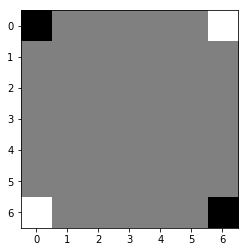

((6, 6), (5, 5)): n_v:  1176 q_all:+0.020373 q:+0.010437 q_m:+0.033333 p:0.497260
((0, 0), (1, 1)): n_v:  1020 q_all:+0.011017 q:+0.027246 q_m:+0.033333 p:0.499260
((6, 6), (6, 5)): n_v:     2 q_all:+0.019450 q:+0.011602 q_m:+0.033333 p:0.001174
((0, 0), (0, 1)): n_v:     1 q_all:+0.007346 q:+0.011278 q_m:+0.033333 p:0.000847
((0, 0), (1, 0)): n_v:     1 q_all:+0.015305 q:+0.020115 q_m:+0.033333 p:0.000446
((6, 6), (6, 4)): n_v:     0 q_all:-0.001281 q:-0.001281 q_m:-0.000000 p:0.000018
((0, 0), (1, 2)): n_v:     0 q_all:-0.010210 q:-0.010210 q_m:-0.000000 p:0.000021
((0, 0), (2, 2)): n_v:     0 q_all:-0.001246 q:-0.001246 q_m:-0.000000 p:0.000081
((0, 0), (0, 2)): n_v:     0 q_all:-0.016964 q:-0.016964 q_m:-0.000000 p:0.000021
((6, 6), (5, 6)): n_v:     0 q_all:+0.014698 q:+0.014698 q_m:+0.033333 p:0.000437
((6, 6), (4, 6)): n_v:     0 q_all:+0.007846 q:+0.007846 q_m:-0.000000 p:0.000078
((6, 6), (5, 4)): n_v:     0 q_all:+0.003586 q:+0.003586 q_m:-0.000000 p:0.000038
((6, 6), (4, 4))

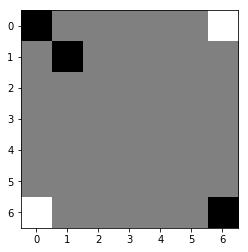

((0, 6), (1, 5)): n_v:  2039 q_all:-0.020435 q:-0.016131 q_m:-0.000000 p:0.610101
((6, 0), (5, 1)): n_v:  1018 q_all:-0.025340 q:-0.016318 q_m:-0.000000 p:0.333916
((0, 6), (1, 6)): n_v:    64 q_all:-0.025895 q:-0.023361 q_m:-0.000000 p:0.021295
((6, 0), (5, 0)): n_v:    39 q_all:-0.020326 q:-0.019365 q_m:-0.000000 p:0.011629
((0, 6), (0, 5)): n_v:    36 q_all:-0.029097 q:-0.021115 q_m:-0.000000 p:0.012719
((6, 0), (6, 1)): n_v:    22 q_all:-0.027217 q:-0.013766 q_m:-0.000000 p:0.007580
((0, 6), (2, 4)): n_v:     1 q_all:-0.042744 q:-0.034067 q_m:-0.033333 p:0.000532
((0, 6), (1, 4)): n_v:     1 q_all:-0.047738 q:-0.034242 q_m:-0.033333 p:0.000424
((6, 0), (6, 2)): n_v:     0 q_all:-0.037334 q:-0.037334 q_m:-0.033333 p:0.000140
((6, 0), (5, 2)): n_v:     0 q_all:-0.038060 q:-0.038060 q_m:-0.033333 p:0.000156
((6, 0), (4, 1)): n_v:     0 q_all:-0.022976 q:-0.022976 q_m:-0.033333 p:0.000136
((0, 6), (2, 6)): n_v:     0 q_all:-0.029514 q:-0.029514 q_m:-0.033333 p:0.000162
((0, 6), (0, 4))

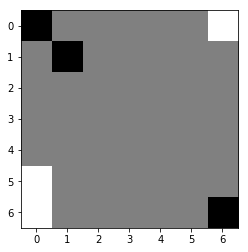

((6, 6), (5, 5)): n_v:  1987 q_all:+0.012554 q:-0.002664 q_m:+0.033333 p:0.881791
((1, 1), (2, 2)): n_v:   195 q_all:+0.013512 q:+0.015375 q_m:+0.033333 p:0.085467
((1, 1), (2, 1)): n_v:    34 q_all:+0.006619 q:-0.001874 q_m:+0.033333 p:0.016959
((1, 1), (1, 2)): n_v:    18 q_all:-0.004526 q:-0.010569 q_m:+0.033333 p:0.010227
((6, 6), (6, 5)): n_v:     2 q_all:+0.009603 q:-0.001254 q_m:+0.033333 p:0.001107
((1, 1), (2, 0)): n_v:     1 q_all:+0.014482 q:+0.018445 q_m:+0.033333 p:0.000854
((1, 1), (0, 2)): n_v:     1 q_all:-0.014167 q:-0.010207 q_m:+0.033333 p:0.000715
((0, 0), (0, 1)): n_v:     1 q_all:-0.003335 q:-0.000204 q_m:+0.033333 p:0.000672
((1, 1), (3, 0)): n_v:     0 q_all:+0.006185 q:+0.006185 q_m:-0.000000 p:0.000070
((6, 6), (6, 4)): n_v:     0 q_all:-0.014843 q:-0.014843 q_m:-0.000000 p:0.000019
((1, 1), (2, 3)): n_v:     0 q_all:-0.006937 q:-0.006937 q_m:-0.000000 p:0.000018
((0, 0), (0, 2)): n_v:     0 q_all:-0.014673 q:-0.014673 q_m:-0.000000 p:0.000019
((1, 1), (3, 1))

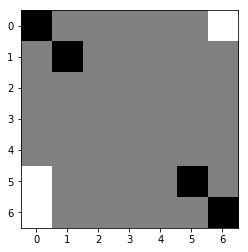

((5, 0), (5, 1)): n_v:  1541 q_all:-0.026864 q:-0.032846 q_m:-0.000000 p:0.266725
((0, 6), (1, 5)): n_v:  1332 q_all:-0.023266 q:-0.027865 q_m:-0.000000 p:0.205881
((5, 0), (4, 1)): n_v:   874 q_all:-0.026694 q:-0.033582 q_m:-0.000000 p:0.150508
((5, 0), (6, 1)): n_v:   184 q_all:-0.029957 q:-0.040308 q_m:-0.000000 p:0.034699
((0, 6), (1, 6)): n_v:    89 q_all:-0.025519 q:-0.035041 q_m:-0.000000 p:0.014886
((5, 0), (4, 0)): n_v:    74 q_all:-0.020194 q:-0.041450 q_m:-0.000000 p:0.010169
((0, 6), (0, 5)): n_v:    26 q_all:-0.029827 q:-0.038181 q_m:-0.000000 p:0.004874
((5, 0), (4, 2)): n_v:    25 q_all:-0.037763 q:-0.058659 q_m:-0.033333 p:0.005637
((5, 0), (3, 1)): n_v:    10 q_all:-0.047740 q:-0.036696 q_m:-0.033333 p:0.002865
((5, 0), (5, 2)): n_v:     7 q_all:-0.043203 q:-0.057985 q_m:-0.033333 p:0.002047
((5, 0), (3, 2)): n_v:     5 q_all:-0.039043 q:-0.045781 q_m:-0.033333 p:0.001375
((5, 0), (3, 0)): n_v:     3 q_all:-0.037237 q:-0.050312 q_m:-0.033333 p:0.000904
((6, 0), (4, 2))

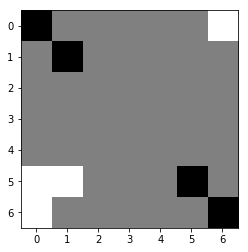

((5, 5), (4, 4)): n_v:  1991 q_all:+0.026033 q:+0.016608 q_m:+0.033333 p:0.523286
((1, 1), (2, 2)): n_v:   985 q_all:+0.028765 q:+0.016162 q_m:+0.033333 p:0.244312
((5, 5), (5, 4)): n_v:   260 q_all:+0.017301 q:-0.007174 q_m:+0.033333 p:0.080856
((1, 1), (2, 1)): n_v:   224 q_all:+0.040145 q:-0.001339 q_m:+0.033333 p:0.041483
((5, 5), (4, 5)): n_v:   112 q_all:+0.018821 q:-0.011780 q_m:+0.033333 p:0.034000
((1, 1), (1, 2)): n_v:    60 q_all:+0.016240 q:-0.007714 q_m:+0.033333 p:0.019065
((5, 5), (6, 5)): n_v:    31 q_all:+0.010490 q:-0.009628 q_m:+0.033333 p:0.010881
((5, 5), (6, 4)): n_v:    18 q_all:+0.028828 q:-0.008105 q_m:+0.033333 p:0.004613
((0, 0), (0, 1)): n_v:    14 q_all:+0.015352 q:+0.004663 q_m:+0.033333 p:0.004492
((5, 5), (5, 6)): n_v:     9 q_all:+0.006739 q:-0.016206 q_m:+0.033333 p:0.003628
((1, 1), (2, 0)): n_v:     8 q_all:+0.033099 q:+0.019758 q_m:+0.033333 p:0.002003
((5, 5), (4, 6)): n_v:     8 q_all:+0.012954 q:+0.002769 q_m:+0.033333 p:0.002788
((1, 1), (0, 2))

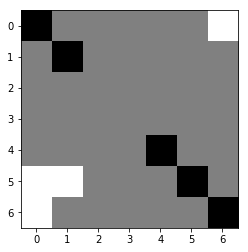

((0, 6), (1, 5)): n_v:  1738 q_all:-0.018572 q:-0.034484 q_m:-0.000000 p:0.396416
((5, 1), (4, 2)): n_v:   929 q_all:-0.027564 q:-0.051660 q_m:-0.000000 p:0.254831
((5, 1), (5, 2)): n_v:   757 q_all:-0.028891 q:-0.043253 q_m:-0.000000 p:0.213094
((5, 0), (4, 1)): n_v:    82 q_all:-0.035051 q:-0.044321 q_m:-0.000000 p:0.025674
((0, 6), (1, 6)): n_v:    72 q_all:-0.023229 q:-0.040876 q_m:-0.000000 p:0.018307
((5, 1), (3, 3)): n_v:    39 q_all:-0.022782 q:-0.035557 q_m:+0.033333 p:0.009742
((5, 0), (6, 1)): n_v:    36 q_all:-0.020566 q:-0.026236 q_m:-0.000000 p:0.008611
((5, 1), (6, 2)): n_v:    24 q_all:-0.026838 q:-0.036194 q_m:-0.000000 p:0.006621
((5, 0), (3, 1)): n_v:    22 q_all:-0.028053 q:-0.035519 q_m:-0.033333 p:0.006107
((5, 0), (4, 0)): n_v:    13 q_all:-0.032036 q:-0.050438 q_m:-0.000000 p:0.003777
((5, 1), (4, 3)): n_v:    11 q_all:-0.043558 q:-0.047184 q_m:+0.033333 p:0.003854
((0, 6), (0, 5)): n_v:    10 q_all:-0.029660 q:-0.040470 q_m:-0.000000 p:0.003095
((5, 0), (5, 2))

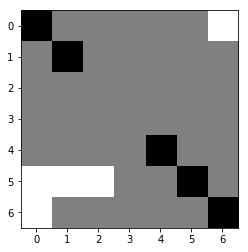

((4, 4), (5, 3)): n_v:  1303 q_all:+0.033096 q:+0.045559 q_m:+0.100000 p:0.455350
((4, 4), (3, 5)): n_v:   762 q_all:+0.031524 q:+0.021936 q_m:+0.033333 p:0.274224
((4, 4), (4, 3)): n_v:   208 q_all:+0.052397 q:+0.052474 q_m:+0.100000 p:0.047285
((4, 4), (4, 2)): n_v:   114 q_all:+0.023158 q:+0.055055 q_m:+0.133333 p:0.047432
((4, 4), (6, 5)): n_v:    47 q_all:+0.008586 q:-0.017747 q_m:-0.000000 p:0.023874
((4, 4), (6, 2)): n_v:    38 q_all:-0.024984 q:+0.056242 q_m:+0.133333 p:0.027401
((1, 1), (2, 1)): n_v:    30 q_all:+0.039888 q:+0.013064 q_m:+0.033333 p:0.009220
((1, 1), (2, 2)): n_v:    25 q_all:+0.015116 q:+0.030631 q_m:+0.033333 p:0.011704
((4, 4), (5, 4)): n_v:    20 q_all:+0.033795 q:-0.000526 q_m:+0.033333 p:0.007214
((4, 4), (6, 4)): n_v:    19 q_all:+0.017941 q:-0.011274 q_m:-0.000000 p:0.008741
((4, 4), (4, 5)): n_v:    19 q_all:-0.048949 q:-0.005625 q_m:+0.033333 p:0.016835
((4, 4), (3, 3)): n_v:    17 q_all:+0.023274 q:+0.030504 q_m:+0.033333 p:0.007022
((0, 0), (0, 1))

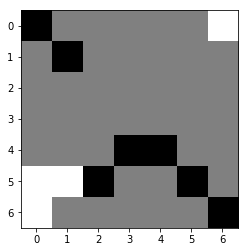

((5, 1), (5, 3)): n_v:  1345 q_all:-0.014206 q:-0.029732 q_m:+0.100000 p:0.353814
((5, 1), (4, 2)): n_v:   844 q_all:-0.064412 q:-0.042564 q_m:+0.066667 p:0.509872
((5, 1), (3, 3)): n_v:    74 q_all:-0.048177 q:-0.044436 q_m:+0.033333 p:0.036897
((5, 0), (4, 2)): n_v:    30 q_all:-0.070849 q:-0.043378 q_m:+0.033333 p:0.019543
((6, 0), (4, 2)): n_v:    29 q_all:-0.069490 q:-0.053561 q_m:+0.033333 p:0.018871
((5, 0), (3, 2)): n_v:    23 q_all:-0.049898 q:-0.059935 q_m:-0.033333 p:0.012043
((5, 1), (3, 2)): n_v:    13 q_all:-0.031056 q:-0.059163 q_m:-0.033333 p:0.005004
((5, 1), (6, 3)): n_v:    11 q_all:-0.044778 q:-0.046481 q_m:-0.033333 p:0.005140
((5, 0), (6, 1)): n_v:    10 q_all:-0.044690 q:-0.043536 q_m:-0.000000 p:0.004710
((0, 6), (1, 5)): n_v:     7 q_all:-0.140475 q:-0.063224 q_m:-0.066667 p:0.008767
((5, 0), (4, 1)): n_v:     5 q_all:-0.063507 q:-0.049031 q_m:-0.000000 p:0.002969
((5, 0), (3, 1)): n_v:     2 q_all:-0.087904 q:-0.077297 q_m:-0.100000 p:0.002206
((5, 1), (6, 2))

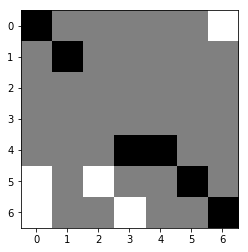

((4, 3), (5, 1)): n_v:  1001 q_all:+0.056262 q:+0.125763 q_m:+0.233333 p:0.750363
((4, 3), (6, 2)): n_v:   976 q_all:+0.158013 q:+0.066298 q_m:+0.166667 p:0.024724
((4, 3), (5, 3)): n_v:   103 q_all:+0.070324 q:+0.070759 q_m:+0.200000 p:0.067074
((4, 4), (6, 2)): n_v:    70 q_all:+0.161398 q:+0.072724 q_m:+0.166667 p:0.001189
((4, 3), (6, 1)): n_v:    19 q_all:+0.033868 q:+0.092418 q_m:+0.233333 p:0.016936
((4, 3), (6, 4)): n_v:    17 q_all:+0.008354 q:+0.026376 q_m:+0.100000 p:0.019395
((4, 3), (4, 1)): n_v:     9 q_all:+0.063261 q:+0.075210 q_m:+0.166667 p:0.006680
((4, 3), (6, 5)): n_v:     7 q_all:-0.028535 q:-0.013298 q_m:+0.033333 p:0.010732
((4, 4), (3, 5)): n_v:     3 q_all:+0.004677 q:+0.041459 q_m:+0.066667 p:0.004133
((4, 3), (5, 4)): n_v:     3 q_all:-0.015654 q:+0.034223 q_m:+0.133333 p:0.003681
((4, 3), (4, 5)): n_v:     3 q_all:-0.043458 q:-0.013475 q_m:+0.033333 p:0.005696
((5, 5), (6, 5)): n_v:     0 q_all:+0.025648 q:+0.025648 q_m:+0.066667 p:0.000070
((4, 3), (4, 2))

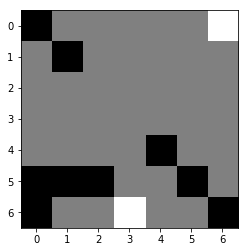

((6, 3), (6, 1)): n_v:  2529 q_all:-0.049641 q:-0.009206 q_m:+0.033333 p:0.539285
((6, 3), (4, 1)): n_v:   316 q_all:-0.074781 q:-0.077160 q_m:-0.033333 p:0.114529
((6, 3), (6, 5)): n_v:   249 q_all:-0.180297 q:-0.086948 q_m:-0.100000 p:0.244905
((6, 3), (4, 5)): n_v:    96 q_all:-0.185154 q:-0.097725 q_m:-0.100000 p:0.097113
((6, 3), (5, 4)): n_v:     6 q_all:-0.065394 q:-0.052690 q_m:-0.066667 p:0.002068
((6, 3), (5, 3)): n_v:     4 q_all:-0.051735 q:-0.094600 q_m:-0.066667 p:0.000833
((0, 6), (2, 4)): n_v:     0 q_all:-0.126507 q:-0.126507 q_m:-0.233333 p:0.000002
((0, 6), (0, 5)): n_v:     0 q_all:-0.120241 q:-0.120241 q_m:-0.200000 p:0.000233
((6, 3), (6, 4)): n_v:     0 q_all:-0.075702 q:-0.075702 q_m:-0.133333 p:0.000201
((6, 3), (4, 3)): n_v:     0 q_all:-0.096024 q:-0.096024 q_m:-0.100000 p:0.000189
((0, 6), (2, 6)): n_v:     0 q_all:-0.132466 q:-0.132466 q_m:-0.233333 p:0.000001
((0, 6), (2, 5)): n_v:     0 q_all:-0.129050 q:-0.129050 q_m:-0.233333 p:0.000013
((0, 6), (1, 6))

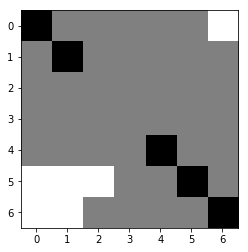

((4, 4), (6, 2)): n_v:  3142 q_all:+0.067873 q:+0.053521 q_m:+0.166667 p:0.371451
((4, 4), (5, 3)): n_v:  1119 q_all:+0.021833 q:+0.018686 q_m:+0.066667 p:0.382051
((4, 4), (3, 5)): n_v:   158 q_all:+0.000707 q:-0.004920 q_m:-0.000000 p:0.070378
((4, 4), (6, 4)): n_v:    89 q_all:-0.019757 q:-0.039393 q_m:-0.033333 p:0.048428
((5, 5), (6, 4)): n_v:    72 q_all:-0.031555 q:-0.018064 q_m:-0.000000 p:0.043697
((4, 4), (4, 2)): n_v:    34 q_all:-0.003912 q:+0.007835 q_m:+0.100000 p:0.015904
((4, 4), (4, 3)): n_v:    32 q_all:+0.022872 q:+0.024416 q_m:+0.066667 p:0.010980
((1, 1), (0, 2)): n_v:    14 q_all:-0.012472 q:-0.028014 q_m:-0.000000 p:0.007234
((1, 1), (2, 1)): n_v:    12 q_all:+0.005555 q:-0.016503 q_m:-0.000000 p:0.004976
((1, 1), (2, 2)): n_v:    10 q_all:-0.011401 q:-0.005312 q_m:-0.000000 p:0.005283
((6, 6), (6, 4)): n_v:     9 q_all:-0.078828 q:-0.038168 q_m:-0.033333 p:0.007960
((4, 4), (4, 5)): n_v:     9 q_all:-0.061984 q:-0.034461 q_m:-0.000000 p:0.006646
((4, 4), (5, 4))

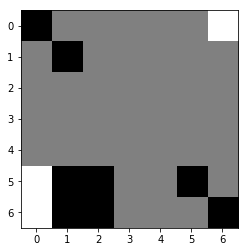

((5, 0), (4, 1)): n_v:  3980 q_all:-0.073263 q:-0.068809 q_m:-0.000000 p:0.724135
((6, 0), (4, 1)): n_v:   313 q_all:-0.092526 q:-0.100420 q_m:-0.033333 p:0.084467
((5, 0), (4, 2)): n_v:   295 q_all:-0.086772 q:-0.133248 q_m:-0.033333 p:0.071834
((0, 6), (1, 5)): n_v:   193 q_all:-0.078805 q:-0.120602 q_m:-0.133333 p:0.039929
((6, 0), (4, 2)): n_v:    96 q_all:-0.108472 q:-0.116120 q_m:-0.033333 p:0.033080
((5, 0), (4, 0)): n_v:    29 q_all:-0.155363 q:-0.154965 q_m:-0.066667 p:0.016452
((5, 0), (3, 2)): n_v:    25 q_all:-0.118173 q:-0.145448 q_m:-0.166667 p:0.009778
((5, 0), (3, 1)): n_v:    18 q_all:-0.121103 q:-0.160314 q_m:-0.166667 p:0.007241
((0, 6), (0, 5)): n_v:    17 q_all:-0.083022 q:-0.141979 q_m:-0.133333 p:0.003947
((0, 6), (1, 6)): n_v:     4 q_all:-0.097836 q:-0.134311 q_m:-0.133333 p:0.001458
((6, 0), (4, 0)): n_v:     4 q_all:-0.144772 q:-0.213242 q_m:-0.100000 p:0.002506
((0, 6), (2, 4)): n_v:     3 q_all:-0.099689 q:-0.148393 q_m:-0.166667 p:0.001135
((0, 6), (2, 5))

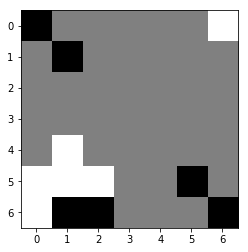

((6, 2), (4, 0)): n_v:  4085 q_all:+0.073854 q:+0.070662 q_m:+0.200000 p:0.621471
((5, 5), (4, 4)): n_v:   484 q_all:+0.026711 q:+0.034306 q_m:+0.033333 p:0.170716
((6, 6), (4, 6)): n_v:   207 q_all:+0.037185 q:+0.016871 q_m:-0.000000 p:0.063994
((1, 1), (2, 2)): n_v:   151 q_all:+0.037765 q:+0.035349 q_m:+0.033333 p:0.046321
((6, 2), (5, 3)): n_v:    74 q_all:+0.021652 q:+0.030968 q_m:+0.100000 p:0.027895
((6, 1), (4, 2)): n_v:    38 q_all:+0.040345 q:+0.060924 q_m:+0.200000 p:0.011181
((6, 1), (4, 0)): n_v:    36 q_all:+0.043200 q:+0.079972 q_m:+0.200000 p:0.009952
((5, 5), (4, 6)): n_v:    27 q_all:+0.048503 q:+0.027067 q_m:+0.033333 p:0.007188
((6, 2), (4, 4)): n_v:    24 q_all:+0.012216 q:+0.017610 q_m:-0.000000 p:0.010310
((0, 0), (2, 0)): n_v:    17 q_all:+0.020774 q:+0.037169 q_m:-0.000000 p:0.006678
((1, 1), (2, 0)): n_v:    14 q_all:+0.039600 q:+0.039910 q_m:+0.033333 p:0.004433
((6, 2), (6, 3)): n_v:     9 q_all:+0.014919 q:+0.037880 q_m:+0.100000 p:0.003932
((6, 6), (4, 4))

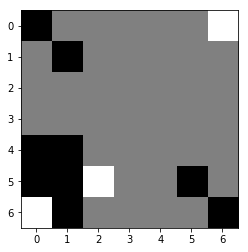

((5, 2), (6, 2)): n_v:  4416 q_all:-0.068252 q:-0.089098 q_m:-0.033333 p:0.674356
((5, 2), (4, 2)): n_v:   619 q_all:-0.108707 q:-0.139698 q_m:-0.033333 p:0.200065
((5, 2), (3, 1)): n_v:   216 q_all:-0.106817 q:-0.094126 q_m:-0.066667 p:0.068299
((6, 0), (6, 2)): n_v:    61 q_all:-0.122997 q:-0.102799 q_m:-0.066667 p:0.023543
((5, 2), (3, 0)): n_v:    14 q_all:-0.110714 q:-0.136172 q_m:-0.066667 p:0.004807
((5, 2), (5, 3)): n_v:    12 q_all:-0.132566 q:-0.138904 q_m:-0.166667 p:0.005345
((5, 2), (4, 3)): n_v:    11 q_all:-0.119692 q:-0.115747 q_m:-0.166667 p:0.004305
((6, 0), (4, 2)): n_v:    10 q_all:-0.111276 q:-0.133546 q_m:-0.066667 p:0.003468
((5, 2), (6, 4)): n_v:    10 q_all:-0.113074 q:-0.108369 q_m:-0.133333 p:0.003477
((0, 6), (1, 5)): n_v:    10 q_all:-0.098595 q:-0.113697 q_m:-0.166667 p:0.002874
((5, 2), (5, 4)): n_v:     5 q_all:-0.130257 q:-0.119318 q_m:-0.133333 p:0.002234
((5, 2), (4, 4)): n_v:     5 q_all:-0.106362 q:-0.119356 q_m:-0.133333 p:0.001875
((5, 2), (6, 3))

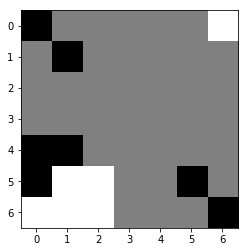

((4, 1), (4, 2)): n_v:  3873 q_all:+0.074715 q:+0.065088 q_m:+0.200000 p:0.509017
((5, 5), (4, 4)): n_v:   880 q_all:+0.036124 q:+0.025104 q_m:+0.066667 p:0.254951
((1, 1), (2, 2)): n_v:   265 q_all:+0.012178 q:+0.004798 q_m:+0.066667 p:0.103034
((4, 1), (5, 3)): n_v:   185 q_all:+0.022723 q:+0.021026 q_m:+0.166667 p:0.064046
((5, 5), (6, 3)): n_v:   173 q_all:+0.105066 q:+0.041879 q_m:+0.166667 p:0.001198
((5, 5), (5, 4)): n_v:    40 q_all:+0.026184 q:-0.002234 q_m:+0.066667 p:0.013373
((5, 5), (5, 3)): n_v:    27 q_all:+0.042508 q:+0.038905 q_m:+0.166667 p:0.007237
((4, 1), (6, 3)): n_v:    16 q_all:+0.016085 q:+0.028251 q_m:+0.166667 p:0.005784
((4, 0), (3, 1)): n_v:    14 q_all:+0.003742 q:+0.003594 q_m:+0.066667 p:0.006107
((1, 1), (1, 2)): n_v:     9 q_all:+0.026414 q:-0.009574 q_m:+0.066667 p:0.002896
((4, 0), (4, 2)): n_v:     6 q_all:+0.044759 q:+0.054916 q_m:+0.166667 p:0.001589
((5, 0), (4, 2)): n_v:     5 q_all:+0.006408 q:+0.012839 q_m:+0.166667 p:0.002221
((5, 5), (6, 5))

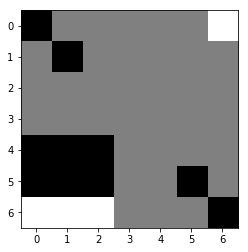

((6, 2), (5, 3)): n_v:  4355 q_all:-0.088855 q:-0.081720 q_m:-0.033333 p:0.850592
((6, 1), (5, 3)): n_v:   213 q_all:-0.111600 q:-0.104822 q_m:-0.066667 p:0.062287
((6, 2), (5, 4)): n_v:   163 q_all:-0.078264 q:-0.077411 q_m:-0.133333 p:0.024391
((6, 2), (4, 4)): n_v:   134 q_all:-0.069704 q:-0.076253 q_m:-0.133333 p:0.015233
((6, 2), (4, 3)): n_v:   115 q_all:-0.062853 q:-0.127665 q_m:-0.066667 p:0.009663
((0, 6), (1, 5)): n_v:    78 q_all:-0.091978 q:-0.118682 q_m:-0.166667 p:0.016437
((6, 2), (6, 4)): n_v:    48 q_all:-0.072551 q:-0.056952 q_m:-0.133333 p:0.006063
((6, 2), (6, 3)): n_v:    19 q_all:-0.145926 q:-0.127466 q_m:-0.100000 p:0.008582
((6, 1), (4, 3)): n_v:    18 q_all:-0.104578 q:-0.123715 q_m:-0.066667 p:0.004795
((0, 6), (1, 6)): n_v:     2 q_all:-0.096228 q:-0.132030 q_m:-0.166667 p:0.000562
((0, 6), (0, 5)): n_v:     1 q_all:-0.116836 q:-0.139956 q_m:-0.166667 p:0.000554
((6, 1), (6, 3)): n_v:     0 q_all:-0.161917 q:-0.161917 q_m:-0.133333 p:0.000476
((0, 6), (2, 4))

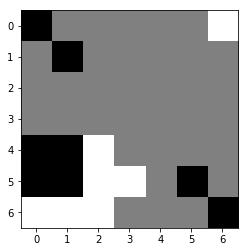

((5, 5), (6, 3)): n_v:  3357 q_all:+0.119032 q:+0.095359 q_m:+0.233333 p:0.243626
((5, 5), (4, 3)): n_v:   677 q_all:+0.097257 q:+0.115060 q_m:+0.233333 p:0.109953
((4, 1), (6, 3)): n_v:   593 q_all:+0.029388 q:+0.035608 q_m:+0.233333 p:0.262244
((5, 1), (6, 3)): n_v:   332 q_all:-0.005423 q:+0.016248 q_m:+0.233333 p:0.194115
((5, 1), (4, 3)): n_v:   151 q_all:+0.009705 q:+0.034006 q_m:+0.233333 p:0.079036
((4, 1), (4, 3)): n_v:   118 q_all:+0.042016 q:+0.051343 q_m:+0.233333 p:0.045943
((5, 5), (5, 4)): n_v:    43 q_all:+0.043977 q:+0.042210 q_m:+0.133333 p:0.016390
((4, 0), (3, 1)): n_v:    18 q_all:+0.066799 q:+0.029188 q_m:+0.133333 p:0.005227
((1, 1), (0, 3)): n_v:    12 q_all:+0.008792 q:+0.002160 q_m:+0.033333 p:0.006425
((4, 1), (3, 2)): n_v:    11 q_all:+0.038849 q:+0.035878 q_m:+0.133333 p:0.004597
((5, 5), (4, 4)): n_v:    10 q_all:+0.050550 q:+0.061223 q_m:+0.133333 p:0.003494
((1, 1), (2, 3)): n_v:     9 q_all:+0.002515 q:+0.013437 q_m:+0.033333 p:0.005433
((5, 5), (6, 4))

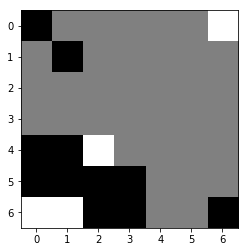

((4, 2), (4, 3)): n_v:  3122 q_all:-0.099465 q:-0.141326 q_m:-0.066667 p:0.443553
((4, 2), (3, 1)): n_v:  1037 q_all:-0.127142 q:-0.134953 q_m:-0.066667 p:0.275570
((4, 2), (6, 4)): n_v:   315 q_all:-0.134998 q:-0.135174 q_m:-0.100000 p:0.094828
((4, 2), (5, 4)): n_v:   283 q_all:-0.142693 q:-0.131630 q_m:-0.100000 p:0.095137
((4, 2), (4, 4)): n_v:    86 q_all:-0.141209 q:-0.133198 q_m:-0.166667 p:0.028305
((4, 2), (2, 0)): n_v:    83 q_all:-0.100501 q:-0.102088 q_m:-0.166667 p:0.012145
((4, 2), (2, 1)): n_v:    39 q_all:-0.097308 q:-0.133714 q_m:-0.166667 p:0.005182
((6, 1), (4, 3)): n_v:    33 q_all:-0.149289 q:-0.130298 q_m:-0.100000 p:0.012300
((4, 2), (2, 3)): n_v:    19 q_all:-0.153933 q:-0.177264 q_m:-0.233333 p:0.007638
((4, 2), (3, 0)): n_v:    18 q_all:-0.104476 q:-0.165427 q_m:-0.100000 p:0.003075
((0, 6), (1, 5)): n_v:    14 q_all:-0.169535 q:-0.162260 q_m:-0.200000 p:0.006814
((4, 2), (2, 2)): n_v:    13 q_all:-0.114157 q:-0.131765 q_m:-0.166667 p:0.002876
((4, 2), (3, 2))

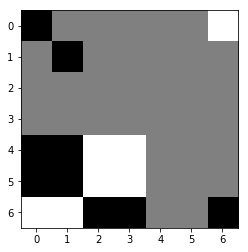

((6, 3), (5, 4)): n_v:  2967 q_all:+0.096262 q:+0.107163 q_m:+0.233333 p:0.597733
((4, 1), (3, 2)): n_v:  1478 q_all:+0.099675 q:+0.084196 q_m:+0.233333 p:0.274873
((6, 6), (5, 4)): n_v:   146 q_all:+0.082517 q:+0.072269 q_m:+0.200000 p:0.038522
((6, 6), (5, 5)): n_v:    45 q_all:+0.041670 q:+0.057926 q_m:+0.100000 p:0.020499
((4, 0), (3, 1)): n_v:    21 q_all:+0.075432 q:+0.048604 q_m:+0.166667 p:0.006229
((1, 1), (1, 2)): n_v:    19 q_all:+0.047385 q:+0.037075 q_m:+0.100000 p:0.008333
((6, 2), (5, 4)): n_v:    17 q_all:+0.050558 q:+0.052698 q_m:+0.200000 p:0.006766
((6, 3), (6, 4)): n_v:    12 q_all:+0.042338 q:+0.066961 q_m:+0.166667 p:0.005580
((6, 6), (5, 6)): n_v:    11 q_all:+0.056754 q:+0.064957 q_m:+0.100000 p:0.004423
((1, 1), (2, 2)): n_v:     8 q_all:+0.054540 q:+0.052367 q_m:+0.100000 p:0.003247
((6, 6), (4, 4)): n_v:     5 q_all:+0.100203 q:+0.083175 q_m:+0.200000 p:0.000998
((1, 1), (3, 3)): n_v:     4 q_all:+0.102047 q:+0.073374 q_m:+0.200000 p:0.000838
((6, 6), (6, 5))

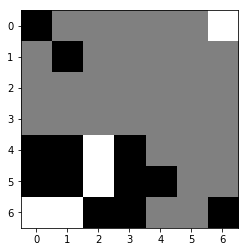

((4, 2), (6, 4)): n_v:  2391 q_all:-0.069736 q:-0.063831 q_m:-0.033333 p:0.305719
((4, 2), (4, 4)): n_v:   701 q_all:-0.111083 q:-0.076852 q_m:-0.033333 p:0.224330
((4, 2), (3, 1)): n_v:   669 q_all:-0.097690 q:-0.109177 q_m:-0.066667 p:0.172347
((5, 2), (4, 4)): n_v:   180 q_all:-0.160928 q:-0.108833 q_m:-0.033333 p:0.099373
((4, 2), (2, 0)): n_v:   127 q_all:-0.069783 q:-0.089151 q_m:-0.166667 p:0.016337
((5, 2), (6, 4)): n_v:   118 q_all:-0.165219 q:-0.110564 q_m:-0.033333 p:0.067900
((4, 2), (2, 2)): n_v:    83 q_all:-0.086500 q:-0.109393 q_m:-0.166667 p:0.017045
((0, 6), (1, 5)): n_v:    65 q_all:-0.096662 q:-0.142486 q_m:-0.200000 p:0.016643
((4, 2), (3, 2)): n_v:    51 q_all:-0.116282 q:-0.130502 q_m:-0.066667 p:0.017864
((5, 2), (3, 1)): n_v:    34 q_all:-0.148348 q:-0.139537 q_m:-0.100000 p:0.016872
((4, 2), (2, 4)): n_v:    26 q_all:-0.136809 q:-0.165411 q_m:-0.233333 p:0.011467
((4, 2), (3, 0)): n_v:    20 q_all:-0.093513 q:-0.157314 q_m:-0.100000 p:0.004705
((4, 2), (3, 4))

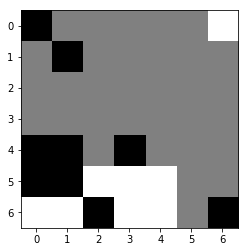

((4, 1), (4, 2)): n_v:  3535 q_all:+0.103719 q:+0.086243 q_m:+0.200000 p:0.284012
((4, 3), (5, 5)): n_v:   297 q_all:+0.059198 q:+0.054323 q_m:+0.166667 p:0.089156
((4, 3), (4, 4)): n_v:   235 q_all:+0.035951 q:+0.032727 q_m:+0.200000 p:0.097402
((4, 3), (6, 5)): n_v:    35 q_all:+0.068887 q:+0.084617 q_m:+0.166667 p:0.009033
((1, 1), (2, 2)): n_v:    35 q_all:+0.002940 q:-0.010448 q_m:+0.066667 p:0.020574
((6, 6), (5, 5)): n_v:    34 q_all:+0.058323 q:+0.034002 q_m:+0.200000 p:0.010473
((6, 6), (6, 5)): n_v:     9 q_all:+0.075594 q:+0.073834 q_m:+0.200000 p:0.002180
((4, 3), (4, 5)): n_v:     7 q_all:+0.018361 q:+0.036471 q_m:+0.100000 p:0.003491
((6, 2), (4, 2)): n_v:     4 q_all:-0.014087 q:+0.001870 q_m:+0.166667 p:0.002599
((6, 2), (4, 4)): n_v:     3 q_all:+0.043495 q:+0.018623 q_m:+0.166667 p:0.001400
((5, 0), (4, 2)): n_v:     3 q_all:-0.027942 q:-0.016332 q_m:+0.166667 p:0.002298
((4, 0), (4, 2)): n_v:     3 q_all:+0.045881 q:+0.045116 q_m:+0.166667 p:0.001416
((6, 6), (4, 4))

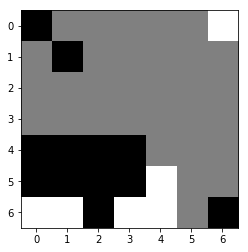

((5, 4), (4, 4)): n_v:  4293 q_all:-0.065323 q:-0.065075 q_m:-0.033333 p:0.538339
((5, 4), (3, 2)): n_v:   175 q_all:-0.104889 q:-0.121625 q_m:-0.000000 p:0.051350
((5, 4), (5, 5)): n_v:   159 q_all:-0.131414 q:-0.079835 q_m:-0.100000 p:0.066357
((6, 4), (4, 4)): n_v:   137 q_all:-0.116795 q:-0.102440 q_m:-0.066667 p:0.048552
((6, 3), (4, 4)): n_v:   130 q_all:-0.123318 q:-0.119441 q_m:-0.066667 p:0.049822
((6, 3), (5, 5)): n_v:    76 q_all:-0.135965 q:-0.124900 q_m:-0.133333 p:0.033345
((5, 4), (3, 3)): n_v:    71 q_all:-0.117608 q:-0.136617 q_m:-0.066667 p:0.025523
((5, 4), (6, 5)): n_v:    46 q_all:-0.132197 q:-0.076805 q_m:-0.100000 p:0.019230
((6, 4), (5, 6)): n_v:    26 q_all:-0.124225 q:-0.091077 q_m:-0.133333 p:0.010158
((6, 4), (4, 6)): n_v:    22 q_all:-0.165247 q:-0.146653 q_m:-0.200000 p:0.012569
((6, 3), (6, 5)): n_v:    21 q_all:-0.141913 q:-0.123050 q_m:-0.133333 p:0.010161
((0, 6), (1, 5)): n_v:    21 q_all:-0.118665 q:-0.105129 q_m:-0.166667 p:0.007805
((5, 4), (4, 5))

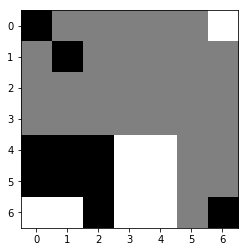

((6, 6), (5, 5)): n_v:  4698 q_all:+0.078836 q:+0.116457 q_m:+0.266667 p:0.913009
((4, 2), (3, 3)): n_v:  1044 q_all:+0.112206 q:+0.065936 q_m:+0.200000 p:0.058680
((6, 6), (4, 5)): n_v:    22 q_all:+0.031818 q:+0.050770 q_m:+0.166667 p:0.008619
((6, 6), (6, 5)): n_v:    18 q_all:+0.035316 q:+0.091307 q_m:+0.200000 p:0.006999
((6, 6), (5, 6)): n_v:    14 q_all:+0.024964 q:+0.024079 q_m:+0.066667 p:0.006137
((6, 6), (4, 6)): n_v:     3 q_all:+0.033324 q:+0.057626 q_m:+0.033333 p:0.001363
((4, 1), (3, 2)): n_v:     2 q_all:+0.039869 q:+0.044381 q_m:+0.133333 p:0.000870
((4, 0), (3, 1)): n_v:     1 q_all:+0.033535 q:+0.014115 q_m:+0.066667 p:0.000514
((5, 0), (3, 2)): n_v:     0 q_all:-0.046369 q:-0.046369 q_m:+0.100000 p:0.000002
((1, 1), (1, 3)): n_v:     0 q_all:+0.025025 q:+0.025025 q_m:+0.033333 p:0.000002
((1, 1), (2, 1)): n_v:     0 q_all:+0.009305 q:+0.009305 q_m:+0.066667 p:0.000087
((4, 2), (2, 1)): n_v:     0 q_all:-0.044329 q:-0.044329 q_m:+0.033333 p:0.000000
((5, 0), (3, 0))

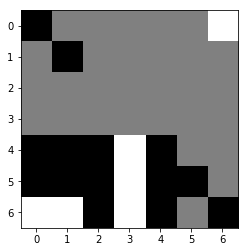

((4, 3), (6, 5)): n_v:  5105 q_all:-0.078154 q:-0.025951 q_m:-0.000000 p:0.905417
((4, 3), (4, 5)): n_v:   167 q_all:-0.090475 q:-0.116782 q_m:-0.066667 p:0.038092
((6, 3), (4, 5)): n_v:   160 q_all:-0.071479 q:-0.151857 q_m:-0.066667 p:0.024228
((4, 3), (3, 3)): n_v:    21 q_all:-0.042535 q:-0.141372 q_m:-0.100000 p:0.000767
((5, 3), (6, 5)): n_v:    20 q_all:-0.150363 q:-0.107030 q_m:-0.000000 p:0.009232
((6, 3), (6, 5)): n_v:    20 q_all:-0.101665 q:-0.092813 q_m:-0.000000 p:0.005606
((4, 3), (3, 1)): n_v:    15 q_all:-0.099242 q:-0.086376 q_m:-0.066667 p:0.003900
((4, 3), (2, 1)): n_v:    12 q_all:-0.083310 q:-0.110879 q_m:-0.200000 p:0.002301
((4, 3), (3, 5)): n_v:     9 q_all:-0.152435 q:-0.142861 q_m:-0.200000 p:0.004210
((5, 3), (4, 5)): n_v:     4 q_all:-0.165041 q:-0.162521 q_m:-0.066667 p:0.002450
((4, 3), (2, 5)): n_v:     3 q_all:-0.168738 q:-0.172810 q_m:-0.266667 p:0.002037
((5, 3), (3, 1)): n_v:     1 q_all:-0.137950 q:-0.120509 q_m:-0.066667 p:0.000795
((5, 3), (3, 4))

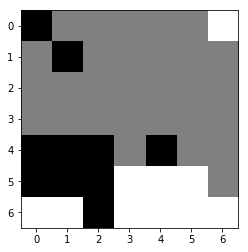

((4, 4), (5, 6)): n_v:  5304 q_all:+0.105006 q:+0.113021 q_m:+0.200000 p:0.843836
((4, 2), (4, 3)): n_v:   117 q_all:+0.038930 q:+0.029701 q_m:+0.166667 p:0.049052
((4, 4), (4, 5)): n_v:    14 q_all:+0.010481 q:+0.038150 q_m:+0.166667 p:0.007759
((5, 0), (3, 2)): n_v:     0 q_all:-0.156513 q:-0.156513 q_m:-0.000000 p:0.000000
((5, 1), (4, 3)): n_v:     0 q_all:-0.116751 q:-0.116751 q_m:+0.133333 p:0.000043
((1, 1), (2, 1)): n_v:     0 q_all:-0.068341 q:-0.068341 q_m:+0.033333 p:0.000477
((4, 4), (3, 5)): n_v:     0 q_all:-0.000680 q:-0.000680 q_m:+0.033333 p:0.000021
((1, 1), (1, 3)): n_v:     0 q_all:-0.054325 q:-0.054325 q_m:-0.000000 p:0.000000
((4, 1), (4, 3)): n_v:     0 q_all:-0.055526 q:-0.055526 q_m:+0.133333 p:0.000238
((4, 4), (2, 2)): n_v:     0 q_all:-0.056128 q:-0.056128 q_m:-0.000000 p:0.000051
((4, 2), (2, 1)): n_v:     0 q_all:-0.085441 q:-0.085441 q_m:-0.000000 p:0.000006
((5, 0), (3, 0)): n_v:     0 q_all:-0.156630 q:-0.156630 q_m:-0.000000 p:0.000003
((4, 4), (3, 2))

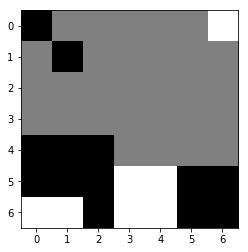

((5, 4), (4, 5)): n_v:  3475 q_all:-0.116288 q:-0.102211 q_m:-0.033333 p:0.426903
((5, 3), (4, 3)): n_v:  2599 q_all:-0.112211 q:-0.116113 q_m:-0.033333 p:0.278523
((5, 3), (4, 4)): n_v:    52 q_all:-0.126838 q:-0.154492 q_m:-0.100000 p:0.008604
((6, 3), (4, 5)): n_v:    38 q_all:-0.171587 q:-0.162862 q_m:-0.066667 p:0.012997
((6, 4), (4, 5)): n_v:    18 q_all:-0.195740 q:-0.175529 q_m:-0.066667 p:0.007710
((6, 1), (4, 3)): n_v:    16 q_all:-0.167023 q:-0.136430 q_m:-0.066667 p:0.005367
((5, 3), (4, 5)): n_v:    15 q_all:-0.184546 q:-0.174102 q_m:-0.066667 p:0.006102
((0, 6), (1, 5)): n_v:     7 q_all:-0.163802 q:-0.147507 q_m:-0.166667 p:0.002378
((6, 4), (4, 3)): n_v:     4 q_all:-0.171335 q:-0.153899 q_m:-0.066667 p:0.001638
((6, 4), (4, 6)): n_v:     4 q_all:-0.203847 q:-0.179620 q_m:-0.066667 p:0.002112
((5, 4), (3, 5)): n_v:     3 q_all:-0.220753 q:-0.199957 q_m:-0.200000 p:0.002067
((6, 3), (4, 3)): n_v:     3 q_all:-0.222477 q:-0.210529 q_m:-0.066667 p:0.001538
((0, 6), (1, 6))

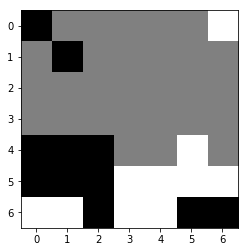

((4, 2), (4, 4)): n_v:  2321 q_all:+0.117717 q:+0.105646 q_m:+0.300000 p:0.699336
((6, 6), (4, 6)): n_v:  2006 q_all:+0.162168 q:+0.132401 q_m:+0.233333 p:0.209750
((6, 6), (4, 4)): n_v:    68 q_all:+0.116574 q:+0.120547 q_m:+0.300000 p:0.020731
((5, 2), (4, 4)): n_v:    36 q_all:+0.018943 q:+0.048582 q_m:+0.300000 p:0.027151
((4, 2), (4, 3)): n_v:    20 q_all:+0.078113 q:+0.093927 q_m:+0.200000 p:0.009775
((6, 5), (4, 6)): n_v:    11 q_all:+0.042416 q:+0.079552 q_m:+0.233333 p:0.007201
((6, 2), (4, 4)): n_v:     9 q_all:+0.056780 q:+0.053744 q_m:+0.300000 p:0.005577
((6, 5), (4, 4)): n_v:     7 q_all:+0.081550 q:+0.076507 q_m:+0.300000 p:0.003596
((4, 2), (2, 4)): n_v:     4 q_all:+0.021933 q:-0.018300 q_m:+0.033333 p:0.003016
((4, 1), (4, 3)): n_v:     1 q_all:-0.017306 q:+0.002903 q_m:+0.166667 p:0.001561
((1, 1), (2, 2)): n_v:     1 q_all:+0.033736 q:-0.003580 q_m:+0.066667 p:0.000894
((5, 0), (3, 2)): n_v:     0 q_all:-0.084069 q:-0.084069 q_m:+0.033333 p:0.000001
((5, 1), (4, 3))

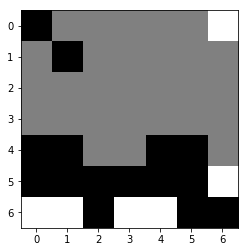

((5, 6), (4, 6)): n_v:  2007 q_all:-0.117180 q:-0.127013 q_m:-0.133333 p:0.641077
((5, 6), (3, 5)): n_v:  1199 q_all:-0.057047 q:-0.135591 q_m:-0.166667 p:0.025445
((6, 0), (4, 2)): n_v:   266 q_all:-0.163620 q:-0.166039 q_m:-0.033333 p:0.146673
((6, 1), (4, 3)): n_v:   162 q_all:-0.119870 q:-0.115528 q_m:-0.033333 p:0.054077
((6, 4), (4, 2)): n_v:    99 q_all:-0.131440 q:-0.120501 q_m:-0.033333 p:0.038265
((6, 4), (4, 6)): n_v:    56 q_all:-0.194968 q:-0.180277 q_m:-0.166667 p:0.039751
((6, 1), (4, 2)): n_v:    27 q_all:-0.167513 q:-0.163033 q_m:-0.033333 p:0.015107
((6, 3), (4, 2)): n_v:    25 q_all:-0.149991 q:-0.143768 q_m:-0.033333 p:0.012156
((5, 6), (3, 4)): n_v:    22 q_all:-0.078494 q:-0.133328 q_m:-0.166667 p:0.002821
((6, 4), (4, 3)): n_v:    21 q_all:-0.156449 q:-0.156479 q_m:-0.033333 p:0.011124
((6, 3), (4, 3)): n_v:    14 q_all:-0.177105 q:-0.181651 q_m:-0.033333 p:0.008937
((0, 6), (2, 6)): n_v:     1 q_all:-0.257043 q:-0.253342 q_m:-0.300000 p:0.001642
((5, 6), (3, 6))

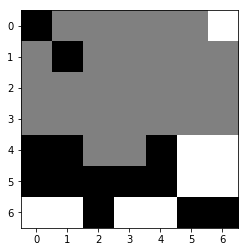

((4, 4), (3, 5)): n_v:  3028 q_all:+0.135928 q:+0.125164 q_m:+0.300000 p:0.471683
((4, 0), (3, 1)): n_v:   176 q_all:+0.019687 q:+0.004093 q_m:+0.166667 p:0.132595
((5, 3), (3, 5)): n_v:   136 q_all:+0.060702 q:+0.099553 q_m:+0.266667 p:0.074171
((4, 4), (3, 6)): n_v:    39 q_all:+0.119000 q:+0.119006 q_m:+0.266667 p:0.009707
((5, 3), (3, 1)): n_v:    34 q_all:-0.057371 q:-0.043589 q_m:+0.133333 p:0.039326
((5, 4), (3, 5)): n_v:    27 q_all:+0.027473 q:+0.052739 q_m:+0.266667 p:0.019534
((1, 1), (3, 1)): n_v:    22 q_all:-0.001551 q:-0.019355 q_m:+0.133333 p:0.019247
((4, 1), (4, 2)): n_v:    13 q_all:+0.045897 q:+0.008884 q_m:+0.166667 p:0.008009
((5, 2), (3, 1)): n_v:    11 q_all:-0.054645 q:-0.034824 q_m:+0.133333 p:0.013169
((4, 4), (3, 3)): n_v:    10 q_all:+0.035095 q:+0.028721 q_m:+0.166667 p:0.006515
((4, 4), (2, 6)): n_v:     6 q_all:+0.054478 q:+0.047819 q_m:+0.133333 p:0.003869
((5, 0), (3, 1)): n_v:     5 q_all:-0.056226 q:-0.049052 q_m:+0.133333 p:0.006395
((1, 1), (2, 0))

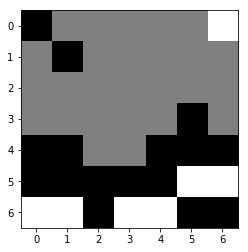

((6, 1), (4, 3)): n_v:  1819 q_all:-0.113834 q:-0.100981 q_m:-0.033333 p:0.087823
((6, 0), (4, 2)): n_v:   892 q_all:-0.173389 q:-0.138472 q_m:-0.033333 p:0.288041
((5, 6), (3, 4)): n_v:   725 q_all:-0.124809 q:-0.108781 q_m:-0.100000 p:0.071775
((6, 3), (4, 2)): n_v:   305 q_all:-0.149579 q:-0.126970 q_m:-0.033333 p:0.065118
((5, 5), (4, 3)): n_v:   268 q_all:-0.240870 q:-0.172539 q_m:-0.033333 p:0.169758
((6, 1), (4, 2)): n_v:   259 q_all:-0.161199 q:-0.127942 q_m:-0.033333 p:0.069017
((6, 4), (4, 2)): n_v:   152 q_all:-0.188126 q:-0.148849 q_m:-0.033333 p:0.059444
((6, 3), (4, 3)): n_v:   101 q_all:-0.181966 q:-0.181139 q_m:-0.033333 p:0.036627
((5, 6), (3, 6)): n_v:    99 q_all:-0.182585 q:-0.130863 q_m:-0.100000 p:0.036282
((6, 4), (4, 3)): n_v:    76 q_all:-0.209851 q:-0.212626 q_m:-0.033333 p:0.037779
((5, 5), (3, 4)): n_v:    52 q_all:-0.223975 q:-0.156885 q_m:-0.100000 p:0.029072
((0, 6), (2, 4)): n_v:    49 q_all:-0.166383 q:-0.199617 q_m:-0.233333 p:0.014277
((5, 5), (3, 6))

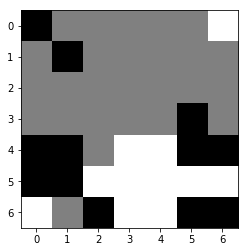

((5, 0), (6, 1)): n_v:  3566 q_all:+0.097459 q:+0.096700 q_m:+0.200000 p:0.280341
((4, 1), (6, 1)): n_v:   237 q_all:+0.047261 q:+0.064398 q_m:+0.166667 p:0.081090
((4, 0), (6, 1)): n_v:   113 q_all:+0.066016 q:+0.057312 q_m:+0.166667 p:0.027342
((4, 1), (4, 2)): n_v:    11 q_all:-0.001211 q:+0.060680 q_m:+0.266667 p:0.006057
((0, 0), (0, 1)): n_v:     7 q_all:-0.043776 q:-0.016008 q_m:+0.066667 p:0.005615
((5, 0), (4, 2)): n_v:     3 q_all:+0.090806 q:+0.045689 q_m:+0.233333 p:0.000449
((5, 1), (3, 1)): n_v:     0 q_all:-0.073995 q:-0.073995 q_m:+0.033333 p:0.000001
((1, 1), (1, 3)): n_v:     0 q_all:-0.030508 q:-0.030508 q_m:+0.033333 p:0.000002
((5, 0), (3, 1)): n_v:     0 q_all:-0.048670 q:-0.048670 q_m:+0.033333 p:0.000010
((5, 0), (3, 2)): n_v:     0 q_all:-0.028220 q:-0.028220 q_m:+0.100000 p:0.000005
((5, 0), (3, 0)): n_v:     0 q_all:-0.048141 q:-0.048141 q_m:+0.033333 p:0.000001
((1, 1), (2, 1)): n_v:     0 q_all:-0.043006 q:-0.043006 q_m:+0.066667 p:0.000006
((3, 5), (1, 3))

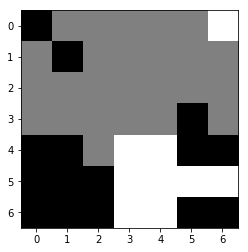

((4, 3), (4, 2)): n_v:  4883 q_all:-0.105374 q:-0.135663 q_m:+0.033333 p:0.438421
((4, 4), (3, 6)): n_v:    74 q_all:-0.118184 q:-0.157484 q_m:-0.000000 p:0.010943
((4, 4), (4, 2)): n_v:    34 q_all:-0.216132 q:-0.199568 q_m:-0.000000 p:0.019927
((4, 3), (3, 1)): n_v:    21 q_all:-0.164645 q:-0.197467 q_m:-0.066667 p:0.007630
((4, 3), (3, 4)): n_v:    17 q_all:-0.192883 q:-0.193920 q_m:-0.033333 p:0.008034
((4, 3), (3, 2)): n_v:    11 q_all:-0.246840 q:-0.222307 q_m:-0.100000 p:0.007802
((5, 6), (3, 6)): n_v:     8 q_all:-0.180078 q:-0.154279 q_m:-0.000000 p:0.003716
((6, 3), (4, 2)): n_v:     6 q_all:-0.291969 q:-0.244224 q_m:-0.000000 p:0.005017
((4, 3), (2, 2)): n_v:     4 q_all:-0.187764 q:-0.201784 q_m:-0.133333 p:0.001954
((6, 4), (4, 2)): n_v:     3 q_all:-0.270532 q:-0.249785 q_m:-0.000000 p:0.002830
((5, 4), (4, 2)): n_v:     3 q_all:-0.309020 q:-0.283603 q_m:-0.000000 p:0.003783
((4, 3), (2, 4)): n_v:     2 q_all:-0.210819 q:-0.212074 q_m:-0.133333 p:0.001234
((5, 4), (3, 6))

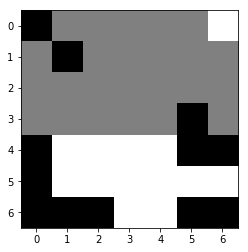

((3, 5), (3, 3)): n_v:  3882 q_all:+0.093463 q:+0.076469 q_m:+0.166667 p:0.476784
((4, 0), (3, 1)): n_v:  1038 q_all:+0.093294 q:+0.034990 q_m:+0.133333 p:0.128160
((3, 5), (3, 4)): n_v:   735 q_all:+0.082686 q:+0.106441 q_m:+0.133333 p:0.121473
((1, 1), (3, 3)): n_v:   251 q_all:+0.081835 q:+0.052264 q_m:+0.166667 p:0.042263
((4, 5), (3, 3)): n_v:   182 q_all:+0.048606 q:+0.055913 q_m:+0.166667 p:0.054755
((4, 6), (3, 4)): n_v:    88 q_all:+0.084333 q:+0.091263 q_m:+0.100000 p:0.013836
((4, 0), (3, 2)): n_v:    35 q_all:+0.048363 q:+0.035254 q_m:+0.166667 p:0.010668
((3, 5), (1, 5)): n_v:    18 q_all:+0.044181 q:+0.054785 q_m:+0.033333 p:0.005934
((1, 1), (3, 2)): n_v:    16 q_all:+0.068535 q:+0.040760 q_m:+0.166667 p:0.003674
((1, 1), (3, 1)): n_v:    13 q_all:+0.050779 q:+0.012532 q_m:+0.100000 p:0.003991
((3, 5), (1, 6)): n_v:    10 q_all:+0.039512 q:+0.057671 q_m:+0.033333 p:0.003322
((5, 0), (3, 1)): n_v:     5 q_all:-0.065266 q:-0.045422 q_m:+0.100000 p:0.004232
((3, 5), (2, 4))

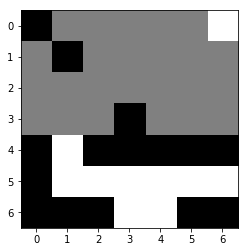

((4, 1), (3, 2)): n_v:  3890 q_all:-0.092996 q:-0.118446 q_m:+0.066667 p:0.639123
((4, 1), (3, 1)): n_v:   588 q_all:-0.119569 q:-0.171504 q_m:-0.000000 p:0.163590
((5, 6), (3, 4)): n_v:   227 q_all:-0.116215 q:-0.125310 q_m:+0.100000 p:0.059899
((5, 6), (3, 5)): n_v:    90 q_all:-0.146593 q:-0.128723 q_m:+0.033333 p:0.035287
((5, 1), (3, 2)): n_v:    69 q_all:-0.118967 q:-0.098308 q_m:+0.033333 p:0.018827
((0, 6), (1, 5)): n_v:    49 q_all:-0.125938 q:-0.162346 q_m:-0.133333 p:0.015189
((5, 5), (3, 4)): n_v:    31 q_all:-0.194673 q:-0.156412 q_m:+0.100000 p:0.019140
((4, 1), (3, 0)): n_v:    16 q_all:-0.175454 q:-0.197724 q_m:-0.066667 p:0.008554
((5, 4), (3, 2)): n_v:    10 q_all:-0.266875 q:-0.229560 q_m:+0.033333 p:0.009463
((5, 2), (3, 4)): n_v:     9 q_all:-0.216444 q:-0.185443 q_m:+0.100000 p:0.006272
((4, 1), (2, 2)): n_v:     5 q_all:-0.103054 q:-0.110525 q_m:-0.033333 p:0.001122
((5, 1), (3, 1)): n_v:     4 q_all:-0.170359 q:-0.154812 q_m:-0.033333 p:0.002225
((5, 3), (3, 5))

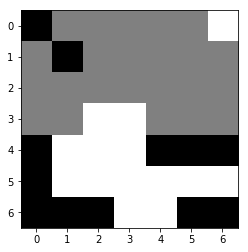

((4, 0), (3, 1)): n_v:  2552 q_all:+0.085160 q:+0.061687 q_m:+0.166667 p:0.282031
((4, 4), (3, 4)): n_v:   996 q_all:+0.098474 q:+0.088375 q_m:+0.100000 p:0.053391
((4, 6), (3, 4)): n_v:   504 q_all:+0.101396 q:+0.083979 q_m:+0.066667 p:0.020581
((4, 4), (2, 6)): n_v:   272 q_all:+0.108814 q:+0.038563 q_m:-0.066667 p:0.001762
((4, 4), (3, 5)): n_v:   248 q_all:-0.012309 q:+0.016633 q_m:-0.033333 p:0.130453
((1, 1), (3, 1)): n_v:   136 q_all:+0.061244 q:+0.028950 q_m:+0.133333 p:0.028952
((4, 4), (3, 6)): n_v:    69 q_all:+0.108810 q:+0.041779 q_m:-0.066667 p:0.000575
((4, 4), (2, 2)): n_v:    65 q_all:+0.080586 q:+0.025801 q_m:+0.066667 p:0.008494
((4, 4), (2, 3)): n_v:    39 q_all:+0.077716 q:+0.061677 q_m:+0.066667 p:0.005460
((4, 4), (2, 4)): n_v:    11 q_all:+0.048203 q:+0.045494 q_m:-0.000000 p:0.003043
((5, 0), (3, 1)): n_v:    10 q_all:-0.080473 q:-0.058078 q_m:+0.133333 p:0.008774
((1, 1), (2, 2)): n_v:     9 q_all:+0.049990 q:+0.049280 q_m:+0.100000 p:0.002525
((4, 5), (2, 3))

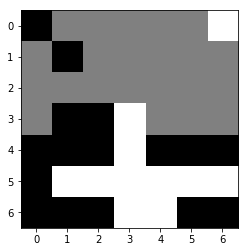

((3, 3), (3, 5)): n_v:  2646 q_all:-0.098529 q:-0.046872 q_m:+0.033333 p:0.315898
((3, 3), (3, 4)): n_v:   603 q_all:-0.158130 q:-0.133156 q_m:-0.000000 p:0.245703
((3, 3), (2, 1)): n_v:   475 q_all:-0.088199 q:-0.090091 q_m:+0.033333 p:0.032818
((3, 3), (2, 2)): n_v:   149 q_all:-0.097676 q:-0.133470 q_m:+0.066667 p:0.017199
((3, 3), (2, 5)): n_v:   132 q_all:-0.144205 q:-0.191198 q_m:-0.166667 p:0.045188
((3, 3), (1, 5)): n_v:    52 q_all:-0.131180 q:-0.193936 q_m:-0.166667 p:0.014595
((5, 6), (3, 5)): n_v:    48 q_all:-0.192057 q:-0.170693 q_m:+0.033333 p:0.027533
((3, 3), (2, 4)): n_v:    28 q_all:-0.177032 q:-0.188080 q_m:-0.133333 p:0.013941
((5, 6), (3, 4)): n_v:    22 q_all:-0.164529 q:-0.197002 q_m:-0.033333 p:0.009600
((4, 3), (3, 5)): n_v:    18 q_all:-0.198719 q:-0.135987 q_m:+0.033333 p:0.011243
((3, 3), (2, 3)): n_v:    13 q_all:-0.165239 q:-0.173303 q_m:-0.066667 p:0.006181
((5, 6), (3, 6)): n_v:    13 q_all:-0.198872 q:-0.193125 q_m:-0.033333 p:0.008121
((3, 3), (1, 2))

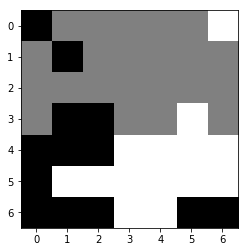

((3, 2), (3, 4)): n_v:  4196 q_all:+0.090468 q:+0.085820 q_m:+0.233333 p:0.882564
((4, 2), (3, 4)): n_v:   228 q_all:+0.074766 q:+0.023489 q_m:+0.233333 p:0.064840
((3, 2), (3, 3)): n_v:    29 q_all:+0.014642 q:+0.056174 q_m:+0.133333 p:0.017191
((3, 1), (3, 3)): n_v:     6 q_all:-0.021432 q:+0.007124 q_m:+0.100000 p:0.005008
((3, 2), (2, 4)): n_v:     5 q_all:-0.008102 q:+0.001211 q_m:+0.033333 p:0.003416
((1, 1), (3, 3)): n_v:     1 q_all:-0.016939 q:+0.028267 q_m:+0.100000 p:0.000766
((3, 1), (3, 0)): n_v:     1 q_all:-0.052041 q:-0.009227 q_m:-0.000000 p:0.001103
((3, 2), (3, 0)): n_v:     1 q_all:-0.045994 q:-0.064770 q_m:-0.033333 p:0.001364
((1, 1), (1, 3)): n_v:     0 q_all:-0.024909 q:-0.024909 q_m:-0.033333 p:0.000008
((3, 1), (1, 2)): n_v:     0 q_all:-0.077116 q:-0.077116 q_m:-0.033333 p:0.000000
((3, 2), (1, 2)): n_v:     0 q_all:-0.076024 q:-0.076024 q_m:-0.033333 p:0.000000
((3, 2), (1, 3)): n_v:     0 q_all:-0.042265 q:-0.042265 q_m:-0.033333 p:0.000030
((5, 0), (3, 0))

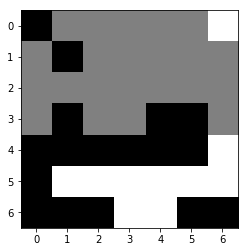

((4, 6), (3, 6)): n_v:  5483 q_all:-0.083691 q:-0.124848 q_m:-0.066667 p:0.962094
((5, 1), (3, 3)): n_v:    25 q_all:-0.066372 q:-0.056011 q_m:+0.033333 p:0.002485
((5, 6), (3, 6)): n_v:    14 q_all:-0.239484 q:-0.224032 q_m:-0.100000 p:0.012117
((5, 1), (3, 0)): n_v:    13 q_all:-0.116836 q:-0.086337 q_m:-0.033333 p:0.003863
((5, 2), (3, 0)): n_v:     5 q_all:-0.235546 q:-0.233104 q_m:-0.033333 p:0.004143
((5, 4), (3, 6)): n_v:     3 q_all:-0.351914 q:-0.291433 q_m:-0.100000 p:0.003661
((5, 5), (3, 3)): n_v:     2 q_all:-0.257991 q:-0.202682 q_m:+0.033333 p:0.001351
((5, 5), (3, 6)): n_v:     2 q_all:-0.306632 q:-0.248733 q_m:-0.100000 p:0.003176
((5, 1), (3, 2)): n_v:     2 q_all:-0.093741 q:-0.084617 q_m:+0.033333 p:0.000563
((5, 2), (3, 3)): n_v:     1 q_all:-0.206910 q:-0.182425 q_m:+0.033333 p:0.000834
((4, 6), (2, 5)): n_v:     1 q_all:-0.210005 q:-0.194929 q_m:-0.100000 p:0.000832
((4, 6), (2, 4)): n_v:     1 q_all:-0.224227 q:-0.208988 q_m:-0.100000 p:0.000792
((0, 6), (1, 5))

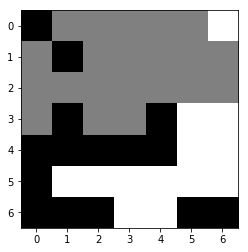

((3, 4), (2, 5)): n_v:  1824 q_all:+0.076521 q:+0.109499 q_m:+0.233333 p:0.132068
((3, 4), (1, 5)): n_v:  1121 q_all:+0.051669 q:+0.026287 q_m:+0.133333 p:0.188724
((3, 4), (2, 6)): n_v:  1036 q_all:+0.065925 q:+0.082977 q_m:+0.200000 p:0.117376
((4, 4), (2, 5)): n_v:   655 q_all:+0.091646 q:+0.076791 q_m:+0.200000 p:0.009175
((3, 4), (1, 6)): n_v:   536 q_all:+0.064276 q:+0.032924 q_m:+0.133333 p:0.063997
((3, 1), (3, 0)): n_v:   239 q_all:+0.026312 q:+0.019747 q_m:+0.100000 p:0.063681
((4, 3), (2, 5)): n_v:   147 q_all:+0.083495 q:+0.104721 q_m:+0.200000 p:0.006745
((4, 4), (2, 6)): n_v:   138 q_all:+0.064338 q:+0.040751 q_m:+0.200000 p:0.016383
((4, 2), (3, 0)): n_v:   132 q_all:-0.003891 q:-0.035554 q_m:+0.066667 p:0.050725
((1, 1), (3, 0)): n_v:    96 q_all:+0.019032 q:+0.015151 q_m:+0.066667 p:0.028433
((1, 1), (2, 0)): n_v:    55 q_all:+0.002464 q:+0.001627 q_m:+0.100000 p:0.019682
((1, 1), (2, 1)): n_v:    43 q_all:-0.001502 q:-0.026519 q_m:+0.100000 p:0.016403
((3, 1), (1, 0))

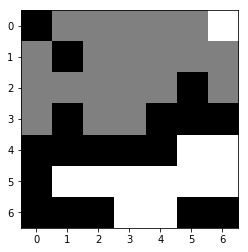

((0, 6), (2, 6)): n_v:  2902 q_all:-0.035998 q:-0.060080 q_m:-0.033333 p:0.818861
((0, 6), (2, 4)): n_v:   225 q_all:-0.093390 q:-0.113778 q_m:-0.033333 p:0.131565
((0, 6), (1, 5)): n_v:    19 q_all:-0.149968 q:-0.164055 q_m:-0.133333 p:0.017415
((5, 1), (3, 3)): n_v:    13 q_all:-0.037133 q:-0.002614 q_m:+0.033333 p:0.003632
((0, 6), (1, 4)): n_v:     3 q_all:-0.153358 q:-0.151414 q_m:-0.166667 p:0.002663
((5, 1), (3, 2)): n_v:     3 q_all:-0.094531 q:-0.058105 q_m:+0.033333 p:0.002189
((4, 6), (2, 4)): n_v:     3 q_all:-0.254903 q:-0.210396 q_m:-0.033333 p:0.005587
((5, 2), (3, 3)): n_v:     2 q_all:-0.181889 q:-0.132801 q_m:+0.033333 p:0.002863
((0, 6), (1, 6)): n_v:     1 q_all:-0.187352 q:-0.167976 q_m:-0.133333 p:0.001773
((5, 5), (3, 3)): n_v:     1 q_all:-0.378885 q:-0.224142 q_m:+0.033333 p:0.001356
((5, 4), (3, 2)): n_v:     1 q_all:-0.327757 q:-0.238793 q_m:+0.033333 p:0.003207
((5, 4), (3, 3)): n_v:     1 q_all:-0.368277 q:-0.258692 q_m:+0.033333 p:0.001560
((4, 5), (3, 3))

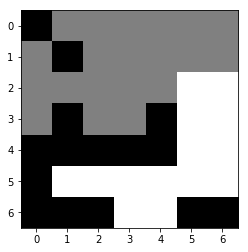

((3, 4), (1, 5)): n_v:  3312 q_all:+0.012384 q:+0.018841 q_m:+0.166667 p:0.742771
((3, 4), (1, 6)): n_v:   574 q_all:+0.011485 q:-0.011501 q_m:+0.166667 p:0.131038
((3, 4), (2, 4)): n_v:   510 q_all:+0.055241 q:+0.067270 q_m:+0.200000 p:0.012347
((4, 3), (2, 4)): n_v:    65 q_all:+0.040203 q:+0.064812 q_m:+0.166667 p:0.006197
((3, 1), (1, 0)): n_v:    34 q_all:-0.052519 q:-0.032238 q_m:+0.033333 p:0.018122
((4, 2), (2, 4)): n_v:    21 q_all:+0.037081 q:+0.004490 q_m:+0.166667 p:0.002303
((3, 4), (2, 2)): n_v:    19 q_all:-0.044432 q:-0.049392 q_m:+0.033333 p:0.009578
((4, 2), (2, 0)): n_v:    14 q_all:-0.051712 q:-0.055611 q_m:+0.033333 p:0.007580
((4, 2), (3, 0)): n_v:     8 q_all:-0.007038 q:-0.049532 q_m:+0.033333 p:0.002822
((3, 1), (3, 0)): n_v:     8 q_all:-0.040634 q:+0.001505 q_m:+0.066667 p:0.003841
((4, 4), (2, 2)): n_v:     7 q_all:-0.029331 q:-0.030691 q_m:+0.033333 p:0.003107
((4, 4), (2, 4)): n_v:     6 q_all:-0.001418 q:+0.034599 q_m:+0.166667 p:0.001742
((1, 1), (2, 0))

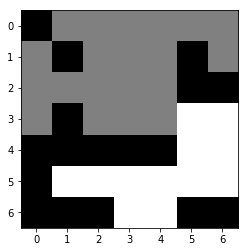

((3, 5), (3, 4)): n_v:  5066 q_all:-0.021595 q:-0.034585 q_m:+0.066667 p:0.460081
((3, 6), (3, 4)): n_v:    51 q_all:-0.131284 q:-0.149319 q_m:+0.033333 p:0.029481
((3, 5), (2, 4)): n_v:    23 q_all:-0.077082 q:-0.106347 q_m:-0.000000 p:0.007739
((5, 6), (3, 4)): n_v:    16 q_all:-0.185572 q:-0.165399 q_m:+0.033333 p:0.013427
((5, 1), (3, 2)): n_v:    14 q_all:-0.049181 q:-0.031848 q_m:+0.100000 p:0.003202
((3, 6), (1, 6)): n_v:    13 q_all:-0.106967 q:-0.085899 q_m:+0.033333 p:0.005716
((3, 5), (1, 6)): n_v:    12 q_all:-0.096458 q:-0.057669 q_m:+0.033333 p:0.004580
((4, 6), (3, 4)): n_v:     5 q_all:-0.222344 q:-0.191648 q_m:+0.033333 p:0.005285
((5, 1), (3, 0)): n_v:     3 q_all:-0.068281 q:-0.034686 q_m:+0.033333 p:0.000713
((5, 2), (3, 4)): n_v:     2 q_all:-0.176352 q:-0.153663 q_m:+0.033333 p:0.001576
((5, 5), (3, 4)): n_v:     1 q_all:-0.382401 q:-0.279379 q_m:+0.033333 p:0.001649
((5, 2), (3, 0)): n_v:     1 q_all:-0.200824 q:-0.157914 q_m:+0.033333 p:0.000965
((5, 3), (3, 2))

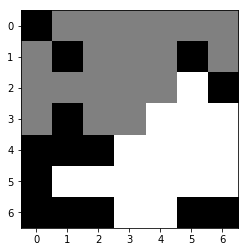

((4, 2), (3, 3)): n_v:  2469 q_all:-0.004019 q:-0.032854 q_m:+0.166667 p:0.435122
((4, 2), (2, 4)): n_v:  1731 q_all:-0.005795 q:-0.016821 q_m:+0.133333 p:0.316863
((1, 5), (3, 3)): n_v:   698 q_all:+0.023689 q:-0.018122 q_m:+0.133333 p:0.047288
((1, 5), (2, 4)): n_v:   454 q_all:+0.009778 q:+0.015040 q_m:+0.166667 p:0.055514
((3, 1), (3, 3)): n_v:   120 q_all:-0.020931 q:-0.026013 q_m:+0.133333 p:0.029155
((1, 1), (3, 3)): n_v:    94 q_all:-0.030644 q:-0.052427 q_m:+0.133333 p:0.026243
((2, 6), (2, 4)): n_v:    43 q_all:-0.012645 q:-0.023352 q_m:+0.133333 p:0.009211
((1, 1), (2, 2)): n_v:    24 q_all:-0.131942 q:-0.138154 q_m:-0.033333 p:0.016900
((1, 5), (1, 6)): n_v:     8 q_all:-0.029360 q:-0.061827 q_m:+0.033333 p:0.002282
((4, 1), (3, 3)): n_v:     8 q_all:-0.101768 q:-0.089887 q_m:+0.133333 p:0.004748
((4, 2), (2, 3)): n_v:     4 q_all:-0.063796 q:-0.090192 q_m:-0.000000 p:0.001731
((3, 1), (3, 0)): n_v:     3 q_all:-0.155199 q:-0.122825 q_m:-0.033333 p:0.002391
((3, 1), (3, 2))

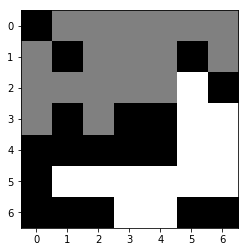

((2, 5), (1, 6)): n_v:  2481 q_all:-0.011685 q:-0.049792 q_m:-0.000000 p:0.568526
((2, 5), (2, 4)): n_v:  1463 q_all:-0.000372 q:-0.076148 q_m:+0.066667 p:0.254028
((5, 1), (3, 2)): n_v:   158 q_all:+0.028833 q:+0.046515 q_m:+0.166667 p:0.003887
((2, 5), (1, 4)): n_v:     2 q_all:-0.151301 q:-0.184980 q_m:-0.066667 p:0.002709
((5, 4), (3, 2)): n_v:     2 q_all:-0.256265 q:-0.169213 q_m:+0.166667 p:0.002777
((3, 6), (2, 4)): n_v:     1 q_all:-0.189347 q:-0.165793 q_m:+0.033333 p:0.001204
((2, 5), (2, 3)): n_v:     1 q_all:-0.101735 q:-0.131560 q_m:-0.033333 p:0.000863
((3, 6), (1, 6)): n_v:     0 q_all:-0.202517 q:-0.202517 q_m:-0.033333 p:0.000569
((2, 5), (0, 6)): n_v:     0 q_all:-0.216687 q:-0.216687 q_m:-0.100000 p:0.000013
((2, 5), (0, 3)): n_v:     0 q_all:-0.197183 q:-0.197183 q_m:-0.166667 p:0.000033
((3, 6), (1, 4)): n_v:     0 q_all:-0.260350 q:-0.260350 q_m:-0.100000 p:0.000023
((3, 5), (1, 6)): n_v:     0 q_all:-0.191350 q:-0.191350 q_m:-0.033333 p:0.000327
((4, 5), (2, 4))

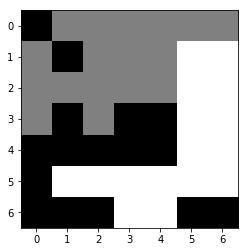

((3, 3), (2, 4)): n_v:  2221 q_all:+0.000401 q:-0.016269 q_m:+0.233333 p:0.177486
((4, 2), (2, 4)): n_v:  1439 q_all:+0.015835 q:-0.043461 q_m:+0.200000 p:0.006391
((3, 1), (3, 2)): n_v:   112 q_all:-0.114305 q:-0.134431 q_m:+0.033333 p:0.071641
((4, 3), (2, 4)): n_v:    39 q_all:-0.055253 q:-0.033943 q_m:+0.200000 p:0.013969
((1, 1), (2, 2)): n_v:    35 q_all:-0.128215 q:-0.186282 q_m:+0.033333 p:0.025130
((3, 3), (2, 1)): n_v:    16 q_all:-0.177998 q:-0.175566 q_m:-0.000000 p:0.015664
((4, 4), (2, 4)): n_v:    12 q_all:-0.066665 q:-0.030958 q_m:+0.200000 p:0.004725
((1, 1), (2, 0)): n_v:    11 q_all:-0.174657 q:-0.182065 q_m:+0.033333 p:0.010605
((3, 1), (3, 0)): n_v:    11 q_all:-0.148840 q:-0.165926 q_m:+0.033333 p:0.009239
((3, 4), (2, 2)): n_v:    10 q_all:-0.205579 q:-0.224269 q_m:-0.000000 p:0.011829
((3, 1), (1, 0)): n_v:    10 q_all:-0.170152 q:-0.169681 q_m:-0.000000 p:0.009467
((3, 3), (1, 4)): n_v:     9 q_all:-0.058032 q:-0.022310 q_m:+0.133333 p:0.003219
((4, 3), (2, 2))

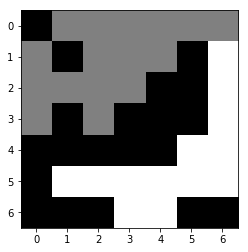

((1, 6), (1, 4)): n_v:  3320 q_all:+0.010032 q:-0.075942 q_m:-0.033333 p:0.796117
((5, 1), (3, 2)): n_v:   563 q_all:+0.044467 q:+0.066391 q_m:+0.100000 p:0.036416
((2, 6), (1, 4)): n_v:    78 q_all:-0.125580 q:-0.153590 q_m:-0.033333 p:0.072627
((3, 6), (1, 4)): n_v:    31 q_all:-0.147625 q:-0.146762 q_m:-0.033333 p:0.031734
((1, 6), (0, 5)): n_v:    19 q_all:-0.168614 q:-0.185732 q_m:-0.133333 p:0.022361
((5, 4), (3, 2)): n_v:     9 q_all:-0.200171 q:-0.140941 q_m:+0.100000 p:0.012930
((5, 3), (3, 2)): n_v:     8 q_all:-0.141550 q:-0.081486 q_m:+0.100000 p:0.008245
((1, 6), (0, 6)): n_v:     5 q_all:-0.203893 q:-0.198006 q_m:-0.133333 p:0.006984
((5, 2), (3, 2)): n_v:     3 q_all:-0.138664 q:-0.110747 q_m:+0.100000 p:0.003201
((1, 6), (0, 4)): n_v:     2 q_all:-0.208302 q:-0.182861 q_m:-0.166667 p:0.002801
((5, 1), (3, 0)): n_v:     1 q_all:-0.064409 q:-0.045326 q_m:-0.033333 p:0.000966
((5, 2), (3, 0)): n_v:     0 q_all:-0.158399 q:-0.158399 q_m:-0.033333 p:0.000967
((2, 6), (0, 4))

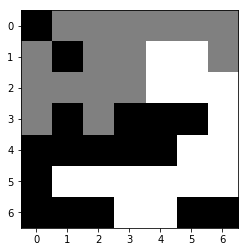

((3, 3), (2, 3)): n_v:  3702 q_all:+0.009371 q:-0.045719 q_m:+0.200000 p:0.332282
((3, 1), (2, 3)): n_v:   336 q_all:-0.000900 q:-0.031491 q_m:+0.166667 p:0.010608
((3, 3), (1, 3)): n_v:   217 q_all:-0.004359 q:+0.035803 q_m:+0.166667 p:0.010928
((3, 1), (3, 2)): n_v:   190 q_all:-0.040303 q:-0.070857 q_m:+0.066667 p:0.049426
((1, 1), (2, 3)): n_v:   159 q_all:-0.002201 q:-0.047503 q_m:+0.166667 p:0.006115
((3, 1), (3, 0)): n_v:    77 q_all:-0.105647 q:-0.122840 q_m:+0.066667 p:0.047006
((4, 2), (2, 3)): n_v:    65 q_all:-0.025656 q:-0.058289 q_m:+0.166667 p:0.011465
((3, 4), (1, 6)): n_v:    57 q_all:-0.060486 q:-0.044455 q_m:+0.233333 p:0.021408
((4, 4), (2, 3)): n_v:    18 q_all:-0.083625 q:-0.058529 q_m:+0.166667 p:0.009511
((3, 5), (1, 6)): n_v:    15 q_all:-0.052836 q:-0.021567 q_m:+0.233333 p:0.005127
((4, 3), (2, 3)): n_v:    14 q_all:-0.082469 q:-0.055131 q_m:+0.166667 p:0.006947
((3, 5), (2, 3)): n_v:     9 q_all:-0.082736 q:-0.060005 q_m:+0.166667 p:0.004857
((4, 1), (2, 3))

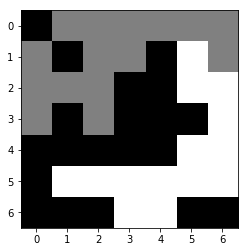

((1, 5), (1, 3)): n_v:  3826 q_all:+0.007738 q:-0.069347 q_m:-0.000000 p:0.754592
((5, 1), (3, 2)): n_v:  1320 q_all:+0.024589 q:+0.111163 q_m:+0.200000 p:0.099673
((1, 5), (0, 5)): n_v:   254 q_all:+0.008725 q:-0.168929 q_m:-0.100000 p:0.041065
((1, 5), (0, 4)): n_v:    54 q_all:-0.017875 q:-0.144196 q_m:-0.100000 p:0.016648
((2, 5), (1, 3)): n_v:    34 q_all:-0.159955 q:-0.137083 q_m:-0.000000 p:0.031454
((5, 2), (3, 2)): n_v:    12 q_all:-0.161354 q:-0.073429 q_m:+0.200000 p:0.011460
((1, 5), (1, 6)): n_v:    11 q_all:-0.087008 q:-0.173155 q_m:-0.166667 p:0.006184
((5, 4), (3, 2)): n_v:     8 q_all:-0.269582 q:-0.129806 q_m:+0.200000 p:0.011030
((5, 3), (3, 2)): n_v:     8 q_all:-0.188221 q:-0.069540 q_m:+0.200000 p:0.009169
((2, 6), (0, 5)): n_v:     2 q_all:-0.150515 q:-0.244035 q_m:-0.133333 p:0.001692
((5, 1), (3, 0)): n_v:     2 q_all:-0.039566 q:-0.021744 q_m:-0.000000 p:0.000910
((5, 2), (3, 0)): n_v:     1 q_all:-0.136627 q:-0.137223 q_m:-0.000000 p:0.000965
((1, 5), (0, 6))

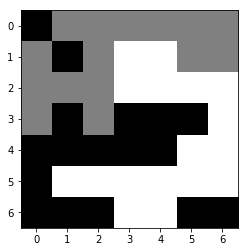

((3, 3), (1, 5)): n_v:  5024 q_all:-0.016686 q:+0.045374 q_m:+0.266667 p:0.665787
((3, 1), (3, 2)): n_v:   208 q_all:-0.037260 q:-0.008546 q_m:+0.100000 p:0.045765
((3, 5), (1, 5)): n_v:   149 q_all:-0.083063 q:-0.027297 q_m:+0.266667 p:0.062134
((3, 4), (1, 5)): n_v:   110 q_all:-0.066562 q:-0.056010 q_m:+0.266667 p:0.037976
((1, 1), (1, 2)): n_v:    13 q_all:-0.053266 q:-0.030410 q_m:+0.166667 p:0.003888
((3, 1), (1, 2)): n_v:    12 q_all:-0.058466 q:-0.021770 q_m:+0.133333 p:0.003994
((3, 1), (3, 0)): n_v:    11 q_all:-0.128336 q:-0.096939 q_m:+0.033333 p:0.006940
((1, 1), (0, 3)): n_v:     9 q_all:-0.081607 q:-0.034477 q_m:+0.133333 p:0.003618
((3, 3), (1, 2)): n_v:     8 q_all:-0.097055 q:-0.020209 q_m:+0.133333 p:0.004029
((4, 2), (2, 2)): n_v:     7 q_all:-0.019987 q:-0.048197 q_m:+0.133333 p:0.001162
((1, 1), (2, 2)): n_v:     6 q_all:-0.050224 q:-0.048477 q_m:+0.166667 p:0.001560
((1, 1), (3, 2)): n_v:     5 q_all:-0.045681 q:-0.020613 q_m:+0.066667 p:0.001232
((4, 2), (3, 0))

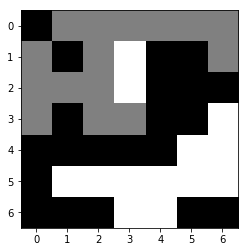

((2, 3), (3, 3)): n_v:  5721 q_all:+0.023658 q:+0.049093 q_m:+0.100000 p:0.876848
((5, 1), (3, 3)): n_v:   118 q_all:+0.028487 q:+0.069552 q_m:+0.066667 p:0.015869
((1, 3), (0, 1)): n_v:    99 q_all:+0.043398 q:-0.090233 q_m:-0.133333 p:0.007482
((2, 3), (0, 1)): n_v:    88 q_all:+0.035878 q:-0.061971 q_m:-0.133333 p:0.009194
((1, 3), (3, 3)): n_v:    39 q_all:-0.013162 q:+0.013690 q_m:+0.066667 p:0.011837
((1, 3), (0, 5)): n_v:    37 q_all:-0.067031 q:-0.167732 q_m:-0.133333 p:0.019258
((2, 3), (0, 5)): n_v:    18 q_all:-0.184661 q:-0.177438 q_m:-0.133333 p:0.018017
((2, 3), (3, 2)): n_v:    11 q_all:-0.090665 q:-0.072816 q_m:+0.033333 p:0.006806
((1, 3), (2, 2)): n_v:     5 q_all:-0.010148 q:-0.092658 q_m:-0.100000 p:0.001387
((5, 2), (3, 3)): n_v:     5 q_all:-0.120297 q:-0.067305 q_m:+0.066667 p:0.003857
((2, 3), (0, 4)): n_v:     4 q_all:-0.084836 q:-0.143631 q_m:-0.133333 p:0.002837
((1, 3), (0, 2)): n_v:     4 q_all:-0.087226 q:-0.137973 q_m:-0.166667 p:0.002811
((1, 3), (0, 4))

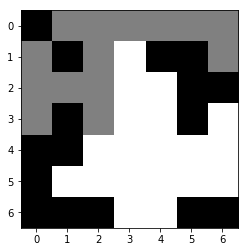

((3, 1), (3, 2)): n_v:  5411 q_all:-0.024982 q:-0.016191 q_m:+0.200000 p:0.470939
((1, 1), (3, 2)): n_v:   440 q_all:-0.038922 q:-0.041400 q_m:+0.166667 p:0.060989
((1, 4), (3, 2)): n_v:   104 q_all:-0.030413 q:-0.068382 q_m:+0.166667 p:0.011041
((4, 0), (3, 2)): n_v:    38 q_all:-0.093212 q:-0.098540 q_m:+0.166667 p:0.012989
((5, 0), (3, 2)): n_v:    24 q_all:-0.190555 q:-0.156121 q_m:+0.166667 p:0.017655
((3, 1), (3, 0)): n_v:    22 q_all:-0.184281 q:-0.210363 q_m:-0.066667 p:0.015516
((1, 1), (3, 0)): n_v:    10 q_all:-0.213579 q:-0.220409 q_m:-0.100000 p:0.008345
((1, 4), (1, 6)): n_v:     7 q_all:-0.195814 q:-0.258305 q_m:-0.100000 p:0.005498
((4, 1), (2, 2)): n_v:     7 q_all:-0.133453 q:-0.138801 q_m:+0.100000 p:0.003722
((3, 1), (1, 2)): n_v:     6 q_all:-0.125745 q:-0.138093 q_m:+0.033333 p:0.002868
((1, 1), (2, 0)): n_v:     6 q_all:-0.187975 q:-0.192597 q_m:-0.066667 p:0.004304
((1, 1), (2, 2)): n_v:     4 q_all:-0.185535 q:-0.149870 q_m:+0.133333 p:0.002753
((1, 4), (0, 6))

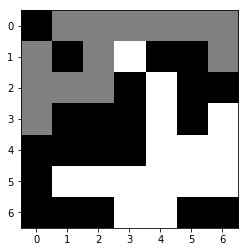

((1, 3), (2, 2)): n_v:  5470 q_all:+0.057187 q:+0.007771 q_m:+0.166667 p:0.752574
((2, 4), (1, 6)): n_v:   140 q_all:-0.011258 q:-0.052507 q_m:-0.000000 p:0.055400
((1, 3), (0, 5)): n_v:    43 q_all:-0.091897 q:-0.144461 q_m:-0.066667 p:0.031069
((1, 3), (0, 1)): n_v:    40 q_all:-0.018599 q:-0.061681 q_m:-0.066667 p:0.017370
((5, 2), (3, 0)): n_v:    38 q_all:-0.130521 q:-0.107775 q_m:-0.000000 p:0.032524
((1, 3), (2, 1)): n_v:    35 q_all:-0.019789 q:-0.006710 q_m:-0.000000 p:0.015158
((3, 4), (1, 6)): n_v:    28 q_all:-0.081073 q:-0.059099 q_m:-0.000000 p:0.018482
((1, 3), (0, 4)): n_v:    24 q_all:-0.064636 q:-0.098318 q_m:-0.033333 p:0.014621
((1, 3), (0, 2)): n_v:    19 q_all:-0.085488 q:-0.118433 q_m:-0.100000 p:0.013273
((5, 1), (3, 0)): n_v:    17 q_all:-0.006974 q:+0.021517 q_m:-0.000000 p:0.006064
((1, 3), (1, 2)): n_v:    17 q_all:-0.052260 q:-0.034222 q_m:-0.033333 p:0.008982
((2, 4), (2, 2)): n_v:    12 q_all:-0.044251 q:-0.030950 q_m:+0.133333 p:0.006525
((2, 4), (0, 5))

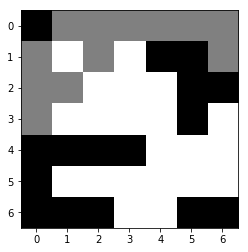

((4, 0), (2, 1)): n_v:  1794 q_all:-0.106054 q:-0.086323 q_m:+0.100000 p:0.300571
((0, 0), (2, 1)): n_v:  1764 q_all:-0.103481 q:-0.047747 q_m:+0.100000 p:0.278533
((0, 0), (1, 2)): n_v:  1481 q_all:-0.102704 q:-0.053160 q_m:+0.100000 p:0.229252
((4, 0), (3, 0)): n_v:   420 q_all:-0.075247 q:-0.138335 q_m:-0.066667 p:0.020889
((4, 3), (2, 1)): n_v:   339 q_all:-0.091801 q:-0.034047 q_m:+0.100000 p:0.038458
((1, 4), (1, 2)): n_v:   282 q_all:-0.104724 q:-0.084673 q_m:+0.100000 p:0.045329
((4, 1), (2, 1)): n_v:    31 q_all:-0.208404 q:-0.189109 q_m:+0.100000 p:0.017678
((4, 2), (2, 1)): n_v:    18 q_all:-0.165344 q:-0.144520 q_m:+0.100000 p:0.007231
((0, 0), (0, 2)): n_v:    17 q_all:-0.122487 q:-0.113396 q_m:-0.033333 p:0.003880
((0, 0), (1, 0)): n_v:    11 q_all:-0.096967 q:-0.085081 q_m:-0.066667 p:0.001583
((1, 4), (0, 4)): n_v:     8 q_all:-0.158449 q:-0.166295 q_m:-0.066667 p:0.002994
((1, 5), (1, 6)): n_v:     6 q_all:-0.133741 q:-0.147086 q_m:-0.133333 p:0.001585
((1, 4), (0, 3))

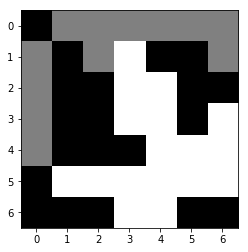

((1, 3), (1, 2)): n_v:  3296 q_all:+0.131768 q:+0.079321 q_m:+0.133333 p:0.448095
((5, 1), (4, 0)): n_v:    75 q_all:+0.091453 q:+0.089634 q_m:+0.133333 p:0.026424
((1, 3), (0, 4)): n_v:    67 q_all:+0.066256 q:+0.010163 q_m:+0.066667 p:0.032685
((2, 4), (1, 6)): n_v:    24 q_all:-0.024899 q:+0.010976 q_m:+0.100000 p:0.023073
((1, 3), (0, 5)): n_v:    21 q_all:+0.001709 q:-0.023677 q_m:+0.033333 p:0.018072
((1, 3), (0, 2)): n_v:    20 q_all:-0.058515 q:-0.059573 q_m:-0.000000 p:0.022571
((3, 6), (1, 6)): n_v:     9 q_all:-0.080743 q:-0.022211 q_m:+0.100000 p:0.011279
((1, 3), (0, 1)): n_v:     8 q_all:-0.018747 q:-0.011333 q_m:+0.033333 p:0.007776
((3, 4), (1, 6)): n_v:     5 q_all:-0.064581 q:-0.037794 q_m:+0.100000 p:0.006528
((5, 1), (3, 0)): n_v:     3 q_all:+0.085237 q:+0.078375 q_m:+0.100000 p:0.001421
((2, 4), (1, 2)): n_v:     2 q_all:-0.020896 q:+0.032674 q_m:+0.100000 p:0.001696
((3, 3), (1, 2)): n_v:     2 q_all:-0.047000 q:+0.028419 q_m:+0.100000 p:0.001411
((3, 4), (1, 2))

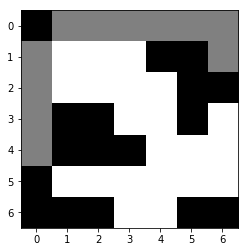

((3, 1), (4, 0)): n_v:  1514 q_all:-0.143087 q:-0.150330 q_m:-0.033333 p:0.128496
((0, 0), (0, 2)): n_v:  1082 q_all:-0.142677 q:-0.173091 q_m:+0.066667 p:0.089631
((1, 4), (0, 2)): n_v:   681 q_all:-0.143886 q:-0.161406 q_m:+0.066667 p:0.060258
((3, 1), (2, 0)): n_v:   586 q_all:-0.158186 q:-0.164110 q_m:+0.033333 p:0.089478
((1, 4), (0, 3)): n_v:   379 q_all:-0.162522 q:-0.172555 q_m:+0.033333 p:0.064432
((0, 0), (2, 0)): n_v:   161 q_all:-0.137421 q:-0.181358 q_m:-0.000000 p:0.009468
((0, 0), (0, 1)): n_v:    86 q_all:-0.145875 q:-0.185709 q_m:+0.033333 p:0.008438
((1, 4), (0, 4)): n_v:    59 q_all:-0.256955 q:-0.245074 q_m:-0.033333 p:0.035563
((3, 1), (3, 0)): n_v:    54 q_all:-0.273882 q:-0.224036 q_m:-0.033333 p:0.036305
((1, 5), (1, 6)): n_v:    48 q_all:-0.215524 q:-0.207645 q_m:-0.100000 p:0.019973
((0, 0), (1, 0)): n_v:    39 q_all:-0.169850 q:-0.151677 q_m:+0.033333 p:0.008139
((2, 6), (0, 4)): n_v:    33 q_all:-0.244755 q:-0.217388 q_m:-0.066667 p:0.018323
((4, 1), (2, 0))

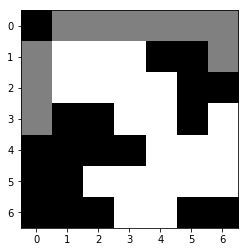

((2, 1), (3, 0)): n_v:  3262 q_all:+0.116807 q:+0.192268 q_m:+0.266667 p:0.847596
((1, 1), (3, 0)): n_v:   172 q_all:+0.110446 q:+0.151476 q_m:+0.233333 p:0.050794
((1, 2), (3, 0)): n_v:    56 q_all:+0.022880 q:+0.068832 q_m:+0.233333 p:0.043235
((1, 1), (1, 0)): n_v:    48 q_all:+0.089280 q:-0.023782 q_m:+0.133333 p:0.020004
((5, 2), (3, 0)): n_v:    20 q_all:-0.010454 q:+0.037944 q_m:+0.233333 p:0.019716
((1, 3), (0, 4)): n_v:     6 q_all:+0.133834 q:+0.086388 q_m:+0.200000 p:0.001004
((2, 2), (3, 0)): n_v:     5 q_all:-0.014108 q:+0.095623 q_m:+0.233333 p:0.005215
((1, 2), (1, 0)): n_v:     1 q_all:-0.083107 q:-0.082668 q_m:+0.100000 p:0.002532
((2, 4), (1, 6)): n_v:     0 q_all:+0.050614 q:+0.050614 q_m:+0.233333 p:0.000065
((2, 4), (0, 6)): n_v:     0 q_all:-0.052405 q:-0.052405 q_m:+0.100000 p:0.000002
((2, 3), (0, 4)): n_v:     0 q_all:-0.038598 q:-0.038598 q_m:+0.166667 p:0.000003
((2, 3), (0, 5)): n_v:     0 q_all:-0.058291 q:-0.058291 q_m:+0.166667 p:0.000002
((1, 2), (0, 3))

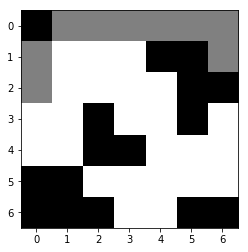

((0, 0), (2, 0)): n_v:  5111 q_all:-0.092323 q:-0.134184 q_m:-0.000000 p:0.894462
((0, 0), (0, 2)): n_v:   101 q_all:-0.058600 q:-0.220523 q_m:-0.066667 p:0.001121
((4, 2), (2, 0)): n_v:    39 q_all:-0.347690 q:-0.302731 q_m:-0.000000 p:0.051613
((3, 2), (2, 0)): n_v:    28 q_all:-0.333090 q:-0.275287 q_m:-0.000000 p:0.036095
((0, 0), (1, 0)): n_v:     4 q_all:-0.331548 q:-0.274688 q_m:-0.100000 p:0.004899
((1, 4), (0, 2)): n_v:     2 q_all:-0.236221 q:-0.220271 q_m:-0.066667 p:0.002366
((1, 4), (0, 3)): n_v:     1 q_all:-0.292693 q:-0.217557 q_m:-0.100000 p:0.001548
((1, 5), (1, 6)): n_v:     1 q_all:-0.308220 q:-0.264952 q_m:-0.233333 p:0.002080
((2, 5), (0, 3)): n_v:     0 q_all:-0.250240 q:-0.250240 q_m:-0.133333 p:0.000125
((2, 5), (0, 6)): n_v:     0 q_all:-0.321923 q:-0.321923 q_m:-0.266667 p:0.000193
((1, 5), (0, 3)): n_v:     0 q_all:-0.248766 q:-0.248766 q_m:-0.133333 p:0.000032
((1, 4), (1, 6)): n_v:     0 q_all:-0.364672 q:-0.364672 q_m:-0.266667 p:0.000142
((1, 4), (0, 4))

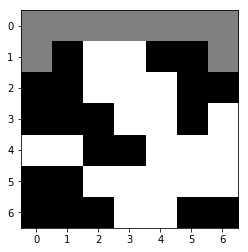

((1, 2), (1, 0)): n_v:  6179 q_all:+0.063626 q:+0.095140 q_m:+0.200000 p:0.961230
((2, 2), (1, 0)): n_v:    39 q_all:+0.049971 q:+0.124134 q_m:+0.200000 p:0.008047
((2, 4), (1, 6)): n_v:    31 q_all:+0.009141 q:+0.032946 q_m:+0.200000 p:0.011487
((3, 6), (1, 6)): n_v:    11 q_all:-0.061518 q:+0.022794 q_m:+0.200000 p:0.006881
((3, 4), (1, 6)): n_v:     9 q_all:-0.108245 q:-0.018681 q_m:+0.200000 p:0.007002
((1, 2), (0, 1)): n_v:     4 q_all:-0.046572 q:-0.052983 q_m:+0.100000 p:0.002659
((1, 3), (0, 4)): n_v:     2 q_all:+0.018713 q:+0.033124 q_m:+0.166667 p:0.000923
((2, 4), (0, 6)): n_v:     0 q_all:-0.089518 q:-0.089518 q_m:+0.066667 p:0.000002
((2, 3), (0, 4)): n_v:     0 q_all:-0.100331 q:-0.100331 q_m:+0.133333 p:0.000003
((1, 2), (0, 3)): n_v:     0 q_all:-0.015191 q:-0.015191 q_m:+0.100000 p:0.000072
((2, 4), (0, 5)): n_v:     0 q_all:-0.108526 q:-0.108526 q_m:+0.133333 p:0.000031
((2, 2), (0, 2)): n_v:     0 q_all:-0.098646 q:-0.098646 q_m:+0.066667 p:0.000001
((2, 3), (0, 1))

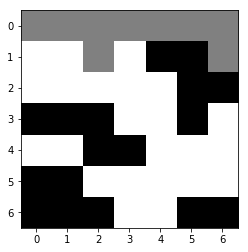

((1, 4), (1, 2)): n_v:  3479 q_all:-0.079160 q:-0.059116 q_m:+0.133333 p:0.589249
((3, 0), (1, 2)): n_v:  2883 q_all:-0.064141 q:-0.083863 q_m:+0.133333 p:0.330400
((3, 2), (1, 2)): n_v:    46 q_all:-0.299856 q:-0.224701 q_m:+0.133333 p:0.045461
((3, 1), (1, 2)): n_v:    35 q_all:-0.269667 q:-0.198272 q_m:+0.133333 p:0.029235
((1, 5), (1, 6)): n_v:     1 q_all:-0.266133 q:-0.252399 q_m:-0.166667 p:0.000942
((1, 4), (0, 6)): n_v:     0 q_all:-0.320483 q:-0.320483 q_m:-0.200000 p:0.000033
((2, 5), (0, 5)): n_v:     0 q_all:-0.342934 q:-0.342934 q_m:-0.200000 p:0.000001
((2, 5), (0, 3)): n_v:     0 q_all:-0.370646 q:-0.370646 q_m:-0.133333 p:0.000014
((2, 5), (0, 4)): n_v:     0 q_all:-0.331639 q:-0.331639 q_m:-0.133333 p:0.000007
((2, 6), (0, 4)): n_v:     0 q_all:-0.295580 q:-0.295580 q_m:-0.133333 p:0.000024
((2, 6), (0, 5)): n_v:     0 q_all:-0.323212 q:-0.323212 q_m:-0.200000 p:0.000007
((3, 5), (1, 6)): n_v:     0 q_all:-0.295542 q:-0.295542 q_m:-0.200000 p:0.000077
((1, 4), (0, 3))

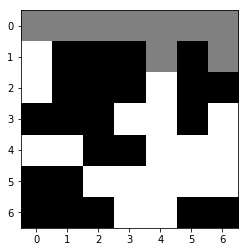

((2, 4), (1, 4)): n_v:  4031 q_all:+0.103861 q:+0.091643 q_m:+0.166667 p:0.878576
((2, 4), (1, 6)): n_v:   125 q_all:+0.147280 q:-0.032095 q_m:+0.066667 p:0.002971
((3, 6), (1, 4)): n_v:    56 q_all:-0.063149 q:-0.027632 q_m:+0.133333 p:0.054497
((1, 0), (0, 1)): n_v:    39 q_all:-0.011753 q:-0.050030 q_m:+0.033333 p:0.029074
((1, 0), (0, 2)): n_v:    12 q_all:-0.051534 q:-0.027152 q_m:+0.066667 p:0.011330
((2, 4), (0, 2)): n_v:     3 q_all:-0.073181 q:-0.003972 q_m:+0.066667 p:0.003209
((2, 0), (0, 2)): n_v:     3 q_all:-0.056443 q:-0.041225 q_m:+0.066667 p:0.002882
((3, 3), (1, 4)): n_v:     2 q_all:-0.138525 q:-0.067835 q_m:+0.133333 p:0.002635
((2, 0), (0, 1)): n_v:     2 q_all:-0.079773 q:-0.063569 q_m:-0.000000 p:0.002319
((2, 4), (0, 5)): n_v:     1 q_all:-0.148624 q:-0.185285 q_m:-0.066667 p:0.002454
((1, 0), (0, 0)): n_v:     1 q_all:-0.163233 q:-0.158464 q_m:-0.033333 p:0.001646
((3, 4), (1, 4)): n_v:     1 q_all:-0.239108 q:-0.151759 q_m:+0.133333 p:0.003226
((2, 4), (0, 3))

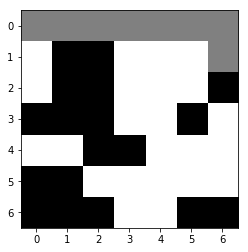

((2, 6), (1, 6)): n_v:  2709 q_all:-0.091452 q:-0.080927 q_m:-0.000000 p:0.541269
((2, 6), (0, 4)): n_v:  2695 q_all:-0.057386 q:-0.129922 q_m:+0.033333 p:0.179325
((2, 6), (0, 5)): n_v:   121 q_all:-0.176606 q:-0.165290 q_m:-0.033333 p:0.069344
((1, 2), (0, 4)): n_v:    78 q_all:-0.272893 q:-0.218274 q_m:+0.033333 p:0.077152
((3, 5), (1, 6)): n_v:    53 q_all:-0.210617 q:-0.155071 q_m:-0.033333 p:0.037536
((1, 2), (0, 3)): n_v:    43 q_all:-0.215624 q:-0.214682 q_m:-0.000000 p:0.032278
((1, 1), (0, 1)): n_v:    10 q_all:-0.275313 q:-0.244751 q_m:-0.066667 p:0.010480
((2, 2), (0, 4)): n_v:     9 q_all:-0.359165 q:-0.286173 q_m:+0.033333 p:0.012755
((1, 1), (0, 0)): n_v:     5 q_all:-0.252203 q:-0.212493 q_m:-0.066667 p:0.004148
((1, 1), (0, 2)): n_v:     4 q_all:-0.305685 q:-0.264288 q_m:-0.066667 p:0.004497
((2, 6), (0, 6)): n_v:     4 q_all:-0.159917 q:-0.196005 q_m:-0.100000 p:0.002060
((2, 2), (0, 1)): n_v:     1 q_all:-0.455250 q:-0.360753 q_m:-0.100000 p:0.001645
((2, 1), (0, 2))

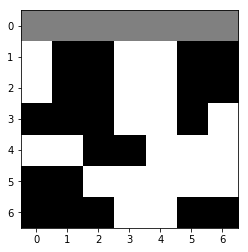

((1, 0), (0, 1)): n_v:  2552 q_all:+0.289589 q:+0.127981 q_m:+0.166667 p:0.151371
((1, 4), (0, 5)): n_v:  1214 q_all:+0.092677 q:+0.092677 q_m:+0.166667 p:0.795329
((1, 3), (0, 5)): n_v:    19 q_all:+0.015293 q:+0.015293 q_m:+0.133333 p:0.022005
((1, 3), (0, 1)): n_v:    12 q_all:+0.038567 q:+0.038567 q_m:+0.133333 p:0.012436
((2, 0), (0, 1)): n_v:     7 q_all:+0.024869 q:+0.024869 q_m:+0.133333 p:0.008217
((1, 3), (0, 2)): n_v:     1 q_all:+0.103898 q:+0.103898 q_m:+0.166667 p:0.001144
((2, 4), (0, 5)): n_v:     1 q_all:-0.099959 q:-0.099959 q_m:+0.133333 p:0.002365
((2, 4), (0, 6)): n_v:     0 q_all:-0.142362 q:-0.142362 q_m:+0.133333 p:0.000010
((2, 3), (0, 4)): n_v:     0 q_all:-0.218288 q:-0.218288 q_m:+0.066667 p:0.000006
((2, 0), (0, 2)): n_v:     0 q_all:-0.024245 q:-0.024245 q_m:+0.133333 p:0.000070
((1, 0), (0, 2)): n_v:     0 q_all:+0.015680 q:+0.015680 q_m:+0.133333 p:0.000761
((2, 3), (0, 5)): n_v:     0 q_all:-0.059609 q:-0.059609 q_m:+0.133333 p:0.001421
((2, 3), (0, 1))

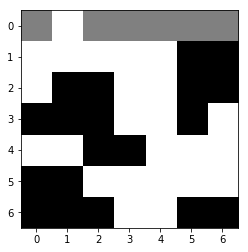

((1, 5), (0, 4)): n_v:  4003 q_all:-0.159869 q:-0.087766 q_m:-0.000000 p:0.340829
((2, 2), (0, 0)): n_v:    94 q_all:-0.355537 q:-0.178166 q_m:+0.033333 p:0.065404
((2, 2), (0, 4)): n_v:    70 q_all:-0.567440 q:-0.254349 q_m:-0.033333 p:0.145538
((1, 6), (0, 4)): n_v:    69 q_all:-0.359621 q:-0.251116 q_m:-0.033333 p:0.050035
((2, 6), (0, 4)): n_v:    58 q_all:-0.591337 q:-0.240540 q_m:-0.033333 p:0.126303
((1, 5), (0, 6)): n_v:    22 q_all:-0.613966 q:-0.362642 q_m:-0.133333 p:0.051664
((1, 5), (0, 3)): n_v:    16 q_all:-0.497817 q:-0.231402 q_m:+0.033333 p:0.026473
((2, 2), (0, 2)): n_v:    16 q_all:-0.442466 q:-0.237367 q_m:+0.100000 p:0.020427
((2, 2), (0, 3)): n_v:    12 q_all:-0.555196 q:-0.206181 q_m:+0.033333 p:0.025466
((2, 1), (0, 2)): n_v:    10 q_all:-0.494794 q:-0.298742 q_m:+0.100000 p:0.016137
((1, 5), (0, 5)): n_v:     8 q_all:-0.412183 q:-0.164732 q_m:-0.066667 p:0.009368
((2, 5), (0, 4)): n_v:     6 q_all:-0.606278 q:-0.323846 q_m:-0.033333 p:0.014305
((2, 5), (0, 3))

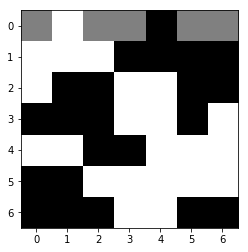

((1, 2), (0, 3)): n_v:  5462 q_all:+0.349226 q:+0.302591 q_m:+0.233333 p:0.490274
((2, 3), (0, 5)): n_v:   362 q_all:+0.104354 q:+0.203636 q_m:+0.266667 p:0.189973
((0, 1), (0, 3)): n_v:   177 q_all:+0.106121 q:+0.226298 q_m:+0.200000 p:0.089734
((2, 4), (0, 5)): n_v:   130 q_all:+0.070896 q:+0.149925 q_m:+0.266667 p:0.089206
((1, 1), (0, 3)): n_v:    44 q_all:-0.023869 q:+0.086631 q_m:+0.200000 p:0.050901
((2, 4), (0, 3)): n_v:    10 q_all:-0.091288 q:-0.003607 q_m:+0.200000 p:0.015515
((0, 1), (0, 0)): n_v:     7 q_all:-0.080816 q:+0.033191 q_m:+0.033333 p:0.010961
((2, 3), (0, 3)): n_v:     3 q_all:-0.133673 q:-0.077357 q_m:+0.200000 p:0.006881
((0, 1), (0, 2)): n_v:     2 q_all:-0.021994 q:+0.134917 q_m:+0.100000 p:0.002414
((2, 0), (0, 0)): n_v:     2 q_all:-0.199448 q:-0.163322 q_m:-0.000000 p:0.004981
((1, 2), (0, 0)): n_v:     2 q_all:-0.180395 q:-0.168616 q_m:-0.000000 p:0.004693
((2, 4), (0, 6)): n_v:     1 q_all:-0.075249 q:-0.032112 q_m:+0.133333 p:0.001857
((2, 3), (0, 2))

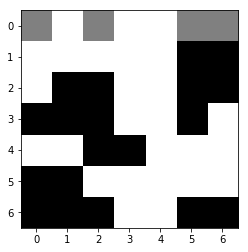

((1, 5), (0, 5)): n_v:  5833 q_all:-0.326825 q:-0.070023 q_m:-0.066667 p:0.416481
((2, 2), (0, 0)): n_v:   157 q_all:-0.350364 q:-0.487991 q_m:-0.033333 p:0.002138
((2, 2), (0, 2)): n_v:    97 q_all:-0.391281 q:-0.494366 q_m:+0.100000 p:0.018890
((2, 1), (0, 2)): n_v:    77 q_all:-0.458955 q:-0.433848 q_m:+0.100000 p:0.037932
((2, 6), (0, 5)): n_v:    48 q_all:-0.546952 q:-0.283338 q_m:-0.100000 p:0.040943
((2, 5), (0, 5)): n_v:     3 q_all:-0.729929 q:-0.556990 q_m:-0.100000 p:0.004537
((2, 6), (0, 6)): n_v:     0 q_all:-0.707074 q:-0.707074 q_m:-0.233333 p:0.000907
((2, 5), (0, 6)): n_v:     0 q_all:-0.736900 q:-0.736900 q_m:-0.233333 p:0.000253
((2, 1), (0, 0)): n_v:     0 q_all:-0.557419 q:-0.557419 q_m:-0.033333 p:0.000391
((1, 5), (0, 6)): n_v:     0 q_all:-0.750597 q:-0.750597 q_m:-0.200000 p:0.000702
########################p_sum is:  0.523173071037
1 's turn


This is a random move


one move takes time(s):  0.134521484375
no. of data collected:  16


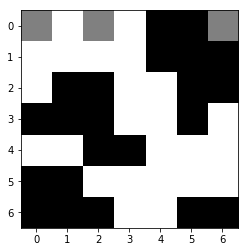

((0, 1), (0, 2)): n_v:  6144 q_all:+0.507599 q:+0.642828 q_m:+0.100000 p:0.111521
((2, 0), (0, 0)): n_v:    27 q_all:-0.500944 q:-0.417978 q_m:+0.066667 p:0.102270
((2, 0), (0, 2)): n_v:    24 q_all:-0.251689 q:-0.171704 q_m:+0.066667 p:0.070310
((1, 0), (0, 2)): n_v:    18 q_all:-0.509068 q:-0.358519 q_m:+0.066667 p:0.067246
((1, 2), (0, 0)): n_v:    13 q_all:-0.377705 q:-0.318834 q_m:+0.066667 p:0.046349
((0, 1), (0, 0)): n_v:    12 q_all:-0.341549 q:-0.171605 q_m:+0.100000 p:0.039506
((2, 4), (0, 6)): n_v:     9 q_all:-0.080090 q:+0.065177 q_m:+0.266667 p:0.021928
((2, 3), (0, 2)): n_v:     1 q_all:-0.473692 q:-0.473692 q_m:+0.066667 p:0.006376
((2, 4), (0, 2)): n_v:     0 q_all:-0.588284 q:-0.588284 q_m:+0.066667 p:0.002568
########################p_sum is:  0.468074502191
-1 's turn
one move takes time(s):  0.1096644401550293
no. of data collected:  16


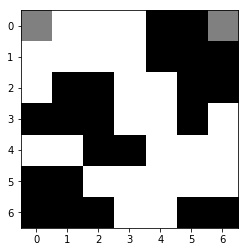

((2, 2), (0, 0)): n_v:  5711 q_all:-0.593199 q:-0.211818 q_m:+0.100000 p:0.087834
((2, 6), (0, 6)): n_v:   303 q_all:-0.912676 q:-0.810054 q_m:-0.100000 p:0.358837
((0, 5), (0, 6)): n_v:   151 q_all:-0.794118 q:-0.594436 q_m:-0.066667 p:0.113169
((0, 4), (0, 6)): n_v:   112 q_all:-0.895719 q:-0.744131 q_m:-0.100000 p:0.125544
((2, 1), (0, 0)): n_v:    45 q_all:-0.742035 q:-0.451020 q_m:+0.100000 p:0.024931
((1, 4), (0, 6)): n_v:    14 q_all:-0.922836 q:-0.819443 q_m:-0.100000 p:0.017360
((2, 5), (0, 6)): n_v:    13 q_all:-0.965311 q:-0.939585 q_m:-0.100000 p:0.018692
########################p_sum is:  0.746366895735
1 's turn


This is a random move


one move takes time(s):  0.0881052017211914
no. of data collected:  16


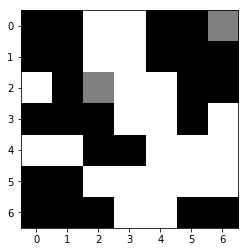

((1, 2), (2, 2)): n_v:  6131 q_all:+0.849770 q:+0.582777 q_m:+0.200000 p:0.191671
((4, 0), (2, 2)): n_v:    27 q_all:+0.252448 q:+0.252448 q_m:+0.166667 p:0.051358
((0, 3), (2, 2)): n_v:    19 q_all:+0.096066 q:+0.096066 q_m:+0.166667 p:0.052813
((2, 0), (2, 2)): n_v:     4 q_all:+0.040711 q:+0.040711 q_m:+0.166667 p:0.014576
((4, 1), (2, 2)): n_v:     4 q_all:-0.389095 q:-0.389095 q_m:+0.166667 p:0.022043
((0, 2), (2, 2)): n_v:     2 q_all:-0.601093 q:-0.601093 q_m:+0.166667 p:0.016212
((3, 4), (2, 2)): n_v:     1 q_all:-0.192700 q:-0.192700 q_m:+0.166667 p:0.007591
((2, 4), (2, 2)): n_v:     1 q_all:-0.673153 q:-0.673153 q_m:+0.166667 p:0.008739
((2, 4), (0, 6)): n_v:     0 q_all:-0.298126 q:-0.298126 q_m:+0.100000 p:0.000092
((4, 4), (2, 2)): n_v:     0 q_all:-0.757217 q:-0.757217 q_m:+0.166667 p:0.005773
########################p_sum is:  0.370867400612
-1 's turn
one move takes time(s):  0.0988469123840332
no. of data collected:  16


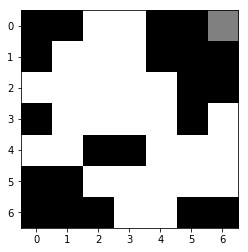

((2, 6), (0, 6)): n_v:  2444 q_all:-0.980944 q:-0.950100 q_m:-0.200000 p:0.289248
((0, 4), (0, 6)): n_v:  1164 q_all:-0.984143 q:-0.953963 q_m:-0.200000 p:0.151273
((1, 4), (0, 6)): n_v:  1131 q_all:-0.981089 q:-0.949076 q_m:-0.200000 p:0.134344
((2, 5), (0, 6)): n_v:  1042 q_all:-0.987215 q:-0.969969 q_m:-0.200000 p:0.147153
((0, 5), (0, 6)): n_v:   558 q_all:-1.000000 q:+5.000000 q_m:-0.166667 p:0.104882
########################p_sum is:  0.826900795102
1 's turn
one move takes time(s):  0.040068864822387695
no. of data collected:  8


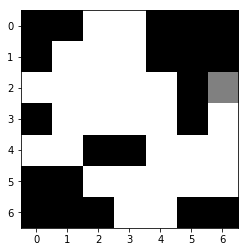

((3, 6), (2, 6)): n_v:  3858 q_all:+1.000000 q:+5.000000 q_m:+0.500000 p:0.958582
((4, 6), (2, 6)): n_v:    25 q_all:+0.888624 q:+0.963731 q_m:+0.466667 p:0.020487
((3, 4), (2, 6)): n_v:     5 q_all:+0.508721 q:+0.810465 q_m:+0.466667 p:0.011337
((4, 4), (2, 6)): n_v:     3 q_all:+0.437292 q:+0.916389 q_m:+0.466667 p:0.004329
((4, 5), (2, 6)): n_v:     1 q_all:+0.629145 q:+0.865177 q_m:+0.466667 p:0.001843
((2, 4), (2, 6)): n_v:     1 q_all:-0.174984 q:+0.650031 q_m:+0.466667 p:0.003396
########################p_sum is:  0.999974140548
this self play has 70 steps, time elapsed 74.52455830574036
winner is 1.0
episode 133 finished
episode 134 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.3157954216003418
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.4234468936920166
no. of data collected:  16
-1 's turn
one move takes time(s):  0.6705982685089111
no. of data collected:  16
1 's turn
one move takes time(s): 

due to rollout lim, final rollout times:  2001 time elapsed:  3.2518084049224854
one move takes time(s):  3.253408193588257
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.7384486198425293
one move takes time(s):  2.7407209873199463
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.6666479110717773
one move takes time(s):  2.6682064533233643
no. of data collected:  16
-1 's turn
one move takes time(s):  1.6405344009399414
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.0694386959075928


This is a random move


one move takes time(s):  2.071011781692505
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  1.0657720565795898
no. of data collected:  16
1 's turn
one move takes time(s):  1.3922016620635986
no. of data collected:  16
-1 's turn
one move takes time(s):  1.5105926990509033
no. of data

due to rollout lim, final rollout times:  2001 time elapsed:  3.4683992862701416
one move takes time(s):  3.4700136184692383
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.9732019901275635
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.384873867034912
one move takes time(s):  2.3864850997924805
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.2991771697998047
one move takes time(s):  2.300628662109375
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.158510208129883
one move takes time(s):  2.1601157188415527
no. of data collected:  16
-1 's turn
one move takes time(s):  1.6629064083099365
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.2833211421966553
one move takes time(s):  2.284942626953125
no. of data collected:  16
-1 's turn
du

34000/34000 [==============================] - 2s 73us/step - loss: 0.8524 - activation_29_loss: 0.8164 - dense_15_loss: 0.0079 - val_loss: 0.8556 - val_activation_29_loss: 0.8195 - val_dense_15_loss: 0.0080
Epoch 10/512
34000/34000 [==============================] - 3s 78us/step - loss: 0.8523 - activation_29_loss: 0.8163 - dense_15_loss: 0.0079 - val_loss: 0.8556 - val_activation_29_loss: 0.8196 - val_dense_15_loss: 0.0079
Epoch 11/512
34000/34000 [==============================] - 2s 73us/step - loss: 0.8519 - activation_29_loss: 0.8160 - dense_15_loss: 0.0079 - val_loss: 0.8556 - val_activation_29_loss: 0.8195 - val_dense_15_loss: 0.0080
Epoch 12/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8518 - activation_29_loss: 0.8158 - dense_15_loss: 0.0079 - val_loss: 0.8556 - val_activation_29_loss: 0.8196 - val_dense_15_loss: 0.0080
Epoch 13/512
34000/34000 [==============================] - 2s 73us/step - loss: 0.8516 - activation_29_loss: 0.8156 - dense_15_l

34000/34000 [==============================] - 3s 76us/step - loss: 0.8465 - activation_29_loss: 0.8108 - dense_15_loss: 0.0076 - val_loss: 0.8561 - val_activation_29_loss: 0.8202 - val_dense_15_loss: 0.0078
Epoch 47/512
34000/34000 [==============================] - 3s 78us/step - loss: 0.8464 - activation_29_loss: 0.8106 - dense_15_loss: 0.0076 - val_loss: 0.8562 - val_activation_29_loss: 0.8203 - val_dense_15_loss: 0.0078
Epoch 48/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8463 - activation_29_loss: 0.8106 - dense_15_loss: 0.0076 - val_loss: 0.8562 - val_activation_29_loss: 0.8203 - val_dense_15_loss: 0.0078
Epoch 49/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8462 - activation_29_loss: 0.8105 - dense_15_loss: 0.0076 - val_loss: 0.8562 - val_activation_29_loss: 0.8203 - val_dense_15_loss: 0.0078
Epoch 50/512
34000/34000 [==============================] - 3s 80us/step - loss: 0.8459 - activation_29_loss: 0.8102 - dense_15_l

34000/34000 [==============================] - 3s 78us/step - loss: 0.8425 - activation_29_loss: 0.8070 - dense_15_loss: 0.0074 - val_loss: 0.8569 - val_activation_29_loss: 0.8210 - val_dense_15_loss: 0.0078
Epoch 84/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8424 - activation_29_loss: 0.8068 - dense_15_loss: 0.0075 - val_loss: 0.8569 - val_activation_29_loss: 0.8211 - val_dense_15_loss: 0.0078
Epoch 85/512
34000/34000 [==============================] - 3s 79us/step - loss: 0.8425 - activation_29_loss: 0.8069 - dense_15_loss: 0.0074 - val_loss: 0.8568 - val_activation_29_loss: 0.8210 - val_dense_15_loss: 0.0077
Epoch 86/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8424 - activation_29_loss: 0.8069 - dense_15_loss: 0.0074 - val_loss: 0.8570 - val_activation_29_loss: 0.8211 - val_dense_15_loss: 0.0078
Epoch 87/512
34000/34000 [==============================] - 3s 79us/step - loss: 0.8422 - activation_29_loss: 0.8067 - dense_15_l

one move takes time(s):  0.2440180778503418
no. of data collected:  24
-1 's turn
one move takes time(s):  0.17758584022521973
no. of data collected:  16
1 's turn
one move takes time(s):  0.2670104503631592
no. of data collected:  24
-1 's turn
one move takes time(s):  0.23816132545471191
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.38887786865234375
no. of data collected:  16
-1 's turn
one move takes time(s):  0.22789335250854492
no. of data collected:  16
1 's turn
one move takes time(s):  0.28282618522644043
no. of data collected:  24
-1 's turn
one move takes time(s):  0.1871194839477539
no. of data collected:  16
1 's turn
one move takes time(s):  0.2708704471588135
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.11809039115905762
no. of data collected:  16
1 's turn
one move takes time(s):  0.15919876098632812
no. of data collected:  16
-1 's turn
one move takes time(s):  0.27386474609375
no

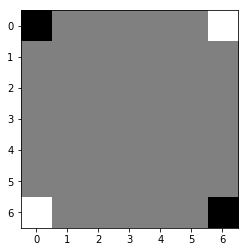

((6, 6), (5, 5)): n_v:  1176 q_all:+0.020373 q:+0.010437 q_m:+0.033333 p:0.497260
((0, 0), (1, 1)): n_v:  1020 q_all:+0.011017 q:+0.027246 q_m:+0.033333 p:0.499260
((6, 6), (6, 5)): n_v:     2 q_all:+0.019450 q:+0.011602 q_m:+0.033333 p:0.001174
((0, 0), (0, 1)): n_v:     1 q_all:+0.007346 q:+0.011278 q_m:+0.033333 p:0.000847
((0, 0), (1, 0)): n_v:     1 q_all:+0.015305 q:+0.020115 q_m:+0.033333 p:0.000446
((6, 6), (6, 4)): n_v:     0 q_all:-0.001281 q:-0.001281 q_m:-0.000000 p:0.000018
((0, 0), (1, 2)): n_v:     0 q_all:-0.010210 q:-0.010210 q_m:-0.000000 p:0.000021
((0, 0), (2, 2)): n_v:     0 q_all:-0.001246 q:-0.001246 q_m:-0.000000 p:0.000081
((0, 0), (0, 2)): n_v:     0 q_all:-0.016964 q:-0.016964 q_m:-0.000000 p:0.000021
((6, 6), (5, 6)): n_v:     0 q_all:+0.014698 q:+0.014698 q_m:+0.033333 p:0.000437
((6, 6), (4, 6)): n_v:     0 q_all:+0.007846 q:+0.007846 q_m:-0.000000 p:0.000078
((6, 6), (5, 4)): n_v:     0 q_all:+0.003586 q:+0.003586 q_m:-0.000000 p:0.000038
((6, 6), (4, 4))

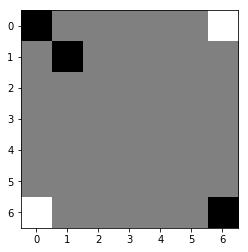

((0, 6), (1, 5)): n_v:  2039 q_all:-0.020435 q:-0.016131 q_m:-0.000000 p:0.610101
((6, 0), (5, 1)): n_v:  1018 q_all:-0.025340 q:-0.016318 q_m:-0.000000 p:0.333916
((0, 6), (1, 6)): n_v:    64 q_all:-0.025895 q:-0.023361 q_m:-0.000000 p:0.021295
((6, 0), (5, 0)): n_v:    39 q_all:-0.020326 q:-0.019365 q_m:-0.000000 p:0.011629
((0, 6), (0, 5)): n_v:    36 q_all:-0.029097 q:-0.021115 q_m:-0.000000 p:0.012719
((6, 0), (6, 1)): n_v:    22 q_all:-0.027217 q:-0.013766 q_m:-0.000000 p:0.007580
((0, 6), (2, 4)): n_v:     1 q_all:-0.042744 q:-0.034067 q_m:-0.033333 p:0.000532
((0, 6), (1, 4)): n_v:     1 q_all:-0.047738 q:-0.034242 q_m:-0.033333 p:0.000424
((6, 0), (6, 2)): n_v:     0 q_all:-0.037334 q:-0.037334 q_m:-0.033333 p:0.000140
((6, 0), (5, 2)): n_v:     0 q_all:-0.038060 q:-0.038060 q_m:-0.033333 p:0.000156
((6, 0), (4, 1)): n_v:     0 q_all:-0.022976 q:-0.022976 q_m:-0.033333 p:0.000136
((0, 6), (2, 6)): n_v:     0 q_all:-0.029514 q:-0.029514 q_m:-0.033333 p:0.000162
((0, 6), (0, 4))

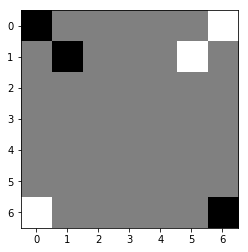

((1, 1), (2, 2)): n_v:  2688 q_all:+0.021265 q:+0.017415 q_m:+0.033333 p:0.615937
((6, 6), (5, 5)): n_v:  1234 q_all:+0.019445 q:+0.008030 q_m:+0.033333 p:0.294316
((1, 1), (1, 2)): n_v:   205 q_all:+0.014489 q:-0.006821 q_m:+0.033333 p:0.054223
((1, 1), (2, 1)): n_v:    87 q_all:+0.015703 q:+0.006465 q_m:+0.033333 p:0.022441
((1, 1), (0, 2)): n_v:     7 q_all:+0.003470 q:-0.004208 q_m:+0.033333 p:0.002303
((1, 1), (2, 0)): n_v:     6 q_all:+0.012920 q:+0.020834 q_m:+0.033333 p:0.001641
((0, 0), (1, 0)): n_v:     5 q_all:+0.005899 q:+0.005205 q_m:+0.033333 p:0.001609
((0, 0), (0, 1)): n_v:     5 q_all:+0.016417 q:+0.009516 q_m:+0.033333 p:0.001439
((6, 6), (5, 6)): n_v:     1 q_all:+0.006115 q:+0.013229 q_m:+0.033333 p:0.000321
((6, 6), (6, 5)): n_v:     1 q_all:+0.013717 q:+0.010092 q_m:+0.033333 p:0.000463
((1, 1), (3, 0)): n_v:     0 q_all:+0.000273 q:+0.000273 q_m:-0.000000 p:0.000087
((6, 6), (6, 4)): n_v:     0 q_all:-0.002280 q:-0.002280 q_m:-0.000000 p:0.000014
((1, 1), (2, 3))

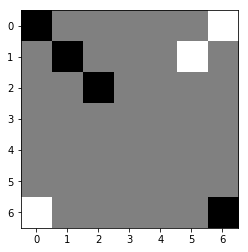

((6, 0), (5, 1)): n_v:  2014 q_all:-0.011343 q:-0.018537 q_m:-0.000000 p:0.440191
((1, 5), (2, 4)): n_v:  1163 q_all:-0.010666 q:-0.025759 q_m:-0.000000 p:0.250241
((1, 5), (1, 4)): n_v:   972 q_all:-0.009245 q:-0.021899 q_m:-0.000000 p:0.202609
((1, 5), (2, 5)): n_v:   151 q_all:-0.007828 q:-0.026197 q_m:-0.000000 p:0.030652
((0, 6), (1, 6)): n_v:    72 q_all:-0.019671 q:-0.022976 q_m:-0.000000 p:0.018709
((6, 0), (5, 0)): n_v:    28 q_all:-0.015300 q:-0.024749 q_m:-0.000000 p:0.006595
((1, 5), (0, 4)): n_v:    26 q_all:-0.026481 q:-0.025460 q_m:-0.000000 p:0.007558
((1, 5), (3, 3)): n_v:    18 q_all:-0.022786 q:+0.004077 q_m:+0.033333 p:0.005000
((0, 6), (0, 5)): n_v:    15 q_all:-0.015274 q:-0.028709 q_m:-0.000000 p:0.003737
((1, 5), (2, 3)): n_v:     8 q_all:-0.020707 q:+0.001888 q_m:+0.033333 p:0.002302
((1, 5), (1, 3)): n_v:     8 q_all:-0.029384 q:-0.000571 q_m:+0.033333 p:0.002607
((6, 0), (6, 1)): n_v:     8 q_all:-0.023847 q:-0.020601 q_m:-0.000000 p:0.002251
((1, 5), (2, 6))

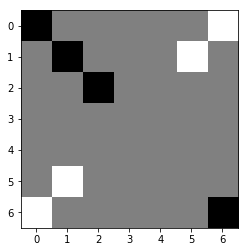

((2, 2), (3, 1)): n_v:  2778 q_all:+0.030950 q:+0.017569 q_m:+0.033333 p:0.696738
((6, 6), (5, 5)): n_v:   747 q_all:+0.027929 q:+0.007824 q_m:+0.033333 p:0.199163
((2, 2), (1, 3)): n_v:   189 q_all:+0.019529 q:+0.004519 q_m:+0.033333 p:0.058792
((2, 2), (3, 3)): n_v:    19 q_all:+0.014142 q:+0.016135 q_m:+0.033333 p:0.006488
((2, 2), (3, 2)): n_v:    15 q_all:+0.021128 q:+0.010910 q_m:+0.033333 p:0.004805
((1, 1), (2, 1)): n_v:    11 q_all:+0.025518 q:-0.004149 q_m:+0.033333 p:0.003086
((2, 2), (4, 2)): n_v:     9 q_all:+0.011927 q:+0.034758 q_m:+0.066667 p:0.003424
((1, 1), (1, 2)): n_v:     9 q_all:+0.026115 q:-0.013345 q_m:+0.033333 p:0.002498
((2, 2), (2, 3)): n_v:     8 q_all:+0.022688 q:+0.015514 q_m:+0.033333 p:0.002585
((2, 2), (4, 1)): n_v:     6 q_all:-0.002805 q:+0.033318 q_m:+0.066667 p:0.002520
((2, 2), (1, 0)): n_v:     4 q_all:-0.015471 q:-0.017568 q_m:-0.000000 p:0.002218
((6, 6), (5, 6)): n_v:     4 q_all:+0.028865 q:+0.013398 q_m:+0.033333 p:0.001016
((2, 2), (2, 4))

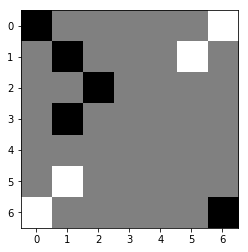

((5, 1), (4, 2)): n_v:  1485 q_all:-0.017127 q:+0.008661 q_m:+0.066667 p:0.312338
((5, 1), (5, 2)): n_v:   805 q_all:+0.007289 q:-0.006706 q_m:-0.000000 p:0.076472
((5, 1), (4, 1)): n_v:   608 q_all:-0.014620 q:+0.018323 q_m:+0.066667 p:0.120596
((5, 1), (3, 2)): n_v:   478 q_all:-0.025584 q:+0.038138 q_m:+0.100000 p:0.119832
((1, 5), (2, 4)): n_v:   298 q_all:-0.049945 q:-0.008979 q_m:-0.000000 p:0.109128
((1, 5), (1, 4)): n_v:   177 q_all:-0.056222 q:-0.006205 q_m:-0.000000 p:0.070117
((5, 1), (4, 0)): n_v:   115 q_all:-0.005588 q:+0.020815 q_m:+0.066667 p:0.017948
((5, 1), (5, 0)): n_v:   103 q_all:-0.005418 q:-0.014960 q_m:-0.000000 p:0.016109
((1, 5), (2, 5)): n_v:    78 q_all:-0.056470 q:-0.009653 q_m:-0.000000 p:0.031146
((5, 1), (3, 3)): n_v:    60 q_all:-0.017157 q:+0.004199 q_m:+0.033333 p:0.012606
((5, 1), (3, 0)): n_v:    56 q_all:-0.031560 q:+0.012906 q_m:+0.033333 p:0.015759
((0, 6), (1, 6)): n_v:    48 q_all:-0.063111 q:-0.007735 q_m:-0.000000 p:0.020363
((1, 5), (3, 3))

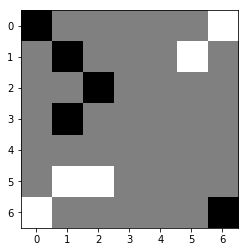

((3, 1), (5, 0)): n_v:  1215 q_all:+0.007347 q:+0.061617 q_m:+0.133333 p:0.484708
((6, 6), (5, 5)): n_v:   598 q_all:+0.038551 q:+0.031014 q_m:+0.033333 p:0.121254
((3, 1), (1, 0)): n_v:   331 q_all:+0.016916 q:-0.011689 q_m:-0.000000 p:0.112389
((3, 1), (4, 2)): n_v:   191 q_all:+0.001544 q:+0.060486 q_m:+0.166667 p:0.083259
((2, 2), (1, 3)): n_v:    79 q_all:+0.026428 q:+0.019640 q_m:+0.033333 p:0.021843
((3, 1), (4, 1)): n_v:    79 q_all:+0.012629 q:+0.063520 q_m:+0.166667 p:0.029171
((2, 2), (4, 2)): n_v:    48 q_all:-0.008208 q:+0.055646 q_m:+0.133333 p:0.023907
((3, 1), (4, 0)): n_v:    41 q_all:+0.041960 q:+0.044894 q_m:+0.100000 p:0.007566
((2, 2), (4, 1)): n_v:    33 q_all:-0.002037 q:+0.058982 q_m:+0.133333 p:0.015334
((3, 1), (1, 2)): n_v:    22 q_all:+0.027000 q:-0.026682 q_m:-0.000000 p:0.006164
((2, 2), (1, 0)): n_v:    19 q_all:+0.007002 q:-0.010746 q_m:-0.000000 p:0.007994
((2, 2), (4, 4)): n_v:    15 q_all:+0.014193 q:+0.014378 q_m:-0.000000 p:0.005392
((2, 2), (0, 1))

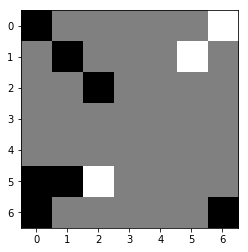

((5, 2), (6, 1)): n_v:  3129 q_all:-0.003201 q:+0.026807 q_m:+0.100000 p:0.904959
((5, 2), (4, 1)): n_v:   179 q_all:-0.021946 q:-0.028527 q_m:+0.033333 p:0.070976
((0, 6), (0, 5)): n_v:    13 q_all:-0.007998 q:-0.058095 q_m:-0.100000 p:0.004414
((1, 5), (2, 5)): n_v:     7 q_all:-0.014900 q:-0.053153 q_m:-0.100000 p:0.002741
((1, 5), (2, 4)): n_v:     3 q_all:-0.041764 q:-0.051187 q_m:-0.100000 p:0.001700
((5, 2), (4, 0)): n_v:     3 q_all:-0.042143 q:-0.026436 q_m:-0.000000 p:0.001752
((5, 2), (5, 3)): n_v:     2 q_all:-0.102514 q:-0.067122 q_m:-0.100000 p:0.002018
((5, 2), (4, 3)): n_v:     2 q_all:-0.049324 q:-0.061534 q_m:-0.100000 p:0.001197
((5, 2), (4, 2)): n_v:     2 q_all:-0.080673 q:-0.046889 q_m:-0.033333 p:0.001928
((1, 5), (1, 4)): n_v:     2 q_all:-0.060588 q:-0.046492 q_m:-0.100000 p:0.001553
((5, 2), (3, 1)): n_v:     1 q_all:-0.072249 q:-0.042528 q_m:-0.066667 p:0.001150
((1, 5), (3, 3)): n_v:     0 q_all:-0.038452 q:-0.038452 q_m:-0.066667 p:0.000024
((5, 2), (4, 4))

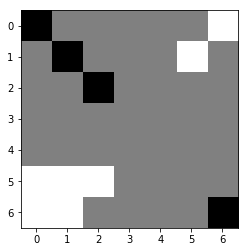

((2, 2), (4, 1)): n_v:  3711 q_all:+0.019734 q:+0.034051 q_m:+0.100000 p:0.518112
((2, 2), (3, 1)): n_v:   418 q_all:-0.030788 q:-0.031698 q_m:-0.066667 p:0.156816
((6, 6), (5, 5)): n_v:   360 q_all:-0.018486 q:-0.044210 q_m:-0.066667 p:0.114401
((2, 2), (4, 2)): n_v:   122 q_all:-0.049884 q:-0.024367 q_m:+0.033333 p:0.056787
((2, 2), (1, 3)): n_v:    69 q_all:-0.037991 q:-0.064102 q_m:-0.066667 p:0.028239
((1, 1), (2, 1)): n_v:    38 q_all:-0.044171 q:-0.074858 q_m:-0.066667 p:0.016907
((2, 2), (4, 0)): n_v:    34 q_all:-0.062923 q:-0.023178 q_m:+0.033333 p:0.018135
((2, 2), (3, 2)): n_v:    21 q_all:-0.050327 q:-0.044898 q_m:-0.066667 p:0.010102
((2, 2), (3, 3)): n_v:    16 q_all:-0.034649 q:-0.040848 q_m:-0.066667 p:0.006470
((2, 2), (2, 3)): n_v:     8 q_all:-0.038296 q:-0.050881 q_m:-0.066667 p:0.003460
((2, 2), (4, 4)): n_v:     5 q_all:-0.041325 q:-0.064807 q_m:-0.100000 p:0.002383
((2, 2), (4, 3)): n_v:     4 q_all:-0.041715 q:-0.022554 q_m:-0.033333 p:0.002124
((2, 2), (2, 4))

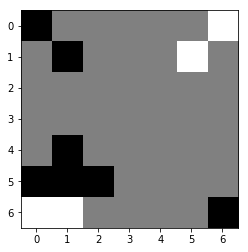

((6, 0), (4, 0)): n_v:  2592 q_all:-0.019147 q:-0.018153 q_m:+0.100000 p:0.519865
((6, 1), (6, 2)): n_v:   678 q_all:+0.005426 q:-0.005661 q_m:+0.066667 p:0.063567
((6, 1), (4, 2)): n_v:   656 q_all:-0.011529 q:-0.013635 q_m:+0.100000 p:0.109889
((6, 0), (4, 2)): n_v:   548 q_all:-0.017751 q:-0.029785 q_m:+0.100000 p:0.106700
((6, 1), (4, 0)): n_v:   475 q_all:-0.017409 q:-0.003515 q_m:+0.100000 p:0.091678
((1, 5), (2, 4)): n_v:   188 q_all:-0.029359 q:-0.039724 q_m:-0.066667 p:0.046071
((6, 0), (6, 2)): n_v:    50 q_all:-0.025395 q:-0.022060 q_m:+0.033333 p:0.011378
((1, 5), (2, 6)): n_v:    41 q_all:-0.040335 q:-0.053968 q_m:-0.066667 p:0.011846
((6, 1), (5, 3)): n_v:    26 q_all:-0.045124 q:-0.045045 q_m:-0.033333 p:0.008313
((1, 5), (1, 4)): n_v:    24 q_all:-0.019185 q:-0.041643 q_m:-0.066667 p:0.004875
((0, 6), (2, 6)): n_v:    18 q_all:-0.047335 q:-0.061375 q_m:-0.100000 p:0.005820
((1, 5), (0, 4)): n_v:    13 q_all:-0.040729 q:-0.050970 q_m:-0.066667 p:0.003926
((6, 1), (4, 3))

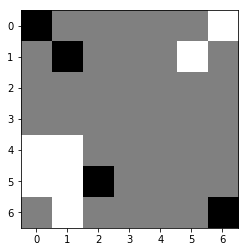

((5, 2), (6, 0)): n_v:  3506 q_all:+0.012502 q:+0.023621 q_m:+0.100000 p:0.835061
((5, 2), (4, 2)): n_v:   152 q_all:-0.002514 q:-0.044652 q_m:+0.066667 p:0.047413
((5, 2), (6, 2)): n_v:   112 q_all:-0.011368 q:-0.006533 q_m:+0.066667 p:0.039883
((5, 2), (3, 1)): n_v:    74 q_all:-0.029455 q:-0.022777 q_m:+0.033333 p:0.032765
((6, 6), (5, 5)): n_v:    53 q_all:-0.021368 q:-0.034277 q_m:-0.066667 p:0.021618
((1, 1), (2, 2)): n_v:    31 q_all:-0.017591 q:-0.017589 q_m:-0.066667 p:0.012090
((5, 2), (3, 0)): n_v:     4 q_all:-0.044070 q:-0.031231 q_m:+0.033333 p:0.002485
((1, 1), (3, 1)): n_v:     2 q_all:-0.021869 q:-0.016723 q_m:+0.033333 p:0.000847
((1, 1), (0, 2)): n_v:     2 q_all:-0.063359 q:-0.047537 q_m:-0.066667 p:0.001196
((5, 2), (4, 3)): n_v:     1 q_all:-0.042367 q:-0.028967 q_m:-0.066667 p:0.000720
((5, 2), (5, 3)): n_v:     1 q_all:-0.079591 q:-0.045929 q_m:-0.066667 p:0.001050
((5, 2), (6, 4)): n_v:     1 q_all:-0.031265 q:-0.051967 q_m:-0.100000 p:0.000637
((1, 1), (2, 0))

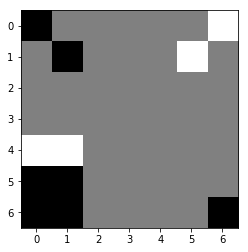

((4, 1), (5, 2)): n_v:  4688 q_all:-0.009806 q:-0.022862 q_m:+0.066667 p:0.881495
((1, 5), (1, 4)): n_v:   135 q_all:-0.049950 q:-0.063697 q_m:-0.066667 p:0.049612
((4, 1), (4, 2)): n_v:    50 q_all:-0.058831 q:-0.068338 q_m:-0.000000 p:0.020364
((4, 0), (5, 2)): n_v:    44 q_all:-0.027716 q:-0.036883 q_m:+0.033333 p:0.011805
((4, 1), (6, 2)): n_v:    25 q_all:-0.016033 q:-0.028269 q_m:+0.033333 p:0.005460
((1, 5), (2, 4)): n_v:    21 q_all:-0.050040 q:-0.063319 q_m:-0.066667 p:0.007996
((1, 5), (2, 5)): n_v:    16 q_all:-0.052640 q:-0.077723 q_m:-0.066667 p:0.006152
((4, 0), (6, 2)): n_v:    14 q_all:-0.032735 q:-0.029125 q_m:+0.033333 p:0.004239
((4, 1), (3, 2)): n_v:     3 q_all:-0.092798 q:-0.055563 q_m:-0.066667 p:0.001741
((4, 1), (6, 3)): n_v:     2 q_all:-0.063481 q:-0.075691 q_m:-0.100000 p:0.001040
((1, 5), (0, 4)): n_v:     2 q_all:-0.056310 q:-0.075147 q_m:-0.066667 p:0.000906
((4, 0), (3, 1)): n_v:     2 q_all:-0.116769 q:-0.072057 q_m:-0.066667 p:0.001789
((1, 5), (2, 6))

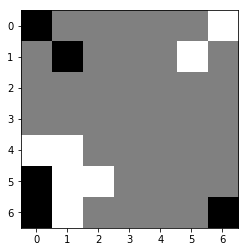

((6, 6), (5, 5)): n_v:  1416 q_all:+0.012310 q:-0.004448 q_m:-0.033333 p:0.216445
((1, 1), (2, 2)): n_v:  1397 q_all:+0.000408 q:+0.004303 q_m:-0.033333 p:0.281319
((6, 0), (6, 2)): n_v:  1348 q_all:+0.035815 q:+0.030044 q_m:+0.133333 p:0.076847
((6, 6), (6, 4)): n_v:   345 q_all:-0.013833 q:-0.012757 q_m:-0.066667 p:0.089497
((6, 0), (4, 2)): n_v:   298 q_all:+0.006358 q:-0.014220 q_m:+0.133333 p:0.052760
((5, 0), (4, 2)): n_v:   215 q_all:-0.006871 q:-0.021804 q_m:+0.133333 p:0.049616
((6, 6), (4, 4)): n_v:   203 q_all:-0.006559 q:-0.015756 q_m:-0.066667 p:0.046800
((5, 0), (3, 1)): n_v:   146 q_all:-0.022582 q:-0.017095 q_m:+0.066667 p:0.043202
((5, 0), (6, 2)): n_v:   111 q_all:-0.000801 q:+0.015346 q_m:+0.133333 p:0.023049
((1, 1), (3, 1)): n_v:    85 q_all:-0.016443 q:+0.002234 q_m:+0.066667 p:0.023088
((0, 0), (0, 2)): n_v:    63 q_all:-0.011245 q:-0.017524 q_m:-0.066667 p:0.015652
((1, 1), (0, 2)): n_v:    59 q_all:-0.003329 q:-0.023043 q_m:-0.033333 p:0.012757
((0, 0), (2, 2))

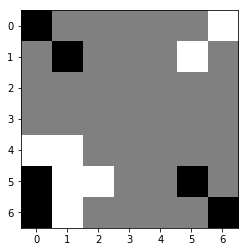

((1, 5), (1, 4)): n_v:   398 q_all:-0.001572 q:-0.019343 q_m:+0.066667 p:0.073931
((5, 2), (5, 3)): n_v:   383 q_all:-0.011741 q:-0.027957 q_m:+0.066667 p:0.093597
((1, 5), (2, 4)): n_v:   270 q_all:+0.001152 q:-0.016699 q_m:+0.066667 p:0.046103
((1, 5), (2, 5)): n_v:   269 q_all:+0.000776 q:-0.026776 q_m:+0.066667 p:0.046256
((5, 2), (5, 4)): n_v:   255 q_all:+0.005015 q:+0.012302 q_m:+0.100000 p:0.037947
((4, 1), (4, 2)): n_v:   219 q_all:-0.032957 q:-0.059760 q_m:+0.066667 p:0.079900
((5, 1), (6, 2)): n_v:   173 q_all:+0.002112 q:-0.036616 q_m:+0.066667 p:0.028646
((4, 0), (2, 1)): n_v:   166 q_all:+0.000324 q:+0.003147 q_m:+0.100000 p:0.028998
((5, 2), (4, 3)): n_v:   130 q_all:-0.013970 q:-0.041583 q_m:+0.066667 p:0.033441
((4, 1), (3, 2)): n_v:   107 q_all:-0.016607 q:-0.023894 q_m:+0.066667 p:0.029204
((5, 2), (6, 3)): n_v:    86 q_all:-0.002292 q:-0.019738 q_m:+0.066667 p:0.016470
((4, 0), (3, 1)): n_v:    70 q_all:-0.040761 q:-0.045452 q_m:+0.066667 p:0.028480
((1, 5), (2, 6))

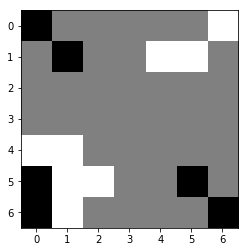

((1, 1), (2, 2)): n_v:  1162 q_all:+0.008436 q:+0.025326 q_m:-0.033333 p:0.446883
((5, 5), (4, 4)): n_v:   649 q_all:+0.005699 q:+0.010483 q_m:-0.033333 p:0.262113
((6, 0), (4, 2)): n_v:    66 q_all:+0.033890 q:-0.007433 q_m:+0.133333 p:0.014021
((5, 0), (4, 2)): n_v:    58 q_all:-0.002024 q:-0.016858 q_m:+0.133333 p:0.026571
((5, 0), (3, 1)): n_v:    56 q_all:-0.018604 q:-0.000089 q_m:+0.066667 p:0.031681
((6, 0), (6, 2)): n_v:    56 q_all:+0.035805 q:+0.035704 q_m:+0.133333 p:0.011048
((0, 0), (2, 2)): n_v:    37 q_all:-0.038532 q:+0.010380 q_m:-0.066667 p:0.026093
((0, 0), (0, 2)): n_v:    31 q_all:-0.048759 q:-0.008481 q_m:-0.066667 p:0.023928
((6, 6), (6, 4)): n_v:    27 q_all:-0.050827 q:-0.008546 q_m:-0.066667 p:0.021843
((5, 5), (6, 4)): n_v:    22 q_all:-0.000834 q:-0.004212 q_m:-0.033333 p:0.010126
((1, 1), (2, 3)): n_v:    19 q_all:+0.022886 q:+0.014121 q_m:-0.000000 p:0.005656
((1, 1), (0, 2)): n_v:    19 q_all:+0.009588 q:-0.005482 q_m:-0.033333 p:0.007330
((5, 0), (6, 2))

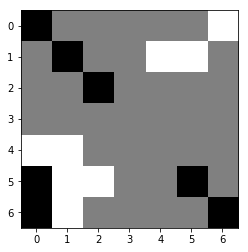

((4, 1), (2, 1)): n_v:   776 q_all:-0.004522 q:+0.003531 q_m:+0.166667 p:0.230809
((4, 0), (2, 1)): n_v:   772 q_all:-0.017858 q:+0.024194 q_m:+0.166667 p:0.290361
((1, 4), (1, 2)): n_v:   431 q_all:+0.028149 q:+0.029864 q_m:+0.166667 p:0.044418
((4, 0), (2, 0)): n_v:   313 q_all:+0.019111 q:-0.002134 q_m:+0.100000 p:0.049061
((4, 1), (2, 0)): n_v:   165 q_all:-0.015344 q:-0.021443 q_m:+0.100000 p:0.059944
((5, 2), (5, 4)): n_v:   105 q_all:+0.001221 q:+0.005908 q_m:+0.100000 p:0.027784
((4, 0), (3, 1)): n_v:    76 q_all:+0.001176 q:-0.021791 q_m:+0.133333 p:0.020015
((5, 2), (3, 3)): n_v:    48 q_all:-0.011809 q:-0.008488 q_m:+0.100000 p:0.016440
((1, 4), (3, 3)): n_v:    40 q_all:-0.008087 q:-0.006669 q_m:+0.100000 p:0.012977
((1, 4), (2, 5)): n_v:    39 q_all:-0.056988 q:-0.033776 q_m:+0.066667 p:0.023474
((4, 1), (3, 3)): n_v:    39 q_all:-0.022658 q:-0.020488 q_m:+0.100000 p:0.015639
((4, 1), (3, 2)): n_v:    32 q_all:-0.022014 q:-0.010535 q_m:+0.133333 p:0.012855
((5, 2), (5, 3))

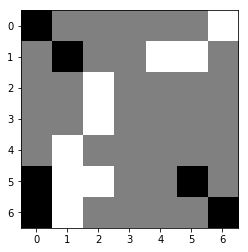

((5, 0), (3, 1)): n_v:   642 q_all:+0.032482 q:+0.023985 q_m:+0.100000 p:0.266185
((1, 1), (2, 3)): n_v:   374 q_all:+0.038543 q:+0.041873 q_m:+0.100000 p:0.138268
((1, 1), (3, 1)): n_v:   206 q_all:+0.019910 q:+0.023600 q_m:+0.100000 p:0.104652
((5, 0), (4, 2)): n_v:   113 q_all:+0.021873 q:-0.004232 q_m:+0.166667 p:0.056202
((5, 5), (4, 4)): n_v:   107 q_all:-0.029402 q:+0.012232 q_m:-0.066667 p:0.093722
((5, 5), (4, 3)): n_v:   104 q_all:+0.014723 q:+0.023068 q_m:+0.033333 p:0.056650
((1, 1), (3, 3)): n_v:   100 q_all:+0.021404 q:+0.024717 q_m:+0.033333 p:0.049883
((6, 0), (4, 2)): n_v:    77 q_all:+0.057443 q:+0.007786 q_m:+0.166667 p:0.017440
((5, 5), (3, 3)): n_v:    71 q_all:+0.019621 q:+0.025462 q_m:+0.033333 p:0.036204
((5, 0), (4, 0)): n_v:    38 q_all:+0.031749 q:+0.014637 q_m:+0.066667 p:0.016149
((1, 1), (2, 1)): n_v:    36 q_all:+0.032200 q:+0.025787 q_m:+0.066667 p:0.015023
((6, 6), (4, 4)): n_v:    20 q_all:-0.060725 q:+0.001262 q_m:-0.100000 p:0.022591
((0, 0), (2, 1))

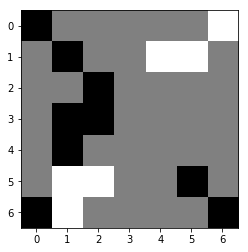

((5, 1), (4, 2)): n_v:   805 q_all:-0.024708 q:-0.009046 q_m:+0.133333 p:0.209342
((5, 2), (4, 4)): n_v:   501 q_all:-0.024664 q:-0.019067 q_m:-0.033333 p:0.130140
((5, 1), (5, 0)): n_v:   371 q_all:-0.016492 q:+0.000719 q_m:+0.066667 p:0.076564
((6, 1), (4, 2)): n_v:   138 q_all:-0.033648 q:-0.017880 q_m:+0.100000 p:0.043970
((5, 2), (5, 4)): n_v:   127 q_all:-0.018312 q:-0.004117 q_m:-0.033333 p:0.027950
((1, 4), (1, 2)): n_v:   110 q_all:-0.011640 q:-0.020117 q_m:+0.033333 p:0.019019
((1, 4), (2, 4)): n_v:    80 q_all:-0.052822 q:-0.048008 q_m:-0.066667 p:0.035613
((5, 2), (3, 3)): n_v:    66 q_all:-0.053644 q:-0.013803 q_m:+0.033333 p:0.029491
((5, 2), (5, 0)): n_v:    51 q_all:-0.031467 q:-0.015462 q_m:+0.033333 p:0.015742
((5, 2), (3, 0)): n_v:    51 q_all:-0.016139 q:-0.051092 q_m:+0.033333 p:0.010570
((5, 2), (4, 3)): n_v:    44 q_all:-0.036513 q:-0.028556 q_m:-0.000000 p:0.014919
((1, 4), (2, 3)): n_v:    42 q_all:-0.027529 q:-0.010657 q_m:+0.066667 p:0.011714
((1, 4), (3, 3))

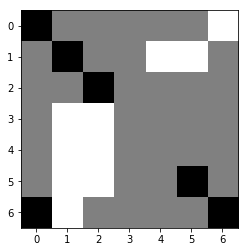

((2, 2), (4, 3)): n_v:  2099 q_all:+0.011798 q:+0.013616 q_m:+0.066667 p:0.705786
((2, 2), (2, 3)): n_v:   368 q_all:+0.015983 q:-0.005246 q_m:+0.033333 p:0.113669
((6, 0), (6, 2)): n_v:    64 q_all:+0.049316 q:+0.028726 q_m:+0.066667 p:0.006495
((2, 2), (4, 4)): n_v:    33 q_all:-0.037355 q:-0.024241 q_m:-0.133333 p:0.021498
((2, 2), (4, 0)): n_v:    30 q_all:-0.030454 q:+0.002614 q_m:+0.066667 p:0.018326
((1, 1), (2, 1)): n_v:    28 q_all:+0.028969 q:+0.017575 q_m:+0.033333 p:0.006465
((2, 2), (0, 4)): n_v:    27 q_all:-0.027962 q:-0.000786 q_m:-0.000000 p:0.015858
((0, 0), (2, 1)): n_v:    26 q_all:-0.000186 q:+0.018789 q_m:-0.000000 p:0.010930
((6, 0), (5, 0)): n_v:    21 q_all:+0.050019 q:+0.059058 q_m:+0.100000 p:0.001974
((0, 0), (0, 2)): n_v:    16 q_all:-0.048208 q:-0.033910 q_m:-0.133333 p:0.011770
((6, 6), (6, 4)): n_v:    13 q_all:-0.047111 q:-0.023206 q_m:-0.133333 p:0.009704
((2, 2), (3, 3)): n_v:    12 q_all:-0.012918 q:-0.012546 q_m:+0.033333 p:0.005947
((2, 2), (2, 4))

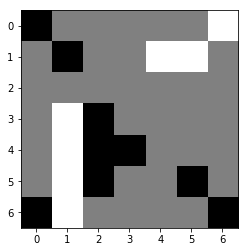

((3, 1), (5, 3)): n_v:  1981 q_all:-0.012693 q:-0.049791 q_m:+0.133333 p:0.563092
((3, 1), (3, 3)): n_v:   594 q_all:+0.003824 q:-0.017919 q_m:+0.133333 p:0.117843
((6, 1), (5, 3)): n_v:   539 q_all:+0.019646 q:-0.015195 q_m:+0.133333 p:0.062312
((4, 1), (5, 3)): n_v:   154 q_all:-0.010868 q:-0.044635 q_m:+0.133333 p:0.042462
((1, 5), (3, 3)): n_v:   140 q_all:-0.006476 q:+0.003529 q_m:+0.133333 p:0.035085
((3, 1), (1, 3)): n_v:   126 q_all:-0.071818 q:-0.091516 q_m:-0.066667 p:0.074715
((1, 4), (3, 3)): n_v:    90 q_all:+0.001981 q:+0.020398 q_m:+0.133333 p:0.018891
((4, 1), (3, 3)): n_v:    89 q_all:-0.002861 q:-0.006620 q_m:+0.133333 p:0.020810
((5, 1), (3, 3)): n_v:    73 q_all:-0.008373 q:+0.003064 q_m:+0.133333 p:0.019262
((5, 1), (5, 3)): n_v:    70 q_all:-0.016953 q:-0.038776 q_m:+0.133333 p:0.021591
((3, 1), (1, 0)): n_v:    23 q_all:-0.031578 q:-0.025901 q_m:+0.066667 p:0.009028
((1, 4), (1, 3)): n_v:    10 q_all:-0.040446 q:-0.059177 q_m:-0.033333 p:0.004425
((3, 1), (5, 0))

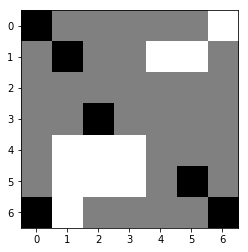

((3, 2), (5, 0)): n_v:  1096 q_all:+0.023951 q:+0.028230 q_m:+0.066667 p:0.196310
((3, 2), (3, 1)): n_v:   638 q_all:-0.000654 q:-0.017203 q_m:+0.033333 p:0.197254
((6, 0), (5, 0)): n_v:   408 q_all:+0.042903 q:+0.013619 q_m:+0.100000 p:0.032197
((3, 2), (3, 3)): n_v:   337 q_all:+0.020047 q:+0.021593 q_m:+0.033333 p:0.067384
((5, 5), (6, 4)): n_v:   238 q_all:-0.013654 q:+0.004690 q_m:-0.033333 p:0.089393
((6, 0), (6, 2)): n_v:   223 q_all:+0.035953 q:+0.040065 q_m:+0.133333 p:0.025843
((3, 2), (4, 4)): n_v:   182 q_all:+0.007403 q:+0.014304 q_m:-0.000000 p:0.048587
((3, 2), (5, 4)): n_v:   103 q_all:+0.002551 q:-0.002728 q_m:-0.000000 p:0.030222
((5, 5), (5, 6)): n_v:   102 q_all:-0.051565 q:-0.025057 q_m:-0.100000 p:0.059220
((6, 6), (6, 4)): n_v:    86 q_all:-0.014007 q:-0.001226 q_m:-0.066667 p:0.032597
((3, 2), (1, 0)): n_v:    75 q_all:-0.067185 q:-0.045723 q_m:-0.133333 p:0.049983
((3, 2), (2, 4)): n_v:    60 q_all:-0.004228 q:+0.016826 q_m:-0.000000 p:0.019874
((0, 0), (1, 0))

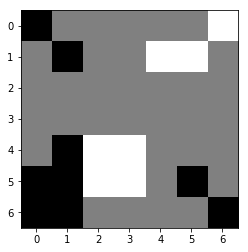

((4, 2), (4, 0)): n_v:   789 q_all:-0.021759 q:-0.029733 q_m:+0.133333 p:0.226364
((5, 2), (6, 2)): n_v:   479 q_all:-0.037295 q:-0.044709 q_m:+0.100000 p:0.182017
((5, 3), (6, 5)): n_v:   417 q_all:-0.012662 q:-0.000641 q_m:+0.066667 p:0.096910
((4, 3), (6, 5)): n_v:   367 q_all:-0.007127 q:+0.003827 q_m:+0.066667 p:0.073092
((5, 2), (4, 0)): n_v:   262 q_all:-0.027265 q:-0.045405 q_m:+0.133333 p:0.084000
((5, 3), (6, 4)): n_v:   219 q_all:-0.023800 q:-0.029748 q_m:+0.033333 p:0.065678
((4, 2), (2, 0)): n_v:   145 q_all:-0.024463 q:-0.027710 q_m:-0.000000 p:0.043954
((4, 3), (6, 2)): n_v:    48 q_all:-0.036289 q:-0.039107 q_m:+0.066667 p:0.018206
((4, 3), (6, 4)): n_v:    46 q_all:-0.033384 q:-0.020220 q_m:-0.000000 p:0.016686
((1, 4), (2, 6)): n_v:    42 q_all:-0.064318 q:-0.084088 q_m:-0.066667 p:0.022883
((4, 2), (6, 2)): n_v:    30 q_all:-0.041390 q:-0.054279 q_m:+0.066667 p:0.012522
((4, 2), (3, 1)): n_v:    10 q_all:-0.049546 q:-0.060097 q_m:+0.033333 p:0.004483
((4, 3), (5, 4))

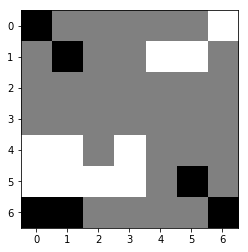

((6, 1), (4, 2)): n_v:  1667 q_all:+0.038238 q:+0.016793 q_m:+0.200000 p:0.403485
((5, 5), (4, 4)): n_v:   310 q_all:-0.022049 q:+0.009831 q_m:+0.033333 p:0.193236
((6, 0), (4, 2)): n_v:   202 q_all:+0.031280 q:-0.010599 q_m:+0.200000 p:0.057577
((6, 1), (6, 2)): n_v:   201 q_all:+0.010393 q:-0.010542 q_m:+0.100000 p:0.084367
((1, 1), (2, 2)): n_v:   104 q_all:-0.043464 q:-0.001329 q_m:-0.100000 p:0.079196
((6, 6), (4, 4)): n_v:    76 q_all:-0.054445 q:-0.002980 q_m:-0.000000 p:0.063351
((5, 5), (6, 4)): n_v:    45 q_all:-0.036141 q:-0.013718 q_m:-0.033333 p:0.032671
((0, 0), (2, 2)): n_v:    30 q_all:-0.058685 q:-0.018289 q_m:-0.133333 p:0.026302
((1, 1), (3, 1)): n_v:    14 q_all:-0.006470 q:-0.027195 q_m:-0.000000 p:0.007772
((6, 6), (6, 4)): n_v:    12 q_all:-0.038233 q:-0.016614 q_m:-0.066667 p:0.009395
((6, 0), (6, 2)): n_v:    11 q_all:-0.013463 q:-0.028581 q_m:+0.066667 p:0.006620
((6, 1), (6, 3)): n_v:     7 q_all:-0.028177 q:-0.014397 q_m:-0.000000 p:0.005050
((5, 5), (5, 4))

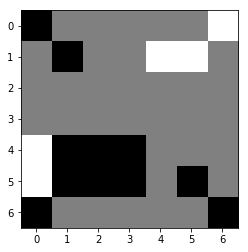

((5, 0), (6, 1)): n_v:  1180 q_all:-0.033045 q:-0.034095 q_m:+0.033333 p:0.207817
((1, 4), (3, 2)): n_v:   708 q_all:-0.048351 q:-0.046928 q_m:-0.000000 p:0.184572
((4, 0), (6, 2)): n_v:   399 q_all:-0.087905 q:-0.070237 q_m:-0.000000 p:0.190928
((5, 0), (6, 2)): n_v:   333 q_all:-0.053792 q:-0.066232 q_m:-0.000000 p:0.096709
((4, 0), (3, 1)): n_v:   233 q_all:-0.052114 q:-0.081165 q_m:-0.033333 p:0.065425
((4, 0), (6, 1)): n_v:   167 q_all:-0.040858 q:-0.073235 q_m:-0.000000 p:0.036778
((4, 0), (3, 2)): n_v:   167 q_all:-0.052497 q:-0.073316 q_m:-0.000000 p:0.047523
((1, 4), (3, 4)): n_v:   101 q_all:-0.068597 q:-0.067794 q_m:-0.133333 p:0.037787
((5, 0), (3, 2)): n_v:    89 q_all:-0.061953 q:-0.067900 q_m:-0.000000 p:0.030144
((1, 4), (3, 3)): n_v:    33 q_all:-0.061955 q:-0.058380 q_m:-0.066667 p:0.011088
((1, 4), (1, 2)): n_v:    21 q_all:-0.071443 q:-0.059853 q_m:-0.133333 p:0.008445
((1, 4), (2, 2)): n_v:    19 q_all:-0.065636 q:-0.053695 q_m:-0.133333 p:0.006710
((1, 4), (0, 2))

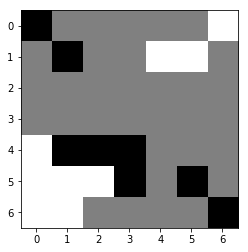

((5, 3), (6, 2)): n_v:  1338 q_all:+0.064477 q:+0.046248 q_m:+0.200000 p:0.221173
((4, 3), (6, 2)): n_v:  1029 q_all:+0.060299 q:+0.038275 q_m:+0.166667 p:0.195275
((5, 3), (6, 4)): n_v:   262 q_all:-0.047646 q:-0.046021 q_m:-0.000000 p:0.216952
((4, 3), (6, 4)): n_v:   255 q_all:-0.041533 q:-0.044203 q_m:-0.033333 p:0.202422
((4, 1), (6, 2)): n_v:    89 q_all:+0.025817 q:-0.001293 q_m:+0.166667 p:0.035385
((4, 2), (6, 4)): n_v:    59 q_all:-0.046792 q:-0.041609 q_m:-0.033333 p:0.048778
((4, 2), (6, 2)): n_v:    34 q_all:+0.039935 q:+0.011460 q_m:+0.166667 p:0.010790
((1, 1), (0, 2)): n_v:    23 q_all:-0.037237 q:-0.045807 q_m:-0.000000 p:0.017785
((4, 3), (6, 5)): n_v:     5 q_all:-0.055442 q:-0.046472 q_m:-0.033333 p:0.005152
((5, 3), (6, 5)): n_v:     2 q_all:-0.051281 q:-0.055528 q_m:-0.033333 p:0.002317
((4, 3), (4, 5)): n_v:     2 q_all:-0.040009 q:-0.045955 q_m:-0.033333 p:0.002333
((0, 0), (0, 2)): n_v:     2 q_all:-0.056082 q:-0.053723 q_m:-0.033333 p:0.002000
((4, 1), (3, 1))

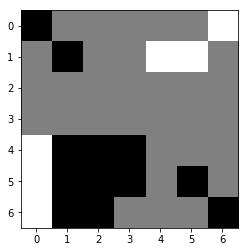

((1, 4), (3, 2)): n_v:  1175 q_all:-0.053805 q:-0.056627 q_m:-0.000000 p:0.293252
((4, 0), (3, 1)): n_v:   411 q_all:-0.050158 q:-0.087003 q_m:-0.033333 p:0.093943
((4, 0), (3, 2)): n_v:   354 q_all:-0.058049 q:-0.081578 q_m:-0.000000 p:0.097005
((1, 4), (3, 4)): n_v:   289 q_all:-0.090084 q:-0.088731 q_m:-0.133333 p:0.132454
((5, 0), (3, 2)): n_v:   152 q_all:-0.058679 q:-0.098834 q_m:-0.000000 p:0.042174
((1, 4), (3, 3)): n_v:   151 q_all:-0.077782 q:-0.069118 q_m:-0.066667 p:0.058712
((1, 4), (2, 2)): n_v:   116 q_all:-0.054283 q:-0.071105 q_m:-0.133333 p:0.029371
((1, 4), (1, 2)): n_v:    92 q_all:-0.074263 q:-0.069549 q_m:-0.133333 p:0.034090
((1, 5), (3, 4)): n_v:    67 q_all:-0.086029 q:-0.096175 q_m:-0.133333 p:0.029263
((4, 0), (2, 2)): n_v:    65 q_all:-0.061620 q:-0.078591 q_m:-0.133333 p:0.019394
((1, 4), (0, 3)): n_v:    60 q_all:-0.081806 q:-0.102234 q_m:-0.166667 p:0.024778
((1, 4), (3, 5)): n_v:    36 q_all:-0.098944 q:-0.091682 q_m:-0.200000 p:0.018712
((1, 4), (2, 3))

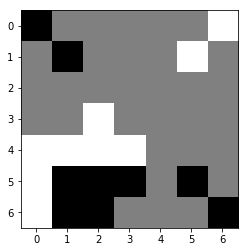

((1, 1), (3, 1)): n_v:   889 q_all:+0.070903 q:+0.073397 q_m:+0.266667 p:0.185197
((5, 3), (3, 1)): n_v:   708 q_all:+0.070951 q:+0.056813 q_m:+0.266667 p:0.147118
((1, 1), (3, 3)): n_v:   575 q_all:+0.051803 q:+0.057215 q_m:+0.200000 p:0.182801
((5, 3), (3, 3)): n_v:   369 q_all:+0.054405 q:+0.046342 q_m:+0.200000 p:0.111726
((5, 5), (3, 3)): n_v:   369 q_all:+0.055903 q:+0.070977 q_m:+0.200000 p:0.108796
((5, 3), (3, 5)): n_v:   148 q_all:-0.001935 q:+0.013078 q_m:-0.000000 p:0.092601
((5, 1), (3, 3)): n_v:   115 q_all:-0.015629 q:+0.019356 q_m:+0.200000 p:0.081470
((5, 2), (3, 1)): n_v:    51 q_all:+0.002402 q:+0.006719 q_m:+0.266667 p:0.030968
((5, 1), (3, 1)): n_v:    28 q_all:-0.051868 q:-0.029643 q_m:+0.266667 p:0.025474
((5, 2), (3, 3)): n_v:    21 q_all:-0.046413 q:+0.011867 q_m:+0.200000 p:0.018789
((5, 5), (3, 5)): n_v:    17 q_all:-0.001573 q:+0.018247 q_m:-0.000000 p:0.011141
((5, 3), (4, 4)): n_v:     1 q_all:+0.022744 q:+0.042822 q_m:+0.100000 p:0.000664
((5, 5), (6, 5))

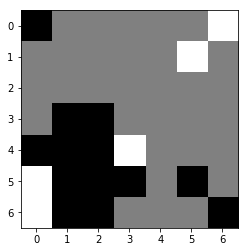

((4, 3), (6, 3)): n_v:  1821 q_all:-0.040658 q:-0.055915 q_m:-0.066667 p:0.554562
((4, 3), (6, 5)): n_v:  1004 q_all:-0.044984 q:-0.059314 q_m:-0.133333 p:0.331579
((4, 3), (3, 3)): n_v:    88 q_all:-0.058565 q:-0.078574 q_m:-0.100000 p:0.036540
((4, 3), (6, 4)): n_v:    37 q_all:-0.088451 q:-0.077409 q_m:-0.133333 p:0.022430
((4, 3), (3, 5)): n_v:    16 q_all:-0.124531 q:-0.160364 q_m:-0.266667 p:0.013543
((4, 3), (2, 4)): n_v:    11 q_all:-0.122301 q:-0.165858 q_m:-0.266667 p:0.009155
((4, 3), (5, 4)): n_v:     8 q_all:-0.083824 q:-0.058773 q_m:-0.100000 p:0.004961
((4, 3), (2, 2)): n_v:     6 q_all:-0.085377 q:-0.107551 q_m:-0.133333 p:0.003886
((4, 3), (2, 1)): n_v:     5 q_all:-0.113600 q:-0.095652 q_m:-0.133333 p:0.003587
((4, 3), (2, 3)): n_v:     4 q_all:-0.123240 q:-0.110618 q_m:-0.200000 p:0.003188
((1, 5), (3, 3)): n_v:     3 q_all:-0.079128 q:-0.091395 q_m:-0.133333 p:0.001888
((4, 3), (4, 4)): n_v:     3 q_all:-0.094345 q:-0.077507 q_m:-0.100000 p:0.002273
((4, 3), (2, 5))

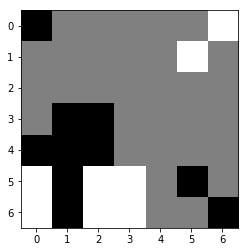

((3, 2), (4, 3)): n_v:  3012 q_all:+0.049030 q:+0.072225 q_m:+0.233333 p:0.486832
((3, 2), (2, 3)): n_v:   253 q_all:+0.015043 q:+0.010910 q_m:+0.100000 p:0.087195
((5, 5), (4, 3)): n_v:   113 q_all:+0.051996 q:+0.067072 q_m:+0.200000 p:0.016409
((5, 5), (5, 4)): n_v:    85 q_all:+0.016265 q:+0.046877 q_m:+0.233333 p:0.028953
((5, 5), (6, 4)): n_v:    50 q_all:+0.042115 q:+0.064070 q_m:+0.233333 p:0.010093
((3, 1), (4, 3)): n_v:    39 q_all:+0.033325 q:+0.026134 q_m:+0.200000 p:0.009679
((3, 2), (5, 4)): n_v:    32 q_all:+0.025374 q:+0.020410 q_m:+0.200000 p:0.009289
((6, 1), (4, 3)): n_v:    31 q_all:+0.002141 q:+0.042308 q_m:+0.200000 p:0.012936
((3, 1), (3, 0)): n_v:    20 q_all:+0.024828 q:+0.025120 q_m:+0.100000 p:0.005879
((5, 1), (4, 3)): n_v:    17 q_all:-0.071366 q:-0.009332 q_m:+0.200000 p:0.013654
((4, 2), (5, 4)): n_v:    14 q_all:+0.009861 q:+0.008120 q_m:+0.200000 p:0.005416
((3, 2), (4, 4)): n_v:     8 q_all:+0.018699 q:+0.026564 q_m:+0.133333 p:0.002850
((4, 1), (4, 3))

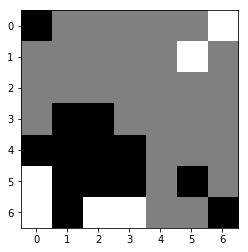

((1, 5), (3, 3)): n_v:  2090 q_all:-0.017481 q:-0.041682 q_m:-0.033333 p:0.259986
((6, 3), (5, 4)): n_v:  1794 q_all:-0.045063 q:-0.024284 q_m:-0.000000 p:0.456488
((6, 3), (6, 5)): n_v:   204 q_all:-0.032800 q:-0.033294 q_m:-0.100000 p:0.040146
((1, 5), (1, 4)): n_v:   203 q_all:-0.069801 q:-0.094375 q_m:-0.200000 p:0.075444
((6, 2), (5, 4)): n_v:   124 q_all:-0.051114 q:-0.057205 q_m:-0.033333 p:0.034851
((1, 5), (2, 4)): n_v:   103 q_all:-0.083493 q:-0.100940 q_m:-0.200000 p:0.045040
((6, 3), (4, 4)): n_v:    61 q_all:-0.054428 q:-0.043009 q_m:-0.033333 p:0.018324
((1, 5), (1, 3)): n_v:    21 q_all:-0.100936 q:-0.108024 q_m:-0.233333 p:0.011331
((6, 3), (6, 4)): n_v:    18 q_all:-0.101301 q:-0.074151 q_m:-0.066667 p:0.009239
((6, 3), (4, 5)): n_v:    17 q_all:-0.087375 q:-0.080993 q_m:-0.166667 p:0.008118
((6, 2), (4, 4)): n_v:    14 q_all:-0.083126 q:-0.106011 q_m:-0.033333 p:0.006283
((1, 5), (2, 5)): n_v:    13 q_all:-0.077545 q:-0.102333 q_m:-0.200000 p:0.005619
((1, 5), (0, 4))

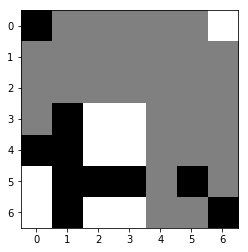

((5, 3), (5, 4)): n_v:  1107 q_all:+0.022257 q:+0.032936 q_m:+0.200000 p:0.138277
((5, 3), (4, 4)): n_v:   738 q_all:+0.017453 q:+0.020484 q_m:+0.200000 p:0.110431
((3, 1), (3, 0)): n_v:   609 q_all:+0.033774 q:+0.006424 q_m:+0.066667 p:0.039420
((3, 1), (2, 2)): n_v:   578 q_all:+0.022206 q:+0.024633 q_m:+0.200000 p:0.072168
((5, 3), (6, 4)): n_v:    95 q_all:-0.010621 q:+0.007077 q_m:+0.133333 p:0.028293
((5, 3), (6, 5)): n_v:    93 q_all:+0.010910 q:-0.005932 q_m:+0.033333 p:0.017142
((5, 5), (6, 5)): n_v:    89 q_all:-0.010133 q:+0.016960 q_m:+0.066667 p:0.026291
((5, 3), (3, 5)): n_v:    72 q_all:+0.015829 q:+0.024039 q_m:+0.033333 p:0.011342
((0, 0), (1, 1)): n_v:    54 q_all:+0.015390 q:+0.025934 q_m:+0.066667 p:0.008720
((5, 3), (3, 4)): n_v:    42 q_all:+0.028798 q:+0.030417 q_m:+0.166667 p:0.003877
((6, 6), (5, 4)): n_v:    39 q_all:+0.007747 q:+0.019443 q_m:+0.166667 p:0.007715
((5, 5), (4, 6)): n_v:    34 q_all:+0.001546 q:+0.037667 q_m:+0.066667 p:0.008126
((6, 6), (4, 4))

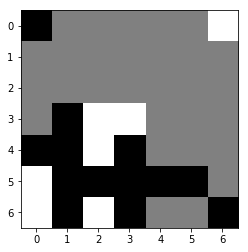

((3, 3), (4, 4)): n_v:  1172 q_all:+0.003530 q:-0.003759 q_m:+0.100000 p:0.387470
((3, 2), (3, 0)): n_v:   650 q_all:+0.014260 q:-0.031186 q_m:-0.000000 p:0.174432
((6, 2), (4, 4)): n_v:   481 q_all:+0.005492 q:-0.009278 q_m:+0.066667 p:0.153296
((4, 2), (6, 4)): n_v:   393 q_all:+0.024318 q:-0.007456 q_m:+0.066667 p:0.082563
((6, 2), (6, 4)): n_v:   111 q_all:+0.011492 q:-0.037964 q_m:+0.066667 p:0.031746
((3, 2), (4, 4)): n_v:    68 q_all:-0.054782 q:-0.038196 q_m:+0.066667 p:0.045486
((4, 2), (3, 0)): n_v:    59 q_all:+0.008613 q:-0.061834 q_m:-0.000000 p:0.017879
((4, 2), (4, 4)): n_v:    45 q_all:-0.062205 q:-0.041331 q_m:+0.066667 p:0.032485
((3, 3), (2, 4)): n_v:    43 q_all:-0.066258 q:-0.098825 q_m:-0.166667 p:0.031990
((3, 2), (1, 0)): n_v:    15 q_all:-0.011839 q:-0.095341 q_m:-0.133333 p:0.006711
((3, 2), (2, 2)): n_v:    12 q_all:-0.034225 q:-0.085232 q_m:-0.100000 p:0.006926
((3, 2), (2, 4)): n_v:     4 q_all:-0.076693 q:-0.116859 q_m:-0.200000 p:0.003322
((3, 3), (4, 5))

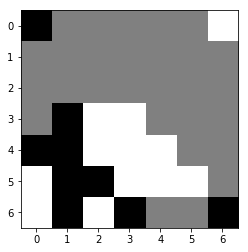

((6, 6), (4, 5)): n_v:  1980 q_all:+0.008966 q:+0.029771 q_m:+0.100000 p:0.560809
((6, 6), (6, 4)): n_v:   643 q_all:+0.000199 q:+0.033634 q_m:+0.100000 p:0.214330
((6, 3), (6, 4)): n_v:   354 q_all:-0.009369 q:+0.028844 q_m:+0.133333 p:0.137888
((6, 3), (4, 5)): n_v:   147 q_all:+0.008015 q:+0.015020 q_m:+0.100000 p:0.042198
((3, 1), (2, 2)): n_v:    61 q_all:+0.019388 q:+0.004463 q_m:+0.066667 p:0.013816
((6, 6), (5, 6)): n_v:     6 q_all:-0.016694 q:-0.010900 q_m:-0.000000 p:0.002932
((3, 1), (2, 1)): n_v:     6 q_all:-0.009882 q:-0.015215 q_m:-0.000000 p:0.002645
((3, 1), (3, 0)): n_v:     4 q_all:+0.009372 q:-0.016892 q_m:-0.066667 p:0.001355
((0, 0), (2, 2)): n_v:     4 q_all:-0.001054 q:-0.015103 q_m:+0.033333 p:0.001491
((0, 0), (2, 1)): n_v:     3 q_all:-0.034993 q:-0.030911 q_m:-0.033333 p:0.001686
((6, 6), (4, 6)): n_v:     3 q_all:-0.061071 q:-0.009774 q_m:-0.033333 p:0.002579
((6, 6), (6, 5)): n_v:     3 q_all:-0.066721 q:+0.002835 q_m:+0.066667 p:0.002519
((5, 2), (6, 4))

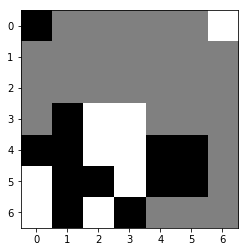

((3, 2), (3, 0)): n_v:  2273 q_all:+0.072416 q:-0.003586 q_m:+0.100000 p:0.018095
((5, 3), (6, 4)): n_v:  1269 q_all:-0.005390 q:+0.033194 q_m:+0.133333 p:0.448822
((3, 3), (3, 4)): n_v:   494 q_all:-0.017290 q:-0.019056 q_m:+0.066667 p:0.218579
((4, 3), (6, 4)): n_v:     9 q_all:-0.037482 q:+0.002138 q_m:+0.100000 p:0.005288
((6, 2), (6, 4)): n_v:     8 q_all:-0.002309 q:-0.055355 q_m:+0.100000 p:0.002872
((3, 3), (3, 5)): n_v:     5 q_all:-0.009341 q:-0.023925 q_m:+0.033333 p:0.002012
((4, 2), (6, 4)): n_v:     3 q_all:-0.018268 q:-0.031646 q_m:+0.100000 p:0.001373
((4, 2), (3, 0)): n_v:     2 q_all:-0.057909 q:-0.039138 q_m:+0.100000 p:0.002017
((4, 3), (6, 5)): n_v:     1 q_all:-0.064803 q:-0.062954 q_m:+0.033333 p:0.001077
((3, 2), (3, 4)): n_v:     1 q_all:-0.051786 q:-0.049356 q_m:+0.033333 p:0.000754
((3, 3), (1, 5)): n_v:     0 q_all:-0.043442 q:-0.043442 q_m:-0.100000 p:0.000133
((4, 3), (2, 1)): n_v:     0 q_all:-0.070331 q:-0.070331 q_m:-0.033333 p:0.000006
((3, 3), (2, 1))

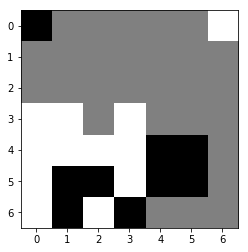

((4, 4), (3, 2)): n_v:  2439 q_all:-0.047404 q:-0.004325 q_m:+0.233333 p:0.354320
((5, 4), (3, 2)): n_v:  1047 q_all:-0.042996 q:+0.006473 q_m:+0.233333 p:0.129202
((4, 4), (3, 4)): n_v:   715 q_all:-0.072143 q:-0.047928 q_m:+0.066667 p:0.192002
((5, 5), (3, 4)): n_v:   116 q_all:-0.039031 q:-0.071019 q_m:+0.033333 p:0.012095
((5, 2), (3, 4)): n_v:    95 q_all:-0.184527 q:-0.152111 q_m:+0.033333 p:0.079065
((5, 1), (3, 2)): n_v:    18 q_all:-0.116265 q:-0.031559 q_m:+0.233333 p:0.008671
((0, 0), (2, 1)): n_v:    11 q_all:-0.053721 q:-0.034959 q_m:+0.033333 p:0.002108
((5, 4), (6, 4)): n_v:     7 q_all:-0.106953 q:-0.047101 q_m:-0.000000 p:0.002965
((4, 4), (2, 2)): n_v:     6 q_all:-0.065299 q:-0.055907 q_m:+0.033333 p:0.001382
((5, 4), (3, 4)): n_v:     2 q_all:-0.114307 q:-0.080971 q_m:+0.033333 p:0.001100
((5, 2), (3, 2)): n_v:     2 q_all:-0.164163 q:-0.110145 q_m:+0.233333 p:0.001806
((5, 5), (6, 6)): n_v:     1 q_all:-0.093972 q:-0.061754 q_m:-0.066667 p:0.000376
((0, 0), (1, 1))

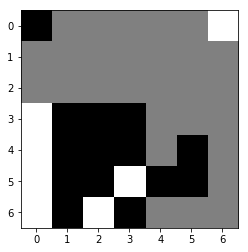

((5, 3), (4, 4)): n_v:  3857 q_all:+0.058345 q:+0.071762 q_m:+0.133333 p:0.836771
((6, 2), (4, 4)): n_v:   566 q_all:+0.069876 q:+0.035197 q_m:+0.100000 p:0.090890
((5, 3), (6, 4)): n_v:   129 q_all:+0.033277 q:+0.022208 q_m:-0.000000 p:0.043999
((0, 6), (2, 4)): n_v:    19 q_all:-0.040874 q:-0.078095 q_m:-0.166667 p:0.013771
((3, 0), (2, 2)): n_v:    11 q_all:-0.021905 q:-0.055462 q_m:-0.033333 p:0.006732
((6, 2), (6, 4)): n_v:     5 q_all:+0.000131 q:-0.053263 q_m:-0.033333 p:0.002558
((5, 3), (6, 5)): n_v:     1 q_all:-0.041225 q:-0.064718 q_m:-0.100000 p:0.001086
((3, 0), (2, 1)): n_v:     1 q_all:-0.020865 q:-0.056341 q_m:-0.066667 p:0.000975
((4, 0), (2, 2)): n_v:     1 q_all:-0.129897 q:-0.136336 q_m:-0.033333 p:0.001271
((5, 3), (3, 4)): n_v:     0 q_all:-0.027467 q:-0.027467 q_m:-0.033333 p:0.000155
((3, 0), (1, 1)): n_v:     0 q_all:-0.056744 q:-0.056744 q_m:-0.166667 p:0.000124
((0, 6), (0, 5)): n_v:     0 q_all:-0.081072 q:-0.081072 q_m:-0.200000 p:0.000032
((0, 6), (2, 5))

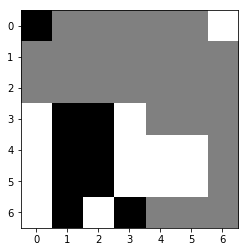

((6, 3), (6, 4)): n_v:  3465 q_all:-0.059533 q:-0.019662 q_m:+0.100000 p:0.738423
((3, 2), (3, 4)): n_v:  1367 q_all:-0.037309 q:-0.046752 q_m:+0.133333 p:0.161123
((6, 3), (6, 5)): n_v:    41 q_all:-0.067657 q:-0.034339 q_m:-0.000000 p:0.010371
((4, 2), (3, 4)): n_v:    38 q_all:-0.163864 q:-0.091284 q_m:+0.133333 p:0.025449
((5, 2), (3, 4)): n_v:    37 q_all:-0.199531 q:-0.137226 q_m:+0.133333 p:0.030443
((4, 2), (6, 4)): n_v:    25 q_all:-0.156629 q:-0.113930 q_m:+0.066667 p:0.015728
((3, 2), (2, 3)): n_v:     7 q_all:-0.075076 q:-0.089834 q_m:-0.033333 p:0.002178
((5, 2), (6, 4)): n_v:     6 q_all:-0.218169 q:-0.157770 q_m:+0.066667 p:0.005533
((3, 1), (2, 0)): n_v:     4 q_all:-0.078071 q:-0.092211 q_m:-0.033333 p:0.001423
((0, 0), (2, 1)): n_v:     3 q_all:-0.061688 q:-0.111431 q_m:-0.066667 p:0.000623
((3, 1), (2, 2)): n_v:     3 q_all:-0.072206 q:-0.104174 q_m:-0.033333 p:0.001020
((3, 1), (2, 1)): n_v:     3 q_all:-0.049204 q:-0.092225 q_m:-0.033333 p:0.000628
((3, 2), (2, 4))

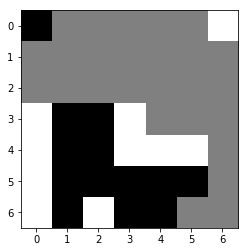

((4, 5), (6, 5)): n_v:  3952 q_all:+0.083271 q:+0.089826 q_m:+0.100000 p:0.679861
((4, 3), (6, 5)): n_v:   699 q_all:+0.056322 q:+0.038698 q_m:+0.100000 p:0.203965
((4, 4), (6, 5)): n_v:   152 q_all:+0.002625 q:+0.036561 q_m:+0.100000 p:0.080893
((4, 5), (5, 6)): n_v:    20 q_all:-0.023565 q:-0.024407 q_m:-0.000000 p:0.013530
((0, 6), (0, 5)): n_v:    19 q_all:-0.080259 q:-0.036726 q_m:-0.066667 p:0.017259
((4, 4), (5, 6)): n_v:     1 q_all:-0.038295 q:-0.047205 q_m:-0.033333 p:0.000891
((4, 4), (6, 6)): n_v:     0 q_all:-0.058779 q:-0.058779 q_m:-0.033333 p:0.000026
((4, 5), (6, 6)): n_v:     0 q_all:-0.020011 q:-0.020011 q_m:-0.033333 p:0.000499
((3, 3), (1, 5)): n_v:     0 q_all:-0.023469 q:-0.023469 q_m:-0.100000 p:0.000102
((4, 3), (2, 1)): n_v:     0 q_all:-0.035286 q:-0.035286 q_m:+0.033333 p:0.000046
((3, 3), (2, 1)): n_v:     0 q_all:-0.018027 q:-0.018027 q_m:+0.033333 p:0.000083
((4, 4), (2, 2)): n_v:     0 q_all:-0.053470 q:-0.053470 q_m:+0.033333 p:0.000039
((4, 4), (2, 3))

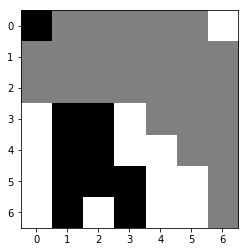

((6, 3), (4, 5)): n_v:  2739 q_all:-0.097395 q:-0.055601 q_m:+0.100000 p:0.522867
((3, 2), (3, 4)): n_v:  1172 q_all:-0.094108 q:-0.097041 q_m:+0.100000 p:0.207417
((3, 1), (2, 1)): n_v:   804 q_all:-0.071556 q:-0.105504 q_m:-0.000000 p:0.065300
((0, 0), (2, 1)): n_v:   121 q_all:-0.099230 q:-0.136229 q_m:-0.033333 p:0.024237
((3, 1), (2, 0)): n_v:   101 q_all:-0.085216 q:-0.105302 q_m:-0.000000 p:0.014042
((3, 2), (2, 3)): n_v:    56 q_all:-0.106647 q:-0.110569 q_m:-0.000000 p:0.013041
((4, 2), (3, 4)): n_v:    34 q_all:-0.201007 q:-0.155191 q_m:+0.100000 p:0.022034
((5, 3), (4, 5)): n_v:    24 q_all:-0.157433 q:-0.096625 q_m:+0.100000 p:0.010665
((3, 1), (2, 2)): n_v:    21 q_all:-0.098136 q:-0.123716 q_m:-0.000000 p:0.003952
((3, 1), (1, 0)): n_v:    18 q_all:-0.170088 q:-0.196938 q_m:-0.100000 p:0.009205
((3, 2), (1, 0)): n_v:    15 q_all:-0.170457 q:-0.176669 q_m:-0.100000 p:0.008010
((0, 0), (1, 1)): n_v:    14 q_all:-0.103002 q:-0.150230 q_m:-0.066667 p:0.002984
((5, 2), (3, 4))

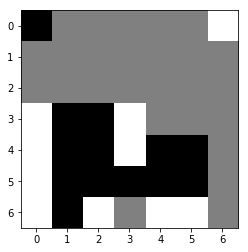

((6, 2), (6, 3)): n_v:  4165 q_all:+0.139749 q:+0.099962 q_m:+0.133333 p:0.457767
((6, 5), (5, 6)): n_v:     8 q_all:+0.059684 q:+0.075686 q_m:+0.066667 p:0.004372
((4, 3), (6, 3)): n_v:     8 q_all:+0.049113 q:+0.051167 q_m:+0.100000 p:0.004564
((3, 3), (3, 4)): n_v:     2 q_all:+0.017658 q:+0.045784 q_m:+0.066667 p:0.001555
((3, 3), (1, 5)): n_v:     0 q_all:+0.023554 q:+0.023554 q_m:-0.100000 p:0.000058
((4, 3), (2, 1)): n_v:     0 q_all:+0.008803 q:+0.008803 q_m:+0.033333 p:0.000011
((3, 3), (2, 1)): n_v:     0 q_all:+0.020364 q:+0.020364 q_m:+0.033333 p:0.000119
((6, 4), (4, 6)): n_v:     0 q_all:+0.064542 q:+0.064542 q_m:+0.033333 p:0.000348
((6, 5), (4, 6)): n_v:     0 q_all:+0.047964 q:+0.047964 q_m:+0.033333 p:0.000075
((3, 0), (1, 0)): n_v:     0 q_all:+0.024137 q:+0.024137 q_m:-0.033333 p:0.000023
((3, 0), (2, 1)): n_v:     0 q_all:+0.019371 q:+0.019371 q_m:+0.066667 p:0.000051
((3, 0), (2, 2)): n_v:     0 q_all:+0.006036 q:+0.006036 q_m:+0.033333 p:0.000004
((3, 0), (1, 2))

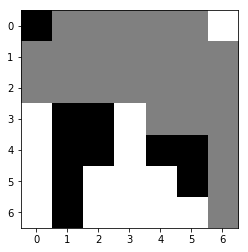

((4, 5), (5, 6)): n_v:  4101 q_all:-0.124243 q:-0.123451 q_m:-0.033333 p:0.318087
((4, 4), (3, 4)): n_v:   604 q_all:-0.161703 q:-0.122807 q_m:+0.033333 p:0.141524
((5, 5), (6, 6)): n_v:   358 q_all:-0.141948 q:-0.126424 q_m:-0.033333 p:0.049361
((4, 4), (5, 6)): n_v:   179 q_all:-0.143178 q:-0.127028 q_m:-0.066667 p:0.025821
((4, 5), (6, 6)): n_v:    36 q_all:-0.134745 q:-0.148998 q_m:-0.066667 p:0.003713
((3, 2), (3, 4)): n_v:    29 q_all:-0.204376 q:-0.175204 q_m:-0.000000 p:0.012005
((4, 5), (3, 6)): n_v:    20 q_all:-0.192918 q:-0.167070 q_m:-0.100000 p:0.007651
((4, 4), (6, 6)): n_v:    17 q_all:-0.142293 q:-0.135500 q_m:-0.066667 p:0.002332
((4, 5), (4, 6)): n_v:    11 q_all:-0.244565 q:-0.204298 q_m:-0.100000 p:0.006915
((3, 2), (2, 3)): n_v:    11 q_all:-0.201864 q:-0.167122 q_m:-0.033333 p:0.004479
((0, 0), (1, 0)): n_v:     7 q_all:-0.210307 q:-0.197200 q_m:-0.100000 p:0.003474
((5, 5), (3, 4)): n_v:     6 q_all:-0.151903 q:-0.121946 q_m:-0.000000 p:0.001301
((3, 1), (1, 0))

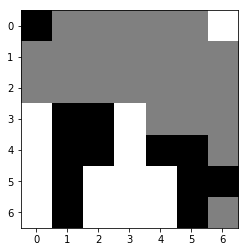

((3, 3), (3, 4)): n_v:  4947 q_all:+0.125503 q:+0.164636 q_m:+0.200000 p:0.437506
((6, 4), (4, 6)): n_v:   296 q_all:+0.107334 q:+0.125911 q_m:+0.233333 p:0.048905
((3, 0), (2, 1)): n_v:   100 q_all:+0.098638 q:+0.077641 q_m:+0.200000 p:0.020178
((3, 3), (1, 5)): n_v:    72 q_all:+0.138610 q:+0.078109 q_m:+0.033333 p:0.002302
((3, 0), (2, 0)): n_v:    64 q_all:+0.063463 q:+0.055724 q_m:+0.133333 p:0.022652
((3, 3), (3, 5)): n_v:    54 q_all:+0.103810 q:+0.134188 q_m:+0.166667 p:0.009716
((3, 3), (2, 5)): n_v:    46 q_all:+0.100637 q:+0.079337 q_m:+0.033333 p:0.008798
((3, 3), (2, 1)): n_v:    31 q_all:+0.082193 q:+0.066491 q_m:+0.166667 p:0.008470
((3, 3), (1, 1)): n_v:    24 q_all:+0.117928 q:+0.106652 q_m:+0.100000 p:0.002924
((3, 3), (2, 3)): n_v:    16 q_all:+0.090667 q:+0.080119 q_m:+0.133333 p:0.003779
((3, 3), (2, 4)): n_v:    13 q_all:+0.074900 q:+0.077645 q_m:+0.066667 p:0.004105
((3, 3), (2, 2)): n_v:    13 q_all:+0.093164 q:+0.100699 q_m:+0.200000 p:0.003062
((3, 0), (1, 0))

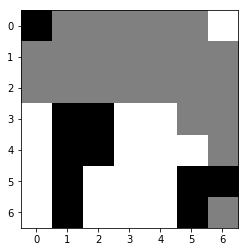

((5, 6), (3, 5)): n_v:  5257 q_all:-0.097562 q:-0.091730 q_m:-0.000000 p:0.592329
((3, 2), (2, 3)): n_v:   326 q_all:-0.151175 q:-0.163120 q_m:-0.033333 p:0.105775
((5, 5), (3, 5)): n_v:   230 q_all:-0.208703 q:-0.171496 q_m:-0.000000 p:0.126640
((5, 5), (4, 6)): n_v:    95 q_all:-0.188776 q:-0.162393 q_m:-0.100000 p:0.045204
((5, 5), (6, 6)): n_v:    22 q_all:-0.254216 q:-0.216750 q_m:-0.166667 p:0.015935
((5, 6), (3, 6)): n_v:     8 q_all:-0.161360 q:-0.134892 q_m:-0.133333 p:0.002885
((3, 2), (2, 4)): n_v:     7 q_all:-0.232062 q:-0.200879 q_m:-0.066667 p:0.004813
((3, 1), (2, 3)): n_v:     3 q_all:-0.200987 q:-0.192853 q_m:-0.066667 p:0.001946
((6, 5), (4, 6)): n_v:     2 q_all:-0.197873 q:-0.205940 q_m:-0.133333 p:0.001260
((3, 1), (2, 0)): n_v:     2 q_all:-0.181527 q:-0.194024 q_m:-0.100000 p:0.001142
((3, 1), (2, 1)): n_v:     2 q_all:-0.207344 q:-0.195992 q_m:-0.100000 p:0.001285
((5, 5), (3, 6)): n_v:     2 q_all:-0.228923 q:-0.207945 q_m:-0.133333 p:0.001346
((0, 0), (1, 0))

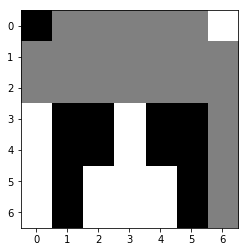

((3, 3), (2, 4)): n_v:  3000 q_all:+0.164955 q:+0.129189 q_m:+0.166667 p:0.162991
((3, 0), (2, 1)): n_v:   435 q_all:+0.086719 q:+0.101373 q_m:+0.166667 p:0.142771
((3, 3), (2, 2)): n_v:   407 q_all:+0.092113 q:+0.116998 q_m:+0.166667 p:0.123334
((0, 6), (2, 5)): n_v:   393 q_all:+0.104570 q:+0.101261 q_m:+0.133333 p:0.096692
((3, 3), (2, 5)): n_v:   352 q_all:+0.113900 q:+0.116984 q_m:+0.133333 p:0.071545
((0, 6), (1, 6)): n_v:   299 q_all:+0.082449 q:+0.071061 q_m:+0.033333 p:0.104056
((6, 4), (5, 6)): n_v:   281 q_all:+0.112266 q:+0.137355 q_m:+0.200000 p:0.059075
((3, 3), (2, 3)): n_v:   218 q_all:+0.104226 q:+0.110627 q_m:+0.166667 p:0.053986
((3, 3), (2, 1)): n_v:   174 q_all:+0.086525 q:+0.092569 q_m:+0.133333 p:0.057364
((0, 6), (2, 6)): n_v:    57 q_all:+0.087920 q:+0.094796 q_m:+0.066667 p:0.018549
((6, 4), (4, 6)): n_v:    55 q_all:+0.057723 q:+0.066935 q_m:+0.200000 p:0.025825
((3, 0), (2, 0)): n_v:    49 q_all:+0.062397 q:+0.076569 q_m:+0.100000 p:0.021536
((3, 3), (1, 1))

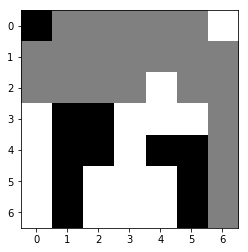

((3, 2), (2, 3)): n_v:  4250 q_all:-0.152954 q:-0.099149 q_m:+0.066667 p:0.854971
((3, 1), (2, 1)): n_v:   286 q_all:-0.122748 q:-0.136091 q_m:-0.066667 p:0.017568
((0, 0), (2, 1)): n_v:    96 q_all:-0.141758 q:-0.167928 q_m:-0.100000 p:0.014356
((4, 5), (3, 6)): n_v:    63 q_all:-0.128779 q:-0.120728 q_m:-0.066667 p:0.005673
((3, 1), (2, 3)): n_v:    58 q_all:-0.187211 q:-0.135990 q_m:+0.033333 p:0.020748
((4, 5), (2, 3)): n_v:    25 q_all:-0.163073 q:-0.161377 q_m:+0.033333 p:0.006103
((4, 5), (5, 6)): n_v:    14 q_all:-0.206682 q:-0.192842 q_m:-0.133333 p:0.006503
((4, 1), (2, 3)): n_v:    13 q_all:-0.212764 q:-0.123106 q_m:+0.033333 p:0.006182
((4, 4), (2, 3)): n_v:     7 q_all:-0.205177 q:-0.152162 q_m:+0.033333 p:0.003330
((0, 0), (1, 1)): n_v:     5 q_all:-0.184961 q:-0.168796 q_m:-0.133333 p:0.002011
((4, 5), (2, 5)): n_v:     4 q_all:-0.168926 q:-0.108711 q_m:+0.033333 p:0.001205
((4, 5), (4, 6)): n_v:     4 q_all:-0.223825 q:-0.147014 q_m:-0.066667 p:0.002600
((3, 1), (2, 0))

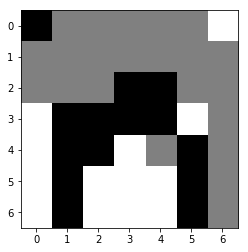

((3, 5), (4, 4)): n_v:  2199 q_all:+0.264868 q:+0.235345 q_m:+0.266667 p:0.318816
((3, 0), (2, 2)): n_v:     6 q_all:+0.025434 q:+0.069077 q_m:+0.233333 p:0.011625
((6, 3), (4, 4)): n_v:     1 q_all:+0.155283 q:+0.084977 q_m:+0.233333 p:0.001631
((6, 2), (4, 4)): n_v:     0 q_all:+0.065546 q:+0.065546 q_m:+0.233333 p:0.001285
((4, 3), (2, 5)): n_v:     0 q_all:+0.090484 q:+0.090484 q_m:+0.100000 p:0.000094
((4, 3), (2, 2)): n_v:     0 q_all:+0.087413 q:+0.087413 q_m:+0.233333 p:0.001069
((5, 4), (5, 6)): n_v:     0 q_all:+0.122195 q:+0.122195 q_m:+0.166667 p:0.000012
((3, 5), (4, 6)): n_v:     0 q_all:+0.088258 q:+0.088258 q_m:+0.133333 p:0.000173
((3, 5), (2, 5)): n_v:     0 q_all:+0.103555 q:+0.103555 q_m:+0.133333 p:0.000426
((4, 3), (2, 1)): n_v:     0 q_all:+0.069875 q:+0.069875 q_m:+0.100000 p:0.000048
((3, 5), (1, 6)): n_v:     0 q_all:+0.047575 q:+0.047575 q_m:-0.033333 p:0.000192
((3, 5), (3, 6)): n_v:     0 q_all:+0.082757 q:+0.082757 q_m:+0.066667 p:0.000011
((3, 0), (1, 1))

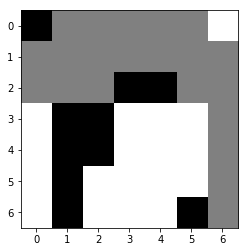

((2, 4), (3, 6)): n_v:  1374 q_all:-0.229123 q:-0.216274 q_m:-0.133333 p:0.207699
((6, 5), (5, 6)): n_v:   762 q_all:-0.247750 q:-0.179438 q_m:-0.100000 p:0.186666
((2, 4), (4, 6)): n_v:   742 q_all:-0.240443 q:-0.149247 q_m:-0.066667 p:0.154746
((6, 5), (4, 6)): n_v:   611 q_all:-0.215859 q:-0.185486 q_m:-0.066667 p:0.046437
((2, 4), (2, 5)): n_v:   358 q_all:-0.241621 q:-0.226939 q_m:-0.100000 p:0.076705
((3, 1), (2, 1)): n_v:   111 q_all:-0.293689 q:-0.302228 q_m:-0.166667 p:0.052923
((2, 4), (2, 6)): n_v:   100 q_all:-0.278452 q:-0.271299 q_m:-0.200000 p:0.040202
((2, 3), (2, 1)): n_v:    64 q_all:-0.261261 q:-0.304036 q_m:-0.200000 p:0.020216
((2, 4), (1, 6)): n_v:    56 q_all:-0.283299 q:-0.266118 q_m:-0.200000 p:0.024001
((3, 1), (2, 0)): n_v:    50 q_all:-0.271839 q:-0.294725 q_m:-0.166667 p:0.018164
((2, 3), (2, 5)): n_v:    37 q_all:-0.249540 q:-0.233152 q_m:-0.133333 p:0.009306
((0, 0), (2, 1)): n_v:    26 q_all:-0.368936 q:-0.349316 q_m:-0.200000 p:0.022426
((2, 4), (1, 5))

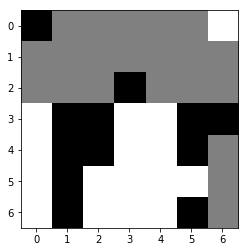

((5, 5), (5, 6)): n_v:  2635 q_all:+0.326527 q:+0.326207 q_m:+0.300000 p:0.237180
((5, 5), (4, 6)): n_v:   613 q_all:+0.196359 q:+0.308140 q_m:+0.366667 p:0.500560
((3, 3), (2, 2)): n_v:   115 q_all:+0.227657 q:+0.247883 q_m:+0.366667 p:0.074049
((3, 3), (2, 4)): n_v:    99 q_all:+0.236342 q:+0.248283 q_m:+0.300000 p:0.059074
((0, 6), (2, 6)): n_v:    23 q_all:+0.191604 q:+0.215558 q_m:+0.266667 p:0.019949
((3, 0), (2, 0)): n_v:    17 q_all:+0.180247 q:+0.184905 q_m:+0.233333 p:0.015700
((3, 4), (2, 5)): n_v:    17 q_all:+0.244807 q:+0.227242 q_m:+0.300000 p:0.009726
((3, 0), (2, 1)): n_v:    15 q_all:+0.215674 q:+0.190017 q_m:+0.300000 p:0.010865
((0, 6), (2, 5)): n_v:    10 q_all:+0.186548 q:+0.215449 q_m:+0.266667 p:0.008890
((0, 6), (1, 6)): n_v:     7 q_all:+0.204323 q:+0.180326 q_m:+0.166667 p:0.005636
((0, 6), (2, 4)): n_v:     6 q_all:+0.208317 q:+0.231148 q_m:+0.266667 p:0.005237
((6, 4), (4, 6)): n_v:     5 q_all:+0.156035 q:+0.195012 q_m:+0.333333 p:0.005687
((5, 5), (6, 6))

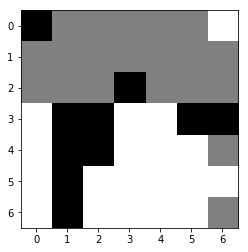

((3, 5), (4, 6)): n_v:  2703 q_all:-0.333808 q:-0.239868 q_m:-0.066667 p:0.462670
((3, 5), (1, 6)): n_v:  1793 q_all:-0.300569 q:-0.319748 q_m:-0.233333 p:0.021585
((3, 6), (1, 6)): n_v:    58 q_all:-0.337221 q:-0.329447 q_m:-0.233333 p:0.010807
((3, 5), (2, 6)): n_v:    43 q_all:-0.447999 q:-0.379212 q_m:-0.266667 p:0.031157
((3, 1), (2, 0)): n_v:    15 q_all:-0.409564 q:-0.366208 q_m:-0.200000 p:0.007662
((3, 1), (1, 0)): n_v:    11 q_all:-0.462703 q:-0.422061 q_m:-0.300000 p:0.009220
((2, 3), (2, 2)): n_v:    10 q_all:-0.384020 q:-0.378217 q_m:-0.200000 p:0.004295
((3, 6), (2, 4)): n_v:     9 q_all:-0.382301 q:-0.345817 q_m:-0.166667 p:0.003352
((3, 2), (1, 0)): n_v:     8 q_all:-0.479342 q:-0.401873 q_m:-0.300000 p:0.007499
((2, 3), (2, 4)): n_v:     7 q_all:-0.429803 q:-0.360497 q_m:-0.133333 p:0.004859
((3, 6), (1, 5)): n_v:     7 q_all:-0.351227 q:-0.333123 q_m:-0.233333 p:0.001340
((2, 3), (1, 2)): n_v:     7 q_all:-0.454953 q:-0.415549 q_m:-0.266667 p:0.005901
((2, 3), (1, 3))

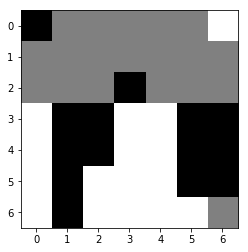

((6, 5), (6, 6)): n_v:  4386 q_all:+0.378208 q:+0.341676 q_m:+0.233333 p:0.908229
((3, 3), (2, 2)): n_v:    29 q_all:+0.198089 q:+0.210282 q_m:+0.300000 p:0.031758
((3, 3), (2, 4)): n_v:    27 q_all:+0.180954 q:+0.202473 q_m:+0.233333 p:0.031582
((4, 4), (6, 6)): n_v:     2 q_all:+0.160118 q:+0.160118 q_m:+0.200000 p:0.003507
((3, 0), (2, 1)): n_v:     2 q_all:+0.129992 q:+0.145445 q_m:+0.233333 p:0.002896
((3, 4), (2, 5)): n_v:     1 q_all:+0.205000 q:+0.205000 q_m:+0.233333 p:0.001712
((3, 3), (1, 5)): n_v:     0 q_all:+0.081993 q:+0.081993 q_m:+0.066667 p:0.000019
((4, 3), (2, 1)): n_v:     0 q_all:-0.007039 q:-0.007039 q_m:+0.200000 p:0.000003
((3, 3), (2, 1)): n_v:     0 q_all:+0.088632 q:+0.088632 q_m:+0.200000 p:0.000121
((4, 4), (2, 2)): n_v:     0 q_all:+0.135530 q:+0.135530 q_m:+0.266667 p:0.000021
((0, 6), (1, 6)): n_v:     0 q_all:+0.145957 q:+0.145957 q_m:+0.100000 p:0.000388
((3, 0), (1, 0)): n_v:     0 q_all:+0.155696 q:+0.155696 q_m:+0.133333 p:0.000023
((5, 4), (6, 6))

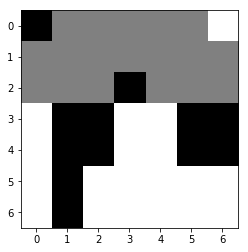

((2, 3), (0, 5)): n_v:   342 q_all:-0.358199 q:-0.384402 q_m:-0.166667 p:0.033325
((2, 3), (1, 5)): n_v:   266 q_all:-0.383296 q:-0.404184 q_m:-0.166667 p:0.059772
((2, 3), (2, 1)): n_v:   265 q_all:-0.370427 q:-0.439189 q_m:-0.166667 p:0.042455
((2, 3), (1, 1)): n_v:   246 q_all:-0.416640 q:-0.464211 q_m:-0.233333 p:0.096769
((2, 3), (0, 1)): n_v:   201 q_all:-0.390870 q:-0.458922 q_m:-0.233333 p:0.052964
((2, 3), (2, 2)): n_v:   185 q_all:-0.436383 q:-0.422761 q_m:-0.133333 p:0.091208
((2, 3), (2, 4)): n_v:   152 q_all:-0.449367 q:-0.417183 q_m:-0.066667 p:0.084793
((2, 3), (1, 2)): n_v:   103 q_all:-0.447122 q:-0.451421 q_m:-0.200000 p:0.056267
((2, 3), (0, 2)): n_v:    94 q_all:-0.401864 q:-0.460748 q_m:-0.233333 p:0.029977
((2, 3), (2, 5)): n_v:    84 q_all:-0.428300 q:-0.407881 q_m:-0.166667 p:0.038262
((2, 3), (0, 4)): n_v:    81 q_all:-0.398266 q:-0.439962 q_m:-0.233333 p:0.024473
((2, 3), (1, 4)): n_v:    68 q_all:-0.433276 q:-0.463565 q_m:-0.200000 p:0.032515
((2, 3), (1, 3))

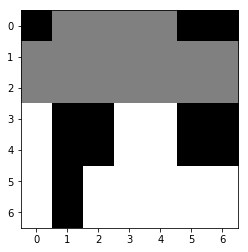

((3, 4), (2, 5)): n_v:  1668 q_all:+0.420177 q:+0.374926 q_m:+0.333333 p:0.359876
((3, 0), (2, 1)): n_v:   383 q_all:+0.349931 q:+0.343509 q_m:+0.333333 p:0.260264
((3, 3), (2, 2)): n_v:   143 q_all:+0.367921 q:+0.355415 q_m:+0.333333 p:0.080395
((3, 3), (2, 4)): n_v:    91 q_all:+0.384135 q:+0.379427 q_m:+0.266667 p:0.041458
((3, 0), (1, 1)): n_v:    65 q_all:+0.341476 q:+0.325490 q_m:+0.233333 p:0.048184
((3, 3), (2, 3)): n_v:    58 q_all:+0.375214 q:+0.342733 q_m:+0.266667 p:0.029865
((3, 0), (2, 0)): n_v:    21 q_all:+0.323198 q:+0.302251 q_m:+0.266667 p:0.018314
((3, 3), (2, 5)): n_v:    20 q_all:+0.301343 q:+0.334330 q_m:+0.300000 p:0.020581
((3, 3), (2, 1)): n_v:    16 q_all:+0.251274 q:+0.293007 q_m:+0.300000 p:0.022216
((3, 4), (1, 5)): n_v:    14 q_all:+0.287712 q:+0.295561 q_m:+0.300000 p:0.015678
((3, 3), (1, 1)): n_v:    13 q_all:+0.283756 q:+0.315360 q_m:+0.233333 p:0.015251
((3, 0), (1, 0)): n_v:    12 q_all:+0.311668 q:+0.327133 q_m:+0.233333 p:0.011670
((3, 3), (1, 5))

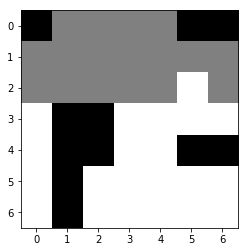

((0, 6), (2, 6)): n_v:  1727 q_all:-0.398439 q:-0.414266 q_m:-0.133333 p:0.440361
((0, 5), (2, 6)): n_v:  1169 q_all:-0.360080 q:-0.389880 q_m:-0.133333 p:0.057769
((0, 0), (2, 0)): n_v:   507 q_all:-0.480191 q:-0.519298 q_m:-0.266667 p:0.351902
((0, 5), (2, 4)): n_v:   131 q_all:-0.404029 q:-0.396430 q_m:-0.066667 p:0.036927
((0, 6), (2, 4)): n_v:    82 q_all:-0.397928 q:-0.404784 q_m:-0.066667 p:0.020627
((3, 2), (2, 4)): n_v:    25 q_all:-0.530045 q:-0.428662 q_m:-0.066667 p:0.023974
((4, 6), (2, 4)): n_v:    24 q_all:-0.435417 q:-0.395213 q_m:-0.066667 p:0.011040
((0, 0), (2, 1)): n_v:    15 q_all:-0.458074 q:-0.501895 q_m:-0.266667 p:0.009134
((0, 0), (2, 2)): n_v:    15 q_all:-0.492806 q:-0.508504 q_m:-0.266667 p:0.011626
((3, 1), (2, 2)): n_v:    11 q_all:-0.457114 q:-0.477511 q_m:-0.233333 p:0.006764
((3, 1), (2, 0)): n_v:     8 q_all:-0.447271 q:-0.478172 q_m:-0.233333 p:0.004357
((3, 2), (2, 3)): n_v:     4 q_all:-0.499321 q:-0.459071 q_m:-0.166667 p:0.003833
((3, 2), (2, 0))

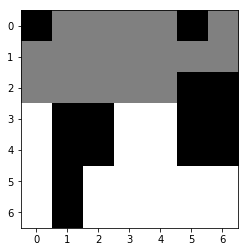

((3, 3), (2, 4)): n_v:  2632 q_all:+0.442023 q:+0.444986 q_m:+0.300000 p:0.220511
((3, 3), (2, 2)): n_v:   528 q_all:+0.373857 q:+0.414866 q_m:+0.300000 p:0.235826
((3, 0), (1, 1)): n_v:   324 q_all:+0.396316 q:+0.363394 q_m:+0.200000 p:0.105334
((3, 0), (2, 1)): n_v:   114 q_all:+0.372608 q:+0.391260 q_m:+0.300000 p:0.052044
((3, 4), (1, 5)): n_v:    95 q_all:+0.339492 q:+0.309120 q_m:+0.333333 p:0.060215
((3, 3), (1, 5)): n_v:    71 q_all:+0.368870 q:+0.342693 q_m:+0.333333 p:0.034016
((3, 3), (1, 1)): n_v:    46 q_all:+0.318631 q:+0.344153 q_m:+0.200000 p:0.034619
((3, 3), (2, 3)): n_v:    42 q_all:+0.372659 q:+0.370543 q_m:+0.233333 p:0.019249
((3, 0), (2, 0)): n_v:    36 q_all:+0.345459 q:+0.346517 q_m:+0.233333 p:0.021621
((3, 4), (1, 6)): n_v:    19 q_all:+0.334270 q:+0.326606 q_m:+0.333333 p:0.012435
((3, 0), (1, 0)): n_v:    10 q_all:+0.383594 q:+0.360272 q_m:+0.200000 p:0.004316
((3, 3), (2, 1)): n_v:     5 q_all:+0.288050 q:+0.313019 q_m:+0.266667 p:0.004929
((3, 4), (2, 2))

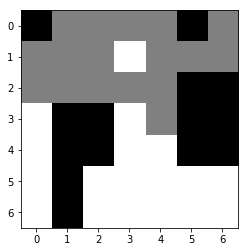

((2, 5), (3, 4)): n_v:  1809 q_all:-0.208631 q:-0.182644 q_m:+0.100000 p:0.342136
((2, 6), (3, 4)): n_v:   185 q_all:-0.203509 q:-0.191122 q_m:+0.066667 p:0.027796
((3, 6), (3, 4)): n_v:   124 q_all:-0.225753 q:-0.260150 q_m:+0.066667 p:0.038243
((3, 2), (3, 4)): n_v:    57 q_all:-0.246134 q:-0.244954 q_m:+0.066667 p:0.025664
((4, 6), (3, 4)): n_v:    18 q_all:-0.462618 q:-0.239534 q_m:+0.066667 p:0.036893
((4, 2), (3, 4)): n_v:     5 q_all:-0.368129 q:-0.306702 q_m:+0.066667 p:0.007404
((3, 2), (2, 3)): n_v:     2 q_all:-0.315059 q:-0.280724 q_m:+0.033333 p:0.001722
((0, 5), (2, 3)): n_v:     0 q_all:-0.296111 q:-0.296111 q_m:-0.000000 p:0.000169
((4, 6), (2, 4)): n_v:     0 q_all:-0.338444 q:-0.338444 q_m:-0.000000 p:0.000067
((3, 6), (1, 4)): n_v:     0 q_all:-0.342391 q:-0.342391 q_m:-0.066667 p:0.000040
((3, 1), (1, 2)): n_v:     0 q_all:-0.345491 q:-0.345491 q_m:-0.066667 p:0.000028
((3, 2), (1, 2)): n_v:     0 q_all:-0.316414 q:-0.316414 q_m:-0.066667 p:0.000008
((4, 2), (2, 1))

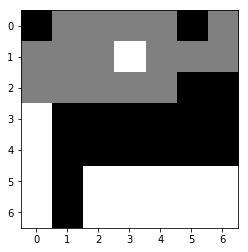

((1, 3), (2, 4)): n_v:  1706 q_all:+0.274858 q:+0.289256 q_m:+0.200000 p:0.211249
((1, 3), (1, 1)): n_v:  1019 q_all:+0.273445 q:+0.229360 q_m:-0.033333 p:0.118282
((1, 3), (2, 2)): n_v:   448 q_all:+0.190891 q:+0.274024 q_m:+0.133333 p:0.253792
((1, 3), (1, 5)): n_v:   201 q_all:+0.188534 q:+0.234287 q_m:+0.100000 p:0.116547
((1, 3), (2, 3)): n_v:   112 q_all:+0.239482 q:+0.273536 q_m:+0.133333 p:0.034838
((3, 0), (1, 1)): n_v:   107 q_all:+0.180291 q:+0.217511 q_m:-0.033333 p:0.067085
((1, 3), (2, 1)): n_v:    87 q_all:+0.201465 q:+0.220470 q_m:+0.033333 p:0.044785
((1, 3), (1, 4)): n_v:    86 q_all:+0.228027 q:+0.236976 q_m:+0.066667 p:0.032139
((3, 0), (2, 1)): n_v:    75 q_all:+0.251496 q:+0.244360 q_m:+0.066667 p:0.018334
((1, 3), (1, 2)): n_v:    48 q_all:+0.191009 q:+0.201547 q_m:-0.066667 p:0.027660
((1, 3), (0, 1)): n_v:    27 q_all:+0.233201 q:+0.213759 q_m:-0.033333 p:0.009518
((1, 3), (0, 2)): n_v:    25 q_all:+0.197971 q:+0.206973 q_m:-0.066667 p:0.013604
((3, 0), (2, 2))

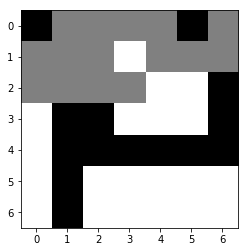

((3, 2), (2, 3)): n_v:  2413 q_all:-0.284409 q:-0.248700 q_m:+0.100000 p:0.678252
((0, 5), (2, 3)): n_v:  1354 q_all:-0.262780 q:-0.240315 q_m:+0.066667 p:0.224352
((0, 5), (1, 4)): n_v:    56 q_all:-0.339663 q:-0.304517 q_m:+0.033333 p:0.032472
((3, 1), (2, 3)): n_v:    13 q_all:-0.340766 q:-0.295560 q_m:+0.066667 p:0.008016
((3, 1), (2, 2)): n_v:    12 q_all:-0.322897 q:-0.306411 q_m:-0.033333 p:0.005923
((0, 5), (0, 3)): n_v:     9 q_all:-0.294046 q:-0.276955 q_m:-0.133333 p:0.003141
((0, 5), (0, 4)): n_v:     8 q_all:-0.333608 q:-0.318728 q_m:-0.100000 p:0.004732
((0, 0), (2, 2)): n_v:     5 q_all:-0.366985 q:-0.355531 q_m:-0.066667 p:0.003790
((4, 1), (2, 3)): n_v:     4 q_all:-0.347828 q:-0.270921 q_m:+0.066667 p:0.003091
((3, 1), (2, 1)): n_v:     4 q_all:-0.327601 q:-0.294239 q_m:-0.100000 p:0.001870
((4, 5), (2, 3)): n_v:     3 q_all:-0.412622 q:-0.307770 q_m:+0.066667 p:0.003445
((2, 6), (1, 4)): n_v:     3 q_all:-0.310535 q:-0.324490 q_m:-0.000000 p:0.001203
((0, 5), (0, 6))

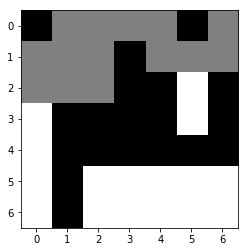

((2, 5), (1, 4)): n_v:  1878 q_all:+0.287791 q:+0.303418 q_m:+0.200000 p:0.753227
((3, 5), (1, 4)): n_v:  1486 q_all:+0.368279 q:+0.229751 q_m:+0.166667 p:0.008744
((2, 5), (1, 5)): n_v:   256 q_all:+0.319526 q:+0.297523 q_m:+0.133333 p:0.063018
((3, 0), (2, 2)): n_v:   208 q_all:+0.299848 q:+0.302080 q_m:+0.233333 p:0.071368
((3, 0), (1, 2)): n_v:    44 q_all:+0.237689 q:+0.263184 q_m:+0.033333 p:0.028896
((3, 0), (2, 1)): n_v:    41 q_all:+0.286532 q:+0.275017 q_m:+0.066667 p:0.016978
((2, 5), (1, 6)): n_v:    25 q_all:+0.175007 q:+0.200429 q_m:+0.066667 p:0.024460
((4, 0), (2, 2)): n_v:    19 q_all:+0.225826 q:+0.199122 q_m:+0.233333 p:0.013668
((2, 5), (0, 4)): n_v:    13 q_all:+0.307010 q:+0.248231 q_m:+0.033333 p:0.004202
((3, 0), (1, 1)): n_v:    11 q_all:+0.234300 q:+0.250256 q_m:-0.033333 p:0.007280
((3, 5), (1, 5)): n_v:     3 q_all:+0.259463 q:+0.188854 q_m:+0.100000 p:0.001802
((2, 5), (0, 3)): n_v:     1 q_all:+0.208405 q:+0.228478 q_m:-0.033333 p:0.001315
((3, 0), (2, 0))

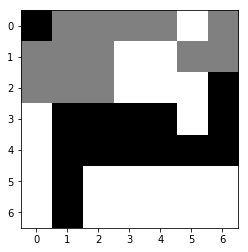

((2, 6), (1, 5)): n_v:  3451 q_all:-0.268368 q:-0.297404 q_m:+0.100000 p:0.822724
((0, 0), (1, 1)): n_v:    56 q_all:-0.384590 q:-0.384269 q_m:-0.166667 p:0.047725
((3, 1), (2, 2)): n_v:    38 q_all:-0.303910 q:-0.274215 q_m:-0.033333 p:0.015974
((3, 6), (1, 5)): n_v:    17 q_all:-0.382215 q:-0.356236 q_m:+0.066667 p:0.014462
((2, 6), (0, 4)): n_v:    15 q_all:-0.382102 q:-0.398817 q_m:-0.000000 p:0.012788
((3, 3), (1, 5)): n_v:     8 q_all:-0.389297 q:-0.333297 q_m:+0.066667 p:0.006424
((0, 0), (2, 2)): n_v:     7 q_all:-0.339697 q:-0.313599 q_m:-0.066667 p:0.004654
((3, 1), (1, 1)): n_v:     6 q_all:-0.401231 q:-0.383344 q_m:-0.200000 p:0.005987
((2, 6), (1, 6)): n_v:     4 q_all:-0.485688 q:-0.446010 q_m:-0.033333 p:0.006019
((4, 1), (2, 2)): n_v:     3 q_all:-0.319558 q:-0.323253 q_m:-0.066667 p:0.000787
((3, 3), (1, 1)): n_v:     3 q_all:-0.435239 q:-0.399539 q_m:-0.200000 p:0.003725
((0, 0), (0, 2)): n_v:     2 q_all:-0.370356 q:-0.370499 q_m:-0.133333 p:0.001841
((3, 4), (1, 5))

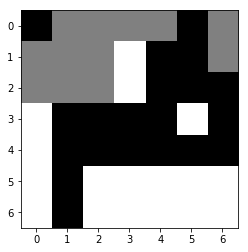

((1, 3), (0, 4)): n_v:  2622 q_all:+0.328406 q:+0.271703 q_m:+0.133333 p:0.220878
((3, 5), (1, 6)): n_v:   897 q_all:+0.300251 q:+0.283892 q_m:+0.166667 p:0.127813
((2, 3), (0, 4)): n_v:   470 q_all:+0.266780 q:+0.228590 q_m:+0.100000 p:0.156414
((1, 3), (0, 2)): n_v:   296 q_all:+0.181501 q:+0.185501 q_m:-0.066667 p:0.218170
((2, 3), (0, 2)): n_v:   199 q_all:+0.196672 q:+0.160488 q_m:-0.100000 p:0.133438
((3, 0), (1, 0)): n_v:    53 q_all:+0.210874 q:+0.210529 q_m:-0.033333 p:0.032241
((2, 3), (1, 1)): n_v:    51 q_all:+0.290273 q:+0.214263 q_m:-0.033333 p:0.010217
((1, 3), (0, 1)): n_v:    44 q_all:+0.279273 q:+0.218420 q_m:-0.033333 p:0.011773
((2, 3), (0, 1)): n_v:    36 q_all:+0.297549 q:+0.197604 q_m:-0.033333 p:0.005611
((1, 3), (2, 2)): n_v:    21 q_all:+0.210163 q:+0.268636 q_m:+0.133333 p:0.012825
((2, 3), (2, 1)): n_v:    18 q_all:+0.241223 q:+0.215960 q_m:+0.033333 p:0.008828
((3, 0), (2, 1)): n_v:    13 q_all:+0.129642 q:+0.227230 q_m:+0.066667 p:0.013413
((3, 0), (1, 2))

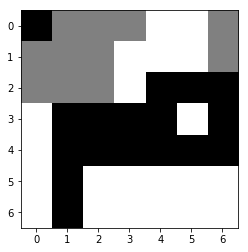

((2, 5), (1, 6)): n_v:  3660 q_all:-0.346183 q:-0.235870 q_m:+0.033333 p:0.544951
((2, 4), (0, 3)): n_v:   838 q_all:-0.316063 q:-0.373617 q_m:+0.066667 p:0.004410
((2, 4), (1, 6)): n_v:    89 q_all:-0.344577 q:-0.355184 q_m:-0.000000 p:0.012191
((0, 0), (1, 0)): n_v:    66 q_all:-0.464343 q:-0.435926 q_m:-0.100000 p:0.047890
((3, 1), (2, 2)): n_v:    28 q_all:-0.354287 q:-0.300285 q_m:+0.033333 p:0.005414
((2, 6), (0, 6)): n_v:    14 q_all:-0.387840 q:-0.335757 q_m:-0.000000 p:0.004792
((2, 5), (0, 3)): n_v:     8 q_all:-0.404132 q:-0.389246 q_m:+0.066667 p:0.003605
((0, 0), (2, 2)): n_v:     2 q_all:-0.366985 q:-0.342868 q_m:-0.000000 p:0.000514
((3, 2), (1, 0)): n_v:     1 q_all:-0.473876 q:-0.464569 q_m:-0.133333 p:0.001031
((3, 4), (1, 6)): n_v:     1 q_all:-0.493214 q:-0.397742 q_m:-0.000000 p:0.001264
((3, 6), (1, 6)): n_v:     1 q_all:-0.492026 q:-0.393689 q_m:-0.000000 p:0.001241
((4, 1), (2, 2)): n_v:     1 q_all:-0.433253 q:-0.359782 q_m:-0.000000 p:0.000236
((2, 4), (0, 6))

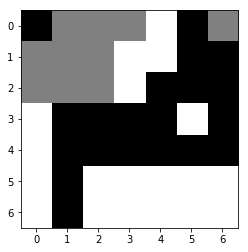

((0, 4), (0, 6)): n_v:  5201 q_all:+0.404721 q:+0.359547 q_m:+0.166667 p:0.628287
((1, 3), (2, 2)): n_v:    83 q_all:+0.225599 q:+0.244326 q_m:+0.200000 p:0.075642
((3, 0), (2, 2)): n_v:    57 q_all:+0.175787 q:+0.183360 q_m:+0.166667 p:0.063672
((1, 4), (0, 6)): n_v:    45 q_all:+0.217673 q:+0.242039 q_m:+0.166667 p:0.042345
((3, 0), (1, 1)): n_v:    21 q_all:+0.182744 q:+0.166017 q_m:+0.033333 p:0.023297
((3, 0), (2, 1)): n_v:    15 q_all:+0.165359 q:+0.183780 q_m:+0.133333 p:0.017950
((2, 3), (1, 1)): n_v:    13 q_all:+0.213723 q:+0.190702 q_m:+0.033333 p:0.012912
((2, 3), (2, 1)): n_v:    10 q_all:+0.195993 q:+0.184426 q_m:+0.100000 p:0.010640
((3, 0), (1, 0)): n_v:     9 q_all:+0.205741 q:+0.169957 q_m:+0.033333 p:0.009311
((3, 0), (2, 0)): n_v:     7 q_all:+0.166056 q:+0.158154 q_m:+0.066667 p:0.008411
((2, 3), (0, 1)): n_v:     3 q_all:+0.205489 q:+0.189091 q_m:+0.033333 p:0.003836
((0, 4), (2, 2)): n_v:     3 q_all:+0.221222 q:+0.232692 q_m:+0.166667 p:0.002907
((4, 0), (2, 2))

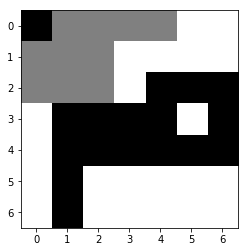

((3, 1), (2, 2)): n_v:  3581 q_all:-0.376107 q:-0.318864 q_m:-0.000000 p:0.092976
((2, 6), (0, 4)): n_v:  1223 q_all:-0.466757 q:-0.427507 q_m:+0.100000 p:0.461002
((0, 0), (0, 2)): n_v:   395 q_all:-0.440101 q:-0.440582 q_m:-0.100000 p:0.108384
((2, 4), (0, 4)): n_v:   143 q_all:-0.420825 q:-0.410284 q_m:+0.100000 p:0.027533
((2, 5), (0, 4)): n_v:    63 q_all:-0.577955 q:-0.535809 q_m:+0.100000 p:0.050359
((0, 0), (2, 2)): n_v:    53 q_all:-0.416902 q:-0.366615 q_m:-0.033333 p:0.009364
((2, 4), (0, 2)): n_v:    40 q_all:-0.465601 q:-0.456568 q_m:-0.100000 p:0.015197
((4, 1), (2, 2)): n_v:    31 q_all:-0.419097 q:-0.390360 q_m:-0.033333 p:0.005608
((3, 1), (2, 0)): n_v:    16 q_all:-0.437141 q:-0.451794 q_m:-0.066667 p:0.004272
((0, 0), (1, 0)): n_v:     7 q_all:-0.459932 q:-0.480836 q_m:-0.133333 p:0.002732
((2, 4), (0, 3)): n_v:     6 q_all:-0.410877 q:-0.474523 q_m:-0.033333 p:0.000905
((3, 1), (2, 1)): n_v:     5 q_all:-0.466882 q:-0.452910 q_m:-0.066667 p:0.002223
((3, 1), (1, 2))

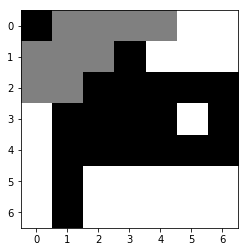

((3, 0), (1, 2)): n_v:  3350 q_all:+0.451635 q:+0.415640 q_m:+0.200000 p:0.150681
((3, 0), (2, 1)): n_v:  1857 q_all:+0.369326 q:+0.428980 q_m:+0.233333 p:0.725725
((1, 4), (1, 2)): n_v:    48 q_all:+0.319607 q:+0.329243 q_m:+0.200000 p:0.030507
((4, 0), (2, 1)): n_v:    30 q_all:+0.272880 q:+0.256282 q_m:+0.200000 p:0.025063
((0, 5), (0, 4)): n_v:    28 q_all:+0.352164 q:+0.366628 q_m:+0.100000 p:0.013562
((3, 0), (1, 1)): n_v:     4 q_all:+0.287962 q:+0.335982 q_m:+0.133333 p:0.003568
((3, 0), (1, 0)): n_v:     4 q_all:+0.270679 q:+0.290311 q_m:+0.066667 p:0.003183
((3, 0), (2, 0)): n_v:     3 q_all:+0.189045 q:+0.252136 q_m:+0.100000 p:0.004435
((1, 4), (0, 3)): n_v:     2 q_all:+0.173416 q:+0.296923 q_m:+0.100000 p:0.002500
((0, 5), (0, 3)): n_v:     1 q_all:+0.277445 q:+0.204046 q_m:+0.066667 p:0.001186
((0, 6), (0, 4)): n_v:     1 q_all:+0.162181 q:+0.213831 q_m:+0.066667 p:0.002385
((1, 6), (0, 4)): n_v:     0 q_all:+0.131275 q:+0.131275 q_m:+0.066667 p:0.000898
((4, 0), (2, 0))

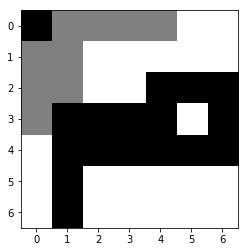

((3, 1), (2, 1)): n_v:  2454 q_all:-0.378803 q:-0.405926 q_m:-0.033333 p:0.027978
((0, 0), (0, 2)): n_v:  1140 q_all:-0.453891 q:-0.454052 q_m:-0.066667 p:0.270698
((3, 1), (3, 0)): n_v:  1062 q_all:-0.439478 q:-0.378168 q_m:-0.100000 p:0.166876
((2, 6), (0, 4)): n_v:   366 q_all:-0.486579 q:-0.455520 q_m:+0.066667 p:0.152231
((3, 1), (1, 1)): n_v:   125 q_all:-0.438254 q:-0.396493 q_m:-0.066667 p:0.018747
((0, 0), (1, 1)): n_v:    56 q_all:-0.446379 q:-0.393908 q_m:-0.033333 p:0.011143
((4, 2), (3, 0)): n_v:    35 q_all:-0.562913 q:-0.533657 q_m:-0.133333 p:0.028402
((2, 4), (0, 3)): n_v:    29 q_all:-0.447325 q:-0.464123 q_m:-0.000000 p:0.005980
((5, 1), (3, 0)): n_v:    25 q_all:-0.537076 q:-0.459814 q_m:-0.133333 p:0.016129
((2, 4), (0, 2)): n_v:    24 q_all:-0.515344 q:-0.479999 q_m:-0.066667 p:0.014169
((0, 0), (2, 1)): n_v:    17 q_all:-0.452306 q:-0.441220 q_m:-0.066667 p:0.003920
((2, 4), (0, 4)): n_v:    14 q_all:-0.517780 q:-0.477633 q_m:+0.066667 p:0.008337
((0, 0), (1, 0))

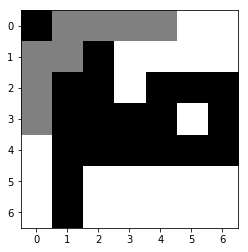

((4, 0), (3, 0)): n_v:  3628 q_all:+0.387486 q:+0.443251 q_m:+0.266667 p:0.612442
((1, 3), (1, 1)): n_v:   445 q_all:+0.341594 q:+0.424935 q_m:+0.300000 p:0.175139
((2, 3), (1, 1)): n_v:   410 q_all:+0.351985 q:+0.383640 q_m:+0.300000 p:0.138823
((1, 3), (0, 2)): n_v:    61 q_all:+0.393152 q:+0.366886 q_m:+0.133333 p:0.008610
((4, 0), (2, 0)): n_v:    29 q_all:+0.349089 q:+0.307859 q_m:+0.166667 p:0.010554
((5, 0), (3, 0)): n_v:    11 q_all:+0.202275 q:+0.207324 q_m:+0.233333 p:0.012596
((0, 5), (0, 4)): n_v:    10 q_all:+0.274371 q:+0.281086 q_m:+0.066667 p:0.007469
((1, 3), (0, 1)): n_v:     7 q_all:+0.363072 q:+0.315123 q_m:+0.166667 p:0.002104
((2, 3), (0, 4)): n_v:     3 q_all:+0.295867 q:+0.282646 q_m:+0.033333 p:0.001622
((5, 2), (3, 0)): n_v:     2 q_all:+0.040900 q:+0.204382 q_m:+0.233333 p:0.003736
((2, 3), (0, 2)): n_v:     2 q_all:+0.274852 q:+0.277027 q_m:+0.100000 p:0.001886
((2, 3), (0, 1)): n_v:     1 q_all:+0.285368 q:+0.269379 q_m:+0.166667 p:0.001153
((1, 3), (0, 3))

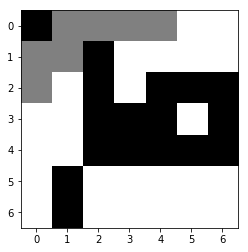

((1, 2), (0, 4)): n_v:  3748 q_all:-0.345257 q:-0.307465 q_m:-0.000000 p:0.025240
((1, 2), (2, 0)): n_v:  1051 q_all:-0.461843 q:-0.424685 q_m:-0.066667 p:0.541724
((0, 0), (2, 0)): n_v:   728 q_all:-0.445388 q:-0.438632 q_m:-0.066667 p:0.323439
((2, 2), (0, 4)): n_v:    41 q_all:-0.404924 q:-0.395337 q_m:-0.000000 p:0.011207
((4, 2), (2, 0)): n_v:    17 q_all:-0.592475 q:-0.556811 q_m:-0.066667 p:0.019065
((0, 0), (1, 1)): n_v:    15 q_all:-0.506228 q:-0.519526 q_m:-0.166667 p:0.010749
((1, 2), (0, 2)): n_v:     8 q_all:-0.574776 q:-0.532617 q_m:-0.166667 p:0.007950
((2, 2), (2, 0)): n_v:     7 q_all:-0.532681 q:-0.519798 q_m:-0.066667 p:0.006494
((0, 0), (0, 2)): n_v:     6 q_all:-0.639033 q:-0.646456 q_m:-0.200000 p:0.007587
((3, 2), (2, 0)): n_v:     6 q_all:-0.554527 q:-0.520409 q_m:-0.066667 p:0.005335
((2, 4), (0, 2)): n_v:     3 q_all:-0.591687 q:-0.583141 q_m:-0.200000 p:0.003898
((2, 6), (0, 4)): n_v:     2 q_all:-0.495579 q:-0.516545 q_m:-0.000000 p:0.001987
((2, 5), (0, 4))

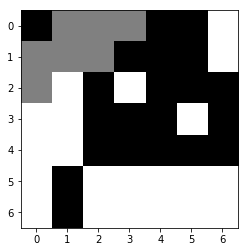

((2, 3), (0, 3)): n_v:  2797 q_all:+0.435898 q:+0.348755 q_m:+0.200000 p:0.343224
((2, 3), (1, 1)): n_v:  1513 q_all:+0.387500 q:+0.368153 q_m:+0.133333 p:0.209522
((2, 1), (0, 3)): n_v:   670 q_all:+0.330183 q:+0.336421 q_m:+0.200000 p:0.293189
((2, 3), (0, 1)): n_v:   185 q_all:+0.361976 q:+0.365286 q_m:+0.066667 p:0.049736
((2, 3), (0, 2)): n_v:    61 q_all:+0.339608 q:+0.322923 q_m:+0.066667 p:0.023558
((2, 1), (1, 2)): n_v:    24 q_all:+0.288102 q:+0.310062 q_m:+0.166667 p:0.015804
((2, 1), (1, 1)): n_v:    20 q_all:+0.226004 q:+0.277222 q_m:+0.166667 p:0.019246
((3, 0), (1, 1)): n_v:     4 q_all:+0.160220 q:+0.198526 q_m:+0.133333 p:0.005649
((2, 1), (0, 1)): n_v:     4 q_all:+0.263443 q:+0.257843 q_m:+0.066667 p:0.003567
((2, 1), (0, 2)): n_v:     1 q_all:+0.185274 q:+0.185274 q_m:+0.066667 p:0.002123
((3, 1), (1, 2)): n_v:     1 q_all:+0.098210 q:+0.098210 q_m:+0.133333 p:0.002665
((3, 0), (1, 2)): n_v:     1 q_all:+0.179274 q:+0.216973 q_m:+0.133333 p:0.001403
((3, 1), (1, 1))

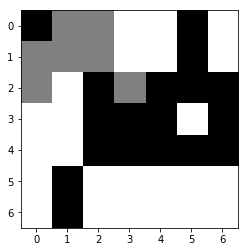

((2, 2), (2, 3)): n_v:  3561 q_all:-0.398151 q:-0.301962 q_m:-0.033333 p:0.129880
((2, 2), (2, 0)): n_v:   330 q_all:-0.443146 q:-0.418548 q_m:-0.000000 p:0.032958
((0, 0), (2, 0)): n_v:   222 q_all:-0.472664 q:-0.417972 q_m:-0.000000 p:0.063680
((4, 2), (2, 0)): n_v:   111 q_all:-0.458985 q:-0.496986 q_m:-0.000000 p:0.022220
((4, 2), (2, 3)): n_v:   104 q_all:-0.499733 q:-0.372771 q_m:-0.066667 p:0.047914
((4, 4), (2, 3)): n_v:    49 q_all:-0.499814 q:-0.346802 q_m:-0.066667 p:0.022142
((3, 3), (1, 2)): n_v:    41 q_all:-0.493461 q:-0.496374 q_m:-0.000000 p:0.016079
((0, 5), (2, 3)): n_v:    33 q_all:-0.477147 q:-0.394353 q_m:-0.066667 p:0.010486
((2, 4), (1, 2)): n_v:    18 q_all:-0.516478 q:-0.524684 q_m:-0.000000 p:0.010580
((4, 3), (2, 3)): n_v:    11 q_all:-0.534541 q:-0.383436 q_m:-0.066667 p:0.007275
((4, 5), (2, 3)): n_v:     6 q_all:-0.630307 q:-0.480574 q_m:-0.066667 p:0.006581
((3, 4), (1, 2)): n_v:     4 q_all:-0.658705 q:-0.649528 q_m:-0.000000 p:0.006221
((1, 5), (2, 3))

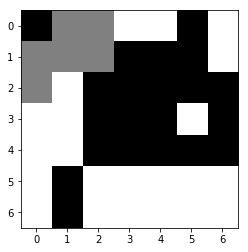

((0, 3), (1, 2)): n_v:  3388 q_all:+0.405777 q:+0.496205 q_m:+0.266667 p:0.406841
((2, 1), (1, 0)): n_v:   786 q_all:+0.439584 q:+0.308147 q_m:+0.133333 p:0.002859
((0, 3), (0, 1)): n_v:   669 q_all:+0.427994 q:+0.324914 q_m:+0.100000 p:0.008562
((2, 1), (2, 0)): n_v:   235 q_all:+0.468361 q:+0.252465 q_m:+0.066667 p:0.001537
((0, 4), (1, 2)): n_v:   213 q_all:+0.372971 q:+0.427924 q_m:+0.233333 p:0.058874
((2, 1), (1, 1)): n_v:    47 q_all:+0.288282 q:+0.375565 q_m:+0.200000 p:0.032322
((3, 0), (1, 2)): n_v:    46 q_all:+0.269107 q:+0.343775 q_m:+0.233333 p:0.035429
((0, 3), (1, 1)): n_v:    46 q_all:+0.291465 q:+0.348134 q_m:+0.166667 p:0.030224
((3, 1), (1, 2)): n_v:    30 q_all:+0.159239 q:+0.224637 q_m:+0.233333 p:0.038811
((3, 0), (1, 1)): n_v:     5 q_all:+0.203694 q:+0.297569 q_m:+0.166667 p:0.006349
((0, 3), (0, 2)): n_v:     2 q_all:+0.160041 q:+0.231407 q_m:+0.133333 p:0.003093
((0, 4), (0, 2)): n_v:     1 q_all:+0.170719 q:+0.239033 q_m:+0.100000 p:0.001785
((3, 0), (1, 0))

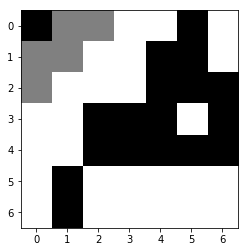

((0, 0), (1, 1)): n_v:  4220 q_all:-0.405452 q:-0.368351 q_m:-0.033333 p:0.752475
((0, 0), (2, 0)): n_v:   337 q_all:-0.478641 q:-0.459320 q_m:-0.066667 p:0.170270
((0, 0), (0, 2)): n_v:    82 q_all:-0.539599 q:-0.534245 q_m:-0.066667 p:0.063709
((0, 0), (1, 0)): n_v:     5 q_all:-0.639134 q:-0.651092 q_m:-0.166667 p:0.005869
((3, 2), (1, 1)): n_v:     3 q_all:-0.518602 q:-0.464660 q_m:-0.066667 p:0.002438
((4, 2), (2, 0)): n_v:     1 q_all:-0.717382 q:-0.615742 q_m:-0.066667 p:0.001200
((3, 3), (1, 1)): n_v:     1 q_all:-0.693237 q:-0.606162 q_m:-0.066667 p:0.001433
((3, 2), (2, 0)): n_v:     1 q_all:-0.676854 q:-0.508045 q_m:-0.066667 p:0.000723
((2, 4), (0, 2)): n_v:     0 q_all:-0.688945 q:-0.688945 q_m:-0.066667 p:0.000194
((0, 0), (0, 1)): n_v:     0 q_all:-0.714073 q:-0.714073 q_m:-0.166667 p:0.001137
((1, 4), (0, 2)): n_v:     0 q_all:-0.775659 q:-0.775659 q_m:-0.066667 p:0.000034
((3, 2), (1, 0)): n_v:     0 q_all:-0.605572 q:-0.605572 q_m:-0.200000 p:0.000034
################

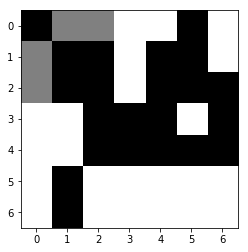

((0, 3), (0, 1)): n_v:  2225 q_all:+0.522053 q:+0.351230 q_m:+0.233333 p:0.100019
((2, 3), (0, 1)): n_v:  1703 q_all:+0.496563 q:+0.377509 q_m:+0.233333 p:0.117150
((3, 0), (1, 0)): n_v:   234 q_all:+0.252955 q:+0.337415 q_m:+0.233333 p:0.273630
((2, 3), (0, 2)): n_v:   149 q_all:+0.415240 q:+0.364562 q_m:+0.166667 p:0.073411
((3, 1), (1, 0)): n_v:   141 q_all:+0.121780 q:+0.147319 q_m:+0.233333 p:0.242459
((1, 3), (0, 1)): n_v:    51 q_all:+0.207396 q:+0.263841 q_m:+0.233333 p:0.070096
((3, 0), (2, 0)): n_v:    45 q_all:+0.423404 q:+0.485034 q_m:+0.200000 p:0.020790
((0, 3), (0, 2)): n_v:    29 q_all:+0.374375 q:+0.459930 q_m:+0.200000 p:0.019780
((0, 4), (0, 2)): n_v:    29 q_all:+0.274441 q:+0.322533 q_m:+0.166667 p:0.031845
((4, 0), (2, 0)): n_v:     1 q_all:-0.112778 q:+0.098398 q_m:+0.166667 p:0.002028
((4, 1), (2, 0)): n_v:     0 q_all:+0.046724 q:+0.046724 q_m:+0.166667 p:0.000617
########################p_sum is:  0.951824759832
-1 's turn
one move takes time(s):  0.2312507629

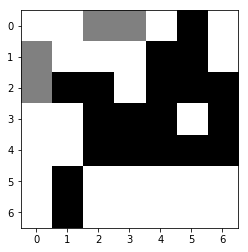

((2, 2), (1, 0)): n_v:  2502 q_all:-0.418566 q:-0.541376 q_m:-0.033333 p:0.018474
((1, 4), (0, 3)): n_v:   658 q_all:-0.513183 q:-0.424631 q_m:-0.000000 p:0.241997
((2, 1), (1, 0)): n_v:   608 q_all:-0.549991 q:-0.337245 q_m:-0.000000 p:0.382241
((2, 1), (0, 3)): n_v:   310 q_all:-0.506515 q:-0.578365 q_m:-0.033333 p:0.099765
((2, 2), (0, 3)): n_v:   122 q_all:-0.515611 q:-0.535363 q_m:-0.033333 p:0.047249
((2, 1), (0, 2)): n_v:    50 q_all:-0.555709 q:-0.489909 q_m:+0.033333 p:0.033600
((2, 1), (2, 0)): n_v:    30 q_all:-0.671699 q:-0.365714 q_m:-0.000000 p:0.038927
((2, 4), (0, 3)): n_v:    28 q_all:-0.614196 q:-0.724775 q_m:-0.033333 p:0.027088
((1, 4), (0, 2)): n_v:    24 q_all:-0.708928 q:-0.649857 q_m:+0.033333 p:0.035841
((2, 4), (0, 2)): n_v:    19 q_all:-0.667331 q:-0.691139 q_m:+0.033333 p:0.024911
((0, 5), (0, 3)): n_v:    13 q_all:-0.657787 q:-0.607657 q_m:-0.033333 p:0.016683
((2, 5), (0, 3)): n_v:     7 q_all:-0.881241 q:-0.799233 q_m:-0.033333 p:0.018333
((2, 2), (0, 2))

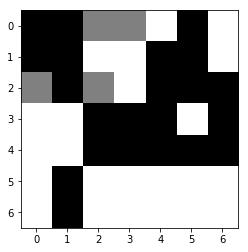

((1, 2), (2, 0)): n_v:  3738 q_all:+0.546625 q:+0.454300 q_m:+0.233333 p:0.090995
((3, 0), (2, 2)): n_v:   619 q_all:+0.355889 q:+0.427825 q_m:+0.300000 p:0.438164
((0, 4), (2, 2)): n_v:   129 q_all:+0.412618 q:+0.539182 q_m:+0.300000 p:0.042407
((1, 2), (2, 2)): n_v:   107 q_all:+0.370516 q:+0.537272 q_m:+0.333333 p:0.062856
((2, 3), (0, 2)): n_v:    69 q_all:+0.409130 q:+0.356252 q_m:+0.166667 p:0.024366
((3, 0), (2, 0)): n_v:    27 q_all:+0.262744 q:+0.460622 q_m:+0.266667 p:0.035417
((4, 0), (2, 2)): n_v:     7 q_all:+0.199578 q:+0.285654 q_m:+0.300000 p:0.012190
((0, 4), (0, 2)): n_v:     3 q_all:+0.290847 q:+0.363160 q_m:+0.166667 p:0.004516
((4, 1), (2, 2)): n_v:     2 q_all:-0.119582 q:+0.124879 q_m:+0.300000 p:0.007182
((2, 3), (0, 3)): n_v:     0 q_all:+0.369136 q:+0.369136 q_m:+0.100000 p:0.000179
((4, 1), (2, 0)): n_v:     0 q_all:+0.150378 q:+0.150378 q_m:+0.233333 p:0.001096
((4, 0), (2, 0)): n_v:     0 q_all:+0.169547 q:+0.169547 q_m:+0.233333 p:0.001494
((0, 4), (0, 3))

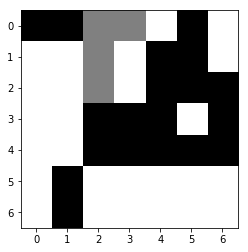

((0, 1), (2, 2)): n_v:  2471 q_all:-0.532101 q:-0.418299 q_m:+0.100000 p:0.242523
((1, 4), (0, 3)): n_v:  2258 q_all:-0.515310 q:-0.530013 q_m:-0.066667 p:0.061892
((0, 1), (0, 3)): n_v:   505 q_all:-0.552933 q:-0.483341 q_m:-0.100000 p:0.095232
((3, 2), (2, 2)): n_v:   298 q_all:-0.640325 q:-0.527116 q_m:+0.133333 p:0.169031
((3, 2), (1, 2)): n_v:   128 q_all:-0.574510 q:-0.633996 q_m:+0.033333 p:0.035983
((0, 0), (2, 2)): n_v:    43 q_all:-0.657246 q:-0.579868 q_m:+0.100000 p:0.027632
((1, 4), (2, 2)): n_v:    35 q_all:-0.764386 q:-0.750763 q_m:+0.100000 p:0.038761
((0, 5), (0, 3)): n_v:    31 q_all:-0.741907 q:-0.670679 q_m:-0.100000 p:0.031162
((2, 4), (0, 3)): n_v:    29 q_all:-0.636911 q:-0.698524 q_m:-0.100000 p:0.015786
((4, 3), (2, 2)): n_v:    24 q_all:-0.692441 q:-0.607976 q_m:+0.100000 p:0.019234
((4, 2), (2, 2)): n_v:    21 q_all:-0.675382 q:-0.646100 q_m:+0.100000 p:0.015440
((4, 4), (2, 2)): n_v:    11 q_all:-0.623440 q:-0.567784 q_m:+0.100000 p:0.005435
((3, 3), (1, 2))

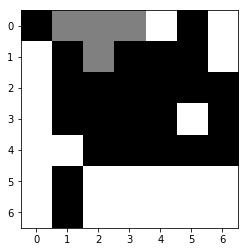

((0, 4), (1, 2)): n_v:  3275 q_all:+0.732568 q:+0.638625 q_m:+0.233333 p:0.635091
((1, 0), (1, 2)): n_v:   277 q_all:+0.552218 q:+0.550285 q_m:+0.233333 p:0.297948
((2, 0), (1, 2)): n_v:    21 q_all:+0.424011 q:+0.429469 q_m:+0.233333 p:0.035592
((3, 0), (1, 2)): n_v:    12 q_all:+0.296012 q:+0.318618 q_m:+0.233333 p:0.027083
((1, 0), (0, 1)): n_v:     1 q_all:+0.510280 q:+0.347161 q_m:+0.066667 p:0.002240
((0, 4), (0, 3)): n_v:     0 q_all:+0.362007 q:+0.362007 q_m:+0.066667 p:0.000466
((2, 0), (0, 2)): n_v:     0 q_all:+0.096993 q:+0.096993 q_m:+0.033333 p:0.000038
((2, 0), (0, 1)): n_v:     0 q_all:+0.227665 q:+0.227665 q_m:+0.033333 p:0.000080
((0, 4), (0, 2)): n_v:     0 q_all:+0.319014 q:+0.319014 q_m:+0.033333 p:0.000611
((1, 0), (0, 2)): n_v:     0 q_all:+0.148104 q:+0.148104 q_m:+0.033333 p:0.000705
########################p_sum is:  0.999854212041
-1 's turn
one move takes time(s):  0.377577543258667
no. of data collected:  24


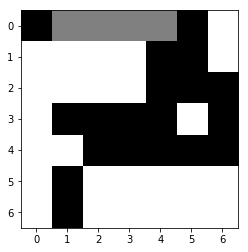

((0, 5), (0, 3)): n_v:  2500 q_all:-0.752908 q:-0.748170 q_m:-0.100000 p:0.176853
((0, 0), (0, 1)): n_v:  1408 q_all:-0.814870 q:-0.645649 q_m:-0.000000 p:0.493240
((0, 0), (0, 2)): n_v:   154 q_all:-0.860640 q:-0.800442 q_m:-0.033333 p:0.085796
((2, 4), (0, 3)): n_v:   108 q_all:-0.744832 q:-0.801456 q_m:-0.100000 p:0.003358
((0, 5), (0, 4)): n_v:    77 q_all:-0.915487 q:-0.786544 q_m:-0.133333 p:0.061571
((1, 4), (0, 3)): n_v:    62 q_all:-0.807730 q:-0.824937 q_m:-0.066667 p:0.019970
((1, 4), (0, 2)): n_v:    37 q_all:-0.853472 q:-0.816546 q_m:-0.033333 p:0.019592
((1, 5), (0, 3)): n_v:    32 q_all:-0.868995 q:-0.785094 q_m:-0.100000 p:0.019543
((2, 5), (0, 3)): n_v:    28 q_all:-0.765979 q:-0.809567 q_m:-0.100000 p:0.003266
((2, 4), (0, 2)): n_v:    27 q_all:-0.857826 q:-0.802143 q_m:-0.033333 p:0.015096
((2, 6), (0, 4)): n_v:     8 q_all:-0.862635 q:-0.777560 q_m:-0.166667 p:0.004672
((2, 5), (0, 4)): n_v:     5 q_all:-0.807430 q:-0.824715 q_m:-0.166667 p:0.001751
((2, 4), (0, 4))

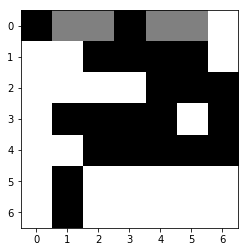

((0, 6), (0, 4)): n_v:  2043 q_all:+0.808013 q:+0.698495 q_m:+0.366667 p:0.126895
((1, 0), (0, 1)): n_v:  1219 q_all:+0.778150 q:+0.757368 q_m:+0.266667 p:0.157999
((0, 6), (0, 5)): n_v:   690 q_all:+0.751695 q:+0.755951 q_m:+0.266667 p:0.211069
((1, 0), (0, 2)): n_v:   361 q_all:+0.783104 q:+0.623699 q_m:+0.300000 p:0.045017
((1, 1), (0, 2)): n_v:   151 q_all:+0.762299 q:+0.732071 q_m:+0.333333 p:0.035550
((1, 6), (0, 4)): n_v:   130 q_all:+0.675760 q:+0.684650 q_m:+0.366667 p:0.092116
((2, 3), (0, 5)): n_v:    25 q_all:+0.638639 q:+0.577566 q_m:+0.233333 p:0.022851
((2, 3), (0, 1)): n_v:    24 q_all:+0.690380 q:+0.620341 q_m:+0.233333 p:0.014940
((2, 3), (0, 4)): n_v:    16 q_all:+0.604103 q:+0.627973 q_m:+0.366667 p:0.017238
((2, 3), (0, 2)): n_v:    16 q_all:+0.695794 q:+0.597590 q_m:+0.300000 p:0.010304
((2, 2), (0, 4)): n_v:     7 q_all:+0.525803 q:+0.506017 q_m:+0.366667 p:0.011472
((2, 2), (0, 1)): n_v:     1 q_all:+0.456938 q:+0.501138 q_m:+0.233333 p:0.001609
((2, 0), (0, 2))

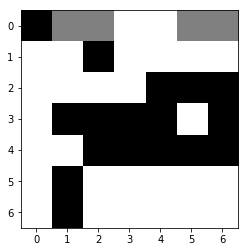

((2, 6), (0, 5)): n_v:  2506 q_all:-0.840940 q:-0.608707 q_m:-0.100000 p:0.634424
((0, 0), (0, 1)): n_v:   886 q_all:-0.810493 q:-0.844259 q_m:-0.200000 p:0.086537
((2, 5), (0, 5)): n_v:   440 q_all:-0.804618 q:-0.797928 q_m:-0.100000 p:0.029099
((2, 4), (0, 5)): n_v:   288 q_all:-0.827740 q:-0.705084 q_m:-0.100000 p:0.053459
((2, 6), (0, 6)): n_v:     6 q_all:-0.832614 q:-0.762527 q_m:-0.233333 p:0.001445
((2, 5), (0, 6)): n_v:     1 q_all:-0.827689 q:-0.796604 q_m:-0.233333 p:0.000116
((0, 0), (0, 2)): n_v:     1 q_all:-0.870577 q:-0.835039 q_m:-0.166667 p:0.000724
((1, 2), (0, 2)): n_v:     1 q_all:-0.881306 q:-0.793891 q_m:-0.133333 p:0.000881
((2, 4), (0, 6)): n_v:     0 q_all:-0.818032 q:-0.818032 q_m:-0.233333 p:0.000041
((2, 4), (0, 2)): n_v:     0 q_all:-0.830450 q:-0.830450 q_m:-0.166667 p:0.000162
########################p_sum is:  0.806887483468
1 's turn
one move takes time(s):  0.19405150413513184
no. of data collected:  16


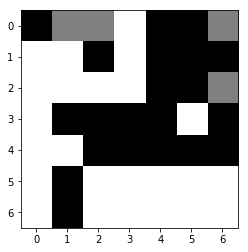

((3, 5), (2, 6)): n_v:  4590 q_all:+0.860007 q:+0.833398 q_m:+0.400000 p:0.882698
((1, 0), (0, 1)): n_v:    44 q_all:+0.720231 q:+0.736693 q_m:+0.266667 p:0.038628
((1, 3), (0, 1)): n_v:    12 q_all:+0.606013 q:+0.588914 q_m:+0.233333 p:0.017790
((0, 3), (0, 1)): n_v:    10 q_all:+0.723777 q:+0.681312 q_m:+0.233333 p:0.009341
((2, 3), (0, 1)): n_v:     7 q_all:+0.622691 q:+0.555626 q_m:+0.233333 p:0.010564
((2, 2), (0, 1)): n_v:     2 q_all:+0.418529 q:+0.408763 q_m:+0.233333 p:0.006369
((2, 0), (0, 2)): n_v:     0 q_all:+0.253502 q:+0.253502 q_m:+0.166667 p:0.000112
((1, 0), (0, 2)): n_v:     0 q_all:+0.434856 q:+0.434856 q_m:+0.166667 p:0.001905
((2, 2), (0, 2)): n_v:     0 q_all:+0.196439 q:+0.196439 q_m:+0.166667 p:0.000054
((0, 3), (0, 2)): n_v:     0 q_all:+0.548176 q:+0.548176 q_m:+0.200000 p:0.001205
((2, 3), (0, 2)): n_v:     0 q_all:+0.356447 q:+0.356447 q_m:+0.166667 p:0.000236
((2, 1), (0, 1)): n_v:     0 q_all:+0.243063 q:+0.243063 q_m:+0.233333 p:0.001644
((2, 0), (0, 1))

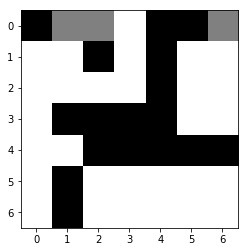

((0, 4), (0, 6)): n_v:  2636 q_all:-0.911115 q:-0.852379 q_m:-0.266667 p:0.483131
((1, 4), (0, 6)): n_v:  1092 q_all:-0.916641 q:-0.867967 q_m:-0.266667 p:0.224723
((0, 5), (0, 6)): n_v:   971 q_all:-0.935115 q:-0.891578 q_m:-0.233333 p:0.272397
((0, 4), (0, 2)): n_v:   640 q_all:-0.866507 q:-0.877626 q_m:-0.200000 p:0.001832
((2, 4), (0, 6)): n_v:   114 q_all:-0.879778 q:-0.829906 q_m:-0.266667 p:0.006079
((1, 4), (0, 2)): n_v:    65 q_all:-0.868575 q:-0.892030 q_m:-0.200000 p:0.000723
((0, 0), (0, 2)): n_v:     8 q_all:-0.963435 q:-0.956048 q_m:-0.200000 p:0.003468
((1, 2), (0, 2)): n_v:     8 q_all:-0.978057 q:-0.943825 q_m:-0.166667 p:0.003818
((0, 0), (0, 1)): n_v:     1 q_all:-0.981002 q:-0.965929 q_m:-0.233333 p:0.000707
((2, 4), (0, 2)): n_v:     0 q_all:-0.937693 q:-0.937693 q_m:-0.200000 p:0.000246
########################p_sum is:  0.997123839101
1 's turn


This is a random move


one move takes time(s):  0.15078139305114746
no. of data collected:  24


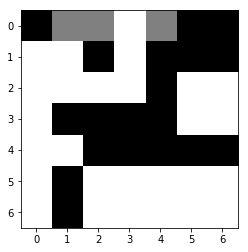

((0, 3), (0, 2)): n_v:  2388 q_all:+0.964427 q:+0.871486 q_m:+0.366667 p:0.182261
((0, 3), (0, 4)): n_v:  1272 q_all:+0.929525 q:+0.964068 q_m:+0.500000 p:0.281976
((1, 0), (0, 1)): n_v:   451 q_all:+0.940611 q:+0.940880 q_m:+0.433333 p:0.010061
((0, 3), (0, 1)): n_v:    87 q_all:+0.884912 q:+0.883952 q_m:+0.400000 p:0.039350
((1, 3), (0, 1)): n_v:     4 q_all:+0.795832 q:+0.819473 q_m:+0.400000 p:0.003994
((2, 3), (0, 1)): n_v:     3 q_all:+0.790635 q:+0.780774 q_m:+0.400000 p:0.003243
((2, 3), (0, 4)): n_v:     2 q_all:+0.809103 q:+0.846855 q_m:+0.466667 p:0.001587
((2, 0), (0, 2)): n_v:     0 q_all:+0.644869 q:+0.644869 q_m:+0.333333 p:0.000185
((1, 0), (0, 2)): n_v:     0 q_all:+0.745991 q:+0.745991 q_m:+0.333333 p:0.000479
((2, 2), (0, 2)): n_v:     0 q_all:+0.618053 q:+0.618053 q_m:+0.333333 p:0.000035
((2, 2), (0, 4)): n_v:     0 q_all:+0.809236 q:+0.809236 q_m:+0.466667 p:0.000124
((2, 3), (0, 2)): n_v:     0 q_all:+0.704803 q:+0.704803 q_m:+0.333333 p:0.000954
((2, 2), (0, 1))

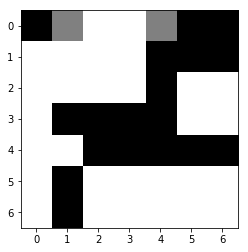

((0, 0), (0, 1)): n_v:  1626 q_all:-0.988538 q:-0.944835 q_m:-0.066667 p:0.333399
((1, 6), (0, 4)): n_v:   777 q_all:-0.984695 q:-0.864591 q_m:-0.233333 p:0.143410
((0, 6), (0, 4)): n_v:   706 q_all:-0.987643 q:-0.895731 q_m:-0.233333 p:0.140390
((2, 4), (0, 4)): n_v:   600 q_all:-0.949195 q:-0.886774 q_m:-0.233333 p:0.005593
((0, 5), (0, 4)): n_v:   574 q_all:-0.994636 q:-0.945043 q_m:-0.200000 p:0.133913
########################p_sum is:  0.756704353727
1 's turn


This is a random move


one move takes time(s):  0.0774984359741211
no. of data collected:  8


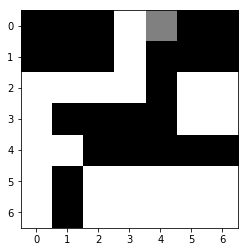

((0, 3), (0, 4)): n_v:  3409 q_all:+1.000000 q:+5.000000 q_m:+0.300000 p:0.414021
((2, 3), (0, 4)): n_v:   402 q_all:+0.949933 q:+0.881752 q_m:+0.266667 p:0.157671
((2, 2), (0, 4)): n_v:     9 q_all:+0.562455 q:+0.319253 q_m:+0.266667 p:0.024610
((2, 6), (0, 4)): n_v:     2 q_all:+0.043477 q:+0.565215 q_m:+0.266667 p:0.006578
((2, 5), (0, 4)): n_v:     1 q_all:-0.370761 q:+0.258477 q_m:+0.266667 p:0.005108
########################p_sum is:  0.607988329139
this self play has 84 steps, time elapsed 819.9605770111084
winner is 1.0
episode 137 finished
episode 138 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.2901763916015625
no. of data collected:  8
1 's turn
one move takes time(s):  0.38365674018859863
no. of data collected:  16
-1 's turn
one move takes time(s):  0.7073562145233154
no. of data collected:  24
1 's turn


This is a random move


one move takes time(s):  0.9814114570617676
no. of data collected:  16
-1 's turn


This is a random move

episode 138 finished
episode 139 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.34769177436828613
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.4857339859008789
no. of data collected:  16
-1 's turn
one move takes time(s):  0.7298262119293213
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  1.070117712020874
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.1322474479675293
one move takes time(s):  2.1334586143493652
no. of data collected:  16
1 's turn
one move takes time(s):  1.6382744312286377
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.799985647201538


This is a random move


one move takes time(s):  2.8024773597717285
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.1334762573242188


This is a random m

one move takes time(s):  0.8155105113983154
no. of data collected:  16
-1 's turn
one move takes time(s):  0.9037973880767822
no. of data collected:  24
1 's turn


This is a random move


one move takes time(s):  1.7457139492034912
no. of data collected:  24
-1 's turn
one move takes time(s):  0.8955118656158447
no. of data collected:  16
1 's turn
one move takes time(s):  1.3809514045715332
no. of data collected:  24
-1 's turn
one move takes time(s):  1.1266679763793945
no. of data collected:  16
1 's turn
one move takes time(s):  1.3586139678955078
no. of data collected:  16
-1 's turn
one move takes time(s):  0.6387512683868408
no. of data collected:  24
1 's turn
one move takes time(s):  1.2678349018096924
no. of data collected:  24
-1 's turn
one move takes time(s):  0.5275444984436035
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  0.39864635467529297
no. of data collected:  16
-1 's turn
one move takes time(s):  0.260892391204834
no. of 

one move takes time(s):  1.5456385612487793
no. of data collected:  24
-1 's turn
one move takes time(s):  0.9137732982635498
no. of data collected:  24
1 's turn


This is a random move


one move takes time(s):  0.508228063583374
no. of data collected:  16
-1 's turn
one move takes time(s):  0.6386265754699707
no. of data collected:  16
1 's turn
one move takes time(s):  0.875863790512085
no. of data collected:  16
-1 's turn
one move takes time(s):  0.7981293201446533
no. of data collected:  16
1 's turn
one move takes time(s):  0.7868916988372803
no. of data collected:  16
-1 's turn
one move takes time(s):  1.443251132965088
no. of data collected:  16
1 's turn
one move takes time(s):  0.8896281719207764
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  0.6016662120819092
no. of data collected:  16
1 's turn
one move takes time(s):  0.6990001201629639
no. of data collected:  24
-1 's turn
one move takes time(s):  0.8086223602294922
no. of dat

Epoch 19/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8410 - activation_29_loss: 0.8043 - dense_15_loss: 0.0085 - val_loss: 0.8631 - val_activation_29_loss: 0.8258 - val_dense_15_loss: 0.0092
Epoch 20/512
34000/34000 [==============================] - 3s 74us/step - loss: 0.8410 - activation_29_loss: 0.8044 - dense_15_loss: 0.0085 - val_loss: 0.8632 - val_activation_29_loss: 0.8259 - val_dense_15_loss: 0.0093
Epoch 21/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8409 - activation_29_loss: 0.8043 - dense_15_loss: 0.0085 - val_loss: 0.8633 - val_activation_29_loss: 0.8259 - val_dense_15_loss: 0.0092
Epoch 22/512
34000/34000 [==============================] - 3s 75us/step - loss: 0.8404 - activation_29_loss: 0.8038 - dense_15_loss: 0.0084 - val_loss: 0.8633 - val_activation_29_loss: 0.8259 - val_dense_15_loss: 0.0092
Epoch 23/512
34000/34000 [==============================] - 3s 76us/step - loss: 0.8403 - activation_29_loss: 0.8038

34000/34000 [==============================] - 3s 74us/step - loss: 0.8362 - activation_29_loss: 0.7998 - dense_15_loss: 0.0083 - val_loss: 0.8637 - val_activation_29_loss: 0.8264 - val_dense_15_loss: 0.0092
Epoch 57/512
34000/34000 [==============================] - 3s 79us/step - loss: 0.8359 - activation_29_loss: 0.7996 - dense_15_loss: 0.0082 - val_loss: 0.8637 - val_activation_29_loss: 0.8264 - val_dense_15_loss: 0.0092
Epoch 58/512
34000/34000 [==============================] - 3s 79us/step - loss: 0.8359 - activation_29_loss: 0.7995 - dense_15_loss: 0.0083 - val_loss: 0.8638 - val_activation_29_loss: 0.8265 - val_dense_15_loss: 0.0092
Epoch 59/512
34000/34000 [==============================] - 3s 78us/step - loss: 0.8356 - activation_29_loss: 0.7993 - dense_15_loss: 0.0083 - val_loss: 0.8638 - val_activation_29_loss: 0.8265 - val_dense_15_loss: 0.0092
Epoch 60/512
34000/34000 [==============================] - 3s 77us/step - loss: 0.8355 - activation_29_loss: 0.7992 - dense_15_l

testing took time:  152.9292459487915
83.0



                        win ratio of P is 0.505 





episode 140 finished
episode 141 now start
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.29715824127197266
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.4119858741760254
no. of data collected:  16
-1 's turn
one move takes time(s):  0.6764333248138428
no. of data collected:  16
1 's turn


This is a random move


one move takes time(s):  1.1394290924072266
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.169290065765381


This is a random move


one move takes time(s):  2.1705470085144043
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.2588417530059814
one move takes time(s):  2.2597463130950928
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elap

due to rollout lim, final rollout times:  2001 time elapsed:  4.6682116985321045


This is a random move


one move takes time(s):  4.6707847118377686
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  4.512753009796143


This is a random move


one move takes time(s):  4.514710903167725
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.2425355911254883
one move takes time(s):  2.244185209274292
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.355038642883301


This is a random move


one move takes time(s):  2.3563857078552246
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.9164960384368896
one move takes time(s):  2.9178028106689453
no. of data collected:  8
-1 's turn
one move takes time(s):  1.4822990894317627
no. of data collected:  16
1 's turn
one move takes time(s):  1.35608553

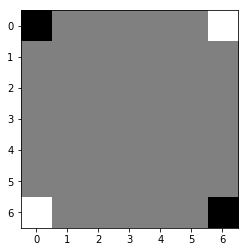

((6, 6), (5, 5)): n_v:  1194 q_all:+0.022596 q:+0.013334 q_m:+0.033333 p:0.502682
((0, 0), (1, 1)): n_v:  1003 q_all:+0.012505 q:+0.029921 q_m:+0.033333 p:0.494141
((6, 6), (6, 5)): n_v:     2 q_all:+0.021394 q:+0.013621 q_m:+0.033333 p:0.001057
((0, 0), (0, 1)): n_v:     1 q_all:+0.008564 q:+0.012841 q_m:+0.033333 p:0.000746
((6, 6), (6, 4)): n_v:     0 q_all:+0.000574 q:+0.000574 q_m:-0.000000 p:0.000018
((0, 0), (1, 2)): n_v:     0 q_all:-0.009058 q:-0.009058 q_m:-0.000000 p:0.000020
((0, 0), (2, 2)): n_v:     0 q_all:+0.000081 q:+0.000081 q_m:-0.000000 p:0.000077
((0, 0), (0, 2)): n_v:     0 q_all:-0.015084 q:-0.015084 q_m:-0.000000 p:0.000020
((6, 6), (5, 6)): n_v:     0 q_all:+0.016667 q:+0.016667 q_m:+0.033333 p:0.000397
((6, 6), (4, 6)): n_v:     0 q_all:+0.008846 q:+0.008846 q_m:-0.000000 p:0.000083
((6, 6), (5, 4)): n_v:     0 q_all:+0.005120 q:+0.005120 q_m:-0.000000 p:0.000041
((6, 6), (4, 4)): n_v:     0 q_all:-0.002251 q:-0.002251 q_m:-0.000000 p:0.000069
((0, 0), (1, 0))

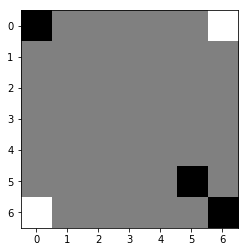

((6, 0), (5, 1)): n_v:  2102 q_all:-0.029481 q:-0.020402 q_m:-0.000000 p:0.628023
((0, 6), (1, 5)): n_v:  1141 q_all:-0.026849 q:-0.021616 q_m:-0.000000 p:0.323615
((6, 0), (5, 0)): n_v:    72 q_all:-0.026647 q:-0.028194 q_m:-0.000000 p:0.020541
((6, 0), (6, 1)): n_v:    37 q_all:-0.031729 q:-0.018390 q_m:-0.000000 p:0.011822
((0, 6), (1, 6)): n_v:    23 q_all:-0.032356 q:-0.030076 q_m:-0.000000 p:0.007340
((0, 6), (0, 5)): n_v:    13 q_all:-0.037797 q:-0.031706 q_m:-0.000000 p:0.004462
((6, 0), (4, 2)): n_v:     3 q_all:-0.043385 q:-0.054115 q_m:-0.033333 p:0.001309
((0, 6), (2, 4)): n_v:     1 q_all:-0.046679 q:-0.040762 q_m:-0.033333 p:0.000493
((6, 0), (6, 2)): n_v:     1 q_all:-0.048254 q:-0.046495 q_m:-0.033333 p:0.000595
((6, 0), (5, 2)): n_v:     1 q_all:-0.047613 q:-0.048224 q_m:-0.033333 p:0.000685
((6, 0), (4, 1)): n_v:     0 q_all:-0.030136 q:-0.030136 q_m:-0.033333 p:0.000208
((0, 6), (2, 6)): n_v:     0 q_all:-0.042452 q:-0.042452 q_m:-0.033333 p:0.000104
((0, 6), (0, 4))

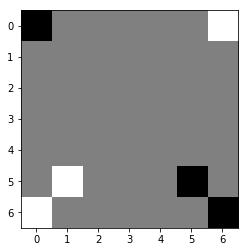

((5, 5), (4, 4)): n_v:  2602 q_all:+0.026192 q:+0.021376 q_m:+0.033333 p:0.604416
((0, 0), (1, 1)): n_v:  1420 q_all:+0.028734 q:+0.026975 q_m:+0.033333 p:0.311573
((5, 5), (5, 4)): n_v:   168 q_all:+0.017877 q:-0.004277 q_m:+0.033333 p:0.046383
((5, 5), (4, 5)): n_v:    82 q_all:+0.017397 q:-0.007583 q_m:+0.033333 p:0.022855
((5, 5), (5, 6)): n_v:    10 q_all:+0.007405 q:-0.014118 q_m:+0.033333 p:0.003578
((5, 5), (6, 5)): n_v:     7 q_all:+0.009923 q:-0.006259 q_m:+0.033333 p:0.002389
((5, 5), (6, 4)): n_v:     6 q_all:+0.013965 q:-0.004084 q_m:+0.033333 p:0.002026
((5, 5), (4, 6)): n_v:     5 q_all:+0.018480 q:+0.005525 q_m:+0.033333 p:0.001462
((0, 0), (1, 0)): n_v:     1 q_all:+0.012685 q:+0.016975 q_m:+0.033333 p:0.000546
((0, 0), (0, 1)): n_v:     1 q_all:+0.009343 q:+0.009561 q_m:+0.033333 p:0.000386
((5, 5), (3, 6)): n_v:     0 q_all:+0.003780 q:+0.003780 q_m:-0.000000 p:0.000022
((5, 5), (5, 3)): n_v:     0 q_all:+0.010142 q:+0.010142 q_m:-0.000000 p:0.000028
((0, 0), (0, 2))

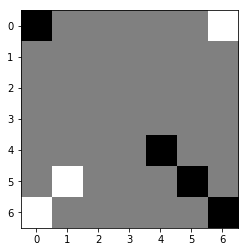

((0, 6), (1, 5)): n_v:  2273 q_all:-0.018097 q:-0.025587 q_m:-0.000000 p:0.462095
((5, 1), (5, 2)): n_v:   872 q_all:-0.024321 q:-0.027651 q_m:-0.000000 p:0.203332
((5, 1), (4, 2)): n_v:   839 q_all:-0.031142 q:-0.046143 q_m:-0.000000 p:0.223296
((5, 1), (4, 1)): n_v:   132 q_all:-0.021686 q:-0.028191 q_m:-0.000000 p:0.029282
((5, 1), (5, 0)): n_v:    84 q_all:-0.025266 q:-0.035220 q_m:-0.000000 p:0.020025
((0, 6), (1, 6)): n_v:    39 q_all:-0.026546 q:-0.033160 q_m:-0.000000 p:0.009745
((5, 1), (6, 2)): n_v:    33 q_all:-0.027614 q:-0.027034 q_m:-0.000000 p:0.008190
((5, 1), (6, 1)): n_v:    16 q_all:-0.031700 q:-0.038179 q_m:-0.000000 p:0.004489
((5, 1), (3, 3)): n_v:    14 q_all:-0.039386 q:-0.025856 q_m:+0.033333 p:0.004450
((5, 1), (4, 0)): n_v:     9 q_all:-0.034589 q:-0.038630 q_m:-0.000000 p:0.002619
((0, 6), (0, 5)): n_v:     9 q_all:-0.031764 q:-0.031483 q_m:-0.000000 p:0.002532
((5, 1), (4, 3)): n_v:     4 q_all:-0.048605 q:-0.036270 q_m:+0.033333 p:0.001587
((5, 1), (5, 3))

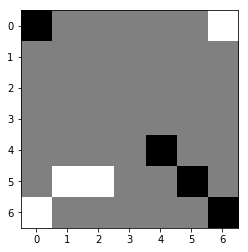

((4, 4), (5, 3)): n_v:  1304 q_all:+0.028758 q:+0.044079 q_m:+0.100000 p:0.470941
((0, 0), (1, 1)): n_v:   740 q_all:+0.042636 q:+0.032315 q_m:+0.033333 p:0.205402
((4, 4), (3, 5)): n_v:   541 q_all:+0.034627 q:+0.021658 q_m:+0.033333 p:0.176055
((4, 4), (4, 3)): n_v:   125 q_all:+0.043071 q:+0.054085 q_m:+0.100000 p:0.034396
((4, 4), (4, 2)): n_v:    70 q_all:+0.007984 q:+0.058342 q_m:+0.133333 p:0.034323
((4, 4), (6, 2)): n_v:    27 q_all:-0.003548 q:+0.065019 q_m:+0.133333 p:0.015481
((4, 4), (3, 3)): n_v:    25 q_all:+0.025229 q:+0.033148 q_m:+0.033333 p:0.009653
((4, 4), (6, 5)): n_v:    12 q_all:+0.007928 q:-0.019862 q_m:-0.000000 p:0.006008
((5, 5), (6, 4)): n_v:    11 q_all:-0.004994 q:+0.009529 q_m:+0.033333 p:0.006680
((4, 4), (5, 4)): n_v:    11 q_all:+0.029567 q:-0.000556 q_m:+0.033333 p:0.004221
((4, 4), (6, 4)): n_v:     7 q_all:+0.013062 q:-0.012024 q_m:-0.000000 p:0.003310
((4, 4), (3, 4)): n_v:     6 q_all:+0.023411 q:+0.011473 q_m:+0.033333 p:0.002430
((4, 4), (4, 5))

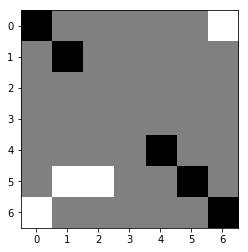

((0, 6), (1, 5)): n_v:  1342 q_all:-0.018735 q:-0.026060 q_m:-0.000000 p:0.313073
((5, 2), (5, 3)): n_v:   464 q_all:-0.034153 q:-0.016141 q_m:+0.066667 p:0.152339
((5, 1), (4, 2)): n_v:   289 q_all:-0.042330 q:-0.057587 q_m:-0.000000 p:0.109691
((5, 2), (5, 4)): n_v:   178 q_all:-0.035241 q:+0.015000 q_m:+0.100000 p:0.059833
((5, 2), (4, 3)): n_v:   135 q_all:-0.032809 q:-0.030352 q_m:+0.066667 p:0.043311
((5, 2), (3, 3)): n_v:   113 q_all:-0.020096 q:-0.034917 q_m:+0.033333 p:0.027486
((5, 2), (3, 1)): n_v:    92 q_all:-0.036212 q:-0.042193 q_m:-0.033333 p:0.031621
((5, 2), (6, 3)): n_v:    48 q_all:-0.052006 q:-0.023792 q_m:-0.000000 p:0.020993
((5, 2), (5, 0)): n_v:    38 q_all:-0.047511 q:-0.059229 q_m:-0.033333 p:0.015613
((5, 1), (4, 1)): n_v:    31 q_all:-0.088513 q:-0.040534 q_m:-0.000000 p:0.020492
((0, 6), (1, 6)): n_v:    28 q_all:-0.022294 q:-0.032520 q_m:-0.000000 p:0.007313
((0, 6), (0, 5)): n_v:    19 q_all:-0.027917 q:-0.032278 q_m:-0.000000 p:0.005656
((5, 1), (5, 0))

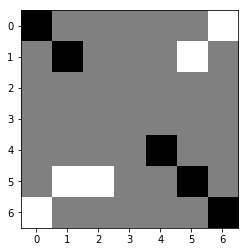

((4, 4), (3, 5)): n_v:  1331 q_all:+0.028619 q:+0.022740 q_m:+0.033333 p:0.370824
((4, 4), (5, 3)): n_v:  1088 q_all:+0.029690 q:+0.041170 q_m:+0.100000 p:0.296521
((1, 1), (2, 2)): n_v:   438 q_all:+0.008847 q:+0.026138 q_m:+0.033333 p:0.171962
((4, 4), (4, 2)): n_v:   112 q_all:+0.011734 q:+0.055399 q_m:+0.133333 p:0.042255
((4, 4), (4, 3)): n_v:    73 q_all:+0.044476 q:+0.049045 q_m:+0.100000 p:0.013671
((4, 4), (3, 3)): n_v:    39 q_all:+0.025420 q:+0.024766 q_m:+0.033333 p:0.011748
((4, 4), (2, 4)): n_v:    30 q_all:+0.024107 q:+0.036102 q_m:+0.066667 p:0.009383
((1, 1), (2, 1)): n_v:    20 q_all:+0.031173 q:+0.010153 q_m:+0.033333 p:0.005114
((4, 4), (3, 4)): n_v:    19 q_all:+0.029941 q:+0.006183 q_m:+0.033333 p:0.005253
((4, 4), (6, 5)): n_v:    17 q_all:+0.001794 q:-0.022720 q_m:-0.000000 p:0.007620
((4, 4), (5, 4)): n_v:    17 q_all:+0.024616 q:-0.002766 q_m:+0.033333 p:0.005119
((4, 4), (6, 2)): n_v:    15 q_all:+0.002329 q:+0.061613 q_m:+0.133333 p:0.006482
((4, 4), (2, 2))

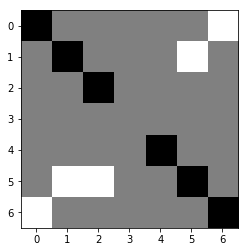

((5, 2), (3, 3)): n_v:  1710 q_all:+0.014778 q:+0.001730 q_m:+0.100000 p:0.556386
((5, 1), (3, 3)): n_v:   297 q_all:-0.003964 q:+0.002734 q_m:+0.100000 p:0.132845
((5, 2), (3, 1)): n_v:   208 q_all:-0.001066 q:-0.009373 q_m:+0.033333 p:0.089198
((1, 5), (3, 3)): n_v:   128 q_all:-0.001986 q:+0.016523 q_m:+0.100000 p:0.055624
((5, 2), (5, 3)): n_v:    91 q_all:-0.023102 q:-0.020063 q_m:+0.066667 p:0.052108
((5, 2), (5, 4)): n_v:    43 q_all:+0.001437 q:+0.016413 q_m:+0.100000 p:0.018027
((1, 5), (2, 4)): n_v:    25 q_all:-0.018675 q:-0.032371 q_m:-0.000000 p:0.013805
((1, 5), (1, 4)): n_v:    23 q_all:-0.014948 q:-0.034933 q_m:-0.000000 p:0.012367
((5, 2), (6, 4)): n_v:    13 q_all:-0.052729 q:-0.000026 q_m:+0.033333 p:0.009696
((5, 1), (4, 2)): n_v:    12 q_all:-0.067092 q:-0.058024 q_m:-0.000000 p:0.010566
((5, 2), (3, 2)): n_v:     9 q_all:-0.017350 q:-0.013931 q_m:+0.033333 p:0.005256
((5, 1), (3, 1)): n_v:     8 q_all:-0.020394 q:-0.025484 q_m:+0.033333 p:0.004523
((5, 2), (3, 4))

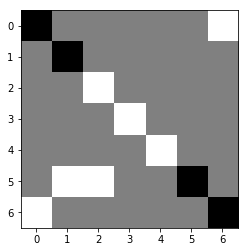

((5, 5), (4, 3)): n_v:  1794 q_all:+0.027065 q:+0.041073 q_m:+0.100000 p:0.666850
((1, 1), (2, 3)): n_v:   229 q_all:-0.000010 q:+0.019893 q_m:+0.033333 p:0.128502
((1, 1), (3, 2)): n_v:   221 q_all:-0.018941 q:-0.004977 q_m:+0.033333 p:0.152604
((5, 5), (3, 4)): n_v:    48 q_all:-0.004534 q:+0.003517 q_m:+0.033333 p:0.028691
((5, 5), (5, 3)): n_v:    10 q_all:-0.010357 q:+0.008149 q_m:+0.033333 p:0.006715
((5, 5), (5, 4)): n_v:     7 q_all:-0.010342 q:-0.021307 q_m:-0.000000 p:0.004132
((1, 1), (3, 1)): n_v:     5 q_all:-0.018598 q:-0.030914 q_m:-0.033333 p:0.003832
((5, 5), (4, 5)): n_v:     2 q_all:-0.031820 q:-0.021220 q_m:-0.000000 p:0.001725
((1, 1), (1, 3)): n_v:     1 q_all:-0.039147 q:-0.023111 q_m:-0.033333 p:0.001437
((1, 1), (2, 1)): n_v:     1 q_all:-0.067578 q:-0.018590 q_m:-0.000000 p:0.001350
((5, 5), (3, 5)): n_v:     1 q_all:-0.015205 q:-0.014472 q_m:-0.033333 p:0.000787
((5, 5), (6, 5)): n_v:     0 q_all:-0.053783 q:-0.053783 q_m:-0.066667 p:0.000144
((1, 1), (2, 0))

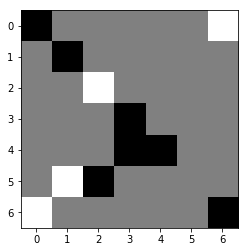

((2, 2), (3, 4)): n_v:  1090 q_all:-0.032588 q:-0.008934 q_m:+0.100000 p:0.344088
((5, 1), (4, 2)): n_v:   918 q_all:-0.006886 q:+0.000250 q_m:+0.133333 p:0.162098
((2, 2), (3, 2)): n_v:   446 q_all:-0.032229 q:-0.029341 q_m:+0.066667 p:0.140038
((5, 1), (5, 3)): n_v:   365 q_all:-0.006895 q:-0.040654 q_m:+0.100000 p:0.064523
((2, 2), (0, 1)): n_v:   292 q_all:-0.003958 q:+0.019949 q_m:+0.033333 p:0.046935
((2, 2), (4, 2)): n_v:   239 q_all:-0.026318 q:-0.010892 q_m:+0.100000 p:0.067321
((2, 2), (1, 3)): n_v:   127 q_all:-0.048840 q:-0.041688 q_m:-0.066667 p:0.051354
((2, 2), (2, 4)): n_v:    99 q_all:-0.044259 q:-0.043489 q_m:-0.033333 p:0.037402
((6, 0), (4, 2)): n_v:    71 q_all:-0.017440 q:-0.014519 q_m:+0.100000 p:0.016744
((5, 1), (3, 2)): n_v:    43 q_all:-0.042423 q:-0.036267 q_m:+0.033333 p:0.016020
((5, 1), (6, 1)): n_v:    30 q_all:-0.034153 q:-0.035013 q_m:-0.000000 p:0.010043
((2, 2), (1, 4)): n_v:    14 q_all:-0.087780 q:-0.062547 q_m:-0.100000 p:0.008423
((2, 2), (1, 0))

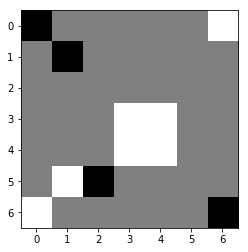

((5, 2), (4, 2)): n_v:  2378 q_all:+0.030364 q:+0.030488 q_m:+0.133333 p:0.719845
((1, 1), (2, 2)): n_v:   405 q_all:+0.019479 q:+0.016208 q_m:-0.000000 p:0.149048
((5, 2), (5, 3)): n_v:    88 q_all:+0.014559 q:-0.007336 q_m:+0.066667 p:0.035240
((5, 2), (6, 1)): n_v:    67 q_all:+0.031843 q:+0.017047 q_m:+0.066667 p:0.019945
((0, 0), (2, 2)): n_v:    29 q_all:+0.005438 q:+0.003260 q_m:-0.033333 p:0.013268
((6, 6), (5, 5)): n_v:    24 q_all:+0.015061 q:+0.010845 q_m:-0.000000 p:0.009779
((5, 2), (3, 1)): n_v:    19 q_all:-0.011509 q:-0.040246 q_m:-0.100000 p:0.010865
((5, 2), (5, 0)): n_v:     7 q_all:-0.011427 q:+0.022168 q_m:+0.033333 p:0.004096
((5, 2), (5, 4)): n_v:     6 q_all:-0.007811 q:-0.008661 q_m:+0.033333 p:0.003246
((5, 2), (4, 1)): n_v:     6 q_all:-0.015010 q:-0.006354 q_m:-0.000000 p:0.003704
((1, 1), (2, 3)): n_v:     5 q_all:-0.000192 q:+0.026820 q_m:+0.033333 p:0.002604
((5, 2), (6, 3)): n_v:     4 q_all:-0.009021 q:-0.013449 q_m:-0.066667 p:0.002558
((5, 2), (4, 0))

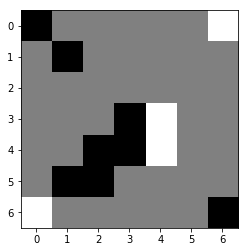

((4, 4), (5, 3)): n_v:  1940 q_all:-0.035565 q:-0.068143 q_m:+0.100000 p:0.497999
((3, 4), (3, 2)): n_v:   764 q_all:-0.032470 q:-0.032742 q_m:+0.066667 p:0.184175
((6, 0), (4, 1)): n_v:   393 q_all:-0.018461 q:-0.045833 q_m:+0.066667 p:0.067064
((4, 4), (3, 2)): n_v:   380 q_all:-0.048733 q:-0.037972 q_m:+0.066667 p:0.123031
((3, 4), (2, 2)): n_v:    99 q_all:-0.013250 q:-0.032827 q_m:-0.000000 p:0.014279
((3, 4), (5, 3)): n_v:    87 q_all:-0.049785 q:-0.066397 q_m:+0.066667 p:0.028741
((4, 4), (5, 5)): n_v:    75 q_all:-0.030700 q:-0.034335 q_m:-0.033333 p:0.017515
((6, 0), (6, 1)): n_v:    45 q_all:-0.047570 q:-0.070261 q_m:+0.033333 p:0.014501
((4, 4), (6, 2)): n_v:    28 q_all:-0.061623 q:-0.030037 q_m:-0.000000 p:0.010962
((4, 4), (6, 5)): n_v:    21 q_all:-0.054428 q:-0.036467 q_m:-0.066667 p:0.007482
((3, 4), (1, 3)): n_v:    17 q_all:-0.080708 q:-0.080099 q_m:-0.133333 p:0.008420
((4, 4), (2, 2)): n_v:    10 q_all:-0.040168 q:-0.037334 q_m:-0.000000 p:0.002869
((3, 4), (5, 5))

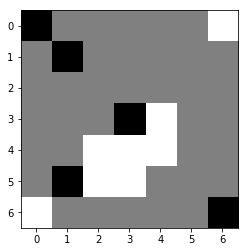

((6, 6), (5, 4)): n_v:  2976 q_all:+0.035783 q:+0.022890 q_m:+0.100000 p:0.754431
((3, 3), (5, 4)): n_v:   316 q_all:+0.039017 q:+0.027209 q_m:+0.100000 p:0.074706
((3, 3), (5, 5)): n_v:   108 q_all:+0.023594 q:+0.000476 q_m:-0.033333 p:0.034419
((3, 3), (3, 2)): n_v:    99 q_all:+0.016383 q:+0.007830 q_m:+0.066667 p:0.035358
((6, 6), (5, 5)): n_v:    59 q_all:+0.037880 q:+0.015613 q_m:-0.000000 p:0.014512
((3, 3), (1, 4)): n_v:    36 q_all:+0.011562 q:+0.000679 q_m:-0.100000 p:0.014084
((1, 1), (1, 2)): n_v:    24 q_all:-0.003403 q:-0.014843 q_m:-0.066667 p:0.011498
((3, 3), (1, 5)): n_v:    21 q_all:+0.025149 q:+0.027473 q_m:-0.033333 p:0.006720
((3, 3), (4, 1)): n_v:    18 q_all:+0.031148 q:+0.009329 q_m:+0.033333 p:0.005024
((3, 3), (4, 5)): n_v:    16 q_all:+0.026880 q:+0.015623 q_m:+0.033333 p:0.004798
((1, 1), (3, 2)): n_v:    15 q_all:-0.003290 q:-0.006998 q_m:+0.033333 p:0.006932
((3, 3), (1, 2)): n_v:    15 q_all:-0.003789 q:-0.022073 q_m:-0.100000 p:0.006984
((5, 1), (4, 1))

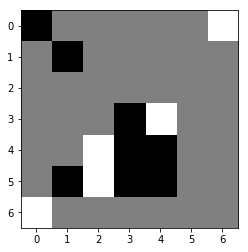

((3, 4), (5, 6)): n_v:   524 q_all:-0.059386 q:-0.058062 q_m:-0.100000 p:0.198840
((3, 4), (4, 5)): n_v:   462 q_all:-0.029496 q:-0.030227 q_m:+0.066667 p:0.105184
((4, 2), (3, 2)): n_v:   430 q_all:-0.017903 q:-0.043875 q_m:+0.066667 p:0.072655
((3, 4), (5, 5)): n_v:   381 q_all:-0.029028 q:-0.017453 q_m:+0.033333 p:0.085932
((3, 4), (1, 6)): n_v:   280 q_all:-0.056868 q:-0.060300 q_m:-0.100000 p:0.102779
((4, 2), (4, 1)): n_v:   273 q_all:-0.011988 q:-0.038893 q_m:-0.000000 p:0.037917
((3, 4), (1, 5)): n_v:   159 q_all:-0.043495 q:-0.054594 q_m:-0.100000 p:0.047476
((4, 2), (5, 0)): n_v:   151 q_all:-0.059203 q:-0.047405 q_m:-0.033333 p:0.056846
((3, 4), (2, 5)): n_v:   102 q_all:-0.054360 q:-0.051097 q_m:-0.066667 p:0.036237
((3, 4), (3, 2)): n_v:    91 q_all:-0.030059 q:-0.042988 q_m:+0.033333 p:0.021138
((6, 0), (5, 0)): n_v:    91 q_all:-0.030479 q:-0.045599 q_m:-0.000000 p:0.021368
((3, 4), (2, 2)): n_v:    89 q_all:-0.012992 q:-0.009696 q_m:+0.033333 p:0.012663
((4, 2), (2, 1))

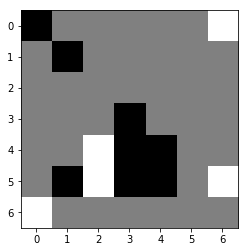

((3, 3), (4, 1)): n_v:   432 q_all:+0.093042 q:+0.073873 q_m:+0.233333 p:0.073998
((4, 4), (5, 5)): n_v:   318 q_all:+0.047348 q:+0.074429 q_m:+0.200000 p:0.151278
((3, 3), (5, 5)): n_v:   252 q_all:+0.060733 q:+0.058194 q_m:+0.166667 p:0.097424
((5, 1), (4, 1)): n_v:   224 q_all:+0.085686 q:+0.083668 q_m:+0.266667 p:0.049451
((5, 4), (6, 5)): n_v:   208 q_all:+0.063312 q:+0.082379 q_m:+0.200000 p:0.076625
((3, 3), (1, 5)): n_v:   174 q_all:+0.102630 q:+0.100566 q_m:+0.166667 p:0.018603
((4, 4), (6, 5)): n_v:   101 q_all:+0.055698 q:+0.091115 q_m:+0.166667 p:0.042256
((3, 3), (4, 5)): n_v:    76 q_all:+0.047524 q:+0.060259 q_m:+0.166667 p:0.036027
((4, 4), (4, 5)): n_v:    67 q_all:+0.035821 q:+0.059513 q_m:+0.200000 p:0.036965
((5, 1), (6, 1)): n_v:    54 q_all:+0.052845 q:+0.052249 q_m:+0.266667 p:0.023626
((4, 3), (4, 1)): n_v:    42 q_all:+0.102884 q:+0.071310 q_m:+0.233333 p:0.004545
((5, 3), (4, 1)): n_v:    41 q_all:+0.092868 q:+0.069841 q_m:+0.233333 p:0.006954
((5, 3), (6, 5))

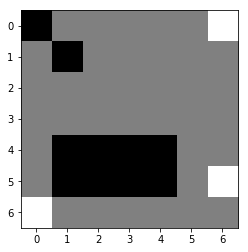

((6, 0), (6, 2)): n_v:  1132 q_all:-0.049270 q:-0.044101 q_m:-0.033333 p:0.242849
((5, 6), (5, 5)): n_v:   619 q_all:-0.112309 q:-0.038788 q_m:-0.066667 p:0.386312
((6, 0), (5, 0)): n_v:   573 q_all:-0.077470 q:-0.064349 q_m:-0.066667 p:0.227976
((0, 6), (1, 5)): n_v:    70 q_all:-0.062446 q:-0.073785 q_m:-0.200000 p:0.021292
((6, 0), (4, 0)): n_v:    46 q_all:-0.101180 q:-0.094084 q_m:-0.100000 p:0.025804
((5, 6), (6, 4)): n_v:    39 q_all:-0.080828 q:-0.077422 q_m:-0.100000 p:0.016684
((5, 6), (3, 4)): n_v:    27 q_all:-0.096712 q:-0.061643 q_m:-0.100000 p:0.014428
((6, 0), (6, 1)): n_v:    25 q_all:-0.110493 q:-0.095035 q_m:-0.066667 p:0.015580
((5, 6), (6, 5)): n_v:    17 q_all:-0.093371 q:-0.030750 q_m:-0.133333 p:0.008986
((5, 6), (4, 5)): n_v:    16 q_all:-0.115730 q:-0.042945 q_m:-0.066667 p:0.010479
((5, 6), (3, 5)): n_v:    12 q_all:-0.089377 q:-0.064540 q_m:-0.166667 p:0.006119
((5, 6), (4, 6)): n_v:    12 q_all:-0.118191 q:-0.097540 q_m:-0.200000 p:0.008466
((0, 6), (1, 6))

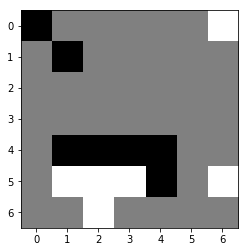

((4, 1), (6, 1)): n_v:  1545 q_all:+0.046429 q:+0.087844 q_m:+0.233333 p:0.597524
((5, 4), (6, 3)): n_v:  1058 q_all:+0.088601 q:+0.080388 q_m:+0.266667 p:0.151548
((4, 1), (6, 3)): n_v:   371 q_all:+0.065952 q:+0.067791 q_m:+0.233333 p:0.101771
((4, 4), (6, 3)): n_v:    67 q_all:+0.065765 q:+0.066003 q_m:+0.233333 p:0.018635
((5, 4), (6, 5)): n_v:    65 q_all:+0.047793 q:+0.070040 q_m:+0.133333 p:0.024864
((4, 3), (6, 3)): n_v:    43 q_all:+0.029620 q:+0.054055 q_m:+0.233333 p:0.021184
((4, 2), (6, 3)): n_v:    42 q_all:+0.044725 q:+0.058062 q_m:+0.233333 p:0.016981
((4, 3), (6, 1)): n_v:    39 q_all:+0.044342 q:+0.089139 q_m:+0.233333 p:0.015749
((4, 2), (6, 1)): n_v:    39 q_all:+0.049742 q:+0.079743 q_m:+0.233333 p:0.014468
((4, 1), (5, 0)): n_v:    17 q_all:+0.025262 q:+0.043915 q_m:+0.133333 p:0.008732
((4, 4), (6, 5)): n_v:    16 q_all:+0.042630 q:+0.075700 q_m:+0.100000 p:0.006909
((0, 0), (0, 1)): n_v:    11 q_all:+0.045154 q:+0.037221 q_m:+0.066667 p:0.004671
((4, 3), (6, 5))

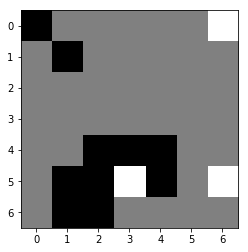

((5, 3), (6, 3)): n_v:  3203 q_all:-0.042796 q:-0.035197 q_m:-0.000000 p:0.799366
((5, 3), (4, 1)): n_v:   189 q_all:-0.045452 q:-0.081494 q_m:-0.033333 p:0.050089
((5, 6), (4, 5)): n_v:    52 q_all:-0.079826 q:-0.059247 q_m:-0.066667 p:0.023594
((5, 3), (4, 5)): n_v:    51 q_all:-0.135896 q:-0.065159 q_m:-0.100000 p:0.038947
((5, 3), (3, 3)): n_v:    39 q_all:-0.052543 q:-0.031584 q_m:-0.033333 p:0.012089
((5, 3), (3, 1)): n_v:    37 q_all:-0.086556 q:-0.082754 q_m:-0.166667 p:0.017972
((5, 3), (3, 5)): n_v:    37 q_all:-0.088508 q:-0.065765 q_m:-0.166667 p:0.017993
((5, 3), (6, 5)): n_v:    20 q_all:-0.125693 q:-0.059151 q_m:-0.166667 p:0.014296
((5, 3), (5, 5)): n_v:    14 q_all:-0.098947 q:-0.069319 q_m:-0.100000 p:0.008124
((5, 6), (5, 5)): n_v:    10 q_all:-0.060303 q:-0.058015 q_m:-0.066667 p:0.003456
((5, 6), (3, 5)): n_v:     7 q_all:-0.080269 q:-0.073164 q_m:-0.166667 p:0.003470
((5, 3), (3, 2)): n_v:     5 q_all:-0.081859 q:-0.075764 q_m:-0.100000 p:0.002641
((5, 3), (3, 4))

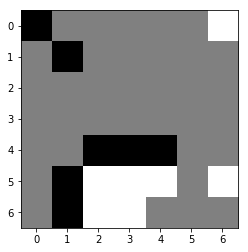

((4, 4), (6, 4)): n_v:  3558 q_all:+0.056319 q:+0.044431 q_m:+0.200000 p:0.652962
((4, 2), (6, 4)): n_v:   500 q_all:+0.051213 q:+0.043758 q_m:+0.200000 p:0.103631
((4, 3), (6, 4)): n_v:   264 q_all:+0.022550 q:+0.020330 q_m:+0.200000 p:0.089331
((4, 4), (5, 5)): n_v:   156 q_all:+0.053952 q:+0.039103 q_m:+0.166667 p:0.030332
((4, 3), (5, 5)): n_v:   101 q_all:+0.039911 q:+0.031140 q_m:+0.133333 p:0.026236
((4, 4), (6, 6)): n_v:    44 q_all:+0.026256 q:+0.026133 q_m:+0.066667 p:0.014340
((4, 2), (6, 0)): n_v:    39 q_all:-0.019614 q:-0.018178 q_m:-0.000000 p:0.021062
((4, 3), (6, 5)): n_v:    25 q_all:+0.035196 q:+0.044210 q_m:+0.133333 p:0.007248
((4, 4), (6, 5)): n_v:    24 q_all:+0.054664 q:+0.067903 q_m:+0.133333 p:0.004722
((5, 1), (6, 0)): n_v:    16 q_all:-0.010315 q:-0.013345 q_m:+0.033333 p:0.007898
((4, 2), (4, 1)): n_v:    16 q_all:+0.034057 q:+0.029291 q_m:+0.100000 p:0.004775
((4, 4), (4, 5)): n_v:    11 q_all:+0.036816 q:+0.039061 q_m:+0.166667 p:0.003117
((4, 3), (4, 1))

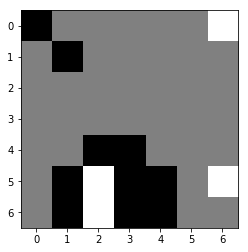

((5, 2), (4, 1)): n_v:  1258 q_all:-0.043829 q:-0.076972 q_m:-0.033333 p:0.143855
((5, 6), (5, 5)): n_v:  1225 q_all:-0.076234 q:-0.031578 q_m:-0.033333 p:0.317059
((6, 2), (4, 4)): n_v:   856 q_all:-0.065524 q:-0.046225 q_m:-0.000000 p:0.180936
((5, 6), (4, 4)): n_v:   702 q_all:-0.052278 q:-0.051648 q_m:-0.000000 p:0.106851
((5, 6), (4, 5)): n_v:   441 q_all:-0.075008 q:-0.064553 q_m:-0.100000 p:0.112031
((5, 6), (6, 5)): n_v:   165 q_all:-0.069553 q:-0.020415 q_m:-0.033333 p:0.037365
((6, 2), (5, 0)): n_v:    67 q_all:-0.074300 q:-0.048448 q_m:-0.066667 p:0.017032
((0, 6), (1, 5)): n_v:    51 q_all:-0.058627 q:-0.064738 q_m:-0.166667 p:0.009361
((5, 2), (5, 0)): n_v:    46 q_all:-0.083068 q:-0.055601 q_m:-0.066667 p:0.013606
((5, 2), (4, 4)): n_v:    42 q_all:-0.072902 q:-0.035969 q_m:-0.000000 p:0.010499
((6, 2), (4, 1)): n_v:    32 q_all:-0.082521 q:-0.075598 q_m:-0.066667 p:0.009389
((5, 6), (6, 6)): n_v:    31 q_all:-0.097385 q:-0.100769 q_m:-0.166667 p:0.010942
((5, 2), (6, 0))

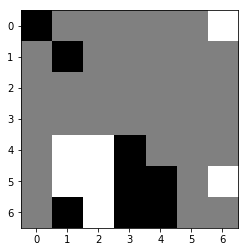

((6, 1), (5, 0)): n_v:  2043 q_all:+0.020616 q:+0.054878 q_m:+0.200000 p:0.731910
((4, 3), (3, 2)): n_v:   621 q_all:+0.057774 q:+0.017303 q_m:+0.200000 p:0.087958
((5, 4), (5, 5)): n_v:   138 q_all:+0.055315 q:+0.033549 q_m:+0.133333 p:0.021574
((4, 3), (3, 4)): n_v:   122 q_all:+0.008290 q:+0.011377 q_m:+0.066667 p:0.052676
((5, 4), (4, 5)): n_v:    31 q_all:+0.056781 q:+0.026499 q_m:+0.133333 p:0.004666
((0, 0), (1, 0)): n_v:    22 q_all:+0.015996 q:-0.001766 q_m:+0.066667 p:0.008645
((4, 3), (5, 5)): n_v:    18 q_all:+0.036163 q:+0.021271 q_m:+0.100000 p:0.005065
((4, 3), (6, 5)): n_v:    17 q_all:+0.046829 q:+0.043112 q_m:+0.100000 p:0.003481
((1, 1), (3, 2)): n_v:    15 q_all:+0.030960 q:-0.010050 q_m:+0.166667 p:0.004590
((5, 4), (6, 5)): n_v:    12 q_all:+0.066799 q:+0.056807 q_m:+0.133333 p:0.001110
((4, 3), (3, 3)): n_v:    10 q_all:+0.017035 q:+0.016253 q_m:+0.133333 p:0.003771
((1, 1), (3, 1)): n_v:    10 q_all:+0.042963 q:+0.023260 q_m:+0.166667 p:0.002182
((4, 3), (3, 1))

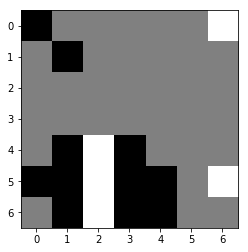

((4, 2), (6, 0)): n_v:  3310 q_all:-0.005067 q:-0.028026 q_m:-0.000000 p:0.671257
((6, 2), (4, 0)): n_v:   491 q_all:-0.046352 q:-0.055093 q_m:-0.000000 p:0.202828
((5, 6), (6, 6)): n_v:    54 q_all:-0.112524 q:-0.118453 q_m:-0.166667 p:0.040895
((4, 2), (4, 0)): n_v:    26 q_all:-0.041320 q:-0.066467 q_m:-0.000000 p:0.010038
((4, 2), (2, 0)): n_v:    24 q_all:-0.045759 q:-0.051446 q_m:-0.133333 p:0.010182
((5, 2), (4, 0)): n_v:    21 q_all:-0.080857 q:-0.076607 q_m:-0.000000 p:0.012843
((5, 6), (4, 6)): n_v:    17 q_all:-0.105095 q:-0.107448 q_m:-0.166667 p:0.012649
((5, 6), (5, 5)): n_v:    13 q_all:-0.092465 q:-0.042666 q_m:-0.033333 p:0.008568
((5, 2), (6, 0)): n_v:    13 q_all:-0.100108 q:-0.073176 q_m:-0.000000 p:0.009600
((6, 2), (6, 0)): n_v:    11 q_all:-0.053653 q:-0.024529 q_m:-0.000000 p:0.005137
((4, 2), (4, 4)): n_v:     7 q_all:-0.087045 q:-0.060471 q_m:-0.000000 p:0.004450
((5, 6), (6, 5)): n_v:     4 q_all:-0.076212 q:-0.028066 q_m:-0.033333 p:0.002653
((4, 2), (3, 2))

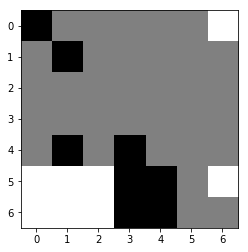

((4, 1), (4, 0)): n_v:  1864 q_all:+0.011077 q:+0.018387 q_m:+0.166667 p:0.111918
((4, 1), (4, 2)): n_v:  1536 q_all:-0.002357 q:-0.014632 q_m:+0.166667 p:0.186860
((4, 3), (6, 5)): n_v:   713 q_all:+0.022710 q:+0.004602 q_m:+0.066667 p:0.004950
((4, 3), (4, 4)): n_v:   240 q_all:-0.066925 q:-0.049210 q_m:+0.033333 p:0.100422
((4, 3), (5, 5)): n_v:   158 q_all:+0.003310 q:-0.023376 q_m:+0.066667 p:0.015163
((4, 3), (4, 5)): n_v:   132 q_all:+0.000791 q:-0.014677 q_m:+0.066667 p:0.014231
((1, 1), (2, 2)): n_v:    51 q_all:-0.046141 q:-0.040233 q_m:+0.033333 p:0.016546
((5, 4), (5, 5)): n_v:    25 q_all:-0.037286 q:-0.026457 q_m:+0.100000 p:0.007247
((1, 1), (2, 0)): n_v:    19 q_all:-0.051480 q:-0.035827 q_m:+0.033333 p:0.006867
((6, 4), (4, 6)): n_v:    18 q_all:-0.032431 q:-0.011332 q_m:+0.066667 p:0.004630
((5, 4), (4, 5)): n_v:    12 q_all:-0.040717 q:-0.027060 q_m:+0.100000 p:0.003821
((5, 4), (4, 6)): n_v:    10 q_all:-0.016293 q:-0.003444 q_m:+0.066667 p:0.002033
((5, 4), (4, 2))

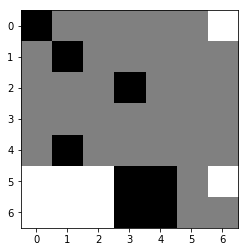

((5, 1), (4, 2)): n_v:  1014 q_all:+0.031711 q:+0.039870 q_m:+0.166667 p:0.310781
((5, 2), (4, 3)): n_v:   300 q_all:+0.020775 q:-0.001618 q_m:+0.166667 p:0.116519
((5, 6), (5, 5)): n_v:   138 q_all:+0.015550 q:+0.020118 q_m:+0.166667 p:0.059264
((5, 6), (4, 4)): n_v:    97 q_all:+0.002745 q:+0.002399 q_m:+0.133333 p:0.050672
((5, 0), (4, 2)): n_v:    94 q_all:-0.026072 q:-0.028210 q_m:+0.133333 p:0.069295
((6, 0), (4, 2)): n_v:    72 q_all:-0.006399 q:+0.005868 q_m:+0.133333 p:0.043096
((5, 0), (4, 0)): n_v:    59 q_all:+0.040837 q:+0.041409 q_m:+0.100000 p:0.014105
((0, 6), (1, 5)): n_v:    28 q_all:-0.005893 q:-0.015901 q_m:+0.033333 p:0.016675
((5, 6), (3, 4)): n_v:    25 q_all:-0.006380 q:+0.009096 q_m:+0.066667 p:0.014412
((5, 0), (3, 2)): n_v:    23 q_all:+0.015400 q:+0.014859 q_m:+0.133333 p:0.009867
((6, 1), (4, 2)): n_v:    19 q_all:-0.001929 q:-0.021979 q_m:+0.133333 p:0.011004
((6, 0), (4, 0)): n_v:    15 q_all:+0.012385 q:-0.004362 q_m:+0.066667 p:0.007004
((5, 6), (6, 5))

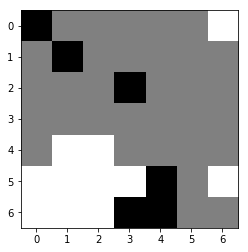

((5, 4), (4, 3)): n_v:  2823 q_all:-0.033113 q:-0.023995 q_m:+0.066667 p:0.859455
((2, 3), (4, 3)): n_v:   298 q_all:-0.026670 q:-0.031255 q_m:+0.033333 p:0.079609
((2, 3), (3, 2)): n_v:    18 q_all:-0.062547 q:-0.070202 q_m:-0.000000 p:0.008802
((2, 3), (3, 1)): n_v:    17 q_all:-0.055813 q:-0.060523 q_m:-0.033333 p:0.007780
((6, 4), (4, 3)): n_v:    11 q_all:-0.039207 q:-0.036994 q_m:+0.033333 p:0.003747
((2, 3), (4, 5)): n_v:     9 q_all:-0.084118 q:-0.098508 q_m:-0.100000 p:0.005617
((6, 3), (4, 3)): n_v:     9 q_all:-0.087574 q:-0.044796 q_m:+0.033333 p:0.006072
((2, 3), (3, 4)): n_v:     7 q_all:-0.082063 q:-0.099790 q_m:-0.133333 p:0.004461
((2, 3), (3, 5)): n_v:     5 q_all:-0.125517 q:-0.113847 q_m:-0.166667 p:0.004468
((2, 3), (1, 5)): n_v:     5 q_all:-0.068377 q:-0.095047 q_m:-0.100000 p:0.003020
((5, 4), (4, 5)): n_v:     3 q_all:-0.047396 q:-0.086230 q_m:-0.066667 p:0.001325
((5, 4), (5, 5)): n_v:     3 q_all:-0.074017 q:-0.115823 q_m:-0.066667 p:0.001866
((2, 3), (4, 4))

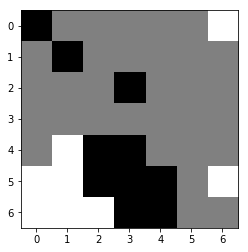

((4, 1), (3, 2)): n_v:  3932 q_all:+0.037916 q:+0.031928 q_m:+0.166667 p:0.713652
((5, 6), (5, 5)): n_v:   213 q_all:-0.002317 q:+0.041453 q_m:+0.100000 p:0.079973
((5, 6), (4, 4)): n_v:   204 q_all:+0.029341 q:+0.017431 q_m:+0.133333 p:0.045288
((4, 1), (2, 2)): n_v:    91 q_all:+0.030527 q:+0.009896 q_m:+0.066667 p:0.019778
((5, 6), (3, 4)): n_v:    75 q_all:+0.017293 q:-0.004087 q_m:+0.066667 p:0.021245
((5, 6), (6, 5)): n_v:    71 q_all:+0.013138 q:+0.058943 q_m:+0.100000 p:0.020938
((6, 2), (4, 4)): n_v:    50 q_all:-0.035989 q:+0.004176 q_m:+0.133333 p:0.027043
((4, 1), (3, 3)): n_v:    42 q_all:+0.021151 q:+0.000148 q_m:+0.133333 p:0.011170
((5, 0), (3, 2)): n_v:    37 q_all:+0.002748 q:-0.026077 q_m:+0.133333 p:0.013181
((4, 1), (3, 1)): n_v:    29 q_all:+0.012802 q:-0.005296 q_m:+0.033333 p:0.008629
((0, 6), (2, 4)): n_v:    25 q_all:+0.024301 q:-0.004451 q_m:-0.000000 p:0.006073
((5, 6), (4, 5)): n_v:    18 q_all:-0.007275 q:+0.007143 q_m:+0.033333 p:0.007282
((0, 6), (1, 5))

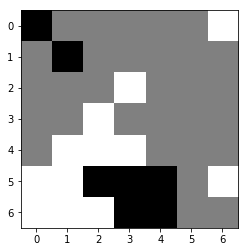

((1, 1), (3, 3)): n_v:  3248 q_all:-0.040832 q:-0.031118 q_m:+0.100000 p:0.521569
((1, 1), (3, 1)): n_v:   965 q_all:-0.038939 q:-0.064490 q_m:+0.033333 p:0.147103
((5, 4), (3, 3)): n_v:   348 q_all:-0.048360 q:-0.039797 q_m:+0.100000 p:0.067038
((5, 3), (3, 3)): n_v:   265 q_all:-0.085310 q:-0.049785 q_m:+0.100000 p:0.093571
((5, 2), (3, 3)): n_v:   195 q_all:-0.052895 q:-0.048030 q_m:+0.100000 p:0.041632
((5, 3), (4, 4)): n_v:    64 q_all:-0.090060 q:-0.089908 q_m:-0.066667 p:0.024178
((5, 3), (3, 1)): n_v:    32 q_all:-0.115445 q:-0.087761 q_m:+0.033333 p:0.015386
((5, 2), (3, 1)): n_v:    32 q_all:-0.103356 q:-0.102950 q_m:+0.033333 p:0.013920
((1, 1), (2, 2)): n_v:    29 q_all:-0.050319 q:-0.058071 q_m:-0.000000 p:0.005771
((5, 4), (3, 5)): n_v:    28 q_all:-0.122419 q:-0.118669 q_m:-0.166667 p:0.014785
((5, 3), (3, 5)): n_v:    24 q_all:-0.137058 q:-0.102643 q_m:-0.166667 p:0.013864
((6, 4), (4, 6)): n_v:     6 q_all:-0.074942 q:-0.083178 q_m:-0.100000 p:0.002155
((1, 1), (2, 0))

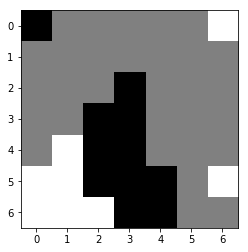

((4, 1), (2, 2)): n_v:  1935 q_all:+0.039322 q:+0.019267 q_m:+0.100000 p:0.489133
((4, 1), (3, 1)): n_v:  1519 q_all:+0.063124 q:+0.033241 q_m:+0.066667 p:0.217714
((5, 6), (4, 4)): n_v:   435 q_all:+0.031061 q:+0.039408 q_m:+0.166667 p:0.126705
((6, 2), (4, 4)): n_v:   146 q_all:-0.016178 q:+0.012707 q_m:+0.166667 p:0.074211
((0, 6), (2, 4)): n_v:   111 q_all:+0.002866 q:+0.015995 q_m:+0.033333 p:0.046750
((5, 6), (5, 5)): n_v:    61 q_all:+0.025854 q:+0.050098 q_m:+0.066667 p:0.019472
((5, 6), (6, 5)): n_v:    15 q_all:+0.037004 q:+0.068149 q_m:+0.066667 p:0.004156
((5, 6), (3, 4)): n_v:    10 q_all:+0.003281 q:+0.013597 q_m:+0.100000 p:0.004349
((5, 0), (3, 1)): n_v:     9 q_all:+0.027093 q:-0.003952 q_m:+0.033333 p:0.003072
((5, 6), (4, 5)): n_v:     4 q_all:-0.010763 q:+0.001544 q_m:-0.000000 p:0.002338
((5, 6), (3, 5)): n_v:     4 q_all:-0.046962 q:-0.024650 q_m:-0.100000 p:0.002435
((0, 6), (1, 5)): n_v:     4 q_all:-0.035135 q:-0.007730 q_m:-0.066667 p:0.002410
((5, 6), (6, 6))

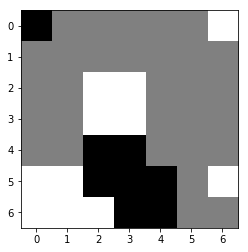

((4, 2), (4, 1)): n_v:  1567 q_all:-0.038272 q:-0.054555 q_m:+0.133333 p:0.209693
((4, 2), (2, 1)): n_v:   491 q_all:-0.060202 q:-0.084262 q_m:+0.033333 p:0.123097
((5, 4), (4, 5)): n_v:   451 q_all:-0.072815 q:-0.069572 q_m:-0.000000 p:0.143344
((4, 3), (2, 1)): n_v:   156 q_all:-0.082362 q:-0.080867 q_m:+0.033333 p:0.057759
((4, 3), (3, 4)): n_v:   135 q_all:-0.067420 q:-0.048967 q_m:+0.066667 p:0.039107
((0, 0), (2, 1)): n_v:   125 q_all:-0.057670 q:-0.088055 q_m:+0.033333 p:0.029314
((4, 2), (3, 1)): n_v:    79 q_all:-0.057433 q:-0.092418 q_m:+0.066667 p:0.018785
((0, 0), (1, 1)): n_v:    73 q_all:-0.048789 q:-0.045644 q_m:-0.000000 p:0.013999
((5, 4), (5, 5)): n_v:    50 q_all:-0.067639 q:-0.061000 q_m:-0.000000 p:0.014415
((4, 3), (2, 4)): n_v:    37 q_all:-0.081233 q:-0.042483 q_m:+0.033333 p:0.013036
((4, 3), (2, 5)): n_v:    35 q_all:-0.131438 q:-0.087298 q_m:-0.100000 p:0.022397
((0, 0), (1, 2)): n_v:    22 q_all:-0.060610 q:-0.057369 q_m:+0.033333 p:0.005540
((6, 4), (4, 5))

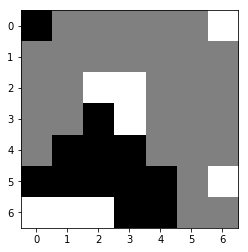

((2, 2), (3, 1)): n_v:  1858 q_all:+0.034598 q:-0.008846 q_m:+0.100000 p:0.637474
((2, 2), (4, 0)): n_v:  1237 q_all:+0.069682 q:+0.045765 q_m:+0.066667 p:0.182306
((6, 0), (4, 0)): n_v:    75 q_all:-0.001571 q:-0.013661 q_m:+0.066667 p:0.040863
((3, 3), (4, 4)): n_v:    60 q_all:+0.028999 q:+0.033897 q_m:+0.100000 p:0.022574
((5, 6), (4, 6)): n_v:    48 q_all:-0.022176 q:-0.042256 q_m:-0.100000 p:0.032159
((6, 2), (4, 0)): n_v:    47 q_all:-0.009503 q:-0.006115 q_m:+0.066667 p:0.028015
((2, 3), (4, 4)): n_v:    16 q_all:+0.017228 q:+0.031046 q_m:+0.066667 p:0.007127
((5, 6), (5, 5)): n_v:    13 q_all:+0.005735 q:+0.036130 q_m:+0.033333 p:0.006406
((2, 3), (3, 1)): n_v:    11 q_all:+0.018288 q:-0.016236 q_m:+0.066667 p:0.004947
((3, 3), (5, 5)): n_v:     9 q_all:-0.010567 q:+0.027770 q_m:-0.000000 p:0.005309
((5, 6), (6, 5)): n_v:     5 q_all:+0.030581 q:+0.050428 q_m:+0.033333 p:0.002004
((3, 3), (3, 1)): n_v:     5 q_all:-0.008701 q:-0.023685 q_m:+0.066667 p:0.003022
((2, 2), (2, 0))

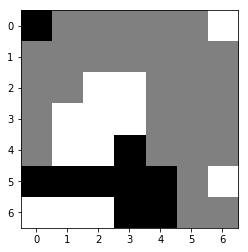

((0, 0), (2, 1)): n_v:  2178 q_all:-0.042381 q:-0.044588 q_m:+0.100000 p:0.422366
((5, 0), (4, 0)): n_v:   630 q_all:-0.045542 q:-0.031748 q_m:+0.066667 p:0.132906
((4, 3), (3, 4)): n_v:   210 q_all:-0.055201 q:-0.030564 q_m:+0.066667 p:0.055375
((4, 3), (2, 1)): n_v:   194 q_all:-0.052903 q:-0.033927 q_m:+0.100000 p:0.048608
((4, 3), (2, 5)): n_v:    73 q_all:-0.093560 q:-0.063823 q_m:-0.100000 p:0.033775
((4, 3), (2, 4)): n_v:    64 q_all:-0.057548 q:-0.028217 q_m:+0.033333 p:0.017653
((0, 0), (2, 0)): n_v:    63 q_all:-0.108321 q:-0.091285 q_m:-0.033333 p:0.033858
((5, 4), (4, 5)): n_v:    43 q_all:-0.085435 q:-0.044759 q_m:-0.000000 p:0.018461
((0, 0), (1, 1)): n_v:    19 q_all:-0.058533 q:-0.041342 q_m:-0.000000 p:0.005502
((5, 0), (3, 0)): n_v:    14 q_all:-0.046746 q:-0.087825 q_m:+0.033333 p:0.003247
((0, 0), (1, 2)): n_v:    14 q_all:-0.057696 q:-0.045037 q_m:+0.033333 p:0.004099
((5, 4), (5, 5)): n_v:    14 q_all:-0.079578 q:-0.039754 q_m:-0.000000 p:0.005837
((4, 3), (4, 4))

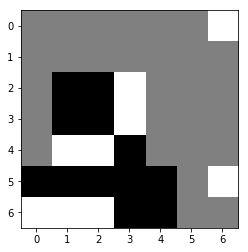

((4, 1), (4, 0)): n_v:  1281 q_all:+0.057641 q:+0.105578 q_m:+0.133333 p:0.205681
((4, 1), (2, 0)): n_v:   993 q_all:+0.039238 q:-0.002935 q_m:+0.033333 p:0.254015
((6, 2), (4, 0)): n_v:   336 q_all:+0.078764 q:+0.049527 q_m:+0.100000 p:0.016982
((5, 6), (4, 6)): n_v:   312 q_all:-0.004047 q:-0.003359 q_m:-0.066667 p:0.149068
((3, 3), (4, 4)): n_v:   218 q_all:+0.035597 q:+0.034161 q_m:+0.133333 p:0.060083
((4, 2), (2, 0)): n_v:   208 q_all:+0.031169 q:-0.056762 q_m:+0.033333 p:0.062059
((2, 3), (1, 4)): n_v:   129 q_all:+0.003047 q:-0.013611 q_m:-0.066667 p:0.056843
((2, 3), (1, 2)): n_v:   122 q_all:+0.021287 q:+0.021090 q_m:+0.066667 p:0.042403
((3, 3), (1, 2)): n_v:    31 q_all:+0.011432 q:+0.012657 q_m:+0.033333 p:0.012479
((5, 6), (6, 5)): n_v:    29 q_all:+0.027408 q:+0.070146 q_m:+0.066667 p:0.009446
((2, 3), (4, 4)): n_v:    29 q_all:+0.038140 q:+0.039960 q_m:+0.100000 p:0.007632
((4, 1), (3, 0)): n_v:    25 q_all:-0.022273 q:-0.032707 q_m:+0.066667 p:0.014301
((5, 6), (5, 5))

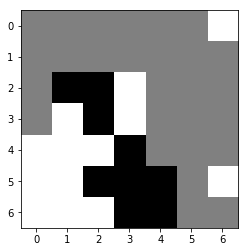

((2, 1), (3, 0)): n_v:  2649 q_all:-0.035614 q:-0.047142 q_m:+0.100000 p:0.680458
((2, 2), (3, 0)): n_v:   528 q_all:-0.072187 q:-0.075916 q_m:+0.066667 p:0.245092
((3, 2), (3, 0)): n_v:    51 q_all:-0.135940 q:-0.103528 q_m:+0.066667 p:0.042352
((5, 2), (3, 0)): n_v:    20 q_all:-0.143000 q:-0.122273 q_m:+0.066667 p:0.017310
((5, 4), (3, 6)): n_v:    17 q_all:-0.115255 q:-0.199536 q_m:-0.133333 p:0.012347
((4, 3), (3, 4)): n_v:     1 q_all:-0.098911 q:-0.142889 q_m:+0.033333 p:0.000955
((6, 3), (4, 4)): n_v:     0 q_all:-0.197101 q:-0.197101 q_m:-0.066667 p:0.000002
((5, 4), (6, 5)): n_v:     0 q_all:-0.113635 q:-0.113635 q_m:-0.033333 p:0.000004
((5, 4), (4, 5)): n_v:     0 q_all:-0.146990 q:-0.146990 q_m:-0.033333 p:0.000060
((2, 2), (2, 4)): n_v:     0 q_all:-0.161717 q:-0.161717 q_m:-0.000000 p:0.000013
((3, 2), (4, 4)): n_v:     0 q_all:-0.154342 q:-0.154342 q_m:-0.066667 p:0.000028
((5, 3), (5, 5)): n_v:     0 q_all:-0.212852 q:-0.212852 q_m:-0.066667 p:0.000000
((3, 2), (1, 2))

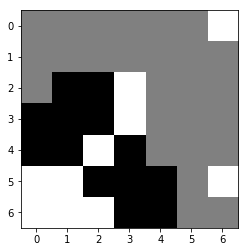

((2, 3), (1, 2)): n_v:   876 q_all:+0.068280 q:+0.038553 q_m:+0.066667 p:0.079026
((3, 3), (4, 4)): n_v:   740 q_all:+0.051700 q:+0.049136 q_m:+0.133333 p:0.126731
((4, 2), (2, 0)): n_v:   514 q_all:+0.045326 q:+0.019774 q_m:+0.100000 p:0.103788
((2, 3), (1, 1)): n_v:   327 q_all:+0.063949 q:+0.052383 q_m:+0.033333 p:0.036482
((2, 3), (1, 4)): n_v:   272 q_all:+0.019511 q:-0.003068 q_m:-0.066667 p:0.089753
((3, 3), (5, 5)): n_v:   237 q_all:+0.009332 q:+0.052669 q_m:+0.033333 p:0.089930
((5, 6), (6, 5)): n_v:   229 q_all:+0.051225 q:+0.077778 q_m:+0.066667 p:0.039732
((5, 6), (4, 6)): n_v:   218 q_all:+0.015653 q:+0.006616 q_m:-0.066667 p:0.075843
((5, 6), (5, 5)): n_v:   162 q_all:+0.038660 q:+0.070808 q_m:+0.066667 p:0.038265
((2, 3), (1, 5)): n_v:   117 q_all:+0.029807 q:+0.001916 q_m:-0.100000 p:0.032634
((2, 3), (4, 4)): n_v:    83 q_all:+0.047646 q:+0.046134 q_m:+0.100000 p:0.015966
((3, 3), (1, 2)): n_v:    77 q_all:+0.004356 q:+0.038922 q_m:+0.033333 p:0.031227
((3, 3), (1, 1))

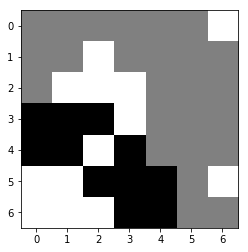

((3, 0), (1, 1)): n_v:  2415 q_all:-0.067747 q:-0.063088 q_m:+0.133333 p:0.610909
((3, 2), (1, 1)): n_v:   188 q_all:-0.121972 q:-0.096942 q_m:+0.133333 p:0.108978
((4, 3), (3, 4)): n_v:   128 q_all:-0.080309 q:-0.069892 q_m:+0.100000 p:0.042260
((5, 4), (5, 5)): n_v:   122 q_all:-0.085788 q:-0.098633 q_m:+0.033333 p:0.044169
((3, 1), (1, 1)): n_v:    54 q_all:-0.211505 q:-0.146975 q_m:+0.133333 p:0.061251
((3, 0), (2, 0)): n_v:    28 q_all:-0.073745 q:-0.074517 q_m:+0.033333 p:0.008282
((3, 2), (1, 3)): n_v:    27 q_all:-0.114372 q:-0.087413 q_m:+0.133333 p:0.014799
((5, 4), (3, 4)): n_v:    12 q_all:-0.090861 q:-0.089189 q_m:+0.066667 p:0.004987
((4, 3), (5, 5)): n_v:    10 q_all:-0.112958 q:-0.113723 q_m:-0.000000 p:0.005380
((3, 1), (1, 3)): n_v:     9 q_all:-0.207019 q:-0.187146 q_m:+0.133333 p:0.010715
((5, 4), (4, 5)): n_v:     7 q_all:-0.077339 q:-0.093300 q_m:+0.033333 p:0.002329
((6, 3), (5, 5)): n_v:     7 q_all:-0.155396 q:-0.132170 q_m:-0.000000 p:0.005392
((4, 3), (2, 4))

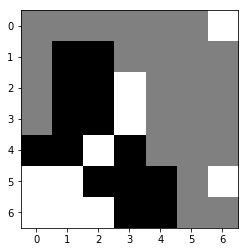

((2, 3), (1, 3)): n_v:  2330 q_all:+0.099560 q:+0.062645 q_m:+0.033333 p:0.300697
((2, 3), (0, 2)): n_v:   402 q_all:+0.063782 q:+0.046302 q_m:-0.000000 p:0.124090
((3, 3), (4, 4)): n_v:   323 q_all:+0.063133 q:+0.055960 q_m:+0.100000 p:0.100822
((2, 3), (0, 1)): n_v:   140 q_all:+0.075137 q:+0.065029 q_m:-0.000000 p:0.035382
((5, 6), (5, 5)): n_v:   118 q_all:+0.042591 q:+0.072901 q_m:+0.033333 p:0.049052
((5, 6), (6, 5)): n_v:   109 q_all:+0.052960 q:+0.079883 q_m:+0.033333 p:0.039423
((4, 2), (2, 0)): n_v:    91 q_all:+0.071615 q:-0.032659 q_m:+0.066667 p:0.024549
((3, 3), (5, 5)): n_v:    80 q_all:+0.020578 q:+0.074928 q_m:-0.000000 p:0.042031
((2, 3), (0, 4)): n_v:    73 q_all:+0.041605 q:+0.011899 q_m:-0.133333 p:0.030813
((3, 3), (1, 3)): n_v:    66 q_all:+0.042620 q:+0.040995 q_m:-0.000000 p:0.027652
((2, 3), (4, 4)): n_v:    57 q_all:+0.054524 q:+0.058304 q_m:+0.066667 p:0.020404
((2, 3), (0, 5)): n_v:    51 q_all:+0.037998 q:+0.017661 q_m:-0.133333 p:0.022630
((5, 6), (6, 6))

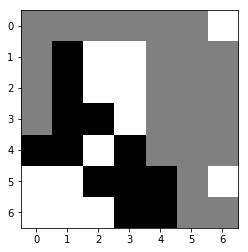

((1, 1), (0, 2)): n_v:  2342 q_all:-0.106448 q:-0.083777 q_m:+0.133333 p:0.302626
((4, 3), (2, 4)): n_v:   454 q_all:-0.118944 q:-0.077133 q_m:+0.166667 p:0.086729
((4, 3), (3, 4)): n_v:   300 q_all:-0.119147 q:-0.100864 q_m:+0.133333 p:0.058145
((4, 3), (4, 4)): n_v:   295 q_all:-0.144593 q:-0.142354 q_m:+0.066667 p:0.095187
((2, 1), (0, 2)): n_v:   127 q_all:-0.125553 q:-0.102927 q_m:+0.100000 p:0.028704
((3, 2), (2, 4)): n_v:   108 q_all:-0.118682 q:-0.114231 q_m:+0.166667 p:0.020643
((3, 2), (1, 4)): n_v:    92 q_all:-0.121703 q:-0.122851 q_m:+0.100000 p:0.018918
((5, 4), (5, 5)): n_v:    55 q_all:-0.119430 q:-0.119758 q_m:+0.066667 p:0.010768
((2, 1), (0, 3)): n_v:    51 q_all:-0.140288 q:-0.123594 q_m:+0.100000 p:0.015415
((3, 2), (4, 4)): n_v:    48 q_all:-0.153629 q:-0.149503 q_m:+0.033333 p:0.017555
((2, 1), (3, 0)): n_v:    45 q_all:-0.140241 q:-0.120469 q_m:-0.000000 p:0.013724
((1, 1), (0, 1)): n_v:    40 q_all:-0.125415 q:-0.106669 q_m:+0.066667 p:0.008994
((5, 4), (3, 4))

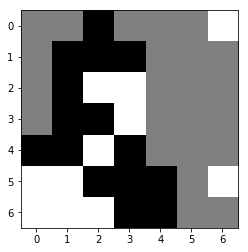

((2, 2), (3, 0)): n_v:  2157 q_all:+0.126505 q:+0.130028 q_m:+0.133333 p:0.284746
((2, 2), (0, 1)): n_v:   462 q_all:+0.068852 q:+0.051177 q_m:+0.066667 p:0.195376
((5, 6), (6, 5)): n_v:   376 q_all:+0.088738 q:+0.115067 q_m:+0.033333 p:0.121659
((2, 3), (0, 3)): n_v:   231 q_all:+0.049061 q:+0.060186 q_m:+0.066667 p:0.121184
((2, 3), (0, 1)): n_v:   150 q_all:+0.108069 q:+0.065435 q_m:+0.066667 p:0.033794
((4, 2), (3, 0)): n_v:   148 q_all:+0.085114 q:+0.054950 q_m:+0.133333 p:0.050640
((2, 2), (0, 3)): n_v:    68 q_all:+0.044270 q:+0.048654 q_m:+0.066667 p:0.037432
((0, 6), (0, 5)): n_v:    45 q_all:+0.065776 q:+0.048585 q_m:-0.100000 p:0.019956
((2, 3), (0, 5)): n_v:    43 q_all:+0.014390 q:+0.039934 q_m:-0.133333 p:0.030008
((2, 2), (0, 0)): n_v:    36 q_all:+0.046397 q:+0.030639 q_m:-0.066667 p:0.019460
((4, 2), (2, 0)): n_v:    34 q_all:+0.094461 q:-0.035177 q_m:+0.066667 p:0.010213
((5, 6), (5, 5)): n_v:    31 q_all:+0.073990 q:+0.110290 q_m:+0.033333 p:0.012062
((5, 6), (6, 6))

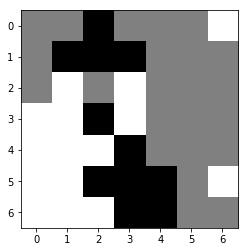

((1, 1), (2, 2)): n_v:  1993 q_all:-0.100658 q:-0.130029 q_m:+0.166667 p:0.124060
((3, 2), (2, 0)): n_v:  1081 q_all:-0.099220 q:-0.157597 q_m:+0.066667 p:0.058663
((1, 2), (2, 0)): n_v:   234 q_all:-0.145145 q:-0.163353 q_m:+0.066667 p:0.068584
((4, 3), (2, 2)): n_v:   231 q_all:-0.166987 q:-0.141710 q_m:+0.133333 p:0.093382
((4, 3), (2, 4)): n_v:    68 q_all:-0.242033 q:-0.216704 q_m:-0.000000 p:0.054603
((1, 1), (2, 0)): n_v:    55 q_all:-0.173378 q:-0.147041 q_m:+0.100000 p:0.023846
((0, 2), (2, 2)): n_v:    48 q_all:-0.158786 q:-0.151631 q_m:+0.133333 p:0.017557
((1, 3), (2, 4)): n_v:    35 q_all:-0.242355 q:-0.205035 q_m:+0.033333 p:0.027852
((0, 2), (2, 0)): n_v:    29 q_all:-0.194851 q:-0.170407 q_m:+0.066667 p:0.015671
((3, 2), (2, 4)): n_v:    23 q_all:-0.177399 q:-0.194371 q_m:-0.000000 p:0.010135
((3, 2), (4, 4)): n_v:    20 q_all:-0.235149 q:-0.236052 q_m:-0.066667 p:0.015080
((4, 3), (4, 4)): n_v:    18 q_all:-0.264555 q:-0.255506 q_m:-0.033333 p:0.016852
((3, 2), (1, 0))

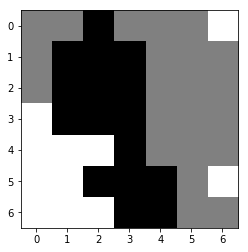

((3, 0), (2, 0)): n_v:  2076 q_all:+0.100699 q:+0.195067 q_m:+0.066667 p:0.699385
((5, 6), (4, 4)): n_v:   976 q_all:+0.160324 q:+0.120205 q_m:+0.100000 p:0.029123
((0, 6), (2, 4)): n_v:   361 q_all:+0.128371 q:+0.128984 q_m:+0.033333 p:0.069843
((5, 6), (6, 5)): n_v:   169 q_all:+0.146397 q:+0.127461 q_m:-0.000000 p:0.017706
((5, 6), (4, 6)): n_v:   147 q_all:+0.043770 q:+0.055386 q_m:-0.133333 p:0.093113
((5, 6), (5, 5)): n_v:    68 q_all:+0.122391 q:+0.124636 q_m:-0.000000 p:0.015399
((4, 2), (2, 0)): n_v:    61 q_all:+0.092123 q:+0.045977 q_m:+0.033333 p:0.023264
((5, 6), (4, 5)): n_v:    18 q_all:+0.088561 q:+0.062642 q_m:-0.066667 p:0.007359
((4, 2), (2, 4)): n_v:    14 q_all:+0.065613 q:+0.054369 q_m:+0.033333 p:0.007752
((3, 0), (1, 0)): n_v:    10 q_all:+0.079880 q:+0.047114 q_m:-0.033333 p:0.004307
((0, 6), (2, 6)): n_v:     7 q_all:-0.003373 q:+0.056549 q_m:-0.166667 p:0.006364
((6, 2), (4, 4)): n_v:     7 q_all:+0.056998 q:+0.046498 q_m:+0.100000 p:0.004454
((5, 6), (6, 6))

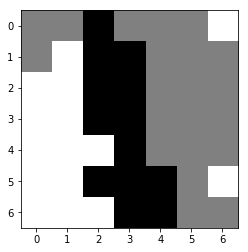

((0, 2), (1, 0)): n_v:  3920 q_all:-0.088893 q:-0.081995 q_m:+0.133333 p:0.843010
((1, 2), (1, 0)): n_v:   293 q_all:-0.143911 q:-0.176082 q_m:+0.133333 p:0.145600
((3, 2), (1, 0)): n_v:     5 q_all:-0.195063 q:-0.136859 q_m:+0.133333 p:0.003967
((2, 2), (1, 0)): n_v:     3 q_all:-0.253723 q:-0.183467 q_m:+0.133333 p:0.003489
((5, 3), (3, 4)): n_v:     0 q_all:-0.317071 q:-0.317071 q_m:-0.066667 p:0.000000
((6, 3), (4, 4)): n_v:     0 q_all:-0.313212 q:-0.313212 q_m:-0.066667 p:0.000000
((5, 4), (6, 5)): n_v:     0 q_all:-0.200978 q:-0.200978 q_m:+0.033333 p:0.000139
((3, 3), (4, 4)): n_v:     0 q_all:-0.283560 q:-0.283560 q_m:-0.033333 p:0.000024
((3, 3), (1, 5)): n_v:     0 q_all:-0.235044 q:-0.235044 q_m:-0.000000 p:0.000016
((2, 2), (2, 4)): n_v:     0 q_all:-0.283994 q:-0.283994 q_m:-0.066667 p:0.000000
((3, 2), (4, 4)): n_v:     0 q_all:-0.254752 q:-0.254752 q_m:-0.066667 p:0.000000
((5, 3), (5, 5)): n_v:     0 q_all:-0.323516 q:-0.323516 q_m:-0.000000 p:0.000011
((6, 4), (4, 6))

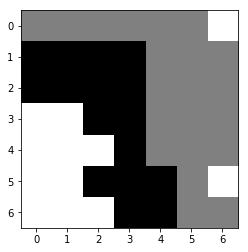

((5, 6), (4, 4)): n_v:  2726 q_all:+0.120404 q:+0.108222 q_m:+0.133333 p:0.411549
((0, 6), (2, 4)): n_v:  1080 q_all:+0.109156 q:+0.135834 q_m:+0.066667 p:0.214575
((5, 6), (6, 5)): n_v:   464 q_all:+0.116379 q:+0.120679 q_m:+0.033333 p:0.077822
((5, 6), (5, 5)): n_v:   352 q_all:+0.112301 q:+0.115793 q_m:+0.033333 p:0.065444
((0, 6), (1, 5)): n_v:    92 q_all:+0.098152 q:+0.051361 q_m:-0.100000 p:0.022755
((6, 2), (4, 4)): n_v:    91 q_all:-0.011501 q:+0.012188 q_m:+0.133333 p:0.065565
((5, 6), (4, 5)): n_v:    71 q_all:+0.027111 q:+0.036746 q_m:-0.033333 p:0.039428
((5, 6), (3, 4)): n_v:    49 q_all:+0.081264 q:+0.104212 q_m:+0.066667 p:0.015848
((4, 2), (2, 4)): n_v:    33 q_all:-0.011116 q:+0.001921 q_m:+0.066667 p:0.024187
((5, 6), (4, 6)): n_v:    25 q_all:+0.007771 q:+0.007281 q_m:-0.100000 p:0.015843
((0, 6), (1, 4)): n_v:    24 q_all:+0.089048 q:+0.124418 q_m:-0.000000 p:0.006789
((0, 6), (0, 4)): n_v:    20 q_all:+0.038994 q:+0.063117 q_m:-0.066667 p:0.010195
((5, 6), (6, 6))

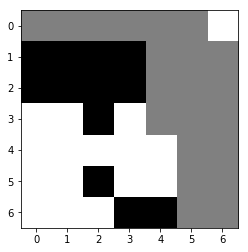

((6, 4), (5, 5)): n_v:  2691 q_all:-0.107239 q:-0.091530 q_m:+0.033333 p:0.376226
((2, 3), (3, 4)): n_v:  1612 q_all:-0.142079 q:-0.096948 q_m:+0.100000 p:0.492143
((1, 3), (3, 4)): n_v:   115 q_all:-0.131662 q:-0.128019 q_m:+0.066667 p:0.028898
((6, 3), (5, 5)): n_v:    60 q_all:-0.177471 q:-0.121682 q_m:-0.000000 p:0.028871
((6, 4), (5, 6)): n_v:    26 q_all:-0.189437 q:-0.203250 q_m:-0.133333 p:0.013906
((6, 4), (6, 5)): n_v:    13 q_all:-0.212213 q:-0.170317 q_m:-0.033333 p:0.008562
((1, 3), (1, 5)): n_v:    12 q_all:-0.157060 q:-0.163289 q_m:-0.066667 p:0.004883
((2, 3), (4, 5)): n_v:    10 q_all:-0.215574 q:-0.166752 q_m:-0.000000 p:0.006734
((5, 2), (3, 4)): n_v:     8 q_all:-0.169991 q:-0.144702 q_m:+0.066667 p:0.003926
((1, 2), (3, 4)): n_v:     7 q_all:-0.175711 q:-0.186848 q_m:+0.066667 p:0.003349
((2, 3), (1, 5)): n_v:     6 q_all:-0.219577 q:-0.152378 q_m:-0.066667 p:0.003823
((2, 2), (3, 4)): n_v:     3 q_all:-0.286133 q:-0.210202 q_m:+0.066667 p:0.002820
((6, 4), (6, 6))

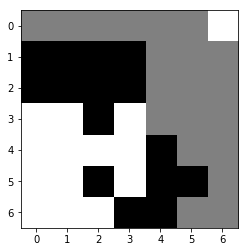

((3, 3), (4, 5)): n_v:  2484 q_all:+0.149716 q:+0.116352 q_m:+0.166667 p:0.266000
((3, 3), (3, 4)): n_v:   981 q_all:+0.128852 q:+0.156779 q_m:+0.133333 p:0.202909
((4, 3), (6, 5)): n_v:   480 q_all:+0.121822 q:+0.107034 q_m:+0.166667 p:0.115083
((3, 3), (2, 5)): n_v:   223 q_all:+0.071783 q:+0.064075 q_m:-0.033333 p:0.107175
((4, 3), (2, 5)): n_v:    80 q_all:+0.015661 q:-0.001285 q_m:-0.033333 p:0.060192
((3, 3), (2, 4)): n_v:    80 q_all:+0.125421 q:+0.143695 q_m:+0.133333 p:0.018035
((3, 3), (1, 4)): n_v:    34 q_all:+0.098742 q:+0.124570 q_m:+0.100000 p:0.011680
((4, 3), (2, 4)): n_v:    26 q_all:+0.104589 q:+0.071329 q_m:+0.100000 p:0.008481
((3, 3), (1, 5)): n_v:    19 q_all:+0.059042 q:+0.066468 q_m:-0.033333 p:0.010630
((4, 3), (4, 5)): n_v:    16 q_all:+0.064873 q:+0.074325 q_m:+0.166667 p:0.008359
((5, 3), (6, 5)): n_v:    13 q_all:+0.030313 q:+0.081526 q_m:+0.166667 p:0.009353
((5, 3), (4, 5)): n_v:    10 q_all:+0.028305 q:+0.061582 q_m:+0.166667 p:0.006995
((0, 6), (2, 5))

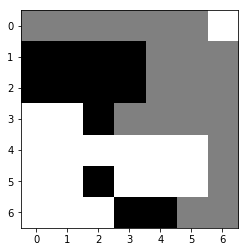

((2, 2), (3, 3)): n_v:  2969 q_all:-0.141929 q:-0.094844 q_m:+0.066667 p:0.248186
((1, 3), (3, 3)): n_v:   428 q_all:-0.178429 q:-0.134001 q_m:+0.033333 p:0.112021
((3, 2), (3, 4)): n_v:   387 q_all:-0.128698 q:-0.129812 q_m:+0.033333 p:0.006889
((6, 4), (6, 5)): n_v:   268 q_all:-0.147007 q:-0.115933 q_m:-0.000000 p:0.028919
((6, 4), (5, 6)): n_v:   116 q_all:-0.193926 q:-0.156794 q_m:-0.033333 p:0.039072
((1, 1), (3, 3)): n_v:    63 q_all:-0.219990 q:-0.208528 q_m:+0.033333 p:0.029452
((1, 2), (3, 3)): n_v:    58 q_all:-0.185119 q:-0.171801 q_m:+0.033333 p:0.016885
((5, 2), (3, 3)): n_v:    46 q_all:-0.198265 q:-0.173196 q_m:+0.033333 p:0.016682
((2, 3), (3, 5)): n_v:    46 q_all:-0.178097 q:-0.154142 q_m:-0.033333 p:0.012144
((5, 2), (3, 4)): n_v:    16 q_all:-0.136152 q:-0.182610 q_m:+0.033333 p:0.000886
((2, 3), (1, 5)): n_v:    12 q_all:-0.175522 q:-0.165213 q_m:-0.100000 p:0.002779
((2, 2), (3, 4)): n_v:    11 q_all:-0.216743 q:-0.201678 q_m:+0.033333 p:0.005200
((1, 3), (3, 5))

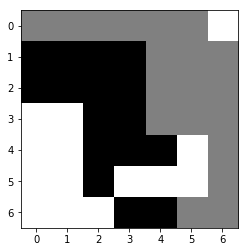

((4, 5), (3, 4)): n_v:  4639 q_all:+0.154393 q:+0.160743 q_m:+0.233333 p:0.821487
((5, 4), (6, 5)): n_v:    99 q_all:+0.095687 q:+0.118238 q_m:+0.033333 p:0.044264
((5, 5), (3, 4)): n_v:    25 q_all:+0.105043 q:+0.131287 q_m:+0.200000 p:0.010352
((0, 6), (2, 4)): n_v:    21 q_all:+0.107003 q:+0.128508 q_m:+0.133333 p:0.008474
((4, 5), (2, 4)): n_v:    13 q_all:+0.120856 q:+0.121477 q_m:+0.133333 p:0.004549
((0, 6), (0, 5)): n_v:    11 q_all:+0.034613 q:+0.026940 q_m:-0.033333 p:0.008513
((4, 5), (6, 5)): n_v:     2 q_all:+0.076646 q:+0.079142 q_m:-0.000000 p:0.001338
((0, 6), (1, 4)): n_v:     2 q_all:+0.075409 q:+0.106737 q_m:+0.066667 p:0.001351
((5, 3), (3, 4)): n_v:     1 q_all:+0.083573 q:+0.078273 q_m:+0.200000 p:0.000676
((5, 4), (3, 4)): n_v:     1 q_all:+0.035591 q:+0.084513 q_m:+0.200000 p:0.001011
((0, 6), (0, 4)): n_v:     1 q_all:+0.086045 q:+0.045837 q_m:-0.000000 p:0.000755
((4, 5), (3, 5)): n_v:     1 q_all:+0.083445 q:+0.049370 q_m:+0.033333 p:0.000875
((5, 5), (6, 6))

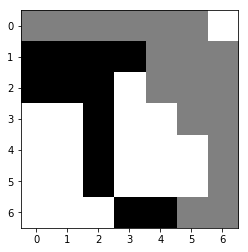

((1, 3), (2, 4)): n_v:  4935 q_all:-0.152358 q:-0.134551 q_m:-0.000000 p:0.738172
((6, 4), (6, 5)): n_v:   374 q_all:-0.185592 q:-0.196406 q_m:-0.066667 p:0.106113
((1, 3), (3, 5)): n_v:   250 q_all:-0.160921 q:-0.167445 q_m:-0.033333 p:0.045941
((6, 4), (4, 6)): n_v:   112 q_all:-0.216368 q:-0.218701 q_m:-0.100000 p:0.045772
((6, 4), (5, 6)): n_v:    83 q_all:-0.184215 q:-0.194309 q_m:-0.100000 p:0.023349
((1, 2), (2, 4)): n_v:    18 q_all:-0.194598 q:-0.219188 q_m:-0.033333 p:0.005716
((4, 2), (2, 4)): n_v:    11 q_all:-0.221208 q:-0.190307 q_m:-0.033333 p:0.004706
((1, 3), (1, 4)): n_v:     5 q_all:-0.228919 q:-0.201999 q_m:-0.133333 p:0.002542
((1, 0), (0, 1)): n_v:     4 q_all:-0.277862 q:-0.297903 q_m:-0.200000 p:0.002270
((1, 3), (1, 5)): n_v:     4 q_all:-0.244925 q:-0.246998 q_m:-0.166667 p:0.002290
((6, 3), (6, 5)): n_v:     2 q_all:-0.282705 q:-0.238065 q_m:-0.100000 p:0.001193
((1, 2), (0, 3)): n_v:     1 q_all:-0.283660 q:-0.273931 q_m:-0.200000 p:0.001082
((3, 2), (2, 4))

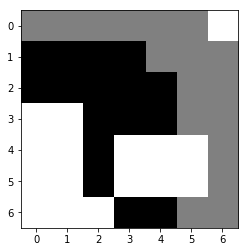

((0, 6), (1, 4)): n_v:  3749 q_all:+0.167950 q:+0.162356 q_m:+0.200000 p:0.471449
((5, 4), (6, 5)): n_v:  1351 q_all:+0.185909 q:+0.161964 q_m:+0.100000 p:0.074110
((4, 4), (3, 5)): n_v:   629 q_all:+0.151341 q:+0.135769 q_m:+0.166667 p:0.120425
((0, 6), (0, 5)): n_v:    79 q_all:+0.039349 q:+0.027798 q_m:+0.033333 p:0.050395
((0, 6), (1, 5)): n_v:    54 q_all:+0.083998 q:+0.093445 q_m:+0.100000 p:0.024738
((0, 6), (2, 5)): n_v:    14 q_all:+0.076746 q:+0.109894 q_m:+0.133333 p:0.006550
((0, 6), (0, 4)): n_v:     8 q_all:+0.076184 q:+0.069596 q_m:+0.066667 p:0.004382
((4, 5), (6, 5)): n_v:     8 q_all:+0.123643 q:+0.123667 q_m:+0.066667 p:0.002673
((4, 5), (2, 5)): n_v:     3 q_all:+0.104546 q:+0.114726 q_m:+0.133333 p:0.001135
((4, 3), (6, 5)): n_v:     3 q_all:+0.095899 q:+0.085843 q_m:+0.066667 p:0.001584
((5, 5), (3, 5)): n_v:     2 q_all:+0.091136 q:+0.098429 q_m:+0.133333 p:0.000828
((4, 5), (5, 6)): n_v:     2 q_all:+0.044328 q:+0.018215 q_m:+0.033333 p:0.001529
((0, 6), (1, 6))

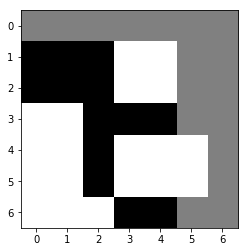

((3, 4), (3, 5)): n_v:  4104 q_all:-0.170738 q:-0.161800 q_m:+0.033333 p:0.790838
((1, 2), (0, 3)): n_v:   245 q_all:-0.194494 q:-0.195224 q_m:-0.033333 p:0.072577
((6, 4), (6, 5)): n_v:    87 q_all:-0.203208 q:-0.220188 q_m:-0.033333 p:0.029138
((3, 4), (2, 5)): n_v:    38 q_all:-0.209052 q:-0.205943 q_m:-0.033333 p:0.013484
((3, 4), (1, 5)): n_v:    32 q_all:-0.204889 q:-0.196467 q_m:-0.066667 p:0.010903
((6, 4), (5, 6)): n_v:    30 q_all:-0.209740 q:-0.221912 q_m:-0.066667 p:0.011136
((3, 4), (5, 6)): n_v:    28 q_all:-0.212461 q:-0.206193 q_m:-0.066667 p:0.010433
((3, 4), (4, 6)): n_v:    24 q_all:-0.202087 q:-0.201364 q_m:-0.066667 p:0.008190
((3, 4), (1, 6)): n_v:    17 q_all:-0.247001 q:-0.278317 q_m:-0.200000 p:0.009311
((3, 4), (2, 6)): n_v:    12 q_all:-0.238671 q:-0.245143 q_m:-0.200000 p:0.005821
((1, 0), (0, 1)): n_v:    11 q_all:-0.278885 q:-0.305825 q_m:-0.166667 p:0.007912
((6, 4), (4, 6)): n_v:     5 q_all:-0.251404 q:-0.252637 q_m:-0.066667 p:0.002795
((1, 0), (0, 0))

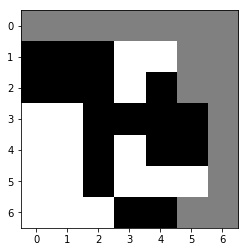

((1, 4), (2, 5)): n_v:  3955 q_all:+0.166127 q:+0.178777 q_m:+0.200000 p:0.878557
((5, 4), (6, 5)): n_v:   336 q_all:+0.211980 q:+0.147839 q_m:+0.066667 p:0.009958
((2, 3), (0, 1)): n_v:   326 q_all:+0.214377 q:+0.164604 q_m:+0.166667 p:0.006366
((1, 3), (0, 1)): n_v:   247 q_all:+0.209337 q:+0.178851 q_m:+0.166667 p:0.010041
((1, 3), (2, 5)): n_v:    53 q_all:+0.100027 q:+0.119422 q_m:+0.166667 p:0.026927
((4, 3), (2, 5)): n_v:    45 q_all:+0.146858 q:+0.088139 q_m:+0.166667 p:0.013926
((5, 5), (4, 6)): n_v:    33 q_all:+0.121542 q:+0.071618 q_m:+0.133333 p:0.013631
((4, 3), (6, 5)): n_v:    18 q_all:+0.189203 q:+0.086287 q_m:+0.033333 p:0.002345
((1, 4), (0, 5)): n_v:    15 q_all:+0.042612 q:+0.038953 q_m:-0.000000 p:0.011491
((2, 3), (2, 5)): n_v:     9 q_all:+0.062082 q:+0.095821 q_m:+0.166667 p:0.006349
((1, 3), (0, 2)): n_v:     2 q_all:+0.103796 q:+0.130618 q_m:+0.133333 p:0.001089
((2, 3), (0, 5)): n_v:     1 q_all:+0.000067 q:+0.022605 q_m:-0.033333 p:0.001751
((1, 4), (1, 5))

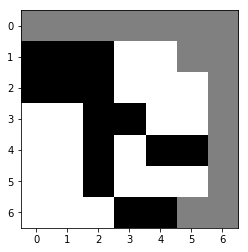

((6, 4), (6, 5)): n_v:  3507 q_all:-0.137744 q:-0.142846 q_m:-0.033333 p:0.355654
((1, 2), (0, 3)): n_v:  1276 q_all:-0.168531 q:-0.141929 q_m:-0.033333 p:0.296461
((4, 5), (3, 6)): n_v:   274 q_all:-0.179386 q:-0.170625 q_m:-0.033333 p:0.076140
((1, 0), (0, 1)): n_v:   107 q_all:-0.279240 q:-0.271653 q_m:-0.166667 p:0.074912
((4, 5), (4, 6)): n_v:    33 q_all:-0.225610 q:-0.226955 q_m:-0.033333 p:0.015102
((4, 5), (2, 6)): n_v:    32 q_all:-0.199692 q:-0.191096 q_m:-0.066667 p:0.011991
((4, 5), (6, 5)): n_v:    30 q_all:-0.229833 q:-0.198752 q_m:-0.066667 p:0.014852
((6, 4), (4, 6)): n_v:    20 q_all:-0.228624 q:-0.234803 q_m:-0.066667 p:0.010159
((6, 3), (6, 5)): n_v:    19 q_all:-0.238073 q:-0.203630 q_m:-0.066667 p:0.009890
((6, 4), (5, 6)): n_v:    16 q_all:-0.223510 q:-0.255287 q_m:-0.133333 p:0.007562
((4, 4), (6, 5)): n_v:    10 q_all:-0.231134 q:-0.176868 q_m:-0.066667 p:0.004740
((4, 5), (5, 6)): n_v:     9 q_all:-0.301496 q:-0.288033 q_m:-0.100000 p:0.006456
((4, 4), (3, 6))

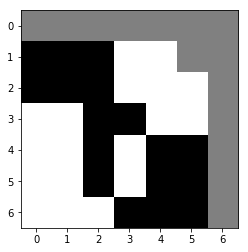

((3, 5), (5, 6)): n_v:  3051 q_all:+0.165213 q:+0.179851 q_m:+0.233333 p:0.365589
((1, 3), (0, 1)): n_v:  1151 q_all:+0.176017 q:+0.195738 q_m:+0.233333 p:0.079974
((1, 3), (0, 2)): n_v:   262 q_all:+0.124612 q:+0.168498 q_m:+0.200000 p:0.078511
((3, 4), (5, 6)): n_v:   100 q_all:+0.071490 q:+0.152152 q_m:+0.233333 p:0.053589
((1, 3), (0, 4)): n_v:    94 q_all:+0.010946 q:+0.050906 q_m:+0.066667 p:0.075144
((3, 5), (4, 6)): n_v:    75 q_all:+0.080062 q:+0.122782 q_m:+0.200000 p:0.037585
((2, 3), (0, 1)): n_v:    71 q_all:+0.134714 q:+0.169045 q_m:+0.233333 p:0.018077
((3, 5), (1, 6)): n_v:    61 q_all:+0.014039 q:+0.065496 q_m:+0.033333 p:0.048534
((1, 4), (0, 5)): n_v:    49 q_all:+0.041651 q:+0.091691 q_m:+0.066667 p:0.033013
((2, 5), (1, 6)): n_v:    35 q_all:+0.046812 q:+0.091578 q_m:+0.066667 p:0.022923
((1, 3), (0, 5)): n_v:    27 q_all:-0.030574 q:+0.021944 q_m:+0.033333 p:0.026982
((1, 4), (1, 5)): n_v:    21 q_all:+0.092367 q:+0.105099 q_m:+0.066667 p:0.009576
((1, 3), (0, 3))

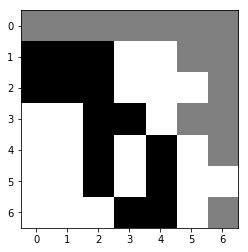

((4, 4), (3, 5)): n_v:  4699 q_all:-0.123280 q:-0.108100 q_m:+0.066667 p:0.941826
((1, 2), (0, 3)): n_v:    35 q_all:-0.191571 q:-0.206179 q_m:-0.066667 p:0.018253
((4, 4), (6, 6)): n_v:    19 q_all:-0.154132 q:-0.129411 q_m:-0.033333 p:0.006593
((5, 4), (3, 5)): n_v:    17 q_all:-0.295982 q:-0.205479 q_m:+0.033333 p:0.017587
((4, 4), (2, 6)): n_v:     5 q_all:-0.208207 q:-0.219519 q_m:-0.166667 p:0.003191
((6, 4), (4, 6)): n_v:     5 q_all:-0.280471 q:-0.318753 q_m:-0.033333 p:0.004258
((3, 3), (3, 5)): n_v:     1 q_all:-0.312799 q:-0.171830 q_m:+0.033333 p:0.001368
((1, 0), (0, 0)): n_v:     1 q_all:-0.363268 q:-0.360991 q_m:-0.200000 p:0.001674
((3, 3), (1, 5)): n_v:     0 q_all:-0.211768 q:-0.211768 q_m:-0.033333 p:0.000511
((1, 0), (0, 2)): n_v:     0 q_all:-0.334974 q:-0.334974 q_m:-0.166667 p:0.000021
((2, 2), (0, 2)): n_v:     0 q_all:-0.354777 q:-0.354777 q_m:-0.166667 p:0.000001
((2, 1), (0, 3)): n_v:     0 q_all:-0.355782 q:-0.355782 q_m:-0.100000 p:0.000024
((5, 4), (3, 6))

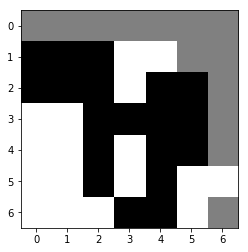

((1, 4), (1, 5)): n_v:  3921 q_all:+0.173768 q:+0.211962 q_m:+0.100000 p:0.245078
((1, 3), (0, 1)): n_v:   507 q_all:+0.154852 q:+0.210818 q_m:+0.133333 p:0.038348
((2, 3), (0, 1)): n_v:   402 q_all:+0.158768 q:+0.191155 q_m:+0.133333 p:0.023079
((1, 3), (1, 5)): n_v:   330 q_all:+0.077091 q:+0.143717 q_m:+0.066667 p:0.144650
((5, 6), (3, 6)): n_v:   257 q_all:+0.133309 q:+0.140063 q_m:+0.133333 p:0.045710
((1, 4), (3, 6)): n_v:   237 q_all:+0.077809 q:+0.121028 q_m:+0.133333 p:0.102963
((2, 3), (1, 5)): n_v:   219 q_all:+0.076685 q:+0.143090 q_m:+0.066667 p:0.096428
((5, 5), (4, 6)): n_v:   135 q_all:+0.075813 q:+0.134803 q_m:+0.100000 p:0.060099
((1, 4), (2, 6)): n_v:    71 q_all:+0.072912 q:+0.138330 q_m:+0.066667 p:0.032842
((5, 5), (3, 6)): n_v:    53 q_all:+0.063800 q:+0.069724 q_m:+0.133333 p:0.026587
((5, 5), (6, 6)): n_v:    16 q_all:+0.039777 q:+0.085468 q_m:-0.033333 p:0.010137
((1, 4), (0, 5)): n_v:    15 q_all:+0.019771 q:+0.067873 q_m:-0.033333 p:0.010799
((2, 3), (0, 2))

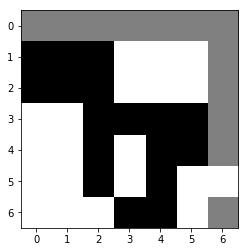

((3, 5), (2, 6)): n_v:  4128 q_all:-0.110326 q:-0.045281 q_m:+0.066667 p:0.337353
((3, 5), (4, 6)): n_v:   858 q_all:-0.195915 q:-0.111121 q_m:+0.066667 p:0.383137
((1, 2), (0, 3)): n_v:    66 q_all:-0.179148 q:-0.116421 q_m:+0.066667 p:0.024337
((1, 2), (0, 4)): n_v:    29 q_all:-0.197642 q:-0.134688 q_m:+0.100000 p:0.013569
((4, 5), (6, 6)): n_v:    22 q_all:-0.155850 q:-0.065157 q_m:+0.100000 p:0.005379
((6, 4), (6, 6)): n_v:    16 q_all:-0.177993 q:-0.080672 q_m:+0.100000 p:0.005797
((4, 4), (6, 6)): n_v:    13 q_all:-0.183099 q:-0.083005 q_m:+0.100000 p:0.004723
((3, 5), (1, 6)): n_v:    10 q_all:-0.211705 q:-0.153363 q_m:+0.033333 p:0.005182
((6, 4), (4, 6)): n_v:    10 q_all:-0.247033 q:-0.257159 q_m:+0.033333 p:0.007188
((3, 4), (4, 6)): n_v:     6 q_all:-0.234379 q:-0.172253 q_m:+0.033333 p:0.003627
((4, 5), (2, 6)): n_v:     6 q_all:-0.224407 q:-0.165936 q_m:+0.033333 p:0.003279
((1, 0), (0, 0)): n_v:     6 q_all:-0.313514 q:-0.244470 q_m:-0.066667 p:0.005785
((3, 4), (2, 6))

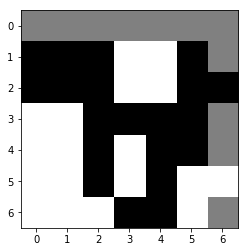

((5, 6), (3, 6)): n_v:  2700 q_all:+0.214254 q:+0.186571 q_m:+0.200000 p:0.093343
((5, 5), (3, 6)): n_v:  1031 q_all:+0.153135 q:+0.128297 q_m:+0.200000 p:0.103101
((1, 3), (0, 1)): n_v:   744 q_all:+0.159278 q:+0.254652 q_m:+0.133333 p:0.050172
((1, 4), (3, 6)): n_v:   736 q_all:+0.043278 q:+0.107062 q_m:+0.200000 p:0.493535
((1, 4), (1, 6)): n_v:   323 q_all:+0.115534 q:+0.190853 q_m:+0.133333 p:0.095497
((2, 4), (3, 6)): n_v:   113 q_all:+0.054882 q:+0.136919 q_m:+0.200000 p:0.068963
((2, 4), (1, 6)): n_v:    45 q_all:+0.082877 q:+0.171714 q_m:+0.133333 p:0.020925
((2, 3), (0, 1)): n_v:    42 q_all:+0.130948 q:+0.220487 q_m:+0.133333 p:0.008481
((5, 5), (4, 6)): n_v:    20 q_all:+0.073016 q:+0.149914 q_m:+0.100000 p:0.010746
((1, 3), (0, 2)): n_v:    13 q_all:+0.112797 q:+0.208131 q_m:+0.100000 p:0.003878
((1, 3), (0, 5)): n_v:     7 q_all:-0.032270 q:+0.031230 q_m:-0.000000 p:0.007628
((1, 4), (0, 5)): n_v:     7 q_all:+0.066861 q:+0.120917 q_m:+0.033333 p:0.004352
((5, 5), (6, 6))

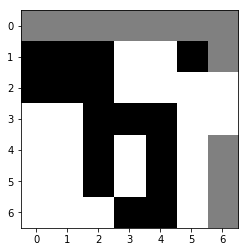

((1, 5), (1, 6)): n_v:  4499 q_all:-0.137198 q:-0.110867 q_m:-0.033333 p:0.905782
((3, 4), (5, 6)): n_v:   120 q_all:-0.171981 q:-0.153070 q_m:-0.000000 p:0.013385
((6, 4), (5, 6)): n_v:    61 q_all:-0.269132 q:-0.197894 q_m:-0.000000 p:0.045026
((3, 4), (1, 6)): n_v:    26 q_all:-0.223506 q:-0.157884 q_m:-0.066667 p:0.011572
((6, 4), (4, 6)): n_v:    25 q_all:-0.221224 q:-0.202205 q_m:+0.066667 p:0.010877
((4, 4), (5, 6)): n_v:     6 q_all:-0.260080 q:-0.157534 q_m:-0.000000 p:0.004134
((3, 4), (4, 6)): n_v:     6 q_all:-0.176033 q:-0.189082 q_m:+0.066667 p:0.000917
((5, 4), (4, 6)): n_v:     5 q_all:-0.317490 q:-0.200582 q_m:+0.066667 p:0.005089
((1, 2), (0, 3)): n_v:     2 q_all:-0.217206 q:-0.204035 q_m:-0.033333 p:0.000717
((5, 4), (5, 6)): n_v:     1 q_all:-0.380048 q:-0.314239 q_m:-0.000000 p:0.001297
((4, 4), (6, 6)): n_v:     0 q_all:-0.235513 q:-0.235513 q_m:-0.066667 p:0.000009
((2, 0), (0, 2)): n_v:     0 q_all:-0.365682 q:-0.365682 q_m:-0.133333 p:0.000014
((1, 0), (0, 2))

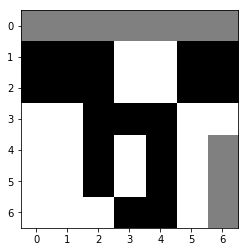

((1, 3), (0, 1)): n_v:  2872 q_all:+0.147059 q:+0.256368 q_m:+0.233333 p:0.483625
((1, 4), (0, 5)): n_v:  2556 q_all:+0.180149 q:+0.160923 q_m:+0.200000 p:0.164047
((2, 3), (0, 1)): n_v:   643 q_all:+0.131015 q:+0.228053 q_m:+0.233333 p:0.156957
((1, 3), (0, 5)): n_v:   181 q_all:+0.037051 q:+0.083453 q_m:+0.166667 p:0.117461
((2, 3), (0, 5)): n_v:   103 q_all:+0.038129 q:+0.092978 q_m:+0.166667 p:0.066376
((2, 4), (0, 5)): n_v:     7 q_all:+0.009339 q:+0.114183 q_m:+0.166667 p:0.005484
((1, 3), (0, 2)): n_v:     3 q_all:+0.090297 q:+0.208343 q_m:+0.200000 p:0.000746
((3, 5), (4, 6)): n_v:     1 q_all:-0.116274 q:+0.025008 q_m:+0.066667 p:0.000798
((1, 4), (0, 6)): n_v:     1 q_all:+0.033742 q:+0.114563 q_m:+0.166667 p:0.000476
((2, 3), (0, 2)): n_v:     1 q_all:+0.042248 q:+0.135687 q_m:+0.166667 p:0.000310
((2, 4), (0, 6)): n_v:     0 q_all:+0.082024 q:+0.082024 q_m:+0.166667 p:0.000010
((2, 3), (0, 4)): n_v:     0 q_all:+0.034244 q:+0.034244 q_m:+0.100000 p:0.000095
((4, 5), (6, 6))

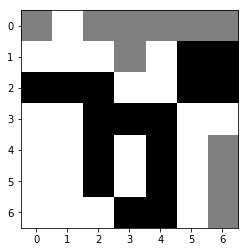

((2, 2), (1, 3)): n_v:  3646 q_all:+0.038128 q:-0.027342 q_m:+0.066667 p:0.936246
((6, 4), (4, 6)): n_v:    14 q_all:-0.159886 q:-0.158524 q_m:+0.033333 p:0.016756
((1, 5), (1, 3)): n_v:    10 q_all:-0.232273 q:-0.199573 q_m:+0.033333 p:0.015486
((2, 1), (1, 3)): n_v:     5 q_all:-0.139733 q:-0.112238 q_m:+0.033333 p:0.005433
((2, 6), (4, 6)): n_v:     1 q_all:-0.254484 q:-0.195123 q_m:+0.033333 p:0.001751
((3, 2), (1, 3)): n_v:     1 q_all:-0.258243 q:-0.099224 q_m:+0.033333 p:0.001004
((2, 5), (1, 3)): n_v:     1 q_all:-0.251746 q:-0.251746 q_m:+0.033333 p:0.002246
((4, 4), (6, 6)): n_v:     0 q_all:-0.265666 q:-0.265666 q_m:-0.100000 p:0.000911
((1, 6), (0, 4)): n_v:     0 q_all:-0.399853 q:-0.399853 q_m:-0.166667 p:0.000026
((2, 5), (0, 3)): n_v:     0 q_all:-0.390883 q:-0.390883 q_m:-0.100000 p:0.000015
((4, 4), (5, 6)): n_v:     0 q_all:-0.199723 q:-0.199723 q_m:-0.033333 p:0.000049
((2, 0), (0, 2)): n_v:     0 q_all:-0.176849 q:-0.176849 q_m:-0.033333 p:0.000472
((2, 2), (0, 2))

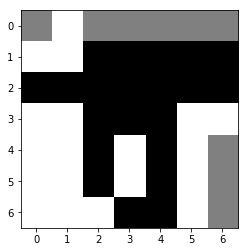

((0, 1), (0, 3)): n_v:  2263 q_all:-0.063896 q:+0.121431 q_m:+0.133333 p:0.679648
((1, 1), (0, 3)): n_v:  2169 q_all:-0.005263 q:+0.114922 q_m:+0.133333 p:0.136433
((3, 5), (5, 6)): n_v:    66 q_all:-0.101159 q:-0.048011 q_m:-0.066667 p:0.031779
((1, 0), (0, 2)): n_v:    57 q_all:-0.096268 q:+0.035963 q_m:+0.066667 p:0.026366
((3, 6), (5, 6)): n_v:    35 q_all:-0.149825 q:-0.073067 q_m:-0.066667 p:0.024873
((0, 1), (0, 2)): n_v:    31 q_all:-0.137922 q:+0.098779 q_m:+0.100000 p:0.020346
((6, 5), (4, 6)): n_v:     7 q_all:-0.118310 q:-0.171635 q_m:-0.066667 p:0.004234
((3, 5), (4, 6)): n_v:     6 q_all:-0.250740 q:-0.177216 q_m:-0.033333 p:0.007259
((4, 5), (6, 6)): n_v:     4 q_all:-0.143417 q:-0.019487 q_m:-0.066667 p:0.002891
((5, 5), (6, 6)): n_v:     2 q_all:-0.208205 q:-0.087709 q_m:-0.033333 p:0.002513
((4, 5), (5, 6)): n_v:     1 q_all:-0.285218 q:-0.138103 q_m:-0.033333 p:0.001850
((0, 1), (0, 0)): n_v:     1 q_all:-0.112353 q:+0.028195 q_m:-0.033333 p:0.000929
################

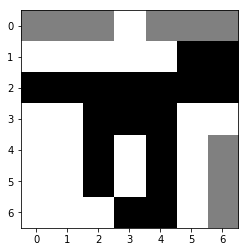

((1, 5), (0, 4)): n_v:  3999 q_all:+0.172338 q:+0.100637 q_m:+0.100000 p:0.623912
((6, 4), (4, 6)): n_v:    70 q_all:+0.052698 q:+0.061425 q_m:+0.133333 p:0.044429
((1, 6), (0, 4)): n_v:    50 q_all:-0.056529 q:-0.077208 q_m:+0.066667 p:0.064345
((2, 0), (0, 2)): n_v:    46 q_all:+0.003432 q:-0.002089 q_m:+0.133333 p:0.044963
((1, 5), (0, 5)): n_v:    34 q_all:-0.073255 q:-0.122677 q_m:-0.033333 p:0.048302
((2, 6), (0, 4)): n_v:    27 q_all:-0.063594 q:-0.070351 q_m:+0.066667 p:0.036515
((2, 6), (4, 6)): n_v:    21 q_all:-0.054454 q:-0.039164 q_m:+0.133333 p:0.027900
((5, 4), (4, 6)): n_v:    13 q_all:-0.026602 q:-0.006791 q_m:+0.133333 p:0.015319
((2, 1), (0, 2)): n_v:     6 q_all:-0.134882 q:-0.100191 q_m:+0.133333 p:0.010389
((2, 5), (0, 4)): n_v:     2 q_all:-0.284579 q:-0.211027 q_m:+0.066667 p:0.005408
((2, 0), (0, 1)): n_v:     2 q_all:+0.008852 q:+0.008852 q_m:+0.066667 p:0.002330
((1, 5), (0, 6)): n_v:     2 q_all:-0.230864 q:-0.209983 q_m:-0.100000 p:0.005533
((2, 6), (0, 5))

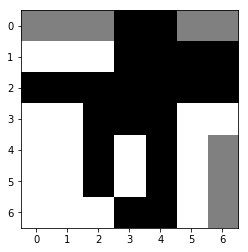

((1, 2), (0, 0)): n_v:  3240 q_all:-0.135589 q:-0.080699 q_m:-0.100000 p:0.159209
((1, 0), (0, 2)): n_v:   605 q_all:-0.209128 q:-0.060601 q_m:+0.033333 p:0.173718
((1, 1), (0, 2)): n_v:   326 q_all:-0.249220 q:-0.027135 q_m:+0.066667 p:0.162928
((3, 5), (5, 6)): n_v:   303 q_all:-0.253268 q:-0.082144 q_m:-0.100000 p:0.157563
((3, 6), (5, 6)): n_v:   128 q_all:-0.270980 q:-0.137329 q_m:-0.100000 p:0.078920
((4, 5), (6, 6)): n_v:    24 q_all:-0.244513 q:-0.084132 q_m:-0.100000 p:0.011194
((1, 0), (0, 1)): n_v:    19 q_all:-0.459860 q:-0.254231 q_m:-0.066667 p:0.027138
((6, 5), (4, 6)): n_v:    18 q_all:-0.246991 q:-0.233473 q_m:-0.100000 p:0.008493
((5, 5), (6, 6)): n_v:    10 q_all:-0.251469 q:-0.198830 q_m:-0.066667 p:0.004595
((3, 5), (4, 6)): n_v:     5 q_all:-0.358961 q:-0.276528 q_m:-0.066667 p:0.005843
((1, 0), (0, 0)): n_v:     5 q_all:-0.258604 q:-0.119920 q_m:-0.066667 p:0.003001
((4, 5), (5, 6)): n_v:     4 q_all:-0.414891 q:-0.286685 q_m:-0.066667 p:0.004626
################

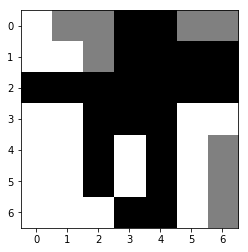

((0, 3), (0, 1)): n_v:  2395 q_all:+0.407463 q:+0.208290 q_m:+0.300000 p:0.016626
((6, 4), (4, 6)): n_v:  1678 q_all:+0.156527 q:+0.219915 q_m:+0.366667 p:0.013171
((0, 3), (1, 2)): n_v:   874 q_all:+0.152957 q:+0.222633 q_m:+0.200000 p:0.025175
((0, 4), (0, 5)): n_v:   181 q_all:-0.058074 q:-0.012576 q_m:+0.133333 p:0.229465
((2, 0), (0, 1)): n_v:    93 q_all:+0.112118 q:+0.180704 q_m:+0.300000 p:0.025029
((2, 2), (0, 1)): n_v:    78 q_all:+0.139554 q:+0.145900 q_m:+0.300000 p:0.008454
((2, 6), (4, 6)): n_v:    23 q_all:+0.127308 q:+0.059096 q_m:+0.366667 p:0.004267
((2, 6), (0, 5)): n_v:    21 q_all:-0.136199 q:-0.122879 q_m:+0.100000 p:0.036920
((1, 3), (0, 1)): n_v:    12 q_all:+0.082990 q:+0.152384 q_m:+0.300000 p:0.005309
((2, 1), (0, 1)): n_v:     8 q_all:-0.005172 q:+0.079593 q_m:+0.300000 p:0.007213
((0, 3), (0, 5)): n_v:     5 q_all:-0.099591 q:-0.051886 q_m:+0.100000 p:0.008664
((2, 0), (1, 2)): n_v:     4 q_all:+0.097017 q:+0.162303 q_m:+0.166667 p:0.001658
((2, 4), (0, 5))

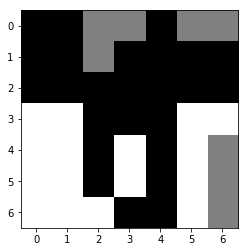

((3, 1), (1, 2)): n_v:  2920 q_all:-0.335448 q:-0.117304 q_m:+0.100000 p:0.593464
((3, 0), (1, 2)): n_v:  1436 q_all:-0.386547 q:-0.052329 q_m:+0.100000 p:0.344471
((3, 5), (5, 6)): n_v:   108 q_all:-0.388784 q:-0.300446 q_m:-0.300000 p:0.027679
((3, 6), (5, 6)): n_v:    37 q_all:-0.441538 q:-0.387145 q_m:-0.300000 p:0.022626
((4, 5), (6, 6)): n_v:     6 q_all:-0.431831 q:-0.304333 q_m:-0.300000 p:0.003465
((6, 5), (4, 6)): n_v:     2 q_all:-0.464181 q:-0.433899 q_m:-0.300000 p:0.002229
((5, 5), (6, 6)): n_v:     1 q_all:-0.463184 q:-0.445761 q_m:-0.266667 p:0.000994
((3, 5), (4, 6)): n_v:     0 q_all:-0.495821 q:-0.495821 q_m:-0.266667 p:0.000769
((4, 5), (5, 6)): n_v:     0 q_all:-0.519621 q:-0.519621 q_m:-0.266667 p:0.000795
########################p_sum is:  0.996490167163
-1 's turn


This is a random move


one move takes time(s):  0.28992271423339844
no. of data collected:  16


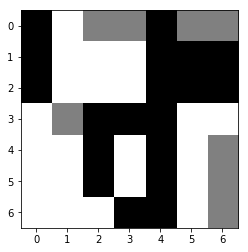

((2, 0), (3, 1)): n_v:  4920 q_all:+0.417345 q:+0.521530 q_m:+0.266667 p:0.336789
((1, 0), (3, 1)): n_v:    66 q_all:+0.198511 q:+0.349189 q_m:+0.233333 p:0.068975
((5, 2), (3, 1)): n_v:    46 q_all:+0.267554 q:+0.328645 q_m:+0.233333 p:0.027603
((0, 4), (0, 2)): n_v:     6 q_all:-0.045062 q:+0.077200 q_m:+0.166667 p:0.015062
((3, 4), (4, 6)): n_v:     6 q_all:-0.127039 q:-0.163396 q_m:+0.166667 p:0.017443
((6, 4), (4, 6)): n_v:     4 q_all:-0.041997 q:+0.047313 q_m:+0.166667 p:0.010971
((2, 4), (4, 6)): n_v:     2 q_all:-0.199684 q:-0.177142 q_m:+0.166667 p:0.006794
((0, 0), (0, 2)): n_v:     1 q_all:-0.108943 q:+0.024292 q_m:+0.166667 p:0.002533
((3, 3), (3, 1)): n_v:     1 q_all:+0.058485 q:+0.238332 q_m:+0.233333 p:0.002043
((1, 4), (0, 2)): n_v:     1 q_all:-0.169365 q:-0.106742 q_m:+0.166667 p:0.004820
((2, 4), (0, 6)): n_v:     0 q_all:-0.438756 q:-0.438756 q_m:-0.100000 p:0.000205
((5, 4), (6, 6)): n_v:     0 q_all:-0.248331 q:-0.248331 q_m:+0.033333 p:0.000061
((2, 5), (0, 3))

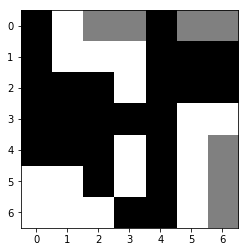

((2, 3), (0, 5)): n_v:  5585 q_all:-0.408029 q:-0.275931 q_m:-0.000000 p:0.598405
((1, 3), (0, 5)): n_v:   912 q_all:-0.489059 q:-0.433455 q_m:-0.000000 p:0.389832
((2, 3), (0, 2)): n_v:     3 q_all:-0.617282 q:-0.500615 q_m:-0.266667 p:0.002300
((3, 5), (5, 6)): n_v:     2 q_all:-0.600962 q:-0.549493 q_m:-0.266667 p:0.002424
((2, 3), (0, 3)): n_v:     1 q_all:-0.621852 q:-0.572967 q_m:-0.133333 p:0.001893
((0, 1), (0, 3)): n_v:     1 q_all:-0.656588 q:-0.567199 q_m:-0.133333 p:0.001448
((1, 1), (0, 3)): n_v:     1 q_all:-0.562549 q:-0.476665 q_m:-0.133333 p:0.001085
((4, 5), (6, 6)): n_v:     0 q_all:-0.520142 q:-0.520142 q_m:-0.266667 p:0.000240
((3, 5), (4, 6)): n_v:     0 q_all:-0.698474 q:-0.698474 q_m:-0.233333 p:0.000054
((4, 5), (5, 6)): n_v:     0 q_all:-0.704505 q:-0.704505 q_m:-0.233333 p:0.000055
((3, 6), (5, 6)): n_v:     0 q_all:-0.623966 q:-0.623966 q_m:-0.266667 p:0.000959
((6, 5), (4, 6)): n_v:     0 q_all:-0.625244 q:-0.625244 q_m:-0.266667 p:0.000097
((0, 1), (0, 2))

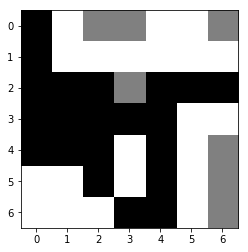

((2, 2), (2, 3)): n_v:  5735 q_all:+0.540595 q:+0.516621 q_m:+0.233333 p:0.134238
((2, 4), (0, 6)): n_v:   146 q_all:+0.299420 q:+0.324272 q_m:+0.200000 p:0.126293
((2, 4), (4, 6)): n_v:    33 q_all:+0.337195 q:+0.377174 q_m:+0.266667 p:0.022047
((4, 4), (6, 6)): n_v:    26 q_all:+0.082709 q:+0.095898 q_m:+0.133333 p:0.047203
((6, 4), (4, 6)): n_v:    21 q_all:+0.274530 q:+0.285592 q_m:+0.266667 p:0.020901
((4, 4), (2, 3)): n_v:     4 q_all:+0.316784 q:+0.328196 q_m:+0.200000 p:0.003230
((2, 4), (0, 2)): n_v:     2 q_all:+0.383942 q:+0.414846 q_m:+0.266667 p:0.001043
((2, 4), (0, 3)): n_v:     1 q_all:+0.265701 q:+0.216489 q_m:+0.266667 p:0.001628
((4, 4), (4, 6)): n_v:     1 q_all:+0.150250 q:+0.150250 q_m:+0.266667 p:0.002786
((2, 6), (4, 6)): n_v:     1 q_all:+0.189335 q:+0.218884 q_m:+0.266667 p:0.001288
((2, 2), (0, 3)): n_v:     0 q_all:+0.134580 q:+0.134580 q_m:+0.266667 p:0.000676
((2, 5), (0, 3)): n_v:     0 q_all:+0.077945 q:+0.077945 q_m:+0.266667 p:0.000087
((4, 4), (5, 6))

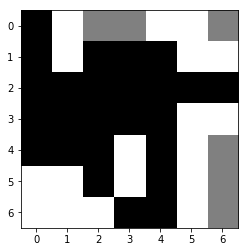

((1, 1), (0, 3)): n_v:  3811 q_all:-0.581059 q:-0.377423 q_m:-0.033333 p:0.090929
((0, 1), (0, 3)): n_v:  1077 q_all:-0.626828 q:-0.478961 q_m:-0.033333 p:0.210115
((0, 5), (0, 3)): n_v:   399 q_all:-0.738651 q:-0.674960 q_m:-0.033333 p:0.245025
((0, 4), (0, 3)): n_v:   243 q_all:-0.712160 q:-0.601854 q_m:-0.000000 p:0.124855
((0, 4), (0, 2)): n_v:   234 q_all:-0.697234 q:-0.596349 q_m:-0.100000 p:0.107451
((1, 5), (0, 3)): n_v:   190 q_all:-0.747088 q:-0.672178 q_m:-0.033333 p:0.122797
((3, 5), (5, 6)): n_v:   188 q_all:-0.603837 q:-0.647050 q_m:-0.233333 p:0.020574
((3, 6), (5, 6)): n_v:    28 q_all:-0.688876 q:-0.679602 q_m:-0.233333 p:0.011947
((0, 4), (0, 6)): n_v:    18 q_all:-0.650707 q:-0.640851 q_m:-0.233333 p:0.005356
((4, 5), (6, 6)): n_v:    17 q_all:-0.676191 q:-0.633034 q_m:-0.233333 p:0.006830
((0, 5), (0, 6)): n_v:    15 q_all:-0.685020 q:-0.610160 q_m:-0.200000 p:0.006275
((5, 5), (6, 6)): n_v:    12 q_all:-0.750737 q:-0.721526 q_m:-0.200000 p:0.007614
((6, 5), (4, 6))

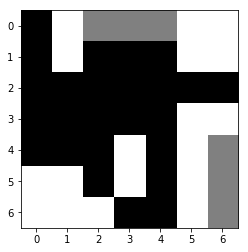

((1, 3), (0, 4)): n_v:  1247 q_all:+0.778933 q:+0.759150 q_m:+0.400000 p:0.319250
((1, 2), (0, 2)): n_v:   967 q_all:+0.789219 q:+0.756435 q_m:+0.400000 p:0.177716
((6, 4), (4, 6)): n_v:     1 q_all:+0.647930 q:+0.735690 q_m:+0.500000 p:0.001566
((4, 4), (6, 6)): n_v:     0 q_all:+0.414372 q:+0.414372 q_m:+0.366667 p:0.000055
((2, 3), (0, 4)): n_v:     0 q_all:+0.320175 q:+0.320175 q_m:+0.366667 p:0.000082
((1, 2), (0, 3)): n_v:     0 q_all:+0.543233 q:+0.543233 q_m:+0.266667 p:0.000100
((2, 5), (0, 3)): n_v:     0 q_all:+0.308973 q:+0.308973 q_m:+0.233333 p:0.000000
((4, 4), (5, 6)): n_v:     0 q_all:+0.515340 q:+0.515340 q_m:+0.433333 p:0.000011
((2, 0), (0, 2)): n_v:     0 q_all:+0.536650 q:+0.536650 q_m:+0.366667 p:0.000774
((1, 0), (0, 2)): n_v:     0 q_all:+0.592092 q:+0.592092 q_m:+0.366667 p:0.000035
((2, 2), (0, 2)): n_v:     0 q_all:+0.349828 q:+0.349828 q_m:+0.366667 p:0.000006
((2, 5), (4, 6)): n_v:     0 q_all:+0.527600 q:+0.555201 q_m:+0.500000 p:0.000013
((2, 1), (0, 3))

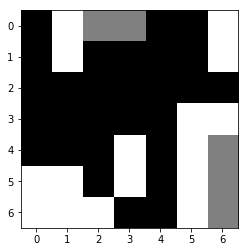

((0, 1), (0, 3)): n_v:  2136 q_all:-0.781686 q:-0.605701 q_m:-0.133333 p:0.640104
((1, 1), (0, 3)): n_v:  1261 q_all:-0.778166 q:-0.527109 q_m:-0.133333 p:0.352482
((3, 5), (5, 6)): n_v:    38 q_all:-0.737766 q:-0.757701 q_m:-0.400000 p:0.001591
((4, 5), (6, 6)): n_v:     4 q_all:-0.760559 q:-0.741043 q_m:-0.400000 p:0.000648
((3, 6), (5, 6)): n_v:     4 q_all:-0.770761 q:-0.743367 q_m:-0.400000 p:0.000976
((0, 1), (0, 2)): n_v:     2 q_all:-0.852673 q:-0.751458 q_m:-0.233333 p:0.001054
((4, 5), (5, 6)): n_v:     0 q_all:-0.803454 q:-0.803454 q_m:-0.366667 p:0.000057
((6, 5), (4, 6)): n_v:     0 q_all:-0.775571 q:-0.775571 q_m:-0.400000 p:0.000259
((3, 5), (4, 6)): n_v:     0 q_all:-0.816008 q:-0.816008 q_m:-0.366667 p:0.000051
((5, 5), (6, 6)): n_v:     0 q_all:-0.792273 q:-0.792273 q_m:-0.366667 p:0.000179
########################p_sum is:  0.997401493994
-1 's turn
one move takes time(s):  0.3523595333099365
no. of data collected:  16


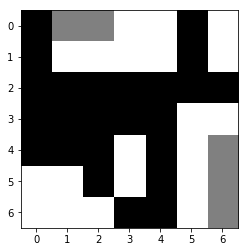

((0, 0), (0, 2)): n_v:  3137 q_all:+0.782877 q:+0.810767 q_m:+0.400000 p:0.190335
((0, 0), (0, 1)): n_v:   792 q_all:+0.748479 q:+0.753677 q_m:+0.300000 p:0.186132
((1, 0), (0, 2)): n_v:   194 q_all:+0.727479 q:+0.727773 q_m:+0.400000 p:0.066473
((6, 4), (4, 6)): n_v:   185 q_all:+0.761498 q:+0.770541 q_m:+0.400000 p:0.031415
((2, 6), (4, 6)): n_v:    14 q_all:+0.709759 q:+0.585458 q_m:+0.400000 p:0.006065
((2, 0), (0, 2)): n_v:     6 q_all:+0.669091 q:+0.656119 q_m:+0.400000 p:0.004065
((5, 4), (4, 6)): n_v:     2 q_all:+0.611131 q:+0.685661 q_m:+0.400000 p:0.002638
((2, 0), (0, 1)): n_v:     1 q_all:+0.499133 q:+0.522809 q_m:+0.266667 p:0.002029
((4, 4), (6, 6)): n_v:     0 q_all:+0.480966 q:+0.480966 q_m:+0.266667 p:0.000041
((4, 4), (5, 6)): n_v:     0 q_all:+0.569583 q:+0.569583 q_m:+0.333333 p:0.000072
((2, 2), (0, 2)): n_v:     0 q_all:+0.395807 q:+0.395807 q_m:+0.400000 p:0.000121
((2, 3), (0, 1)): n_v:     0 q_all:+0.285015 q:+0.285015 q_m:+0.266667 p:0.000173
((2, 5), (4, 6))

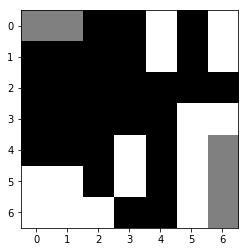

((3, 6), (5, 6)): n_v:  2010 q_all:-0.813807 q:-0.792077 q_m:-0.400000 p:0.463424
((3, 5), (5, 6)): n_v:  1706 q_all:-0.799819 q:-0.794910 q_m:-0.400000 p:0.284702
((4, 5), (6, 6)): n_v:   893 q_all:-0.805306 q:-0.781733 q_m:-0.400000 p:0.171242
((6, 5), (4, 6)): n_v:   173 q_all:-0.811051 q:-0.829556 q_m:-0.400000 p:0.037849
((4, 5), (5, 6)): n_v:    56 q_all:-0.781549 q:-0.867301 q_m:-0.366667 p:0.004630
((3, 5), (4, 6)): n_v:    17 q_all:-0.837070 q:-0.875514 q_m:-0.366667 p:0.005845
((5, 5), (6, 6)): n_v:    16 q_all:-0.872980 q:-0.847169 q_m:-0.366667 p:0.008253
########################p_sum is:  0.975945177022
-1 's turn
one move takes time(s):  0.28189706802368164
no. of data collected:  16


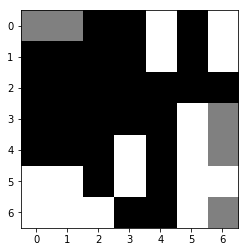

((2, 5), (3, 6)): n_v:  2863 q_all:+0.866887 q:+0.907542 q_m:+0.566667 p:0.300732
((0, 2), (0, 1)): n_v:   395 q_all:+0.847408 q:+0.896371 q_m:+0.433333 p:0.030413
((2, 6), (4, 6)): n_v:   313 q_all:+0.757114 q:+0.865385 q_m:+0.666667 p:0.209373
((1, 0), (0, 0)): n_v:    34 q_all:+0.808911 q:+0.837930 q_m:+0.433333 p:0.011784
((6, 4), (4, 6)): n_v:    25 q_all:+0.746220 q:+0.855648 q_m:+0.666667 p:0.018764
((2, 5), (4, 6)): n_v:    14 q_all:+0.746145 q:+0.827800 q_m:+0.666667 p:0.010731
((2, 0), (0, 1)): n_v:     1 q_all:+0.756367 q:+0.771398 q_m:+0.400000 p:0.001030
((2, 4), (4, 6)): n_v:     1 q_all:+0.653350 q:+0.684051 q_m:+0.666667 p:0.001832
((4, 4), (6, 6)): n_v:     0 q_all:+0.709561 q:+0.819123 q_m:+0.600000 p:0.000711
((3, 4), (3, 6)): n_v:     0 q_all:+0.599851 q:+0.666368 q_m:+0.533333 p:0.000106
((2, 3), (0, 1)): n_v:     0 q_all:+0.557108 q:+0.557108 q_m:+0.400000 p:0.000040
((1, 5), (3, 6)): n_v:     0 q_all:+0.627120 q:+0.720907 q_m:+0.533333 p:0.000380
((0, 2), (0, 0))

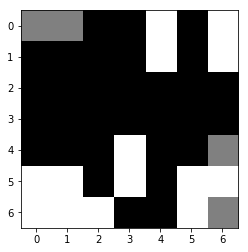

((6, 5), (4, 6)): n_v:  3899 q_all:-0.895750 q:-0.889944 q_m:-0.366667 p:0.509323
((5, 5), (4, 6)): n_v:   554 q_all:-0.965438 q:-0.946822 q_m:-0.333333 p:0.253507
((5, 5), (6, 6)): n_v:   452 q_all:-0.868725 q:-0.964829 q_m:-0.533333 p:0.001707
########################p_sum is:  0.764536708011
-1 's turn


This is a random move


one move takes time(s):  0.17001008987426758
no. of data collected:  24


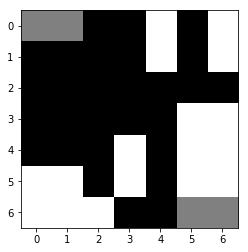

((5, 4), (6, 5)): n_v:  3707 q_all:+0.874066 q:+0.941413 q_m:+0.533333 p:0.529901
((0, 2), (0, 1)): n_v:  2085 q_all:+0.904279 q:+0.906745 q_m:+0.400000 p:0.027041
((5, 4), (6, 6)): n_v:     0 q_all:+0.632601 q:+0.765202 q_m:+0.500000 p:0.000002
((4, 4), (6, 6)): n_v:     0 q_all:+0.606662 q:+0.713323 q_m:+0.500000 p:0.000001
((4, 4), (6, 5)): n_v:     0 q_all:+0.646621 q:+0.793241 q_m:+0.500000 p:0.000303
((1, 3), (0, 1)): n_v:     0 q_all:+0.578231 q:+0.578231 q_m:+0.366667 p:0.000010
((0, 3), (0, 1)): n_v:     0 q_all:+0.779515 q:+0.779515 q_m:+0.366667 p:0.000110
((2, 0), (0, 1)): n_v:     0 q_all:+0.779079 q:+0.779079 q_m:+0.366667 p:0.000206
((1, 0), (0, 0)): n_v:     0 q_all:+0.793953 q:+0.793953 q_m:+0.400000 p:0.000271
((2, 3), (0, 1)): n_v:     0 q_all:+0.477264 q:+0.477264 q_m:+0.366667 p:0.000012
((2, 2), (0, 0)): n_v:     0 q_all:+0.318434 q:+0.318434 q_m:+0.366667 p:0.000000
((2, 0), (0, 0)): n_v:     0 q_all:+0.621109 q:+0.621109 q_m:+0.366667 p:0.000002
((2, 2), (0, 1))

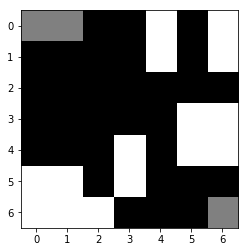

((4, 6), (6, 6)): n_v:  4764 q_all:-0.931073 q:-0.931915 q_m:-0.333333 p:0.844360
((4, 5), (6, 6)): n_v:   728 q_all:-0.939413 q:-0.899012 q_m:-0.333333 p:0.155591
########################p_sum is:  0.999950885773
-1 's turn


This is a random move


one move takes time(s):  0.26717424392700195
no. of data collected:  24


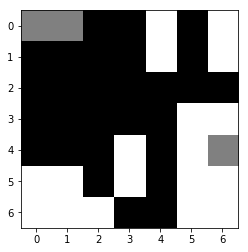

((0, 2), (0, 1)): n_v:  2281 q_all:+0.983647 q:+0.937463 q_m:+0.366667 p:0.023911
((6, 4), (4, 6)): n_v:  2208 q_all:+0.948162 q:+0.972398 q_m:+0.666667 p:0.500677
((2, 6), (4, 6)): n_v:   859 q_all:+0.915653 q:+0.941882 q_m:+0.666667 p:0.305391
((5, 4), (4, 6)): n_v:    67 q_all:+0.954356 q:+0.932588 q_m:+0.666667 p:0.013716
((4, 4), (4, 6)): n_v:    43 q_all:+0.953809 q:+0.926848 q_m:+0.666667 p:0.008971
((3, 4), (4, 6)): n_v:    24 q_all:+0.901167 q:+0.909034 q_m:+0.666667 p:0.010305
((2, 4), (4, 6)): n_v:    23 q_all:+0.858137 q:+0.853753 q_m:+0.666667 p:0.014012
((2, 5), (4, 6)): n_v:    15 q_all:+0.918296 q:+0.897579 q_m:+0.666667 p:0.005519
((1, 0), (0, 0)): n_v:     6 q_all:+0.837678 q:+0.837678 q_m:+0.366667 p:0.004107
((1, 3), (0, 1)): n_v:     0 q_all:+0.608654 q:+0.608654 q_m:+0.333333 p:0.000021
((0, 3), (0, 1)): n_v:     0 q_all:+0.834869 q:+0.834869 q_m:+0.333333 p:0.000269
((2, 0), (0, 1)): n_v:     0 q_all:+0.835695 q:+0.835695 q_m:+0.333333 p:0.000483
((2, 3), (0, 1))

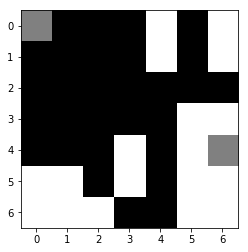

((6, 5), (4, 6)): n_v:  2778 q_all:-0.996665 q:-0.993009 q_m:-0.366667 p:0.578122
((6, 6), (4, 6)): n_v:  1122 q_all:-0.993238 q:-0.992422 q_m:-0.366667 p:0.214365
((3, 5), (4, 6)): n_v:   192 q_all:-0.998556 q:-0.999666 q_m:-0.333333 p:0.041926
########################p_sum is:  0.834412790835
-1 's turn


This is a random move


one move takes time(s):  0.07904529571533203
no. of data collected:  8


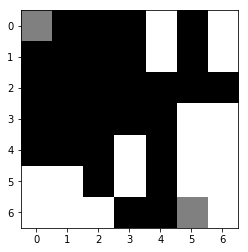

((5, 4), (6, 5)): n_v:  3664 q_all:+1.000000 q:+5.000000 q_m:+0.600000 p:0.547995
((6, 3), (6, 5)): n_v:     1 q_all:+0.887307 q:+0.982563 q_m:+0.566667 p:0.001288
((0, 1), (0, 0)): n_v:     1 q_all:+0.946244 q:+0.981795 q_m:+0.400000 p:0.000704
((2, 2), (0, 0)): n_v:     0 q_all:+0.539794 q:+0.539794 q_m:+0.366667 p:0.000001
((2, 0), (0, 0)): n_v:     0 q_all:+0.851573 q:+0.851573 q_m:+0.366667 p:0.000005
((4, 4), (6, 5)): n_v:     0 q_all:+0.759536 q:+0.952405 q_m:+0.566667 p:0.000572
((0, 2), (0, 0)): n_v:     0 q_all:+0.917910 q:+0.917910 q_m:+0.366667 p:0.000029
((2, 1), (0, 0)): n_v:     0 q_all:+0.617765 q:+0.617765 q_m:+0.366667 p:0.000000
((1, 2), (0, 0)): n_v:     0 q_all:+0.683866 q:+0.683866 q_m:+0.366667 p:0.000001
########################p_sum is:  0.550595527879
this self play has 79 steps, time elapsed 127.34637665748596
winner is -1.0
episode 142 finished
episode 143 now start
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time

due to rollout lim, final rollout times:  2001 time elapsed:  3.3857791423797607
one move takes time(s):  3.387280225753784
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.1582510471343994
one move takes time(s):  3.159987688064575
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.240302324295044
one move takes time(s):  3.241983413696289
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.6704952716827393
one move takes time(s):  2.6722147464752197
no. of data collected:  8
-1 's turn
one move takes time(s):  1.4761393070220947
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.034644365310669


This is a random move


one move takes time(s):  3.0363526344299316
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.027846574783325
one mov

one move takes time(s):  1.3206768035888672
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.221632957458496
one move takes time(s):  3.2232182025909424
no. of data collected:  16
1 's turn
one move takes time(s):  1.2271296977996826
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.3407914638519287
one move takes time(s):  2.3422563076019287
no. of data collected:  16
1 's turn
one move takes time(s):  1.4801979064941406
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.4272806644439697
one move takes time(s):  2.4289040565490723
no. of data collected:  16
1 's turn
one move takes time(s):  1.7793278694152832
no. of data collected:  16
-1 's turn
one move takes time(s):  1.1120214462280273
no. of data collected:  16
1 's turn
one move takes time(s):  1.1657297611236572
no. of data collected:  16
-1 's turn
one move takes time(s): 

due to rollout lim, final rollout times:  2001 time elapsed:  4.843972444534302
one move takes time(s):  4.846357583999634
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  3.2783007621765137
one move takes time(s):  3.2798259258270264
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  4.664236307144165
one move takes time(s):  4.6661376953125
no. of data collected:  16
1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  4.078858852386475
one move takes time(s):  4.079922437667847
no. of data collected:  16
-1 's turn


This is a random move


one move takes time(s):  1.210495948791504
no. of data collected:  16
1 's turn
one move takes time(s):  0.7894563674926758
no. of data collected:  16
-1 's turn
due to rollout lim, final rollout times:  2001 time elapsed:  2.5798299312591553
one move takes time(s):  2.581315279006958
no. of data collected:  16
1 's turn
due to roll

one move takes time(s):  0.024477243423461914
no. of data collected:  8
this self play has 90 steps, time elapsed 165.30149745941162
winner is -1.0
106664  data in database
40000  data expected
40000  data grabbed
start training, training data no. 40000
Train on 34000 samples, validate on 6000 samples
Epoch 1/512
34000/34000 [==============================] - 3s 83us/step - loss: 0.8598 - activation_29_loss: 0.8236 - dense_15_loss: 0.0082 - val_loss: 0.8418 - val_activation_29_loss: 0.8057 - val_dense_15_loss: 0.0080
Epoch 2/512
34000/34000 [==============================] - 3s 82us/step - loss: 0.8595 - activation_29_loss: 0.8232 - dense_15_loss: 0.0082 - val_loss: 0.8416 - val_activation_29_loss: 0.8055 - val_dense_15_loss: 0.0079
Epoch 3/512
34000/34000 [==============================] - 2s 73us/step - loss: 0.8592 - activation_29_loss: 0.8229 - dense_15_loss: 0.0082 - val_loss: 0.8416 - val_activation_29_loss: 0.8055 - val_dense_15_loss: 0.0080
Epoch 4/512
34000/34000 [============

KeyboardInterrupt: 

In [17]:
# player._dep_lim = 4
player._mode = 4 # almost mode 1
player.reinforcement_learning(episode=300, left_space_max=None, rollout_times=2000, train_interval=5, \
                              life_span=20, t_lim=8, self_play_verbose=False, train_mode=0, \
                              T=0.25)

In [16]:
#player.tester(mm_dep=1, Q=True, P=True, BOTH=False, mode=1, times=300, dep_lim=1, rollout_times=400, verbose=False)
player.tester(mm_dep=2, Q=True, P=True, BOTH=False, mode=1, times=250, dep_lim=1, rollout_times=400, verbose=False)
player.tester(mm_dep=3, Q=True, P=True, BOTH=False, mode=1, times=100, dep_lim=1, rollout_times=400, verbose=False)

mm_dep is:  2
####               ####
#### start testing ####
testing took time:  159.2885708808899
64.5



                        win ratio of Q is 1.0 





####               ####
#### start testing ####
testing took time:  254.3647620677948
102.52



                        win ratio of P is 1.0 





mm_dep is:  3
####               ####
#### start testing ####
testing took time:  141.8963656425476



                        win ratio of Q is 0 





####               ####
#### start testing ####
testing took time:  142.10601019859314



                        win ratio of P is 0 







{'P': 0, 'Q': 0}

In [ ]:
w = player._network._model.get_weights()
fig = plt.gcf()
print(w[0].shape)
show_w = w[0]
for in_layer in range(6):
    for out_layer in range(64):
        print('in', in_layer, 'out', out_layer)
        plt.imshow(show_w[..., in_layer, out_layer], cmap='gray')
        plt.pause(0.1)